In [1]:
from deap import creator, base, tools, algorithms
import random
import arcade
import numpy as np
import time

In [2]:
# Definindo Constantes
toolbox = base.Toolbox()

SPRITE_SCALING_PLAYER = 0.25
SPRITE_SCALING_OBSTACLE = 0.1
OBSTACLE_COUNT = 30 
PLAYER_COUNT = 1 
VELOCIDADE = 10 # Velocidade para o Player e para os Obstaculos moveis
RAIO = 100 # Raio de visao
sizes = [2*OBSTACLE_COUNT + 2, 5, 1] # Camadas para a Rede Neural


SCREEN_WIDTH = 1400
SCREEN_HEIGHT = 700
SCREEN_TITLE = "Projeto Sistemas Evolutivos"

# Função Sigmoid

In [3]:
# Funcao Sigmoid
import math

def sigmoid(z):
    return 2.0/(1.0 + np.exp(-z)) - 1 

# Definindo Elementos

In [4]:
# Definindo o Obstaculo

class Obstacle(arcade.Sprite):
    def __init__(self, filename, sprite_scaling):
        # Componentes do Jogador
        super().__init__(filename, sprite_scaling)
        self.change_x = random.randrange(-1, 2, 2)*VELOCIDADE
        self.change_y = random.randrange(-1, 2, 2)*VELOCIDADE
        self.center_x = random.randrange(SCREEN_WIDTH)
        self.center_y = random.randrange(SCREEN_HEIGHT)
        # Garantir que nao surjam no raio de visao do individuo
        while(abs(self.center_x - SCREEN_WIDTH/2) ** 2 + abs(self.center_y - SCREEN_HEIGHT/2) ** 2 <= 10000): 
            self.center_x = random.randrange(SCREEN_WIDTH)
            self.center_y = random.randrange(SCREEN_HEIGHT)

    def update(self):
        self.center_x += self.change_x
        self.center_y += self.change_y
        if self.center_x < 0 or self.center_x > SCREEN_WIDTH:
            self.change_x *= -1
        if self.center_y < 0 or self.center_y > SCREEN_HEIGHT:
            self.change_y *= -1

In [5]:
# Definindo o Jogador
class Player(arcade.Sprite):
    def __init__(self, filename, sprite_scaling):
        # Componentes do Jogador
        super().__init__(filename, sprite_scaling)
        self.time = 0
        self.change_x = VELOCIDADE
        self.change_y = VELOCIDADE
        self.center_x = SCREEN_WIDTH/2
        self.center_y = SCREEN_HEIGHT/2
        self.nearObstacles = set()
        self.qtdNearObstacles = 0
        # Pesos da Rede Neural
        self.weights = []

    def update(self):
        # Acrescentando o tempo
        self.time += 1 / 120
        # "Raciocinio"
        a = []
        for obs in self.nearObstacles:
            a.append([obs.center_x - self.center_x, obs.center_y - self.center_y])
        ax = []
        ay = []
        cont = 0
        ax.append(self.center_x * (-1))
        ay.append(self.center_y * (-1))
        ax.append(SCREEN_WIDTH - self.center_x)
        ay.append(SCREEN_HEIGHT - self.center_y)
        for i in a:
            ax.append(i[0])
            ax.append(1)
            ay.append(i[1])
            ay.append(1)
        for i in range(len(ax), sizes[0], 2):
            ax.append(0)
            ay.append(0)
            ax.append(-1)
            ay.append(-1)
        ax = np.array(ax)
        ay = np.array(ay)
        for w in self.weights:
            ax = sigmoid(np.dot(w, ax))
            ay = sigmoid(np.dot(w, ay))

        # Movimento em X
        if ax[0] < -(1/3) and self.center_x > self.width / 1.5:
            self.center_x -= self.change_x
        elif ax[0] > (1/3) and self.center_x < SCREEN_WIDTH - (self.width / 1.5):
            self.center_x += self.change_x
        # Movimento em Y
        if ay[0] < -(1/3) and self.center_y > self.width / 1.5:
            self.center_y -= self.change_y
        elif ay[0] > (1/3) and self.center_y < SCREEN_HEIGHT - (self.width / 1.5):
            self.center_y += self.change_y

# Função para avaliar o indivíduo

In [6]:
# Função Evaluate para avaliar individuo
def evaluate(pesos):
    time = 0
    distSquare = 0
    distScore = 0
    player_list = arcade.SpriteList()
    obstacle_list = arcade.SpriteList()
    component_list = arcade.SpriteList()

    # Craindo Player com os pesos (individuo)
    individual = Player(":resources:images/animated_characters/female_person/"
                        "femalePerson_idle.png", SPRITE_SCALING_PLAYER)
    matriz1 = []
    matriz2 = []
    for i in range(quantidade):
        if(i < sizes[0]*sizes[1]):
            matriz1.append(pesos[i])
        else:
            matriz2.append(pesos[i])
    matriz1 = np.array(matriz1)
    matriz2 = np.array(matriz2)
    matriz1 = np.reshape(matriz1, (sizes[1], sizes[0]))
    matriz2 = np.reshape(matriz2, (sizes[2], sizes[1]))
    individual.weights = [matriz1, matriz2]

    # Adicionando individuo às listas
    component_list.append(individual)
    player_list.append(individual)

    # Criando Obstaculos moveis
    for i in range(OBSTACLE_COUNT):
        new_obstacle = Obstacle(":resources:images/items/coinGold.png", SPRITE_SCALING_OBSTACLE)
        obstacle_list.append(new_obstacle)
        component_list.append(new_obstacle)

    cabou = 0
    
    # Avaliar individuo
    while cabou == 0:
        posXAnterior = individual.center_x
        posYAnterior = individual.center_y
        # Adiciona obstáculos dentro do raio de visao
        for ind in player_list:
            for obstacle in obstacle_list:
                dist = math.sqrt((ind.center_x - obstacle.center_x) ** 2 +
                                 (ind.center_y - obstacle.center_y) ** 2)
                if dist <= RAIO:
                    ind.nearObstacles.add(obstacle)
                    ind.qtdNearObstacles += 1

        # Retira obstaculos que sairam do raio de visao
        for ind in player_list:
            for obstacle in ind.nearObstacles.copy():
                dist = math.sqrt((ind.center_x - obstacle.center_x) ** 2 +
                                 (ind.center_y - obstacle.center_y) ** 2)
                if dist > RAIO:
                    ind.nearObstacles.remove(obstacle)
                    ind.qtdNearObstacles -= 1

        # Atualizar posições de componentes
        component_list.update()
        distSquare += math.sqrt((individual.center_x - posXAnterior) ** 2 + (individual.center_y - posYAnterior) ** 2)

        # Verificar colisão e eliminar jogador caso tenha colidido
        for ind in player_list:
            if ind.time > 50: # tempo maximo de sobrevivencia
                time += ind.time
                component_list.remove(ind)
                player_list.remove(ind)
                continue
            hit_list = arcade.check_for_collision_with_list(ind, obstacle_list)
            if len(hit_list) != 0:
                time += ind.time
                ind.remove_from_sprite_lists()
        if len(player_list) == 0:
            return time, 

# Definindo a Parte Visual do Ambiente de Simulação

In [7]:
# Ambiente de Simulação (Parte Visual)
class MyGame(arcade.Window):
    """ Classe da janela de display """

    def __init__(self):
        """ Inicializador """
        super().__init__(SCREEN_WIDTH, SCREEN_HEIGHT, SCREEN_TITLE)

        # Variaveis para as listas de Sprites
        self.all_sprites_list = None
        self.obstacle_list = None
        self.player_list = None

        self.time = 0 # tempo inicial

        # Nao mostrar o cursos do mouse
        self.set_mouse_visible(False)
            
        arcade.set_background_color(arcade.color.AMAZON)

    def setup(self):
        """ Configurar o jogo e inicializar as variaveis. """

        # Listas de objetos
        self.all_sprites_list = arcade.SpriteList()
        self.player_list = arcade.SpriteList()
        self.obstacle_list = arcade.SpriteList()

        # Tempo
        self.time = 0 # Zerar tempo

        # Criar Player
        # Imagem para personagem de kenney.nl
        player = Player(":resources:images/animated_characters/female_person/"
                        "femalePerson_idle.png", SPRITE_SCALING_PLAYER)
        player.change_x = 2.5
        player.change_y = 2.5 
        bestpesos = top1[0]
        bestmatriz1 = []
        bestmatriz2 = []
        for i in range(quantidade):
            if i < (sizes[0] * sizes[1]):
                bestmatriz1.append(bestpesos[i])
            else:
                bestmatriz2.append(bestpesos[i])
        bestmatriz1 = np.array(bestmatriz1)
        bestmatriz2 = np.array(bestmatriz2)
        bestmatriz1 = np.reshape(bestmatriz1, (sizes[1], sizes[0]))
        bestmatriz2 = np.reshape(bestmatriz2, (sizes[2], sizes[1]))
        player.weights = [bestmatriz1, bestmatriz2]


        # Add player to lists
        self.all_sprites_list.append(player)
        self.player_list.append(player)

        # Create the obstacles
        for i in range(OBSTACLE_COUNT):

            # creating obstacle
            obstacle = Obstacle(":resources:images/items/coinGold.png", SPRITE_SCALING_OBSTACLE)

            # Position the obstacle
            obstacle.center_x = random.randrange(SCREEN_WIDTH)
            obstacle.center_y = random.randrange(SCREEN_HEIGHT)
            obstacle.change_x = random.randrange(-1, 2, 2)*2.5
            obstacle.change_y = random.randrange(-1, 2, 2)*2.5

            # Add the obstacle to the lists
            self.all_sprites_list.append(obstacle)
            self.obstacle_list.append(obstacle)

    def on_draw(self):
        """ Draw everything """
        self.clear()
        output = f"Time: {round(self.time, 2)}"
        arcade.draw_text(output, 15, 20, arcade.color.WHITE, 14)
        self.all_sprites_list.draw()

        # Put the text on the screen.
        output = f"Time: {round(self.time, 2)}"
        survivors = f"Sobreviventes: {len(self.player_list)}"
        arcade.draw_text(output, 15, 20, arcade.color.WHITE, 14)
        arcade.draw_text(survivors, 150, 20, arcade.color.WHITE, 14)

    def on_update(self, delta_time):
        """ Movement and game logic """
        self.time += 1 / 120
        # Call update on all sprites
        self.all_sprites_list.update()

        # Adicionar obstáculos próximos
        for player in self.player_list:
            for obstacle in self.obstacle_list:
                dist = math.sqrt((player.center_x - obstacle.center_x) ** 2 +
                                 (player.center_y - obstacle.center_y) ** 2)
                if dist <= RAIO:
                    player.nearObstacles.add(obstacle)
                    player.qtdNearObstacles += 1

        # Retira obstaculos que sairam do raio
        for player in self.player_list:
            for obstacle in player.nearObstacles.copy():
                dist = math.sqrt((player.center_x - obstacle.center_x) ** 2 +
                                 (player.center_y - obstacle.center_y) ** 2)
                if dist > RAIO:
                    player.nearObstacles.remove(obstacle)
                    player.qtdNearObstacles -= 1
        # Verificar colisão, imprimir tempo e eliminar jogador
        for player in self.player_list:
            hit_list = arcade.check_for_collision_with_list(player, self.obstacle_list)
            if len(hit_list) != 0:
                # player.remove_from_sprite_lists(self.player_list)
                player.remove_from_sprite_lists()
        if len(self.player_list) == 0:
            arcade.close_window()

In [8]:
# Iniciar o ambiente de simulação (parte visual)
def main():
    window = MyGame()
    window.setup()
    arcade.run()

# Parte Evolutiva

In [9]:
# Numero de elementos na matriz de pesos
quantidade = sizes[0]*sizes[1] + sizes[1]*sizes[2]

# Função para gerar pesos aleatórios
def gerapesos():
    return [np.random.uniform(0, 1, (y, x)) for x, y in zip(sizes[:-1], sizes[1:])]

In [10]:
# Definicoes da Biblioteca Deap
creator.create("FitnessMax", base.Fitness, weights=(1.0, ))

creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox.register("weights", np.random.uniform, 0, 1)

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.weights, n=quantidade)

toolbox.register("evaluate", evaluate)

toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=100)

toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.4)

toolbox.register("select", tools.selTournament, tournsize=3)

# Avaliando o Individuo Variando CXPB (Probabilidade de Crossover)

In [11]:
NGEN = 100 # Numero de geracoes
CXPB = np.arange(0, 1.05, 0.05) # Probabilidade de crossover
MUTPB = 0.5 # Probabilidade de mutacao
tempos = [] # Lista de melhor tempo (score) da última geração (Grafico 1)
tempoTotal = [] # lista com somatório dos tempos (score) da ultima geração (Grafico 2)
temposMelhorInd = [] # lista da media de tempo de sobrevivencia do melhor invididuo da ultima geracao (Grafico 3)
population = toolbox.population() # Populacao inicial

for CX in CXPB:
    atual = 0 # somatoria de tempos do melhor individuo
    for gen in range(NGEN):
        total = 0
        offspring = algorithms.varAnd(population, toolbox, cxpb=CX, mutpb=MUTPB) # Produz nova geracao
        fits = toolbox.map(toolbox.evaluate, offspring) # Avalia individuos da geracao atual
        print(f"Geração {gen}:")
        maximo = 0
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
            total += ind.fitness.values[0] 
            if(ind.fitness.values[0] > maximo):
                maximo = ind.fitness.values[0]
            print("CX: ", CX, "G: ", gen," tempo: ", round(ind.fitness.values[0], 2))
        if(gen+1 == NGEN):
            tempos.append(maximo)
            tempoTotal.append(total)
        population = toolbox.select(offspring, k=len(population))
        top1 = tools.selBest(population, k=1) # melhor individuo
        # if((gen+1) % 20 == 0): # Display da simulacao visual com top1 a cada 20 geracoes
            # main()
    for i in range(10):
        atual += evaluate(np.reshape(top1, (-1)))[0]
    temposMelhorInd.append(atual/10) # adicionar media de tempo para o valor de CX atual.

Geração 0:
CX:  0.0 G:  0  tempo:  0.08
CX:  0.0 G:  0  tempo:  4.27
CX:  0.0 G:  0  tempo:  0.99
CX:  0.0 G:  0  tempo:  1.06
CX:  0.0 G:  0  tempo:  0.56
CX:  0.0 G:  0  tempo:  0.11
CX:  0.0 G:  0  tempo:  0.13
CX:  0.0 G:  0  tempo:  2.08


/tmp/ipykernel_7562/979507128.py:5: RuntimeWarning: overflow encountered in exp
  return 2.0/(1.0 + np.exp(-z)) - 1


CX:  0.0 G:  0  tempo:  1.9
CX:  0.0 G:  0  tempo:  1.8
CX:  0.0 G:  0  tempo:  1.78
CX:  0.0 G:  0  tempo:  0.28
CX:  0.0 G:  0  tempo:  0.13
CX:  0.0 G:  0  tempo:  1.68
CX:  0.0 G:  0  tempo:  0.09
CX:  0.0 G:  0  tempo:  1.04
CX:  0.0 G:  0  tempo:  0.77
CX:  0.0 G:  0  tempo:  0.46
CX:  0.0 G:  0  tempo:  0.81
CX:  0.0 G:  0  tempo:  0.3
CX:  0.0 G:  0  tempo:  0.75
CX:  0.0 G:  0  tempo:  0.64
CX:  0.0 G:  0  tempo:  1.01
CX:  0.0 G:  0  tempo:  0.39
CX:  0.0 G:  0  tempo:  0.68
CX:  0.0 G:  0  tempo:  0.63
CX:  0.0 G:  0  tempo:  0.45
CX:  0.0 G:  0  tempo:  0.22
CX:  0.0 G:  0  tempo:  0.09
CX:  0.0 G:  0  tempo:  0.39
CX:  0.0 G:  0  tempo:  0.72
CX:  0.0 G:  0  tempo:  0.07
CX:  0.0 G:  0  tempo:  0.17
CX:  0.0 G:  0  tempo:  0.42
CX:  0.0 G:  0  tempo:  1.51
CX:  0.0 G:  0  tempo:  0.07
CX:  0.0 G:  0  tempo:  0.22
CX:  0.0 G:  0  tempo:  0.17
CX:  0.0 G:  0  tempo:  1.65
CX:  0.0 G:  0  tempo:  0.12
CX:  0.0 G:  0  tempo:  0.91
CX:  0.0 G:  0  tempo:  0.68
CX:  0.0 G:  0  t

CX:  0.0 G:  3  tempo:  0.61
CX:  0.0 G:  3  tempo:  0.8
CX:  0.0 G:  3  tempo:  0.76
CX:  0.0 G:  3  tempo:  0.25
CX:  0.0 G:  3  tempo:  0.7
CX:  0.0 G:  3  tempo:  0.28
CX:  0.0 G:  3  tempo:  0.73
CX:  0.0 G:  3  tempo:  1.29
CX:  0.0 G:  3  tempo:  0.07
CX:  0.0 G:  3  tempo:  1.34
CX:  0.0 G:  3  tempo:  0.08
CX:  0.0 G:  3  tempo:  0.15
CX:  0.0 G:  3  tempo:  1.23
CX:  0.0 G:  3  tempo:  0.84
CX:  0.0 G:  3  tempo:  0.11
CX:  0.0 G:  3  tempo:  0.22
CX:  0.0 G:  3  tempo:  0.07
CX:  0.0 G:  3  tempo:  0.86
CX:  0.0 G:  3  tempo:  0.62
CX:  0.0 G:  3  tempo:  1.28
CX:  0.0 G:  3  tempo:  0.17
CX:  0.0 G:  3  tempo:  1.29
CX:  0.0 G:  3  tempo:  0.71
CX:  0.0 G:  3  tempo:  0.08
CX:  0.0 G:  3  tempo:  0.71
CX:  0.0 G:  3  tempo:  18.93
CX:  0.0 G:  3  tempo:  2.42
CX:  0.0 G:  3  tempo:  0.16
CX:  0.0 G:  3  tempo:  0.14
CX:  0.0 G:  3  tempo:  0.47
CX:  0.0 G:  3  tempo:  0.22
CX:  0.0 G:  3  tempo:  6.63
CX:  0.0 G:  3  tempo:  0.39
CX:  0.0 G:  3  tempo:  0.35
CX:  0.0 G:  3 

CX:  0.0 G:  6  tempo:  1.61
CX:  0.0 G:  6  tempo:  0.43
CX:  0.0 G:  6  tempo:  0.18
CX:  0.0 G:  6  tempo:  0.24
CX:  0.0 G:  6  tempo:  0.06
CX:  0.0 G:  6  tempo:  1.76
CX:  0.0 G:  6  tempo:  0.83
CX:  0.0 G:  6  tempo:  0.24
CX:  0.0 G:  6  tempo:  0.04
CX:  0.0 G:  6  tempo:  0.63
CX:  0.0 G:  6  tempo:  0.09
CX:  0.0 G:  6  tempo:  0.17
CX:  0.0 G:  6  tempo:  0.89
CX:  0.0 G:  6  tempo:  1.92
CX:  0.0 G:  6  tempo:  1.52
CX:  0.0 G:  6  tempo:  1.09
CX:  0.0 G:  6  tempo:  2.52
CX:  0.0 G:  6  tempo:  1.0
CX:  0.0 G:  6  tempo:  0.17
CX:  0.0 G:  6  tempo:  0.9
CX:  0.0 G:  6  tempo:  0.72
CX:  0.0 G:  6  tempo:  0.41
CX:  0.0 G:  6  tempo:  0.53
CX:  0.0 G:  6  tempo:  0.43
CX:  0.0 G:  6  tempo:  0.34
CX:  0.0 G:  6  tempo:  0.39
CX:  0.0 G:  6  tempo:  0.87
CX:  0.0 G:  6  tempo:  1.55
CX:  0.0 G:  6  tempo:  0.03
CX:  0.0 G:  6  tempo:  1.27
CX:  0.0 G:  6  tempo:  1.32
CX:  0.0 G:  6  tempo:  0.68
CX:  0.0 G:  6  tempo:  0.79
CX:  0.0 G:  6  tempo:  9.0
CX:  0.0 G:  6  t

CX:  0.0 G:  9  tempo:  6.36
CX:  0.0 G:  9  tempo:  0.53
CX:  0.0 G:  9  tempo:  0.26
CX:  0.0 G:  9  tempo:  1.12
CX:  0.0 G:  9  tempo:  0.1
CX:  0.0 G:  9  tempo:  0.26
CX:  0.0 G:  9  tempo:  0.86
CX:  0.0 G:  9  tempo:  0.45
CX:  0.0 G:  9  tempo:  0.68
CX:  0.0 G:  9  tempo:  2.28
CX:  0.0 G:  9  tempo:  0.24
CX:  0.0 G:  9  tempo:  0.87
CX:  0.0 G:  9  tempo:  0.28
CX:  0.0 G:  9  tempo:  0.68
CX:  0.0 G:  9  tempo:  0.68
CX:  0.0 G:  9  tempo:  0.54
CX:  0.0 G:  9  tempo:  0.22
CX:  0.0 G:  9  tempo:  0.36
CX:  0.0 G:  9  tempo:  0.24
CX:  0.0 G:  9  tempo:  2.12
CX:  0.0 G:  9  tempo:  0.53
CX:  0.0 G:  9  tempo:  0.04
CX:  0.0 G:  9  tempo:  2.29
CX:  0.0 G:  9  tempo:  0.29
CX:  0.0 G:  9  tempo:  1.71
CX:  0.0 G:  9  tempo:  0.22
CX:  0.0 G:  9  tempo:  1.51
CX:  0.0 G:  9  tempo:  0.68
CX:  0.0 G:  9  tempo:  0.12
CX:  0.0 G:  9  tempo:  1.44
CX:  0.0 G:  9  tempo:  0.97
CX:  0.0 G:  9  tempo:  0.28
CX:  0.0 G:  9  tempo:  0.18
CX:  0.0 G:  9  tempo:  0.54
CX:  0.0 G:  9 

Geração 12:
CX:  0.0 G:  12  tempo:  1.26
CX:  0.0 G:  12  tempo:  0.3
CX:  0.0 G:  12  tempo:  0.21
CX:  0.0 G:  12  tempo:  0.54
CX:  0.0 G:  12  tempo:  0.66
CX:  0.0 G:  12  tempo:  0.12
CX:  0.0 G:  12  tempo:  0.08
CX:  0.0 G:  12  tempo:  1.66
CX:  0.0 G:  12  tempo:  0.74
CX:  0.0 G:  12  tempo:  0.43
CX:  0.0 G:  12  tempo:  1.69
CX:  0.0 G:  12  tempo:  0.36
CX:  0.0 G:  12  tempo:  0.22
CX:  0.0 G:  12  tempo:  0.06
CX:  0.0 G:  12  tempo:  0.73
CX:  0.0 G:  12  tempo:  0.28
CX:  0.0 G:  12  tempo:  0.34
CX:  0.0 G:  12  tempo:  0.05
CX:  0.0 G:  12  tempo:  0.34
CX:  0.0 G:  12  tempo:  1.33
CX:  0.0 G:  12  tempo:  0.43
CX:  0.0 G:  12  tempo:  0.84
CX:  0.0 G:  12  tempo:  0.18
CX:  0.0 G:  12  tempo:  0.43
CX:  0.0 G:  12  tempo:  0.48
CX:  0.0 G:  12  tempo:  0.12
CX:  0.0 G:  12  tempo:  2.72
CX:  0.0 G:  12  tempo:  0.54
CX:  0.0 G:  12  tempo:  1.79
CX:  0.0 G:  12  tempo:  0.55
CX:  0.0 G:  12  tempo:  1.07
CX:  0.0 G:  12  tempo:  0.56
CX:  0.0 G:  12  tempo:  4.51

Geração 15:
CX:  0.0 G:  15  tempo:  0.78
CX:  0.0 G:  15  tempo:  0.37
CX:  0.0 G:  15  tempo:  0.22
CX:  0.0 G:  15  tempo:  0.05
CX:  0.0 G:  15  tempo:  1.37
CX:  0.0 G:  15  tempo:  2.05
CX:  0.0 G:  15  tempo:  0.21
CX:  0.0 G:  15  tempo:  0.22
CX:  0.0 G:  15  tempo:  0.24
CX:  0.0 G:  15  tempo:  1.17
CX:  0.0 G:  15  tempo:  0.2
CX:  0.0 G:  15  tempo:  0.35
CX:  0.0 G:  15  tempo:  0.37
CX:  0.0 G:  15  tempo:  0.45
CX:  0.0 G:  15  tempo:  1.01
CX:  0.0 G:  15  tempo:  0.07
CX:  0.0 G:  15  tempo:  0.56
CX:  0.0 G:  15  tempo:  0.34
CX:  0.0 G:  15  tempo:  0.28
CX:  0.0 G:  15  tempo:  0.07
CX:  0.0 G:  15  tempo:  0.09
CX:  0.0 G:  15  tempo:  1.07
CX:  0.0 G:  15  tempo:  2.52
CX:  0.0 G:  15  tempo:  0.38
CX:  0.0 G:  15  tempo:  0.43
CX:  0.0 G:  15  tempo:  0.14
CX:  0.0 G:  15  tempo:  0.5
CX:  0.0 G:  15  tempo:  0.46
CX:  0.0 G:  15  tempo:  0.93
CX:  0.0 G:  15  tempo:  0.24
CX:  0.0 G:  15  tempo:  2.05
CX:  0.0 G:  15  tempo:  1.0
CX:  0.0 G:  15  tempo:  2.42
C

CX:  0.0 G:  17  tempo:  0.78
CX:  0.0 G:  17  tempo:  0.38
CX:  0.0 G:  17  tempo:  6.69
CX:  0.0 G:  17  tempo:  0.44
CX:  0.0 G:  17  tempo:  0.37
CX:  0.0 G:  17  tempo:  0.08
CX:  0.0 G:  17  tempo:  0.38
CX:  0.0 G:  17  tempo:  6.61
CX:  0.0 G:  17  tempo:  0.45
CX:  0.0 G:  17  tempo:  0.19
CX:  0.0 G:  17  tempo:  0.12
CX:  0.0 G:  17  tempo:  0.07
CX:  0.0 G:  17  tempo:  0.15
CX:  0.0 G:  17  tempo:  0.22
CX:  0.0 G:  17  tempo:  0.07
CX:  0.0 G:  17  tempo:  0.32
CX:  0.0 G:  17  tempo:  1.83
CX:  0.0 G:  17  tempo:  0.33
CX:  0.0 G:  17  tempo:  0.18
CX:  0.0 G:  17  tempo:  0.11
CX:  0.0 G:  17  tempo:  0.03
CX:  0.0 G:  17  tempo:  0.43
CX:  0.0 G:  17  tempo:  0.79
CX:  0.0 G:  17  tempo:  2.82
CX:  0.0 G:  17  tempo:  0.21
CX:  0.0 G:  17  tempo:  0.94
CX:  0.0 G:  17  tempo:  0.2
Geração 18:
CX:  0.0 G:  18  tempo:  3.12
CX:  0.0 G:  18  tempo:  0.87
CX:  0.0 G:  18  tempo:  0.22
CX:  0.0 G:  18  tempo:  0.72
CX:  0.0 G:  18  tempo:  1.1
CX:  0.0 G:  18  tempo:  2.37


CX:  0.0 G:  20  tempo:  0.65
CX:  0.0 G:  20  tempo:  0.68
CX:  0.0 G:  20  tempo:  0.04
CX:  0.0 G:  20  tempo:  1.4
CX:  0.0 G:  20  tempo:  0.96
CX:  0.0 G:  20  tempo:  0.96
CX:  0.0 G:  20  tempo:  0.07
CX:  0.0 G:  20  tempo:  0.18
CX:  0.0 G:  20  tempo:  0.03
CX:  0.0 G:  20  tempo:  0.15
CX:  0.0 G:  20  tempo:  0.19
CX:  0.0 G:  20  tempo:  0.22
CX:  0.0 G:  20  tempo:  0.32
CX:  0.0 G:  20  tempo:  0.26
CX:  0.0 G:  20  tempo:  0.21
CX:  0.0 G:  20  tempo:  0.28
CX:  0.0 G:  20  tempo:  0.63
CX:  0.0 G:  20  tempo:  1.36
CX:  0.0 G:  20  tempo:  0.58
CX:  0.0 G:  20  tempo:  1.02
CX:  0.0 G:  20  tempo:  0.41
CX:  0.0 G:  20  tempo:  2.28
CX:  0.0 G:  20  tempo:  0.12
CX:  0.0 G:  20  tempo:  3.21
CX:  0.0 G:  20  tempo:  0.58
CX:  0.0 G:  20  tempo:  1.78
CX:  0.0 G:  20  tempo:  0.18
CX:  0.0 G:  20  tempo:  0.09
CX:  0.0 G:  20  tempo:  0.58
CX:  0.0 G:  20  tempo:  0.08
CX:  0.0 G:  20  tempo:  0.54
CX:  0.0 G:  20  tempo:  4.16
CX:  0.0 G:  20  tempo:  0.18
CX:  0.0 G:

CX:  0.0 G:  23  tempo:  4.6
CX:  0.0 G:  23  tempo:  0.33
CX:  0.0 G:  23  tempo:  0.22
CX:  0.0 G:  23  tempo:  0.32
CX:  0.0 G:  23  tempo:  0.12
CX:  0.0 G:  23  tempo:  1.22
CX:  0.0 G:  23  tempo:  0.39
CX:  0.0 G:  23  tempo:  1.56
CX:  0.0 G:  23  tempo:  0.13
CX:  0.0 G:  23  tempo:  0.05
CX:  0.0 G:  23  tempo:  0.6
CX:  0.0 G:  23  tempo:  0.77
CX:  0.0 G:  23  tempo:  0.93
CX:  0.0 G:  23  tempo:  11.56
CX:  0.0 G:  23  tempo:  0.5
CX:  0.0 G:  23  tempo:  0.14
CX:  0.0 G:  23  tempo:  0.55
CX:  0.0 G:  23  tempo:  2.04
CX:  0.0 G:  23  tempo:  0.06
CX:  0.0 G:  23  tempo:  0.71
CX:  0.0 G:  23  tempo:  0.68
CX:  0.0 G:  23  tempo:  0.75
CX:  0.0 G:  23  tempo:  0.09
CX:  0.0 G:  23  tempo:  0.72
CX:  0.0 G:  23  tempo:  0.12
CX:  0.0 G:  23  tempo:  0.07
CX:  0.0 G:  23  tempo:  0.25
CX:  0.0 G:  23  tempo:  0.33
CX:  0.0 G:  23  tempo:  0.69
CX:  0.0 G:  23  tempo:  1.75
CX:  0.0 G:  23  tempo:  0.34
CX:  0.0 G:  23  tempo:  0.38
CX:  0.0 G:  23  tempo:  1.82
CX:  0.0 G: 

CX:  0.0 G:  26  tempo:  5.57
CX:  0.0 G:  26  tempo:  1.82
CX:  0.0 G:  26  tempo:  2.04
CX:  0.0 G:  26  tempo:  1.02
CX:  0.0 G:  26  tempo:  0.46
CX:  0.0 G:  26  tempo:  0.82
CX:  0.0 G:  26  tempo:  0.76
CX:  0.0 G:  26  tempo:  2.13
CX:  0.0 G:  26  tempo:  3.47
CX:  0.0 G:  26  tempo:  0.34
CX:  0.0 G:  26  tempo:  0.37
CX:  0.0 G:  26  tempo:  0.17
CX:  0.0 G:  26  tempo:  2.76
CX:  0.0 G:  26  tempo:  0.4
CX:  0.0 G:  26  tempo:  2.04
CX:  0.0 G:  26  tempo:  0.5
CX:  0.0 G:  26  tempo:  1.81
CX:  0.0 G:  26  tempo:  5.57
CX:  0.0 G:  26  tempo:  0.99
CX:  0.0 G:  26  tempo:  0.72
CX:  0.0 G:  26  tempo:  0.66
CX:  0.0 G:  26  tempo:  0.55
CX:  0.0 G:  26  tempo:  9.65
CX:  0.0 G:  26  tempo:  0.58
CX:  0.0 G:  26  tempo:  1.17
CX:  0.0 G:  26  tempo:  0.33
CX:  0.0 G:  26  tempo:  0.71
CX:  0.0 G:  26  tempo:  2.6
CX:  0.0 G:  26  tempo:  2.32
CX:  0.0 G:  26  tempo:  0.28
CX:  0.0 G:  26  tempo:  0.62
Geração 27:
CX:  0.0 G:  27  tempo:  1.13
CX:  0.0 G:  27  tempo:  0.14
C

CX:  0.0 G:  29  tempo:  0.86
CX:  0.0 G:  29  tempo:  2.22
CX:  0.0 G:  29  tempo:  1.67
CX:  0.0 G:  29  tempo:  1.41
CX:  0.0 G:  29  tempo:  0.19
CX:  0.0 G:  29  tempo:  0.34
CX:  0.0 G:  29  tempo:  4.98
CX:  0.0 G:  29  tempo:  0.68
CX:  0.0 G:  29  tempo:  9.86
CX:  0.0 G:  29  tempo:  0.44
CX:  0.0 G:  29  tempo:  0.38
CX:  0.0 G:  29  tempo:  3.71
CX:  0.0 G:  29  tempo:  1.07
CX:  0.0 G:  29  tempo:  0.08
CX:  0.0 G:  29  tempo:  0.11
CX:  0.0 G:  29  tempo:  0.03
CX:  0.0 G:  29  tempo:  0.27
CX:  0.0 G:  29  tempo:  1.27
CX:  0.0 G:  29  tempo:  0.12
CX:  0.0 G:  29  tempo:  5.65
CX:  0.0 G:  29  tempo:  1.01
CX:  0.0 G:  29  tempo:  0.31
CX:  0.0 G:  29  tempo:  1.63
CX:  0.0 G:  29  tempo:  0.77
CX:  0.0 G:  29  tempo:  0.19
CX:  0.0 G:  29  tempo:  0.17
CX:  0.0 G:  29  tempo:  1.67
CX:  0.0 G:  29  tempo:  0.46
CX:  0.0 G:  29  tempo:  0.2
CX:  0.0 G:  29  tempo:  0.05
CX:  0.0 G:  29  tempo:  0.38
CX:  0.0 G:  29  tempo:  0.53
CX:  0.0 G:  29  tempo:  0.33
CX:  0.0 G:

CX:  0.0 G:  32  tempo:  2.27
CX:  0.0 G:  32  tempo:  0.77
CX:  0.0 G:  32  tempo:  1.14
CX:  0.0 G:  32  tempo:  0.13
CX:  0.0 G:  32  tempo:  0.05
CX:  0.0 G:  32  tempo:  4.25
CX:  0.0 G:  32  tempo:  0.21
CX:  0.0 G:  32  tempo:  2.35
CX:  0.0 G:  32  tempo:  0.07
CX:  0.0 G:  32  tempo:  0.45
CX:  0.0 G:  32  tempo:  0.33
CX:  0.0 G:  32  tempo:  0.77
CX:  0.0 G:  32  tempo:  0.67
CX:  0.0 G:  32  tempo:  0.98
CX:  0.0 G:  32  tempo:  0.5
CX:  0.0 G:  32  tempo:  0.43
CX:  0.0 G:  32  tempo:  0.24
CX:  0.0 G:  32  tempo:  0.28
CX:  0.0 G:  32  tempo:  0.22
CX:  0.0 G:  32  tempo:  2.8
CX:  0.0 G:  32  tempo:  4.6
CX:  0.0 G:  32  tempo:  0.11
CX:  0.0 G:  32  tempo:  0.63
CX:  0.0 G:  32  tempo:  1.09
CX:  0.0 G:  32  tempo:  0.65
CX:  0.0 G:  32  tempo:  2.25
CX:  0.0 G:  32  tempo:  1.62
CX:  0.0 G:  32  tempo:  0.58
CX:  0.0 G:  32  tempo:  0.19
CX:  0.0 G:  32  tempo:  0.9
CX:  0.0 G:  32  tempo:  1.2
CX:  0.0 G:  32  tempo:  0.49
CX:  0.0 G:  32  tempo:  0.97
CX:  0.0 G:  32

CX:  0.0 G:  35  tempo:  0.72
CX:  0.0 G:  35  tempo:  1.16
CX:  0.0 G:  35  tempo:  0.82
CX:  0.0 G:  35  tempo:  2.09
CX:  0.0 G:  35  tempo:  0.26
CX:  0.0 G:  35  tempo:  1.72
CX:  0.0 G:  35  tempo:  0.49
CX:  0.0 G:  35  tempo:  0.07
CX:  0.0 G:  35  tempo:  0.79
CX:  0.0 G:  35  tempo:  0.58
CX:  0.0 G:  35  tempo:  2.26
CX:  0.0 G:  35  tempo:  0.71
CX:  0.0 G:  35  tempo:  0.17
CX:  0.0 G:  35  tempo:  0.12
CX:  0.0 G:  35  tempo:  0.58
CX:  0.0 G:  35  tempo:  0.4
CX:  0.0 G:  35  tempo:  1.26
CX:  0.0 G:  35  tempo:  1.55
CX:  0.0 G:  35  tempo:  0.18
CX:  0.0 G:  35  tempo:  0.37
CX:  0.0 G:  35  tempo:  0.17
CX:  0.0 G:  35  tempo:  0.43
CX:  0.0 G:  35  tempo:  0.41
CX:  0.0 G:  35  tempo:  0.21
CX:  0.0 G:  35  tempo:  1.08
CX:  0.0 G:  35  tempo:  0.07
CX:  0.0 G:  35  tempo:  1.38
CX:  0.0 G:  35  tempo:  0.07
CX:  0.0 G:  35  tempo:  1.1
CX:  0.0 G:  35  tempo:  0.1
CX:  0.0 G:  35  tempo:  0.33
CX:  0.0 G:  35  tempo:  0.63
CX:  0.0 G:  35  tempo:  0.63
CX:  0.0 G:  

CX:  0.0 G:  37  tempo:  2.69
CX:  0.0 G:  37  tempo:  0.58
CX:  0.0 G:  37  tempo:  2.07
CX:  0.0 G:  37  tempo:  1.52
CX:  0.0 G:  37  tempo:  0.04
CX:  0.0 G:  37  tempo:  1.15
CX:  0.0 G:  37  tempo:  1.39
CX:  0.0 G:  37  tempo:  0.47
CX:  0.0 G:  37  tempo:  0.08
CX:  0.0 G:  37  tempo:  0.66
CX:  0.0 G:  37  tempo:  1.33
CX:  0.0 G:  37  tempo:  0.2
CX:  0.0 G:  37  tempo:  2.07
Geração 38:
CX:  0.0 G:  38  tempo:  0.25
CX:  0.0 G:  38  tempo:  0.52
CX:  0.0 G:  38  tempo:  0.28
CX:  0.0 G:  38  tempo:  0.22
CX:  0.0 G:  38  tempo:  0.05
CX:  0.0 G:  38  tempo:  0.47
CX:  0.0 G:  38  tempo:  0.43
CX:  0.0 G:  38  tempo:  0.3
CX:  0.0 G:  38  tempo:  2.13
CX:  0.0 G:  38  tempo:  0.32
CX:  0.0 G:  38  tempo:  2.37
CX:  0.0 G:  38  tempo:  0.7
CX:  0.0 G:  38  tempo:  0.48
CX:  0.0 G:  38  tempo:  0.96
CX:  0.0 G:  38  tempo:  0.38
CX:  0.0 G:  38  tempo:  0.1
CX:  0.0 G:  38  tempo:  2.1
CX:  0.0 G:  38  tempo:  0.18
CX:  0.0 G:  38  tempo:  1.05
CX:  0.0 G:  38  tempo:  2.2
CX: 

CX:  0.0 G:  40  tempo:  1.02
CX:  0.0 G:  40  tempo:  0.03
CX:  0.0 G:  40  tempo:  0.22
CX:  0.0 G:  40  tempo:  0.26
CX:  0.0 G:  40  tempo:  0.53
CX:  0.0 G:  40  tempo:  2.75
CX:  0.0 G:  40  tempo:  0.44
CX:  0.0 G:  40  tempo:  0.06
CX:  0.0 G:  40  tempo:  0.07
CX:  0.0 G:  40  tempo:  0.23
CX:  0.0 G:  40  tempo:  2.83
CX:  0.0 G:  40  tempo:  1.27
CX:  0.0 G:  40  tempo:  0.17
CX:  0.0 G:  40  tempo:  0.18
CX:  0.0 G:  40  tempo:  1.1
CX:  0.0 G:  40  tempo:  0.46
CX:  0.0 G:  40  tempo:  2.22
CX:  0.0 G:  40  tempo:  0.37
CX:  0.0 G:  40  tempo:  0.36
CX:  0.0 G:  40  tempo:  0.05
CX:  0.0 G:  40  tempo:  0.53
CX:  0.0 G:  40  tempo:  1.45
CX:  0.0 G:  40  tempo:  0.28
CX:  0.0 G:  40  tempo:  0.63
CX:  0.0 G:  40  tempo:  0.85
CX:  0.0 G:  40  tempo:  0.35
CX:  0.0 G:  40  tempo:  0.48
CX:  0.0 G:  40  tempo:  1.09
CX:  0.0 G:  40  tempo:  0.42
CX:  0.0 G:  40  tempo:  0.69
CX:  0.0 G:  40  tempo:  2.17
CX:  0.0 G:  40  tempo:  0.39
CX:  0.0 G:  40  tempo:  0.53
CX:  0.0 G:

CX:  0.0 G:  43  tempo:  0.7
CX:  0.0 G:  43  tempo:  3.56
CX:  0.0 G:  43  tempo:  1.07
CX:  0.0 G:  43  tempo:  2.47
CX:  0.0 G:  43  tempo:  1.37
CX:  0.0 G:  43  tempo:  0.12
CX:  0.0 G:  43  tempo:  0.06
CX:  0.0 G:  43  tempo:  0.48
CX:  0.0 G:  43  tempo:  0.76
CX:  0.0 G:  43  tempo:  0.23
CX:  0.0 G:  43  tempo:  0.12
CX:  0.0 G:  43  tempo:  1.26
CX:  0.0 G:  43  tempo:  0.17
CX:  0.0 G:  43  tempo:  2.14
CX:  0.0 G:  43  tempo:  1.01
CX:  0.0 G:  43  tempo:  0.46
CX:  0.0 G:  43  tempo:  0.03
CX:  0.0 G:  43  tempo:  0.17
CX:  0.0 G:  43  tempo:  0.66
CX:  0.0 G:  43  tempo:  0.25
CX:  0.0 G:  43  tempo:  0.05
CX:  0.0 G:  43  tempo:  0.47
CX:  0.0 G:  43  tempo:  0.47
CX:  0.0 G:  43  tempo:  0.23
CX:  0.0 G:  43  tempo:  1.26
CX:  0.0 G:  43  tempo:  0.82
CX:  0.0 G:  43  tempo:  1.59
CX:  0.0 G:  43  tempo:  0.4
CX:  0.0 G:  43  tempo:  0.16
CX:  0.0 G:  43  tempo:  1.6
CX:  0.0 G:  43  tempo:  0.22
CX:  0.0 G:  43  tempo:  0.42
CX:  0.0 G:  43  tempo:  0.07
CX:  0.0 G:  

CX:  0.0 G:  46  tempo:  0.47
CX:  0.0 G:  46  tempo:  0.35
CX:  0.0 G:  46  tempo:  1.74
CX:  0.0 G:  46  tempo:  0.3
CX:  0.0 G:  46  tempo:  0.45
CX:  0.0 G:  46  tempo:  0.17
CX:  0.0 G:  46  tempo:  0.39
CX:  0.0 G:  46  tempo:  0.14
CX:  0.0 G:  46  tempo:  1.11
CX:  0.0 G:  46  tempo:  1.42
CX:  0.0 G:  46  tempo:  3.07
CX:  0.0 G:  46  tempo:  0.38
CX:  0.0 G:  46  tempo:  0.08
CX:  0.0 G:  46  tempo:  1.28
CX:  0.0 G:  46  tempo:  0.19
CX:  0.0 G:  46  tempo:  0.19
CX:  0.0 G:  46  tempo:  1.06
CX:  0.0 G:  46  tempo:  1.22
CX:  0.0 G:  46  tempo:  2.58
CX:  0.0 G:  46  tempo:  1.95
CX:  0.0 G:  46  tempo:  3.97
CX:  0.0 G:  46  tempo:  0.17
CX:  0.0 G:  46  tempo:  2.26
CX:  0.0 G:  46  tempo:  1.92
CX:  0.0 G:  46  tempo:  0.53
CX:  0.0 G:  46  tempo:  1.22
CX:  0.0 G:  46  tempo:  0.15
CX:  0.0 G:  46  tempo:  1.99
CX:  0.0 G:  46  tempo:  0.43
CX:  0.0 G:  46  tempo:  0.18
CX:  0.0 G:  46  tempo:  0.5
CX:  0.0 G:  46  tempo:  0.37
CX:  0.0 G:  46  tempo:  2.76
CX:  0.0 G: 

CX:  0.0 G:  49  tempo:  4.98
CX:  0.0 G:  49  tempo:  0.81
CX:  0.0 G:  49  tempo:  0.23
CX:  0.0 G:  49  tempo:  0.53
CX:  0.0 G:  49  tempo:  0.17
CX:  0.0 G:  49  tempo:  1.16
CX:  0.0 G:  49  tempo:  0.11
CX:  0.0 G:  49  tempo:  0.62
CX:  0.0 G:  49  tempo:  1.97
CX:  0.0 G:  49  tempo:  0.77
CX:  0.0 G:  49  tempo:  7.43
CX:  0.0 G:  49  tempo:  0.63
CX:  0.0 G:  49  tempo:  0.74
CX:  0.0 G:  49  tempo:  0.26
CX:  0.0 G:  49  tempo:  0.59
CX:  0.0 G:  49  tempo:  0.21
CX:  0.0 G:  49  tempo:  6.43
CX:  0.0 G:  49  tempo:  0.68
CX:  0.0 G:  49  tempo:  2.78
CX:  0.0 G:  49  tempo:  2.03
CX:  0.0 G:  49  tempo:  0.26
CX:  0.0 G:  49  tempo:  0.05
CX:  0.0 G:  49  tempo:  1.14
CX:  0.0 G:  49  tempo:  2.14
CX:  0.0 G:  49  tempo:  0.41
CX:  0.0 G:  49  tempo:  2.28
CX:  0.0 G:  49  tempo:  1.32
CX:  0.0 G:  49  tempo:  0.14
CX:  0.0 G:  49  tempo:  1.17
CX:  0.0 G:  49  tempo:  0.07
CX:  0.0 G:  49  tempo:  0.55
CX:  0.0 G:  49  tempo:  3.62
CX:  0.0 G:  49  tempo:  2.02
CX:  0.0 G

CX:  0.0 G:  51  tempo:  1.07
CX:  0.0 G:  51  tempo:  0.92
CX:  0.0 G:  51  tempo:  0.35
CX:  0.0 G:  51  tempo:  0.52
CX:  0.0 G:  51  tempo:  0.33
CX:  0.0 G:  51  tempo:  0.07
CX:  0.0 G:  51  tempo:  1.92
CX:  0.0 G:  51  tempo:  0.22
CX:  0.0 G:  51  tempo:  0.22
CX:  0.0 G:  51  tempo:  0.18
CX:  0.0 G:  51  tempo:  1.41
CX:  0.0 G:  51  tempo:  3.86
CX:  0.0 G:  51  tempo:  0.05
Geração 52:
CX:  0.0 G:  52  tempo:  0.15
CX:  0.0 G:  52  tempo:  0.19
CX:  0.0 G:  52  tempo:  0.38
CX:  0.0 G:  52  tempo:  0.32
CX:  0.0 G:  52  tempo:  0.31
CX:  0.0 G:  52  tempo:  0.78
CX:  0.0 G:  52  tempo:  0.53
CX:  0.0 G:  52  tempo:  0.51
CX:  0.0 G:  52  tempo:  0.58
CX:  0.0 G:  52  tempo:  0.97
CX:  0.0 G:  52  tempo:  1.27
CX:  0.0 G:  52  tempo:  0.16
CX:  0.0 G:  52  tempo:  0.03
CX:  0.0 G:  52  tempo:  1.19
CX:  0.0 G:  52  tempo:  2.9
CX:  0.0 G:  52  tempo:  0.33
CX:  0.0 G:  52  tempo:  0.84
CX:  0.0 G:  52  tempo:  0.22
CX:  0.0 G:  52  tempo:  0.84
CX:  0.0 G:  52  tempo:  0.45

CX:  0.0 G:  54  tempo:  3.28
CX:  0.0 G:  54  tempo:  0.69
CX:  0.0 G:  54  tempo:  0.07
CX:  0.0 G:  54  tempo:  2.18
CX:  0.0 G:  54  tempo:  0.47
CX:  0.0 G:  54  tempo:  1.17
CX:  0.0 G:  54  tempo:  2.47
CX:  0.0 G:  54  tempo:  0.92
CX:  0.0 G:  54  tempo:  1.33
CX:  0.0 G:  54  tempo:  0.68
CX:  0.0 G:  54  tempo:  0.03
CX:  0.0 G:  54  tempo:  1.8
CX:  0.0 G:  54  tempo:  0.38
CX:  0.0 G:  54  tempo:  1.12
CX:  0.0 G:  54  tempo:  0.79
CX:  0.0 G:  54  tempo:  0.48
CX:  0.0 G:  54  tempo:  3.5
CX:  0.0 G:  54  tempo:  0.36
CX:  0.0 G:  54  tempo:  0.96
CX:  0.0 G:  54  tempo:  0.42
CX:  0.0 G:  54  tempo:  0.09
CX:  0.0 G:  54  tempo:  1.65
CX:  0.0 G:  54  tempo:  1.77
CX:  0.0 G:  54  tempo:  0.52
CX:  0.0 G:  54  tempo:  0.99
CX:  0.0 G:  54  tempo:  3.77
CX:  0.0 G:  54  tempo:  0.3
Geração 55:
CX:  0.0 G:  55  tempo:  1.31
CX:  0.0 G:  55  tempo:  4.38
CX:  0.0 G:  55  tempo:  0.77
CX:  0.0 G:  55  tempo:  0.27
CX:  0.0 G:  55  tempo:  0.29
CX:  0.0 G:  55  tempo:  0.12
C

CX:  0.0 G:  57  tempo:  6.97
CX:  0.0 G:  57  tempo:  1.07
CX:  0.0 G:  57  tempo:  2.45
CX:  0.0 G:  57  tempo:  3.1
CX:  0.0 G:  57  tempo:  2.77
CX:  0.0 G:  57  tempo:  2.62
CX:  0.0 G:  57  tempo:  0.18
CX:  0.0 G:  57  tempo:  0.07
CX:  0.0 G:  57  tempo:  0.68
CX:  0.0 G:  57  tempo:  0.63
CX:  0.0 G:  57  tempo:  1.91
CX:  0.0 G:  57  tempo:  2.22
CX:  0.0 G:  57  tempo:  0.07
CX:  0.0 G:  57  tempo:  0.79
CX:  0.0 G:  57  tempo:  0.2
CX:  0.0 G:  57  tempo:  0.35
CX:  0.0 G:  57  tempo:  0.63
CX:  0.0 G:  57  tempo:  1.6
CX:  0.0 G:  57  tempo:  0.35
CX:  0.0 G:  57  tempo:  0.05
CX:  0.0 G:  57  tempo:  0.28
CX:  0.0 G:  57  tempo:  0.84
CX:  0.0 G:  57  tempo:  0.92
CX:  0.0 G:  57  tempo:  0.12
CX:  0.0 G:  57  tempo:  1.77
CX:  0.0 G:  57  tempo:  1.06
CX:  0.0 G:  57  tempo:  1.72
CX:  0.0 G:  57  tempo:  0.58
CX:  0.0 G:  57  tempo:  6.37
CX:  0.0 G:  57  tempo:  0.06
CX:  0.0 G:  57  tempo:  0.71
CX:  0.0 G:  57  tempo:  0.68
CX:  0.0 G:  57  tempo:  0.38
CX:  0.0 G:  

CX:  0.0 G:  60  tempo:  1.73
CX:  0.0 G:  60  tempo:  17.47
CX:  0.0 G:  60  tempo:  3.68
CX:  0.0 G:  60  tempo:  1.56
CX:  0.0 G:  60  tempo:  0.92
CX:  0.0 G:  60  tempo:  2.19
CX:  0.0 G:  60  tempo:  1.03
CX:  0.0 G:  60  tempo:  1.03
CX:  0.0 G:  60  tempo:  0.99
CX:  0.0 G:  60  tempo:  0.84
CX:  0.0 G:  60  tempo:  0.08
CX:  0.0 G:  60  tempo:  1.4
CX:  0.0 G:  60  tempo:  0.7
CX:  0.0 G:  60  tempo:  0.17
CX:  0.0 G:  60  tempo:  0.37
CX:  0.0 G:  60  tempo:  0.45
CX:  0.0 G:  60  tempo:  0.08
CX:  0.0 G:  60  tempo:  0.44
CX:  0.0 G:  60  tempo:  0.48
CX:  0.0 G:  60  tempo:  1.86
CX:  0.0 G:  60  tempo:  1.74
CX:  0.0 G:  60  tempo:  1.13
CX:  0.0 G:  60  tempo:  1.27
CX:  0.0 G:  60  tempo:  2.47
CX:  0.0 G:  60  tempo:  0.6
CX:  0.0 G:  60  tempo:  9.33
CX:  0.0 G:  60  tempo:  0.08
CX:  0.0 G:  60  tempo:  1.68
CX:  0.0 G:  60  tempo:  0.06
CX:  0.0 G:  60  tempo:  0.98
CX:  0.0 G:  60  tempo:  0.6
CX:  0.0 G:  60  tempo:  0.22
CX:  0.0 G:  60  tempo:  6.2
CX:  0.0 G:  6

CX:  0.0 G:  63  tempo:  1.62
CX:  0.0 G:  63  tempo:  0.64
CX:  0.0 G:  63  tempo:  0.24
CX:  0.0 G:  63  tempo:  1.29
CX:  0.0 G:  63  tempo:  0.76
CX:  0.0 G:  63  tempo:  0.51
CX:  0.0 G:  63  tempo:  0.72
CX:  0.0 G:  63  tempo:  2.58
CX:  0.0 G:  63  tempo:  1.98
CX:  0.0 G:  63  tempo:  1.13
CX:  0.0 G:  63  tempo:  0.88
CX:  0.0 G:  63  tempo:  1.26
CX:  0.0 G:  63  tempo:  1.13
CX:  0.0 G:  63  tempo:  0.07
CX:  0.0 G:  63  tempo:  0.36
CX:  0.0 G:  63  tempo:  0.63
CX:  0.0 G:  63  tempo:  0.13
CX:  0.0 G:  63  tempo:  0.65
CX:  0.0 G:  63  tempo:  0.07
CX:  0.0 G:  63  tempo:  0.68
CX:  0.0 G:  63  tempo:  1.72
CX:  0.0 G:  63  tempo:  1.68
CX:  0.0 G:  63  tempo:  0.47
CX:  0.0 G:  63  tempo:  1.51
CX:  0.0 G:  63  tempo:  0.09
CX:  0.0 G:  63  tempo:  0.1
CX:  0.0 G:  63  tempo:  1.73
CX:  0.0 G:  63  tempo:  1.37
CX:  0.0 G:  63  tempo:  0.53
CX:  0.0 G:  63  tempo:  0.95
CX:  0.0 G:  63  tempo:  1.76
CX:  0.0 G:  63  tempo:  0.47
CX:  0.0 G:  63  tempo:  0.38
CX:  0.0 G:

CX:  0.0 G:  66  tempo:  0.73
CX:  0.0 G:  66  tempo:  0.73
CX:  0.0 G:  66  tempo:  0.14
CX:  0.0 G:  66  tempo:  1.57
CX:  0.0 G:  66  tempo:  0.72
CX:  0.0 G:  66  tempo:  3.42
CX:  0.0 G:  66  tempo:  0.64
CX:  0.0 G:  66  tempo:  1.71
CX:  0.0 G:  66  tempo:  0.99
CX:  0.0 G:  66  tempo:  1.42
CX:  0.0 G:  66  tempo:  3.97
CX:  0.0 G:  66  tempo:  0.7
CX:  0.0 G:  66  tempo:  1.57
CX:  0.0 G:  66  tempo:  2.57
CX:  0.0 G:  66  tempo:  0.31
CX:  0.0 G:  66  tempo:  0.21
CX:  0.0 G:  66  tempo:  4.5
CX:  0.0 G:  66  tempo:  0.05
CX:  0.0 G:  66  tempo:  1.18
CX:  0.0 G:  66  tempo:  0.61
CX:  0.0 G:  66  tempo:  0.06
CX:  0.0 G:  66  tempo:  5.88
CX:  0.0 G:  66  tempo:  0.06
CX:  0.0 G:  66  tempo:  0.13
CX:  0.0 G:  66  tempo:  0.27
CX:  0.0 G:  66  tempo:  0.82
CX:  0.0 G:  66  tempo:  0.88
CX:  0.0 G:  66  tempo:  1.99
CX:  0.0 G:  66  tempo:  1.99
CX:  0.0 G:  66  tempo:  1.33
CX:  0.0 G:  66  tempo:  0.17
CX:  0.0 G:  66  tempo:  2.65
CX:  0.0 G:  66  tempo:  1.46
CX:  0.0 G: 

CX:  0.0 G:  68  tempo:  3.11
CX:  0.0 G:  68  tempo:  1.15
CX:  0.0 G:  68  tempo:  2.34
CX:  0.0 G:  68  tempo:  0.1
CX:  0.0 G:  68  tempo:  0.82
CX:  0.0 G:  68  tempo:  1.75
CX:  0.0 G:  68  tempo:  0.42
CX:  0.0 G:  68  tempo:  0.38
CX:  0.0 G:  68  tempo:  0.09
CX:  0.0 G:  68  tempo:  0.22
CX:  0.0 G:  68  tempo:  0.75
CX:  0.0 G:  68  tempo:  0.12
CX:  0.0 G:  68  tempo:  1.22
CX:  0.0 G:  68  tempo:  0.37
CX:  0.0 G:  68  tempo:  0.68
CX:  0.0 G:  68  tempo:  0.82
CX:  0.0 G:  68  tempo:  1.29
CX:  0.0 G:  68  tempo:  1.04
Geração 69:
CX:  0.0 G:  69  tempo:  0.07
CX:  0.0 G:  69  tempo:  4.17
CX:  0.0 G:  69  tempo:  0.87
CX:  0.0 G:  69  tempo:  0.37
CX:  0.0 G:  69  tempo:  1.32
CX:  0.0 G:  69  tempo:  0.19
CX:  0.0 G:  69  tempo:  0.55
CX:  0.0 G:  69  tempo:  0.12
CX:  0.0 G:  69  tempo:  1.25
CX:  0.0 G:  69  tempo:  0.37
CX:  0.0 G:  69  tempo:  0.23
CX:  0.0 G:  69  tempo:  4.85
CX:  0.0 G:  69  tempo:  0.77
CX:  0.0 G:  69  tempo:  6.2
CX:  0.0 G:  69  tempo:  1.72


CX:  0.0 G:  71  tempo:  5.17
CX:  0.0 G:  71  tempo:  1.52
CX:  0.0 G:  71  tempo:  0.47
CX:  0.0 G:  71  tempo:  0.79
CX:  0.0 G:  71  tempo:  1.14
CX:  0.0 G:  71  tempo:  0.39
CX:  0.0 G:  71  tempo:  0.79
CX:  0.0 G:  71  tempo:  1.37
CX:  0.0 G:  71  tempo:  0.07
CX:  0.0 G:  71  tempo:  1.87
CX:  0.0 G:  71  tempo:  0.97
CX:  0.0 G:  71  tempo:  0.11
CX:  0.0 G:  71  tempo:  0.39
CX:  0.0 G:  71  tempo:  0.37
CX:  0.0 G:  71  tempo:  0.53
CX:  0.0 G:  71  tempo:  0.19
CX:  0.0 G:  71  tempo:  0.59
CX:  0.0 G:  71  tempo:  1.46
CX:  0.0 G:  71  tempo:  0.77
CX:  0.0 G:  71  tempo:  0.39
CX:  0.0 G:  71  tempo:  1.32
CX:  0.0 G:  71  tempo:  0.17
CX:  0.0 G:  71  tempo:  0.18
Geração 72:
CX:  0.0 G:  72  tempo:  5.63
CX:  0.0 G:  72  tempo:  0.11
CX:  0.0 G:  72  tempo:  4.55
CX:  0.0 G:  72  tempo:  0.38
CX:  0.0 G:  72  tempo:  0.11
CX:  0.0 G:  72  tempo:  0.43
CX:  0.0 G:  72  tempo:  0.26
CX:  0.0 G:  72  tempo:  0.92
CX:  0.0 G:  72  tempo:  2.8
CX:  0.0 G:  72  tempo:  0.61

CX:  0.0 G:  74  tempo:  0.86
CX:  0.0 G:  74  tempo:  0.57
CX:  0.0 G:  74  tempo:  0.75
CX:  0.0 G:  74  tempo:  0.77
CX:  0.0 G:  74  tempo:  0.34
CX:  0.0 G:  74  tempo:  0.18
CX:  0.0 G:  74  tempo:  0.34
CX:  0.0 G:  74  tempo:  1.43
CX:  0.0 G:  74  tempo:  2.26
CX:  0.0 G:  74  tempo:  0.28
CX:  0.0 G:  74  tempo:  0.81
CX:  0.0 G:  74  tempo:  0.45
CX:  0.0 G:  74  tempo:  0.16
CX:  0.0 G:  74  tempo:  1.67
CX:  0.0 G:  74  tempo:  0.07
CX:  0.0 G:  74  tempo:  0.75
CX:  0.0 G:  74  tempo:  1.36
CX:  0.0 G:  74  tempo:  0.72
CX:  0.0 G:  74  tempo:  0.58
CX:  0.0 G:  74  tempo:  5.12
CX:  0.0 G:  74  tempo:  1.04
CX:  0.0 G:  74  tempo:  0.82
CX:  0.0 G:  74  tempo:  6.82
CX:  0.0 G:  74  tempo:  0.1
CX:  0.0 G:  74  tempo:  0.56
CX:  0.0 G:  74  tempo:  0.53
CX:  0.0 G:  74  tempo:  0.79
CX:  0.0 G:  74  tempo:  3.38
CX:  0.0 G:  74  tempo:  9.38
CX:  0.0 G:  74  tempo:  0.09
CX:  0.0 G:  74  tempo:  0.91
CX:  0.0 G:  74  tempo:  3.94
CX:  0.0 G:  74  tempo:  1.39
CX:  0.0 G:

CX:  0.0 G:  77  tempo:  0.43
CX:  0.0 G:  77  tempo:  0.4
CX:  0.0 G:  77  tempo:  1.59
CX:  0.0 G:  77  tempo:  0.27
CX:  0.0 G:  77  tempo:  0.54
CX:  0.0 G:  77  tempo:  0.27
CX:  0.0 G:  77  tempo:  2.12
CX:  0.0 G:  77  tempo:  0.22
CX:  0.0 G:  77  tempo:  1.47
CX:  0.0 G:  77  tempo:  0.55
CX:  0.0 G:  77  tempo:  8.82
CX:  0.0 G:  77  tempo:  3.38
CX:  0.0 G:  77  tempo:  0.35
CX:  0.0 G:  77  tempo:  1.35
CX:  0.0 G:  77  tempo:  0.04
CX:  0.0 G:  77  tempo:  0.83
CX:  0.0 G:  77  tempo:  0.96
CX:  0.0 G:  77  tempo:  2.12
CX:  0.0 G:  77  tempo:  0.52
CX:  0.0 G:  77  tempo:  0.09
CX:  0.0 G:  77  tempo:  0.43
CX:  0.0 G:  77  tempo:  0.08
CX:  0.0 G:  77  tempo:  4.18
CX:  0.0 G:  77  tempo:  1.16
CX:  0.0 G:  77  tempo:  0.26
CX:  0.0 G:  77  tempo:  2.43
CX:  0.0 G:  77  tempo:  0.63
CX:  0.0 G:  77  tempo:  1.48
CX:  0.0 G:  77  tempo:  2.02
CX:  0.0 G:  77  tempo:  0.96
CX:  0.0 G:  77  tempo:  0.5
CX:  0.0 G:  77  tempo:  0.66
CX:  0.0 G:  77  tempo:  0.68
CX:  0.0 G: 

CX:  0.0 G:  80  tempo:  3.02
CX:  0.0 G:  80  tempo:  0.88
CX:  0.0 G:  80  tempo:  0.21
CX:  0.0 G:  80  tempo:  0.34
CX:  0.0 G:  80  tempo:  0.17
CX:  0.0 G:  80  tempo:  0.4
CX:  0.0 G:  80  tempo:  1.49
CX:  0.0 G:  80  tempo:  7.53
CX:  0.0 G:  80  tempo:  0.63
CX:  0.0 G:  80  tempo:  1.14
CX:  0.0 G:  80  tempo:  1.61
CX:  0.0 G:  80  tempo:  0.39
CX:  0.0 G:  80  tempo:  0.17
CX:  0.0 G:  80  tempo:  0.16
CX:  0.0 G:  80  tempo:  2.55
CX:  0.0 G:  80  tempo:  2.74
CX:  0.0 G:  80  tempo:  1.05
CX:  0.0 G:  80  tempo:  0.51
CX:  0.0 G:  80  tempo:  1.89
CX:  0.0 G:  80  tempo:  0.08
CX:  0.0 G:  80  tempo:  0.41
CX:  0.0 G:  80  tempo:  0.4
CX:  0.0 G:  80  tempo:  0.38
CX:  0.0 G:  80  tempo:  0.07
CX:  0.0 G:  80  tempo:  0.07
CX:  0.0 G:  80  tempo:  0.35
CX:  0.0 G:  80  tempo:  1.89
CX:  0.0 G:  80  tempo:  2.26
CX:  0.0 G:  80  tempo:  0.51
CX:  0.0 G:  80  tempo:  0.76
CX:  0.0 G:  80  tempo:  0.64
CX:  0.0 G:  80  tempo:  0.94
CX:  0.0 G:  80  tempo:  0.7
CX:  0.0 G:  

CX:  0.0 G:  82  tempo:  3.42
CX:  0.0 G:  82  tempo:  0.72
CX:  0.0 G:  82  tempo:  1.28
CX:  0.0 G:  82  tempo:  1.39
CX:  0.0 G:  82  tempo:  10.94
CX:  0.0 G:  82  tempo:  0.04
CX:  0.0 G:  82  tempo:  0.31
CX:  0.0 G:  82  tempo:  2.62
CX:  0.0 G:  82  tempo:  1.37
CX:  0.0 G:  82  tempo:  0.75
CX:  0.0 G:  82  tempo:  1.82
CX:  0.0 G:  82  tempo:  1.02
CX:  0.0 G:  82  tempo:  1.9
Geração 83:
CX:  0.0 G:  83  tempo:  0.58
CX:  0.0 G:  83  tempo:  0.32
CX:  0.0 G:  83  tempo:  0.24
CX:  0.0 G:  83  tempo:  1.74
CX:  0.0 G:  83  tempo:  0.45
CX:  0.0 G:  83  tempo:  1.48
CX:  0.0 G:  83  tempo:  1.25
CX:  0.0 G:  83  tempo:  2.11
CX:  0.0 G:  83  tempo:  1.28
CX:  0.0 G:  83  tempo:  3.7
CX:  0.0 G:  83  tempo:  0.94
CX:  0.0 G:  83  tempo:  0.53
CX:  0.0 G:  83  tempo:  3.24
CX:  0.0 G:  83  tempo:  0.05
CX:  0.0 G:  83  tempo:  9.23
CX:  0.0 G:  83  tempo:  6.89
CX:  0.0 G:  83  tempo:  0.63
CX:  0.0 G:  83  tempo:  3.27
CX:  0.0 G:  83  tempo:  1.53
CX:  0.0 G:  83  tempo:  0.24

CX:  0.0 G:  85  tempo:  2.08
CX:  0.0 G:  85  tempo:  0.06
CX:  0.0 G:  85  tempo:  0.3
CX:  0.0 G:  85  tempo:  0.82
CX:  0.0 G:  85  tempo:  5.44
CX:  0.0 G:  85  tempo:  3.44
CX:  0.0 G:  85  tempo:  0.68
CX:  0.0 G:  85  tempo:  0.45
CX:  0.0 G:  85  tempo:  2.77
CX:  0.0 G:  85  tempo:  0.59
CX:  0.0 G:  85  tempo:  1.23
CX:  0.0 G:  85  tempo:  0.5
CX:  0.0 G:  85  tempo:  1.25
CX:  0.0 G:  85  tempo:  0.34
CX:  0.0 G:  85  tempo:  1.43
CX:  0.0 G:  85  tempo:  6.44
CX:  0.0 G:  85  tempo:  0.18
CX:  0.0 G:  85  tempo:  1.86
CX:  0.0 G:  85  tempo:  0.63
CX:  0.0 G:  85  tempo:  3.73
CX:  0.0 G:  85  tempo:  0.89
CX:  0.0 G:  85  tempo:  1.19
CX:  0.0 G:  85  tempo:  1.65
CX:  0.0 G:  85  tempo:  0.93
CX:  0.0 G:  85  tempo:  0.48
CX:  0.0 G:  85  tempo:  3.01
CX:  0.0 G:  85  tempo:  3.17
CX:  0.0 G:  85  tempo:  0.64
CX:  0.0 G:  85  tempo:  2.24
CX:  0.0 G:  85  tempo:  1.62
CX:  0.0 G:  85  tempo:  0.2
CX:  0.0 G:  85  tempo:  0.23
CX:  0.0 G:  85  tempo:  0.38
CX:  0.0 G:  

CX:  0.0 G:  88  tempo:  1.82
CX:  0.0 G:  88  tempo:  2.47
CX:  0.0 G:  88  tempo:  0.99
CX:  0.0 G:  88  tempo:  2.18
CX:  0.0 G:  88  tempo:  0.54
CX:  0.0 G:  88  tempo:  4.44
CX:  0.0 G:  88  tempo:  1.59
CX:  0.0 G:  88  tempo:  4.18
CX:  0.0 G:  88  tempo:  2.41
CX:  0.0 G:  88  tempo:  0.38
CX:  0.0 G:  88  tempo:  1.01
CX:  0.0 G:  88  tempo:  0.42
CX:  0.0 G:  88  tempo:  2.67
CX:  0.0 G:  88  tempo:  0.22
CX:  0.0 G:  88  tempo:  1.03
CX:  0.0 G:  88  tempo:  0.32
CX:  0.0 G:  88  tempo:  0.39
CX:  0.0 G:  88  tempo:  1.01
CX:  0.0 G:  88  tempo:  0.81
CX:  0.0 G:  88  tempo:  0.1
CX:  0.0 G:  88  tempo:  0.46
CX:  0.0 G:  88  tempo:  0.19
CX:  0.0 G:  88  tempo:  0.58
CX:  0.0 G:  88  tempo:  3.91
CX:  0.0 G:  88  tempo:  1.98
CX:  0.0 G:  88  tempo:  0.91
CX:  0.0 G:  88  tempo:  1.0
CX:  0.0 G:  88  tempo:  0.12
CX:  0.0 G:  88  tempo:  1.83
CX:  0.0 G:  88  tempo:  0.58
CX:  0.0 G:  88  tempo:  2.89
CX:  0.0 G:  88  tempo:  0.87
CX:  0.0 G:  88  tempo:  1.15
CX:  0.0 G: 

CX:  0.0 G:  91  tempo:  5.43
CX:  0.0 G:  91  tempo:  2.77
CX:  0.0 G:  91  tempo:  0.94
CX:  0.0 G:  91  tempo:  4.96
CX:  0.0 G:  91  tempo:  2.84
CX:  0.0 G:  91  tempo:  0.48
CX:  0.0 G:  91  tempo:  0.38
CX:  0.0 G:  91  tempo:  0.48
CX:  0.0 G:  91  tempo:  1.6
CX:  0.0 G:  91  tempo:  1.86
CX:  0.0 G:  91  tempo:  0.3
CX:  0.0 G:  91  tempo:  0.16
CX:  0.0 G:  91  tempo:  2.81
CX:  0.0 G:  91  tempo:  0.25
CX:  0.0 G:  91  tempo:  7.26
CX:  0.0 G:  91  tempo:  1.33
CX:  0.0 G:  91  tempo:  3.48
CX:  0.0 G:  91  tempo:  1.64
CX:  0.0 G:  91  tempo:  0.23
CX:  0.0 G:  91  tempo:  0.21
CX:  0.0 G:  91  tempo:  0.46
CX:  0.0 G:  91  tempo:  1.01
CX:  0.0 G:  91  tempo:  3.79
CX:  0.0 G:  91  tempo:  0.93
CX:  0.0 G:  91  tempo:  0.92
CX:  0.0 G:  91  tempo:  0.28
CX:  0.0 G:  91  tempo:  0.29
CX:  0.0 G:  91  tempo:  0.38
CX:  0.0 G:  91  tempo:  0.41
CX:  0.0 G:  91  tempo:  1.17
CX:  0.0 G:  91  tempo:  1.93
CX:  0.0 G:  91  tempo:  2.32
CX:  0.0 G:  91  tempo:  1.87
CX:  0.0 G: 

CX:  0.0 G:  93  tempo:  10.51
Geração 94:
CX:  0.0 G:  94  tempo:  0.7
CX:  0.0 G:  94  tempo:  1.86
CX:  0.0 G:  94  tempo:  3.15
CX:  0.0 G:  94  tempo:  1.78
CX:  0.0 G:  94  tempo:  2.74
CX:  0.0 G:  94  tempo:  0.21
CX:  0.0 G:  94  tempo:  1.3
CX:  0.0 G:  94  tempo:  1.2
CX:  0.0 G:  94  tempo:  1.72
CX:  0.0 G:  94  tempo:  0.64
CX:  0.0 G:  94  tempo:  1.46
CX:  0.0 G:  94  tempo:  4.89
CX:  0.0 G:  94  tempo:  0.38
CX:  0.0 G:  94  tempo:  2.22
CX:  0.0 G:  94  tempo:  1.97
CX:  0.0 G:  94  tempo:  3.69
CX:  0.0 G:  94  tempo:  0.9
CX:  0.0 G:  94  tempo:  0.22
CX:  0.0 G:  94  tempo:  0.64
CX:  0.0 G:  94  tempo:  0.87
CX:  0.0 G:  94  tempo:  0.34
CX:  0.0 G:  94  tempo:  3.42
CX:  0.0 G:  94  tempo:  0.28
CX:  0.0 G:  94  tempo:  0.28
CX:  0.0 G:  94  tempo:  1.75
CX:  0.0 G:  94  tempo:  1.17
CX:  0.0 G:  94  tempo:  0.11
CX:  0.0 G:  94  tempo:  2.58
CX:  0.0 G:  94  tempo:  0.77
CX:  0.0 G:  94  tempo:  0.76
CX:  0.0 G:  94  tempo:  0.26
CX:  0.0 G:  94  tempo:  1.44
C

CX:  0.0 G:  96  tempo:  2.54
CX:  0.0 G:  96  tempo:  0.22
CX:  0.0 G:  96  tempo:  4.87
CX:  0.0 G:  96  tempo:  0.14
CX:  0.0 G:  96  tempo:  1.57
CX:  0.0 G:  96  tempo:  0.12
CX:  0.0 G:  96  tempo:  0.25
CX:  0.0 G:  96  tempo:  1.82
CX:  0.0 G:  96  tempo:  0.14
CX:  0.0 G:  96  tempo:  2.06
CX:  0.0 G:  96  tempo:  2.07
CX:  0.0 G:  96  tempo:  18.21
CX:  0.0 G:  96  tempo:  0.48
CX:  0.0 G:  96  tempo:  2.08
CX:  0.0 G:  96  tempo:  1.42
CX:  0.0 G:  96  tempo:  0.12
CX:  0.0 G:  96  tempo:  0.18
CX:  0.0 G:  96  tempo:  0.42
CX:  0.0 G:  96  tempo:  2.2
CX:  0.0 G:  96  tempo:  0.38
CX:  0.0 G:  96  tempo:  0.09
CX:  0.0 G:  96  tempo:  0.13
CX:  0.0 G:  96  tempo:  0.69
CX:  0.0 G:  96  tempo:  1.37
CX:  0.0 G:  96  tempo:  4.33
CX:  0.0 G:  96  tempo:  3.17
CX:  0.0 G:  96  tempo:  0.61
CX:  0.0 G:  96  tempo:  0.6
Geração 97:
CX:  0.0 G:  97  tempo:  0.24
CX:  0.0 G:  97  tempo:  2.77
CX:  0.0 G:  97  tempo:  1.47
CX:  0.0 G:  97  tempo:  0.58
CX:  0.0 G:  97  tempo:  12.1

CX:  0.0 G:  99  tempo:  3.02
CX:  0.0 G:  99  tempo:  0.48
CX:  0.0 G:  99  tempo:  2.13
CX:  0.0 G:  99  tempo:  0.22
CX:  0.0 G:  99  tempo:  5.42
CX:  0.0 G:  99  tempo:  1.98
CX:  0.0 G:  99  tempo:  5.01
CX:  0.0 G:  99  tempo:  0.68
CX:  0.0 G:  99  tempo:  0.6
CX:  0.0 G:  99  tempo:  5.74
CX:  0.0 G:  99  tempo:  1.1
CX:  0.0 G:  99  tempo:  2.27
CX:  0.0 G:  99  tempo:  1.18
CX:  0.0 G:  99  tempo:  1.56
CX:  0.0 G:  99  tempo:  1.54
CX:  0.0 G:  99  tempo:  0.16
CX:  0.0 G:  99  tempo:  1.0
CX:  0.0 G:  99  tempo:  0.96
CX:  0.0 G:  99  tempo:  1.39
CX:  0.0 G:  99  tempo:  5.2
CX:  0.0 G:  99  tempo:  0.72
CX:  0.0 G:  99  tempo:  0.82
CX:  0.0 G:  99  tempo:  6.63
CX:  0.0 G:  99  tempo:  0.59
CX:  0.0 G:  99  tempo:  3.38
CX:  0.0 G:  99  tempo:  0.07
CX:  0.0 G:  99  tempo:  2.77
CX:  0.0 G:  99  tempo:  2.68
CX:  0.0 G:  99  tempo:  7.39
CX:  0.0 G:  99  tempo:  0.59
CX:  0.0 G:  99  tempo:  5.56
CX:  0.0 G:  99  tempo:  4.84
CX:  0.0 G:  99  tempo:  0.26
CX:  0.0 G:  9

CX:  0.05 G:  2  tempo:  2.89
CX:  0.05 G:  2  tempo:  4.4
CX:  0.05 G:  2  tempo:  1.39
CX:  0.05 G:  2  tempo:  4.59
CX:  0.05 G:  2  tempo:  0.85
CX:  0.05 G:  2  tempo:  0.13
CX:  0.05 G:  2  tempo:  1.61
CX:  0.05 G:  2  tempo:  3.17
CX:  0.05 G:  2  tempo:  0.88
CX:  0.05 G:  2  tempo:  0.91
CX:  0.05 G:  2  tempo:  0.93
CX:  0.05 G:  2  tempo:  4.6
CX:  0.05 G:  2  tempo:  2.17
CX:  0.05 G:  2  tempo:  0.34
CX:  0.05 G:  2  tempo:  0.15
CX:  0.05 G:  2  tempo:  0.1
CX:  0.05 G:  2  tempo:  0.72
CX:  0.05 G:  2  tempo:  0.43
CX:  0.05 G:  2  tempo:  1.91
CX:  0.05 G:  2  tempo:  0.92
CX:  0.05 G:  2  tempo:  2.58
CX:  0.05 G:  2  tempo:  1.35
CX:  0.05 G:  2  tempo:  1.87
CX:  0.05 G:  2  tempo:  1.32
CX:  0.05 G:  2  tempo:  0.84
CX:  0.05 G:  2  tempo:  0.14
CX:  0.05 G:  2  tempo:  1.88
CX:  0.05 G:  2  tempo:  0.53
CX:  0.05 G:  2  tempo:  1.27
CX:  0.05 G:  2  tempo:  6.93
CX:  0.05 G:  2  tempo:  6.04
CX:  0.05 G:  2  tempo:  1.23
CX:  0.05 G:  2  tempo:  1.44
CX:  0.05 G: 

CX:  0.05 G:  5  tempo:  2.1
CX:  0.05 G:  5  tempo:  0.2
CX:  0.05 G:  5  tempo:  0.06
CX:  0.05 G:  5  tempo:  12.52
CX:  0.05 G:  5  tempo:  0.53
CX:  0.05 G:  5  tempo:  1.42
CX:  0.05 G:  5  tempo:  0.63
CX:  0.05 G:  5  tempo:  2.66
CX:  0.05 G:  5  tempo:  3.86
CX:  0.05 G:  5  tempo:  1.05
CX:  0.05 G:  5  tempo:  5.84
CX:  0.05 G:  5  tempo:  2.03
CX:  0.05 G:  5  tempo:  4.58
CX:  0.05 G:  5  tempo:  0.96
CX:  0.05 G:  5  tempo:  0.4
CX:  0.05 G:  5  tempo:  1.07
CX:  0.05 G:  5  tempo:  3.67
CX:  0.05 G:  5  tempo:  1.99
CX:  0.05 G:  5  tempo:  0.94
CX:  0.05 G:  5  tempo:  2.52
CX:  0.05 G:  5  tempo:  0.48
CX:  0.05 G:  5  tempo:  0.15
CX:  0.05 G:  5  tempo:  0.48
CX:  0.05 G:  5  tempo:  2.64
CX:  0.05 G:  5  tempo:  0.21
CX:  0.05 G:  5  tempo:  1.28
CX:  0.05 G:  5  tempo:  0.39
CX:  0.05 G:  5  tempo:  0.58
CX:  0.05 G:  5  tempo:  0.11
CX:  0.05 G:  5  tempo:  1.77
CX:  0.05 G:  5  tempo:  0.25
CX:  0.05 G:  5  tempo:  0.26
CX:  0.05 G:  5  tempo:  1.94
CX:  0.05 G:

CX:  0.05 G:  7  tempo:  0.27
CX:  0.05 G:  7  tempo:  1.93
CX:  0.05 G:  7  tempo:  1.34
CX:  0.05 G:  7  tempo:  1.44
CX:  0.05 G:  7  tempo:  1.0
Geração 8:
CX:  0.05 G:  8  tempo:  3.94
CX:  0.05 G:  8  tempo:  0.29
CX:  0.05 G:  8  tempo:  2.19
CX:  0.05 G:  8  tempo:  1.64
CX:  0.05 G:  8  tempo:  0.26
CX:  0.05 G:  8  tempo:  0.86
CX:  0.05 G:  8  tempo:  1.76
CX:  0.05 G:  8  tempo:  0.43
CX:  0.05 G:  8  tempo:  2.07
CX:  0.05 G:  8  tempo:  1.3
CX:  0.05 G:  8  tempo:  0.07
CX:  0.05 G:  8  tempo:  0.21
CX:  0.05 G:  8  tempo:  0.3
CX:  0.05 G:  8  tempo:  8.5
CX:  0.05 G:  8  tempo:  2.32
CX:  0.05 G:  8  tempo:  1.97
CX:  0.05 G:  8  tempo:  0.19
CX:  0.05 G:  8  tempo:  1.97
CX:  0.05 G:  8  tempo:  0.69
CX:  0.05 G:  8  tempo:  0.46
CX:  0.05 G:  8  tempo:  0.17
CX:  0.05 G:  8  tempo:  3.68
CX:  0.05 G:  8  tempo:  0.23
CX:  0.05 G:  8  tempo:  2.71
CX:  0.05 G:  8  tempo:  2.41
CX:  0.05 G:  8  tempo:  0.43
CX:  0.05 G:  8  tempo:  0.8
CX:  0.05 G:  8  tempo:  0.46
CX: 

CX:  0.05 G:  10  tempo:  8.24
CX:  0.05 G:  10  tempo:  0.3
CX:  0.05 G:  10  tempo:  1.47
CX:  0.05 G:  10  tempo:  0.07
CX:  0.05 G:  10  tempo:  0.93
CX:  0.05 G:  10  tempo:  1.7
CX:  0.05 G:  10  tempo:  0.78
CX:  0.05 G:  10  tempo:  0.82
CX:  0.05 G:  10  tempo:  0.48
CX:  0.05 G:  10  tempo:  2.26
CX:  0.05 G:  10  tempo:  1.52
CX:  0.05 G:  10  tempo:  1.61
CX:  0.05 G:  10  tempo:  1.55
CX:  0.05 G:  10  tempo:  0.16
CX:  0.05 G:  10  tempo:  3.42
CX:  0.05 G:  10  tempo:  0.43
CX:  0.05 G:  10  tempo:  4.01
CX:  0.05 G:  10  tempo:  1.83
CX:  0.05 G:  10  tempo:  1.07
CX:  0.05 G:  10  tempo:  0.11
CX:  0.05 G:  10  tempo:  0.36
CX:  0.05 G:  10  tempo:  0.94
CX:  0.05 G:  10  tempo:  0.77
CX:  0.05 G:  10  tempo:  13.05
CX:  0.05 G:  10  tempo:  2.22
CX:  0.05 G:  10  tempo:  0.77
CX:  0.05 G:  10  tempo:  14.2
CX:  0.05 G:  10  tempo:  3.38
CX:  0.05 G:  10  tempo:  1.09
CX:  0.05 G:  10  tempo:  0.12
Geração 11:
CX:  0.05 G:  11  tempo:  1.11
CX:  0.05 G:  11  tempo:  0.

CX:  0.05 G:  13  tempo:  1.57
CX:  0.05 G:  13  tempo:  0.38
CX:  0.05 G:  13  tempo:  1.97
CX:  0.05 G:  13  tempo:  0.96
CX:  0.05 G:  13  tempo:  0.47
CX:  0.05 G:  13  tempo:  0.61
CX:  0.05 G:  13  tempo:  0.12
CX:  0.05 G:  13  tempo:  0.28
CX:  0.05 G:  13  tempo:  1.63
CX:  0.05 G:  13  tempo:  0.43
CX:  0.05 G:  13  tempo:  0.39
CX:  0.05 G:  13  tempo:  0.09
CX:  0.05 G:  13  tempo:  2.87
CX:  0.05 G:  13  tempo:  1.97
CX:  0.05 G:  13  tempo:  0.83
CX:  0.05 G:  13  tempo:  0.93
CX:  0.05 G:  13  tempo:  2.23
CX:  0.05 G:  13  tempo:  1.29
CX:  0.05 G:  13  tempo:  0.15
CX:  0.05 G:  13  tempo:  1.01
CX:  0.05 G:  13  tempo:  0.37
CX:  0.05 G:  13  tempo:  1.97
CX:  0.05 G:  13  tempo:  0.12
CX:  0.05 G:  13  tempo:  1.67
CX:  0.05 G:  13  tempo:  0.97
CX:  0.05 G:  13  tempo:  0.82
CX:  0.05 G:  13  tempo:  1.51
CX:  0.05 G:  13  tempo:  6.13
CX:  0.05 G:  13  tempo:  2.2
CX:  0.05 G:  13  tempo:  1.5
CX:  0.05 G:  13  tempo:  2.06
CX:  0.05 G:  13  tempo:  2.15
CX:  0.05 

CX:  0.05 G:  16  tempo:  3.22
CX:  0.05 G:  16  tempo:  0.07
CX:  0.05 G:  16  tempo:  0.57
CX:  0.05 G:  16  tempo:  0.76
CX:  0.05 G:  16  tempo:  0.55
CX:  0.05 G:  16  tempo:  0.98
CX:  0.05 G:  16  tempo:  1.41
CX:  0.05 G:  16  tempo:  0.2
CX:  0.05 G:  16  tempo:  1.1
CX:  0.05 G:  16  tempo:  0.23
CX:  0.05 G:  16  tempo:  4.41
CX:  0.05 G:  16  tempo:  1.08
CX:  0.05 G:  16  tempo:  1.27
CX:  0.05 G:  16  tempo:  0.46
CX:  0.05 G:  16  tempo:  0.77
CX:  0.05 G:  16  tempo:  0.53
CX:  0.05 G:  16  tempo:  1.09
CX:  0.05 G:  16  tempo:  2.52
CX:  0.05 G:  16  tempo:  0.61
CX:  0.05 G:  16  tempo:  2.15
CX:  0.05 G:  16  tempo:  0.12
CX:  0.05 G:  16  tempo:  0.39
CX:  0.05 G:  16  tempo:  8.68
CX:  0.05 G:  16  tempo:  0.09
CX:  0.05 G:  16  tempo:  2.42
CX:  0.05 G:  16  tempo:  0.77
CX:  0.05 G:  16  tempo:  0.17
CX:  0.05 G:  16  tempo:  0.4
CX:  0.05 G:  16  tempo:  2.64
CX:  0.05 G:  16  tempo:  2.51
CX:  0.05 G:  16  tempo:  2.1
CX:  0.05 G:  16  tempo:  0.58
CX:  0.05 G:

CX:  0.05 G:  18  tempo:  0.99
CX:  0.05 G:  18  tempo:  0.47
CX:  0.05 G:  18  tempo:  2.25
CX:  0.05 G:  18  tempo:  0.51
CX:  0.05 G:  18  tempo:  0.41
CX:  0.05 G:  18  tempo:  0.64
CX:  0.05 G:  18  tempo:  6.29
CX:  0.05 G:  18  tempo:  1.02
CX:  0.05 G:  18  tempo:  1.96
CX:  0.05 G:  18  tempo:  0.14
CX:  0.05 G:  18  tempo:  0.46
CX:  0.05 G:  18  tempo:  1.3
CX:  0.05 G:  18  tempo:  4.72
CX:  0.05 G:  18  tempo:  1.32
CX:  0.05 G:  18  tempo:  1.32
CX:  0.05 G:  18  tempo:  0.38
CX:  0.05 G:  18  tempo:  0.38
CX:  0.05 G:  18  tempo:  0.23
CX:  0.05 G:  18  tempo:  0.82
CX:  0.05 G:  18  tempo:  0.78
CX:  0.05 G:  18  tempo:  2.89
CX:  0.05 G:  18  tempo:  0.23
CX:  0.05 G:  18  tempo:  0.3
CX:  0.05 G:  18  tempo:  1.0
CX:  0.05 G:  18  tempo:  4.91
CX:  0.05 G:  18  tempo:  0.22
CX:  0.05 G:  18  tempo:  1.28
CX:  0.05 G:  18  tempo:  0.82
CX:  0.05 G:  18  tempo:  0.85
Geração 19:
CX:  0.05 G:  19  tempo:  12.22
CX:  0.05 G:  19  tempo:  0.52
CX:  0.05 G:  19  tempo:  2.5

CX:  0.05 G:  21  tempo:  1.71
CX:  0.05 G:  21  tempo:  0.28
CX:  0.05 G:  21  tempo:  0.47
CX:  0.05 G:  21  tempo:  1.39
CX:  0.05 G:  21  tempo:  0.35
CX:  0.05 G:  21  tempo:  0.94
CX:  0.05 G:  21  tempo:  1.77
CX:  0.05 G:  21  tempo:  6.78
CX:  0.05 G:  21  tempo:  0.15
CX:  0.05 G:  21  tempo:  0.62
CX:  0.05 G:  21  tempo:  2.26
CX:  0.05 G:  21  tempo:  3.64
CX:  0.05 G:  21  tempo:  4.36
CX:  0.05 G:  21  tempo:  0.11
CX:  0.05 G:  21  tempo:  1.33
CX:  0.05 G:  21  tempo:  0.17
CX:  0.05 G:  21  tempo:  0.43
CX:  0.05 G:  21  tempo:  0.32
CX:  0.05 G:  21  tempo:  1.33
CX:  0.05 G:  21  tempo:  1.56
CX:  0.05 G:  21  tempo:  0.53
CX:  0.05 G:  21  tempo:  14.67
CX:  0.05 G:  21  tempo:  0.48
CX:  0.05 G:  21  tempo:  0.23
CX:  0.05 G:  21  tempo:  0.05
CX:  0.05 G:  21  tempo:  0.73
CX:  0.05 G:  21  tempo:  2.11
CX:  0.05 G:  21  tempo:  0.71
CX:  0.05 G:  21  tempo:  1.15
CX:  0.05 G:  21  tempo:  8.09
CX:  0.05 G:  21  tempo:  0.7
CX:  0.05 G:  21  tempo:  0.07
CX:  0.0

CX:  0.05 G:  24  tempo:  7.17
CX:  0.05 G:  24  tempo:  0.12
CX:  0.05 G:  24  tempo:  0.41
CX:  0.05 G:  24  tempo:  2.52
CX:  0.05 G:  24  tempo:  0.83
CX:  0.05 G:  24  tempo:  1.02
CX:  0.05 G:  24  tempo:  0.12
CX:  0.05 G:  24  tempo:  1.17
CX:  0.05 G:  24  tempo:  0.63
CX:  0.05 G:  24  tempo:  0.22
CX:  0.05 G:  24  tempo:  0.31
CX:  0.05 G:  24  tempo:  2.22
CX:  0.05 G:  24  tempo:  2.27
CX:  0.05 G:  24  tempo:  7.8
CX:  0.05 G:  24  tempo:  1.69
CX:  0.05 G:  24  tempo:  1.07
CX:  0.05 G:  24  tempo:  0.65
CX:  0.05 G:  24  tempo:  0.33
CX:  0.05 G:  24  tempo:  0.22
CX:  0.05 G:  24  tempo:  1.12
CX:  0.05 G:  24  tempo:  0.17
CX:  0.05 G:  24  tempo:  0.5
CX:  0.05 G:  24  tempo:  0.42
CX:  0.05 G:  24  tempo:  1.46
CX:  0.05 G:  24  tempo:  1.32
CX:  0.05 G:  24  tempo:  1.84
CX:  0.05 G:  24  tempo:  4.77
CX:  0.05 G:  24  tempo:  2.91
CX:  0.05 G:  24  tempo:  1.62
CX:  0.05 G:  24  tempo:  2.78
CX:  0.05 G:  24  tempo:  5.31
CX:  0.05 G:  24  tempo:  0.93
CX:  0.05 

CX:  0.05 G:  26  tempo:  1.49
CX:  0.05 G:  26  tempo:  10.03
CX:  0.05 G:  26  tempo:  0.4
CX:  0.05 G:  26  tempo:  2.22
CX:  0.05 G:  26  tempo:  2.51
CX:  0.05 G:  26  tempo:  23.27
CX:  0.05 G:  26  tempo:  0.06
CX:  0.05 G:  26  tempo:  1.62
CX:  0.05 G:  26  tempo:  0.43
CX:  0.05 G:  26  tempo:  1.38
CX:  0.05 G:  26  tempo:  0.3
CX:  0.05 G:  26  tempo:  0.5
CX:  0.05 G:  26  tempo:  9.03
CX:  0.05 G:  26  tempo:  4.43
CX:  0.05 G:  26  tempo:  1.72
CX:  0.05 G:  26  tempo:  0.56
CX:  0.05 G:  26  tempo:  2.72
CX:  0.05 G:  26  tempo:  0.18
CX:  0.05 G:  26  tempo:  0.17
CX:  0.05 G:  26  tempo:  13.4
CX:  0.05 G:  26  tempo:  0.39
CX:  0.05 G:  26  tempo:  0.87
CX:  0.05 G:  26  tempo:  0.48
CX:  0.05 G:  26  tempo:  4.1
CX:  0.05 G:  26  tempo:  1.26
CX:  0.05 G:  26  tempo:  0.29
CX:  0.05 G:  26  tempo:  2.12
Geração 27:
CX:  0.05 G:  27  tempo:  0.64
CX:  0.05 G:  27  tempo:  1.38
CX:  0.05 G:  27  tempo:  11.29
CX:  0.05 G:  27  tempo:  0.61
CX:  0.05 G:  27  tempo:  2.

CX:  0.05 G:  29  tempo:  0.79
CX:  0.05 G:  29  tempo:  0.58
CX:  0.05 G:  29  tempo:  2.2
CX:  0.05 G:  29  tempo:  0.79
CX:  0.05 G:  29  tempo:  0.88
CX:  0.05 G:  29  tempo:  0.35
CX:  0.05 G:  29  tempo:  0.77
CX:  0.05 G:  29  tempo:  6.75
CX:  0.05 G:  29  tempo:  0.79
CX:  0.05 G:  29  tempo:  1.24
CX:  0.05 G:  29  tempo:  0.88
CX:  0.05 G:  29  tempo:  0.72
CX:  0.05 G:  29  tempo:  1.0
CX:  0.05 G:  29  tempo:  1.38
CX:  0.05 G:  29  tempo:  0.25
CX:  0.05 G:  29  tempo:  1.57
CX:  0.05 G:  29  tempo:  1.82
CX:  0.05 G:  29  tempo:  1.31
CX:  0.05 G:  29  tempo:  3.97
CX:  0.05 G:  29  tempo:  0.97
CX:  0.05 G:  29  tempo:  2.91
CX:  0.05 G:  29  tempo:  2.57
CX:  0.05 G:  29  tempo:  1.68
CX:  0.05 G:  29  tempo:  0.49
CX:  0.05 G:  29  tempo:  0.13
CX:  0.05 G:  29  tempo:  3.19
CX:  0.05 G:  29  tempo:  0.5
CX:  0.05 G:  29  tempo:  1.76
CX:  0.05 G:  29  tempo:  6.53
CX:  0.05 G:  29  tempo:  0.59
CX:  0.05 G:  29  tempo:  13.77
CX:  0.05 G:  29  tempo:  1.92
CX:  0.05 

CX:  0.05 G:  32  tempo:  10.35
CX:  0.05 G:  32  tempo:  3.19
CX:  0.05 G:  32  tempo:  3.31
CX:  0.05 G:  32  tempo:  1.62
CX:  0.05 G:  32  tempo:  2.78
CX:  0.05 G:  32  tempo:  1.36
CX:  0.05 G:  32  tempo:  1.67
CX:  0.05 G:  32  tempo:  2.16
CX:  0.05 G:  32  tempo:  1.5
CX:  0.05 G:  32  tempo:  2.25
CX:  0.05 G:  32  tempo:  3.36
CX:  0.05 G:  32  tempo:  1.87
CX:  0.05 G:  32  tempo:  2.09
CX:  0.05 G:  32  tempo:  1.66
CX:  0.05 G:  32  tempo:  0.38
CX:  0.05 G:  32  tempo:  0.71
CX:  0.05 G:  32  tempo:  0.68
CX:  0.05 G:  32  tempo:  1.07
CX:  0.05 G:  32  tempo:  0.35
CX:  0.05 G:  32  tempo:  0.18
CX:  0.05 G:  32  tempo:  0.53
CX:  0.05 G:  32  tempo:  1.27
CX:  0.05 G:  32  tempo:  1.26
CX:  0.05 G:  32  tempo:  1.67
CX:  0.05 G:  32  tempo:  0.22
CX:  0.05 G:  32  tempo:  2.08
CX:  0.05 G:  32  tempo:  0.49
CX:  0.05 G:  32  tempo:  1.08
CX:  0.05 G:  32  tempo:  6.64
CX:  0.05 G:  32  tempo:  1.96
CX:  0.05 G:  32  tempo:  0.77
CX:  0.05 G:  32  tempo:  1.89
CX:  0.0

CX:  0.05 G:  34  tempo:  0.84
CX:  0.05 G:  34  tempo:  4.25
CX:  0.05 G:  34  tempo:  0.33
CX:  0.05 G:  34  tempo:  1.82
CX:  0.05 G:  34  tempo:  0.53
CX:  0.05 G:  34  tempo:  5.52
CX:  0.05 G:  34  tempo:  0.17
CX:  0.05 G:  34  tempo:  2.17
CX:  0.05 G:  34  tempo:  1.52
CX:  0.05 G:  34  tempo:  0.71
CX:  0.05 G:  34  tempo:  0.23
CX:  0.05 G:  34  tempo:  0.33
CX:  0.05 G:  34  tempo:  2.27
CX:  0.05 G:  34  tempo:  7.06
CX:  0.05 G:  34  tempo:  1.98
CX:  0.05 G:  34  tempo:  13.05
Geração 35:
CX:  0.05 G:  35  tempo:  3.31
CX:  0.05 G:  35  tempo:  3.29
CX:  0.05 G:  35  tempo:  0.87
CX:  0.05 G:  35  tempo:  0.79
CX:  0.05 G:  35  tempo:  2.7
CX:  0.05 G:  35  tempo:  0.58
CX:  0.05 G:  35  tempo:  0.11
CX:  0.05 G:  35  tempo:  0.25
CX:  0.05 G:  35  tempo:  0.67
CX:  0.05 G:  35  tempo:  0.1
CX:  0.05 G:  35  tempo:  0.43
CX:  0.05 G:  35  tempo:  6.48
CX:  0.05 G:  35  tempo:  0.17
CX:  0.05 G:  35  tempo:  0.34
CX:  0.05 G:  35  tempo:  3.63
CX:  0.05 G:  35  tempo:  0.

CX:  0.05 G:  37  tempo:  2.43
CX:  0.05 G:  37  tempo:  0.95
CX:  0.05 G:  37  tempo:  1.99
CX:  0.05 G:  37  tempo:  0.92
CX:  0.05 G:  37  tempo:  0.23
CX:  0.05 G:  37  tempo:  21.83
CX:  0.05 G:  37  tempo:  1.67
CX:  0.05 G:  37  tempo:  0.97
CX:  0.05 G:  37  tempo:  1.61
CX:  0.05 G:  37  tempo:  5.98
CX:  0.05 G:  37  tempo:  0.4
CX:  0.05 G:  37  tempo:  0.83
CX:  0.05 G:  37  tempo:  0.63
CX:  0.05 G:  37  tempo:  0.35
CX:  0.05 G:  37  tempo:  2.08
CX:  0.05 G:  37  tempo:  0.59
CX:  0.05 G:  37  tempo:  0.82
CX:  0.05 G:  37  tempo:  8.23
CX:  0.05 G:  37  tempo:  0.13
CX:  0.05 G:  37  tempo:  8.9
CX:  0.05 G:  37  tempo:  1.67
CX:  0.05 G:  37  tempo:  0.77
CX:  0.05 G:  37  tempo:  0.97
CX:  0.05 G:  37  tempo:  0.13
CX:  0.05 G:  37  tempo:  1.57
CX:  0.05 G:  37  tempo:  0.27
CX:  0.05 G:  37  tempo:  2.75
CX:  0.05 G:  37  tempo:  0.38
CX:  0.05 G:  37  tempo:  1.3
CX:  0.05 G:  37  tempo:  0.31
CX:  0.05 G:  37  tempo:  0.21
CX:  0.05 G:  37  tempo:  0.4
CX:  0.05 G

CX:  0.05 G:  40  tempo:  11.66
CX:  0.05 G:  40  tempo:  0.63
CX:  0.05 G:  40  tempo:  4.26
CX:  0.05 G:  40  tempo:  0.8
CX:  0.05 G:  40  tempo:  2.26
CX:  0.05 G:  40  tempo:  0.72
CX:  0.05 G:  40  tempo:  1.57
CX:  0.05 G:  40  tempo:  0.71
CX:  0.05 G:  40  tempo:  1.32
CX:  0.05 G:  40  tempo:  0.16
CX:  0.05 G:  40  tempo:  0.77
CX:  0.05 G:  40  tempo:  1.12
CX:  0.05 G:  40  tempo:  0.6
CX:  0.05 G:  40  tempo:  1.4
CX:  0.05 G:  40  tempo:  0.12
CX:  0.05 G:  40  tempo:  1.7
CX:  0.05 G:  40  tempo:  9.37
CX:  0.05 G:  40  tempo:  1.96
CX:  0.05 G:  40  tempo:  1.58
CX:  0.05 G:  40  tempo:  0.38
CX:  0.05 G:  40  tempo:  0.33
CX:  0.05 G:  40  tempo:  1.45
CX:  0.05 G:  40  tempo:  1.23
CX:  0.05 G:  40  tempo:  0.7
CX:  0.05 G:  40  tempo:  0.38
CX:  0.05 G:  40  tempo:  0.2
CX:  0.05 G:  40  tempo:  0.19
CX:  0.05 G:  40  tempo:  9.18
CX:  0.05 G:  40  tempo:  2.07
CX:  0.05 G:  40  tempo:  1.78
CX:  0.05 G:  40  tempo:  0.24
CX:  0.05 G:  40  tempo:  11.28
CX:  0.05 G:

CX:  0.05 G:  42  tempo:  4.16
CX:  0.05 G:  42  tempo:  0.93
CX:  0.05 G:  42  tempo:  5.43
CX:  0.05 G:  42  tempo:  2.09
CX:  0.05 G:  42  tempo:  0.68
CX:  0.05 G:  42  tempo:  0.6
CX:  0.05 G:  42  tempo:  0.66
CX:  0.05 G:  42  tempo:  3.3
CX:  0.05 G:  42  tempo:  0.45
CX:  0.05 G:  42  tempo:  0.78
CX:  0.05 G:  42  tempo:  0.38
CX:  0.05 G:  42  tempo:  1.05
CX:  0.05 G:  42  tempo:  0.61
Geração 43:
CX:  0.05 G:  43  tempo:  9.04
CX:  0.05 G:  43  tempo:  0.66
CX:  0.05 G:  43  tempo:  2.15
CX:  0.05 G:  43  tempo:  0.08
CX:  0.05 G:  43  tempo:  1.1
CX:  0.05 G:  43  tempo:  5.25
CX:  0.05 G:  43  tempo:  1.88
CX:  0.05 G:  43  tempo:  5.76
CX:  0.05 G:  43  tempo:  0.35
CX:  0.05 G:  43  tempo:  1.18
CX:  0.05 G:  43  tempo:  2.07
CX:  0.05 G:  43  tempo:  0.65
CX:  0.05 G:  43  tempo:  10.41
CX:  0.05 G:  43  tempo:  0.73
CX:  0.05 G:  43  tempo:  0.63
CX:  0.05 G:  43  tempo:  0.44
CX:  0.05 G:  43  tempo:  3.82
CX:  0.05 G:  43  tempo:  0.79
CX:  0.05 G:  43  tempo:  0.0

CX:  0.05 G:  45  tempo:  4.97
CX:  0.05 G:  45  tempo:  0.48
CX:  0.05 G:  45  tempo:  3.52
CX:  0.05 G:  45  tempo:  0.06
CX:  0.05 G:  45  tempo:  1.34
CX:  0.05 G:  45  tempo:  2.55
CX:  0.05 G:  45  tempo:  0.14
CX:  0.05 G:  45  tempo:  0.79
CX:  0.05 G:  45  tempo:  3.12
CX:  0.05 G:  45  tempo:  1.08
CX:  0.05 G:  45  tempo:  0.72
CX:  0.05 G:  45  tempo:  0.57
CX:  0.05 G:  45  tempo:  2.27
CX:  0.05 G:  45  tempo:  1.1
CX:  0.05 G:  45  tempo:  0.94
CX:  0.05 G:  45  tempo:  1.69
CX:  0.05 G:  45  tempo:  1.43
CX:  0.05 G:  45  tempo:  0.58
CX:  0.05 G:  45  tempo:  2.06
CX:  0.05 G:  45  tempo:  0.68
CX:  0.05 G:  45  tempo:  2.03
CX:  0.05 G:  45  tempo:  0.82
CX:  0.05 G:  45  tempo:  0.76
CX:  0.05 G:  45  tempo:  0.43
CX:  0.05 G:  45  tempo:  1.61
CX:  0.05 G:  45  tempo:  0.72
CX:  0.05 G:  45  tempo:  2.62
CX:  0.05 G:  45  tempo:  0.6
CX:  0.05 G:  45  tempo:  1.71
CX:  0.05 G:  45  tempo:  0.49
CX:  0.05 G:  45  tempo:  0.1
CX:  0.05 G:  45  tempo:  0.84
CX:  0.05 G

CX:  0.05 G:  48  tempo:  1.68
CX:  0.05 G:  48  tempo:  0.87
CX:  0.05 G:  48  tempo:  0.92
CX:  0.05 G:  48  tempo:  0.54
CX:  0.05 G:  48  tempo:  0.2
CX:  0.05 G:  48  tempo:  0.29
CX:  0.05 G:  48  tempo:  0.96
CX:  0.05 G:  48  tempo:  1.03
CX:  0.05 G:  48  tempo:  0.11
CX:  0.05 G:  48  tempo:  1.43
CX:  0.05 G:  48  tempo:  1.17
CX:  0.05 G:  48  tempo:  1.28
CX:  0.05 G:  48  tempo:  0.3
CX:  0.05 G:  48  tempo:  0.31
CX:  0.05 G:  48  tempo:  3.88
CX:  0.05 G:  48  tempo:  1.29
CX:  0.05 G:  48  tempo:  0.68
CX:  0.05 G:  48  tempo:  0.58
CX:  0.05 G:  48  tempo:  0.92
CX:  0.05 G:  48  tempo:  4.04
CX:  0.05 G:  48  tempo:  5.18
CX:  0.05 G:  48  tempo:  4.55
CX:  0.05 G:  48  tempo:  1.39
CX:  0.05 G:  48  tempo:  2.46
CX:  0.05 G:  48  tempo:  0.12
CX:  0.05 G:  48  tempo:  0.57
CX:  0.05 G:  48  tempo:  0.31
CX:  0.05 G:  48  tempo:  2.14
CX:  0.05 G:  48  tempo:  0.28
CX:  0.05 G:  48  tempo:  0.9
CX:  0.05 G:  48  tempo:  0.68
CX:  0.05 G:  48  tempo:  0.9
CX:  0.05 G:

CX:  0.05 G:  50  tempo:  4.74
CX:  0.05 G:  50  tempo:  0.94
CX:  0.05 G:  50  tempo:  1.9
CX:  0.05 G:  50  tempo:  1.3
Geração 51:
CX:  0.05 G:  51  tempo:  0.22
CX:  0.05 G:  51  tempo:  0.32
CX:  0.05 G:  51  tempo:  0.38
CX:  0.05 G:  51  tempo:  0.38
CX:  0.05 G:  51  tempo:  2.98
CX:  0.05 G:  51  tempo:  0.13
CX:  0.05 G:  51  tempo:  0.39
CX:  0.05 G:  51  tempo:  4.15
CX:  0.05 G:  51  tempo:  1.72
CX:  0.05 G:  51  tempo:  3.17
CX:  0.05 G:  51  tempo:  0.92
CX:  0.05 G:  51  tempo:  6.03
CX:  0.05 G:  51  tempo:  0.62
CX:  0.05 G:  51  tempo:  5.67
CX:  0.05 G:  51  tempo:  11.1
CX:  0.05 G:  51  tempo:  2.17
CX:  0.05 G:  51  tempo:  0.76
CX:  0.05 G:  51  tempo:  0.55
CX:  0.05 G:  51  tempo:  1.14
CX:  0.05 G:  51  tempo:  0.49
CX:  0.05 G:  51  tempo:  2.02
CX:  0.05 G:  51  tempo:  0.38
CX:  0.05 G:  51  tempo:  1.82
CX:  0.05 G:  51  tempo:  3.18
CX:  0.05 G:  51  tempo:  4.88
CX:  0.05 G:  51  tempo:  5.84
CX:  0.05 G:  51  tempo:  6.59
CX:  0.05 G:  51  tempo:  2.9

CX:  0.05 G:  53  tempo:  3.37
CX:  0.05 G:  53  tempo:  1.37
CX:  0.05 G:  53  tempo:  0.77
CX:  0.05 G:  53  tempo:  1.29
CX:  0.05 G:  53  tempo:  2.7
CX:  0.05 G:  53  tempo:  1.52
CX:  0.05 G:  53  tempo:  1.64
CX:  0.05 G:  53  tempo:  0.24
CX:  0.05 G:  53  tempo:  0.73
CX:  0.05 G:  53  tempo:  0.38
CX:  0.05 G:  53  tempo:  0.32
CX:  0.05 G:  53  tempo:  4.01
CX:  0.05 G:  53  tempo:  7.35
CX:  0.05 G:  53  tempo:  1.8
CX:  0.05 G:  53  tempo:  0.53
CX:  0.05 G:  53  tempo:  0.75
CX:  0.05 G:  53  tempo:  0.38
CX:  0.05 G:  53  tempo:  0.09
CX:  0.05 G:  53  tempo:  1.37
CX:  0.05 G:  53  tempo:  2.54
CX:  0.05 G:  53  tempo:  1.38
CX:  0.05 G:  53  tempo:  4.29
CX:  0.05 G:  53  tempo:  0.65
CX:  0.05 G:  53  tempo:  0.21
CX:  0.05 G:  53  tempo:  0.59
CX:  0.05 G:  53  tempo:  0.31
CX:  0.05 G:  53  tempo:  4.63
CX:  0.05 G:  53  tempo:  0.95
CX:  0.05 G:  53  tempo:  0.45
CX:  0.05 G:  53  tempo:  0.84
CX:  0.05 G:  53  tempo:  2.05
CX:  0.05 G:  53  tempo:  2.25
CX:  0.05 

CX:  0.05 G:  56  tempo:  1.59
CX:  0.05 G:  56  tempo:  1.52
CX:  0.05 G:  56  tempo:  0.31
CX:  0.05 G:  56  tempo:  0.53
CX:  0.05 G:  56  tempo:  0.87
CX:  0.05 G:  56  tempo:  0.84
CX:  0.05 G:  56  tempo:  3.35
CX:  0.05 G:  56  tempo:  1.08
CX:  0.05 G:  56  tempo:  7.49
CX:  0.05 G:  56  tempo:  0.65
CX:  0.05 G:  56  tempo:  0.59
CX:  0.05 G:  56  tempo:  3.4
CX:  0.05 G:  56  tempo:  1.62
CX:  0.05 G:  56  tempo:  1.15
CX:  0.05 G:  56  tempo:  2.17
CX:  0.05 G:  56  tempo:  0.33
CX:  0.05 G:  56  tempo:  0.89
CX:  0.05 G:  56  tempo:  6.59
CX:  0.05 G:  56  tempo:  2.53
CX:  0.05 G:  56  tempo:  0.15
CX:  0.05 G:  56  tempo:  1.61
CX:  0.05 G:  56  tempo:  1.43
CX:  0.05 G:  56  tempo:  2.45
CX:  0.05 G:  56  tempo:  2.37
CX:  0.05 G:  56  tempo:  1.92
CX:  0.05 G:  56  tempo:  0.68
CX:  0.05 G:  56  tempo:  0.63
CX:  0.05 G:  56  tempo:  1.92
CX:  0.05 G:  56  tempo:  0.17
CX:  0.05 G:  56  tempo:  2.73
CX:  0.05 G:  56  tempo:  5.01
CX:  0.05 G:  56  tempo:  0.8
CX:  0.05 

CX:  0.05 G:  58  tempo:  0.18
CX:  0.05 G:  58  tempo:  0.1
CX:  0.05 G:  58  tempo:  0.1
Geração 59:
CX:  0.05 G:  59  tempo:  0.49
CX:  0.05 G:  59  tempo:  1.37
CX:  0.05 G:  59  tempo:  0.57
CX:  0.05 G:  59  tempo:  1.52
CX:  0.05 G:  59  tempo:  0.15
CX:  0.05 G:  59  tempo:  0.43
CX:  0.05 G:  59  tempo:  0.33
CX:  0.05 G:  59  tempo:  0.36
CX:  0.05 G:  59  tempo:  2.23
CX:  0.05 G:  59  tempo:  0.2
CX:  0.05 G:  59  tempo:  1.09
CX:  0.05 G:  59  tempo:  2.63
CX:  0.05 G:  59  tempo:  0.51
CX:  0.05 G:  59  tempo:  0.37
CX:  0.05 G:  59  tempo:  1.7
CX:  0.05 G:  59  tempo:  0.53
CX:  0.05 G:  59  tempo:  0.92
CX:  0.05 G:  59  tempo:  0.97
CX:  0.05 G:  59  tempo:  0.52
CX:  0.05 G:  59  tempo:  5.93
CX:  0.05 G:  59  tempo:  0.48
CX:  0.05 G:  59  tempo:  0.12
CX:  0.05 G:  59  tempo:  1.92
CX:  0.05 G:  59  tempo:  2.72
CX:  0.05 G:  59  tempo:  1.02
CX:  0.05 G:  59  tempo:  1.84
CX:  0.05 G:  59  tempo:  1.73
CX:  0.05 G:  59  tempo:  0.33
CX:  0.05 G:  59  tempo:  0.56


CX:  0.05 G:  61  tempo:  3.22
CX:  0.05 G:  61  tempo:  0.53
CX:  0.05 G:  61  tempo:  0.22
CX:  0.05 G:  61  tempo:  0.37
CX:  0.05 G:  61  tempo:  2.37
CX:  0.05 G:  61  tempo:  2.07
CX:  0.05 G:  61  tempo:  1.63
CX:  0.05 G:  61  tempo:  1.1
CX:  0.05 G:  61  tempo:  0.35
CX:  0.05 G:  61  tempo:  0.82
CX:  0.05 G:  61  tempo:  0.11
CX:  0.05 G:  61  tempo:  8.5
CX:  0.05 G:  61  tempo:  0.33
CX:  0.05 G:  61  tempo:  9.85
CX:  0.05 G:  61  tempo:  0.12
CX:  0.05 G:  61  tempo:  2.11
CX:  0.05 G:  61  tempo:  3.68
CX:  0.05 G:  61  tempo:  0.82
CX:  0.05 G:  61  tempo:  0.28
CX:  0.05 G:  61  tempo:  4.1
CX:  0.05 G:  61  tempo:  1.84
CX:  0.05 G:  61  tempo:  0.05
CX:  0.05 G:  61  tempo:  0.43
CX:  0.05 G:  61  tempo:  3.94
CX:  0.05 G:  61  tempo:  0.4
CX:  0.05 G:  61  tempo:  1.69
CX:  0.05 G:  61  tempo:  0.61
CX:  0.05 G:  61  tempo:  0.11
CX:  0.05 G:  61  tempo:  7.81
CX:  0.05 G:  61  tempo:  5.0
CX:  0.05 G:  61  tempo:  0.87
CX:  0.05 G:  61  tempo:  1.49
CX:  0.05 G: 

CX:  0.05 G:  64  tempo:  6.46
CX:  0.05 G:  64  tempo:  1.92
CX:  0.05 G:  64  tempo:  1.04
CX:  0.05 G:  64  tempo:  1.09
CX:  0.05 G:  64  tempo:  0.28
CX:  0.05 G:  64  tempo:  2.09
CX:  0.05 G:  64  tempo:  0.47
CX:  0.05 G:  64  tempo:  1.42
CX:  0.05 G:  64  tempo:  1.15
CX:  0.05 G:  64  tempo:  2.42
CX:  0.05 G:  64  tempo:  0.73
CX:  0.05 G:  64  tempo:  2.95
CX:  0.05 G:  64  tempo:  0.22
CX:  0.05 G:  64  tempo:  5.69
CX:  0.05 G:  64  tempo:  1.95
CX:  0.05 G:  64  tempo:  3.07
CX:  0.05 G:  64  tempo:  0.3
CX:  0.05 G:  64  tempo:  0.38
CX:  0.05 G:  64  tempo:  2.49
CX:  0.05 G:  64  tempo:  0.12
CX:  0.05 G:  64  tempo:  1.62
CX:  0.05 G:  64  tempo:  2.48
CX:  0.05 G:  64  tempo:  0.35
CX:  0.05 G:  64  tempo:  0.07
CX:  0.05 G:  64  tempo:  5.16
CX:  0.05 G:  64  tempo:  1.44
CX:  0.05 G:  64  tempo:  0.28
CX:  0.05 G:  64  tempo:  3.17
CX:  0.05 G:  64  tempo:  2.92
CX:  0.05 G:  64  tempo:  0.39
CX:  0.05 G:  64  tempo:  2.65
CX:  0.05 G:  64  tempo:  1.25
CX:  0.05

CX:  0.05 G:  67  tempo:  5.11
CX:  0.05 G:  67  tempo:  0.77
CX:  0.05 G:  67  tempo:  0.17
CX:  0.05 G:  67  tempo:  0.48
CX:  0.05 G:  67  tempo:  1.52
CX:  0.05 G:  67  tempo:  1.31
CX:  0.05 G:  67  tempo:  0.24
CX:  0.05 G:  67  tempo:  1.17
CX:  0.05 G:  67  tempo:  1.4
CX:  0.05 G:  67  tempo:  6.72
CX:  0.05 G:  67  tempo:  1.17
CX:  0.05 G:  67  tempo:  0.67
CX:  0.05 G:  67  tempo:  1.93
CX:  0.05 G:  67  tempo:  0.53
CX:  0.05 G:  67  tempo:  0.07
CX:  0.05 G:  67  tempo:  0.44
CX:  0.05 G:  67  tempo:  0.62
CX:  0.05 G:  67  tempo:  0.7
CX:  0.05 G:  67  tempo:  1.88
CX:  0.05 G:  67  tempo:  0.41
CX:  0.05 G:  67  tempo:  4.71
CX:  0.05 G:  67  tempo:  2.41
CX:  0.05 G:  67  tempo:  2.12
CX:  0.05 G:  67  tempo:  0.12
CX:  0.05 G:  67  tempo:  0.63
CX:  0.05 G:  67  tempo:  2.66
CX:  0.05 G:  67  tempo:  11.92
CX:  0.05 G:  67  tempo:  7.79
CX:  0.05 G:  67  tempo:  1.55
CX:  0.05 G:  67  tempo:  1.52
CX:  0.05 G:  67  tempo:  0.39
CX:  0.05 G:  67  tempo:  5.33
CX:  0.05

CX:  0.05 G:  69  tempo:  2.69
CX:  0.05 G:  69  tempo:  1.87
CX:  0.05 G:  69  tempo:  0.6
CX:  0.05 G:  69  tempo:  0.13
CX:  0.05 G:  69  tempo:  1.45
CX:  0.05 G:  69  tempo:  3.25
CX:  0.05 G:  69  tempo:  0.66
CX:  0.05 G:  69  tempo:  5.47
CX:  0.05 G:  69  tempo:  2.12
CX:  0.05 G:  69  tempo:  1.1
CX:  0.05 G:  69  tempo:  1.34
CX:  0.05 G:  69  tempo:  3.85
CX:  0.05 G:  69  tempo:  0.24
CX:  0.05 G:  69  tempo:  3.44
CX:  0.05 G:  69  tempo:  0.17
CX:  0.05 G:  69  tempo:  1.91
CX:  0.05 G:  69  tempo:  0.48
CX:  0.05 G:  69  tempo:  0.11
CX:  0.05 G:  69  tempo:  0.45
CX:  0.05 G:  69  tempo:  2.17
CX:  0.05 G:  69  tempo:  1.9
CX:  0.05 G:  69  tempo:  3.91
CX:  0.05 G:  69  tempo:  2.83
CX:  0.05 G:  69  tempo:  0.05
CX:  0.05 G:  69  tempo:  1.03
CX:  0.05 G:  69  tempo:  0.22
CX:  0.05 G:  69  tempo:  0.48
CX:  0.05 G:  69  tempo:  5.23
CX:  0.05 G:  69  tempo:  0.6
CX:  0.05 G:  69  tempo:  3.01
CX:  0.05 G:  69  tempo:  1.58
CX:  0.05 G:  69  tempo:  1.93
CX:  0.05 G:

CX:  0.05 G:  72  tempo:  2.65
CX:  0.05 G:  72  tempo:  0.2
CX:  0.05 G:  72  tempo:  0.28
CX:  0.05 G:  72  tempo:  0.95
CX:  0.05 G:  72  tempo:  1.66
CX:  0.05 G:  72  tempo:  3.06
CX:  0.05 G:  72  tempo:  2.27
CX:  0.05 G:  72  tempo:  3.3
CX:  0.05 G:  72  tempo:  1.11
CX:  0.05 G:  72  tempo:  0.96
CX:  0.05 G:  72  tempo:  0.54
CX:  0.05 G:  72  tempo:  0.76
CX:  0.05 G:  72  tempo:  0.09
CX:  0.05 G:  72  tempo:  1.62
CX:  0.05 G:  72  tempo:  3.98
CX:  0.05 G:  72  tempo:  2.79
CX:  0.05 G:  72  tempo:  0.41
CX:  0.05 G:  72  tempo:  9.62
CX:  0.05 G:  72  tempo:  2.83
CX:  0.05 G:  72  tempo:  4.22
CX:  0.05 G:  72  tempo:  3.38
CX:  0.05 G:  72  tempo:  0.85
CX:  0.05 G:  72  tempo:  3.02
CX:  0.05 G:  72  tempo:  0.63
CX:  0.05 G:  72  tempo:  0.15
CX:  0.05 G:  72  tempo:  4.11
CX:  0.05 G:  72  tempo:  5.05
CX:  0.05 G:  72  tempo:  0.79
CX:  0.05 G:  72  tempo:  0.78
CX:  0.05 G:  72  tempo:  4.46
CX:  0.05 G:  72  tempo:  0.72
CX:  0.05 G:  72  tempo:  3.22
CX:  0.05 

CX:  0.05 G:  74  tempo:  0.82
Geração 75:
CX:  0.05 G:  75  tempo:  0.65
CX:  0.05 G:  75  tempo:  1.44
CX:  0.05 G:  75  tempo:  0.38
CX:  0.05 G:  75  tempo:  0.46
CX:  0.05 G:  75  tempo:  0.98
CX:  0.05 G:  75  tempo:  0.39
CX:  0.05 G:  75  tempo:  2.0
CX:  0.05 G:  75  tempo:  1.65
CX:  0.05 G:  75  tempo:  0.94
CX:  0.05 G:  75  tempo:  2.09
CX:  0.05 G:  75  tempo:  1.97
CX:  0.05 G:  75  tempo:  0.53
CX:  0.05 G:  75  tempo:  1.69
CX:  0.05 G:  75  tempo:  1.78
CX:  0.05 G:  75  tempo:  0.53
CX:  0.05 G:  75  tempo:  1.79
CX:  0.05 G:  75  tempo:  1.9
CX:  0.05 G:  75  tempo:  0.61
CX:  0.05 G:  75  tempo:  5.61
CX:  0.05 G:  75  tempo:  0.3
CX:  0.05 G:  75  tempo:  0.49
CX:  0.05 G:  75  tempo:  0.68
CX:  0.05 G:  75  tempo:  1.25
CX:  0.05 G:  75  tempo:  2.83
CX:  0.05 G:  75  tempo:  2.21
CX:  0.05 G:  75  tempo:  2.12
CX:  0.05 G:  75  tempo:  0.14
CX:  0.05 G:  75  tempo:  4.71
CX:  0.05 G:  75  tempo:  0.87
CX:  0.05 G:  75  tempo:  0.78
CX:  0.05 G:  75  tempo:  0.14

CX:  0.05 G:  77  tempo:  5.23
CX:  0.05 G:  77  tempo:  0.39
CX:  0.05 G:  77  tempo:  6.98
CX:  0.05 G:  77  tempo:  1.19
CX:  0.05 G:  77  tempo:  1.77
CX:  0.05 G:  77  tempo:  0.39
CX:  0.05 G:  77  tempo:  0.53
CX:  0.05 G:  77  tempo:  1.13
CX:  0.05 G:  77  tempo:  2.1
CX:  0.05 G:  77  tempo:  0.11
CX:  0.05 G:  77  tempo:  0.58
CX:  0.05 G:  77  tempo:  1.72
CX:  0.05 G:  77  tempo:  3.07
CX:  0.05 G:  77  tempo:  2.61
CX:  0.05 G:  77  tempo:  0.14
CX:  0.05 G:  77  tempo:  0.12
CX:  0.05 G:  77  tempo:  0.21
CX:  0.05 G:  77  tempo:  3.1
CX:  0.05 G:  77  tempo:  2.31
CX:  0.05 G:  77  tempo:  6.54
CX:  0.05 G:  77  tempo:  1.83
CX:  0.05 G:  77  tempo:  0.38
CX:  0.05 G:  77  tempo:  6.62
CX:  0.05 G:  77  tempo:  6.3
CX:  0.05 G:  77  tempo:  0.66
CX:  0.05 G:  77  tempo:  1.11
CX:  0.05 G:  77  tempo:  4.01
CX:  0.05 G:  77  tempo:  3.27
CX:  0.05 G:  77  tempo:  2.74
CX:  0.05 G:  77  tempo:  0.85
CX:  0.05 G:  77  tempo:  2.82
CX:  0.05 G:  77  tempo:  4.29
CX:  0.05 G

CX:  0.05 G:  80  tempo:  4.68
CX:  0.05 G:  80  tempo:  1.06
CX:  0.05 G:  80  tempo:  12.22
CX:  0.05 G:  80  tempo:  0.53
CX:  0.05 G:  80  tempo:  1.1
CX:  0.05 G:  80  tempo:  2.09
CX:  0.05 G:  80  tempo:  2.71
CX:  0.05 G:  80  tempo:  1.35
CX:  0.05 G:  80  tempo:  5.05
CX:  0.05 G:  80  tempo:  0.08
CX:  0.05 G:  80  tempo:  3.15
CX:  0.05 G:  80  tempo:  0.48
CX:  0.05 G:  80  tempo:  0.53
CX:  0.05 G:  80  tempo:  0.09
CX:  0.05 G:  80  tempo:  1.42
CX:  0.05 G:  80  tempo:  0.52
CX:  0.05 G:  80  tempo:  3.2
CX:  0.05 G:  80  tempo:  1.57
CX:  0.05 G:  80  tempo:  2.19
CX:  0.05 G:  80  tempo:  0.53
CX:  0.05 G:  80  tempo:  6.05
CX:  0.05 G:  80  tempo:  2.32
CX:  0.05 G:  80  tempo:  1.14
CX:  0.05 G:  80  tempo:  1.74
CX:  0.05 G:  80  tempo:  1.71
CX:  0.05 G:  80  tempo:  0.57
CX:  0.05 G:  80  tempo:  1.95
CX:  0.05 G:  80  tempo:  6.19
CX:  0.05 G:  80  tempo:  1.77
CX:  0.05 G:  80  tempo:  2.87
CX:  0.05 G:  80  tempo:  1.11
CX:  0.05 G:  80  tempo:  1.44
CX:  0.05

CX:  0.05 G:  82  tempo:  5.26
Geração 83:
CX:  0.05 G:  83  tempo:  2.62
CX:  0.05 G:  83  tempo:  7.44
CX:  0.05 G:  83  tempo:  0.86
CX:  0.05 G:  83  tempo:  0.22
CX:  0.05 G:  83  tempo:  0.15
CX:  0.05 G:  83  tempo:  2.31
CX:  0.05 G:  83  tempo:  0.93
CX:  0.05 G:  83  tempo:  2.09
CX:  0.05 G:  83  tempo:  0.82
CX:  0.05 G:  83  tempo:  3.47
CX:  0.05 G:  83  tempo:  0.04
CX:  0.05 G:  83  tempo:  3.44
CX:  0.05 G:  83  tempo:  4.96
CX:  0.05 G:  83  tempo:  0.4
CX:  0.05 G:  83  tempo:  0.91
CX:  0.05 G:  83  tempo:  1.09
CX:  0.05 G:  83  tempo:  0.48
CX:  0.05 G:  83  tempo:  0.72
CX:  0.05 G:  83  tempo:  8.55
CX:  0.05 G:  83  tempo:  0.59
CX:  0.05 G:  83  tempo:  2.02
CX:  0.05 G:  83  tempo:  1.67
CX:  0.05 G:  83  tempo:  0.99
CX:  0.05 G:  83  tempo:  0.82
CX:  0.05 G:  83  tempo:  1.46
CX:  0.05 G:  83  tempo:  0.19
CX:  0.05 G:  83  tempo:  2.65
CX:  0.05 G:  83  tempo:  2.44
CX:  0.05 G:  83  tempo:  2.02
CX:  0.05 G:  83  tempo:  1.06
CX:  0.05 G:  83  tempo:  2.

CX:  0.05 G:  85  tempo:  2.28
CX:  0.05 G:  85  tempo:  2.27
CX:  0.05 G:  85  tempo:  1.54
CX:  0.05 G:  85  tempo:  2.05
CX:  0.05 G:  85  tempo:  0.66
CX:  0.05 G:  85  tempo:  1.32
CX:  0.05 G:  85  tempo:  2.83
CX:  0.05 G:  85  tempo:  1.65
CX:  0.05 G:  85  tempo:  0.44
CX:  0.05 G:  85  tempo:  2.01
CX:  0.05 G:  85  tempo:  8.42
CX:  0.05 G:  85  tempo:  0.13
CX:  0.05 G:  85  tempo:  2.6
CX:  0.05 G:  85  tempo:  0.52
CX:  0.05 G:  85  tempo:  2.41
CX:  0.05 G:  85  tempo:  3.32
CX:  0.05 G:  85  tempo:  2.02
CX:  0.05 G:  85  tempo:  0.22
CX:  0.05 G:  85  tempo:  1.11
CX:  0.05 G:  85  tempo:  4.48
CX:  0.05 G:  85  tempo:  1.95
CX:  0.05 G:  85  tempo:  2.05
CX:  0.05 G:  85  tempo:  3.2
CX:  0.05 G:  85  tempo:  2.66
CX:  0.05 G:  85  tempo:  0.98
CX:  0.05 G:  85  tempo:  1.17
CX:  0.05 G:  85  tempo:  4.01
CX:  0.05 G:  85  tempo:  1.48
CX:  0.05 G:  85  tempo:  1.05
CX:  0.05 G:  85  tempo:  0.33
CX:  0.05 G:  85  tempo:  0.53
CX:  0.05 G:  85  tempo:  1.57
Geração 86

CX:  0.05 G:  88  tempo:  0.77
CX:  0.05 G:  88  tempo:  0.27
CX:  0.05 G:  88  tempo:  0.61
CX:  0.05 G:  88  tempo:  0.11
CX:  0.05 G:  88  tempo:  4.21
CX:  0.05 G:  88  tempo:  0.71
CX:  0.05 G:  88  tempo:  5.69
CX:  0.05 G:  88  tempo:  1.76
CX:  0.05 G:  88  tempo:  0.82
CX:  0.05 G:  88  tempo:  0.38
CX:  0.05 G:  88  tempo:  6.31
CX:  0.05 G:  88  tempo:  0.98
CX:  0.05 G:  88  tempo:  3.51
CX:  0.05 G:  88  tempo:  4.9
CX:  0.05 G:  88  tempo:  1.57
CX:  0.05 G:  88  tempo:  1.87
CX:  0.05 G:  88  tempo:  3.36
CX:  0.05 G:  88  tempo:  0.5
CX:  0.05 G:  88  tempo:  0.65
CX:  0.05 G:  88  tempo:  0.52
CX:  0.05 G:  88  tempo:  6.14
CX:  0.05 G:  88  tempo:  0.83
CX:  0.05 G:  88  tempo:  0.25
CX:  0.05 G:  88  tempo:  0.21
CX:  0.05 G:  88  tempo:  0.24
CX:  0.05 G:  88  tempo:  1.48
CX:  0.05 G:  88  tempo:  0.74
CX:  0.05 G:  88  tempo:  1.55
CX:  0.05 G:  88  tempo:  0.82
CX:  0.05 G:  88  tempo:  3.47
CX:  0.05 G:  88  tempo:  0.47
CX:  0.05 G:  88  tempo:  0.53
CX:  0.05 

CX:  0.05 G:  90  tempo:  1.12
CX:  0.05 G:  90  tempo:  0.78
CX:  0.05 G:  90  tempo:  3.36
Geração 91:
CX:  0.05 G:  91  tempo:  0.04
CX:  0.05 G:  91  tempo:  0.38
CX:  0.05 G:  91  tempo:  0.91
CX:  0.05 G:  91  tempo:  4.83
CX:  0.05 G:  91  tempo:  0.88
CX:  0.05 G:  91  tempo:  3.59
CX:  0.05 G:  91  tempo:  3.02
CX:  0.05 G:  91  tempo:  1.84
CX:  0.05 G:  91  tempo:  6.1
CX:  0.05 G:  91  tempo:  4.48
CX:  0.05 G:  91  tempo:  6.38
CX:  0.05 G:  91  tempo:  0.97
CX:  0.05 G:  91  tempo:  4.12
CX:  0.05 G:  91  tempo:  0.17
CX:  0.05 G:  91  tempo:  1.47
CX:  0.05 G:  91  tempo:  5.83
CX:  0.05 G:  91  tempo:  3.3
CX:  0.05 G:  91  tempo:  0.19
CX:  0.05 G:  91  tempo:  0.37
CX:  0.05 G:  91  tempo:  0.67
CX:  0.05 G:  91  tempo:  2.62
CX:  0.05 G:  91  tempo:  1.33
CX:  0.05 G:  91  tempo:  1.76
CX:  0.05 G:  91  tempo:  1.4
CX:  0.05 G:  91  tempo:  0.58
CX:  0.05 G:  91  tempo:  1.05
CX:  0.05 G:  91  tempo:  2.89
CX:  0.05 G:  91  tempo:  12.51
CX:  0.05 G:  91  tempo:  0.8

CX:  0.05 G:  93  tempo:  6.18
CX:  0.05 G:  93  tempo:  0.59
CX:  0.05 G:  93  tempo:  3.33
CX:  0.05 G:  93  tempo:  10.06
CX:  0.05 G:  93  tempo:  0.06
CX:  0.05 G:  93  tempo:  8.92
CX:  0.05 G:  93  tempo:  4.8
CX:  0.05 G:  93  tempo:  1.05
CX:  0.05 G:  93  tempo:  0.35
CX:  0.05 G:  93  tempo:  1.21
CX:  0.05 G:  93  tempo:  1.81
CX:  0.05 G:  93  tempo:  2.35
CX:  0.05 G:  93  tempo:  1.81
CX:  0.05 G:  93  tempo:  3.05
CX:  0.05 G:  93  tempo:  0.16
CX:  0.05 G:  93  tempo:  1.98
CX:  0.05 G:  93  tempo:  4.02
CX:  0.05 G:  93  tempo:  0.56
CX:  0.05 G:  93  tempo:  1.59
CX:  0.05 G:  93  tempo:  1.64
CX:  0.05 G:  93  tempo:  0.93
CX:  0.05 G:  93  tempo:  2.64
CX:  0.05 G:  93  tempo:  0.7
CX:  0.05 G:  93  tempo:  0.23
CX:  0.05 G:  93  tempo:  3.25
CX:  0.05 G:  93  tempo:  1.78
CX:  0.05 G:  93  tempo:  3.13
CX:  0.05 G:  93  tempo:  0.17
CX:  0.05 G:  93  tempo:  0.63
CX:  0.05 G:  93  tempo:  0.63
CX:  0.05 G:  93  tempo:  2.15
CX:  0.05 G:  93  tempo:  0.79
Geração 9

CX:  0.05 G:  96  tempo:  6.53
CX:  0.05 G:  96  tempo:  2.72
CX:  0.05 G:  96  tempo:  1.5
CX:  0.05 G:  96  tempo:  0.3
CX:  0.05 G:  96  tempo:  2.96
CX:  0.05 G:  96  tempo:  0.17
CX:  0.05 G:  96  tempo:  0.15
CX:  0.05 G:  96  tempo:  0.82
CX:  0.05 G:  96  tempo:  0.12
CX:  0.05 G:  96  tempo:  3.02
CX:  0.05 G:  96  tempo:  1.2
CX:  0.05 G:  96  tempo:  4.88
CX:  0.05 G:  96  tempo:  0.3
CX:  0.05 G:  96  tempo:  0.47
CX:  0.05 G:  96  tempo:  0.28
CX:  0.05 G:  96  tempo:  1.51
CX:  0.05 G:  96  tempo:  2.18
CX:  0.05 G:  96  tempo:  0.99
CX:  0.05 G:  96  tempo:  0.34
CX:  0.05 G:  96  tempo:  1.55
CX:  0.05 G:  96  tempo:  1.55
CX:  0.05 G:  96  tempo:  0.94
CX:  0.05 G:  96  tempo:  0.97
CX:  0.05 G:  96  tempo:  2.89
CX:  0.05 G:  96  tempo:  2.04
CX:  0.05 G:  96  tempo:  0.25
CX:  0.05 G:  96  tempo:  0.72
CX:  0.05 G:  96  tempo:  2.03
CX:  0.05 G:  96  tempo:  0.68
CX:  0.05 G:  96  tempo:  0.08
CX:  0.05 G:  96  tempo:  0.99
CX:  0.05 G:  96  tempo:  0.13
CX:  0.05 G:

CX:  0.05 G:  99  tempo:  5.37
CX:  0.05 G:  99  tempo:  1.01
CX:  0.05 G:  99  tempo:  0.08
CX:  0.05 G:  99  tempo:  0.49
CX:  0.05 G:  99  tempo:  0.29
CX:  0.05 G:  99  tempo:  1.52
CX:  0.05 G:  99  tempo:  3.22
CX:  0.05 G:  99  tempo:  0.63
CX:  0.05 G:  99  tempo:  0.43
CX:  0.05 G:  99  tempo:  2.99
CX:  0.05 G:  99  tempo:  1.12
CX:  0.05 G:  99  tempo:  1.01
CX:  0.05 G:  99  tempo:  1.12
CX:  0.05 G:  99  tempo:  0.1
CX:  0.05 G:  99  tempo:  2.4
CX:  0.05 G:  99  tempo:  1.21
CX:  0.05 G:  99  tempo:  3.8
CX:  0.05 G:  99  tempo:  0.28
CX:  0.05 G:  99  tempo:  0.47
CX:  0.05 G:  99  tempo:  0.92
CX:  0.05 G:  99  tempo:  13.47
CX:  0.05 G:  99  tempo:  0.31
CX:  0.05 G:  99  tempo:  1.28
CX:  0.05 G:  99  tempo:  1.03
CX:  0.05 G:  99  tempo:  0.93
CX:  0.05 G:  99  tempo:  4.53
CX:  0.05 G:  99  tempo:  1.61
CX:  0.05 G:  99  tempo:  1.92
CX:  0.05 G:  99  tempo:  5.14
CX:  0.05 G:  99  tempo:  0.48
CX:  0.05 G:  99  tempo:  0.21
CX:  0.05 G:  99  tempo:  0.63
CX:  0.05 

CX:  0.1 G:  1  tempo:  1.34
CX:  0.1 G:  1  tempo:  2.72
CX:  0.1 G:  1  tempo:  1.61
CX:  0.1 G:  1  tempo:  1.2
CX:  0.1 G:  1  tempo:  2.22
CX:  0.1 G:  1  tempo:  0.51
CX:  0.1 G:  1  tempo:  4.12
CX:  0.1 G:  1  tempo:  12.44
CX:  0.1 G:  1  tempo:  5.94
Geração 2:
CX:  0.1 G:  2  tempo:  2.62
CX:  0.1 G:  2  tempo:  0.12
CX:  0.1 G:  2  tempo:  0.59
CX:  0.1 G:  2  tempo:  0.1
CX:  0.1 G:  2  tempo:  0.87
CX:  0.1 G:  2  tempo:  9.95
CX:  0.1 G:  2  tempo:  3.6
CX:  0.1 G:  2  tempo:  0.21
CX:  0.1 G:  2  tempo:  1.25
CX:  0.1 G:  2  tempo:  2.5
CX:  0.1 G:  2  tempo:  1.51
CX:  0.1 G:  2  tempo:  7.18
CX:  0.1 G:  2  tempo:  4.39
CX:  0.1 G:  2  tempo:  8.95
CX:  0.1 G:  2  tempo:  6.68
CX:  0.1 G:  2  tempo:  0.77
CX:  0.1 G:  2  tempo:  0.14
CX:  0.1 G:  2  tempo:  12.69
CX:  0.1 G:  2  tempo:  1.57
CX:  0.1 G:  2  tempo:  2.02
CX:  0.1 G:  2  tempo:  2.17
CX:  0.1 G:  2  tempo:  0.43
CX:  0.1 G:  2  tempo:  1.27
CX:  0.1 G:  2  tempo:  2.3
CX:  0.1 G:  2  tempo:  0.25
CX:  0

CX:  0.1 G:  4  tempo:  4.58
CX:  0.1 G:  4  tempo:  5.57
CX:  0.1 G:  4  tempo:  4.32
CX:  0.1 G:  4  tempo:  0.95
CX:  0.1 G:  4  tempo:  0.35
CX:  0.1 G:  4  tempo:  0.5
CX:  0.1 G:  4  tempo:  1.81
CX:  0.1 G:  4  tempo:  0.57
CX:  0.1 G:  4  tempo:  1.79
CX:  0.1 G:  4  tempo:  1.64
CX:  0.1 G:  4  tempo:  4.36
CX:  0.1 G:  4  tempo:  2.41
CX:  0.1 G:  4  tempo:  2.11
CX:  0.1 G:  4  tempo:  0.9
CX:  0.1 G:  4  tempo:  5.08
CX:  0.1 G:  4  tempo:  3.37
CX:  0.1 G:  4  tempo:  1.06
CX:  0.1 G:  4  tempo:  1.4
CX:  0.1 G:  4  tempo:  5.35
CX:  0.1 G:  4  tempo:  1.61
CX:  0.1 G:  4  tempo:  1.14
CX:  0.1 G:  4  tempo:  0.43
CX:  0.1 G:  4  tempo:  2.0
CX:  0.1 G:  4  tempo:  1.26
CX:  0.1 G:  4  tempo:  0.92
CX:  0.1 G:  4  tempo:  0.22
Geração 5:
CX:  0.1 G:  5  tempo:  11.64
CX:  0.1 G:  5  tempo:  1.43
CX:  0.1 G:  5  tempo:  2.51
CX:  0.1 G:  5  tempo:  2.97
CX:  0.1 G:  5  tempo:  0.37
CX:  0.1 G:  5  tempo:  2.4
CX:  0.1 G:  5  tempo:  0.69
CX:  0.1 G:  5  tempo:  3.38
CX:  0.

CX:  0.1 G:  7  tempo:  0.99
CX:  0.1 G:  7  tempo:  0.39
CX:  0.1 G:  7  tempo:  0.7
CX:  0.1 G:  7  tempo:  1.74
CX:  0.1 G:  7  tempo:  2.41
CX:  0.1 G:  7  tempo:  0.68
CX:  0.1 G:  7  tempo:  9.59
CX:  0.1 G:  7  tempo:  0.28
CX:  0.1 G:  7  tempo:  4.01
CX:  0.1 G:  7  tempo:  0.85
CX:  0.1 G:  7  tempo:  0.26
CX:  0.1 G:  7  tempo:  2.47
CX:  0.1 G:  7  tempo:  1.12
CX:  0.1 G:  7  tempo:  3.98
CX:  0.1 G:  7  tempo:  2.26
CX:  0.1 G:  7  tempo:  1.37
CX:  0.1 G:  7  tempo:  1.63
CX:  0.1 G:  7  tempo:  5.19
CX:  0.1 G:  7  tempo:  0.98
CX:  0.1 G:  7  tempo:  1.26
CX:  0.1 G:  7  tempo:  1.39
CX:  0.1 G:  7  tempo:  2.02
CX:  0.1 G:  7  tempo:  1.19
CX:  0.1 G:  7  tempo:  0.76
CX:  0.1 G:  7  tempo:  0.37
CX:  0.1 G:  7  tempo:  18.17
CX:  0.1 G:  7  tempo:  0.38
CX:  0.1 G:  7  tempo:  4.58
CX:  0.1 G:  7  tempo:  0.4
CX:  0.1 G:  7  tempo:  2.28
CX:  0.1 G:  7  tempo:  1.48
CX:  0.1 G:  7  tempo:  1.84
CX:  0.1 G:  7  tempo:  3.42
CX:  0.1 G:  7  tempo:  0.94
CX:  0.1 G:  7 

CX:  0.1 G:  10  tempo:  6.32
CX:  0.1 G:  10  tempo:  6.75
CX:  0.1 G:  10  tempo:  0.44
CX:  0.1 G:  10  tempo:  0.77
CX:  0.1 G:  10  tempo:  0.92
CX:  0.1 G:  10  tempo:  1.27
CX:  0.1 G:  10  tempo:  0.93
CX:  0.1 G:  10  tempo:  7.1
CX:  0.1 G:  10  tempo:  0.82
CX:  0.1 G:  10  tempo:  2.99
CX:  0.1 G:  10  tempo:  7.9
CX:  0.1 G:  10  tempo:  1.24
CX:  0.1 G:  10  tempo:  0.67
CX:  0.1 G:  10  tempo:  4.83
CX:  0.1 G:  10  tempo:  1.89
CX:  0.1 G:  10  tempo:  15.32
CX:  0.1 G:  10  tempo:  0.79
CX:  0.1 G:  10  tempo:  1.1
CX:  0.1 G:  10  tempo:  0.78
CX:  0.1 G:  10  tempo:  4.4
CX:  0.1 G:  10  tempo:  0.53
CX:  0.1 G:  10  tempo:  0.54
CX:  0.1 G:  10  tempo:  0.55
CX:  0.1 G:  10  tempo:  2.32
CX:  0.1 G:  10  tempo:  4.11
CX:  0.1 G:  10  tempo:  0.68
CX:  0.1 G:  10  tempo:  2.65
CX:  0.1 G:  10  tempo:  6.4
CX:  0.1 G:  10  tempo:  9.47
CX:  0.1 G:  10  tempo:  5.89
CX:  0.1 G:  10  tempo:  1.95
CX:  0.1 G:  10  tempo:  0.77
CX:  0.1 G:  10  tempo:  0.68
CX:  0.1 G:  1

CX:  0.1 G:  13  tempo:  7.38
CX:  0.1 G:  13  tempo:  0.69
CX:  0.1 G:  13  tempo:  2.22
CX:  0.1 G:  13  tempo:  0.38
CX:  0.1 G:  13  tempo:  0.5
CX:  0.1 G:  13  tempo:  1.49
CX:  0.1 G:  13  tempo:  2.13
CX:  0.1 G:  13  tempo:  0.09
CX:  0.1 G:  13  tempo:  0.21
CX:  0.1 G:  13  tempo:  0.15
CX:  0.1 G:  13  tempo:  0.62
CX:  0.1 G:  13  tempo:  13.22
CX:  0.1 G:  13  tempo:  0.43
CX:  0.1 G:  13  tempo:  0.72
CX:  0.1 G:  13  tempo:  3.73
CX:  0.1 G:  13  tempo:  0.53
CX:  0.1 G:  13  tempo:  1.54
CX:  0.1 G:  13  tempo:  1.36
CX:  0.1 G:  13  tempo:  0.43
CX:  0.1 G:  13  tempo:  2.12
CX:  0.1 G:  13  tempo:  1.32
CX:  0.1 G:  13  tempo:  5.18
CX:  0.1 G:  13  tempo:  1.08
CX:  0.1 G:  13  tempo:  1.48
CX:  0.1 G:  13  tempo:  2.49
CX:  0.1 G:  13  tempo:  6.23
CX:  0.1 G:  13  tempo:  0.97
CX:  0.1 G:  13  tempo:  0.49
CX:  0.1 G:  13  tempo:  4.09
CX:  0.1 G:  13  tempo:  1.15
CX:  0.1 G:  13  tempo:  0.93
CX:  0.1 G:  13  tempo:  1.53
CX:  0.1 G:  13  tempo:  0.06
CX:  0.1 G

CX:  0.1 G:  15  tempo:  9.97
CX:  0.1 G:  15  tempo:  1.94
CX:  0.1 G:  15  tempo:  6.93
CX:  0.1 G:  15  tempo:  0.43
Geração 16:
CX:  0.1 G:  16  tempo:  1.17
CX:  0.1 G:  16  tempo:  4.77
CX:  0.1 G:  16  tempo:  1.47
CX:  0.1 G:  16  tempo:  0.12
CX:  0.1 G:  16  tempo:  1.77
CX:  0.1 G:  16  tempo:  0.17
CX:  0.1 G:  16  tempo:  0.7
CX:  0.1 G:  16  tempo:  1.28
CX:  0.1 G:  16  tempo:  0.58
CX:  0.1 G:  16  tempo:  1.25
CX:  0.1 G:  16  tempo:  1.52
CX:  0.1 G:  16  tempo:  0.17
CX:  0.1 G:  16  tempo:  1.52
CX:  0.1 G:  16  tempo:  0.1
CX:  0.1 G:  16  tempo:  0.93
CX:  0.1 G:  16  tempo:  4.67
CX:  0.1 G:  16  tempo:  1.46
CX:  0.1 G:  16  tempo:  0.24
CX:  0.1 G:  16  tempo:  0.77
CX:  0.1 G:  16  tempo:  0.47
CX:  0.1 G:  16  tempo:  2.37
CX:  0.1 G:  16  tempo:  0.97
CX:  0.1 G:  16  tempo:  0.78
CX:  0.1 G:  16  tempo:  1.51
CX:  0.1 G:  16  tempo:  4.13
CX:  0.1 G:  16  tempo:  1.58
CX:  0.1 G:  16  tempo:  1.94
CX:  0.1 G:  16  tempo:  4.83
CX:  0.1 G:  16  tempo:  2.14


CX:  0.1 G:  18  tempo:  2.69
CX:  0.1 G:  18  tempo:  0.1
CX:  0.1 G:  18  tempo:  0.9
CX:  0.1 G:  18  tempo:  0.42
CX:  0.1 G:  18  tempo:  2.22
CX:  0.1 G:  18  tempo:  1.79
CX:  0.1 G:  18  tempo:  15.87
CX:  0.1 G:  18  tempo:  10.06
CX:  0.1 G:  18  tempo:  1.03
CX:  0.1 G:  18  tempo:  0.16
CX:  0.1 G:  18  tempo:  1.07
CX:  0.1 G:  18  tempo:  0.12
CX:  0.1 G:  18  tempo:  2.82
CX:  0.1 G:  18  tempo:  6.4
CX:  0.1 G:  18  tempo:  1.25
CX:  0.1 G:  18  tempo:  0.87
CX:  0.1 G:  18  tempo:  0.72
CX:  0.1 G:  18  tempo:  2.35
CX:  0.1 G:  18  tempo:  1.2
CX:  0.1 G:  18  tempo:  1.23
CX:  0.1 G:  18  tempo:  1.67
CX:  0.1 G:  18  tempo:  1.86
CX:  0.1 G:  18  tempo:  1.28
CX:  0.1 G:  18  tempo:  0.72
CX:  0.1 G:  18  tempo:  0.37
CX:  0.1 G:  18  tempo:  0.39
CX:  0.1 G:  18  tempo:  3.44
CX:  0.1 G:  18  tempo:  1.28
Geração 19:
CX:  0.1 G:  19  tempo:  0.52
CX:  0.1 G:  19  tempo:  0.48
CX:  0.1 G:  19  tempo:  4.22
CX:  0.1 G:  19  tempo:  1.43
CX:  0.1 G:  19  tempo:  2.21


CX:  0.1 G:  21  tempo:  0.63
CX:  0.1 G:  21  tempo:  0.53
CX:  0.1 G:  21  tempo:  6.64
CX:  0.1 G:  21  tempo:  4.33
CX:  0.1 G:  21  tempo:  3.29
CX:  0.1 G:  21  tempo:  1.52
CX:  0.1 G:  21  tempo:  3.62
CX:  0.1 G:  21  tempo:  0.87
CX:  0.1 G:  21  tempo:  0.58
CX:  0.1 G:  21  tempo:  3.44
CX:  0.1 G:  21  tempo:  1.13
CX:  0.1 G:  21  tempo:  1.07
CX:  0.1 G:  21  tempo:  3.33
CX:  0.1 G:  21  tempo:  0.09
CX:  0.1 G:  21  tempo:  1.75
CX:  0.1 G:  21  tempo:  1.32
CX:  0.1 G:  21  tempo:  3.96
CX:  0.1 G:  21  tempo:  0.58
CX:  0.1 G:  21  tempo:  4.96
CX:  0.1 G:  21  tempo:  0.12
CX:  0.1 G:  21  tempo:  0.17
CX:  0.1 G:  21  tempo:  0.18
CX:  0.1 G:  21  tempo:  0.07
CX:  0.1 G:  21  tempo:  0.12
CX:  0.1 G:  21  tempo:  1.53
CX:  0.1 G:  21  tempo:  2.52
CX:  0.1 G:  21  tempo:  8.66
CX:  0.1 G:  21  tempo:  2.02
CX:  0.1 G:  21  tempo:  0.19
CX:  0.1 G:  21  tempo:  4.26
CX:  0.1 G:  21  tempo:  1.52
CX:  0.1 G:  21  tempo:  2.95
CX:  0.1 G:  21  tempo:  3.15
CX:  0.1 G

CX:  0.1 G:  24  tempo:  9.91
CX:  0.1 G:  24  tempo:  0.85
CX:  0.1 G:  24  tempo:  1.75
CX:  0.1 G:  24  tempo:  2.12
CX:  0.1 G:  24  tempo:  1.61
CX:  0.1 G:  24  tempo:  2.1
CX:  0.1 G:  24  tempo:  2.0
CX:  0.1 G:  24  tempo:  4.38
CX:  0.1 G:  24  tempo:  0.07
CX:  0.1 G:  24  tempo:  2.6
CX:  0.1 G:  24  tempo:  0.38
CX:  0.1 G:  24  tempo:  2.17
CX:  0.1 G:  24  tempo:  15.07
CX:  0.1 G:  24  tempo:  0.28
CX:  0.1 G:  24  tempo:  0.17
CX:  0.1 G:  24  tempo:  1.72
CX:  0.1 G:  24  tempo:  0.97
CX:  0.1 G:  24  tempo:  1.39
CX:  0.1 G:  24  tempo:  2.72
CX:  0.1 G:  24  tempo:  2.1
CX:  0.1 G:  24  tempo:  2.13
CX:  0.1 G:  24  tempo:  0.38
CX:  0.1 G:  24  tempo:  0.17
CX:  0.1 G:  24  tempo:  0.75
CX:  0.1 G:  24  tempo:  5.23
CX:  0.1 G:  24  tempo:  0.18
CX:  0.1 G:  24  tempo:  0.87
CX:  0.1 G:  24  tempo:  4.68
CX:  0.1 G:  24  tempo:  0.38
CX:  0.1 G:  24  tempo:  0.38
CX:  0.1 G:  24  tempo:  2.27
CX:  0.1 G:  24  tempo:  2.2
CX:  0.1 G:  24  tempo:  0.16
CX:  0.1 G:  2

CX:  0.1 G:  27  tempo:  8.22
CX:  0.1 G:  27  tempo:  1.87
CX:  0.1 G:  27  tempo:  0.22
CX:  0.1 G:  27  tempo:  0.57
CX:  0.1 G:  27  tempo:  0.05
CX:  0.1 G:  27  tempo:  1.57
CX:  0.1 G:  27  tempo:  0.31
CX:  0.1 G:  27  tempo:  5.19
CX:  0.1 G:  27  tempo:  0.87
CX:  0.1 G:  27  tempo:  0.71
CX:  0.1 G:  27  tempo:  4.88
CX:  0.1 G:  27  tempo:  0.17
CX:  0.1 G:  27  tempo:  0.44
CX:  0.1 G:  27  tempo:  0.16
CX:  0.1 G:  27  tempo:  0.24
CX:  0.1 G:  27  tempo:  7.52
CX:  0.1 G:  27  tempo:  1.36
CX:  0.1 G:  27  tempo:  4.26
CX:  0.1 G:  27  tempo:  2.91
CX:  0.1 G:  27  tempo:  3.75
CX:  0.1 G:  27  tempo:  0.87
CX:  0.1 G:  27  tempo:  1.87
CX:  0.1 G:  27  tempo:  1.57
CX:  0.1 G:  27  tempo:  0.61
CX:  0.1 G:  27  tempo:  4.32
CX:  0.1 G:  27  tempo:  5.13
CX:  0.1 G:  27  tempo:  0.12
CX:  0.1 G:  27  tempo:  1.51
CX:  0.1 G:  27  tempo:  0.45
CX:  0.1 G:  27  tempo:  0.24
CX:  0.1 G:  27  tempo:  3.39
CX:  0.1 G:  27  tempo:  5.8
CX:  0.1 G:  27  tempo:  0.92
CX:  0.1 G:

CX:  0.1 G:  29  tempo:  8.41
CX:  0.1 G:  29  tempo:  3.48
CX:  0.1 G:  29  tempo:  2.5
CX:  0.1 G:  29  tempo:  0.78
CX:  0.1 G:  29  tempo:  1.99
CX:  0.1 G:  29  tempo:  0.17
CX:  0.1 G:  29  tempo:  0.64
CX:  0.1 G:  29  tempo:  0.14
CX:  0.1 G:  29  tempo:  1.01
CX:  0.1 G:  29  tempo:  1.73
CX:  0.1 G:  29  tempo:  0.14
CX:  0.1 G:  29  tempo:  0.57
CX:  0.1 G:  29  tempo:  1.79
CX:  0.1 G:  29  tempo:  0.23
CX:  0.1 G:  29  tempo:  2.05
Geração 30:
CX:  0.1 G:  30  tempo:  2.35
CX:  0.1 G:  30  tempo:  1.18
CX:  0.1 G:  30  tempo:  2.72
CX:  0.1 G:  30  tempo:  1.26
CX:  0.1 G:  30  tempo:  0.05
CX:  0.1 G:  30  tempo:  0.19
CX:  0.1 G:  30  tempo:  1.08
CX:  0.1 G:  30  tempo:  1.1
CX:  0.1 G:  30  tempo:  2.31
CX:  0.1 G:  30  tempo:  1.12
CX:  0.1 G:  30  tempo:  0.49
CX:  0.1 G:  30  tempo:  0.28
CX:  0.1 G:  30  tempo:  11.9
CX:  0.1 G:  30  tempo:  1.07
CX:  0.1 G:  30  tempo:  0.72
CX:  0.1 G:  30  tempo:  0.58
CX:  0.1 G:  30  tempo:  0.46
CX:  0.1 G:  30  tempo:  0.18


CX:  0.1 G:  32  tempo:  2.4
CX:  0.1 G:  32  tempo:  0.67
CX:  0.1 G:  32  tempo:  0.28
CX:  0.1 G:  32  tempo:  4.84
CX:  0.1 G:  32  tempo:  2.45
CX:  0.1 G:  32  tempo:  1.97
CX:  0.1 G:  32  tempo:  3.32
CX:  0.1 G:  32  tempo:  0.77
CX:  0.1 G:  32  tempo:  0.06
CX:  0.1 G:  32  tempo:  0.94
CX:  0.1 G:  32  tempo:  4.27
CX:  0.1 G:  32  tempo:  0.48
CX:  0.1 G:  32  tempo:  0.17
CX:  0.1 G:  32  tempo:  1.29
CX:  0.1 G:  32  tempo:  0.21
CX:  0.1 G:  32  tempo:  0.27
CX:  0.1 G:  32  tempo:  8.15
CX:  0.1 G:  32  tempo:  2.6
CX:  0.1 G:  32  tempo:  2.49
CX:  0.1 G:  32  tempo:  4.24
CX:  0.1 G:  32  tempo:  1.08
CX:  0.1 G:  32  tempo:  0.07
CX:  0.1 G:  32  tempo:  0.83
CX:  0.1 G:  32  tempo:  6.13
CX:  0.1 G:  32  tempo:  4.64
CX:  0.1 G:  32  tempo:  5.55
CX:  0.1 G:  32  tempo:  0.12
CX:  0.1 G:  32  tempo:  2.42
CX:  0.1 G:  32  tempo:  2.57
CX:  0.1 G:  32  tempo:  3.68
CX:  0.1 G:  32  tempo:  2.05
CX:  0.1 G:  32  tempo:  0.33
CX:  0.1 G:  32  tempo:  1.23
CX:  0.1 G: 

CX:  0.1 G:  35  tempo:  1.99
CX:  0.1 G:  35  tempo:  1.87
CX:  0.1 G:  35  tempo:  1.8
CX:  0.1 G:  35  tempo:  0.72
CX:  0.1 G:  35  tempo:  2.27
CX:  0.1 G:  35  tempo:  0.34
CX:  0.1 G:  35  tempo:  1.57
CX:  0.1 G:  35  tempo:  1.58
CX:  0.1 G:  35  tempo:  3.69
CX:  0.1 G:  35  tempo:  1.15
CX:  0.1 G:  35  tempo:  1.27
CX:  0.1 G:  35  tempo:  0.79
CX:  0.1 G:  35  tempo:  4.65
CX:  0.1 G:  35  tempo:  7.96
CX:  0.1 G:  35  tempo:  8.04
CX:  0.1 G:  35  tempo:  0.87
CX:  0.1 G:  35  tempo:  1.98
CX:  0.1 G:  35  tempo:  0.63
CX:  0.1 G:  35  tempo:  8.36
CX:  0.1 G:  35  tempo:  2.38
CX:  0.1 G:  35  tempo:  3.71
CX:  0.1 G:  35  tempo:  0.48
CX:  0.1 G:  35  tempo:  0.43
CX:  0.1 G:  35  tempo:  0.48
CX:  0.1 G:  35  tempo:  1.97
CX:  0.1 G:  35  tempo:  4.83
CX:  0.1 G:  35  tempo:  0.99
CX:  0.1 G:  35  tempo:  0.77
CX:  0.1 G:  35  tempo:  3.07
CX:  0.1 G:  35  tempo:  2.72
CX:  0.1 G:  35  tempo:  0.36
CX:  0.1 G:  35  tempo:  2.05
CX:  0.1 G:  35  tempo:  1.52
CX:  0.1 G:

CX:  0.1 G:  38  tempo:  3.32
CX:  0.1 G:  38  tempo:  1.77
CX:  0.1 G:  38  tempo:  0.55
CX:  0.1 G:  38  tempo:  0.31
CX:  0.1 G:  38  tempo:  1.8
CX:  0.1 G:  38  tempo:  4.6
CX:  0.1 G:  38  tempo:  0.85
CX:  0.1 G:  38  tempo:  4.57
CX:  0.1 G:  38  tempo:  0.42
CX:  0.1 G:  38  tempo:  0.82
CX:  0.1 G:  38  tempo:  0.25
CX:  0.1 G:  38  tempo:  0.12
CX:  0.1 G:  38  tempo:  0.11
CX:  0.1 G:  38  tempo:  1.84
CX:  0.1 G:  38  tempo:  0.77
CX:  0.1 G:  38  tempo:  1.39
CX:  0.1 G:  38  tempo:  1.39
CX:  0.1 G:  38  tempo:  0.39
CX:  0.1 G:  38  tempo:  4.74
CX:  0.1 G:  38  tempo:  8.24
CX:  0.1 G:  38  tempo:  0.25
CX:  0.1 G:  38  tempo:  1.6
CX:  0.1 G:  38  tempo:  2.72
CX:  0.1 G:  38  tempo:  0.13
CX:  0.1 G:  38  tempo:  1.61
CX:  0.1 G:  38  tempo:  0.8
CX:  0.1 G:  38  tempo:  0.31
CX:  0.1 G:  38  tempo:  2.15
CX:  0.1 G:  38  tempo:  0.91
CX:  0.1 G:  38  tempo:  0.91
CX:  0.1 G:  38  tempo:  0.58
CX:  0.1 G:  38  tempo:  3.4
CX:  0.1 G:  38  tempo:  0.63
CX:  0.1 G:  38

CX:  0.1 G:  40  tempo:  3.2
CX:  0.1 G:  40  tempo:  0.19
CX:  0.1 G:  40  tempo:  0.12
Geração 41:
CX:  0.1 G:  41  tempo:  2.48
CX:  0.1 G:  41  tempo:  2.12
CX:  0.1 G:  41  tempo:  0.55
CX:  0.1 G:  41  tempo:  3.31
CX:  0.1 G:  41  tempo:  1.39
CX:  0.1 G:  41  tempo:  1.84
CX:  0.1 G:  41  tempo:  1.22
CX:  0.1 G:  41  tempo:  1.07
CX:  0.1 G:  41  tempo:  1.86
CX:  0.1 G:  41  tempo:  0.43
CX:  0.1 G:  41  tempo:  0.89
CX:  0.1 G:  41  tempo:  3.39
CX:  0.1 G:  41  tempo:  1.72
CX:  0.1 G:  41  tempo:  1.77
CX:  0.1 G:  41  tempo:  1.1
CX:  0.1 G:  41  tempo:  2.71
CX:  0.1 G:  41  tempo:  5.5
CX:  0.1 G:  41  tempo:  1.39
CX:  0.1 G:  41  tempo:  0.44
CX:  0.1 G:  41  tempo:  1.07
CX:  0.1 G:  41  tempo:  0.69
CX:  0.1 G:  41  tempo:  1.14
CX:  0.1 G:  41  tempo:  0.93
CX:  0.1 G:  41  tempo:  0.88
CX:  0.1 G:  41  tempo:  0.77
CX:  0.1 G:  41  tempo:  0.83
CX:  0.1 G:  41  tempo:  0.09
CX:  0.1 G:  41  tempo:  1.94
CX:  0.1 G:  41  tempo:  1.86
CX:  0.1 G:  41  tempo:  0.07
C

CX:  0.1 G:  43  tempo:  2.38
CX:  0.1 G:  43  tempo:  5.56
CX:  0.1 G:  43  tempo:  1.57
CX:  0.1 G:  43  tempo:  0.03
CX:  0.1 G:  43  tempo:  3.34
CX:  0.1 G:  43  tempo:  0.92
CX:  0.1 G:  43  tempo:  0.56
CX:  0.1 G:  43  tempo:  7.58
CX:  0.1 G:  43  tempo:  1.57
CX:  0.1 G:  43  tempo:  1.37
CX:  0.1 G:  43  tempo:  2.02
CX:  0.1 G:  43  tempo:  1.56
CX:  0.1 G:  43  tempo:  0.92
CX:  0.1 G:  43  tempo:  2.21
CX:  0.1 G:  43  tempo:  0.28
CX:  0.1 G:  43  tempo:  1.27
CX:  0.1 G:  43  tempo:  3.4
CX:  0.1 G:  43  tempo:  2.66
CX:  0.1 G:  43  tempo:  0.83
CX:  0.1 G:  43  tempo:  1.87
CX:  0.1 G:  43  tempo:  1.69
CX:  0.1 G:  43  tempo:  2.38
CX:  0.1 G:  43  tempo:  0.17
CX:  0.1 G:  43  tempo:  0.88
CX:  0.1 G:  43  tempo:  0.07
CX:  0.1 G:  43  tempo:  0.96
CX:  0.1 G:  43  tempo:  0.07
CX:  0.1 G:  43  tempo:  0.42
CX:  0.1 G:  43  tempo:  2.17
CX:  0.1 G:  43  tempo:  0.44
Geração 44:
CX:  0.1 G:  44  tempo:  0.19
CX:  0.1 G:  44  tempo:  1.72
CX:  0.1 G:  44  tempo:  1.86

CX:  0.1 G:  46  tempo:  7.67
CX:  0.1 G:  46  tempo:  0.26
CX:  0.1 G:  46  tempo:  1.54
CX:  0.1 G:  46  tempo:  1.66
CX:  0.1 G:  46  tempo:  2.82
CX:  0.1 G:  46  tempo:  0.37
CX:  0.1 G:  46  tempo:  2.05
CX:  0.1 G:  46  tempo:  0.18
CX:  0.1 G:  46  tempo:  8.85
CX:  0.1 G:  46  tempo:  1.19
CX:  0.1 G:  46  tempo:  2.83
CX:  0.1 G:  46  tempo:  2.47
CX:  0.1 G:  46  tempo:  0.89
CX:  0.1 G:  46  tempo:  0.29
CX:  0.1 G:  46  tempo:  2.13
CX:  0.1 G:  46  tempo:  1.8
CX:  0.1 G:  46  tempo:  0.72
CX:  0.1 G:  46  tempo:  6.77
CX:  0.1 G:  46  tempo:  1.47
CX:  0.1 G:  46  tempo:  5.24
CX:  0.1 G:  46  tempo:  2.67
CX:  0.1 G:  46  tempo:  0.58
CX:  0.1 G:  46  tempo:  0.74
CX:  0.1 G:  46  tempo:  0.98
CX:  0.1 G:  46  tempo:  0.64
CX:  0.1 G:  46  tempo:  0.19
CX:  0.1 G:  46  tempo:  2.88
CX:  0.1 G:  46  tempo:  0.88
CX:  0.1 G:  46  tempo:  0.54
CX:  0.1 G:  46  tempo:  7.48
CX:  0.1 G:  46  tempo:  0.45
CX:  0.1 G:  46  tempo:  1.66
CX:  0.1 G:  46  tempo:  3.02
CX:  0.1 G:

CX:  0.1 G:  49  tempo:  3.68
CX:  0.1 G:  49  tempo:  0.15
CX:  0.1 G:  49  tempo:  0.82
CX:  0.1 G:  49  tempo:  0.13
CX:  0.1 G:  49  tempo:  1.0
CX:  0.1 G:  49  tempo:  4.02
CX:  0.1 G:  49  tempo:  1.24
CX:  0.1 G:  49  tempo:  4.02
CX:  0.1 G:  49  tempo:  1.31
CX:  0.1 G:  49  tempo:  1.98
CX:  0.1 G:  49  tempo:  0.48
CX:  0.1 G:  49  tempo:  0.04
CX:  0.1 G:  49  tempo:  0.82
CX:  0.1 G:  49  tempo:  0.48
CX:  0.1 G:  49  tempo:  0.35
CX:  0.1 G:  49  tempo:  0.27
CX:  0.1 G:  49  tempo:  0.71
CX:  0.1 G:  49  tempo:  0.27
CX:  0.1 G:  49  tempo:  1.19
CX:  0.1 G:  49  tempo:  1.72
CX:  0.1 G:  49  tempo:  0.38
CX:  0.1 G:  49  tempo:  4.12
CX:  0.1 G:  49  tempo:  0.17
CX:  0.1 G:  49  tempo:  1.48
CX:  0.1 G:  49  tempo:  1.13
CX:  0.1 G:  49  tempo:  0.49
CX:  0.1 G:  49  tempo:  1.82
CX:  0.1 G:  49  tempo:  2.5
CX:  0.1 G:  49  tempo:  1.39
CX:  0.1 G:  49  tempo:  0.72
CX:  0.1 G:  49  tempo:  0.15
CX:  0.1 G:  49  tempo:  2.15
CX:  0.1 G:  49  tempo:  1.67
CX:  0.1 G: 

CX:  0.1 G:  51  tempo:  12.55
CX:  0.1 G:  51  tempo:  1.27
CX:  0.1 G:  51  tempo:  0.51
CX:  0.1 G:  51  tempo:  0.48
CX:  0.1 G:  51  tempo:  1.09
CX:  0.1 G:  51  tempo:  0.38
Geração 52:
CX:  0.1 G:  52  tempo:  0.77
CX:  0.1 G:  52  tempo:  1.41
CX:  0.1 G:  52  tempo:  0.8
CX:  0.1 G:  52  tempo:  0.49
CX:  0.1 G:  52  tempo:  1.43
CX:  0.1 G:  52  tempo:  1.72
CX:  0.1 G:  52  tempo:  0.12
CX:  0.1 G:  52  tempo:  0.82
CX:  0.1 G:  52  tempo:  0.28
CX:  0.1 G:  52  tempo:  0.33
CX:  0.1 G:  52  tempo:  1.12
CX:  0.1 G:  52  tempo:  8.88
CX:  0.1 G:  52  tempo:  2.43
CX:  0.1 G:  52  tempo:  0.73
CX:  0.1 G:  52  tempo:  2.43
CX:  0.1 G:  52  tempo:  0.35
CX:  0.1 G:  52  tempo:  6.67
CX:  0.1 G:  52  tempo:  1.67
CX:  0.1 G:  52  tempo:  1.25
CX:  0.1 G:  52  tempo:  1.67
CX:  0.1 G:  52  tempo:  5.01
CX:  0.1 G:  52  tempo:  2.21
CX:  0.1 G:  52  tempo:  0.82
CX:  0.1 G:  52  tempo:  2.07
CX:  0.1 G:  52  tempo:  2.89
CX:  0.1 G:  52  tempo:  1.17
CX:  0.1 G:  52  tempo:  2.0

CX:  0.1 G:  54  tempo:  1.41
CX:  0.1 G:  54  tempo:  0.04
CX:  0.1 G:  54  tempo:  0.08
CX:  0.1 G:  54  tempo:  4.02
CX:  0.1 G:  54  tempo:  0.74
CX:  0.1 G:  54  tempo:  2.65
CX:  0.1 G:  54  tempo:  4.11
CX:  0.1 G:  54  tempo:  1.12
CX:  0.1 G:  54  tempo:  1.02
CX:  0.1 G:  54  tempo:  0.43
CX:  0.1 G:  54  tempo:  0.28
CX:  0.1 G:  54  tempo:  2.96
CX:  0.1 G:  54  tempo:  3.64
CX:  0.1 G:  54  tempo:  1.73
CX:  0.1 G:  54  tempo:  0.55
CX:  0.1 G:  54  tempo:  0.49
CX:  0.1 G:  54  tempo:  16.67
CX:  0.1 G:  54  tempo:  6.07
CX:  0.1 G:  54  tempo:  1.31
CX:  0.1 G:  54  tempo:  0.11
CX:  0.1 G:  54  tempo:  1.38
CX:  0.1 G:  54  tempo:  0.41
CX:  0.1 G:  54  tempo:  13.53
CX:  0.1 G:  54  tempo:  0.93
CX:  0.1 G:  54  tempo:  3.02
Geração 55:
CX:  0.1 G:  55  tempo:  0.4
CX:  0.1 G:  55  tempo:  0.14
CX:  0.1 G:  55  tempo:  1.22
CX:  0.1 G:  55  tempo:  1.07
CX:  0.1 G:  55  tempo:  3.19
CX:  0.1 G:  55  tempo:  0.12
CX:  0.1 G:  55  tempo:  1.06
CX:  0.1 G:  55  tempo:  1.

CX:  0.1 G:  57  tempo:  6.45
CX:  0.1 G:  57  tempo:  3.32
CX:  0.1 G:  57  tempo:  2.09
CX:  0.1 G:  57  tempo:  4.46
CX:  0.1 G:  57  tempo:  0.08
CX:  0.1 G:  57  tempo:  2.11
CX:  0.1 G:  57  tempo:  1.52
CX:  0.1 G:  57  tempo:  0.71
CX:  0.1 G:  57  tempo:  1.58
CX:  0.1 G:  57  tempo:  12.26
CX:  0.1 G:  57  tempo:  0.45
CX:  0.1 G:  57  tempo:  2.04
CX:  0.1 G:  57  tempo:  0.41
CX:  0.1 G:  57  tempo:  3.52
CX:  0.1 G:  57  tempo:  2.78
CX:  0.1 G:  57  tempo:  2.17
CX:  0.1 G:  57  tempo:  2.95
CX:  0.1 G:  57  tempo:  0.42
CX:  0.1 G:  57  tempo:  6.98
CX:  0.1 G:  57  tempo:  1.68
CX:  0.1 G:  57  tempo:  0.8
CX:  0.1 G:  57  tempo:  0.33
CX:  0.1 G:  57  tempo:  0.54
CX:  0.1 G:  57  tempo:  1.37
CX:  0.1 G:  57  tempo:  1.8
CX:  0.1 G:  57  tempo:  4.65
CX:  0.1 G:  57  tempo:  1.32
CX:  0.1 G:  57  tempo:  1.05
CX:  0.1 G:  57  tempo:  0.25
CX:  0.1 G:  57  tempo:  3.95
CX:  0.1 G:  57  tempo:  1.92
CX:  0.1 G:  57  tempo:  0.45
CX:  0.1 G:  57  tempo:  0.53
CX:  0.1 G:

CX:  0.1 G:  60  tempo:  5.47
CX:  0.1 G:  60  tempo:  0.18
CX:  0.1 G:  60  tempo:  4.76
CX:  0.1 G:  60  tempo:  5.24
CX:  0.1 G:  60  tempo:  0.53
CX:  0.1 G:  60  tempo:  3.57
CX:  0.1 G:  60  tempo:  1.34
CX:  0.1 G:  60  tempo:  0.53
CX:  0.1 G:  60  tempo:  5.01
CX:  0.1 G:  60  tempo:  2.84
CX:  0.1 G:  60  tempo:  7.83
CX:  0.1 G:  60  tempo:  4.16
CX:  0.1 G:  60  tempo:  1.35
CX:  0.1 G:  60  tempo:  1.92
CX:  0.1 G:  60  tempo:  3.18
CX:  0.1 G:  60  tempo:  0.87
CX:  0.1 G:  60  tempo:  5.23
CX:  0.1 G:  60  tempo:  0.3
CX:  0.1 G:  60  tempo:  5.77
CX:  0.1 G:  60  tempo:  0.12
CX:  0.1 G:  60  tempo:  0.07
CX:  0.1 G:  60  tempo:  3.51
CX:  0.1 G:  60  tempo:  4.48
CX:  0.1 G:  60  tempo:  0.97
CX:  0.1 G:  60  tempo:  0.56
CX:  0.1 G:  60  tempo:  0.44
CX:  0.1 G:  60  tempo:  1.03
CX:  0.1 G:  60  tempo:  0.36
CX:  0.1 G:  60  tempo:  0.05
CX:  0.1 G:  60  tempo:  0.18
CX:  0.1 G:  60  tempo:  1.27
CX:  0.1 G:  60  tempo:  1.12
CX:  0.1 G:  60  tempo:  1.46
CX:  0.1 G:

CX:  0.1 G:  63  tempo:  3.23
CX:  0.1 G:  63  tempo:  0.72
CX:  0.1 G:  63  tempo:  1.12
CX:  0.1 G:  63  tempo:  1.07
CX:  0.1 G:  63  tempo:  0.07
CX:  0.1 G:  63  tempo:  1.39
CX:  0.1 G:  63  tempo:  1.55
CX:  0.1 G:  63  tempo:  0.37
CX:  0.1 G:  63  tempo:  0.59
CX:  0.1 G:  63  tempo:  0.28
CX:  0.1 G:  63  tempo:  1.46
CX:  0.1 G:  63  tempo:  2.07
CX:  0.1 G:  63  tempo:  3.81
CX:  0.1 G:  63  tempo:  1.13
CX:  0.1 G:  63  tempo:  0.42
CX:  0.1 G:  63  tempo:  0.15
CX:  0.1 G:  63  tempo:  1.09
CX:  0.1 G:  63  tempo:  7.06
CX:  0.1 G:  63  tempo:  1.89
CX:  0.1 G:  63  tempo:  0.07
CX:  0.1 G:  63  tempo:  2.87
CX:  0.1 G:  63  tempo:  3.14
CX:  0.1 G:  63  tempo:  0.1
CX:  0.1 G:  63  tempo:  2.32
CX:  0.1 G:  63  tempo:  1.67
CX:  0.1 G:  63  tempo:  1.52
CX:  0.1 G:  63  tempo:  0.27
CX:  0.1 G:  63  tempo:  2.35
CX:  0.1 G:  63  tempo:  0.26
CX:  0.1 G:  63  tempo:  3.03
CX:  0.1 G:  63  tempo:  0.05
CX:  0.1 G:  63  tempo:  2.77
CX:  0.1 G:  63  tempo:  5.64
CX:  0.1 G:

CX:  0.1 G:  65  tempo:  2.73
CX:  0.1 G:  65  tempo:  1.28
CX:  0.1 G:  65  tempo:  1.15
CX:  0.1 G:  65  tempo:  0.18
CX:  0.1 G:  65  tempo:  1.48
CX:  0.1 G:  65  tempo:  0.61
CX:  0.1 G:  65  tempo:  1.07
CX:  0.1 G:  65  tempo:  1.17
CX:  0.1 G:  65  tempo:  0.7
CX:  0.1 G:  65  tempo:  0.08
CX:  0.1 G:  65  tempo:  0.44
CX:  0.1 G:  65  tempo:  5.09
CX:  0.1 G:  65  tempo:  4.23
CX:  0.1 G:  65  tempo:  6.79
CX:  0.1 G:  65  tempo:  5.61
CX:  0.1 G:  65  tempo:  1.79
CX:  0.1 G:  65  tempo:  0.65
Geração 66:
CX:  0.1 G:  66  tempo:  3.97
CX:  0.1 G:  66  tempo:  0.92
CX:  0.1 G:  66  tempo:  0.6
CX:  0.1 G:  66  tempo:  0.66
CX:  0.1 G:  66  tempo:  2.63
CX:  0.1 G:  66  tempo:  0.23
CX:  0.1 G:  66  tempo:  2.24
CX:  0.1 G:  66  tempo:  0.38
CX:  0.1 G:  66  tempo:  0.22
CX:  0.1 G:  66  tempo:  3.44
CX:  0.1 G:  66  tempo:  2.25
CX:  0.1 G:  66  tempo:  1.53
CX:  0.1 G:  66  tempo:  4.05
CX:  0.1 G:  66  tempo:  0.29
CX:  0.1 G:  66  tempo:  1.97
CX:  0.1 G:  66  tempo:  3.48


CX:  0.1 G:  68  tempo:  6.47
CX:  0.1 G:  68  tempo:  1.81
CX:  0.1 G:  68  tempo:  5.97
CX:  0.1 G:  68  tempo:  6.9
CX:  0.1 G:  68  tempo:  0.64
CX:  0.1 G:  68  tempo:  0.29
CX:  0.1 G:  68  tempo:  0.88
CX:  0.1 G:  68  tempo:  1.14
CX:  0.1 G:  68  tempo:  1.11
CX:  0.1 G:  68  tempo:  3.86
CX:  0.1 G:  68  tempo:  1.83
CX:  0.1 G:  68  tempo:  0.53
CX:  0.1 G:  68  tempo:  0.22
CX:  0.1 G:  68  tempo:  0.11
CX:  0.1 G:  68  tempo:  3.5
CX:  0.1 G:  68  tempo:  0.85
CX:  0.1 G:  68  tempo:  2.97
CX:  0.1 G:  68  tempo:  2.34
CX:  0.1 G:  68  tempo:  0.19
CX:  0.1 G:  68  tempo:  2.22
CX:  0.1 G:  68  tempo:  1.58
CX:  0.1 G:  68  tempo:  3.3
CX:  0.1 G:  68  tempo:  3.15
CX:  0.1 G:  68  tempo:  1.75
CX:  0.1 G:  68  tempo:  0.53
CX:  0.1 G:  68  tempo:  0.28
CX:  0.1 G:  68  tempo:  3.23
CX:  0.1 G:  68  tempo:  2.75
CX:  0.1 G:  68  tempo:  0.39
CX:  0.1 G:  68  tempo:  0.76
CX:  0.1 G:  68  tempo:  0.18
CX:  0.1 G:  68  tempo:  1.37
CX:  0.1 G:  68  tempo:  5.5
CX:  0.1 G:  6

CX:  0.1 G:  71  tempo:  6.53
CX:  0.1 G:  71  tempo:  0.27
CX:  0.1 G:  71  tempo:  0.54
CX:  0.1 G:  71  tempo:  5.19
CX:  0.1 G:  71  tempo:  1.65
CX:  0.1 G:  71  tempo:  1.37
CX:  0.1 G:  71  tempo:  0.49
CX:  0.1 G:  71  tempo:  0.63
CX:  0.1 G:  71  tempo:  6.0
CX:  0.1 G:  71  tempo:  1.64
CX:  0.1 G:  71  tempo:  4.08
CX:  0.1 G:  71  tempo:  0.22
CX:  0.1 G:  71  tempo:  6.63
CX:  0.1 G:  71  tempo:  1.04
CX:  0.1 G:  71  tempo:  8.58
CX:  0.1 G:  71  tempo:  2.0
CX:  0.1 G:  71  tempo:  1.83
CX:  0.1 G:  71  tempo:  4.99
CX:  0.1 G:  71  tempo:  3.38
CX:  0.1 G:  71  tempo:  5.03
CX:  0.1 G:  71  tempo:  5.33
CX:  0.1 G:  71  tempo:  2.21
CX:  0.1 G:  71  tempo:  2.42
CX:  0.1 G:  71  tempo:  3.03
CX:  0.1 G:  71  tempo:  2.31
CX:  0.1 G:  71  tempo:  9.3
CX:  0.1 G:  71  tempo:  1.97
CX:  0.1 G:  71  tempo:  5.04
CX:  0.1 G:  71  tempo:  1.46
CX:  0.1 G:  71  tempo:  5.9
CX:  0.1 G:  71  tempo:  0.81
CX:  0.1 G:  71  tempo:  0.22
CX:  0.1 G:  71  tempo:  5.32
CX:  0.1 G:  7

CX:  0.1 G:  74  tempo:  2.17
CX:  0.1 G:  74  tempo:  2.24
CX:  0.1 G:  74  tempo:  2.44
CX:  0.1 G:  74  tempo:  2.95
CX:  0.1 G:  74  tempo:  1.56
CX:  0.1 G:  74  tempo:  0.87
CX:  0.1 G:  74  tempo:  10.02
CX:  0.1 G:  74  tempo:  3.92
CX:  0.1 G:  74  tempo:  1.96
CX:  0.1 G:  74  tempo:  2.0
CX:  0.1 G:  74  tempo:  4.16
CX:  0.1 G:  74  tempo:  0.81
CX:  0.1 G:  74  tempo:  6.59
CX:  0.1 G:  74  tempo:  0.68
CX:  0.1 G:  74  tempo:  0.9
CX:  0.1 G:  74  tempo:  1.5
CX:  0.1 G:  74  tempo:  0.69
CX:  0.1 G:  74  tempo:  0.16
CX:  0.1 G:  74  tempo:  0.25
CX:  0.1 G:  74  tempo:  0.45
CX:  0.1 G:  74  tempo:  4.53
CX:  0.1 G:  74  tempo:  8.06
CX:  0.1 G:  74  tempo:  1.89
CX:  0.1 G:  74  tempo:  0.4
CX:  0.1 G:  74  tempo:  4.07
CX:  0.1 G:  74  tempo:  0.09
CX:  0.1 G:  74  tempo:  2.18
CX:  0.1 G:  74  tempo:  3.79
CX:  0.1 G:  74  tempo:  2.4
CX:  0.1 G:  74  tempo:  2.44
CX:  0.1 G:  74  tempo:  1.55
CX:  0.1 G:  74  tempo:  0.11
CX:  0.1 G:  74  tempo:  5.73
CX:  0.1 G:  7

CX:  0.1 G:  76  tempo:  1.27
CX:  0.1 G:  76  tempo:  0.76
CX:  0.1 G:  76  tempo:  2.33
CX:  0.1 G:  76  tempo:  0.84
CX:  0.1 G:  76  tempo:  1.16
CX:  0.1 G:  76  tempo:  3.95
CX:  0.1 G:  76  tempo:  0.67
CX:  0.1 G:  76  tempo:  0.7
CX:  0.1 G:  76  tempo:  6.5
CX:  0.1 G:  76  tempo:  0.71
CX:  0.1 G:  76  tempo:  1.02
CX:  0.1 G:  76  tempo:  1.37
CX:  0.1 G:  76  tempo:  1.67
CX:  0.1 G:  76  tempo:  2.42
CX:  0.1 G:  76  tempo:  1.28
CX:  0.1 G:  76  tempo:  2.6
Geração 77:
CX:  0.1 G:  77  tempo:  0.82
CX:  0.1 G:  77  tempo:  2.09
CX:  0.1 G:  77  tempo:  0.58
CX:  0.1 G:  77  tempo:  2.22
CX:  0.1 G:  77  tempo:  2.59
CX:  0.1 G:  77  tempo:  2.58
CX:  0.1 G:  77  tempo:  0.89
CX:  0.1 G:  77  tempo:  2.21
CX:  0.1 G:  77  tempo:  1.01
CX:  0.1 G:  77  tempo:  10.46
CX:  0.1 G:  77  tempo:  2.75
CX:  0.1 G:  77  tempo:  1.6
CX:  0.1 G:  77  tempo:  4.93
CX:  0.1 G:  77  tempo:  1.37
CX:  0.1 G:  77  tempo:  1.57
CX:  0.1 G:  77  tempo:  0.11
CX:  0.1 G:  77  tempo:  0.31
C

CX:  0.1 G:  79  tempo:  3.19
CX:  0.1 G:  79  tempo:  7.41
CX:  0.1 G:  79  tempo:  0.98
CX:  0.1 G:  79  tempo:  0.14
CX:  0.1 G:  79  tempo:  0.99
CX:  0.1 G:  79  tempo:  0.52
CX:  0.1 G:  79  tempo:  2.24
CX:  0.1 G:  79  tempo:  2.67
CX:  0.1 G:  79  tempo:  1.26
CX:  0.1 G:  79  tempo:  7.7
CX:  0.1 G:  79  tempo:  8.67
CX:  0.1 G:  79  tempo:  0.88
CX:  0.1 G:  79  tempo:  2.09
CX:  0.1 G:  79  tempo:  0.26
CX:  0.1 G:  79  tempo:  0.71
CX:  0.1 G:  79  tempo:  0.86
CX:  0.1 G:  79  tempo:  0.73
CX:  0.1 G:  79  tempo:  0.56
CX:  0.1 G:  79  tempo:  5.76
CX:  0.1 G:  79  tempo:  1.33
CX:  0.1 G:  79  tempo:  1.18
CX:  0.1 G:  79  tempo:  0.1
CX:  0.1 G:  79  tempo:  1.88
CX:  0.1 G:  79  tempo:  0.08
CX:  0.1 G:  79  tempo:  1.21
CX:  0.1 G:  79  tempo:  4.59
CX:  0.1 G:  79  tempo:  1.36
CX:  0.1 G:  79  tempo:  1.23
CX:  0.1 G:  79  tempo:  2.08
CX:  0.1 G:  79  tempo:  0.53
CX:  0.1 G:  79  tempo:  0.84
CX:  0.1 G:  79  tempo:  0.09
CX:  0.1 G:  79  tempo:  0.33
CX:  0.1 G: 

CX:  0.1 G:  82  tempo:  0.89
CX:  0.1 G:  82  tempo:  1.01
CX:  0.1 G:  82  tempo:  1.62
CX:  0.1 G:  82  tempo:  0.04
CX:  0.1 G:  82  tempo:  0.18
CX:  0.1 G:  82  tempo:  2.81
CX:  0.1 G:  82  tempo:  3.93
CX:  0.1 G:  82  tempo:  4.02
CX:  0.1 G:  82  tempo:  1.02
CX:  0.1 G:  82  tempo:  1.5
CX:  0.1 G:  82  tempo:  0.17
CX:  0.1 G:  82  tempo:  0.63
CX:  0.1 G:  82  tempo:  0.24
CX:  0.1 G:  82  tempo:  0.23
CX:  0.1 G:  82  tempo:  0.39
CX:  0.1 G:  82  tempo:  4.54
CX:  0.1 G:  82  tempo:  2.72
CX:  0.1 G:  82  tempo:  1.37
CX:  0.1 G:  82  tempo:  3.66
CX:  0.1 G:  82  tempo:  2.36
CX:  0.1 G:  82  tempo:  4.26
CX:  0.1 G:  82  tempo:  2.43
CX:  0.1 G:  82  tempo:  0.43
CX:  0.1 G:  82  tempo:  2.03
CX:  0.1 G:  82  tempo:  1.45
CX:  0.1 G:  82  tempo:  3.83
CX:  0.1 G:  82  tempo:  3.56
CX:  0.1 G:  82  tempo:  5.29
CX:  0.1 G:  82  tempo:  0.56
CX:  0.1 G:  82  tempo:  1.14
CX:  0.1 G:  82  tempo:  0.12
CX:  0.1 G:  82  tempo:  1.16
CX:  0.1 G:  82  tempo:  6.08
CX:  0.1 G:

CX:  0.1 G:  85  tempo:  6.93
CX:  0.1 G:  85  tempo:  0.22
CX:  0.1 G:  85  tempo:  0.09
CX:  0.1 G:  85  tempo:  0.29
CX:  0.1 G:  85  tempo:  3.81
CX:  0.1 G:  85  tempo:  0.56
CX:  0.1 G:  85  tempo:  4.45
CX:  0.1 G:  85  tempo:  2.47
CX:  0.1 G:  85  tempo:  3.15
CX:  0.1 G:  85  tempo:  0.84
CX:  0.1 G:  85  tempo:  1.18
CX:  0.1 G:  85  tempo:  1.29
CX:  0.1 G:  85  tempo:  1.01
CX:  0.1 G:  85  tempo:  1.28
CX:  0.1 G:  85  tempo:  2.72
CX:  0.1 G:  85  tempo:  2.27
CX:  0.1 G:  85  tempo:  3.17
CX:  0.1 G:  85  tempo:  0.34
CX:  0.1 G:  85  tempo:  1.85
CX:  0.1 G:  85  tempo:  0.6
CX:  0.1 G:  85  tempo:  1.77
CX:  0.1 G:  85  tempo:  0.46
CX:  0.1 G:  85  tempo:  2.52
CX:  0.1 G:  85  tempo:  0.34
CX:  0.1 G:  85  tempo:  0.12
CX:  0.1 G:  85  tempo:  3.41
CX:  0.1 G:  85  tempo:  0.66
CX:  0.1 G:  85  tempo:  4.28
CX:  0.1 G:  85  tempo:  1.92
CX:  0.1 G:  85  tempo:  3.48
CX:  0.1 G:  85  tempo:  0.67
CX:  0.1 G:  85  tempo:  0.66
CX:  0.1 G:  85  tempo:  1.37
CX:  0.1 G:

CX:  0.1 G:  87  tempo:  10.53
CX:  0.1 G:  87  tempo:  2.92
CX:  0.1 G:  87  tempo:  2.28
CX:  0.1 G:  87  tempo:  0.48
CX:  0.1 G:  87  tempo:  3.23
CX:  0.1 G:  87  tempo:  4.27
CX:  0.1 G:  87  tempo:  0.63
CX:  0.1 G:  87  tempo:  0.34
CX:  0.1 G:  87  tempo:  0.92
CX:  0.1 G:  87  tempo:  3.93
CX:  0.1 G:  87  tempo:  1.36
CX:  0.1 G:  87  tempo:  1.28
CX:  0.1 G:  87  tempo:  0.38
CX:  0.1 G:  87  tempo:  0.72
CX:  0.1 G:  87  tempo:  3.78
CX:  0.1 G:  87  tempo:  1.61
Geração 88:
CX:  0.1 G:  88  tempo:  1.06
CX:  0.1 G:  88  tempo:  3.0
CX:  0.1 G:  88  tempo:  0.6
CX:  0.1 G:  88  tempo:  1.98
CX:  0.1 G:  88  tempo:  0.72
CX:  0.1 G:  88  tempo:  1.32
CX:  0.1 G:  88  tempo:  17.02
CX:  0.1 G:  88  tempo:  4.25
CX:  0.1 G:  88  tempo:  6.22
CX:  0.1 G:  88  tempo:  1.93
CX:  0.1 G:  88  tempo:  10.71
CX:  0.1 G:  88  tempo:  1.36
CX:  0.1 G:  88  tempo:  0.23
CX:  0.1 G:  88  tempo:  3.25
CX:  0.1 G:  88  tempo:  4.02
CX:  0.1 G:  88  tempo:  0.71
CX:  0.1 G:  88  tempo:  1.

CX:  0.1 G:  90  tempo:  1.97
CX:  0.1 G:  90  tempo:  1.65
CX:  0.1 G:  90  tempo:  1.19
CX:  0.1 G:  90  tempo:  0.12
CX:  0.1 G:  90  tempo:  0.03
CX:  0.1 G:  90  tempo:  0.93
CX:  0.1 G:  90  tempo:  0.57
CX:  0.1 G:  90  tempo:  1.43
CX:  0.1 G:  90  tempo:  1.06
CX:  0.1 G:  90  tempo:  1.37
CX:  0.1 G:  90  tempo:  2.3
CX:  0.1 G:  90  tempo:  1.04
CX:  0.1 G:  90  tempo:  0.94
CX:  0.1 G:  90  tempo:  1.53
CX:  0.1 G:  90  tempo:  0.22
CX:  0.1 G:  90  tempo:  0.88
CX:  0.1 G:  90  tempo:  0.26
CX:  0.1 G:  90  tempo:  2.57
CX:  0.1 G:  90  tempo:  4.85
CX:  0.1 G:  90  tempo:  0.85
CX:  0.1 G:  90  tempo:  0.18
CX:  0.1 G:  90  tempo:  0.85
CX:  0.1 G:  90  tempo:  1.84
CX:  0.1 G:  90  tempo:  3.77
CX:  0.1 G:  90  tempo:  0.18
CX:  0.1 G:  90  tempo:  0.08
CX:  0.1 G:  90  tempo:  0.53
CX:  0.1 G:  90  tempo:  3.11
CX:  0.1 G:  90  tempo:  1.91
CX:  0.1 G:  90  tempo:  3.16
CX:  0.1 G:  90  tempo:  1.38
CX:  0.1 G:  90  tempo:  2.49
CX:  0.1 G:  90  tempo:  1.02
CX:  0.1 G:

CX:  0.1 G:  93  tempo:  2.42
CX:  0.1 G:  93  tempo:  0.25
CX:  0.1 G:  93  tempo:  0.82
CX:  0.1 G:  93  tempo:  0.1
CX:  0.1 G:  93  tempo:  1.03
CX:  0.1 G:  93  tempo:  7.87
CX:  0.1 G:  93  tempo:  3.65
CX:  0.1 G:  93  tempo:  0.38
CX:  0.1 G:  93  tempo:  0.44
CX:  0.1 G:  93  tempo:  1.61
CX:  0.1 G:  93  tempo:  2.27
CX:  0.1 G:  93  tempo:  0.93
CX:  0.1 G:  93  tempo:  4.22
CX:  0.1 G:  93  tempo:  0.15
CX:  0.1 G:  93  tempo:  0.33
CX:  0.1 G:  93  tempo:  0.6
CX:  0.1 G:  93  tempo:  10.54
CX:  0.1 G:  93  tempo:  5.73
CX:  0.1 G:  93  tempo:  2.47
CX:  0.1 G:  93  tempo:  0.97
CX:  0.1 G:  93  tempo:  2.97
CX:  0.1 G:  93  tempo:  1.8
CX:  0.1 G:  93  tempo:  0.72
CX:  0.1 G:  93  tempo:  1.02
CX:  0.1 G:  93  tempo:  2.22
CX:  0.1 G:  93  tempo:  3.27
CX:  0.1 G:  93  tempo:  0.05
CX:  0.1 G:  93  tempo:  1.37
CX:  0.1 G:  93  tempo:  0.39
CX:  0.1 G:  93  tempo:  0.84
CX:  0.1 G:  93  tempo:  1.57
CX:  0.1 G:  93  tempo:  1.59
CX:  0.1 G:  93  tempo:  0.42
CX:  0.1 G: 

CX:  0.1 G:  96  tempo:  5.44
CX:  0.1 G:  96  tempo:  6.02
CX:  0.1 G:  96  tempo:  13.77
CX:  0.1 G:  96  tempo:  6.43
CX:  0.1 G:  96  tempo:  4.93
CX:  0.1 G:  96  tempo:  2.29
CX:  0.1 G:  96  tempo:  2.09
CX:  0.1 G:  96  tempo:  0.31
CX:  0.1 G:  96  tempo:  4.37
CX:  0.1 G:  96  tempo:  1.48
CX:  0.1 G:  96  tempo:  0.22
CX:  0.1 G:  96  tempo:  0.18
CX:  0.1 G:  96  tempo:  0.22
CX:  0.1 G:  96  tempo:  0.41
CX:  0.1 G:  96  tempo:  2.74
CX:  0.1 G:  96  tempo:  1.32
CX:  0.1 G:  96  tempo:  3.02
CX:  0.1 G:  96  tempo:  1.86
CX:  0.1 G:  96  tempo:  13.27
CX:  0.1 G:  96  tempo:  0.28
CX:  0.1 G:  96  tempo:  2.74
CX:  0.1 G:  96  tempo:  0.86
CX:  0.1 G:  96  tempo:  2.08
CX:  0.1 G:  96  tempo:  0.16
CX:  0.1 G:  96  tempo:  0.71
CX:  0.1 G:  96  tempo:  5.68
CX:  0.1 G:  96  tempo:  1.45
CX:  0.1 G:  96  tempo:  1.02
CX:  0.1 G:  96  tempo:  1.42
CX:  0.1 G:  96  tempo:  1.95
CX:  0.1 G:  96  tempo:  0.49
CX:  0.1 G:  96  tempo:  3.23
CX:  0.1 G:  96  tempo:  0.38
CX:  0.1

CX:  0.1 G:  98  tempo:  1.77
CX:  0.1 G:  98  tempo:  3.22
CX:  0.1 G:  98  tempo:  0.76
CX:  0.1 G:  98  tempo:  0.39
CX:  0.1 G:  98  tempo:  1.35
CX:  0.1 G:  98  tempo:  0.54
CX:  0.1 G:  98  tempo:  0.18
CX:  0.1 G:  98  tempo:  1.93
CX:  0.1 G:  98  tempo:  1.47
CX:  0.1 G:  98  tempo:  1.87
CX:  0.1 G:  98  tempo:  0.5
CX:  0.1 G:  98  tempo:  0.2
CX:  0.1 G:  98  tempo:  0.07
Geração 99:
CX:  0.1 G:  99  tempo:  1.42
CX:  0.1 G:  99  tempo:  1.85
CX:  0.1 G:  99  tempo:  0.86
CX:  0.1 G:  99  tempo:  10.88
CX:  0.1 G:  99  tempo:  2.0
CX:  0.1 G:  99  tempo:  0.55
CX:  0.1 G:  99  tempo:  0.49
CX:  0.1 G:  99  tempo:  0.76
CX:  0.1 G:  99  tempo:  0.6
CX:  0.1 G:  99  tempo:  1.18
CX:  0.1 G:  99  tempo:  0.56
CX:  0.1 G:  99  tempo:  0.67
CX:  0.1 G:  99  tempo:  0.27
CX:  0.1 G:  99  tempo:  8.06
CX:  0.1 G:  99  tempo:  0.58
CX:  0.1 G:  99  tempo:  5.4
CX:  0.1 G:  99  tempo:  0.12
CX:  0.1 G:  99  tempo:  2.5
CX:  0.1 G:  99  tempo:  1.32
CX:  0.1 G:  99  tempo:  1.72
CX:

CX:  0.15000000000000002 G:  1  tempo:  4.27
CX:  0.15000000000000002 G:  1  tempo:  0.68
CX:  0.15000000000000002 G:  1  tempo:  0.17
CX:  0.15000000000000002 G:  1  tempo:  3.07
CX:  0.15000000000000002 G:  1  tempo:  5.6
CX:  0.15000000000000002 G:  1  tempo:  0.48
CX:  0.15000000000000002 G:  1  tempo:  4.22
CX:  0.15000000000000002 G:  1  tempo:  7.08
CX:  0.15000000000000002 G:  1  tempo:  0.15
CX:  0.15000000000000002 G:  1  tempo:  0.88
CX:  0.15000000000000002 G:  1  tempo:  0.19
CX:  0.15000000000000002 G:  1  tempo:  2.32
CX:  0.15000000000000002 G:  1  tempo:  0.63
CX:  0.15000000000000002 G:  1  tempo:  4.95
CX:  0.15000000000000002 G:  1  tempo:  0.27
CX:  0.15000000000000002 G:  1  tempo:  0.84
CX:  0.15000000000000002 G:  1  tempo:  1.33
CX:  0.15000000000000002 G:  1  tempo:  0.12
CX:  0.15000000000000002 G:  1  tempo:  0.22
CX:  0.15000000000000002 G:  1  tempo:  0.07
CX:  0.15000000000000002 G:  1  tempo:  0.53
CX:  0.15000000000000002 G:  1  tempo:  1.2
CX:  0.15000

CX:  0.15000000000000002 G:  3  tempo:  0.63
CX:  0.15000000000000002 G:  3  tempo:  0.16
CX:  0.15000000000000002 G:  3  tempo:  2.62
CX:  0.15000000000000002 G:  3  tempo:  0.22
CX:  0.15000000000000002 G:  3  tempo:  2.53
CX:  0.15000000000000002 G:  3  tempo:  3.78
CX:  0.15000000000000002 G:  3  tempo:  2.34
CX:  0.15000000000000002 G:  3  tempo:  0.05
CX:  0.15000000000000002 G:  3  tempo:  1.65
CX:  0.15000000000000002 G:  3  tempo:  2.68
CX:  0.15000000000000002 G:  3  tempo:  0.74
CX:  0.15000000000000002 G:  3  tempo:  3.92
CX:  0.15000000000000002 G:  3  tempo:  1.02
CX:  0.15000000000000002 G:  3  tempo:  0.82
CX:  0.15000000000000002 G:  3  tempo:  1.03
CX:  0.15000000000000002 G:  3  tempo:  1.77
CX:  0.15000000000000002 G:  3  tempo:  1.22
CX:  0.15000000000000002 G:  3  tempo:  1.56
CX:  0.15000000000000002 G:  3  tempo:  3.82
CX:  0.15000000000000002 G:  3  tempo:  0.1
CX:  0.15000000000000002 G:  3  tempo:  0.33
CX:  0.15000000000000002 G:  3  tempo:  3.66
CX:  0.1500

CX:  0.15000000000000002 G:  4  tempo:  9.51
CX:  0.15000000000000002 G:  4  tempo:  0.46
CX:  0.15000000000000002 G:  4  tempo:  0.48
CX:  0.15000000000000002 G:  4  tempo:  0.93
CX:  0.15000000000000002 G:  4  tempo:  1.36
CX:  0.15000000000000002 G:  4  tempo:  1.36
CX:  0.15000000000000002 G:  4  tempo:  1.91
CX:  0.15000000000000002 G:  4  tempo:  3.34
CX:  0.15000000000000002 G:  4  tempo:  0.77
CX:  0.15000000000000002 G:  4  tempo:  0.75
CX:  0.15000000000000002 G:  4  tempo:  0.82
Geração 5:
CX:  0.15000000000000002 G:  5  tempo:  1.09
CX:  0.15000000000000002 G:  5  tempo:  0.17
CX:  0.15000000000000002 G:  5  tempo:  1.29
CX:  0.15000000000000002 G:  5  tempo:  2.63
CX:  0.15000000000000002 G:  5  tempo:  9.57
CX:  0.15000000000000002 G:  5  tempo:  0.8
CX:  0.15000000000000002 G:  5  tempo:  0.11
CX:  0.15000000000000002 G:  5  tempo:  1.69
CX:  0.15000000000000002 G:  5  tempo:  4.66
CX:  0.15000000000000002 G:  5  tempo:  5.86
CX:  0.15000000000000002 G:  5  tempo:  2.84


CX:  0.15000000000000002 G:  6  tempo:  2.87
CX:  0.15000000000000002 G:  6  tempo:  0.17
CX:  0.15000000000000002 G:  6  tempo:  2.68
CX:  0.15000000000000002 G:  6  tempo:  1.56
CX:  0.15000000000000002 G:  6  tempo:  3.32
CX:  0.15000000000000002 G:  6  tempo:  8.23
CX:  0.15000000000000002 G:  6  tempo:  2.94
CX:  0.15000000000000002 G:  6  tempo:  1.1
CX:  0.15000000000000002 G:  6  tempo:  7.27
CX:  0.15000000000000002 G:  6  tempo:  5.38
CX:  0.15000000000000002 G:  6  tempo:  1.27
CX:  0.15000000000000002 G:  6  tempo:  0.89
CX:  0.15000000000000002 G:  6  tempo:  0.57
CX:  0.15000000000000002 G:  6  tempo:  1.57
CX:  0.15000000000000002 G:  6  tempo:  0.14
CX:  0.15000000000000002 G:  6  tempo:  0.4
CX:  0.15000000000000002 G:  6  tempo:  2.02
CX:  0.15000000000000002 G:  6  tempo:  0.56
CX:  0.15000000000000002 G:  6  tempo:  8.62
CX:  0.15000000000000002 G:  6  tempo:  1.26
CX:  0.15000000000000002 G:  6  tempo:  1.25
CX:  0.15000000000000002 G:  6  tempo:  0.97
CX:  0.15000

CX:  0.15000000000000002 G:  8  tempo:  4.11
CX:  0.15000000000000002 G:  8  tempo:  0.25
CX:  0.15000000000000002 G:  8  tempo:  2.83
CX:  0.15000000000000002 G:  8  tempo:  6.96
CX:  0.15000000000000002 G:  8  tempo:  0.35
CX:  0.15000000000000002 G:  8  tempo:  0.19
CX:  0.15000000000000002 G:  8  tempo:  1.11
CX:  0.15000000000000002 G:  8  tempo:  1.76
CX:  0.15000000000000002 G:  8  tempo:  0.46
CX:  0.15000000000000002 G:  8  tempo:  4.76
CX:  0.15000000000000002 G:  8  tempo:  1.29
CX:  0.15000000000000002 G:  8  tempo:  1.17
CX:  0.15000000000000002 G:  8  tempo:  1.19
CX:  0.15000000000000002 G:  8  tempo:  4.95
CX:  0.15000000000000002 G:  8  tempo:  2.37
CX:  0.15000000000000002 G:  8  tempo:  4.38
CX:  0.15000000000000002 G:  8  tempo:  1.02
CX:  0.15000000000000002 G:  8  tempo:  0.67
CX:  0.15000000000000002 G:  8  tempo:  1.67
CX:  0.15000000000000002 G:  8  tempo:  6.56
CX:  0.15000000000000002 G:  8  tempo:  0.4
CX:  0.15000000000000002 G:  8  tempo:  1.88
CX:  0.1500

CX:  0.15000000000000002 G:  10  tempo:  9.11
CX:  0.15000000000000002 G:  10  tempo:  0.35
CX:  0.15000000000000002 G:  10  tempo:  0.27
CX:  0.15000000000000002 G:  10  tempo:  4.98
CX:  0.15000000000000002 G:  10  tempo:  4.9
CX:  0.15000000000000002 G:  10  tempo:  0.62
CX:  0.15000000000000002 G:  10  tempo:  1.02
CX:  0.15000000000000002 G:  10  tempo:  2.53
CX:  0.15000000000000002 G:  10  tempo:  9.16
CX:  0.15000000000000002 G:  10  tempo:  3.53
CX:  0.15000000000000002 G:  10  tempo:  2.15
CX:  0.15000000000000002 G:  10  tempo:  1.47
CX:  0.15000000000000002 G:  10  tempo:  4.33
CX:  0.15000000000000002 G:  10  tempo:  0.72
CX:  0.15000000000000002 G:  10  tempo:  0.27
CX:  0.15000000000000002 G:  10  tempo:  4.11
CX:  0.15000000000000002 G:  10  tempo:  4.98
CX:  0.15000000000000002 G:  10  tempo:  0.84
CX:  0.15000000000000002 G:  10  tempo:  3.27
CX:  0.15000000000000002 G:  10  tempo:  6.5
CX:  0.15000000000000002 G:  10  tempo:  1.74
CX:  0.15000000000000002 G:  10  tem

CX:  0.15000000000000002 G:  12  tempo:  1.35
CX:  0.15000000000000002 G:  12  tempo:  1.27
CX:  0.15000000000000002 G:  12  tempo:  2.36
CX:  0.15000000000000002 G:  12  tempo:  0.62
CX:  0.15000000000000002 G:  12  tempo:  0.26
CX:  0.15000000000000002 G:  12  tempo:  0.16
CX:  0.15000000000000002 G:  12  tempo:  0.64
CX:  0.15000000000000002 G:  12  tempo:  0.96
CX:  0.15000000000000002 G:  12  tempo:  0.14
CX:  0.15000000000000002 G:  12  tempo:  1.28
CX:  0.15000000000000002 G:  12  tempo:  7.08
CX:  0.15000000000000002 G:  12  tempo:  4.43
CX:  0.15000000000000002 G:  12  tempo:  13.47
CX:  0.15000000000000002 G:  12  tempo:  0.47
CX:  0.15000000000000002 G:  12  tempo:  4.18
CX:  0.15000000000000002 G:  12  tempo:  0.72
CX:  0.15000000000000002 G:  12  tempo:  1.02
CX:  0.15000000000000002 G:  12  tempo:  2.12
CX:  0.15000000000000002 G:  12  tempo:  5.3
CX:  0.15000000000000002 G:  12  tempo:  0.97
CX:  0.15000000000000002 G:  12  tempo:  3.12
CX:  0.15000000000000002 G:  12  t

CX:  0.15000000000000002 G:  14  tempo:  6.18
CX:  0.15000000000000002 G:  14  tempo:  1.72
CX:  0.15000000000000002 G:  14  tempo:  2.07
CX:  0.15000000000000002 G:  14  tempo:  1.41
CX:  0.15000000000000002 G:  14  tempo:  5.18
CX:  0.15000000000000002 G:  14  tempo:  1.57
CX:  0.15000000000000002 G:  14  tempo:  0.07
CX:  0.15000000000000002 G:  14  tempo:  0.74
CX:  0.15000000000000002 G:  14  tempo:  1.29
CX:  0.15000000000000002 G:  14  tempo:  3.12
CX:  0.15000000000000002 G:  14  tempo:  0.86
CX:  0.15000000000000002 G:  14  tempo:  0.36
CX:  0.15000000000000002 G:  14  tempo:  3.4
CX:  0.15000000000000002 G:  14  tempo:  1.07
CX:  0.15000000000000002 G:  14  tempo:  1.31
CX:  0.15000000000000002 G:  14  tempo:  0.43
CX:  0.15000000000000002 G:  14  tempo:  0.53
CX:  0.15000000000000002 G:  14  tempo:  2.77
CX:  0.15000000000000002 G:  14  tempo:  0.11
CX:  0.15000000000000002 G:  14  tempo:  3.53
CX:  0.15000000000000002 G:  14  tempo:  0.1
CX:  0.15000000000000002 G:  14  tem

CX:  0.15000000000000002 G:  15  tempo:  2.89
CX:  0.15000000000000002 G:  15  tempo:  0.54
CX:  0.15000000000000002 G:  15  tempo:  0.26
CX:  0.15000000000000002 G:  15  tempo:  11.17
CX:  0.15000000000000002 G:  15  tempo:  0.58
CX:  0.15000000000000002 G:  15  tempo:  0.65
CX:  0.15000000000000002 G:  15  tempo:  1.98
CX:  0.15000000000000002 G:  15  tempo:  0.26
CX:  0.15000000000000002 G:  15  tempo:  2.81
CX:  0.15000000000000002 G:  15  tempo:  1.44
CX:  0.15000000000000002 G:  15  tempo:  7.95
CX:  0.15000000000000002 G:  15  tempo:  0.84
CX:  0.15000000000000002 G:  15  tempo:  2.22
CX:  0.15000000000000002 G:  15  tempo:  3.14
CX:  0.15000000000000002 G:  15  tempo:  3.75
Geração 16:
CX:  0.15000000000000002 G:  16  tempo:  2.76
CX:  0.15000000000000002 G:  16  tempo:  3.1
CX:  0.15000000000000002 G:  16  tempo:  1.37
CX:  0.15000000000000002 G:  16  tempo:  2.12
CX:  0.15000000000000002 G:  16  tempo:  0.98
CX:  0.15000000000000002 G:  16  tempo:  3.89
CX:  0.150000000000000

CX:  0.15000000000000002 G:  17  tempo:  11.27
CX:  0.15000000000000002 G:  17  tempo:  1.41
CX:  0.15000000000000002 G:  17  tempo:  0.76
CX:  0.15000000000000002 G:  17  tempo:  1.73
CX:  0.15000000000000002 G:  17  tempo:  2.77
CX:  0.15000000000000002 G:  17  tempo:  0.64
CX:  0.15000000000000002 G:  17  tempo:  1.07
CX:  0.15000000000000002 G:  17  tempo:  4.21
CX:  0.15000000000000002 G:  17  tempo:  0.38
CX:  0.15000000000000002 G:  17  tempo:  2.07
CX:  0.15000000000000002 G:  17  tempo:  3.92
CX:  0.15000000000000002 G:  17  tempo:  1.47
CX:  0.15000000000000002 G:  17  tempo:  1.38
CX:  0.15000000000000002 G:  17  tempo:  0.36
CX:  0.15000000000000002 G:  17  tempo:  0.58
CX:  0.15000000000000002 G:  17  tempo:  3.72
CX:  0.15000000000000002 G:  17  tempo:  0.59
CX:  0.15000000000000002 G:  17  tempo:  2.82
CX:  0.15000000000000002 G:  17  tempo:  0.94
CX:  0.15000000000000002 G:  17  tempo:  0.88
CX:  0.15000000000000002 G:  17  tempo:  0.35
CX:  0.15000000000000002 G:  17  

CX:  0.15000000000000002 G:  19  tempo:  2.15
CX:  0.15000000000000002 G:  19  tempo:  0.87
CX:  0.15000000000000002 G:  19  tempo:  0.17
CX:  0.15000000000000002 G:  19  tempo:  2.46
CX:  0.15000000000000002 G:  19  tempo:  6.06
CX:  0.15000000000000002 G:  19  tempo:  3.39
CX:  0.15000000000000002 G:  19  tempo:  0.48
CX:  0.15000000000000002 G:  19  tempo:  1.12
CX:  0.15000000000000002 G:  19  tempo:  0.55
CX:  0.15000000000000002 G:  19  tempo:  0.34
CX:  0.15000000000000002 G:  19  tempo:  0.76
CX:  0.15000000000000002 G:  19  tempo:  0.71
CX:  0.15000000000000002 G:  19  tempo:  1.56
CX:  0.15000000000000002 G:  19  tempo:  0.23
CX:  0.15000000000000002 G:  19  tempo:  3.25
CX:  0.15000000000000002 G:  19  tempo:  3.36
CX:  0.15000000000000002 G:  19  tempo:  1.96
CX:  0.15000000000000002 G:  19  tempo:  0.19
CX:  0.15000000000000002 G:  19  tempo:  0.48
CX:  0.15000000000000002 G:  19  tempo:  0.49
CX:  0.15000000000000002 G:  19  tempo:  0.45
CX:  0.15000000000000002 G:  19  t

CX:  0.15000000000000002 G:  21  tempo:  2.71
CX:  0.15000000000000002 G:  21  tempo:  2.31
CX:  0.15000000000000002 G:  21  tempo:  0.53
CX:  0.15000000000000002 G:  21  tempo:  0.18
CX:  0.15000000000000002 G:  21  tempo:  0.38
CX:  0.15000000000000002 G:  21  tempo:  3.67
CX:  0.15000000000000002 G:  21  tempo:  1.6
CX:  0.15000000000000002 G:  21  tempo:  0.99
CX:  0.15000000000000002 G:  21  tempo:  4.33
CX:  0.15000000000000002 G:  21  tempo:  0.82
CX:  0.15000000000000002 G:  21  tempo:  3.45
CX:  0.15000000000000002 G:  21  tempo:  4.26
CX:  0.15000000000000002 G:  21  tempo:  1.24
CX:  0.15000000000000002 G:  21  tempo:  4.09
CX:  0.15000000000000002 G:  21  tempo:  2.08
CX:  0.15000000000000002 G:  21  tempo:  1.07
CX:  0.15000000000000002 G:  21  tempo:  0.03
CX:  0.15000000000000002 G:  21  tempo:  0.08
CX:  0.15000000000000002 G:  21  tempo:  0.53
CX:  0.15000000000000002 G:  21  tempo:  1.43
CX:  0.15000000000000002 G:  21  tempo:  0.52
CX:  0.15000000000000002 G:  21  te

CX:  0.15000000000000002 G:  23  tempo:  4.36
CX:  0.15000000000000002 G:  23  tempo:  2.86
CX:  0.15000000000000002 G:  23  tempo:  1.8
CX:  0.15000000000000002 G:  23  tempo:  3.02
CX:  0.15000000000000002 G:  23  tempo:  0.87
CX:  0.15000000000000002 G:  23  tempo:  3.32
CX:  0.15000000000000002 G:  23  tempo:  2.45
CX:  0.15000000000000002 G:  23  tempo:  1.04
CX:  0.15000000000000002 G:  23  tempo:  3.01
CX:  0.15000000000000002 G:  23  tempo:  11.67
CX:  0.15000000000000002 G:  23  tempo:  4.07
CX:  0.15000000000000002 G:  23  tempo:  4.06
CX:  0.15000000000000002 G:  23  tempo:  2.31
CX:  0.15000000000000002 G:  23  tempo:  4.3
CX:  0.15000000000000002 G:  23  tempo:  0.51
CX:  0.15000000000000002 G:  23  tempo:  0.49
CX:  0.15000000000000002 G:  23  tempo:  1.3
CX:  0.15000000000000002 G:  23  tempo:  6.08
CX:  0.15000000000000002 G:  23  tempo:  5.45
CX:  0.15000000000000002 G:  23  tempo:  6.03
CX:  0.15000000000000002 G:  23  tempo:  3.35
CX:  0.15000000000000002 G:  23  tem

CX:  0.15000000000000002 G:  24  tempo:  0.2
CX:  0.15000000000000002 G:  24  tempo:  1.05
Geração 25:
CX:  0.15000000000000002 G:  25  tempo:  7.99
CX:  0.15000000000000002 G:  25  tempo:  1.37
CX:  0.15000000000000002 G:  25  tempo:  4.22
CX:  0.15000000000000002 G:  25  tempo:  0.85
CX:  0.15000000000000002 G:  25  tempo:  2.33
CX:  0.15000000000000002 G:  25  tempo:  0.99
CX:  0.15000000000000002 G:  25  tempo:  12.49
CX:  0.15000000000000002 G:  25  tempo:  0.77
CX:  0.15000000000000002 G:  25  tempo:  0.07
CX:  0.15000000000000002 G:  25  tempo:  3.69
CX:  0.15000000000000002 G:  25  tempo:  0.2
CX:  0.15000000000000002 G:  25  tempo:  1.07
CX:  0.15000000000000002 G:  25  tempo:  2.6
CX:  0.15000000000000002 G:  25  tempo:  3.21
CX:  0.15000000000000002 G:  25  tempo:  1.68
CX:  0.15000000000000002 G:  25  tempo:  0.86
CX:  0.15000000000000002 G:  25  tempo:  2.32
CX:  0.15000000000000002 G:  25  tempo:  1.12
CX:  0.15000000000000002 G:  25  tempo:  0.11
CX:  0.15000000000000002

CX:  0.15000000000000002 G:  26  tempo:  1.42
CX:  0.15000000000000002 G:  26  tempo:  0.68
CX:  0.15000000000000002 G:  26  tempo:  1.97
CX:  0.15000000000000002 G:  26  tempo:  0.78
CX:  0.15000000000000002 G:  26  tempo:  2.05
CX:  0.15000000000000002 G:  26  tempo:  1.65
CX:  0.15000000000000002 G:  26  tempo:  1.64
CX:  0.15000000000000002 G:  26  tempo:  0.62
CX:  0.15000000000000002 G:  26  tempo:  5.66
CX:  0.15000000000000002 G:  26  tempo:  0.53
CX:  0.15000000000000002 G:  26  tempo:  1.72
CX:  0.15000000000000002 G:  26  tempo:  2.34
CX:  0.15000000000000002 G:  26  tempo:  8.08
CX:  0.15000000000000002 G:  26  tempo:  8.71
CX:  0.15000000000000002 G:  26  tempo:  0.84
CX:  0.15000000000000002 G:  26  tempo:  0.38
CX:  0.15000000000000002 G:  26  tempo:  5.93
Geração 27:
CX:  0.15000000000000002 G:  27  tempo:  0.5
CX:  0.15000000000000002 G:  27  tempo:  1.88
CX:  0.15000000000000002 G:  27  tempo:  2.03
CX:  0.15000000000000002 G:  27  tempo:  6.65
CX:  0.1500000000000000

CX:  0.15000000000000002 G:  28  tempo:  1.82
CX:  0.15000000000000002 G:  28  tempo:  0.22
CX:  0.15000000000000002 G:  28  tempo:  0.78
CX:  0.15000000000000002 G:  28  tempo:  2.22
CX:  0.15000000000000002 G:  28  tempo:  2.29
CX:  0.15000000000000002 G:  28  tempo:  4.38
CX:  0.15000000000000002 G:  28  tempo:  0.27
CX:  0.15000000000000002 G:  28  tempo:  3.95
CX:  0.15000000000000002 G:  28  tempo:  1.4
CX:  0.15000000000000002 G:  28  tempo:  1.38
CX:  0.15000000000000002 G:  28  tempo:  0.38
CX:  0.15000000000000002 G:  28  tempo:  1.35
CX:  0.15000000000000002 G:  28  tempo:  6.88
CX:  0.15000000000000002 G:  28  tempo:  1.26
CX:  0.15000000000000002 G:  28  tempo:  0.05
CX:  0.15000000000000002 G:  28  tempo:  2.22
CX:  0.15000000000000002 G:  28  tempo:  2.41
CX:  0.15000000000000002 G:  28  tempo:  0.28
CX:  0.15000000000000002 G:  28  tempo:  0.7
CX:  0.15000000000000002 G:  28  tempo:  0.48
CX:  0.15000000000000002 G:  28  tempo:  2.61
CX:  0.15000000000000002 G:  28  tem

CX:  0.15000000000000002 G:  30  tempo:  1.9
CX:  0.15000000000000002 G:  30  tempo:  1.86
CX:  0.15000000000000002 G:  30  tempo:  1.8
CX:  0.15000000000000002 G:  30  tempo:  0.09
CX:  0.15000000000000002 G:  30  tempo:  5.48
CX:  0.15000000000000002 G:  30  tempo:  4.56
CX:  0.15000000000000002 G:  30  tempo:  2.02
CX:  0.15000000000000002 G:  30  tempo:  2.84
CX:  0.15000000000000002 G:  30  tempo:  8.53
CX:  0.15000000000000002 G:  30  tempo:  1.77
CX:  0.15000000000000002 G:  30  tempo:  0.25
CX:  0.15000000000000002 G:  30  tempo:  5.53
CX:  0.15000000000000002 G:  30  tempo:  0.69
CX:  0.15000000000000002 G:  30  tempo:  0.72
CX:  0.15000000000000002 G:  30  tempo:  2.02
CX:  0.15000000000000002 G:  30  tempo:  1.99
CX:  0.15000000000000002 G:  30  tempo:  1.06
CX:  0.15000000000000002 G:  30  tempo:  0.12
CX:  0.15000000000000002 G:  30  tempo:  0.44
CX:  0.15000000000000002 G:  30  tempo:  1.87
CX:  0.15000000000000002 G:  30  tempo:  2.28
CX:  0.15000000000000002 G:  30  tem

CX:  0.15000000000000002 G:  32  tempo:  1.65
CX:  0.15000000000000002 G:  32  tempo:  3.47
CX:  0.15000000000000002 G:  32  tempo:  0.62
CX:  0.15000000000000002 G:  32  tempo:  1.21
CX:  0.15000000000000002 G:  32  tempo:  0.75
CX:  0.15000000000000002 G:  32  tempo:  0.63
CX:  0.15000000000000002 G:  32  tempo:  1.51
CX:  0.15000000000000002 G:  32  tempo:  6.86
CX:  0.15000000000000002 G:  32  tempo:  2.01
CX:  0.15000000000000002 G:  32  tempo:  0.6
CX:  0.15000000000000002 G:  32  tempo:  1.16
CX:  0.15000000000000002 G:  32  tempo:  1.91
CX:  0.15000000000000002 G:  32  tempo:  1.27
CX:  0.15000000000000002 G:  32  tempo:  1.32
CX:  0.15000000000000002 G:  32  tempo:  3.15
CX:  0.15000000000000002 G:  32  tempo:  0.23
CX:  0.15000000000000002 G:  32  tempo:  1.82
CX:  0.15000000000000002 G:  32  tempo:  1.17
CX:  0.15000000000000002 G:  32  tempo:  0.79
CX:  0.15000000000000002 G:  32  tempo:  1.27
CX:  0.15000000000000002 G:  32  tempo:  2.95
CX:  0.15000000000000002 G:  32  te

CX:  0.15000000000000002 G:  34  tempo:  5.5
CX:  0.15000000000000002 G:  34  tempo:  0.29
CX:  0.15000000000000002 G:  34  tempo:  5.43
CX:  0.15000000000000002 G:  34  tempo:  2.61
CX:  0.15000000000000002 G:  34  tempo:  0.04
CX:  0.15000000000000002 G:  34  tempo:  2.15
CX:  0.15000000000000002 G:  34  tempo:  0.2
CX:  0.15000000000000002 G:  34  tempo:  1.52
CX:  0.15000000000000002 G:  34  tempo:  2.04
CX:  0.15000000000000002 G:  34  tempo:  3.16
CX:  0.15000000000000002 G:  34  tempo:  9.69
CX:  0.15000000000000002 G:  34  tempo:  3.27
CX:  0.15000000000000002 G:  34  tempo:  1.04
CX:  0.15000000000000002 G:  34  tempo:  0.58
CX:  0.15000000000000002 G:  34  tempo:  1.85
CX:  0.15000000000000002 G:  34  tempo:  1.19
CX:  0.15000000000000002 G:  34  tempo:  0.48
CX:  0.15000000000000002 G:  34  tempo:  0.7
CX:  0.15000000000000002 G:  34  tempo:  0.82
CX:  0.15000000000000002 G:  34  tempo:  5.23
CX:  0.15000000000000002 G:  34  tempo:  0.72
CX:  0.15000000000000002 G:  34  temp

Geração 36:
CX:  0.15000000000000002 G:  36  tempo:  2.22
CX:  0.15000000000000002 G:  36  tempo:  0.25
CX:  0.15000000000000002 G:  36  tempo:  0.29
CX:  0.15000000000000002 G:  36  tempo:  0.1
CX:  0.15000000000000002 G:  36  tempo:  0.19
CX:  0.15000000000000002 G:  36  tempo:  3.07
CX:  0.15000000000000002 G:  36  tempo:  6.28
CX:  0.15000000000000002 G:  36  tempo:  0.4
CX:  0.15000000000000002 G:  36  tempo:  5.8
CX:  0.15000000000000002 G:  36  tempo:  0.22
CX:  0.15000000000000002 G:  36  tempo:  1.0
CX:  0.15000000000000002 G:  36  tempo:  0.09
CX:  0.15000000000000002 G:  36  tempo:  2.08
CX:  0.15000000000000002 G:  36  tempo:  1.13
CX:  0.15000000000000002 G:  36  tempo:  1.92
CX:  0.15000000000000002 G:  36  tempo:  1.77
CX:  0.15000000000000002 G:  36  tempo:  0.69
CX:  0.15000000000000002 G:  36  tempo:  0.46
CX:  0.15000000000000002 G:  36  tempo:  0.27
CX:  0.15000000000000002 G:  36  tempo:  0.16
CX:  0.15000000000000002 G:  36  tempo:  5.5
CX:  0.15000000000000002 G:

CX:  0.15000000000000002 G:  37  tempo:  5.83
CX:  0.15000000000000002 G:  37  tempo:  3.47
CX:  0.15000000000000002 G:  37  tempo:  1.74
CX:  0.15000000000000002 G:  37  tempo:  4.11
CX:  0.15000000000000002 G:  37  tempo:  0.17
CX:  0.15000000000000002 G:  37  tempo:  0.25
CX:  0.15000000000000002 G:  37  tempo:  1.38
CX:  0.15000000000000002 G:  37  tempo:  5.29
CX:  0.15000000000000002 G:  37  tempo:  5.06
CX:  0.15000000000000002 G:  37  tempo:  1.23
CX:  0.15000000000000002 G:  37  tempo:  2.59
CX:  0.15000000000000002 G:  37  tempo:  0.69
CX:  0.15000000000000002 G:  37  tempo:  0.35
CX:  0.15000000000000002 G:  37  tempo:  1.16
CX:  0.15000000000000002 G:  37  tempo:  2.05
CX:  0.15000000000000002 G:  37  tempo:  2.22
CX:  0.15000000000000002 G:  37  tempo:  0.31
CX:  0.15000000000000002 G:  37  tempo:  1.59
Geração 38:
CX:  0.15000000000000002 G:  38  tempo:  0.38
CX:  0.15000000000000002 G:  38  tempo:  3.13
CX:  0.15000000000000002 G:  38  tempo:  13.92
CX:  0.15000000000000

CX:  0.15000000000000002 G:  39  tempo:  0.68
CX:  0.15000000000000002 G:  39  tempo:  0.69
CX:  0.15000000000000002 G:  39  tempo:  0.15
CX:  0.15000000000000002 G:  39  tempo:  0.8
CX:  0.15000000000000002 G:  39  tempo:  1.8
CX:  0.15000000000000002 G:  39  tempo:  1.53
CX:  0.15000000000000002 G:  39  tempo:  2.7
CX:  0.15000000000000002 G:  39  tempo:  0.28
CX:  0.15000000000000002 G:  39  tempo:  1.02
CX:  0.15000000000000002 G:  39  tempo:  2.32
CX:  0.15000000000000002 G:  39  tempo:  2.57
CX:  0.15000000000000002 G:  39  tempo:  2.37
CX:  0.15000000000000002 G:  39  tempo:  0.55
CX:  0.15000000000000002 G:  39  tempo:  1.6
CX:  0.15000000000000002 G:  39  tempo:  0.82
CX:  0.15000000000000002 G:  39  tempo:  2.67
CX:  0.15000000000000002 G:  39  tempo:  4.93
CX:  0.15000000000000002 G:  39  tempo:  0.72
CX:  0.15000000000000002 G:  39  tempo:  1.26
CX:  0.15000000000000002 G:  39  tempo:  0.23
CX:  0.15000000000000002 G:  39  tempo:  1.01
CX:  0.15000000000000002 G:  39  tempo

CX:  0.15000000000000002 G:  41  tempo:  5.06
CX:  0.15000000000000002 G:  41  tempo:  2.03
CX:  0.15000000000000002 G:  41  tempo:  3.9
CX:  0.15000000000000002 G:  41  tempo:  0.77
CX:  0.15000000000000002 G:  41  tempo:  0.84
CX:  0.15000000000000002 G:  41  tempo:  4.88
CX:  0.15000000000000002 G:  41  tempo:  1.18
CX:  0.15000000000000002 G:  41  tempo:  1.42
CX:  0.15000000000000002 G:  41  tempo:  0.51
CX:  0.15000000000000002 G:  41  tempo:  0.85
CX:  0.15000000000000002 G:  41  tempo:  0.36
CX:  0.15000000000000002 G:  41  tempo:  2.68
CX:  0.15000000000000002 G:  41  tempo:  0.45
CX:  0.15000000000000002 G:  41  tempo:  4.28
CX:  0.15000000000000002 G:  41  tempo:  0.18
CX:  0.15000000000000002 G:  41  tempo:  0.45
CX:  0.15000000000000002 G:  41  tempo:  0.23
CX:  0.15000000000000002 G:  41  tempo:  2.28
CX:  0.15000000000000002 G:  41  tempo:  2.64
CX:  0.15000000000000002 G:  41  tempo:  2.96
CX:  0.15000000000000002 G:  41  tempo:  0.84
CX:  0.15000000000000002 G:  41  te

CX:  0.15000000000000002 G:  43  tempo:  3.72
CX:  0.15000000000000002 G:  43  tempo:  0.66
CX:  0.15000000000000002 G:  43  tempo:  0.34
CX:  0.15000000000000002 G:  43  tempo:  0.58
CX:  0.15000000000000002 G:  43  tempo:  1.19
CX:  0.15000000000000002 G:  43  tempo:  3.03
CX:  0.15000000000000002 G:  43  tempo:  0.47
CX:  0.15000000000000002 G:  43  tempo:  2.0
CX:  0.15000000000000002 G:  43  tempo:  4.02
CX:  0.15000000000000002 G:  43  tempo:  5.09
CX:  0.15000000000000002 G:  43  tempo:  0.37
CX:  0.15000000000000002 G:  43  tempo:  2.07
CX:  0.15000000000000002 G:  43  tempo:  1.38
CX:  0.15000000000000002 G:  43  tempo:  0.17
CX:  0.15000000000000002 G:  43  tempo:  0.57
CX:  0.15000000000000002 G:  43  tempo:  1.82
CX:  0.15000000000000002 G:  43  tempo:  0.54
CX:  0.15000000000000002 G:  43  tempo:  0.72
CX:  0.15000000000000002 G:  43  tempo:  3.88
CX:  0.15000000000000002 G:  43  tempo:  0.67
CX:  0.15000000000000002 G:  43  tempo:  1.56
CX:  0.15000000000000002 G:  43  te

CX:  0.15000000000000002 G:  45  tempo:  2.02
CX:  0.15000000000000002 G:  45  tempo:  5.31
CX:  0.15000000000000002 G:  45  tempo:  3.05
CX:  0.15000000000000002 G:  45  tempo:  1.15
CX:  0.15000000000000002 G:  45  tempo:  0.19
CX:  0.15000000000000002 G:  45  tempo:  0.53
CX:  0.15000000000000002 G:  45  tempo:  0.97
CX:  0.15000000000000002 G:  45  tempo:  3.87
CX:  0.15000000000000002 G:  45  tempo:  7.63
CX:  0.15000000000000002 G:  45  tempo:  1.91
CX:  0.15000000000000002 G:  45  tempo:  1.81
CX:  0.15000000000000002 G:  45  tempo:  5.98
CX:  0.15000000000000002 G:  45  tempo:  0.58
CX:  0.15000000000000002 G:  45  tempo:  5.78
CX:  0.15000000000000002 G:  45  tempo:  1.67
CX:  0.15000000000000002 G:  45  tempo:  1.94
CX:  0.15000000000000002 G:  45  tempo:  0.79
CX:  0.15000000000000002 G:  45  tempo:  2.82
CX:  0.15000000000000002 G:  45  tempo:  0.35
CX:  0.15000000000000002 G:  45  tempo:  2.44
CX:  0.15000000000000002 G:  45  tempo:  0.22
CX:  0.15000000000000002 G:  45  t

CX:  0.15000000000000002 G:  46  tempo:  1.42
CX:  0.15000000000000002 G:  46  tempo:  5.13
CX:  0.15000000000000002 G:  46  tempo:  1.79
CX:  0.15000000000000002 G:  46  tempo:  0.96
CX:  0.15000000000000002 G:  46  tempo:  0.35
CX:  0.15000000000000002 G:  46  tempo:  0.91
CX:  0.15000000000000002 G:  46  tempo:  0.77
CX:  0.15000000000000002 G:  46  tempo:  0.34
CX:  0.15000000000000002 G:  46  tempo:  1.42
CX:  0.15000000000000002 G:  46  tempo:  2.52
CX:  0.15000000000000002 G:  46  tempo:  0.79
CX:  0.15000000000000002 G:  46  tempo:  0.21
CX:  0.15000000000000002 G:  46  tempo:  4.07
CX:  0.15000000000000002 G:  46  tempo:  1.97
Geração 47:
CX:  0.15000000000000002 G:  47  tempo:  0.2
CX:  0.15000000000000002 G:  47  tempo:  0.92
CX:  0.15000000000000002 G:  47  tempo:  2.49
CX:  0.15000000000000002 G:  47  tempo:  1.18
CX:  0.15000000000000002 G:  47  tempo:  1.09
CX:  0.15000000000000002 G:  47  tempo:  0.94
CX:  0.15000000000000002 G:  47  tempo:  0.28
CX:  0.1500000000000000

CX:  0.15000000000000002 G:  48  tempo:  3.65
CX:  0.15000000000000002 G:  48  tempo:  1.1
CX:  0.15000000000000002 G:  48  tempo:  0.78
CX:  0.15000000000000002 G:  48  tempo:  1.37
CX:  0.15000000000000002 G:  48  tempo:  0.3
CX:  0.15000000000000002 G:  48  tempo:  6.84
CX:  0.15000000000000002 G:  48  tempo:  2.23
CX:  0.15000000000000002 G:  48  tempo:  0.5
CX:  0.15000000000000002 G:  48  tempo:  3.33
CX:  0.15000000000000002 G:  48  tempo:  5.26
CX:  0.15000000000000002 G:  48  tempo:  1.67
CX:  0.15000000000000002 G:  48  tempo:  0.22
CX:  0.15000000000000002 G:  48  tempo:  1.22
CX:  0.15000000000000002 G:  48  tempo:  1.1
CX:  0.15000000000000002 G:  48  tempo:  0.16
CX:  0.15000000000000002 G:  48  tempo:  0.33
CX:  0.15000000000000002 G:  48  tempo:  2.79
CX:  0.15000000000000002 G:  48  tempo:  0.59
CX:  0.15000000000000002 G:  48  tempo:  2.84
CX:  0.15000000000000002 G:  48  tempo:  2.23
CX:  0.15000000000000002 G:  48  tempo:  11.77
CX:  0.15000000000000002 G:  48  temp

CX:  0.15000000000000002 G:  50  tempo:  9.47
CX:  0.15000000000000002 G:  50  tempo:  8.93
CX:  0.15000000000000002 G:  50  tempo:  1.35
CX:  0.15000000000000002 G:  50  tempo:  5.76
CX:  0.15000000000000002 G:  50  tempo:  1.63
CX:  0.15000000000000002 G:  50  tempo:  0.41
CX:  0.15000000000000002 G:  50  tempo:  0.43
CX:  0.15000000000000002 G:  50  tempo:  0.68
CX:  0.15000000000000002 G:  50  tempo:  0.45
CX:  0.15000000000000002 G:  50  tempo:  1.42
CX:  0.15000000000000002 G:  50  tempo:  0.33
CX:  0.15000000000000002 G:  50  tempo:  2.26
CX:  0.15000000000000002 G:  50  tempo:  1.59
CX:  0.15000000000000002 G:  50  tempo:  0.43
CX:  0.15000000000000002 G:  50  tempo:  0.68
CX:  0.15000000000000002 G:  50  tempo:  4.1
CX:  0.15000000000000002 G:  50  tempo:  1.71
CX:  0.15000000000000002 G:  50  tempo:  2.81
CX:  0.15000000000000002 G:  50  tempo:  0.47
CX:  0.15000000000000002 G:  50  tempo:  0.81
CX:  0.15000000000000002 G:  50  tempo:  0.47
CX:  0.15000000000000002 G:  50  te

CX:  0.15000000000000002 G:  52  tempo:  17.95
CX:  0.15000000000000002 G:  52  tempo:  0.47
CX:  0.15000000000000002 G:  52  tempo:  0.63
CX:  0.15000000000000002 G:  52  tempo:  0.44
CX:  0.15000000000000002 G:  52  tempo:  1.57
CX:  0.15000000000000002 G:  52  tempo:  9.76
CX:  0.15000000000000002 G:  52  tempo:  0.12
CX:  0.15000000000000002 G:  52  tempo:  0.92
CX:  0.15000000000000002 G:  52  tempo:  6.9
CX:  0.15000000000000002 G:  52  tempo:  1.77
CX:  0.15000000000000002 G:  52  tempo:  0.14
CX:  0.15000000000000002 G:  52  tempo:  0.4
CX:  0.15000000000000002 G:  52  tempo:  1.05
CX:  0.15000000000000002 G:  52  tempo:  1.77
CX:  0.15000000000000002 G:  52  tempo:  2.85
CX:  0.15000000000000002 G:  52  tempo:  0.87
CX:  0.15000000000000002 G:  52  tempo:  1.97
CX:  0.15000000000000002 G:  52  tempo:  1.49
CX:  0.15000000000000002 G:  52  tempo:  1.62
CX:  0.15000000000000002 G:  52  tempo:  1.37
CX:  0.15000000000000002 G:  52  tempo:  0.97
CX:  0.15000000000000002 G:  52  te

CX:  0.15000000000000002 G:  54  tempo:  2.21
CX:  0.15000000000000002 G:  54  tempo:  0.97
CX:  0.15000000000000002 G:  54  tempo:  0.23
CX:  0.15000000000000002 G:  54  tempo:  8.66
CX:  0.15000000000000002 G:  54  tempo:  3.37
CX:  0.15000000000000002 G:  54  tempo:  0.23
CX:  0.15000000000000002 G:  54  tempo:  0.18
CX:  0.15000000000000002 G:  54  tempo:  5.18
CX:  0.15000000000000002 G:  54  tempo:  4.07
CX:  0.15000000000000002 G:  54  tempo:  0.81
CX:  0.15000000000000002 G:  54  tempo:  2.79
CX:  0.15000000000000002 G:  54  tempo:  0.03
CX:  0.15000000000000002 G:  54  tempo:  1.15
CX:  0.15000000000000002 G:  54  tempo:  14.85
CX:  0.15000000000000002 G:  54  tempo:  1.43
CX:  0.15000000000000002 G:  54  tempo:  3.26
CX:  0.15000000000000002 G:  54  tempo:  0.77
CX:  0.15000000000000002 G:  54  tempo:  1.13
CX:  0.15000000000000002 G:  54  tempo:  0.16
CX:  0.15000000000000002 G:  54  tempo:  0.28
CX:  0.15000000000000002 G:  54  tempo:  0.12
CX:  0.15000000000000002 G:  54  

CX:  0.15000000000000002 G:  55  tempo:  5.43
CX:  0.15000000000000002 G:  55  tempo:  2.97
CX:  0.15000000000000002 G:  55  tempo:  0.63
CX:  0.15000000000000002 G:  55  tempo:  0.23
CX:  0.15000000000000002 G:  55  tempo:  3.12
CX:  0.15000000000000002 G:  55  tempo:  0.61
CX:  0.15000000000000002 G:  55  tempo:  0.21
CX:  0.15000000000000002 G:  55  tempo:  1.53
CX:  0.15000000000000002 G:  55  tempo:  2.91
CX:  0.15000000000000002 G:  55  tempo:  0.42
Geração 56:
CX:  0.15000000000000002 G:  56  tempo:  1.72
CX:  0.15000000000000002 G:  56  tempo:  1.11
CX:  0.15000000000000002 G:  56  tempo:  0.48
CX:  0.15000000000000002 G:  56  tempo:  4.08
CX:  0.15000000000000002 G:  56  tempo:  1.07
CX:  0.15000000000000002 G:  56  tempo:  0.22
CX:  0.15000000000000002 G:  56  tempo:  0.83
CX:  0.15000000000000002 G:  56  tempo:  0.37
CX:  0.15000000000000002 G:  56  tempo:  3.02
CX:  0.15000000000000002 G:  56  tempo:  0.66
CX:  0.15000000000000002 G:  56  tempo:  2.72
CX:  0.150000000000000

CX:  0.15000000000000002 G:  57  tempo:  2.14
CX:  0.15000000000000002 G:  57  tempo:  0.59
CX:  0.15000000000000002 G:  57  tempo:  5.08
CX:  0.15000000000000002 G:  57  tempo:  3.44
CX:  0.15000000000000002 G:  57  tempo:  4.69
CX:  0.15000000000000002 G:  57  tempo:  0.67
CX:  0.15000000000000002 G:  57  tempo:  0.36
CX:  0.15000000000000002 G:  57  tempo:  1.37
CX:  0.15000000000000002 G:  57  tempo:  0.12
CX:  0.15000000000000002 G:  57  tempo:  0.1
CX:  0.15000000000000002 G:  57  tempo:  0.54
CX:  0.15000000000000002 G:  57  tempo:  0.84
CX:  0.15000000000000002 G:  57  tempo:  3.21
CX:  0.15000000000000002 G:  57  tempo:  1.07
CX:  0.15000000000000002 G:  57  tempo:  1.03
CX:  0.15000000000000002 G:  57  tempo:  0.17
CX:  0.15000000000000002 G:  57  tempo:  2.02
CX:  0.15000000000000002 G:  57  tempo:  4.62
CX:  0.15000000000000002 G:  57  tempo:  1.83
CX:  0.15000000000000002 G:  57  tempo:  0.13
CX:  0.15000000000000002 G:  57  tempo:  2.37
CX:  0.15000000000000002 G:  57  te

CX:  0.15000000000000002 G:  59  tempo:  12.05
CX:  0.15000000000000002 G:  59  tempo:  1.72
CX:  0.15000000000000002 G:  59  tempo:  1.72
CX:  0.15000000000000002 G:  59  tempo:  1.08
CX:  0.15000000000000002 G:  59  tempo:  8.99
CX:  0.15000000000000002 G:  59  tempo:  0.22
CX:  0.15000000000000002 G:  59  tempo:  2.03
CX:  0.15000000000000002 G:  59  tempo:  2.34
CX:  0.15000000000000002 G:  59  tempo:  0.29
CX:  0.15000000000000002 G:  59  tempo:  0.22
CX:  0.15000000000000002 G:  59  tempo:  16.19
CX:  0.15000000000000002 G:  59  tempo:  1.74
CX:  0.15000000000000002 G:  59  tempo:  4.63
CX:  0.15000000000000002 G:  59  tempo:  0.33
CX:  0.15000000000000002 G:  59  tempo:  0.39
CX:  0.15000000000000002 G:  59  tempo:  0.66
CX:  0.15000000000000002 G:  59  tempo:  2.66
CX:  0.15000000000000002 G:  59  tempo:  0.78
CX:  0.15000000000000002 G:  59  tempo:  2.37
CX:  0.15000000000000002 G:  59  tempo:  2.27
CX:  0.15000000000000002 G:  59  tempo:  1.68
CX:  0.15000000000000002 G:  59 

CX:  0.15000000000000002 G:  61  tempo:  6.98
CX:  0.15000000000000002 G:  61  tempo:  0.96
CX:  0.15000000000000002 G:  61  tempo:  7.49
CX:  0.15000000000000002 G:  61  tempo:  1.87
CX:  0.15000000000000002 G:  61  tempo:  1.22
CX:  0.15000000000000002 G:  61  tempo:  0.17
CX:  0.15000000000000002 G:  61  tempo:  1.17
CX:  0.15000000000000002 G:  61  tempo:  6.28
CX:  0.15000000000000002 G:  61  tempo:  1.23
CX:  0.15000000000000002 G:  61  tempo:  1.67
CX:  0.15000000000000002 G:  61  tempo:  1.07
CX:  0.15000000000000002 G:  61  tempo:  2.99
CX:  0.15000000000000002 G:  61  tempo:  0.33
CX:  0.15000000000000002 G:  61  tempo:  0.17
CX:  0.15000000000000002 G:  61  tempo:  0.51
CX:  0.15000000000000002 G:  61  tempo:  1.43
CX:  0.15000000000000002 G:  61  tempo:  0.52
CX:  0.15000000000000002 G:  61  tempo:  2.02
CX:  0.15000000000000002 G:  61  tempo:  4.65
CX:  0.15000000000000002 G:  61  tempo:  1.07
CX:  0.15000000000000002 G:  61  tempo:  0.07
CX:  0.15000000000000002 G:  61  t

CX:  0.15000000000000002 G:  63  tempo:  1.79
CX:  0.15000000000000002 G:  63  tempo:  0.39
CX:  0.15000000000000002 G:  63  tempo:  0.4
CX:  0.15000000000000002 G:  63  tempo:  4.55
CX:  0.15000000000000002 G:  63  tempo:  1.71
CX:  0.15000000000000002 G:  63  tempo:  0.07
CX:  0.15000000000000002 G:  63  tempo:  8.21
CX:  0.15000000000000002 G:  63  tempo:  1.49
CX:  0.15000000000000002 G:  63  tempo:  0.68
CX:  0.15000000000000002 G:  63  tempo:  0.33
CX:  0.15000000000000002 G:  63  tempo:  3.16
CX:  0.15000000000000002 G:  63  tempo:  1.97
CX:  0.15000000000000002 G:  63  tempo:  0.14
CX:  0.15000000000000002 G:  63  tempo:  1.69
CX:  0.15000000000000002 G:  63  tempo:  2.69
CX:  0.15000000000000002 G:  63  tempo:  0.97
CX:  0.15000000000000002 G:  63  tempo:  0.4
CX:  0.15000000000000002 G:  63  tempo:  5.0
CX:  0.15000000000000002 G:  63  tempo:  0.69
CX:  0.15000000000000002 G:  63  tempo:  2.45
CX:  0.15000000000000002 G:  63  tempo:  1.47
CX:  0.15000000000000002 G:  63  temp

CX:  0.15000000000000002 G:  65  tempo:  6.18
CX:  0.15000000000000002 G:  65  tempo:  0.23
CX:  0.15000000000000002 G:  65  tempo:  0.58
CX:  0.15000000000000002 G:  65  tempo:  2.28
CX:  0.15000000000000002 G:  65  tempo:  2.56
CX:  0.15000000000000002 G:  65  tempo:  2.77
CX:  0.15000000000000002 G:  65  tempo:  0.17
CX:  0.15000000000000002 G:  65  tempo:  4.58
CX:  0.15000000000000002 G:  65  tempo:  0.34
CX:  0.15000000000000002 G:  65  tempo:  5.03
CX:  0.15000000000000002 G:  65  tempo:  3.69
CX:  0.15000000000000002 G:  65  tempo:  0.37
CX:  0.15000000000000002 G:  65  tempo:  0.65
CX:  0.15000000000000002 G:  65  tempo:  1.87
CX:  0.15000000000000002 G:  65  tempo:  2.82
CX:  0.15000000000000002 G:  65  tempo:  0.57
CX:  0.15000000000000002 G:  65  tempo:  0.48
CX:  0.15000000000000002 G:  65  tempo:  1.38
CX:  0.15000000000000002 G:  65  tempo:  2.03
CX:  0.15000000000000002 G:  65  tempo:  1.32
CX:  0.15000000000000002 G:  65  tempo:  4.08
CX:  0.15000000000000002 G:  65  t

CX:  0.15000000000000002 G:  66  tempo:  2.82
CX:  0.15000000000000002 G:  66  tempo:  0.45
CX:  0.15000000000000002 G:  66  tempo:  1.4
CX:  0.15000000000000002 G:  66  tempo:  7.64
CX:  0.15000000000000002 G:  66  tempo:  2.31
CX:  0.15000000000000002 G:  66  tempo:  5.91
CX:  0.15000000000000002 G:  66  tempo:  1.97
CX:  0.15000000000000002 G:  66  tempo:  0.46
CX:  0.15000000000000002 G:  66  tempo:  1.47
CX:  0.15000000000000002 G:  66  tempo:  0.37
CX:  0.15000000000000002 G:  66  tempo:  0.58
CX:  0.15000000000000002 G:  66  tempo:  1.37
CX:  0.15000000000000002 G:  66  tempo:  1.72
CX:  0.15000000000000002 G:  66  tempo:  2.53
CX:  0.15000000000000002 G:  66  tempo:  1.17
CX:  0.15000000000000002 G:  66  tempo:  0.22
CX:  0.15000000000000002 G:  66  tempo:  1.24
Geração 67:
CX:  0.15000000000000002 G:  67  tempo:  1.47
CX:  0.15000000000000002 G:  67  tempo:  1.91
CX:  0.15000000000000002 G:  67  tempo:  0.08
CX:  0.15000000000000002 G:  67  tempo:  1.95
CX:  0.1500000000000000

CX:  0.15000000000000002 G:  68  tempo:  14.42
CX:  0.15000000000000002 G:  68  tempo:  0.25
CX:  0.15000000000000002 G:  68  tempo:  0.25
CX:  0.15000000000000002 G:  68  tempo:  0.15
CX:  0.15000000000000002 G:  68  tempo:  5.33
CX:  0.15000000000000002 G:  68  tempo:  2.77
CX:  0.15000000000000002 G:  68  tempo:  3.4
CX:  0.15000000000000002 G:  68  tempo:  3.56
CX:  0.15000000000000002 G:  68  tempo:  4.08
CX:  0.15000000000000002 G:  68  tempo:  0.82
CX:  0.15000000000000002 G:  68  tempo:  1.42
CX:  0.15000000000000002 G:  68  tempo:  0.6
CX:  0.15000000000000002 G:  68  tempo:  5.83
CX:  0.15000000000000002 G:  68  tempo:  3.9
CX:  0.15000000000000002 G:  68  tempo:  0.25
CX:  0.15000000000000002 G:  68  tempo:  0.93
CX:  0.15000000000000002 G:  68  tempo:  3.29
CX:  0.15000000000000002 G:  68  tempo:  1.58
CX:  0.15000000000000002 G:  68  tempo:  0.22
CX:  0.15000000000000002 G:  68  tempo:  0.92
CX:  0.15000000000000002 G:  68  tempo:  6.28
CX:  0.15000000000000002 G:  68  tem

CX:  0.15000000000000002 G:  70  tempo:  9.77
CX:  0.15000000000000002 G:  70  tempo:  1.41
CX:  0.15000000000000002 G:  70  tempo:  1.34
CX:  0.15000000000000002 G:  70  tempo:  0.59
CX:  0.15000000000000002 G:  70  tempo:  1.69
CX:  0.15000000000000002 G:  70  tempo:  1.18
CX:  0.15000000000000002 G:  70  tempo:  3.86
CX:  0.15000000000000002 G:  70  tempo:  1.62
CX:  0.15000000000000002 G:  70  tempo:  5.02
CX:  0.15000000000000002 G:  70  tempo:  0.17
CX:  0.15000000000000002 G:  70  tempo:  2.68
CX:  0.15000000000000002 G:  70  tempo:  2.95
CX:  0.15000000000000002 G:  70  tempo:  0.61
CX:  0.15000000000000002 G:  70  tempo:  5.13
CX:  0.15000000000000002 G:  70  tempo:  1.34
CX:  0.15000000000000002 G:  70  tempo:  1.8
CX:  0.15000000000000002 G:  70  tempo:  0.35
CX:  0.15000000000000002 G:  70  tempo:  0.45
CX:  0.15000000000000002 G:  70  tempo:  1.12
CX:  0.15000000000000002 G:  70  tempo:  0.65
CX:  0.15000000000000002 G:  70  tempo:  0.96
CX:  0.15000000000000002 G:  70  te

CX:  0.15000000000000002 G:  72  tempo:  6.77
CX:  0.15000000000000002 G:  72  tempo:  2.49
CX:  0.15000000000000002 G:  72  tempo:  1.24
CX:  0.15000000000000002 G:  72  tempo:  1.54
CX:  0.15000000000000002 G:  72  tempo:  0.83
CX:  0.15000000000000002 G:  72  tempo:  1.16
CX:  0.15000000000000002 G:  72  tempo:  1.43
CX:  0.15000000000000002 G:  72  tempo:  1.19
CX:  0.15000000000000002 G:  72  tempo:  1.6
CX:  0.15000000000000002 G:  72  tempo:  3.85
CX:  0.15000000000000002 G:  72  tempo:  2.84
CX:  0.15000000000000002 G:  72  tempo:  0.43
CX:  0.15000000000000002 G:  72  tempo:  0.98
CX:  0.15000000000000002 G:  72  tempo:  0.59
CX:  0.15000000000000002 G:  72  tempo:  9.08
CX:  0.15000000000000002 G:  72  tempo:  0.78
CX:  0.15000000000000002 G:  72  tempo:  3.04
CX:  0.15000000000000002 G:  72  tempo:  1.06
CX:  0.15000000000000002 G:  72  tempo:  0.57
CX:  0.15000000000000002 G:  72  tempo:  0.36
CX:  0.15000000000000002 G:  72  tempo:  0.43
CX:  0.15000000000000002 G:  72  te

CX:  0.15000000000000002 G:  74  tempo:  8.46
CX:  0.15000000000000002 G:  74  tempo:  1.64
CX:  0.15000000000000002 G:  74  tempo:  0.81
CX:  0.15000000000000002 G:  74  tempo:  2.92
CX:  0.15000000000000002 G:  74  tempo:  1.1
CX:  0.15000000000000002 G:  74  tempo:  2.66
CX:  0.15000000000000002 G:  74  tempo:  0.4
CX:  0.15000000000000002 G:  74  tempo:  1.33
CX:  0.15000000000000002 G:  74  tempo:  2.95
CX:  0.15000000000000002 G:  74  tempo:  2.05
CX:  0.15000000000000002 G:  74  tempo:  0.2
CX:  0.15000000000000002 G:  74  tempo:  2.66
CX:  0.15000000000000002 G:  74  tempo:  0.65
CX:  0.15000000000000002 G:  74  tempo:  2.27
CX:  0.15000000000000002 G:  74  tempo:  4.4
CX:  0.15000000000000002 G:  74  tempo:  2.66
CX:  0.15000000000000002 G:  74  tempo:  6.28
CX:  0.15000000000000002 G:  74  tempo:  0.38
CX:  0.15000000000000002 G:  74  tempo:  1.03
CX:  0.15000000000000002 G:  74  tempo:  0.57
CX:  0.15000000000000002 G:  74  tempo:  4.18
CX:  0.15000000000000002 G:  74  tempo

CX:  0.15000000000000002 G:  75  tempo:  2.37
CX:  0.15000000000000002 G:  75  tempo:  2.91
CX:  0.15000000000000002 G:  75  tempo:  1.57
CX:  0.15000000000000002 G:  75  tempo:  2.67
CX:  0.15000000000000002 G:  75  tempo:  12.31
CX:  0.15000000000000002 G:  75  tempo:  5.88
CX:  0.15000000000000002 G:  75  tempo:  3.17
CX:  0.15000000000000002 G:  75  tempo:  1.44
CX:  0.15000000000000002 G:  75  tempo:  0.68
CX:  0.15000000000000002 G:  75  tempo:  2.56
Geração 76:
CX:  0.15000000000000002 G:  76  tempo:  0.68
CX:  0.15000000000000002 G:  76  tempo:  0.44
CX:  0.15000000000000002 G:  76  tempo:  1.09
CX:  0.15000000000000002 G:  76  tempo:  0.68
CX:  0.15000000000000002 G:  76  tempo:  0.68
CX:  0.15000000000000002 G:  76  tempo:  0.13
CX:  0.15000000000000002 G:  76  tempo:  0.97
CX:  0.15000000000000002 G:  76  tempo:  1.02
CX:  0.15000000000000002 G:  76  tempo:  1.57
CX:  0.15000000000000002 G:  76  tempo:  0.17
CX:  0.15000000000000002 G:  76  tempo:  0.72
CX:  0.15000000000000

CX:  0.15000000000000002 G:  77  tempo:  1.47
CX:  0.15000000000000002 G:  77  tempo:  0.58
CX:  0.15000000000000002 G:  77  tempo:  0.93
CX:  0.15000000000000002 G:  77  tempo:  1.5
CX:  0.15000000000000002 G:  77  tempo:  2.62
CX:  0.15000000000000002 G:  77  tempo:  0.22
CX:  0.15000000000000002 G:  77  tempo:  1.52
CX:  0.15000000000000002 G:  77  tempo:  1.42
CX:  0.15000000000000002 G:  77  tempo:  0.69
CX:  0.15000000000000002 G:  77  tempo:  3.12
CX:  0.15000000000000002 G:  77  tempo:  2.25
CX:  0.15000000000000002 G:  77  tempo:  3.23
CX:  0.15000000000000002 G:  77  tempo:  0.68
CX:  0.15000000000000002 G:  77  tempo:  3.42
CX:  0.15000000000000002 G:  77  tempo:  1.07
CX:  0.15000000000000002 G:  77  tempo:  0.2
CX:  0.15000000000000002 G:  77  tempo:  0.25
CX:  0.15000000000000002 G:  77  tempo:  3.99
CX:  0.15000000000000002 G:  77  tempo:  1.44
CX:  0.15000000000000002 G:  77  tempo:  1.84
CX:  0.15000000000000002 G:  77  tempo:  2.25
CX:  0.15000000000000002 G:  77  tem

CX:  0.15000000000000002 G:  79  tempo:  9.38
CX:  0.15000000000000002 G:  79  tempo:  8.82
CX:  0.15000000000000002 G:  79  tempo:  4.83
CX:  0.15000000000000002 G:  79  tempo:  0.44
CX:  0.15000000000000002 G:  79  tempo:  7.8
CX:  0.15000000000000002 G:  79  tempo:  0.23
CX:  0.15000000000000002 G:  79  tempo:  0.19
CX:  0.15000000000000002 G:  79  tempo:  2.15
CX:  0.15000000000000002 G:  79  tempo:  1.22
CX:  0.15000000000000002 G:  79  tempo:  0.28
CX:  0.15000000000000002 G:  79  tempo:  0.1
CX:  0.15000000000000002 G:  79  tempo:  4.51
CX:  0.15000000000000002 G:  79  tempo:  14.07
CX:  0.15000000000000002 G:  79  tempo:  0.73
CX:  0.15000000000000002 G:  79  tempo:  2.87
CX:  0.15000000000000002 G:  79  tempo:  3.11
CX:  0.15000000000000002 G:  79  tempo:  3.13
CX:  0.15000000000000002 G:  79  tempo:  10.03
CX:  0.15000000000000002 G:  79  tempo:  1.72
CX:  0.15000000000000002 G:  79  tempo:  1.58
CX:  0.15000000000000002 G:  79  tempo:  0.13
CX:  0.15000000000000002 G:  79  t

CX:  0.15000000000000002 G:  81  tempo:  3.71
CX:  0.15000000000000002 G:  81  tempo:  1.87
CX:  0.15000000000000002 G:  81  tempo:  1.01
CX:  0.15000000000000002 G:  81  tempo:  1.52
CX:  0.15000000000000002 G:  81  tempo:  1.28
CX:  0.15000000000000002 G:  81  tempo:  0.04
CX:  0.15000000000000002 G:  81  tempo:  3.06
CX:  0.15000000000000002 G:  81  tempo:  0.12
CX:  0.15000000000000002 G:  81  tempo:  10.78
CX:  0.15000000000000002 G:  81  tempo:  4.19
CX:  0.15000000000000002 G:  81  tempo:  0.33
CX:  0.15000000000000002 G:  81  tempo:  1.17
CX:  0.15000000000000002 G:  81  tempo:  2.59
CX:  0.15000000000000002 G:  81  tempo:  0.73
CX:  0.15000000000000002 G:  81  tempo:  3.37
CX:  0.15000000000000002 G:  81  tempo:  0.88
CX:  0.15000000000000002 G:  81  tempo:  1.6
CX:  0.15000000000000002 G:  81  tempo:  1.42
CX:  0.15000000000000002 G:  81  tempo:  3.01
CX:  0.15000000000000002 G:  81  tempo:  2.54
CX:  0.15000000000000002 G:  81  tempo:  0.39
CX:  0.15000000000000002 G:  81  t

CX:  0.15000000000000002 G:  83  tempo:  2.36
CX:  0.15000000000000002 G:  83  tempo:  0.44
CX:  0.15000000000000002 G:  83  tempo:  0.57
CX:  0.15000000000000002 G:  83  tempo:  5.66
CX:  0.15000000000000002 G:  83  tempo:  0.99
CX:  0.15000000000000002 G:  83  tempo:  0.93
CX:  0.15000000000000002 G:  83  tempo:  1.12
CX:  0.15000000000000002 G:  83  tempo:  0.82
CX:  0.15000000000000002 G:  83  tempo:  0.06
CX:  0.15000000000000002 G:  83  tempo:  6.6
CX:  0.15000000000000002 G:  83  tempo:  3.31
CX:  0.15000000000000002 G:  83  tempo:  3.2
CX:  0.15000000000000002 G:  83  tempo:  3.0
CX:  0.15000000000000002 G:  83  tempo:  1.1
CX:  0.15000000000000002 G:  83  tempo:  1.22
CX:  0.15000000000000002 G:  83  tempo:  1.58
CX:  0.15000000000000002 G:  83  tempo:  0.96
CX:  0.15000000000000002 G:  83  tempo:  0.46
CX:  0.15000000000000002 G:  83  tempo:  1.71
CX:  0.15000000000000002 G:  83  tempo:  5.57
CX:  0.15000000000000002 G:  83  tempo:  0.52
CX:  0.15000000000000002 G:  83  tempo

Geração 85:
CX:  0.15000000000000002 G:  85  tempo:  0.32
CX:  0.15000000000000002 G:  85  tempo:  8.08
CX:  0.15000000000000002 G:  85  tempo:  2.43
CX:  0.15000000000000002 G:  85  tempo:  0.8
CX:  0.15000000000000002 G:  85  tempo:  0.84
CX:  0.15000000000000002 G:  85  tempo:  6.16
CX:  0.15000000000000002 G:  85  tempo:  0.39
CX:  0.15000000000000002 G:  85  tempo:  0.33
CX:  0.15000000000000002 G:  85  tempo:  7.02
CX:  0.15000000000000002 G:  85  tempo:  7.75
CX:  0.15000000000000002 G:  85  tempo:  3.81
CX:  0.15000000000000002 G:  85  tempo:  2.67
CX:  0.15000000000000002 G:  85  tempo:  0.18
CX:  0.15000000000000002 G:  85  tempo:  1.37
CX:  0.15000000000000002 G:  85  tempo:  0.03
CX:  0.15000000000000002 G:  85  tempo:  3.75
CX:  0.15000000000000002 G:  85  tempo:  0.7
CX:  0.15000000000000002 G:  85  tempo:  12.76
CX:  0.15000000000000002 G:  85  tempo:  13.76
CX:  0.15000000000000002 G:  85  tempo:  1.06
CX:  0.15000000000000002 G:  85  tempo:  1.75
CX:  0.150000000000000

CX:  0.15000000000000002 G:  86  tempo:  3.21
CX:  0.15000000000000002 G:  86  tempo:  1.32
CX:  0.15000000000000002 G:  86  tempo:  0.97
CX:  0.15000000000000002 G:  86  tempo:  1.2
CX:  0.15000000000000002 G:  86  tempo:  2.28
CX:  0.15000000000000002 G:  86  tempo:  4.36
CX:  0.15000000000000002 G:  86  tempo:  1.27
CX:  0.15000000000000002 G:  86  tempo:  4.28
CX:  0.15000000000000002 G:  86  tempo:  4.47
CX:  0.15000000000000002 G:  86  tempo:  0.81
CX:  0.15000000000000002 G:  86  tempo:  0.64
CX:  0.15000000000000002 G:  86  tempo:  1.29
CX:  0.15000000000000002 G:  86  tempo:  2.97
CX:  0.15000000000000002 G:  86  tempo:  0.72
CX:  0.15000000000000002 G:  86  tempo:  0.84
CX:  0.15000000000000002 G:  86  tempo:  2.29
CX:  0.15000000000000002 G:  86  tempo:  1.15
CX:  0.15000000000000002 G:  86  tempo:  1.61
CX:  0.15000000000000002 G:  86  tempo:  2.96
Geração 87:
CX:  0.15000000000000002 G:  87  tempo:  0.43
CX:  0.15000000000000002 G:  87  tempo:  0.3
CX:  0.15000000000000002

CX:  0.15000000000000002 G:  88  tempo:  3.17
CX:  0.15000000000000002 G:  88  tempo:  4.41
CX:  0.15000000000000002 G:  88  tempo:  4.44
CX:  0.15000000000000002 G:  88  tempo:  6.69
CX:  0.15000000000000002 G:  88  tempo:  0.36
CX:  0.15000000000000002 G:  88  tempo:  1.31
CX:  0.15000000000000002 G:  88  tempo:  1.32
CX:  0.15000000000000002 G:  88  tempo:  1.44
CX:  0.15000000000000002 G:  88  tempo:  1.74
CX:  0.15000000000000002 G:  88  tempo:  4.31
CX:  0.15000000000000002 G:  88  tempo:  0.43
CX:  0.15000000000000002 G:  88  tempo:  0.29
CX:  0.15000000000000002 G:  88  tempo:  4.18
CX:  0.15000000000000002 G:  88  tempo:  1.78
CX:  0.15000000000000002 G:  88  tempo:  0.93
CX:  0.15000000000000002 G:  88  tempo:  1.35
CX:  0.15000000000000002 G:  88  tempo:  0.41
CX:  0.15000000000000002 G:  88  tempo:  0.28
CX:  0.15000000000000002 G:  88  tempo:  3.3
CX:  0.15000000000000002 G:  88  tempo:  0.52
CX:  0.15000000000000002 G:  88  tempo:  0.12
CX:  0.15000000000000002 G:  88  te

CX:  0.15000000000000002 G:  90  tempo:  1.48
CX:  0.15000000000000002 G:  90  tempo:  0.22
CX:  0.15000000000000002 G:  90  tempo:  0.37
CX:  0.15000000000000002 G:  90  tempo:  7.45
CX:  0.15000000000000002 G:  90  tempo:  1.7
CX:  0.15000000000000002 G:  90  tempo:  4.47
CX:  0.15000000000000002 G:  90  tempo:  0.44
CX:  0.15000000000000002 G:  90  tempo:  0.42
CX:  0.15000000000000002 G:  90  tempo:  1.82
CX:  0.15000000000000002 G:  90  tempo:  0.09
CX:  0.15000000000000002 G:  90  tempo:  6.02
CX:  0.15000000000000002 G:  90  tempo:  0.17
CX:  0.15000000000000002 G:  90  tempo:  5.68
CX:  0.15000000000000002 G:  90  tempo:  1.15
CX:  0.15000000000000002 G:  90  tempo:  1.83
CX:  0.15000000000000002 G:  90  tempo:  0.31
CX:  0.15000000000000002 G:  90  tempo:  1.64
CX:  0.15000000000000002 G:  90  tempo:  0.72
CX:  0.15000000000000002 G:  90  tempo:  1.17
CX:  0.15000000000000002 G:  90  tempo:  0.81
CX:  0.15000000000000002 G:  90  tempo:  1.31
CX:  0.15000000000000002 G:  90  te

CX:  0.15000000000000002 G:  92  tempo:  2.19
CX:  0.15000000000000002 G:  92  tempo:  7.61
CX:  0.15000000000000002 G:  92  tempo:  8.26
CX:  0.15000000000000002 G:  92  tempo:  0.59
CX:  0.15000000000000002 G:  92  tempo:  1.7
CX:  0.15000000000000002 G:  92  tempo:  0.05
CX:  0.15000000000000002 G:  92  tempo:  3.16
CX:  0.15000000000000002 G:  92  tempo:  0.44
CX:  0.15000000000000002 G:  92  tempo:  1.89
CX:  0.15000000000000002 G:  92  tempo:  6.99
CX:  0.15000000000000002 G:  92  tempo:  2.43
CX:  0.15000000000000002 G:  92  tempo:  0.87
CX:  0.15000000000000002 G:  92  tempo:  1.87
CX:  0.15000000000000002 G:  92  tempo:  3.22
CX:  0.15000000000000002 G:  92  tempo:  5.68
CX:  0.15000000000000002 G:  92  tempo:  0.25
CX:  0.15000000000000002 G:  92  tempo:  1.12
CX:  0.15000000000000002 G:  92  tempo:  1.31
CX:  0.15000000000000002 G:  92  tempo:  12.16
CX:  0.15000000000000002 G:  92  tempo:  4.22
CX:  0.15000000000000002 G:  92  tempo:  1.61
CX:  0.15000000000000002 G:  92  t

CX:  0.15000000000000002 G:  94  tempo:  0.45
CX:  0.15000000000000002 G:  94  tempo:  6.0
CX:  0.15000000000000002 G:  94  tempo:  0.93
CX:  0.15000000000000002 G:  94  tempo:  0.72
CX:  0.15000000000000002 G:  94  tempo:  12.43
CX:  0.15000000000000002 G:  94  tempo:  7.35
CX:  0.15000000000000002 G:  94  tempo:  2.26
CX:  0.15000000000000002 G:  94  tempo:  1.75
CX:  0.15000000000000002 G:  94  tempo:  2.39
CX:  0.15000000000000002 G:  94  tempo:  2.29
CX:  0.15000000000000002 G:  94  tempo:  5.72
CX:  0.15000000000000002 G:  94  tempo:  0.2
CX:  0.15000000000000002 G:  94  tempo:  2.6
CX:  0.15000000000000002 G:  94  tempo:  7.85
CX:  0.15000000000000002 G:  94  tempo:  7.88
CX:  0.15000000000000002 G:  94  tempo:  0.35
CX:  0.15000000000000002 G:  94  tempo:  4.31
CX:  0.15000000000000002 G:  94  tempo:  0.3
CX:  0.15000000000000002 G:  94  tempo:  1.53
CX:  0.15000000000000002 G:  94  tempo:  2.07
CX:  0.15000000000000002 G:  94  tempo:  3.47
CX:  0.15000000000000002 G:  94  temp

CX:  0.15000000000000002 G:  95  tempo:  1.4
CX:  0.15000000000000002 G:  95  tempo:  4.09
CX:  0.15000000000000002 G:  95  tempo:  0.26
CX:  0.15000000000000002 G:  95  tempo:  0.26
Geração 96:
CX:  0.15000000000000002 G:  96  tempo:  2.86
CX:  0.15000000000000002 G:  96  tempo:  0.78
CX:  0.15000000000000002 G:  96  tempo:  0.29
CX:  0.15000000000000002 G:  96  tempo:  0.78
CX:  0.15000000000000002 G:  96  tempo:  0.12
CX:  0.15000000000000002 G:  96  tempo:  2.26
CX:  0.15000000000000002 G:  96  tempo:  2.56
CX:  0.15000000000000002 G:  96  tempo:  4.9
CX:  0.15000000000000002 G:  96  tempo:  1.91
CX:  0.15000000000000002 G:  96  tempo:  0.55
CX:  0.15000000000000002 G:  96  tempo:  0.4
CX:  0.15000000000000002 G:  96  tempo:  1.83
CX:  0.15000000000000002 G:  96  tempo:  1.65
CX:  0.15000000000000002 G:  96  tempo:  7.36
CX:  0.15000000000000002 G:  96  tempo:  3.37
CX:  0.15000000000000002 G:  96  tempo:  0.68
CX:  0.15000000000000002 G:  96  tempo:  0.53
CX:  0.15000000000000002 

CX:  0.15000000000000002 G:  97  tempo:  1.4
CX:  0.15000000000000002 G:  97  tempo:  1.7
CX:  0.15000000000000002 G:  97  tempo:  1.75
CX:  0.15000000000000002 G:  97  tempo:  3.07
CX:  0.15000000000000002 G:  97  tempo:  0.78
CX:  0.15000000000000002 G:  97  tempo:  6.2
CX:  0.15000000000000002 G:  97  tempo:  2.22
CX:  0.15000000000000002 G:  97  tempo:  0.22
CX:  0.15000000000000002 G:  97  tempo:  0.75
CX:  0.15000000000000002 G:  97  tempo:  1.46
CX:  0.15000000000000002 G:  97  tempo:  2.17
CX:  0.15000000000000002 G:  97  tempo:  1.17
CX:  0.15000000000000002 G:  97  tempo:  3.19
CX:  0.15000000000000002 G:  97  tempo:  0.43
CX:  0.15000000000000002 G:  97  tempo:  0.64
CX:  0.15000000000000002 G:  97  tempo:  0.27
CX:  0.15000000000000002 G:  97  tempo:  3.15
CX:  0.15000000000000002 G:  97  tempo:  1.82
CX:  0.15000000000000002 G:  97  tempo:  0.18
CX:  0.15000000000000002 G:  97  tempo:  2.88
CX:  0.15000000000000002 G:  97  tempo:  2.13
CX:  0.15000000000000002 G:  97  temp

CX:  0.15000000000000002 G:  99  tempo:  18.76
CX:  0.15000000000000002 G:  99  tempo:  0.15
CX:  0.15000000000000002 G:  99  tempo:  0.31
CX:  0.15000000000000002 G:  99  tempo:  3.42
CX:  0.15000000000000002 G:  99  tempo:  1.88
CX:  0.15000000000000002 G:  99  tempo:  0.22
CX:  0.15000000000000002 G:  99  tempo:  4.85
CX:  0.15000000000000002 G:  99  tempo:  4.12
CX:  0.15000000000000002 G:  99  tempo:  0.08
CX:  0.15000000000000002 G:  99  tempo:  0.78
CX:  0.15000000000000002 G:  99  tempo:  2.7
CX:  0.15000000000000002 G:  99  tempo:  7.37
CX:  0.15000000000000002 G:  99  tempo:  6.06
CX:  0.15000000000000002 G:  99  tempo:  0.03
CX:  0.15000000000000002 G:  99  tempo:  0.79
CX:  0.15000000000000002 G:  99  tempo:  1.02
CX:  0.15000000000000002 G:  99  tempo:  0.32
CX:  0.15000000000000002 G:  99  tempo:  1.27
CX:  0.15000000000000002 G:  99  tempo:  1.82
CX:  0.15000000000000002 G:  99  tempo:  0.61
CX:  0.15000000000000002 G:  99  tempo:  0.75
CX:  0.15000000000000002 G:  99  t

CX:  0.2 G:  2  tempo:  3.38
CX:  0.2 G:  2  tempo:  0.56
CX:  0.2 G:  2  tempo:  1.27
CX:  0.2 G:  2  tempo:  4.93
CX:  0.2 G:  2  tempo:  4.12
CX:  0.2 G:  2  tempo:  0.28
CX:  0.2 G:  2  tempo:  2.0
CX:  0.2 G:  2  tempo:  0.77
CX:  0.2 G:  2  tempo:  0.73
CX:  0.2 G:  2  tempo:  0.24
CX:  0.2 G:  2  tempo:  2.61
CX:  0.2 G:  2  tempo:  1.61
CX:  0.2 G:  2  tempo:  5.68
CX:  0.2 G:  2  tempo:  1.97
CX:  0.2 G:  2  tempo:  0.2
CX:  0.2 G:  2  tempo:  1.03
CX:  0.2 G:  2  tempo:  4.82
CX:  0.2 G:  2  tempo:  0.73
CX:  0.2 G:  2  tempo:  1.24
CX:  0.2 G:  2  tempo:  0.61
CX:  0.2 G:  2  tempo:  0.45
CX:  0.2 G:  2  tempo:  3.9
CX:  0.2 G:  2  tempo:  0.22
CX:  0.2 G:  2  tempo:  1.45
CX:  0.2 G:  2  tempo:  0.12
CX:  0.2 G:  2  tempo:  16.54
CX:  0.2 G:  2  tempo:  5.3
CX:  0.2 G:  2  tempo:  2.1
CX:  0.2 G:  2  tempo:  1.97
CX:  0.2 G:  2  tempo:  8.99
CX:  0.2 G:  2  tempo:  3.39
CX:  0.2 G:  2  tempo:  5.71
CX:  0.2 G:  2  tempo:  1.95
CX:  0.2 G:  2  tempo:  1.96
CX:  0.2 G:  2  te

CX:  0.2 G:  5  tempo:  2.24
CX:  0.2 G:  5  tempo:  1.92
CX:  0.2 G:  5  tempo:  0.67
CX:  0.2 G:  5  tempo:  0.74
CX:  0.2 G:  5  tempo:  0.28
CX:  0.2 G:  5  tempo:  3.56
CX:  0.2 G:  5  tempo:  0.49
CX:  0.2 G:  5  tempo:  1.6
CX:  0.2 G:  5  tempo:  2.9
CX:  0.2 G:  5  tempo:  0.39
CX:  0.2 G:  5  tempo:  8.55
CX:  0.2 G:  5  tempo:  3.07
CX:  0.2 G:  5  tempo:  0.4
CX:  0.2 G:  5  tempo:  0.77
CX:  0.2 G:  5  tempo:  2.47
CX:  0.2 G:  5  tempo:  0.17
CX:  0.2 G:  5  tempo:  0.85
CX:  0.2 G:  5  tempo:  0.05
CX:  0.2 G:  5  tempo:  0.59
CX:  0.2 G:  5  tempo:  0.89
CX:  0.2 G:  5  tempo:  0.25
CX:  0.2 G:  5  tempo:  0.97
CX:  0.2 G:  5  tempo:  4.02
CX:  0.2 G:  5  tempo:  0.06
CX:  0.2 G:  5  tempo:  3.79
CX:  0.2 G:  5  tempo:  5.2
CX:  0.2 G:  5  tempo:  0.24
CX:  0.2 G:  5  tempo:  0.83
CX:  0.2 G:  5  tempo:  2.94
CX:  0.2 G:  5  tempo:  2.8
CX:  0.2 G:  5  tempo:  1.06
CX:  0.2 G:  5  tempo:  0.53
CX:  0.2 G:  5  tempo:  8.11
CX:  0.2 G:  5  tempo:  1.22
CX:  0.2 G:  5  tem

CX:  0.2 G:  8  tempo:  6.33
CX:  0.2 G:  8  tempo:  1.0
CX:  0.2 G:  8  tempo:  2.24
CX:  0.2 G:  8  tempo:  1.46
CX:  0.2 G:  8  tempo:  3.92
CX:  0.2 G:  8  tempo:  1.3
CX:  0.2 G:  8  tempo:  0.15
CX:  0.2 G:  8  tempo:  0.23
CX:  0.2 G:  8  tempo:  5.26
CX:  0.2 G:  8  tempo:  2.1
CX:  0.2 G:  8  tempo:  0.09
CX:  0.2 G:  8  tempo:  1.28
CX:  0.2 G:  8  tempo:  0.67
CX:  0.2 G:  8  tempo:  2.09
CX:  0.2 G:  8  tempo:  0.32
CX:  0.2 G:  8  tempo:  2.27
CX:  0.2 G:  8  tempo:  0.59
CX:  0.2 G:  8  tempo:  2.32
CX:  0.2 G:  8  tempo:  0.7
CX:  0.2 G:  8  tempo:  0.83
CX:  0.2 G:  8  tempo:  0.41
CX:  0.2 G:  8  tempo:  1.82
CX:  0.2 G:  8  tempo:  0.07
CX:  0.2 G:  8  tempo:  1.08
CX:  0.2 G:  8  tempo:  7.73
CX:  0.2 G:  8  tempo:  0.43
CX:  0.2 G:  8  tempo:  0.22
CX:  0.2 G:  8  tempo:  4.32
CX:  0.2 G:  8  tempo:  1.02
CX:  0.2 G:  8  tempo:  1.81
CX:  0.2 G:  8  tempo:  7.46
CX:  0.2 G:  8  tempo:  0.65
CX:  0.2 G:  8  tempo:  1.84
CX:  0.2 G:  8  tempo:  0.9
CX:  0.2 G:  8  tem

CX:  0.2 G:  10  tempo:  5.85
CX:  0.2 G:  10  tempo:  0.31
CX:  0.2 G:  10  tempo:  1.76
CX:  0.2 G:  10  tempo:  1.16
CX:  0.2 G:  10  tempo:  2.37
CX:  0.2 G:  10  tempo:  1.3
CX:  0.2 G:  10  tempo:  8.03
CX:  0.2 G:  10  tempo:  0.77
CX:  0.2 G:  10  tempo:  2.71
CX:  0.2 G:  10  tempo:  0.69
CX:  0.2 G:  10  tempo:  0.98
CX:  0.2 G:  10  tempo:  2.05
CX:  0.2 G:  10  tempo:  7.16
CX:  0.2 G:  10  tempo:  1.37
CX:  0.2 G:  10  tempo:  0.13
Geração 11:
CX:  0.2 G:  11  tempo:  0.29
CX:  0.2 G:  11  tempo:  3.19
CX:  0.2 G:  11  tempo:  0.31
CX:  0.2 G:  11  tempo:  0.22
CX:  0.2 G:  11  tempo:  0.24
CX:  0.2 G:  11  tempo:  0.17
CX:  0.2 G:  11  tempo:  0.11
CX:  0.2 G:  11  tempo:  12.34
CX:  0.2 G:  11  tempo:  5.48
CX:  0.2 G:  11  tempo:  0.83
CX:  0.2 G:  11  tempo:  1.87
CX:  0.2 G:  11  tempo:  1.93
CX:  0.2 G:  11  tempo:  2.74
CX:  0.2 G:  11  tempo:  0.18
CX:  0.2 G:  11  tempo:  6.45
CX:  0.2 G:  11  tempo:  0.79
CX:  0.2 G:  11  tempo:  1.75
CX:  0.2 G:  11  tempo:  1.6

CX:  0.2 G:  13  tempo:  3.69
CX:  0.2 G:  13  tempo:  3.07
CX:  0.2 G:  13  tempo:  14.22
CX:  0.2 G:  13  tempo:  1.53
CX:  0.2 G:  13  tempo:  0.33
CX:  0.2 G:  13  tempo:  1.62
CX:  0.2 G:  13  tempo:  0.68
CX:  0.2 G:  13  tempo:  0.85
CX:  0.2 G:  13  tempo:  1.37
CX:  0.2 G:  13  tempo:  10.17
CX:  0.2 G:  13  tempo:  3.13
CX:  0.2 G:  13  tempo:  3.82
CX:  0.2 G:  13  tempo:  0.22
CX:  0.2 G:  13  tempo:  1.31
CX:  0.2 G:  13  tempo:  12.18
CX:  0.2 G:  13  tempo:  8.35
CX:  0.2 G:  13  tempo:  2.26
CX:  0.2 G:  13  tempo:  0.45
CX:  0.2 G:  13  tempo:  2.99
CX:  0.2 G:  13  tempo:  9.06
CX:  0.2 G:  13  tempo:  2.35
CX:  0.2 G:  13  tempo:  0.6
CX:  0.2 G:  13  tempo:  1.04
CX:  0.2 G:  13  tempo:  0.64
CX:  0.2 G:  13  tempo:  1.47
CX:  0.2 G:  13  tempo:  1.02
CX:  0.2 G:  13  tempo:  0.18
CX:  0.2 G:  13  tempo:  3.04
CX:  0.2 G:  13  tempo:  3.35
CX:  0.2 G:  13  tempo:  0.63
CX:  0.2 G:  13  tempo:  4.71
CX:  0.2 G:  13  tempo:  1.03
CX:  0.2 G:  13  tempo:  1.22
CX:  0.2

CX:  0.2 G:  16  tempo:  3.9
CX:  0.2 G:  16  tempo:  1.86
CX:  0.2 G:  16  tempo:  0.23
CX:  0.2 G:  16  tempo:  1.46
CX:  0.2 G:  16  tempo:  1.18
CX:  0.2 G:  16  tempo:  0.77
CX:  0.2 G:  16  tempo:  0.6
CX:  0.2 G:  16  tempo:  23.45
CX:  0.2 G:  16  tempo:  4.38
CX:  0.2 G:  16  tempo:  1.57
CX:  0.2 G:  16  tempo:  0.24
CX:  0.2 G:  16  tempo:  0.28
CX:  0.2 G:  16  tempo:  1.41
CX:  0.2 G:  16  tempo:  4.88
CX:  0.2 G:  16  tempo:  1.02
CX:  0.2 G:  16  tempo:  10.14
CX:  0.2 G:  16  tempo:  1.75
CX:  0.2 G:  16  tempo:  2.29
CX:  0.2 G:  16  tempo:  1.45
CX:  0.2 G:  16  tempo:  2.72
CX:  0.2 G:  16  tempo:  2.11
CX:  0.2 G:  16  tempo:  1.72
CX:  0.2 G:  16  tempo:  0.4
CX:  0.2 G:  16  tempo:  0.33
CX:  0.2 G:  16  tempo:  1.51
CX:  0.2 G:  16  tempo:  4.38
CX:  0.2 G:  16  tempo:  1.87
CX:  0.2 G:  16  tempo:  0.11
CX:  0.2 G:  16  tempo:  2.24
CX:  0.2 G:  16  tempo:  2.14
CX:  0.2 G:  16  tempo:  2.04
CX:  0.2 G:  16  tempo:  0.65
CX:  0.2 G:  16  tempo:  6.53
CX:  0.2 G:

CX:  0.2 G:  19  tempo:  0.08
CX:  0.2 G:  19  tempo:  0.37
CX:  0.2 G:  19  tempo:  0.41
CX:  0.2 G:  19  tempo:  0.16
CX:  0.2 G:  19  tempo:  0.64
CX:  0.2 G:  19  tempo:  1.07
CX:  0.2 G:  19  tempo:  2.6
CX:  0.2 G:  19  tempo:  1.34
CX:  0.2 G:  19  tempo:  0.74
CX:  0.2 G:  19  tempo:  1.42
CX:  0.2 G:  19  tempo:  0.08
CX:  0.2 G:  19  tempo:  0.53
CX:  0.2 G:  19  tempo:  2.44
CX:  0.2 G:  19  tempo:  1.92
CX:  0.2 G:  19  tempo:  0.3
CX:  0.2 G:  19  tempo:  4.93
CX:  0.2 G:  19  tempo:  0.57
CX:  0.2 G:  19  tempo:  0.83
CX:  0.2 G:  19  tempo:  0.33
CX:  0.2 G:  19  tempo:  0.42
CX:  0.2 G:  19  tempo:  0.58
CX:  0.2 G:  19  tempo:  5.39
CX:  0.2 G:  19  tempo:  0.96
CX:  0.2 G:  19  tempo:  0.12
CX:  0.2 G:  19  tempo:  0.09
CX:  0.2 G:  19  tempo:  2.07
CX:  0.2 G:  19  tempo:  1.49
CX:  0.2 G:  19  tempo:  4.02
CX:  0.2 G:  19  tempo:  3.61
CX:  0.2 G:  19  tempo:  3.08
CX:  0.2 G:  19  tempo:  0.22
CX:  0.2 G:  19  tempo:  1.93
CX:  0.2 G:  19  tempo:  2.92
CX:  0.2 G: 

CX:  0.2 G:  21  tempo:  5.18
CX:  0.2 G:  21  tempo:  4.67
CX:  0.2 G:  21  tempo:  2.58
CX:  0.2 G:  21  tempo:  0.61
CX:  0.2 G:  21  tempo:  4.92
CX:  0.2 G:  21  tempo:  3.21
CX:  0.2 G:  21  tempo:  1.05
Geração 22:
CX:  0.2 G:  22  tempo:  3.37
CX:  0.2 G:  22  tempo:  6.63
CX:  0.2 G:  22  tempo:  0.28
CX:  0.2 G:  22  tempo:  0.2
CX:  0.2 G:  22  tempo:  6.33
CX:  0.2 G:  22  tempo:  3.36
CX:  0.2 G:  22  tempo:  2.33
CX:  0.2 G:  22  tempo:  0.23
CX:  0.2 G:  22  tempo:  1.3
CX:  0.2 G:  22  tempo:  0.19
CX:  0.2 G:  22  tempo:  2.63
CX:  0.2 G:  22  tempo:  2.77
CX:  0.2 G:  22  tempo:  2.35
CX:  0.2 G:  22  tempo:  2.34
CX:  0.2 G:  22  tempo:  1.27
CX:  0.2 G:  22  tempo:  0.81
CX:  0.2 G:  22  tempo:  4.5
CX:  0.2 G:  22  tempo:  1.63
CX:  0.2 G:  22  tempo:  0.42
CX:  0.2 G:  22  tempo:  0.7
CX:  0.2 G:  22  tempo:  1.07
CX:  0.2 G:  22  tempo:  1.01
CX:  0.2 G:  22  tempo:  1.11
CX:  0.2 G:  22  tempo:  3.65
CX:  0.2 G:  22  tempo:  0.74
CX:  0.2 G:  22  tempo:  0.21
CX

CX:  0.2 G:  24  tempo:  7.43
CX:  0.2 G:  24  tempo:  0.35
CX:  0.2 G:  24  tempo:  1.08
CX:  0.2 G:  24  tempo:  1.63
CX:  0.2 G:  24  tempo:  0.62
CX:  0.2 G:  24  tempo:  7.11
CX:  0.2 G:  24  tempo:  1.95
CX:  0.2 G:  24  tempo:  0.8
CX:  0.2 G:  24  tempo:  1.68
CX:  0.2 G:  24  tempo:  1.46
CX:  0.2 G:  24  tempo:  2.52
CX:  0.2 G:  24  tempo:  5.44
CX:  0.2 G:  24  tempo:  1.67
CX:  0.2 G:  24  tempo:  0.52
CX:  0.2 G:  24  tempo:  1.66
CX:  0.2 G:  24  tempo:  2.82
CX:  0.2 G:  24  tempo:  0.06
Geração 25:
CX:  0.2 G:  25  tempo:  1.08
CX:  0.2 G:  25  tempo:  1.52
CX:  0.2 G:  25  tempo:  10.03
CX:  0.2 G:  25  tempo:  1.12
CX:  0.2 G:  25  tempo:  0.12
CX:  0.2 G:  25  tempo:  0.04
CX:  0.2 G:  25  tempo:  12.22
CX:  0.2 G:  25  tempo:  0.07
CX:  0.2 G:  25  tempo:  0.33
CX:  0.2 G:  25  tempo:  6.33
CX:  0.2 G:  25  tempo:  2.58
CX:  0.2 G:  25  tempo:  0.12
CX:  0.2 G:  25  tempo:  1.27
CX:  0.2 G:  25  tempo:  1.93
CX:  0.2 G:  25  tempo:  0.3
CX:  0.2 G:  25  tempo:  0.8

CX:  0.2 G:  27  tempo:  3.05
CX:  0.2 G:  27  tempo:  3.95
CX:  0.2 G:  27  tempo:  0.17
CX:  0.2 G:  27  tempo:  1.85
CX:  0.2 G:  27  tempo:  1.12
CX:  0.2 G:  27  tempo:  1.52
CX:  0.2 G:  27  tempo:  1.02
CX:  0.2 G:  27  tempo:  0.63
CX:  0.2 G:  27  tempo:  0.68
CX:  0.2 G:  27  tempo:  1.95
CX:  0.2 G:  27  tempo:  2.12
CX:  0.2 G:  27  tempo:  0.28
CX:  0.2 G:  27  tempo:  3.15
CX:  0.2 G:  27  tempo:  3.54
CX:  0.2 G:  27  tempo:  1.21
CX:  0.2 G:  27  tempo:  2.83
CX:  0.2 G:  27  tempo:  1.32
CX:  0.2 G:  27  tempo:  1.94
CX:  0.2 G:  27  tempo:  0.59
CX:  0.2 G:  27  tempo:  3.85
CX:  0.2 G:  27  tempo:  3.37
CX:  0.2 G:  27  tempo:  0.8
CX:  0.2 G:  27  tempo:  2.01
CX:  0.2 G:  27  tempo:  4.28
CX:  0.2 G:  27  tempo:  0.69
CX:  0.2 G:  27  tempo:  0.29
CX:  0.2 G:  27  tempo:  0.69
CX:  0.2 G:  27  tempo:  0.17
CX:  0.2 G:  27  tempo:  0.48
CX:  0.2 G:  27  tempo:  3.19
CX:  0.2 G:  27  tempo:  4.45
CX:  0.2 G:  27  tempo:  11.92
CX:  0.2 G:  27  tempo:  1.72
CX:  0.2 G

CX:  0.2 G:  30  tempo:  3.16
CX:  0.2 G:  30  tempo:  1.83
CX:  0.2 G:  30  tempo:  5.18
CX:  0.2 G:  30  tempo:  0.33
CX:  0.2 G:  30  tempo:  2.62
CX:  0.2 G:  30  tempo:  0.07
CX:  0.2 G:  30  tempo:  0.05
CX:  0.2 G:  30  tempo:  0.81
CX:  0.2 G:  30  tempo:  0.78
CX:  0.2 G:  30  tempo:  2.09
CX:  0.2 G:  30  tempo:  1.02
CX:  0.2 G:  30  tempo:  4.07
CX:  0.2 G:  30  tempo:  1.21
CX:  0.2 G:  30  tempo:  1.85
CX:  0.2 G:  30  tempo:  0.5
CX:  0.2 G:  30  tempo:  0.84
CX:  0.2 G:  30  tempo:  1.48
CX:  0.2 G:  30  tempo:  1.92
CX:  0.2 G:  30  tempo:  3.04
CX:  0.2 G:  30  tempo:  4.86
CX:  0.2 G:  30  tempo:  2.92
CX:  0.2 G:  30  tempo:  6.43
CX:  0.2 G:  30  tempo:  0.7
CX:  0.2 G:  30  tempo:  7.55
CX:  0.2 G:  30  tempo:  1.21
CX:  0.2 G:  30  tempo:  0.54
CX:  0.2 G:  30  tempo:  0.37
CX:  0.2 G:  30  tempo:  4.19
CX:  0.2 G:  30  tempo:  1.18
CX:  0.2 G:  30  tempo:  1.42
CX:  0.2 G:  30  tempo:  5.18
CX:  0.2 G:  30  tempo:  0.22
CX:  0.2 G:  30  tempo:  1.51
CX:  0.2 G: 

CX:  0.2 G:  33  tempo:  1.22
CX:  0.2 G:  33  tempo:  0.98
CX:  0.2 G:  33  tempo:  3.98
CX:  0.2 G:  33  tempo:  0.37
CX:  0.2 G:  33  tempo:  4.07
CX:  0.2 G:  33  tempo:  3.87
CX:  0.2 G:  33  tempo:  8.58
CX:  0.2 G:  33  tempo:  1.02
CX:  0.2 G:  33  tempo:  0.06
CX:  0.2 G:  33  tempo:  0.17
CX:  0.2 G:  33  tempo:  5.06
CX:  0.2 G:  33  tempo:  0.29
CX:  0.2 G:  33  tempo:  2.21
CX:  0.2 G:  33  tempo:  2.31
CX:  0.2 G:  33  tempo:  3.64
CX:  0.2 G:  33  tempo:  1.97
CX:  0.2 G:  33  tempo:  1.77
CX:  0.2 G:  33  tempo:  0.38
CX:  0.2 G:  33  tempo:  4.91
CX:  0.2 G:  33  tempo:  9.21
CX:  0.2 G:  33  tempo:  2.22
CX:  0.2 G:  33  tempo:  5.06
CX:  0.2 G:  33  tempo:  0.26
CX:  0.2 G:  33  tempo:  0.57
CX:  0.2 G:  33  tempo:  2.23
CX:  0.2 G:  33  tempo:  2.22
CX:  0.2 G:  33  tempo:  3.09
CX:  0.2 G:  33  tempo:  1.77
CX:  0.2 G:  33  tempo:  0.13
CX:  0.2 G:  33  tempo:  1.07
CX:  0.2 G:  33  tempo:  0.77
CX:  0.2 G:  33  tempo:  5.17
CX:  0.2 G:  33  tempo:  7.33
CX:  0.2 G

CX:  0.2 G:  35  tempo:  4.64
CX:  0.2 G:  35  tempo:  2.42
CX:  0.2 G:  35  tempo:  1.38
CX:  0.2 G:  35  tempo:  1.87
CX:  0.2 G:  35  tempo:  1.24
CX:  0.2 G:  35  tempo:  2.34
CX:  0.2 G:  35  tempo:  0.44
CX:  0.2 G:  35  tempo:  1.28
CX:  0.2 G:  35  tempo:  1.85
CX:  0.2 G:  35  tempo:  0.37
CX:  0.2 G:  35  tempo:  0.92
CX:  0.2 G:  35  tempo:  1.53
CX:  0.2 G:  35  tempo:  1.47
CX:  0.2 G:  35  tempo:  1.6
CX:  0.2 G:  35  tempo:  0.26
Geração 36:
CX:  0.2 G:  36  tempo:  0.72
CX:  0.2 G:  36  tempo:  2.05
CX:  0.2 G:  36  tempo:  0.53
CX:  0.2 G:  36  tempo:  1.15
CX:  0.2 G:  36  tempo:  0.49
CX:  0.2 G:  36  tempo:  4.45
CX:  0.2 G:  36  tempo:  5.98
CX:  0.2 G:  36  tempo:  20.02
CX:  0.2 G:  36  tempo:  1.21
CX:  0.2 G:  36  tempo:  2.06
CX:  0.2 G:  36  tempo:  1.07
CX:  0.2 G:  36  tempo:  8.63
CX:  0.2 G:  36  tempo:  3.22
CX:  0.2 G:  36  tempo:  1.96
CX:  0.2 G:  36  tempo:  1.66
CX:  0.2 G:  36  tempo:  5.73
CX:  0.2 G:  36  tempo:  4.12
CX:  0.2 G:  36  tempo:  2.8

CX:  0.2 G:  38  tempo:  7.36
CX:  0.2 G:  38  tempo:  3.74
CX:  0.2 G:  38  tempo:  0.63
CX:  0.2 G:  38  tempo:  4.48
CX:  0.2 G:  38  tempo:  0.14
CX:  0.2 G:  38  tempo:  10.05
CX:  0.2 G:  38  tempo:  1.99
CX:  0.2 G:  38  tempo:  0.49
CX:  0.2 G:  38  tempo:  1.41
CX:  0.2 G:  38  tempo:  0.34
CX:  0.2 G:  38  tempo:  1.64
CX:  0.2 G:  38  tempo:  0.54
CX:  0.2 G:  38  tempo:  0.16
CX:  0.2 G:  38  tempo:  0.17
CX:  0.2 G:  38  tempo:  0.35
CX:  0.2 G:  38  tempo:  0.92
CX:  0.2 G:  38  tempo:  4.85
CX:  0.2 G:  38  tempo:  1.7
CX:  0.2 G:  38  tempo:  1.38
CX:  0.2 G:  38  tempo:  0.21
CX:  0.2 G:  38  tempo:  1.77
CX:  0.2 G:  38  tempo:  0.28
CX:  0.2 G:  38  tempo:  1.17
CX:  0.2 G:  38  tempo:  1.02
CX:  0.2 G:  38  tempo:  6.03
CX:  0.2 G:  38  tempo:  0.72
CX:  0.2 G:  38  tempo:  1.34
CX:  0.2 G:  38  tempo:  0.77
CX:  0.2 G:  38  tempo:  4.72
CX:  0.2 G:  38  tempo:  3.9
CX:  0.2 G:  38  tempo:  1.49
CX:  0.2 G:  38  tempo:  2.2
CX:  0.2 G:  38  tempo:  0.64
CX:  0.2 G: 

CX:  0.2 G:  41  tempo:  4.62
CX:  0.2 G:  41  tempo:  0.18
CX:  0.2 G:  41  tempo:  1.34
CX:  0.2 G:  41  tempo:  0.59
CX:  0.2 G:  41  tempo:  0.12
CX:  0.2 G:  41  tempo:  0.17
CX:  0.2 G:  41  tempo:  1.76
CX:  0.2 G:  41  tempo:  0.59
CX:  0.2 G:  41  tempo:  2.67
CX:  0.2 G:  41  tempo:  2.4
CX:  0.2 G:  41  tempo:  0.7
CX:  0.2 G:  41  tempo:  6.78
CX:  0.2 G:  41  tempo:  0.1
CX:  0.2 G:  41  tempo:  0.46
CX:  0.2 G:  41  tempo:  3.02
CX:  0.2 G:  41  tempo:  6.93
CX:  0.2 G:  41  tempo:  0.58
CX:  0.2 G:  41  tempo:  1.35
CX:  0.2 G:  41  tempo:  1.1
CX:  0.2 G:  41  tempo:  2.95
CX:  0.2 G:  41  tempo:  1.14
CX:  0.2 G:  41  tempo:  0.14
CX:  0.2 G:  41  tempo:  0.26
CX:  0.2 G:  41  tempo:  0.75
CX:  0.2 G:  41  tempo:  1.2
CX:  0.2 G:  41  tempo:  7.99
CX:  0.2 G:  41  tempo:  1.41
CX:  0.2 G:  41  tempo:  2.12
CX:  0.2 G:  41  tempo:  4.55
CX:  0.2 G:  41  tempo:  2.51
CX:  0.2 G:  41  tempo:  1.56
CX:  0.2 G:  41  tempo:  0.28
CX:  0.2 G:  41  tempo:  3.87
CX:  0.2 G:  41

CX:  0.2 G:  44  tempo:  2.65
CX:  0.2 G:  44  tempo:  1.89
CX:  0.2 G:  44  tempo:  0.82
CX:  0.2 G:  44  tempo:  0.46
CX:  0.2 G:  44  tempo:  1.07
CX:  0.2 G:  44  tempo:  0.15
CX:  0.2 G:  44  tempo:  0.93
CX:  0.2 G:  44  tempo:  1.74
CX:  0.2 G:  44  tempo:  1.62
CX:  0.2 G:  44  tempo:  2.97
CX:  0.2 G:  44  tempo:  0.48
CX:  0.2 G:  44  tempo:  0.86
CX:  0.2 G:  44  tempo:  0.26
CX:  0.2 G:  44  tempo:  2.63
CX:  0.2 G:  44  tempo:  6.48
CX:  0.2 G:  44  tempo:  6.62
CX:  0.2 G:  44  tempo:  0.12
CX:  0.2 G:  44  tempo:  5.15
CX:  0.2 G:  44  tempo:  0.22
CX:  0.2 G:  44  tempo:  1.51
CX:  0.2 G:  44  tempo:  6.47
CX:  0.2 G:  44  tempo:  1.29
CX:  0.2 G:  44  tempo:  1.25
CX:  0.2 G:  44  tempo:  0.48
CX:  0.2 G:  44  tempo:  7.23
CX:  0.2 G:  44  tempo:  0.2
CX:  0.2 G:  44  tempo:  1.17
CX:  0.2 G:  44  tempo:  4.48
CX:  0.2 G:  44  tempo:  1.78
CX:  0.2 G:  44  tempo:  1.79
CX:  0.2 G:  44  tempo:  1.15
CX:  0.2 G:  44  tempo:  13.35
CX:  0.2 G:  44  tempo:  0.17
CX:  0.2 G

CX:  0.2 G:  46  tempo:  2.18
CX:  0.2 G:  46  tempo:  1.72
CX:  0.2 G:  46  tempo:  0.15
CX:  0.2 G:  46  tempo:  1.94
CX:  0.2 G:  46  tempo:  0.84
CX:  0.2 G:  46  tempo:  0.28
CX:  0.2 G:  46  tempo:  0.97
CX:  0.2 G:  46  tempo:  1.22
CX:  0.2 G:  46  tempo:  6.19
Geração 47:
CX:  0.2 G:  47  tempo:  2.49
CX:  0.2 G:  47  tempo:  0.84
CX:  0.2 G:  47  tempo:  0.48
CX:  0.2 G:  47  tempo:  2.96
CX:  0.2 G:  47  tempo:  0.42
CX:  0.2 G:  47  tempo:  5.09
CX:  0.2 G:  47  tempo:  0.64
CX:  0.2 G:  47  tempo:  0.48
CX:  0.2 G:  47  tempo:  6.2
CX:  0.2 G:  47  tempo:  0.12
CX:  0.2 G:  47  tempo:  0.75
CX:  0.2 G:  47  tempo:  1.38
CX:  0.2 G:  47  tempo:  5.49
CX:  0.2 G:  47  tempo:  6.73
CX:  0.2 G:  47  tempo:  7.59
CX:  0.2 G:  47  tempo:  1.01
CX:  0.2 G:  47  tempo:  1.02
CX:  0.2 G:  47  tempo:  0.38
CX:  0.2 G:  47  tempo:  0.61
CX:  0.2 G:  47  tempo:  3.5
CX:  0.2 G:  47  tempo:  2.4
CX:  0.2 G:  47  tempo:  1.36
CX:  0.2 G:  47  tempo:  0.45
CX:  0.2 G:  47  tempo:  0.26
C

CX:  0.2 G:  49  tempo:  3.13
CX:  0.2 G:  49  tempo:  0.22
CX:  0.2 G:  49  tempo:  1.65
CX:  0.2 G:  49  tempo:  1.44
CX:  0.2 G:  49  tempo:  0.72
CX:  0.2 G:  49  tempo:  8.18
CX:  0.2 G:  49  tempo:  2.93
CX:  0.2 G:  49  tempo:  0.7
CX:  0.2 G:  49  tempo:  0.15
CX:  0.2 G:  49  tempo:  2.35
CX:  0.2 G:  49  tempo:  3.1
CX:  0.2 G:  49  tempo:  0.78
CX:  0.2 G:  49  tempo:  2.35
CX:  0.2 G:  49  tempo:  0.09
CX:  0.2 G:  49  tempo:  0.16
CX:  0.2 G:  49  tempo:  5.59
CX:  0.2 G:  49  tempo:  6.71
CX:  0.2 G:  49  tempo:  1.23
CX:  0.2 G:  49  tempo:  3.9
CX:  0.2 G:  49  tempo:  4.75
CX:  0.2 G:  49  tempo:  1.13
CX:  0.2 G:  49  tempo:  0.52
CX:  0.2 G:  49  tempo:  1.56
CX:  0.2 G:  49  tempo:  5.39
CX:  0.2 G:  49  tempo:  2.17
CX:  0.2 G:  49  tempo:  0.35
CX:  0.2 G:  49  tempo:  0.18
CX:  0.2 G:  49  tempo:  1.45
CX:  0.2 G:  49  tempo:  2.68
CX:  0.2 G:  49  tempo:  1.53
CX:  0.2 G:  49  tempo:  4.38
CX:  0.2 G:  49  tempo:  0.93
CX:  0.2 G:  49  tempo:  0.27
Geração 50:
C

CX:  0.2 G:  52  tempo:  6.33
CX:  0.2 G:  52  tempo:  0.36
CX:  0.2 G:  52  tempo:  0.6
CX:  0.2 G:  52  tempo:  1.21
CX:  0.2 G:  52  tempo:  1.95
CX:  0.2 G:  52  tempo:  0.7
CX:  0.2 G:  52  tempo:  2.52
CX:  0.2 G:  52  tempo:  14.04
CX:  0.2 G:  52  tempo:  0.48
CX:  0.2 G:  52  tempo:  9.28
CX:  0.2 G:  52  tempo:  2.02
CX:  0.2 G:  52  tempo:  0.07
CX:  0.2 G:  52  tempo:  2.63
CX:  0.2 G:  52  tempo:  0.35
CX:  0.2 G:  52  tempo:  0.16
CX:  0.2 G:  52  tempo:  0.57
CX:  0.2 G:  52  tempo:  0.27
CX:  0.2 G:  52  tempo:  0.07
CX:  0.2 G:  52  tempo:  1.18
CX:  0.2 G:  52  tempo:  0.7
CX:  0.2 G:  52  tempo:  1.25
CX:  0.2 G:  52  tempo:  4.34
CX:  0.2 G:  52  tempo:  0.68
CX:  0.2 G:  52  tempo:  1.01
CX:  0.2 G:  52  tempo:  4.46
CX:  0.2 G:  52  tempo:  0.8
CX:  0.2 G:  52  tempo:  1.91
CX:  0.2 G:  52  tempo:  0.7
CX:  0.2 G:  52  tempo:  1.27
CX:  0.2 G:  52  tempo:  2.43
CX:  0.2 G:  52  tempo:  0.88
CX:  0.2 G:  52  tempo:  11.63
CX:  0.2 G:  52  tempo:  3.12
CX:  0.2 G:  

CX:  0.2 G:  55  tempo:  2.69
CX:  0.2 G:  55  tempo:  0.3
CX:  0.2 G:  55  tempo:  0.48
CX:  0.2 G:  55  tempo:  0.67
CX:  0.2 G:  55  tempo:  2.27
CX:  0.2 G:  55  tempo:  0.31
CX:  0.2 G:  55  tempo:  1.02
CX:  0.2 G:  55  tempo:  2.19
CX:  0.2 G:  55  tempo:  3.57
CX:  0.2 G:  55  tempo:  5.23
CX:  0.2 G:  55  tempo:  0.43
CX:  0.2 G:  55  tempo:  0.69
CX:  0.2 G:  55  tempo:  0.45
CX:  0.2 G:  55  tempo:  0.98
CX:  0.2 G:  55  tempo:  0.41
CX:  0.2 G:  55  tempo:  0.31
CX:  0.2 G:  55  tempo:  0.86
CX:  0.2 G:  55  tempo:  1.05
CX:  0.2 G:  55  tempo:  6.03
CX:  0.2 G:  55  tempo:  5.26
CX:  0.2 G:  55  tempo:  1.12
CX:  0.2 G:  55  tempo:  0.49
CX:  0.2 G:  55  tempo:  2.0
CX:  0.2 G:  55  tempo:  1.47
CX:  0.2 G:  55  tempo:  0.19
CX:  0.2 G:  55  tempo:  2.85
CX:  0.2 G:  55  tempo:  0.07
CX:  0.2 G:  55  tempo:  1.72
CX:  0.2 G:  55  tempo:  1.3
CX:  0.2 G:  55  tempo:  3.75
CX:  0.2 G:  55  tempo:  0.44
CX:  0.2 G:  55  tempo:  8.88
CX:  0.2 G:  55  tempo:  2.02
CX:  0.2 G:  

CX:  0.2 G:  57  tempo:  8.13
CX:  0.2 G:  57  tempo:  0.87
Geração 58:
CX:  0.2 G:  58  tempo:  4.33
CX:  0.2 G:  58  tempo:  1.87
CX:  0.2 G:  58  tempo:  2.86
CX:  0.2 G:  58  tempo:  1.25
CX:  0.2 G:  58  tempo:  7.55
CX:  0.2 G:  58  tempo:  0.78
CX:  0.2 G:  58  tempo:  5.06
CX:  0.2 G:  58  tempo:  0.08
CX:  0.2 G:  58  tempo:  2.07
CX:  0.2 G:  58  tempo:  1.06
CX:  0.2 G:  58  tempo:  2.08
CX:  0.2 G:  58  tempo:  0.65
CX:  0.2 G:  58  tempo:  0.23
CX:  0.2 G:  58  tempo:  1.77
CX:  0.2 G:  58  tempo:  1.66
CX:  0.2 G:  58  tempo:  1.65
CX:  0.2 G:  58  tempo:  0.13
CX:  0.2 G:  58  tempo:  2.53
CX:  0.2 G:  58  tempo:  2.72
CX:  0.2 G:  58  tempo:  1.11
CX:  0.2 G:  58  tempo:  1.27
CX:  0.2 G:  58  tempo:  4.48
CX:  0.2 G:  58  tempo:  2.3
CX:  0.2 G:  58  tempo:  1.03
CX:  0.2 G:  58  tempo:  0.77
CX:  0.2 G:  58  tempo:  0.54
CX:  0.2 G:  58  tempo:  1.92
CX:  0.2 G:  58  tempo:  2.37
CX:  0.2 G:  58  tempo:  0.83
CX:  0.2 G:  58  tempo:  0.72
CX:  0.2 G:  58  tempo:  1.67

CX:  0.2 G:  60  tempo:  3.81
CX:  0.2 G:  60  tempo:  1.42
CX:  0.2 G:  60  tempo:  4.27
CX:  0.2 G:  60  tempo:  0.44
CX:  0.2 G:  60  tempo:  0.22
CX:  0.2 G:  60  tempo:  2.47
CX:  0.2 G:  60  tempo:  3.82
CX:  0.2 G:  60  tempo:  0.91
CX:  0.2 G:  60  tempo:  1.91
CX:  0.2 G:  60  tempo:  0.2
CX:  0.2 G:  60  tempo:  2.79
CX:  0.2 G:  60  tempo:  1.15
CX:  0.2 G:  60  tempo:  0.46
CX:  0.2 G:  60  tempo:  2.11
CX:  0.2 G:  60  tempo:  0.92
CX:  0.2 G:  60  tempo:  3.19
CX:  0.2 G:  60  tempo:  0.74
CX:  0.2 G:  60  tempo:  3.75
CX:  0.2 G:  60  tempo:  0.67
CX:  0.2 G:  60  tempo:  0.52
CX:  0.2 G:  60  tempo:  0.06
CX:  0.2 G:  60  tempo:  9.91
CX:  0.2 G:  60  tempo:  1.67
CX:  0.2 G:  60  tempo:  0.09
CX:  0.2 G:  60  tempo:  3.33
CX:  0.2 G:  60  tempo:  1.3
CX:  0.2 G:  60  tempo:  2.09
CX:  0.2 G:  60  tempo:  1.16
Geração 61:
CX:  0.2 G:  61  tempo:  1.04
CX:  0.2 G:  61  tempo:  1.2
CX:  0.2 G:  61  tempo:  0.45
CX:  0.2 G:  61  tempo:  0.48
CX:  0.2 G:  61  tempo:  1.05
C

CX:  0.2 G:  63  tempo:  4.35
CX:  0.2 G:  63  tempo:  2.06
CX:  0.2 G:  63  tempo:  0.98
CX:  0.2 G:  63  tempo:  0.4
CX:  0.2 G:  63  tempo:  2.7
CX:  0.2 G:  63  tempo:  0.11
CX:  0.2 G:  63  tempo:  6.23
CX:  0.2 G:  63  tempo:  0.14
CX:  0.2 G:  63  tempo:  0.45
CX:  0.2 G:  63  tempo:  11.45
CX:  0.2 G:  63  tempo:  2.07
CX:  0.2 G:  63  tempo:  12.97
CX:  0.2 G:  63  tempo:  1.49
CX:  0.2 G:  63  tempo:  0.62
CX:  0.2 G:  63  tempo:  0.84
CX:  0.2 G:  63  tempo:  0.66
CX:  0.2 G:  63  tempo:  0.47
CX:  0.2 G:  63  tempo:  1.44
CX:  0.2 G:  63  tempo:  2.37
CX:  0.2 G:  63  tempo:  6.14
CX:  0.2 G:  63  tempo:  6.28
CX:  0.2 G:  63  tempo:  1.72
CX:  0.2 G:  63  tempo:  3.61
CX:  0.2 G:  63  tempo:  3.67
CX:  0.2 G:  63  tempo:  0.14
CX:  0.2 G:  63  tempo:  1.55
CX:  0.2 G:  63  tempo:  0.43
CX:  0.2 G:  63  tempo:  2.4
CX:  0.2 G:  63  tempo:  1.67
CX:  0.2 G:  63  tempo:  0.05
CX:  0.2 G:  63  tempo:  2.17
CX:  0.2 G:  63  tempo:  2.19
CX:  0.2 G:  63  tempo:  5.68
CX:  0.2 G:

CX:  0.2 G:  66  tempo:  6.14
CX:  0.2 G:  66  tempo:  4.53
CX:  0.2 G:  66  tempo:  0.3
CX:  0.2 G:  66  tempo:  2.56
CX:  0.2 G:  66  tempo:  3.37
CX:  0.2 G:  66  tempo:  0.8
CX:  0.2 G:  66  tempo:  1.69
CX:  0.2 G:  66  tempo:  3.0
CX:  0.2 G:  66  tempo:  3.05
CX:  0.2 G:  66  tempo:  5.34
CX:  0.2 G:  66  tempo:  1.1
CX:  0.2 G:  66  tempo:  0.43
CX:  0.2 G:  66  tempo:  0.96
CX:  0.2 G:  66  tempo:  5.04
CX:  0.2 G:  66  tempo:  2.17
CX:  0.2 G:  66  tempo:  2.03
CX:  0.2 G:  66  tempo:  5.2
CX:  0.2 G:  66  tempo:  0.37
CX:  0.2 G:  66  tempo:  1.45
CX:  0.2 G:  66  tempo:  1.85
CX:  0.2 G:  66  tempo:  3.9
CX:  0.2 G:  66  tempo:  1.34
CX:  0.2 G:  66  tempo:  0.52
CX:  0.2 G:  66  tempo:  1.45
CX:  0.2 G:  66  tempo:  0.82
CX:  0.2 G:  66  tempo:  1.66
CX:  0.2 G:  66  tempo:  0.56
CX:  0.2 G:  66  tempo:  0.52
CX:  0.2 G:  66  tempo:  4.07
CX:  0.2 G:  66  tempo:  3.25
CX:  0.2 G:  66  tempo:  9.13
CX:  0.2 G:  66  tempo:  1.06
CX:  0.2 G:  66  tempo:  0.49
CX:  0.2 G:  66 

CX:  0.2 G:  69  tempo:  2.85
CX:  0.2 G:  69  tempo:  1.62
CX:  0.2 G:  69  tempo:  2.06
CX:  0.2 G:  69  tempo:  1.63
CX:  0.2 G:  69  tempo:  0.93
CX:  0.2 G:  69  tempo:  14.85
CX:  0.2 G:  69  tempo:  0.22
CX:  0.2 G:  69  tempo:  3.26
CX:  0.2 G:  69  tempo:  2.47
CX:  0.2 G:  69  tempo:  1.32
CX:  0.2 G:  69  tempo:  0.84
CX:  0.2 G:  69  tempo:  0.27
CX:  0.2 G:  69  tempo:  0.84
CX:  0.2 G:  69  tempo:  0.04
CX:  0.2 G:  69  tempo:  0.43
CX:  0.2 G:  69  tempo:  0.97
CX:  0.2 G:  69  tempo:  2.06
CX:  0.2 G:  69  tempo:  1.37
CX:  0.2 G:  69  tempo:  0.43
CX:  0.2 G:  69  tempo:  15.25
CX:  0.2 G:  69  tempo:  1.88
CX:  0.2 G:  69  tempo:  0.83
CX:  0.2 G:  69  tempo:  0.45
CX:  0.2 G:  69  tempo:  2.03
CX:  0.2 G:  69  tempo:  2.51
CX:  0.2 G:  69  tempo:  0.37
CX:  0.2 G:  69  tempo:  1.33
CX:  0.2 G:  69  tempo:  2.87
CX:  0.2 G:  69  tempo:  0.89
CX:  0.2 G:  69  tempo:  0.16
CX:  0.2 G:  69  tempo:  1.22
CX:  0.2 G:  69  tempo:  4.26
CX:  0.2 G:  69  tempo:  1.0
CX:  0.2 

CX:  0.2 G:  71  tempo:  6.13
Geração 72:
CX:  0.2 G:  72  tempo:  0.53
CX:  0.2 G:  72  tempo:  3.94
CX:  0.2 G:  72  tempo:  0.59
CX:  0.2 G:  72  tempo:  0.57
CX:  0.2 G:  72  tempo:  0.91
CX:  0.2 G:  72  tempo:  7.83
CX:  0.2 G:  72  tempo:  0.6
CX:  0.2 G:  72  tempo:  2.06
CX:  0.2 G:  72  tempo:  0.77
CX:  0.2 G:  72  tempo:  2.93
CX:  0.2 G:  72  tempo:  0.18
CX:  0.2 G:  72  tempo:  2.44
CX:  0.2 G:  72  tempo:  1.45
CX:  0.2 G:  72  tempo:  0.38
CX:  0.2 G:  72  tempo:  2.18
CX:  0.2 G:  72  tempo:  1.34
CX:  0.2 G:  72  tempo:  2.54
CX:  0.2 G:  72  tempo:  0.13
CX:  0.2 G:  72  tempo:  0.95
CX:  0.2 G:  72  tempo:  4.52
CX:  0.2 G:  72  tempo:  2.31
CX:  0.2 G:  72  tempo:  1.47
CX:  0.2 G:  72  tempo:  3.61
CX:  0.2 G:  72  tempo:  3.57
CX:  0.2 G:  72  tempo:  0.36
CX:  0.2 G:  72  tempo:  0.59
CX:  0.2 G:  72  tempo:  2.02
CX:  0.2 G:  72  tempo:  1.24
CX:  0.2 G:  72  tempo:  1.12
CX:  0.2 G:  72  tempo:  0.07
CX:  0.2 G:  72  tempo:  0.37
CX:  0.2 G:  72  tempo:  13.2

CX:  0.2 G:  74  tempo:  1.81
CX:  0.2 G:  74  tempo:  4.36
CX:  0.2 G:  74  tempo:  2.12
CX:  0.2 G:  74  tempo:  5.53
CX:  0.2 G:  74  tempo:  1.6
CX:  0.2 G:  74  tempo:  12.02
CX:  0.2 G:  74  tempo:  0.13
CX:  0.2 G:  74  tempo:  6.98
CX:  0.2 G:  74  tempo:  1.71
CX:  0.2 G:  74  tempo:  1.15
CX:  0.2 G:  74  tempo:  2.23
CX:  0.2 G:  74  tempo:  0.63
CX:  0.2 G:  74  tempo:  7.48
CX:  0.2 G:  74  tempo:  3.1
CX:  0.2 G:  74  tempo:  3.27
CX:  0.2 G:  74  tempo:  0.11
CX:  0.2 G:  74  tempo:  0.54
CX:  0.2 G:  74  tempo:  0.23
CX:  0.2 G:  74  tempo:  0.6
CX:  0.2 G:  74  tempo:  2.06
CX:  0.2 G:  74  tempo:  0.48
CX:  0.2 G:  74  tempo:  2.13
CX:  0.2 G:  74  tempo:  0.4
CX:  0.2 G:  74  tempo:  0.61
Geração 75:
CX:  0.2 G:  75  tempo:  0.48
CX:  0.2 G:  75  tempo:  2.1
CX:  0.2 G:  75  tempo:  3.91
CX:  0.2 G:  75  tempo:  0.13
CX:  0.2 G:  75  tempo:  0.35
CX:  0.2 G:  75  tempo:  1.59
CX:  0.2 G:  75  tempo:  0.22
CX:  0.2 G:  75  tempo:  0.34
CX:  0.2 G:  75  tempo:  2.38
CX

CX:  0.2 G:  77  tempo:  3.67
CX:  0.2 G:  77  tempo:  0.92
CX:  0.2 G:  77  tempo:  2.75
CX:  0.2 G:  77  tempo:  7.87
CX:  0.2 G:  77  tempo:  0.73
CX:  0.2 G:  77  tempo:  0.19
CX:  0.2 G:  77  tempo:  3.42
CX:  0.2 G:  77  tempo:  1.48
CX:  0.2 G:  77  tempo:  0.3
CX:  0.2 G:  77  tempo:  2.08
CX:  0.2 G:  77  tempo:  1.47
CX:  0.2 G:  77  tempo:  1.14
CX:  0.2 G:  77  tempo:  0.25
CX:  0.2 G:  77  tempo:  5.42
CX:  0.2 G:  77  tempo:  0.83
CX:  0.2 G:  77  tempo:  0.42
CX:  0.2 G:  77  tempo:  1.25
CX:  0.2 G:  77  tempo:  0.38
CX:  0.2 G:  77  tempo:  0.11
CX:  0.2 G:  77  tempo:  2.14
CX:  0.2 G:  77  tempo:  0.96
CX:  0.2 G:  77  tempo:  1.61
CX:  0.2 G:  77  tempo:  3.07
CX:  0.2 G:  77  tempo:  1.97
CX:  0.2 G:  77  tempo:  1.02
CX:  0.2 G:  77  tempo:  0.97
CX:  0.2 G:  77  tempo:  0.61
CX:  0.2 G:  77  tempo:  4.28
CX:  0.2 G:  77  tempo:  3.49
CX:  0.2 G:  77  tempo:  3.24
CX:  0.2 G:  77  tempo:  2.8
CX:  0.2 G:  77  tempo:  0.12
CX:  0.2 G:  77  tempo:  2.02
CX:  0.2 G: 

CX:  0.2 G:  80  tempo:  12.01
CX:  0.2 G:  80  tempo:  2.82
CX:  0.2 G:  80  tempo:  1.57
CX:  0.2 G:  80  tempo:  1.56
CX:  0.2 G:  80  tempo:  0.72
CX:  0.2 G:  80  tempo:  0.68
CX:  0.2 G:  80  tempo:  8.09
CX:  0.2 G:  80  tempo:  1.67
CX:  0.2 G:  80  tempo:  0.65
CX:  0.2 G:  80  tempo:  0.57
CX:  0.2 G:  80  tempo:  0.22
CX:  0.2 G:  80  tempo:  1.52
CX:  0.2 G:  80  tempo:  6.35
CX:  0.2 G:  80  tempo:  0.34
CX:  0.2 G:  80  tempo:  3.12
CX:  0.2 G:  80  tempo:  0.68
CX:  0.2 G:  80  tempo:  1.02
CX:  0.2 G:  80  tempo:  1.93
CX:  0.2 G:  80  tempo:  1.32
CX:  0.2 G:  80  tempo:  0.4
CX:  0.2 G:  80  tempo:  2.8
CX:  0.2 G:  80  tempo:  0.47
CX:  0.2 G:  80  tempo:  0.67
CX:  0.2 G:  80  tempo:  0.08
CX:  0.2 G:  80  tempo:  5.18
CX:  0.2 G:  80  tempo:  2.87
CX:  0.2 G:  80  tempo:  0.83
CX:  0.2 G:  80  tempo:  0.75
CX:  0.2 G:  80  tempo:  1.3
CX:  0.2 G:  80  tempo:  1.3
CX:  0.2 G:  80  tempo:  1.93
CX:  0.2 G:  80  tempo:  0.97
CX:  0.2 G:  80  tempo:  0.86
CX:  0.2 G:  

CX:  0.2 G:  82  tempo:  9.77
CX:  0.2 G:  82  tempo:  0.48
CX:  0.2 G:  82  tempo:  0.35
Geração 83:
CX:  0.2 G:  83  tempo:  2.07
CX:  0.2 G:  83  tempo:  0.25
CX:  0.2 G:  83  tempo:  0.68
CX:  0.2 G:  83  tempo:  1.79
CX:  0.2 G:  83  tempo:  0.96
CX:  0.2 G:  83  tempo:  1.17
CX:  0.2 G:  83  tempo:  2.72
CX:  0.2 G:  83  tempo:  2.49
CX:  0.2 G:  83  tempo:  0.88
CX:  0.2 G:  83  tempo:  0.61
CX:  0.2 G:  83  tempo:  3.84
CX:  0.2 G:  83  tempo:  0.67
CX:  0.2 G:  83  tempo:  0.48
CX:  0.2 G:  83  tempo:  0.36
CX:  0.2 G:  83  tempo:  0.44
CX:  0.2 G:  83  tempo:  0.88
CX:  0.2 G:  83  tempo:  3.62
CX:  0.2 G:  83  tempo:  9.36
CX:  0.2 G:  83  tempo:  2.27
CX:  0.2 G:  83  tempo:  0.32
CX:  0.2 G:  83  tempo:  0.21
CX:  0.2 G:  83  tempo:  0.24
CX:  0.2 G:  83  tempo:  2.3
CX:  0.2 G:  83  tempo:  0.22
CX:  0.2 G:  83  tempo:  1.03
CX:  0.2 G:  83  tempo:  3.42
CX:  0.2 G:  83  tempo:  1.33
CX:  0.2 G:  83  tempo:  3.47
CX:  0.2 G:  83  tempo:  2.02
CX:  0.2 G:  83  tempo:  1.17

CX:  0.2 G:  85  tempo:  1.59
CX:  0.2 G:  85  tempo:  0.92
CX:  0.2 G:  85  tempo:  2.7
CX:  0.2 G:  85  tempo:  1.63
CX:  0.2 G:  85  tempo:  0.33
CX:  0.2 G:  85  tempo:  1.42
CX:  0.2 G:  85  tempo:  1.47
CX:  0.2 G:  85  tempo:  0.19
CX:  0.2 G:  85  tempo:  2.26
CX:  0.2 G:  85  tempo:  2.52
CX:  0.2 G:  85  tempo:  10.63
CX:  0.2 G:  85  tempo:  2.95
CX:  0.2 G:  85  tempo:  0.3
CX:  0.2 G:  85  tempo:  6.55
CX:  0.2 G:  85  tempo:  1.32
CX:  0.2 G:  85  tempo:  0.9
CX:  0.2 G:  85  tempo:  0.38
CX:  0.2 G:  85  tempo:  0.15
CX:  0.2 G:  85  tempo:  0.27
CX:  0.2 G:  85  tempo:  1.87
CX:  0.2 G:  85  tempo:  0.45
CX:  0.2 G:  85  tempo:  6.19
CX:  0.2 G:  85  tempo:  2.22
CX:  0.2 G:  85  tempo:  0.2
CX:  0.2 G:  85  tempo:  2.79
CX:  0.2 G:  85  tempo:  6.81
CX:  0.2 G:  85  tempo:  4.99
CX:  0.2 G:  85  tempo:  7.12
CX:  0.2 G:  85  tempo:  0.22
Geração 86:
CX:  0.2 G:  86  tempo:  5.03
CX:  0.2 G:  86  tempo:  0.12
CX:  0.2 G:  86  tempo:  1.65
CX:  0.2 G:  86  tempo:  1.82
C

CX:  0.2 G:  88  tempo:  0.38
CX:  0.2 G:  88  tempo:  3.24
CX:  0.2 G:  88  tempo:  0.84
CX:  0.2 G:  88  tempo:  0.24
CX:  0.2 G:  88  tempo:  4.84
CX:  0.2 G:  88  tempo:  1.44
CX:  0.2 G:  88  tempo:  0.78
CX:  0.2 G:  88  tempo:  2.97
CX:  0.2 G:  88  tempo:  3.96
CX:  0.2 G:  88  tempo:  1.45
CX:  0.2 G:  88  tempo:  0.99
CX:  0.2 G:  88  tempo:  2.04
CX:  0.2 G:  88  tempo:  4.38
CX:  0.2 G:  88  tempo:  1.15
CX:  0.2 G:  88  tempo:  6.14
CX:  0.2 G:  88  tempo:  0.24
CX:  0.2 G:  88  tempo:  1.33
CX:  0.2 G:  88  tempo:  0.69
CX:  0.2 G:  88  tempo:  0.13
CX:  0.2 G:  88  tempo:  2.19
CX:  0.2 G:  88  tempo:  0.57
CX:  0.2 G:  88  tempo:  0.26
CX:  0.2 G:  88  tempo:  0.24
CX:  0.2 G:  88  tempo:  3.04
CX:  0.2 G:  88  tempo:  3.86
CX:  0.2 G:  88  tempo:  1.51
CX:  0.2 G:  88  tempo:  0.52
CX:  0.2 G:  88  tempo:  6.33
CX:  0.2 G:  88  tempo:  1.38
CX:  0.2 G:  88  tempo:  2.76
CX:  0.2 G:  88  tempo:  0.85
CX:  0.2 G:  88  tempo:  2.2
CX:  0.2 G:  88  tempo:  1.92
CX:  0.2 G:

CX:  0.2 G:  91  tempo:  7.66
CX:  0.2 G:  91  tempo:  1.67
CX:  0.2 G:  91  tempo:  0.16
CX:  0.2 G:  91  tempo:  1.03
CX:  0.2 G:  91  tempo:  0.69
CX:  0.2 G:  91  tempo:  3.45
CX:  0.2 G:  91  tempo:  0.77
CX:  0.2 G:  91  tempo:  0.53
CX:  0.2 G:  91  tempo:  1.7
CX:  0.2 G:  91  tempo:  4.83
CX:  0.2 G:  91  tempo:  2.08
CX:  0.2 G:  91  tempo:  2.06
CX:  0.2 G:  91  tempo:  0.16
CX:  0.2 G:  91  tempo:  1.51
CX:  0.2 G:  91  tempo:  0.07
CX:  0.2 G:  91  tempo:  2.72
CX:  0.2 G:  91  tempo:  2.82
CX:  0.2 G:  91  tempo:  2.97
CX:  0.2 G:  91  tempo:  0.58
CX:  0.2 G:  91  tempo:  5.27
CX:  0.2 G:  91  tempo:  2.12
CX:  0.2 G:  91  tempo:  1.46
CX:  0.2 G:  91  tempo:  0.9
CX:  0.2 G:  91  tempo:  0.45
CX:  0.2 G:  91  tempo:  1.06
CX:  0.2 G:  91  tempo:  1.79
CX:  0.2 G:  91  tempo:  3.06
CX:  0.2 G:  91  tempo:  2.67
CX:  0.2 G:  91  tempo:  0.25
CX:  0.2 G:  91  tempo:  2.81
CX:  0.2 G:  91  tempo:  0.14
CX:  0.2 G:  91  tempo:  0.68
CX:  0.2 G:  91  tempo:  0.68
CX:  0.2 G: 

CX:  0.2 G:  93  tempo:  1.32
CX:  0.2 G:  93  tempo:  9.13
CX:  0.2 G:  93  tempo:  3.32
CX:  0.2 G:  93  tempo:  9.48
CX:  0.2 G:  93  tempo:  0.07
CX:  0.2 G:  93  tempo:  0.64
Geração 94:
CX:  0.2 G:  94  tempo:  0.1
CX:  0.2 G:  94  tempo:  1.51
CX:  0.2 G:  94  tempo:  0.22
CX:  0.2 G:  94  tempo:  1.95
CX:  0.2 G:  94  tempo:  3.24
CX:  0.2 G:  94  tempo:  0.63
CX:  0.2 G:  94  tempo:  1.04
CX:  0.2 G:  94  tempo:  1.53
CX:  0.2 G:  94  tempo:  2.59
CX:  0.2 G:  94  tempo:  0.57
CX:  0.2 G:  94  tempo:  0.47
CX:  0.2 G:  94  tempo:  1.67
CX:  0.2 G:  94  tempo:  0.43
CX:  0.2 G:  94  tempo:  3.69
CX:  0.2 G:  94  tempo:  0.56
CX:  0.2 G:  94  tempo:  0.87
CX:  0.2 G:  94  tempo:  1.72
CX:  0.2 G:  94  tempo:  0.79
CX:  0.2 G:  94  tempo:  2.41
CX:  0.2 G:  94  tempo:  0.87
CX:  0.2 G:  94  tempo:  0.66
CX:  0.2 G:  94  tempo:  7.44
CX:  0.2 G:  94  tempo:  6.4
CX:  0.2 G:  94  tempo:  0.8
CX:  0.2 G:  94  tempo:  4.78
CX:  0.2 G:  94  tempo:  0.59
CX:  0.2 G:  94  tempo:  0.82
C

CX:  0.2 G:  96  tempo:  0.7
CX:  0.2 G:  96  tempo:  0.82
CX:  0.2 G:  96  tempo:  2.22
CX:  0.2 G:  96  tempo:  3.07
CX:  0.2 G:  96  tempo:  2.58
CX:  0.2 G:  96  tempo:  2.82
CX:  0.2 G:  96  tempo:  0.87
CX:  0.2 G:  96  tempo:  0.38
CX:  0.2 G:  96  tempo:  3.47
CX:  0.2 G:  96  tempo:  0.8
CX:  0.2 G:  96  tempo:  4.68
CX:  0.2 G:  96  tempo:  0.97
CX:  0.2 G:  96  tempo:  0.48
CX:  0.2 G:  96  tempo:  0.36
CX:  0.2 G:  96  tempo:  0.66
CX:  0.2 G:  96  tempo:  1.54
CX:  0.2 G:  96  tempo:  0.84
CX:  0.2 G:  96  tempo:  0.66
CX:  0.2 G:  96  tempo:  2.07
CX:  0.2 G:  96  tempo:  6.9
CX:  0.2 G:  96  tempo:  5.45
CX:  0.2 G:  96  tempo:  3.32
CX:  0.2 G:  96  tempo:  1.45
CX:  0.2 G:  96  tempo:  6.4
CX:  0.2 G:  96  tempo:  3.92
CX:  0.2 G:  96  tempo:  0.46
CX:  0.2 G:  96  tempo:  1.81
CX:  0.2 G:  96  tempo:  0.63
CX:  0.2 G:  96  tempo:  1.78
CX:  0.2 G:  96  tempo:  1.18
Geração 97:
CX:  0.2 G:  97  tempo:  0.79
CX:  0.2 G:  97  tempo:  4.43
CX:  0.2 G:  97  tempo:  1.18
CX

CX:  0.2 G:  99  tempo:  0.7
CX:  0.2 G:  99  tempo:  0.88
CX:  0.2 G:  99  tempo:  1.44
CX:  0.2 G:  99  tempo:  4.12
CX:  0.2 G:  99  tempo:  4.19
CX:  0.2 G:  99  tempo:  1.15
CX:  0.2 G:  99  tempo:  10.53
CX:  0.2 G:  99  tempo:  2.35
CX:  0.2 G:  99  tempo:  0.7
CX:  0.2 G:  99  tempo:  1.24
CX:  0.2 G:  99  tempo:  5.31
CX:  0.2 G:  99  tempo:  0.09
CX:  0.2 G:  99  tempo:  0.47
CX:  0.2 G:  99  tempo:  0.72
CX:  0.2 G:  99  tempo:  0.97
CX:  0.2 G:  99  tempo:  1.38
CX:  0.2 G:  99  tempo:  0.14
CX:  0.2 G:  99  tempo:  2.15
CX:  0.2 G:  99  tempo:  1.57
CX:  0.2 G:  99  tempo:  0.26
CX:  0.2 G:  99  tempo:  0.53
CX:  0.2 G:  99  tempo:  4.2
CX:  0.2 G:  99  tempo:  1.05
CX:  0.2 G:  99  tempo:  1.62
CX:  0.2 G:  99  tempo:  1.12
CX:  0.2 G:  99  tempo:  0.96
CX:  0.2 G:  99  tempo:  0.76
CX:  0.2 G:  99  tempo:  0.16
CX:  0.2 G:  99  tempo:  1.47
CX:  0.2 G:  99  tempo:  1.63
CX:  0.2 G:  99  tempo:  0.63
CX:  0.2 G:  99  tempo:  1.09
CX:  0.2 G:  99  tempo:  0.37
CX:  0.2 G: 

CX:  0.25 G:  2  tempo:  10.42
CX:  0.25 G:  2  tempo:  0.48
CX:  0.25 G:  2  tempo:  0.9
CX:  0.25 G:  2  tempo:  0.2
CX:  0.25 G:  2  tempo:  6.03
CX:  0.25 G:  2  tempo:  0.1
CX:  0.25 G:  2  tempo:  0.38
CX:  0.25 G:  2  tempo:  0.57
CX:  0.25 G:  2  tempo:  2.17
CX:  0.25 G:  2  tempo:  0.49
CX:  0.25 G:  2  tempo:  1.0
CX:  0.25 G:  2  tempo:  2.23
CX:  0.25 G:  2  tempo:  3.41
CX:  0.25 G:  2  tempo:  0.22
CX:  0.25 G:  2  tempo:  2.76
CX:  0.25 G:  2  tempo:  2.19
CX:  0.25 G:  2  tempo:  0.81
CX:  0.25 G:  2  tempo:  2.57
CX:  0.25 G:  2  tempo:  0.86
CX:  0.25 G:  2  tempo:  0.82
CX:  0.25 G:  2  tempo:  0.95
CX:  0.25 G:  2  tempo:  2.17
CX:  0.25 G:  2  tempo:  0.83
CX:  0.25 G:  2  tempo:  1.04
CX:  0.25 G:  2  tempo:  5.26
CX:  0.25 G:  2  tempo:  2.67
CX:  0.25 G:  2  tempo:  5.39
CX:  0.25 G:  2  tempo:  0.15
CX:  0.25 G:  2  tempo:  5.08
CX:  0.25 G:  2  tempo:  0.38
CX:  0.25 G:  2  tempo:  6.38
CX:  0.25 G:  2  tempo:  0.36
CX:  0.25 G:  2  tempo:  3.39
CX:  0.25 G: 

CX:  0.25 G:  5  tempo:  4.43
CX:  0.25 G:  5  tempo:  0.82
CX:  0.25 G:  5  tempo:  3.85
CX:  0.25 G:  5  tempo:  0.38
CX:  0.25 G:  5  tempo:  1.13
CX:  0.25 G:  5  tempo:  4.02
CX:  0.25 G:  5  tempo:  1.83
CX:  0.25 G:  5  tempo:  0.48
CX:  0.25 G:  5  tempo:  0.11
CX:  0.25 G:  5  tempo:  2.97
CX:  0.25 G:  5  tempo:  0.69
CX:  0.25 G:  5  tempo:  1.9
CX:  0.25 G:  5  tempo:  0.41
CX:  0.25 G:  5  tempo:  1.82
CX:  0.25 G:  5  tempo:  0.93
CX:  0.25 G:  5  tempo:  2.95
CX:  0.25 G:  5  tempo:  1.68
CX:  0.25 G:  5  tempo:  3.79
CX:  0.25 G:  5  tempo:  0.97
CX:  0.25 G:  5  tempo:  0.29
CX:  0.25 G:  5  tempo:  0.09
CX:  0.25 G:  5  tempo:  0.41
CX:  0.25 G:  5  tempo:  2.01
CX:  0.25 G:  5  tempo:  1.13
CX:  0.25 G:  5  tempo:  4.87
CX:  0.25 G:  5  tempo:  0.18
CX:  0.25 G:  5  tempo:  0.35
CX:  0.25 G:  5  tempo:  0.7
CX:  0.25 G:  5  tempo:  1.4
CX:  0.25 G:  5  tempo:  0.26
CX:  0.25 G:  5  tempo:  0.53
CX:  0.25 G:  5  tempo:  0.12
CX:  0.25 G:  5  tempo:  0.22
CX:  0.25 G: 

CX:  0.25 G:  7  tempo:  5.17
CX:  0.25 G:  7  tempo:  0.6
CX:  0.25 G:  7  tempo:  0.75
CX:  0.25 G:  7  tempo:  0.06
CX:  0.25 G:  7  tempo:  6.8
CX:  0.25 G:  7  tempo:  3.84
CX:  0.25 G:  7  tempo:  0.17
CX:  0.25 G:  7  tempo:  10.97
CX:  0.25 G:  7  tempo:  1.34
CX:  0.25 G:  7  tempo:  1.58
CX:  0.25 G:  7  tempo:  2.98
CX:  0.25 G:  7  tempo:  2.05
CX:  0.25 G:  7  tempo:  0.87
CX:  0.25 G:  7  tempo:  0.11
CX:  0.25 G:  7  tempo:  0.05
CX:  0.25 G:  7  tempo:  0.38
CX:  0.25 G:  7  tempo:  3.45
CX:  0.25 G:  7  tempo:  4.99
CX:  0.25 G:  7  tempo:  2.17
CX:  0.25 G:  7  tempo:  1.86
CX:  0.25 G:  7  tempo:  0.06
CX:  0.25 G:  7  tempo:  6.24
CX:  0.25 G:  7  tempo:  0.3
Geração 8:
CX:  0.25 G:  8  tempo:  0.33
CX:  0.25 G:  8  tempo:  0.18
CX:  0.25 G:  8  tempo:  1.17
CX:  0.25 G:  8  tempo:  0.74
CX:  0.25 G:  8  tempo:  0.7
CX:  0.25 G:  8  tempo:  0.13
CX:  0.25 G:  8  tempo:  1.9
CX:  0.25 G:  8  tempo:  6.56
CX:  0.25 G:  8  tempo:  0.27
CX:  0.25 G:  8  tempo:  0.73
CX:

CX:  0.25 G:  10  tempo:  2.78
CX:  0.25 G:  10  tempo:  1.02
CX:  0.25 G:  10  tempo:  0.93
CX:  0.25 G:  10  tempo:  0.5
CX:  0.25 G:  10  tempo:  2.62
CX:  0.25 G:  10  tempo:  15.89
CX:  0.25 G:  10  tempo:  2.17
CX:  0.25 G:  10  tempo:  2.85
CX:  0.25 G:  10  tempo:  0.69
CX:  0.25 G:  10  tempo:  0.74
CX:  0.25 G:  10  tempo:  0.11
CX:  0.25 G:  10  tempo:  0.99
CX:  0.25 G:  10  tempo:  0.72
CX:  0.25 G:  10  tempo:  0.77
CX:  0.25 G:  10  tempo:  2.19
CX:  0.25 G:  10  tempo:  8.02
CX:  0.25 G:  10  tempo:  0.15
CX:  0.25 G:  10  tempo:  0.17
CX:  0.25 G:  10  tempo:  0.49
CX:  0.25 G:  10  tempo:  0.24
CX:  0.25 G:  10  tempo:  0.08
CX:  0.25 G:  10  tempo:  2.17
CX:  0.25 G:  10  tempo:  0.07
CX:  0.25 G:  10  tempo:  0.26
CX:  0.25 G:  10  tempo:  0.1
CX:  0.25 G:  10  tempo:  2.22
CX:  0.25 G:  10  tempo:  1.29
CX:  0.25 G:  10  tempo:  0.19
CX:  0.25 G:  10  tempo:  0.7
CX:  0.25 G:  10  tempo:  13.55
CX:  0.25 G:  10  tempo:  1.93
CX:  0.25 G:  10  tempo:  1.82
CX:  0.25

CX:  0.25 G:  13  tempo:  0.94
CX:  0.25 G:  13  tempo:  8.1
CX:  0.25 G:  13  tempo:  2.24
CX:  0.25 G:  13  tempo:  2.97
CX:  0.25 G:  13  tempo:  2.49
CX:  0.25 G:  13  tempo:  1.68
CX:  0.25 G:  13  tempo:  5.7
CX:  0.25 G:  13  tempo:  0.92
CX:  0.25 G:  13  tempo:  2.23
CX:  0.25 G:  13  tempo:  1.89
CX:  0.25 G:  13  tempo:  4.96
CX:  0.25 G:  13  tempo:  0.63
CX:  0.25 G:  13  tempo:  0.35
CX:  0.25 G:  13  tempo:  5.4
CX:  0.25 G:  13  tempo:  0.72
CX:  0.25 G:  13  tempo:  2.97
CX:  0.25 G:  13  tempo:  0.97
CX:  0.25 G:  13  tempo:  1.31
CX:  0.25 G:  13  tempo:  4.86
CX:  0.25 G:  13  tempo:  0.95
CX:  0.25 G:  13  tempo:  1.33
CX:  0.25 G:  13  tempo:  0.52
CX:  0.25 G:  13  tempo:  0.1
CX:  0.25 G:  13  tempo:  1.66
CX:  0.25 G:  13  tempo:  0.71
CX:  0.25 G:  13  tempo:  0.16
CX:  0.25 G:  13  tempo:  2.72
CX:  0.25 G:  13  tempo:  1.77
CX:  0.25 G:  13  tempo:  0.35
CX:  0.25 G:  13  tempo:  4.81
CX:  0.25 G:  13  tempo:  1.14
CX:  0.25 G:  13  tempo:  0.88
CX:  0.25 G:

CX:  0.25 G:  15  tempo:  0.93
CX:  0.25 G:  15  tempo:  1.59
CX:  0.25 G:  15  tempo:  0.06
CX:  0.25 G:  15  tempo:  4.68
CX:  0.25 G:  15  tempo:  1.84
CX:  0.25 G:  15  tempo:  0.7
CX:  0.25 G:  15  tempo:  0.97
CX:  0.25 G:  15  tempo:  0.53
CX:  0.25 G:  15  tempo:  1.36
CX:  0.25 G:  15  tempo:  2.7
CX:  0.25 G:  15  tempo:  0.33
CX:  0.25 G:  15  tempo:  0.34
CX:  0.25 G:  15  tempo:  0.64
CX:  0.25 G:  15  tempo:  0.86
CX:  0.25 G:  15  tempo:  2.77
CX:  0.25 G:  15  tempo:  0.85
CX:  0.25 G:  15  tempo:  2.61
Geração 16:
CX:  0.25 G:  16  tempo:  0.58
CX:  0.25 G:  16  tempo:  14.82
CX:  0.25 G:  16  tempo:  3.02
CX:  0.25 G:  16  tempo:  0.19
CX:  0.25 G:  16  tempo:  0.48
CX:  0.25 G:  16  tempo:  1.29
CX:  0.25 G:  16  tempo:  0.73
CX:  0.25 G:  16  tempo:  4.53
CX:  0.25 G:  16  tempo:  1.81
CX:  0.25 G:  16  tempo:  0.43
CX:  0.25 G:  16  tempo:  2.87
CX:  0.25 G:  16  tempo:  1.86
CX:  0.25 G:  16  tempo:  0.68
CX:  0.25 G:  16  tempo:  2.13
CX:  0.25 G:  16  tempo:  0.

CX:  0.25 G:  18  tempo:  1.05
CX:  0.25 G:  18  tempo:  2.37
CX:  0.25 G:  18  tempo:  14.42
CX:  0.25 G:  18  tempo:  1.26
CX:  0.25 G:  18  tempo:  2.07
CX:  0.25 G:  18  tempo:  5.09
CX:  0.25 G:  18  tempo:  2.8
CX:  0.25 G:  18  tempo:  0.77
CX:  0.25 G:  18  tempo:  2.16
CX:  0.25 G:  18  tempo:  0.28
CX:  0.25 G:  18  tempo:  0.14
CX:  0.25 G:  18  tempo:  1.66
CX:  0.25 G:  18  tempo:  2.17
CX:  0.25 G:  18  tempo:  0.09
CX:  0.25 G:  18  tempo:  0.56
CX:  0.25 G:  18  tempo:  3.91
CX:  0.25 G:  18  tempo:  4.07
CX:  0.25 G:  18  tempo:  0.34
CX:  0.25 G:  18  tempo:  0.76
CX:  0.25 G:  18  tempo:  1.09
CX:  0.25 G:  18  tempo:  1.49
CX:  0.25 G:  18  tempo:  0.42
CX:  0.25 G:  18  tempo:  0.77
CX:  0.25 G:  18  tempo:  1.38
CX:  0.25 G:  18  tempo:  4.56
CX:  0.25 G:  18  tempo:  0.08
CX:  0.25 G:  18  tempo:  1.63
CX:  0.25 G:  18  tempo:  0.42
CX:  0.25 G:  18  tempo:  0.44
CX:  0.25 G:  18  tempo:  10.1
CX:  0.25 G:  18  tempo:  0.57
CX:  0.25 G:  18  tempo:  0.38
CX:  0.2

CX:  0.25 G:  21  tempo:  8.07
CX:  0.25 G:  21  tempo:  0.5
CX:  0.25 G:  21  tempo:  1.92
CX:  0.25 G:  21  tempo:  0.91
CX:  0.25 G:  21  tempo:  0.63
CX:  0.25 G:  21  tempo:  1.37
CX:  0.25 G:  21  tempo:  0.3
CX:  0.25 G:  21  tempo:  1.48
CX:  0.25 G:  21  tempo:  1.33
CX:  0.25 G:  21  tempo:  7.78
CX:  0.25 G:  21  tempo:  0.7
CX:  0.25 G:  21  tempo:  0.14
CX:  0.25 G:  21  tempo:  4.33
CX:  0.25 G:  21  tempo:  4.72
CX:  0.25 G:  21  tempo:  1.86
CX:  0.25 G:  21  tempo:  1.27
CX:  0.25 G:  21  tempo:  2.27
CX:  0.25 G:  21  tempo:  11.17
CX:  0.25 G:  21  tempo:  0.42
CX:  0.25 G:  21  tempo:  4.76
CX:  0.25 G:  21  tempo:  0.35
CX:  0.25 G:  21  tempo:  3.24
CX:  0.25 G:  21  tempo:  4.68
CX:  0.25 G:  21  tempo:  0.77
CX:  0.25 G:  21  tempo:  4.3
CX:  0.25 G:  21  tempo:  4.58
CX:  0.25 G:  21  tempo:  3.18
CX:  0.25 G:  21  tempo:  2.21
CX:  0.25 G:  21  tempo:  0.38
CX:  0.25 G:  21  tempo:  3.79
CX:  0.25 G:  21  tempo:  2.97
CX:  0.25 G:  21  tempo:  0.73
CX:  0.25 G

CX:  0.25 G:  23  tempo:  2.94
CX:  0.25 G:  23  tempo:  2.08
CX:  0.25 G:  23  tempo:  0.27
CX:  0.25 G:  23  tempo:  0.44
CX:  0.25 G:  23  tempo:  0.53
CX:  0.25 G:  23  tempo:  1.74
CX:  0.25 G:  23  tempo:  6.56
CX:  0.25 G:  23  tempo:  5.88
CX:  0.25 G:  23  tempo:  2.14
CX:  0.25 G:  23  tempo:  0.7
CX:  0.25 G:  23  tempo:  0.97
CX:  0.25 G:  23  tempo:  0.43
CX:  0.25 G:  23  tempo:  1.7
CX:  0.25 G:  23  tempo:  3.4
CX:  0.25 G:  23  tempo:  3.8
CX:  0.25 G:  23  tempo:  1.13
CX:  0.25 G:  23  tempo:  12.71
CX:  0.25 G:  23  tempo:  4.88
CX:  0.25 G:  23  tempo:  0.99
CX:  0.25 G:  23  tempo:  1.63
CX:  0.25 G:  23  tempo:  1.72
CX:  0.25 G:  23  tempo:  8.99
Geração 24:
CX:  0.25 G:  24  tempo:  0.68
CX:  0.25 G:  24  tempo:  0.25
CX:  0.25 G:  24  tempo:  0.28
CX:  0.25 G:  24  tempo:  0.47
CX:  0.25 G:  24  tempo:  2.38
CX:  0.25 G:  24  tempo:  2.07
CX:  0.25 G:  24  tempo:  0.55
CX:  0.25 G:  24  tempo:  1.82
CX:  0.25 G:  24  tempo:  2.74
CX:  0.25 G:  24  tempo:  0.7


CX:  0.25 G:  26  tempo:  10.73
CX:  0.25 G:  26  tempo:  0.57
CX:  0.25 G:  26  tempo:  1.5
CX:  0.25 G:  26  tempo:  1.76
CX:  0.25 G:  26  tempo:  0.4
CX:  0.25 G:  26  tempo:  5.92
CX:  0.25 G:  26  tempo:  14.1
CX:  0.25 G:  26  tempo:  1.45
CX:  0.25 G:  26  tempo:  0.12
CX:  0.25 G:  26  tempo:  0.99
CX:  0.25 G:  26  tempo:  3.48
CX:  0.25 G:  26  tempo:  3.68
CX:  0.25 G:  26  tempo:  2.62
CX:  0.25 G:  26  tempo:  1.37
CX:  0.25 G:  26  tempo:  0.38
CX:  0.25 G:  26  tempo:  3.94
CX:  0.25 G:  26  tempo:  1.99
CX:  0.25 G:  26  tempo:  5.03
CX:  0.25 G:  26  tempo:  6.84
CX:  0.25 G:  26  tempo:  0.33
CX:  0.25 G:  26  tempo:  0.85
CX:  0.25 G:  26  tempo:  1.41
CX:  0.25 G:  26  tempo:  4.01
CX:  0.25 G:  26  tempo:  4.94
CX:  0.25 G:  26  tempo:  4.33
CX:  0.25 G:  26  tempo:  3.07
CX:  0.25 G:  26  tempo:  0.66
CX:  0.25 G:  26  tempo:  1.87
CX:  0.25 G:  26  tempo:  0.65
CX:  0.25 G:  26  tempo:  1.69
CX:  0.25 G:  26  tempo:  0.52
CX:  0.25 G:  26  tempo:  0.53
CX:  0.25

CX:  0.25 G:  29  tempo:  5.48
CX:  0.25 G:  29  tempo:  7.65
CX:  0.25 G:  29  tempo:  0.15
CX:  0.25 G:  29  tempo:  1.55
CX:  0.25 G:  29  tempo:  6.91
CX:  0.25 G:  29  tempo:  0.48
CX:  0.25 G:  29  tempo:  0.52
CX:  0.25 G:  29  tempo:  2.39
CX:  0.25 G:  29  tempo:  3.58
CX:  0.25 G:  29  tempo:  2.54
CX:  0.25 G:  29  tempo:  8.02
CX:  0.25 G:  29  tempo:  0.81
CX:  0.25 G:  29  tempo:  2.02
CX:  0.25 G:  29  tempo:  0.83
CX:  0.25 G:  29  tempo:  0.71
CX:  0.25 G:  29  tempo:  12.67
CX:  0.25 G:  29  tempo:  2.12
CX:  0.25 G:  29  tempo:  0.14
CX:  0.25 G:  29  tempo:  5.76
CX:  0.25 G:  29  tempo:  0.04
CX:  0.25 G:  29  tempo:  1.19
CX:  0.25 G:  29  tempo:  4.55
CX:  0.25 G:  29  tempo:  0.26
CX:  0.25 G:  29  tempo:  2.82
CX:  0.25 G:  29  tempo:  0.7
CX:  0.25 G:  29  tempo:  2.36
CX:  0.25 G:  29  tempo:  0.18
CX:  0.25 G:  29  tempo:  1.47
CX:  0.25 G:  29  tempo:  3.0
CX:  0.25 G:  29  tempo:  3.62
CX:  0.25 G:  29  tempo:  0.81
CX:  0.25 G:  29  tempo:  0.81
CX:  0.25

CX:  0.25 G:  31  tempo:  10.92
CX:  0.25 G:  31  tempo:  0.42
CX:  0.25 G:  31  tempo:  2.6
CX:  0.25 G:  31  tempo:  0.53
CX:  0.25 G:  31  tempo:  6.81
CX:  0.25 G:  31  tempo:  1.93
CX:  0.25 G:  31  tempo:  12.57
CX:  0.25 G:  31  tempo:  0.66
CX:  0.25 G:  31  tempo:  1.7
CX:  0.25 G:  31  tempo:  1.4
CX:  0.25 G:  31  tempo:  11.67
CX:  0.25 G:  31  tempo:  1.85
CX:  0.25 G:  31  tempo:  0.16
CX:  0.25 G:  31  tempo:  4.09
CX:  0.25 G:  31  tempo:  0.51
CX:  0.25 G:  31  tempo:  3.69
CX:  0.25 G:  31  tempo:  2.47
CX:  0.25 G:  31  tempo:  0.49
CX:  0.25 G:  31  tempo:  0.7
CX:  0.25 G:  31  tempo:  0.12
CX:  0.25 G:  31  tempo:  2.85
CX:  0.25 G:  31  tempo:  2.23
CX:  0.25 G:  31  tempo:  0.91
CX:  0.25 G:  31  tempo:  1.82
CX:  0.25 G:  31  tempo:  0.24
CX:  0.25 G:  31  tempo:  0.38
Geração 32:
CX:  0.25 G:  32  tempo:  4.01
CX:  0.25 G:  32  tempo:  1.27
CX:  0.25 G:  32  tempo:  5.93
CX:  0.25 G:  32  tempo:  0.51
CX:  0.25 G:  32  tempo:  2.31
CX:  0.25 G:  32  tempo:  0.

CX:  0.25 G:  34  tempo:  2.17
CX:  0.25 G:  34  tempo:  0.53
CX:  0.25 G:  34  tempo:  1.19
CX:  0.25 G:  34  tempo:  1.52
CX:  0.25 G:  34  tempo:  1.21
CX:  0.25 G:  34  tempo:  0.97
CX:  0.25 G:  34  tempo:  2.73
CX:  0.25 G:  34  tempo:  3.84
CX:  0.25 G:  34  tempo:  6.74
CX:  0.25 G:  34  tempo:  3.69
CX:  0.25 G:  34  tempo:  1.02
CX:  0.25 G:  34  tempo:  0.33
CX:  0.25 G:  34  tempo:  0.84
CX:  0.25 G:  34  tempo:  0.48
CX:  0.25 G:  34  tempo:  2.98
CX:  0.25 G:  34  tempo:  0.54
CX:  0.25 G:  34  tempo:  1.56
CX:  0.25 G:  34  tempo:  1.16
CX:  0.25 G:  34  tempo:  2.67
CX:  0.25 G:  34  tempo:  0.81
CX:  0.25 G:  34  tempo:  3.53
CX:  0.25 G:  34  tempo:  0.71
CX:  0.25 G:  34  tempo:  1.72
CX:  0.25 G:  34  tempo:  2.99
CX:  0.25 G:  34  tempo:  1.57
CX:  0.25 G:  34  tempo:  1.0
CX:  0.25 G:  34  tempo:  2.01
CX:  0.25 G:  34  tempo:  0.7
CX:  0.25 G:  34  tempo:  0.17
CX:  0.25 G:  34  tempo:  1.59
CX:  0.25 G:  34  tempo:  6.29
CX:  0.25 G:  34  tempo:  0.17
CX:  0.25 

CX:  0.25 G:  37  tempo:  4.02
CX:  0.25 G:  37  tempo:  0.54
CX:  0.25 G:  37  tempo:  1.32
CX:  0.25 G:  37  tempo:  4.43
CX:  0.25 G:  37  tempo:  4.63
CX:  0.25 G:  37  tempo:  23.16
CX:  0.25 G:  37  tempo:  0.41
CX:  0.25 G:  37  tempo:  0.67
CX:  0.25 G:  37  tempo:  1.37
CX:  0.25 G:  37  tempo:  1.07
CX:  0.25 G:  37  tempo:  0.09
CX:  0.25 G:  37  tempo:  2.13
CX:  0.25 G:  37  tempo:  1.18
CX:  0.25 G:  37  tempo:  0.65
CX:  0.25 G:  37  tempo:  1.69
CX:  0.25 G:  37  tempo:  0.24
CX:  0.25 G:  37  tempo:  5.2
CX:  0.25 G:  37  tempo:  0.54
CX:  0.25 G:  37  tempo:  0.04
CX:  0.25 G:  37  tempo:  0.54
CX:  0.25 G:  37  tempo:  6.3
CX:  0.25 G:  37  tempo:  4.34
CX:  0.25 G:  37  tempo:  0.15
CX:  0.25 G:  37  tempo:  1.32
CX:  0.25 G:  37  tempo:  2.77
CX:  0.25 G:  37  tempo:  0.21
CX:  0.25 G:  37  tempo:  0.29
CX:  0.25 G:  37  tempo:  1.65
CX:  0.25 G:  37  tempo:  1.88
CX:  0.25 G:  37  tempo:  0.12
CX:  0.25 G:  37  tempo:  0.31
CX:  0.25 G:  37  tempo:  0.48
CX:  0.25

CX:  0.25 G:  39  tempo:  0.76
CX:  0.25 G:  39  tempo:  1.16
CX:  0.25 G:  39  tempo:  0.63
CX:  0.25 G:  39  tempo:  0.06
CX:  0.25 G:  39  tempo:  2.6
CX:  0.25 G:  39  tempo:  0.57
CX:  0.25 G:  39  tempo:  0.58
CX:  0.25 G:  39  tempo:  0.82
CX:  0.25 G:  39  tempo:  1.33
CX:  0.25 G:  39  tempo:  1.98
CX:  0.25 G:  39  tempo:  1.02
CX:  0.25 G:  39  tempo:  0.93
CX:  0.25 G:  39  tempo:  0.51
CX:  0.25 G:  39  tempo:  0.69
CX:  0.25 G:  39  tempo:  0.69
CX:  0.25 G:  39  tempo:  0.43
CX:  0.25 G:  39  tempo:  10.59
Geração 40:
CX:  0.25 G:  40  tempo:  0.7
CX:  0.25 G:  40  tempo:  1.14
CX:  0.25 G:  40  tempo:  1.8
CX:  0.25 G:  40  tempo:  1.4
CX:  0.25 G:  40  tempo:  1.03
CX:  0.25 G:  40  tempo:  1.15
CX:  0.25 G:  40  tempo:  4.68
CX:  0.25 G:  40  tempo:  2.78
CX:  0.25 G:  40  tempo:  6.83
CX:  0.25 G:  40  tempo:  0.63
CX:  0.25 G:  40  tempo:  0.35
CX:  0.25 G:  40  tempo:  3.13
CX:  0.25 G:  40  tempo:  2.46
CX:  0.25 G:  40  tempo:  0.2
CX:  0.25 G:  40  tempo:  0.77


CX:  0.25 G:  42  tempo:  6.03
CX:  0.25 G:  42  tempo:  0.92
CX:  0.25 G:  42  tempo:  0.47
CX:  0.25 G:  42  tempo:  3.45
CX:  0.25 G:  42  tempo:  4.09
CX:  0.25 G:  42  tempo:  2.75
CX:  0.25 G:  42  tempo:  6.59
CX:  0.25 G:  42  tempo:  0.42
CX:  0.25 G:  42  tempo:  5.19
CX:  0.25 G:  42  tempo:  16.24
CX:  0.25 G:  42  tempo:  2.45
CX:  0.25 G:  42  tempo:  0.61
CX:  0.25 G:  42  tempo:  1.38
CX:  0.25 G:  42  tempo:  3.66
CX:  0.25 G:  42  tempo:  0.75
CX:  0.25 G:  42  tempo:  0.97
CX:  0.25 G:  42  tempo:  2.72
CX:  0.25 G:  42  tempo:  2.55
CX:  0.25 G:  42  tempo:  0.35
CX:  0.25 G:  42  tempo:  1.14
CX:  0.25 G:  42  tempo:  0.26
CX:  0.25 G:  42  tempo:  2.21
CX:  0.25 G:  42  tempo:  0.27
CX:  0.25 G:  42  tempo:  0.13
CX:  0.25 G:  42  tempo:  0.98
CX:  0.25 G:  42  tempo:  3.42
CX:  0.25 G:  42  tempo:  3.22
CX:  0.25 G:  42  tempo:  0.43
CX:  0.25 G:  42  tempo:  1.68
CX:  0.25 G:  42  tempo:  0.72
CX:  0.25 G:  42  tempo:  11.99
CX:  0.25 G:  42  tempo:  2.82
CX:  0

CX:  0.25 G:  45  tempo:  1.82
CX:  0.25 G:  45  tempo:  2.88
CX:  0.25 G:  45  tempo:  3.74
CX:  0.25 G:  45  tempo:  0.45
CX:  0.25 G:  45  tempo:  0.17
CX:  0.25 G:  45  tempo:  0.81
CX:  0.25 G:  45  tempo:  10.28
CX:  0.25 G:  45  tempo:  1.72
CX:  0.25 G:  45  tempo:  5.97
CX:  0.25 G:  45  tempo:  1.83
CX:  0.25 G:  45  tempo:  4.63
CX:  0.25 G:  45  tempo:  1.84
CX:  0.25 G:  45  tempo:  0.29
CX:  0.25 G:  45  tempo:  3.4
CX:  0.25 G:  45  tempo:  8.57
CX:  0.25 G:  45  tempo:  0.79
CX:  0.25 G:  45  tempo:  1.38
CX:  0.25 G:  45  tempo:  1.34
CX:  0.25 G:  45  tempo:  1.68
CX:  0.25 G:  45  tempo:  0.08
CX:  0.25 G:  45  tempo:  0.79
CX:  0.25 G:  45  tempo:  0.75
CX:  0.25 G:  45  tempo:  1.3
CX:  0.25 G:  45  tempo:  0.08
CX:  0.25 G:  45  tempo:  1.51
CX:  0.25 G:  45  tempo:  3.58
CX:  0.25 G:  45  tempo:  0.95
CX:  0.25 G:  45  tempo:  1.9
CX:  0.25 G:  45  tempo:  0.97
CX:  0.25 G:  45  tempo:  1.05
CX:  0.25 G:  45  tempo:  0.94
CX:  0.25 G:  45  tempo:  0.92
CX:  0.25 

CX:  0.25 G:  47  tempo:  0.39
CX:  0.25 G:  47  tempo:  1.26
CX:  0.25 G:  47  tempo:  0.17
CX:  0.25 G:  47  tempo:  4.14
CX:  0.25 G:  47  tempo:  1.94
CX:  0.25 G:  47  tempo:  1.05
CX:  0.25 G:  47  tempo:  5.31
CX:  0.25 G:  47  tempo:  0.81
CX:  0.25 G:  47  tempo:  9.65
CX:  0.25 G:  47  tempo:  2.04
CX:  0.25 G:  47  tempo:  0.16
CX:  0.25 G:  47  tempo:  4.43
CX:  0.25 G:  47  tempo:  0.06
CX:  0.25 G:  47  tempo:  0.06
CX:  0.25 G:  47  tempo:  0.36
CX:  0.25 G:  47  tempo:  0.64
CX:  0.25 G:  47  tempo:  4.98
CX:  0.25 G:  47  tempo:  6.02
CX:  0.25 G:  47  tempo:  2.67
CX:  0.25 G:  47  tempo:  5.76
CX:  0.25 G:  47  tempo:  0.72
Geração 48:
CX:  0.25 G:  48  tempo:  1.65
CX:  0.25 G:  48  tempo:  1.22
CX:  0.25 G:  48  tempo:  3.97
CX:  0.25 G:  48  tempo:  0.58
CX:  0.25 G:  48  tempo:  1.51
CX:  0.25 G:  48  tempo:  2.9
CX:  0.25 G:  48  tempo:  8.62
CX:  0.25 G:  48  tempo:  7.69
CX:  0.25 G:  48  tempo:  2.16
CX:  0.25 G:  48  tempo:  9.82
CX:  0.25 G:  48  tempo:  0.

CX:  0.25 G:  50  tempo:  10.44
CX:  0.25 G:  50  tempo:  0.8
CX:  0.25 G:  50  tempo:  0.81
CX:  0.25 G:  50  tempo:  0.76
CX:  0.25 G:  50  tempo:  0.44
CX:  0.25 G:  50  tempo:  2.52
CX:  0.25 G:  50  tempo:  1.22
CX:  0.25 G:  50  tempo:  2.08
CX:  0.25 G:  50  tempo:  2.86
CX:  0.25 G:  50  tempo:  6.75
CX:  0.25 G:  50  tempo:  0.66
CX:  0.25 G:  50  tempo:  0.04
CX:  0.25 G:  50  tempo:  5.71
CX:  0.25 G:  50  tempo:  0.4
CX:  0.25 G:  50  tempo:  5.89
CX:  0.25 G:  50  tempo:  0.12
CX:  0.25 G:  50  tempo:  0.82
CX:  0.25 G:  50  tempo:  2.2
CX:  0.25 G:  50  tempo:  1.92
CX:  0.25 G:  50  tempo:  1.95
CX:  0.25 G:  50  tempo:  3.86
CX:  0.25 G:  50  tempo:  0.36
CX:  0.25 G:  50  tempo:  10.69
CX:  0.25 G:  50  tempo:  0.76
CX:  0.25 G:  50  tempo:  0.92
CX:  0.25 G:  50  tempo:  0.28
CX:  0.25 G:  50  tempo:  1.36
CX:  0.25 G:  50  tempo:  9.14
CX:  0.25 G:  50  tempo:  3.71
CX:  0.25 G:  50  tempo:  4.64
CX:  0.25 G:  50  tempo:  5.76
CX:  0.25 G:  50  tempo:  1.63
CX:  0.25

CX:  0.25 G:  53  tempo:  2.47
CX:  0.25 G:  53  tempo:  2.12
CX:  0.25 G:  53  tempo:  0.15
CX:  0.25 G:  53  tempo:  0.12
CX:  0.25 G:  53  tempo:  0.22
CX:  0.25 G:  53  tempo:  0.53
CX:  0.25 G:  53  tempo:  1.07
CX:  0.25 G:  53  tempo:  9.08
CX:  0.25 G:  53  tempo:  0.19
CX:  0.25 G:  53  tempo:  7.19
CX:  0.25 G:  53  tempo:  2.96
CX:  0.25 G:  53  tempo:  0.38
CX:  0.25 G:  53  tempo:  0.15
CX:  0.25 G:  53  tempo:  4.17
CX:  0.25 G:  53  tempo:  0.28
CX:  0.25 G:  53  tempo:  4.03
CX:  0.25 G:  53  tempo:  3.9
CX:  0.25 G:  53  tempo:  1.89
CX:  0.25 G:  53  tempo:  4.32
CX:  0.25 G:  53  tempo:  0.28
CX:  0.25 G:  53  tempo:  1.06
CX:  0.25 G:  53  tempo:  2.09
CX:  0.25 G:  53  tempo:  0.38
CX:  0.25 G:  53  tempo:  6.76
CX:  0.25 G:  53  tempo:  3.07
CX:  0.25 G:  53  tempo:  0.7
CX:  0.25 G:  53  tempo:  3.49
CX:  0.25 G:  53  tempo:  1.19
CX:  0.25 G:  53  tempo:  2.83
CX:  0.25 G:  53  tempo:  0.87
CX:  0.25 G:  53  tempo:  4.95
CX:  0.25 G:  53  tempo:  3.05
CX:  0.25 

CX:  0.25 G:  55  tempo:  14.85
CX:  0.25 G:  55  tempo:  1.45
CX:  0.25 G:  55  tempo:  1.42
CX:  0.25 G:  55  tempo:  2.45
CX:  0.25 G:  55  tempo:  5.58
CX:  0.25 G:  55  tempo:  0.29
CX:  0.25 G:  55  tempo:  5.93
CX:  0.25 G:  55  tempo:  0.07
CX:  0.25 G:  55  tempo:  1.1
CX:  0.25 G:  55  tempo:  0.9
CX:  0.25 G:  55  tempo:  1.81
CX:  0.25 G:  55  tempo:  0.08
CX:  0.25 G:  55  tempo:  0.82
CX:  0.25 G:  55  tempo:  0.44
CX:  0.25 G:  55  tempo:  0.41
CX:  0.25 G:  55  tempo:  0.12
CX:  0.25 G:  55  tempo:  0.22
CX:  0.25 G:  55  tempo:  4.53
Geração 56:
CX:  0.25 G:  56  tempo:  1.96
CX:  0.25 G:  56  tempo:  4.45
CX:  0.25 G:  56  tempo:  0.66
CX:  0.25 G:  56  tempo:  0.63
CX:  0.25 G:  56  tempo:  13.9
CX:  0.25 G:  56  tempo:  3.88
CX:  0.25 G:  56  tempo:  1.53
CX:  0.25 G:  56  tempo:  0.24
CX:  0.25 G:  56  tempo:  0.17
CX:  0.25 G:  56  tempo:  1.6
CX:  0.25 G:  56  tempo:  2.34
CX:  0.25 G:  56  tempo:  4.09
CX:  0.25 G:  56  tempo:  0.76
CX:  0.25 G:  56  tempo:  3.5

CX:  0.25 G:  58  tempo:  7.17
CX:  0.25 G:  58  tempo:  0.67
CX:  0.25 G:  58  tempo:  3.23
CX:  0.25 G:  58  tempo:  0.4
CX:  0.25 G:  58  tempo:  1.27
CX:  0.25 G:  58  tempo:  2.42
CX:  0.25 G:  58  tempo:  0.17
CX:  0.25 G:  58  tempo:  8.21
CX:  0.25 G:  58  tempo:  2.09
CX:  0.25 G:  58  tempo:  5.53
CX:  0.25 G:  58  tempo:  0.52
CX:  0.25 G:  58  tempo:  4.32
CX:  0.25 G:  58  tempo:  8.75
CX:  0.25 G:  58  tempo:  2.85
CX:  0.25 G:  58  tempo:  1.03
CX:  0.25 G:  58  tempo:  0.81
CX:  0.25 G:  58  tempo:  0.38
CX:  0.25 G:  58  tempo:  1.31
CX:  0.25 G:  58  tempo:  4.98
CX:  0.25 G:  58  tempo:  0.65
CX:  0.25 G:  58  tempo:  0.78
CX:  0.25 G:  58  tempo:  1.21
CX:  0.25 G:  58  tempo:  0.93
CX:  0.25 G:  58  tempo:  1.74
CX:  0.25 G:  58  tempo:  3.03
CX:  0.25 G:  58  tempo:  0.16
CX:  0.25 G:  58  tempo:  1.19
CX:  0.25 G:  58  tempo:  0.23
CX:  0.25 G:  58  tempo:  3.46
CX:  0.25 G:  58  tempo:  3.19
CX:  0.25 G:  58  tempo:  4.09
CX:  0.25 G:  58  tempo:  0.47
CX:  0.25

CX:  0.25 G:  61  tempo:  2.06
CX:  0.25 G:  61  tempo:  0.62
CX:  0.25 G:  61  tempo:  0.28
CX:  0.25 G:  61  tempo:  0.27
CX:  0.25 G:  61  tempo:  2.41
CX:  0.25 G:  61  tempo:  2.95
CX:  0.25 G:  61  tempo:  7.48
CX:  0.25 G:  61  tempo:  0.42
CX:  0.25 G:  61  tempo:  2.25
CX:  0.25 G:  61  tempo:  1.72
CX:  0.25 G:  61  tempo:  1.8
CX:  0.25 G:  61  tempo:  1.07
CX:  0.25 G:  61  tempo:  2.37
CX:  0.25 G:  61  tempo:  2.14
CX:  0.25 G:  61  tempo:  0.9
CX:  0.25 G:  61  tempo:  1.72
CX:  0.25 G:  61  tempo:  0.67
CX:  0.25 G:  61  tempo:  0.59
CX:  0.25 G:  61  tempo:  0.63
CX:  0.25 G:  61  tempo:  1.66
CX:  0.25 G:  61  tempo:  0.94
CX:  0.25 G:  61  tempo:  3.02
CX:  0.25 G:  61  tempo:  0.18
CX:  0.25 G:  61  tempo:  0.58
CX:  0.25 G:  61  tempo:  0.41
CX:  0.25 G:  61  tempo:  12.7
CX:  0.25 G:  61  tempo:  2.62
CX:  0.25 G:  61  tempo:  0.29
CX:  0.25 G:  61  tempo:  5.84
CX:  0.25 G:  61  tempo:  1.85
CX:  0.25 G:  61  tempo:  0.71
CX:  0.25 G:  61  tempo:  2.82
CX:  0.25 

CX:  0.25 G:  63  tempo:  0.72
CX:  0.25 G:  63  tempo:  2.09
CX:  0.25 G:  63  tempo:  2.05
CX:  0.25 G:  63  tempo:  0.25
CX:  0.25 G:  63  tempo:  1.12
CX:  0.25 G:  63  tempo:  0.46
Geração 64:
CX:  0.25 G:  64  tempo:  1.52
CX:  0.25 G:  64  tempo:  2.03
CX:  0.25 G:  64  tempo:  5.57
CX:  0.25 G:  64  tempo:  1.63
CX:  0.25 G:  64  tempo:  0.92
CX:  0.25 G:  64  tempo:  0.51
CX:  0.25 G:  64  tempo:  1.91
CX:  0.25 G:  64  tempo:  2.39
CX:  0.25 G:  64  tempo:  2.95
CX:  0.25 G:  64  tempo:  0.28
CX:  0.25 G:  64  tempo:  1.47
CX:  0.25 G:  64  tempo:  8.78
CX:  0.25 G:  64  tempo:  0.55
CX:  0.25 G:  64  tempo:  1.29
CX:  0.25 G:  64  tempo:  1.97
CX:  0.25 G:  64  tempo:  3.97
CX:  0.25 G:  64  tempo:  1.64
CX:  0.25 G:  64  tempo:  0.68
CX:  0.25 G:  64  tempo:  0.83
CX:  0.25 G:  64  tempo:  4.1
CX:  0.25 G:  64  tempo:  0.28
CX:  0.25 G:  64  tempo:  1.66
CX:  0.25 G:  64  tempo:  1.07
CX:  0.25 G:  64  tempo:  2.59
CX:  0.25 G:  64  tempo:  2.27
CX:  0.25 G:  64  tempo:  2.

CX:  0.25 G:  66  tempo:  9.5
CX:  0.25 G:  66  tempo:  1.96
CX:  0.25 G:  66  tempo:  5.22
CX:  0.25 G:  66  tempo:  0.06
CX:  0.25 G:  66  tempo:  4.41
CX:  0.25 G:  66  tempo:  1.13
CX:  0.25 G:  66  tempo:  1.42
CX:  0.25 G:  66  tempo:  0.28
CX:  0.25 G:  66  tempo:  1.97
CX:  0.25 G:  66  tempo:  2.9
CX:  0.25 G:  66  tempo:  0.09
CX:  0.25 G:  66  tempo:  0.22
CX:  0.25 G:  66  tempo:  1.32
CX:  0.25 G:  66  tempo:  0.42
CX:  0.25 G:  66  tempo:  1.76
CX:  0.25 G:  66  tempo:  0.43
CX:  0.25 G:  66  tempo:  0.75
CX:  0.25 G:  66  tempo:  2.47
CX:  0.25 G:  66  tempo:  2.72
CX:  0.25 G:  66  tempo:  0.87
CX:  0.25 G:  66  tempo:  1.74
CX:  0.25 G:  66  tempo:  0.27
CX:  0.25 G:  66  tempo:  1.09
CX:  0.25 G:  66  tempo:  0.69
CX:  0.25 G:  66  tempo:  0.72
CX:  0.25 G:  66  tempo:  0.05
CX:  0.25 G:  66  tempo:  5.45
CX:  0.25 G:  66  tempo:  2.25
CX:  0.25 G:  66  tempo:  1.19
CX:  0.25 G:  66  tempo:  1.57
CX:  0.25 G:  66  tempo:  4.34
CX:  0.25 G:  66  tempo:  3.32
CX:  0.25 

CX:  0.25 G:  69  tempo:  4.85
CX:  0.25 G:  69  tempo:  2.51
CX:  0.25 G:  69  tempo:  1.02
CX:  0.25 G:  69  tempo:  2.85
CX:  0.25 G:  69  tempo:  4.23
CX:  0.25 G:  69  tempo:  1.1
CX:  0.25 G:  69  tempo:  1.25
CX:  0.25 G:  69  tempo:  10.2
CX:  0.25 G:  69  tempo:  0.82
CX:  0.25 G:  69  tempo:  0.17
CX:  0.25 G:  69  tempo:  1.0
CX:  0.25 G:  69  tempo:  0.18
CX:  0.25 G:  69  tempo:  1.12
CX:  0.25 G:  69  tempo:  3.15
CX:  0.25 G:  69  tempo:  0.14
CX:  0.25 G:  69  tempo:  1.48
CX:  0.25 G:  69  tempo:  1.38
CX:  0.25 G:  69  tempo:  1.72
CX:  0.25 G:  69  tempo:  0.24
CX:  0.25 G:  69  tempo:  0.96
CX:  0.25 G:  69  tempo:  8.55
CX:  0.25 G:  69  tempo:  1.8
CX:  0.25 G:  69  tempo:  1.62
CX:  0.25 G:  69  tempo:  2.27
CX:  0.25 G:  69  tempo:  1.85
CX:  0.25 G:  69  tempo:  2.44
CX:  0.25 G:  69  tempo:  0.52
CX:  0.25 G:  69  tempo:  1.09
CX:  0.25 G:  69  tempo:  0.72
CX:  0.25 G:  69  tempo:  1.41
CX:  0.25 G:  69  tempo:  3.01
CX:  0.25 G:  69  tempo:  1.63
CX:  0.25 G

CX:  0.25 G:  72  tempo:  3.38
CX:  0.25 G:  72  tempo:  0.61
CX:  0.25 G:  72  tempo:  0.12
CX:  0.25 G:  72  tempo:  2.08
CX:  0.25 G:  72  tempo:  1.02
CX:  0.25 G:  72  tempo:  1.52
CX:  0.25 G:  72  tempo:  1.05
CX:  0.25 G:  72  tempo:  2.31
CX:  0.25 G:  72  tempo:  0.45
CX:  0.25 G:  72  tempo:  0.64
CX:  0.25 G:  72  tempo:  4.32
CX:  0.25 G:  72  tempo:  0.55
CX:  0.25 G:  72  tempo:  4.25
CX:  0.25 G:  72  tempo:  0.19
CX:  0.25 G:  72  tempo:  1.87
CX:  0.25 G:  72  tempo:  2.04
CX:  0.25 G:  72  tempo:  0.12
CX:  0.25 G:  72  tempo:  4.14
CX:  0.25 G:  72  tempo:  6.01
CX:  0.25 G:  72  tempo:  0.74
CX:  0.25 G:  72  tempo:  6.17
CX:  0.25 G:  72  tempo:  0.77
CX:  0.25 G:  72  tempo:  1.32
CX:  0.25 G:  72  tempo:  1.03
CX:  0.25 G:  72  tempo:  1.06
CX:  0.25 G:  72  tempo:  1.48
CX:  0.25 G:  72  tempo:  0.17
CX:  0.25 G:  72  tempo:  0.47
CX:  0.25 G:  72  tempo:  5.78
CX:  0.25 G:  72  tempo:  3.89
CX:  0.25 G:  72  tempo:  1.02
CX:  0.25 G:  72  tempo:  6.63
CX:  0.2

CX:  0.25 G:  74  tempo:  1.12
CX:  0.25 G:  74  tempo:  0.32
CX:  0.25 G:  74  tempo:  4.58
CX:  0.25 G:  74  tempo:  0.97
CX:  0.25 G:  74  tempo:  2.15
CX:  0.25 G:  74  tempo:  1.79
CX:  0.25 G:  74  tempo:  2.08
CX:  0.25 G:  74  tempo:  2.6
CX:  0.25 G:  74  tempo:  0.54
CX:  0.25 G:  74  tempo:  3.86
CX:  0.25 G:  74  tempo:  2.07
CX:  0.25 G:  74  tempo:  1.3
CX:  0.25 G:  74  tempo:  2.65
CX:  0.25 G:  74  tempo:  0.78
CX:  0.25 G:  74  tempo:  1.07
CX:  0.25 G:  74  tempo:  3.88
CX:  0.25 G:  74  tempo:  0.63
CX:  0.25 G:  74  tempo:  0.97
CX:  0.25 G:  74  tempo:  1.57
CX:  0.25 G:  74  tempo:  3.4
CX:  0.25 G:  74  tempo:  3.78
CX:  0.25 G:  74  tempo:  2.28
CX:  0.25 G:  74  tempo:  0.49
CX:  0.25 G:  74  tempo:  2.02
CX:  0.25 G:  74  tempo:  0.95
Geração 75:
CX:  0.25 G:  75  tempo:  0.54
CX:  0.25 G:  75  tempo:  3.45
CX:  0.25 G:  75  tempo:  1.72
CX:  0.25 G:  75  tempo:  20.9
CX:  0.25 G:  75  tempo:  1.35
CX:  0.25 G:  75  tempo:  3.12
CX:  0.25 G:  75  tempo:  3.39

CX:  0.25 G:  77  tempo:  8.89
CX:  0.25 G:  77  tempo:  6.2
CX:  0.25 G:  77  tempo:  6.71
CX:  0.25 G:  77  tempo:  1.95
CX:  0.25 G:  77  tempo:  2.77
CX:  0.25 G:  77  tempo:  3.04
CX:  0.25 G:  77  tempo:  0.34
CX:  0.25 G:  77  tempo:  2.13
CX:  0.25 G:  77  tempo:  2.78
CX:  0.25 G:  77  tempo:  7.12
CX:  0.25 G:  77  tempo:  1.83
CX:  0.25 G:  77  tempo:  0.4
CX:  0.25 G:  77  tempo:  1.85
CX:  0.25 G:  77  tempo:  0.43
CX:  0.25 G:  77  tempo:  0.29
CX:  0.25 G:  77  tempo:  1.47
CX:  0.25 G:  77  tempo:  0.2
CX:  0.25 G:  77  tempo:  3.29
CX:  0.25 G:  77  tempo:  1.92
CX:  0.25 G:  77  tempo:  3.92
CX:  0.25 G:  77  tempo:  0.08
CX:  0.25 G:  77  tempo:  0.73
CX:  0.25 G:  77  tempo:  0.73
CX:  0.25 G:  77  tempo:  1.31
CX:  0.25 G:  77  tempo:  1.46
CX:  0.25 G:  77  tempo:  5.19
CX:  0.25 G:  77  tempo:  1.83
CX:  0.25 G:  77  tempo:  2.8
CX:  0.25 G:  77  tempo:  2.27
CX:  0.25 G:  77  tempo:  0.44
CX:  0.25 G:  77  tempo:  0.77
CX:  0.25 G:  77  tempo:  1.87
CX:  0.25 G:

CX:  0.25 G:  80  tempo:  6.48
CX:  0.25 G:  80  tempo:  5.03
CX:  0.25 G:  80  tempo:  3.42
CX:  0.25 G:  80  tempo:  6.78
CX:  0.25 G:  80  tempo:  2.04
CX:  0.25 G:  80  tempo:  12.68
CX:  0.25 G:  80  tempo:  0.57
CX:  0.25 G:  80  tempo:  0.19
CX:  0.25 G:  80  tempo:  1.31
CX:  0.25 G:  80  tempo:  1.12
CX:  0.25 G:  80  tempo:  1.32
CX:  0.25 G:  80  tempo:  0.05
CX:  0.25 G:  80  tempo:  0.24
CX:  0.25 G:  80  tempo:  0.87
CX:  0.25 G:  80  tempo:  0.22
CX:  0.25 G:  80  tempo:  0.72
CX:  0.25 G:  80  tempo:  0.22
CX:  0.25 G:  80  tempo:  1.59
CX:  0.25 G:  80  tempo:  0.22
CX:  0.25 G:  80  tempo:  0.34
CX:  0.25 G:  80  tempo:  4.13
CX:  0.25 G:  80  tempo:  0.57
CX:  0.25 G:  80  tempo:  1.23
CX:  0.25 G:  80  tempo:  0.58
CX:  0.25 G:  80  tempo:  10.84
CX:  0.25 G:  80  tempo:  0.32
CX:  0.25 G:  80  tempo:  1.66
CX:  0.25 G:  80  tempo:  1.82
CX:  0.25 G:  80  tempo:  3.21
CX:  0.25 G:  80  tempo:  3.61
CX:  0.25 G:  80  tempo:  0.28
CX:  0.25 G:  80  tempo:  0.12
CX:  0

CX:  0.25 G:  82  tempo:  6.72
CX:  0.25 G:  82  tempo:  0.18
CX:  0.25 G:  82  tempo:  3.07
CX:  0.25 G:  82  tempo:  0.88
CX:  0.25 G:  82  tempo:  1.4
CX:  0.25 G:  82  tempo:  1.71
CX:  0.25 G:  82  tempo:  0.79
CX:  0.25 G:  82  tempo:  1.97
CX:  0.25 G:  82  tempo:  1.37
CX:  0.25 G:  82  tempo:  3.04
CX:  0.25 G:  82  tempo:  2.99
CX:  0.25 G:  82  tempo:  0.87
CX:  0.25 G:  82  tempo:  0.15
CX:  0.25 G:  82  tempo:  2.75
CX:  0.25 G:  82  tempo:  7.72
CX:  0.25 G:  82  tempo:  0.28
CX:  0.25 G:  82  tempo:  1.92
CX:  0.25 G:  82  tempo:  1.07
CX:  0.25 G:  82  tempo:  0.97
CX:  0.25 G:  82  tempo:  13.06
CX:  0.25 G:  82  tempo:  1.47
CX:  0.25 G:  82  tempo:  8.25
CX:  0.25 G:  82  tempo:  2.61
CX:  0.25 G:  82  tempo:  1.57
CX:  0.25 G:  82  tempo:  1.97
CX:  0.25 G:  82  tempo:  1.75
CX:  0.25 G:  82  tempo:  0.68
CX:  0.25 G:  82  tempo:  0.12
CX:  0.25 G:  82  tempo:  1.16
CX:  0.25 G:  82  tempo:  2.94
CX:  0.25 G:  82  tempo:  0.8
CX:  0.25 G:  82  tempo:  2.39
Geração 8

CX:  0.25 G:  85  tempo:  3.77
CX:  0.25 G:  85  tempo:  1.45
CX:  0.25 G:  85  tempo:  0.06
CX:  0.25 G:  85  tempo:  3.27
CX:  0.25 G:  85  tempo:  2.43
CX:  0.25 G:  85  tempo:  0.18
CX:  0.25 G:  85  tempo:  0.87
CX:  0.25 G:  85  tempo:  1.08
CX:  0.25 G:  85  tempo:  0.92
CX:  0.25 G:  85  tempo:  2.97
CX:  0.25 G:  85  tempo:  3.4
CX:  0.25 G:  85  tempo:  1.93
CX:  0.25 G:  85  tempo:  17.52
CX:  0.25 G:  85  tempo:  9.43
CX:  0.25 G:  85  tempo:  3.86
CX:  0.25 G:  85  tempo:  0.79
CX:  0.25 G:  85  tempo:  9.98
CX:  0.25 G:  85  tempo:  1.43
CX:  0.25 G:  85  tempo:  4.49
CX:  0.25 G:  85  tempo:  2.58
CX:  0.25 G:  85  tempo:  0.42
CX:  0.25 G:  85  tempo:  1.83
CX:  0.25 G:  85  tempo:  1.87
CX:  0.25 G:  85  tempo:  6.17
CX:  0.25 G:  85  tempo:  0.21
CX:  0.25 G:  85  tempo:  2.6
CX:  0.25 G:  85  tempo:  1.1
CX:  0.25 G:  85  tempo:  1.89
CX:  0.25 G:  85  tempo:  5.61
CX:  0.25 G:  85  tempo:  2.49
CX:  0.25 G:  85  tempo:  1.95
CX:  0.25 G:  85  tempo:  0.31
CX:  0.25 

CX:  0.25 G:  88  tempo:  6.04
CX:  0.25 G:  88  tempo:  1.54
CX:  0.25 G:  88  tempo:  3.26
CX:  0.25 G:  88  tempo:  2.12
CX:  0.25 G:  88  tempo:  2.11
CX:  0.25 G:  88  tempo:  0.61
CX:  0.25 G:  88  tempo:  0.15
CX:  0.25 G:  88  tempo:  0.26
CX:  0.25 G:  88  tempo:  0.41
CX:  0.25 G:  88  tempo:  3.21
CX:  0.25 G:  88  tempo:  0.73
CX:  0.25 G:  88  tempo:  1.93
CX:  0.25 G:  88  tempo:  0.35
CX:  0.25 G:  88  tempo:  0.2
CX:  0.25 G:  88  tempo:  0.59
CX:  0.25 G:  88  tempo:  0.42
CX:  0.25 G:  88  tempo:  0.64
CX:  0.25 G:  88  tempo:  1.74
CX:  0.25 G:  88  tempo:  1.87
CX:  0.25 G:  88  tempo:  3.52
CX:  0.25 G:  88  tempo:  2.41
CX:  0.25 G:  88  tempo:  5.4
CX:  0.25 G:  88  tempo:  1.57
CX:  0.25 G:  88  tempo:  3.62
CX:  0.25 G:  88  tempo:  0.88
CX:  0.25 G:  88  tempo:  1.37
CX:  0.25 G:  88  tempo:  7.45
CX:  0.25 G:  88  tempo:  3.27
CX:  0.25 G:  88  tempo:  0.79
CX:  0.25 G:  88  tempo:  0.9
CX:  0.25 G:  88  tempo:  14.82
CX:  0.25 G:  88  tempo:  0.39
CX:  0.25 

CX:  0.25 G:  90  tempo:  6.61
CX:  0.25 G:  90  tempo:  2.16
CX:  0.25 G:  90  tempo:  1.02
CX:  0.25 G:  90  tempo:  3.93
CX:  0.25 G:  90  tempo:  0.24
CX:  0.25 G:  90  tempo:  1.5
CX:  0.25 G:  90  tempo:  1.25
CX:  0.25 G:  90  tempo:  0.34
CX:  0.25 G:  90  tempo:  0.72
CX:  0.25 G:  90  tempo:  2.63
CX:  0.25 G:  90  tempo:  0.48
CX:  0.25 G:  90  tempo:  3.11
CX:  0.25 G:  90  tempo:  4.43
CX:  0.25 G:  90  tempo:  0.24
CX:  0.25 G:  90  tempo:  5.63
CX:  0.25 G:  90  tempo:  0.78
CX:  0.25 G:  90  tempo:  0.34
CX:  0.25 G:  90  tempo:  0.38
CX:  0.25 G:  90  tempo:  2.5
CX:  0.25 G:  90  tempo:  7.09
CX:  0.25 G:  90  tempo:  0.54
CX:  0.25 G:  90  tempo:  2.74
CX:  0.25 G:  90  tempo:  5.33
CX:  0.25 G:  90  tempo:  0.67
CX:  0.25 G:  90  tempo:  1.82
CX:  0.25 G:  90  tempo:  4.58
Geração 91:
CX:  0.25 G:  91  tempo:  2.15
CX:  0.25 G:  91  tempo:  2.03
CX:  0.25 G:  91  tempo:  0.57
CX:  0.25 G:  91  tempo:  0.9
CX:  0.25 G:  91  tempo:  2.54
CX:  0.25 G:  91  tempo:  2.28

CX:  0.25 G:  93  tempo:  1.55
CX:  0.25 G:  93  tempo:  1.5
CX:  0.25 G:  93  tempo:  1.22
CX:  0.25 G:  93  tempo:  1.34
CX:  0.25 G:  93  tempo:  1.9
CX:  0.25 G:  93  tempo:  1.75
CX:  0.25 G:  93  tempo:  0.41
CX:  0.25 G:  93  tempo:  4.73
CX:  0.25 G:  93  tempo:  0.57
CX:  0.25 G:  93  tempo:  2.92
CX:  0.25 G:  93  tempo:  2.4
CX:  0.25 G:  93  tempo:  5.34
CX:  0.25 G:  93  tempo:  2.22
CX:  0.25 G:  93  tempo:  0.91
CX:  0.25 G:  93  tempo:  1.34
CX:  0.25 G:  93  tempo:  0.55
CX:  0.25 G:  93  tempo:  0.3
CX:  0.25 G:  93  tempo:  3.35
CX:  0.25 G:  93  tempo:  1.8
CX:  0.25 G:  93  tempo:  2.08
CX:  0.25 G:  93  tempo:  4.0
CX:  0.25 G:  93  tempo:  1.71
CX:  0.25 G:  93  tempo:  4.29
CX:  0.25 G:  93  tempo:  3.07
CX:  0.25 G:  93  tempo:  1.26
CX:  0.25 G:  93  tempo:  0.09
CX:  0.25 G:  93  tempo:  0.53
CX:  0.25 G:  93  tempo:  1.64
CX:  0.25 G:  93  tempo:  6.08
CX:  0.25 G:  93  tempo:  4.02
CX:  0.25 G:  93  tempo:  0.92
CX:  0.25 G:  93  tempo:  0.23
CX:  0.25 G:  

CX:  0.25 G:  96  tempo:  3.82
CX:  0.25 G:  96  tempo:  0.79
CX:  0.25 G:  96  tempo:  0.25
CX:  0.25 G:  96  tempo:  0.13
CX:  0.25 G:  96  tempo:  3.5
CX:  0.25 G:  96  tempo:  0.87
CX:  0.25 G:  96  tempo:  5.23
CX:  0.25 G:  96  tempo:  1.24
CX:  0.25 G:  96  tempo:  1.82
CX:  0.25 G:  96  tempo:  3.01
CX:  0.25 G:  96  tempo:  1.47
CX:  0.25 G:  96  tempo:  2.5
CX:  0.25 G:  96  tempo:  14.02
CX:  0.25 G:  96  tempo:  4.12
CX:  0.25 G:  96  tempo:  2.02
CX:  0.25 G:  96  tempo:  1.13
CX:  0.25 G:  96  tempo:  6.14
CX:  0.25 G:  96  tempo:  1.1
CX:  0.25 G:  96  tempo:  2.31
CX:  0.25 G:  96  tempo:  4.65
CX:  0.25 G:  96  tempo:  0.12
CX:  0.25 G:  96  tempo:  1.58
CX:  0.25 G:  96  tempo:  1.85
CX:  0.25 G:  96  tempo:  0.08
CX:  0.25 G:  96  tempo:  12.91
CX:  0.25 G:  96  tempo:  2.14
CX:  0.25 G:  96  tempo:  4.8
CX:  0.25 G:  96  tempo:  0.23
CX:  0.25 G:  96  tempo:  2.87
CX:  0.25 G:  96  tempo:  3.93
CX:  0.25 G:  96  tempo:  1.48
CX:  0.25 G:  96  tempo:  0.44
CX:  0.25 

CX:  0.25 G:  98  tempo:  8.62
CX:  0.25 G:  98  tempo:  2.12
CX:  0.25 G:  98  tempo:  0.58
CX:  0.25 G:  98  tempo:  4.85
CX:  0.25 G:  98  tempo:  5.38
CX:  0.25 G:  98  tempo:  0.46
CX:  0.25 G:  98  tempo:  2.64
CX:  0.25 G:  98  tempo:  2.36
CX:  0.25 G:  98  tempo:  3.18
CX:  0.25 G:  98  tempo:  1.03
CX:  0.25 G:  98  tempo:  0.22
CX:  0.25 G:  98  tempo:  5.79
CX:  0.25 G:  98  tempo:  1.24
CX:  0.25 G:  98  tempo:  0.81
CX:  0.25 G:  98  tempo:  8.31
CX:  0.25 G:  98  tempo:  0.32
CX:  0.25 G:  98  tempo:  1.11
CX:  0.25 G:  98  tempo:  0.56
CX:  0.25 G:  98  tempo:  2.02
CX:  0.25 G:  98  tempo:  7.82
CX:  0.25 G:  98  tempo:  2.12
CX:  0.25 G:  98  tempo:  2.17
CX:  0.25 G:  98  tempo:  0.87
CX:  0.25 G:  98  tempo:  0.75
CX:  0.25 G:  98  tempo:  1.23
CX:  0.25 G:  98  tempo:  1.03
CX:  0.25 G:  98  tempo:  2.22
Geração 99:
CX:  0.25 G:  99  tempo:  0.25
CX:  0.25 G:  99  tempo:  0.99
CX:  0.25 G:  99  tempo:  0.53
CX:  0.25 G:  99  tempo:  1.96
CX:  0.25 G:  99  tempo:  0

CX:  0.30000000000000004 G:  1  tempo:  7.42
CX:  0.30000000000000004 G:  1  tempo:  0.41
CX:  0.30000000000000004 G:  1  tempo:  1.1
CX:  0.30000000000000004 G:  1  tempo:  0.39
CX:  0.30000000000000004 G:  1  tempo:  1.65
CX:  0.30000000000000004 G:  1  tempo:  4.66
CX:  0.30000000000000004 G:  1  tempo:  0.33
CX:  0.30000000000000004 G:  1  tempo:  0.13
CX:  0.30000000000000004 G:  1  tempo:  0.69
CX:  0.30000000000000004 G:  1  tempo:  0.66
CX:  0.30000000000000004 G:  1  tempo:  1.81
CX:  0.30000000000000004 G:  1  tempo:  1.61
CX:  0.30000000000000004 G:  1  tempo:  3.25
CX:  0.30000000000000004 G:  1  tempo:  2.27
CX:  0.30000000000000004 G:  1  tempo:  4.07
CX:  0.30000000000000004 G:  1  tempo:  2.17
CX:  0.30000000000000004 G:  1  tempo:  2.74
CX:  0.30000000000000004 G:  1  tempo:  1.62
CX:  0.30000000000000004 G:  1  tempo:  3.49
CX:  0.30000000000000004 G:  1  tempo:  3.14
CX:  0.30000000000000004 G:  1  tempo:  4.14
CX:  0.30000000000000004 G:  1  tempo:  0.69
CX:  0.3000

Geração 3:
CX:  0.30000000000000004 G:  3  tempo:  0.79
CX:  0.30000000000000004 G:  3  tempo:  0.18
CX:  0.30000000000000004 G:  3  tempo:  1.82
CX:  0.30000000000000004 G:  3  tempo:  4.53
CX:  0.30000000000000004 G:  3  tempo:  0.91
CX:  0.30000000000000004 G:  3  tempo:  1.07
CX:  0.30000000000000004 G:  3  tempo:  7.73
CX:  0.30000000000000004 G:  3  tempo:  0.72
CX:  0.30000000000000004 G:  3  tempo:  0.52
CX:  0.30000000000000004 G:  3  tempo:  0.72
CX:  0.30000000000000004 G:  3  tempo:  0.44
CX:  0.30000000000000004 G:  3  tempo:  0.48
CX:  0.30000000000000004 G:  3  tempo:  0.74
CX:  0.30000000000000004 G:  3  tempo:  0.94
CX:  0.30000000000000004 G:  3  tempo:  2.07
CX:  0.30000000000000004 G:  3  tempo:  0.26
CX:  0.30000000000000004 G:  3  tempo:  0.84
CX:  0.30000000000000004 G:  3  tempo:  0.8
CX:  0.30000000000000004 G:  3  tempo:  0.21
CX:  0.30000000000000004 G:  3  tempo:  1.34
CX:  0.30000000000000004 G:  3  tempo:  4.77
CX:  0.30000000000000004 G:  3  tempo:  1.19


CX:  0.30000000000000004 G:  4  tempo:  0.28
CX:  0.30000000000000004 G:  4  tempo:  1.37
CX:  0.30000000000000004 G:  4  tempo:  0.77
CX:  0.30000000000000004 G:  4  tempo:  2.84
CX:  0.30000000000000004 G:  4  tempo:  0.87
CX:  0.30000000000000004 G:  4  tempo:  0.1
CX:  0.30000000000000004 G:  4  tempo:  0.74
CX:  0.30000000000000004 G:  4  tempo:  5.21
CX:  0.30000000000000004 G:  4  tempo:  0.22
CX:  0.30000000000000004 G:  4  tempo:  6.7
CX:  0.30000000000000004 G:  4  tempo:  0.16
CX:  0.30000000000000004 G:  4  tempo:  1.51
CX:  0.30000000000000004 G:  4  tempo:  1.55
CX:  0.30000000000000004 G:  4  tempo:  0.53
CX:  0.30000000000000004 G:  4  tempo:  3.42
CX:  0.30000000000000004 G:  4  tempo:  0.41
CX:  0.30000000000000004 G:  4  tempo:  0.51
CX:  0.30000000000000004 G:  4  tempo:  2.74
Geração 5:
CX:  0.30000000000000004 G:  5  tempo:  0.1
CX:  0.30000000000000004 G:  5  tempo:  2.83
CX:  0.30000000000000004 G:  5  tempo:  1.2
CX:  0.30000000000000004 G:  5  tempo:  12.91
CX

CX:  0.30000000000000004 G:  6  tempo:  0.7
CX:  0.30000000000000004 G:  6  tempo:  2.4
CX:  0.30000000000000004 G:  6  tempo:  2.61
CX:  0.30000000000000004 G:  6  tempo:  2.55
CX:  0.30000000000000004 G:  6  tempo:  6.77
CX:  0.30000000000000004 G:  6  tempo:  0.28
CX:  0.30000000000000004 G:  6  tempo:  0.93
CX:  0.30000000000000004 G:  6  tempo:  1.43
CX:  0.30000000000000004 G:  6  tempo:  1.63
CX:  0.30000000000000004 G:  6  tempo:  1.17
CX:  0.30000000000000004 G:  6  tempo:  1.28
CX:  0.30000000000000004 G:  6  tempo:  3.24
CX:  0.30000000000000004 G:  6  tempo:  3.06
CX:  0.30000000000000004 G:  6  tempo:  0.91
CX:  0.30000000000000004 G:  6  tempo:  1.27
CX:  0.30000000000000004 G:  6  tempo:  1.13
CX:  0.30000000000000004 G:  6  tempo:  6.33
CX:  0.30000000000000004 G:  6  tempo:  3.52
CX:  0.30000000000000004 G:  6  tempo:  0.76
CX:  0.30000000000000004 G:  6  tempo:  0.68
CX:  0.30000000000000004 G:  6  tempo:  2.53
CX:  0.30000000000000004 G:  6  tempo:  6.1
CX:  0.300000

CX:  0.30000000000000004 G:  8  tempo:  0.92
CX:  0.30000000000000004 G:  8  tempo:  2.42
CX:  0.30000000000000004 G:  8  tempo:  1.17
CX:  0.30000000000000004 G:  8  tempo:  1.02
CX:  0.30000000000000004 G:  8  tempo:  1.59
CX:  0.30000000000000004 G:  8  tempo:  0.87
CX:  0.30000000000000004 G:  8  tempo:  0.3
CX:  0.30000000000000004 G:  8  tempo:  0.08
CX:  0.30000000000000004 G:  8  tempo:  4.37
CX:  0.30000000000000004 G:  8  tempo:  4.5
CX:  0.30000000000000004 G:  8  tempo:  0.52
CX:  0.30000000000000004 G:  8  tempo:  1.16
CX:  0.30000000000000004 G:  8  tempo:  1.72
CX:  0.30000000000000004 G:  8  tempo:  1.19
CX:  0.30000000000000004 G:  8  tempo:  1.49
CX:  0.30000000000000004 G:  8  tempo:  0.54
CX:  0.30000000000000004 G:  8  tempo:  0.37
CX:  0.30000000000000004 G:  8  tempo:  0.32
CX:  0.30000000000000004 G:  8  tempo:  2.87
CX:  0.30000000000000004 G:  8  tempo:  1.54
CX:  0.30000000000000004 G:  8  tempo:  0.36
CX:  0.30000000000000004 G:  8  tempo:  1.5
CX:  0.300000

CX:  0.30000000000000004 G:  10  tempo:  1.76
CX:  0.30000000000000004 G:  10  tempo:  0.79
CX:  0.30000000000000004 G:  10  tempo:  1.49
CX:  0.30000000000000004 G:  10  tempo:  2.7
CX:  0.30000000000000004 G:  10  tempo:  1.53
CX:  0.30000000000000004 G:  10  tempo:  2.22
CX:  0.30000000000000004 G:  10  tempo:  0.13
CX:  0.30000000000000004 G:  10  tempo:  3.19
CX:  0.30000000000000004 G:  10  tempo:  1.37
CX:  0.30000000000000004 G:  10  tempo:  1.05
CX:  0.30000000000000004 G:  10  tempo:  9.06
CX:  0.30000000000000004 G:  10  tempo:  0.22
CX:  0.30000000000000004 G:  10  tempo:  1.82
CX:  0.30000000000000004 G:  10  tempo:  0.53
CX:  0.30000000000000004 G:  10  tempo:  1.72
CX:  0.30000000000000004 G:  10  tempo:  14.76
CX:  0.30000000000000004 G:  10  tempo:  3.58
CX:  0.30000000000000004 G:  10  tempo:  0.97
CX:  0.30000000000000004 G:  10  tempo:  6.19
CX:  0.30000000000000004 G:  10  tempo:  2.29
CX:  0.30000000000000004 G:  10  tempo:  9.38
CX:  0.30000000000000004 G:  10  t

CX:  0.30000000000000004 G:  12  tempo:  3.93
CX:  0.30000000000000004 G:  12  tempo:  1.06
CX:  0.30000000000000004 G:  12  tempo:  0.44
CX:  0.30000000000000004 G:  12  tempo:  0.96
CX:  0.30000000000000004 G:  12  tempo:  1.46
CX:  0.30000000000000004 G:  12  tempo:  0.33
CX:  0.30000000000000004 G:  12  tempo:  1.16
CX:  0.30000000000000004 G:  12  tempo:  0.17
CX:  0.30000000000000004 G:  12  tempo:  0.97
CX:  0.30000000000000004 G:  12  tempo:  0.92
CX:  0.30000000000000004 G:  12  tempo:  1.27
CX:  0.30000000000000004 G:  12  tempo:  5.24
CX:  0.30000000000000004 G:  12  tempo:  2.43
CX:  0.30000000000000004 G:  12  tempo:  5.83
CX:  0.30000000000000004 G:  12  tempo:  3.1
CX:  0.30000000000000004 G:  12  tempo:  5.23
CX:  0.30000000000000004 G:  12  tempo:  4.17
CX:  0.30000000000000004 G:  12  tempo:  0.33
CX:  0.30000000000000004 G:  12  tempo:  3.87
CX:  0.30000000000000004 G:  12  tempo:  0.23
CX:  0.30000000000000004 G:  12  tempo:  4.42
CX:  0.30000000000000004 G:  12  te

CX:  0.30000000000000004 G:  14  tempo:  3.98
CX:  0.30000000000000004 G:  14  tempo:  1.28
CX:  0.30000000000000004 G:  14  tempo:  2.1
CX:  0.30000000000000004 G:  14  tempo:  1.54
CX:  0.30000000000000004 G:  14  tempo:  10.43
CX:  0.30000000000000004 G:  14  tempo:  4.01
CX:  0.30000000000000004 G:  14  tempo:  0.07
CX:  0.30000000000000004 G:  14  tempo:  2.07
CX:  0.30000000000000004 G:  14  tempo:  0.17
CX:  0.30000000000000004 G:  14  tempo:  0.07
CX:  0.30000000000000004 G:  14  tempo:  0.12
CX:  0.30000000000000004 G:  14  tempo:  0.4
CX:  0.30000000000000004 G:  14  tempo:  1.67
CX:  0.30000000000000004 G:  14  tempo:  3.08
CX:  0.30000000000000004 G:  14  tempo:  0.88
CX:  0.30000000000000004 G:  14  tempo:  0.36
CX:  0.30000000000000004 G:  14  tempo:  4.98
CX:  0.30000000000000004 G:  14  tempo:  0.72
CX:  0.30000000000000004 G:  14  tempo:  3.91
CX:  0.30000000000000004 G:  14  tempo:  2.83
CX:  0.30000000000000004 G:  14  tempo:  0.33
CX:  0.30000000000000004 G:  14  te

Geração 16:
CX:  0.30000000000000004 G:  16  tempo:  1.86
CX:  0.30000000000000004 G:  16  tempo:  0.65
CX:  0.30000000000000004 G:  16  tempo:  1.29
CX:  0.30000000000000004 G:  16  tempo:  0.48
CX:  0.30000000000000004 G:  16  tempo:  2.96
CX:  0.30000000000000004 G:  16  tempo:  7.61
CX:  0.30000000000000004 G:  16  tempo:  0.32
CX:  0.30000000000000004 G:  16  tempo:  6.87
CX:  0.30000000000000004 G:  16  tempo:  0.14
CX:  0.30000000000000004 G:  16  tempo:  1.54
CX:  0.30000000000000004 G:  16  tempo:  2.39
CX:  0.30000000000000004 G:  16  tempo:  0.61
CX:  0.30000000000000004 G:  16  tempo:  0.33
CX:  0.30000000000000004 G:  16  tempo:  1.8
CX:  0.30000000000000004 G:  16  tempo:  1.85
CX:  0.30000000000000004 G:  16  tempo:  6.31
CX:  0.30000000000000004 G:  16  tempo:  0.94
CX:  0.30000000000000004 G:  16  tempo:  0.56
CX:  0.30000000000000004 G:  16  tempo:  0.75
CX:  0.30000000000000004 G:  16  tempo:  2.52
CX:  0.30000000000000004 G:  16  tempo:  1.61
CX:  0.3000000000000000

CX:  0.30000000000000004 G:  17  tempo:  2.72
CX:  0.30000000000000004 G:  17  tempo:  0.8
CX:  0.30000000000000004 G:  17  tempo:  2.65
CX:  0.30000000000000004 G:  17  tempo:  0.19
CX:  0.30000000000000004 G:  17  tempo:  5.03
CX:  0.30000000000000004 G:  17  tempo:  1.06
CX:  0.30000000000000004 G:  17  tempo:  0.23
CX:  0.30000000000000004 G:  17  tempo:  1.03
CX:  0.30000000000000004 G:  17  tempo:  1.01
CX:  0.30000000000000004 G:  17  tempo:  1.84
CX:  0.30000000000000004 G:  17  tempo:  1.02
CX:  0.30000000000000004 G:  17  tempo:  3.88
CX:  0.30000000000000004 G:  17  tempo:  1.21
CX:  0.30000000000000004 G:  17  tempo:  1.07
CX:  0.30000000000000004 G:  17  tempo:  5.34
CX:  0.30000000000000004 G:  17  tempo:  7.68
CX:  0.30000000000000004 G:  17  tempo:  2.86
CX:  0.30000000000000004 G:  17  tempo:  1.13
CX:  0.30000000000000004 G:  17  tempo:  1.12
CX:  0.30000000000000004 G:  17  tempo:  1.89
Geração 18:
CX:  0.30000000000000004 G:  18  tempo:  1.07
CX:  0.3000000000000000

CX:  0.30000000000000004 G:  19  tempo:  2.31
CX:  0.30000000000000004 G:  19  tempo:  2.28
CX:  0.30000000000000004 G:  19  tempo:  1.47
CX:  0.30000000000000004 G:  19  tempo:  0.47
CX:  0.30000000000000004 G:  19  tempo:  0.2
CX:  0.30000000000000004 G:  19  tempo:  7.63
CX:  0.30000000000000004 G:  19  tempo:  0.28
CX:  0.30000000000000004 G:  19  tempo:  1.58
CX:  0.30000000000000004 G:  19  tempo:  1.29
CX:  0.30000000000000004 G:  19  tempo:  0.88
CX:  0.30000000000000004 G:  19  tempo:  1.22
CX:  0.30000000000000004 G:  19  tempo:  1.74
CX:  0.30000000000000004 G:  19  tempo:  2.39
CX:  0.30000000000000004 G:  19  tempo:  0.93
CX:  0.30000000000000004 G:  19  tempo:  5.15
CX:  0.30000000000000004 G:  19  tempo:  9.18
CX:  0.30000000000000004 G:  19  tempo:  0.74
CX:  0.30000000000000004 G:  19  tempo:  1.78
CX:  0.30000000000000004 G:  19  tempo:  2.32
CX:  0.30000000000000004 G:  19  tempo:  1.17
CX:  0.30000000000000004 G:  19  tempo:  6.7
CX:  0.30000000000000004 G:  19  tem

CX:  0.30000000000000004 G:  21  tempo:  2.2
CX:  0.30000000000000004 G:  21  tempo:  6.54
CX:  0.30000000000000004 G:  21  tempo:  3.33
CX:  0.30000000000000004 G:  21  tempo:  6.98
CX:  0.30000000000000004 G:  21  tempo:  4.73
CX:  0.30000000000000004 G:  21  tempo:  8.14
CX:  0.30000000000000004 G:  21  tempo:  2.24
CX:  0.30000000000000004 G:  21  tempo:  1.8
CX:  0.30000000000000004 G:  21  tempo:  1.33
CX:  0.30000000000000004 G:  21  tempo:  2.94
CX:  0.30000000000000004 G:  21  tempo:  0.84
CX:  0.30000000000000004 G:  21  tempo:  0.1
CX:  0.30000000000000004 G:  21  tempo:  1.98
CX:  0.30000000000000004 G:  21  tempo:  5.18
CX:  0.30000000000000004 G:  21  tempo:  4.98
CX:  0.30000000000000004 G:  21  tempo:  0.24
CX:  0.30000000000000004 G:  21  tempo:  0.09
CX:  0.30000000000000004 G:  21  tempo:  0.53
CX:  0.30000000000000004 G:  21  tempo:  2.12
CX:  0.30000000000000004 G:  21  tempo:  0.34
CX:  0.30000000000000004 G:  21  tempo:  1.56
CX:  0.30000000000000004 G:  21  temp

CX:  0.30000000000000004 G:  23  tempo:  6.16
CX:  0.30000000000000004 G:  23  tempo:  1.92
CX:  0.30000000000000004 G:  23  tempo:  6.77
CX:  0.30000000000000004 G:  23  tempo:  4.81
CX:  0.30000000000000004 G:  23  tempo:  0.22
CX:  0.30000000000000004 G:  23  tempo:  0.27
CX:  0.30000000000000004 G:  23  tempo:  1.92
CX:  0.30000000000000004 G:  23  tempo:  0.71
CX:  0.30000000000000004 G:  23  tempo:  0.34
CX:  0.30000000000000004 G:  23  tempo:  1.1
CX:  0.30000000000000004 G:  23  tempo:  0.27
CX:  0.30000000000000004 G:  23  tempo:  0.28
CX:  0.30000000000000004 G:  23  tempo:  1.71
CX:  0.30000000000000004 G:  23  tempo:  8.51
CX:  0.30000000000000004 G:  23  tempo:  1.58
CX:  0.30000000000000004 G:  23  tempo:  2.32
CX:  0.30000000000000004 G:  23  tempo:  6.9
CX:  0.30000000000000004 G:  23  tempo:  1.67
CX:  0.30000000000000004 G:  23  tempo:  1.96
CX:  0.30000000000000004 G:  23  tempo:  0.66
CX:  0.30000000000000004 G:  23  tempo:  0.73
CX:  0.30000000000000004 G:  23  tem

CX:  0.30000000000000004 G:  25  tempo:  6.17
CX:  0.30000000000000004 G:  25  tempo:  2.86
CX:  0.30000000000000004 G:  25  tempo:  15.86
CX:  0.30000000000000004 G:  25  tempo:  2.47
CX:  0.30000000000000004 G:  25  tempo:  1.56
CX:  0.30000000000000004 G:  25  tempo:  2.01
CX:  0.30000000000000004 G:  25  tempo:  0.64
CX:  0.30000000000000004 G:  25  tempo:  6.0
CX:  0.30000000000000004 G:  25  tempo:  8.76
CX:  0.30000000000000004 G:  25  tempo:  0.2
CX:  0.30000000000000004 G:  25  tempo:  2.0
CX:  0.30000000000000004 G:  25  tempo:  0.16
CX:  0.30000000000000004 G:  25  tempo:  1.03
CX:  0.30000000000000004 G:  25  tempo:  0.77
CX:  0.30000000000000004 G:  25  tempo:  3.78
CX:  0.30000000000000004 G:  25  tempo:  1.92
CX:  0.30000000000000004 G:  25  tempo:  1.22
CX:  0.30000000000000004 G:  25  tempo:  0.85
CX:  0.30000000000000004 G:  25  tempo:  0.63
CX:  0.30000000000000004 G:  25  tempo:  2.17
CX:  0.30000000000000004 G:  25  tempo:  0.41
CX:  0.30000000000000004 G:  25  tem

CX:  0.30000000000000004 G:  26  tempo:  7.75
CX:  0.30000000000000004 G:  26  tempo:  0.81
CX:  0.30000000000000004 G:  26  tempo:  4.81
CX:  0.30000000000000004 G:  26  tempo:  0.36
CX:  0.30000000000000004 G:  26  tempo:  0.58
CX:  0.30000000000000004 G:  26  tempo:  0.33
CX:  0.30000000000000004 G:  26  tempo:  2.14
CX:  0.30000000000000004 G:  26  tempo:  3.13
CX:  0.30000000000000004 G:  26  tempo:  1.49
CX:  0.30000000000000004 G:  26  tempo:  0.72
CX:  0.30000000000000004 G:  26  tempo:  2.88
CX:  0.30000000000000004 G:  26  tempo:  6.42
Geração 27:
CX:  0.30000000000000004 G:  27  tempo:  0.96
CX:  0.30000000000000004 G:  27  tempo:  1.59
CX:  0.30000000000000004 G:  27  tempo:  1.18
CX:  0.30000000000000004 G:  27  tempo:  0.3
CX:  0.30000000000000004 G:  27  tempo:  0.05
CX:  0.30000000000000004 G:  27  tempo:  1.17
CX:  0.30000000000000004 G:  27  tempo:  0.63
CX:  0.30000000000000004 G:  27  tempo:  0.22
CX:  0.30000000000000004 G:  27  tempo:  0.22
CX:  0.3000000000000000

CX:  0.30000000000000004 G:  28  tempo:  4.68
CX:  0.30000000000000004 G:  28  tempo:  0.48
CX:  0.30000000000000004 G:  28  tempo:  0.9
CX:  0.30000000000000004 G:  28  tempo:  0.25
CX:  0.30000000000000004 G:  28  tempo:  3.46
CX:  0.30000000000000004 G:  28  tempo:  27.69
CX:  0.30000000000000004 G:  28  tempo:  1.77
CX:  0.30000000000000004 G:  28  tempo:  0.69
CX:  0.30000000000000004 G:  28  tempo:  0.29
CX:  0.30000000000000004 G:  28  tempo:  1.34
CX:  0.30000000000000004 G:  28  tempo:  0.1
CX:  0.30000000000000004 G:  28  tempo:  0.74
CX:  0.30000000000000004 G:  28  tempo:  1.25
CX:  0.30000000000000004 G:  28  tempo:  2.02
CX:  0.30000000000000004 G:  28  tempo:  1.12
CX:  0.30000000000000004 G:  28  tempo:  3.52
CX:  0.30000000000000004 G:  28  tempo:  0.28
CX:  0.30000000000000004 G:  28  tempo:  1.64
CX:  0.30000000000000004 G:  28  tempo:  3.58
CX:  0.30000000000000004 G:  28  tempo:  4.13
CX:  0.30000000000000004 G:  28  tempo:  1.61
CX:  0.30000000000000004 G:  28  te

CX:  0.30000000000000004 G:  30  tempo:  14.84
CX:  0.30000000000000004 G:  30  tempo:  1.06
CX:  0.30000000000000004 G:  30  tempo:  1.23
CX:  0.30000000000000004 G:  30  tempo:  0.35
CX:  0.30000000000000004 G:  30  tempo:  3.33
CX:  0.30000000000000004 G:  30  tempo:  0.59
CX:  0.30000000000000004 G:  30  tempo:  0.56
CX:  0.30000000000000004 G:  30  tempo:  1.32
CX:  0.30000000000000004 G:  30  tempo:  1.79
CX:  0.30000000000000004 G:  30  tempo:  1.16
CX:  0.30000000000000004 G:  30  tempo:  0.67
CX:  0.30000000000000004 G:  30  tempo:  13.04
CX:  0.30000000000000004 G:  30  tempo:  0.5
CX:  0.30000000000000004 G:  30  tempo:  4.1
CX:  0.30000000000000004 G:  30  tempo:  0.11
CX:  0.30000000000000004 G:  30  tempo:  7.18
CX:  0.30000000000000004 G:  30  tempo:  0.14
CX:  0.30000000000000004 G:  30  tempo:  1.05
CX:  0.30000000000000004 G:  30  tempo:  0.92
CX:  0.30000000000000004 G:  30  tempo:  11.23
CX:  0.30000000000000004 G:  30  tempo:  4.63
CX:  0.30000000000000004 G:  30  

CX:  0.30000000000000004 G:  32  tempo:  2.02
CX:  0.30000000000000004 G:  32  tempo:  1.68
CX:  0.30000000000000004 G:  32  tempo:  1.12
CX:  0.30000000000000004 G:  32  tempo:  1.12
CX:  0.30000000000000004 G:  32  tempo:  0.34
CX:  0.30000000000000004 G:  32  tempo:  7.58
CX:  0.30000000000000004 G:  32  tempo:  0.11
CX:  0.30000000000000004 G:  32  tempo:  0.37
CX:  0.30000000000000004 G:  32  tempo:  1.73
CX:  0.30000000000000004 G:  32  tempo:  2.19
CX:  0.30000000000000004 G:  32  tempo:  6.5
CX:  0.30000000000000004 G:  32  tempo:  1.2
CX:  0.30000000000000004 G:  32  tempo:  2.12
CX:  0.30000000000000004 G:  32  tempo:  3.25
CX:  0.30000000000000004 G:  32  tempo:  12.39
CX:  0.30000000000000004 G:  32  tempo:  0.95
CX:  0.30000000000000004 G:  32  tempo:  1.3
CX:  0.30000000000000004 G:  32  tempo:  12.6
CX:  0.30000000000000004 G:  32  tempo:  10.52
CX:  0.30000000000000004 G:  32  tempo:  1.07
CX:  0.30000000000000004 G:  32  tempo:  6.36
CX:  0.30000000000000004 G:  32  te

CX:  0.30000000000000004 G:  34  tempo:  3.04
CX:  0.30000000000000004 G:  34  tempo:  10.94
CX:  0.30000000000000004 G:  34  tempo:  1.72
CX:  0.30000000000000004 G:  34  tempo:  5.52
CX:  0.30000000000000004 G:  34  tempo:  0.47
CX:  0.30000000000000004 G:  34  tempo:  0.96
CX:  0.30000000000000004 G:  34  tempo:  0.65
CX:  0.30000000000000004 G:  34  tempo:  1.72
CX:  0.30000000000000004 G:  34  tempo:  0.34
CX:  0.30000000000000004 G:  34  tempo:  2.07
CX:  0.30000000000000004 G:  34  tempo:  0.72
CX:  0.30000000000000004 G:  34  tempo:  4.26
CX:  0.30000000000000004 G:  34  tempo:  5.27
CX:  0.30000000000000004 G:  34  tempo:  2.65
CX:  0.30000000000000004 G:  34  tempo:  1.98
CX:  0.30000000000000004 G:  34  tempo:  1.77
CX:  0.30000000000000004 G:  34  tempo:  11.11
CX:  0.30000000000000004 G:  34  tempo:  7.03
CX:  0.30000000000000004 G:  34  tempo:  5.61
CX:  0.30000000000000004 G:  34  tempo:  0.48
CX:  0.30000000000000004 G:  34  tempo:  2.11
CX:  0.30000000000000004 G:  34 

CX:  0.30000000000000004 G:  35  tempo:  4.31
CX:  0.30000000000000004 G:  35  tempo:  0.24
CX:  0.30000000000000004 G:  35  tempo:  2.82
CX:  0.30000000000000004 G:  35  tempo:  3.22
CX:  0.30000000000000004 G:  35  tempo:  9.01
CX:  0.30000000000000004 G:  35  tempo:  5.26
CX:  0.30000000000000004 G:  35  tempo:  1.92
CX:  0.30000000000000004 G:  35  tempo:  1.47
CX:  0.30000000000000004 G:  35  tempo:  1.17
CX:  0.30000000000000004 G:  35  tempo:  0.32
CX:  0.30000000000000004 G:  35  tempo:  4.38
CX:  0.30000000000000004 G:  35  tempo:  3.14
CX:  0.30000000000000004 G:  35  tempo:  1.62
CX:  0.30000000000000004 G:  35  tempo:  0.64
CX:  0.30000000000000004 G:  35  tempo:  0.51
Geração 36:
CX:  0.30000000000000004 G:  36  tempo:  0.11
CX:  0.30000000000000004 G:  36  tempo:  8.1
CX:  0.30000000000000004 G:  36  tempo:  2.96
CX:  0.30000000000000004 G:  36  tempo:  0.17
CX:  0.30000000000000004 G:  36  tempo:  0.96
CX:  0.30000000000000004 G:  36  tempo:  0.68
CX:  0.3000000000000000

CX:  0.30000000000000004 G:  37  tempo:  2.04
CX:  0.30000000000000004 G:  37  tempo:  3.61
CX:  0.30000000000000004 G:  37  tempo:  0.44
CX:  0.30000000000000004 G:  37  tempo:  0.32
CX:  0.30000000000000004 G:  37  tempo:  0.81
CX:  0.30000000000000004 G:  37  tempo:  0.62
CX:  0.30000000000000004 G:  37  tempo:  1.0
CX:  0.30000000000000004 G:  37  tempo:  1.07
CX:  0.30000000000000004 G:  37  tempo:  3.68
CX:  0.30000000000000004 G:  37  tempo:  0.8
CX:  0.30000000000000004 G:  37  tempo:  0.15
CX:  0.30000000000000004 G:  37  tempo:  1.15
CX:  0.30000000000000004 G:  37  tempo:  1.96
CX:  0.30000000000000004 G:  37  tempo:  0.11
CX:  0.30000000000000004 G:  37  tempo:  0.77
CX:  0.30000000000000004 G:  37  tempo:  0.48
CX:  0.30000000000000004 G:  37  tempo:  4.64
CX:  0.30000000000000004 G:  37  tempo:  0.72
CX:  0.30000000000000004 G:  37  tempo:  0.68
CX:  0.30000000000000004 G:  37  tempo:  3.32
CX:  0.30000000000000004 G:  37  tempo:  2.44
CX:  0.30000000000000004 G:  37  tem

CX:  0.30000000000000004 G:  39  tempo:  2.82
CX:  0.30000000000000004 G:  39  tempo:  6.68
CX:  0.30000000000000004 G:  39  tempo:  2.22
CX:  0.30000000000000004 G:  39  tempo:  3.39
CX:  0.30000000000000004 G:  39  tempo:  5.03
CX:  0.30000000000000004 G:  39  tempo:  2.67
CX:  0.30000000000000004 G:  39  tempo:  0.36
CX:  0.30000000000000004 G:  39  tempo:  0.61
CX:  0.30000000000000004 G:  39  tempo:  2.17
CX:  0.30000000000000004 G:  39  tempo:  0.84
CX:  0.30000000000000004 G:  39  tempo:  0.32
CX:  0.30000000000000004 G:  39  tempo:  5.73
CX:  0.30000000000000004 G:  39  tempo:  1.57
CX:  0.30000000000000004 G:  39  tempo:  3.12
CX:  0.30000000000000004 G:  39  tempo:  9.05
CX:  0.30000000000000004 G:  39  tempo:  3.38
CX:  0.30000000000000004 G:  39  tempo:  4.73
CX:  0.30000000000000004 G:  39  tempo:  8.58
CX:  0.30000000000000004 G:  39  tempo:  9.75
CX:  0.30000000000000004 G:  39  tempo:  0.08
CX:  0.30000000000000004 G:  39  tempo:  0.19
CX:  0.30000000000000004 G:  39  t

CX:  0.30000000000000004 G:  41  tempo:  5.13
CX:  0.30000000000000004 G:  41  tempo:  0.56
CX:  0.30000000000000004 G:  41  tempo:  0.39
CX:  0.30000000000000004 G:  41  tempo:  5.6
CX:  0.30000000000000004 G:  41  tempo:  0.2
CX:  0.30000000000000004 G:  41  tempo:  0.39
CX:  0.30000000000000004 G:  41  tempo:  3.71
CX:  0.30000000000000004 G:  41  tempo:  0.88
CX:  0.30000000000000004 G:  41  tempo:  5.41
CX:  0.30000000000000004 G:  41  tempo:  0.55
CX:  0.30000000000000004 G:  41  tempo:  0.37
CX:  0.30000000000000004 G:  41  tempo:  8.15
CX:  0.30000000000000004 G:  41  tempo:  0.22
CX:  0.30000000000000004 G:  41  tempo:  3.07
CX:  0.30000000000000004 G:  41  tempo:  0.33
CX:  0.30000000000000004 G:  41  tempo:  0.43
CX:  0.30000000000000004 G:  41  tempo:  0.16
CX:  0.30000000000000004 G:  41  tempo:  1.5
CX:  0.30000000000000004 G:  41  tempo:  5.57
CX:  0.30000000000000004 G:  41  tempo:  1.77
CX:  0.30000000000000004 G:  41  tempo:  0.28
CX:  0.30000000000000004 G:  41  temp

CX:  0.30000000000000004 G:  43  tempo:  9.83
CX:  0.30000000000000004 G:  43  tempo:  0.35
CX:  0.30000000000000004 G:  43  tempo:  1.61
CX:  0.30000000000000004 G:  43  tempo:  0.15
CX:  0.30000000000000004 G:  43  tempo:  0.2
CX:  0.30000000000000004 G:  43  tempo:  1.46
CX:  0.30000000000000004 G:  43  tempo:  2.35
CX:  0.30000000000000004 G:  43  tempo:  2.79
CX:  0.30000000000000004 G:  43  tempo:  0.44
CX:  0.30000000000000004 G:  43  tempo:  1.03
CX:  0.30000000000000004 G:  43  tempo:  1.08
CX:  0.30000000000000004 G:  43  tempo:  0.46
CX:  0.30000000000000004 G:  43  tempo:  1.48
CX:  0.30000000000000004 G:  43  tempo:  0.67
CX:  0.30000000000000004 G:  43  tempo:  0.87
CX:  0.30000000000000004 G:  43  tempo:  3.27
CX:  0.30000000000000004 G:  43  tempo:  3.18
CX:  0.30000000000000004 G:  43  tempo:  0.75
CX:  0.30000000000000004 G:  43  tempo:  6.03
CX:  0.30000000000000004 G:  43  tempo:  0.48
CX:  0.30000000000000004 G:  43  tempo:  0.74
CX:  0.30000000000000004 G:  43  te

Geração 45:
CX:  0.30000000000000004 G:  45  tempo:  6.01
CX:  0.30000000000000004 G:  45  tempo:  1.49
CX:  0.30000000000000004 G:  45  tempo:  1.34
CX:  0.30000000000000004 G:  45  tempo:  0.47
CX:  0.30000000000000004 G:  45  tempo:  5.08
CX:  0.30000000000000004 G:  45  tempo:  0.94
CX:  0.30000000000000004 G:  45  tempo:  0.31
CX:  0.30000000000000004 G:  45  tempo:  1.26
CX:  0.30000000000000004 G:  45  tempo:  0.05
CX:  0.30000000000000004 G:  45  tempo:  0.87
CX:  0.30000000000000004 G:  45  tempo:  2.18
CX:  0.30000000000000004 G:  45  tempo:  12.97
CX:  0.30000000000000004 G:  45  tempo:  6.85
CX:  0.30000000000000004 G:  45  tempo:  1.79
CX:  0.30000000000000004 G:  45  tempo:  9.98
CX:  0.30000000000000004 G:  45  tempo:  8.03
CX:  0.30000000000000004 G:  45  tempo:  0.65
CX:  0.30000000000000004 G:  45  tempo:  5.55
CX:  0.30000000000000004 G:  45  tempo:  1.11
CX:  0.30000000000000004 G:  45  tempo:  2.1
CX:  0.30000000000000004 G:  45  tempo:  1.05
CX:  0.300000000000000

CX:  0.30000000000000004 G:  46  tempo:  4.2
CX:  0.30000000000000004 G:  46  tempo:  0.93
CX:  0.30000000000000004 G:  46  tempo:  3.49
CX:  0.30000000000000004 G:  46  tempo:  4.07
CX:  0.30000000000000004 G:  46  tempo:  3.34
CX:  0.30000000000000004 G:  46  tempo:  9.43
CX:  0.30000000000000004 G:  46  tempo:  0.45
CX:  0.30000000000000004 G:  46  tempo:  0.66
CX:  0.30000000000000004 G:  46  tempo:  3.3
CX:  0.30000000000000004 G:  46  tempo:  1.77
CX:  0.30000000000000004 G:  46  tempo:  2.85
CX:  0.30000000000000004 G:  46  tempo:  2.18
CX:  0.30000000000000004 G:  46  tempo:  1.53
CX:  0.30000000000000004 G:  46  tempo:  3.85
CX:  0.30000000000000004 G:  46  tempo:  2.2
CX:  0.30000000000000004 G:  46  tempo:  2.97
CX:  0.30000000000000004 G:  46  tempo:  1.06
CX:  0.30000000000000004 G:  46  tempo:  2.17
CX:  0.30000000000000004 G:  46  tempo:  4.97
CX:  0.30000000000000004 G:  46  tempo:  2.55
CX:  0.30000000000000004 G:  46  tempo:  1.15
CX:  0.30000000000000004 G:  46  temp

CX:  0.30000000000000004 G:  48  tempo:  7.2
CX:  0.30000000000000004 G:  48  tempo:  7.93
CX:  0.30000000000000004 G:  48  tempo:  1.2
CX:  0.30000000000000004 G:  48  tempo:  0.56
CX:  0.30000000000000004 G:  48  tempo:  10.54
CX:  0.30000000000000004 G:  48  tempo:  1.62
CX:  0.30000000000000004 G:  48  tempo:  1.71
CX:  0.30000000000000004 G:  48  tempo:  3.02
CX:  0.30000000000000004 G:  48  tempo:  4.36
CX:  0.30000000000000004 G:  48  tempo:  2.03
CX:  0.30000000000000004 G:  48  tempo:  0.91
CX:  0.30000000000000004 G:  48  tempo:  3.83
CX:  0.30000000000000004 G:  48  tempo:  4.5
CX:  0.30000000000000004 G:  48  tempo:  0.4
CX:  0.30000000000000004 G:  48  tempo:  6.01
CX:  0.30000000000000004 G:  48  tempo:  0.74
CX:  0.30000000000000004 G:  48  tempo:  5.56
CX:  0.30000000000000004 G:  48  tempo:  5.02
CX:  0.30000000000000004 G:  48  tempo:  1.72
CX:  0.30000000000000004 G:  48  tempo:  0.63
CX:  0.30000000000000004 G:  48  tempo:  3.32
CX:  0.30000000000000004 G:  48  temp

CX:  0.30000000000000004 G:  50  tempo:  9.65
CX:  0.30000000000000004 G:  50  tempo:  0.33
CX:  0.30000000000000004 G:  50  tempo:  0.11
CX:  0.30000000000000004 G:  50  tempo:  0.43
CX:  0.30000000000000004 G:  50  tempo:  0.74
CX:  0.30000000000000004 G:  50  tempo:  2.95
CX:  0.30000000000000004 G:  50  tempo:  0.6
CX:  0.30000000000000004 G:  50  tempo:  2.28
CX:  0.30000000000000004 G:  50  tempo:  0.12
CX:  0.30000000000000004 G:  50  tempo:  2.52
CX:  0.30000000000000004 G:  50  tempo:  0.59
CX:  0.30000000000000004 G:  50  tempo:  0.91
CX:  0.30000000000000004 G:  50  tempo:  0.1
CX:  0.30000000000000004 G:  50  tempo:  0.77
CX:  0.30000000000000004 G:  50  tempo:  1.6
CX:  0.30000000000000004 G:  50  tempo:  2.91
CX:  0.30000000000000004 G:  50  tempo:  3.92
CX:  0.30000000000000004 G:  50  tempo:  1.72
CX:  0.30000000000000004 G:  50  tempo:  6.0
CX:  0.30000000000000004 G:  50  tempo:  1.21
CX:  0.30000000000000004 G:  50  tempo:  0.12
CX:  0.30000000000000004 G:  50  tempo

CX:  0.30000000000000004 G:  52  tempo:  8.45
CX:  0.30000000000000004 G:  52  tempo:  3.48
CX:  0.30000000000000004 G:  52  tempo:  0.74
CX:  0.30000000000000004 G:  52  tempo:  0.99
CX:  0.30000000000000004 G:  52  tempo:  0.38
CX:  0.30000000000000004 G:  52  tempo:  3.89
CX:  0.30000000000000004 G:  52  tempo:  0.53
CX:  0.30000000000000004 G:  52  tempo:  1.53
CX:  0.30000000000000004 G:  52  tempo:  0.41
CX:  0.30000000000000004 G:  52  tempo:  2.57
CX:  0.30000000000000004 G:  52  tempo:  0.9
CX:  0.30000000000000004 G:  52  tempo:  1.6
CX:  0.30000000000000004 G:  52  tempo:  1.12
CX:  0.30000000000000004 G:  52  tempo:  0.65
CX:  0.30000000000000004 G:  52  tempo:  3.2
CX:  0.30000000000000004 G:  52  tempo:  0.41
CX:  0.30000000000000004 G:  52  tempo:  9.92
CX:  0.30000000000000004 G:  52  tempo:  1.16
CX:  0.30000000000000004 G:  52  tempo:  0.33
CX:  0.30000000000000004 G:  52  tempo:  1.52
CX:  0.30000000000000004 G:  52  tempo:  1.71
CX:  0.30000000000000004 G:  52  temp

CX:  0.30000000000000004 G:  53  tempo:  7.63
Geração 54:
CX:  0.30000000000000004 G:  54  tempo:  0.08
CX:  0.30000000000000004 G:  54  tempo:  1.66
CX:  0.30000000000000004 G:  54  tempo:  1.49
CX:  0.30000000000000004 G:  54  tempo:  0.65
CX:  0.30000000000000004 G:  54  tempo:  3.29
CX:  0.30000000000000004 G:  54  tempo:  7.78
CX:  0.30000000000000004 G:  54  tempo:  0.28
CX:  0.30000000000000004 G:  54  tempo:  0.95
CX:  0.30000000000000004 G:  54  tempo:  0.46
CX:  0.30000000000000004 G:  54  tempo:  9.04
CX:  0.30000000000000004 G:  54  tempo:  4.03
CX:  0.30000000000000004 G:  54  tempo:  3.11
CX:  0.30000000000000004 G:  54  tempo:  1.12
CX:  0.30000000000000004 G:  54  tempo:  2.32
CX:  0.30000000000000004 G:  54  tempo:  0.8
CX:  0.30000000000000004 G:  54  tempo:  0.14
CX:  0.30000000000000004 G:  54  tempo:  0.58
CX:  0.30000000000000004 G:  54  tempo:  5.25
CX:  0.30000000000000004 G:  54  tempo:  0.56
CX:  0.30000000000000004 G:  54  tempo:  3.22
CX:  0.3000000000000000

CX:  0.30000000000000004 G:  55  tempo:  4.17
CX:  0.30000000000000004 G:  55  tempo:  0.97
CX:  0.30000000000000004 G:  55  tempo:  1.62
CX:  0.30000000000000004 G:  55  tempo:  2.59
CX:  0.30000000000000004 G:  55  tempo:  1.17
CX:  0.30000000000000004 G:  55  tempo:  0.72
CX:  0.30000000000000004 G:  55  tempo:  2.28
CX:  0.30000000000000004 G:  55  tempo:  1.12
CX:  0.30000000000000004 G:  55  tempo:  3.42
CX:  0.30000000000000004 G:  55  tempo:  0.53
CX:  0.30000000000000004 G:  55  tempo:  5.4
CX:  0.30000000000000004 G:  55  tempo:  1.59
CX:  0.30000000000000004 G:  55  tempo:  1.29
CX:  0.30000000000000004 G:  55  tempo:  21.02
CX:  0.30000000000000004 G:  55  tempo:  0.24
CX:  0.30000000000000004 G:  55  tempo:  1.44
Geração 56:
CX:  0.30000000000000004 G:  56  tempo:  0.7
CX:  0.30000000000000004 G:  56  tempo:  0.09
CX:  0.30000000000000004 G:  56  tempo:  0.51
CX:  0.30000000000000004 G:  56  tempo:  0.51
CX:  0.30000000000000004 G:  56  tempo:  1.62
CX:  0.3000000000000000

CX:  0.30000000000000004 G:  57  tempo:  1.11
CX:  0.30000000000000004 G:  57  tempo:  1.38
CX:  0.30000000000000004 G:  57  tempo:  0.58
CX:  0.30000000000000004 G:  57  tempo:  11.51
CX:  0.30000000000000004 G:  57  tempo:  0.59
CX:  0.30000000000000004 G:  57  tempo:  5.19
CX:  0.30000000000000004 G:  57  tempo:  0.25
CX:  0.30000000000000004 G:  57  tempo:  5.63
CX:  0.30000000000000004 G:  57  tempo:  8.45
CX:  0.30000000000000004 G:  57  tempo:  1.15
CX:  0.30000000000000004 G:  57  tempo:  8.69
CX:  0.30000000000000004 G:  57  tempo:  3.0
CX:  0.30000000000000004 G:  57  tempo:  3.19
CX:  0.30000000000000004 G:  57  tempo:  0.83
CX:  0.30000000000000004 G:  57  tempo:  2.31
CX:  0.30000000000000004 G:  57  tempo:  2.31
CX:  0.30000000000000004 G:  57  tempo:  0.97
CX:  0.30000000000000004 G:  57  tempo:  0.89
CX:  0.30000000000000004 G:  57  tempo:  0.19
CX:  0.30000000000000004 G:  57  tempo:  5.28
CX:  0.30000000000000004 G:  57  tempo:  0.58
CX:  0.30000000000000004 G:  57  t

CX:  0.30000000000000004 G:  59  tempo:  19.37
CX:  0.30000000000000004 G:  59  tempo:  3.61
CX:  0.30000000000000004 G:  59  tempo:  2.49
CX:  0.30000000000000004 G:  59  tempo:  2.71
CX:  0.30000000000000004 G:  59  tempo:  2.66
CX:  0.30000000000000004 G:  59  tempo:  8.23
CX:  0.30000000000000004 G:  59  tempo:  0.68
CX:  0.30000000000000004 G:  59  tempo:  2.67
CX:  0.30000000000000004 G:  59  tempo:  18.94
CX:  0.30000000000000004 G:  59  tempo:  2.11
CX:  0.30000000000000004 G:  59  tempo:  0.36
CX:  0.30000000000000004 G:  59  tempo:  1.07
CX:  0.30000000000000004 G:  59  tempo:  2.62
CX:  0.30000000000000004 G:  59  tempo:  1.6
CX:  0.30000000000000004 G:  59  tempo:  0.66
CX:  0.30000000000000004 G:  59  tempo:  2.7
CX:  0.30000000000000004 G:  59  tempo:  2.26
CX:  0.30000000000000004 G:  59  tempo:  1.9
CX:  0.30000000000000004 G:  59  tempo:  0.36
CX:  0.30000000000000004 G:  59  tempo:  2.27
CX:  0.30000000000000004 G:  59  tempo:  1.89
CX:  0.30000000000000004 G:  59  te

CX:  0.30000000000000004 G:  61  tempo:  1.81
CX:  0.30000000000000004 G:  61  tempo:  3.35
CX:  0.30000000000000004 G:  61  tempo:  2.9
CX:  0.30000000000000004 G:  61  tempo:  2.2
CX:  0.30000000000000004 G:  61  tempo:  6.04
CX:  0.30000000000000004 G:  61  tempo:  0.04
CX:  0.30000000000000004 G:  61  tempo:  0.58
CX:  0.30000000000000004 G:  61  tempo:  1.73
CX:  0.30000000000000004 G:  61  tempo:  0.51
CX:  0.30000000000000004 G:  61  tempo:  1.07
CX:  0.30000000000000004 G:  61  tempo:  1.32
CX:  0.30000000000000004 G:  61  tempo:  0.23
CX:  0.30000000000000004 G:  61  tempo:  5.87
CX:  0.30000000000000004 G:  61  tempo:  5.16
CX:  0.30000000000000004 G:  61  tempo:  0.23
CX:  0.30000000000000004 G:  61  tempo:  0.22
CX:  0.30000000000000004 G:  61  tempo:  1.02
CX:  0.30000000000000004 G:  61  tempo:  3.72
CX:  0.30000000000000004 G:  61  tempo:  0.67
CX:  0.30000000000000004 G:  61  tempo:  1.98
CX:  0.30000000000000004 G:  61  tempo:  0.43
CX:  0.30000000000000004 G:  61  tem

CX:  0.30000000000000004 G:  63  tempo:  4.48
CX:  0.30000000000000004 G:  63  tempo:  0.11
CX:  0.30000000000000004 G:  63  tempo:  4.47
CX:  0.30000000000000004 G:  63  tempo:  4.6
CX:  0.30000000000000004 G:  63  tempo:  8.33
CX:  0.30000000000000004 G:  63  tempo:  1.8
CX:  0.30000000000000004 G:  63  tempo:  0.77
CX:  0.30000000000000004 G:  63  tempo:  2.27
CX:  0.30000000000000004 G:  63  tempo:  1.18
CX:  0.30000000000000004 G:  63  tempo:  8.93
CX:  0.30000000000000004 G:  63  tempo:  2.14
CX:  0.30000000000000004 G:  63  tempo:  0.43
CX:  0.30000000000000004 G:  63  tempo:  0.54
CX:  0.30000000000000004 G:  63  tempo:  9.34
CX:  0.30000000000000004 G:  63  tempo:  0.62
CX:  0.30000000000000004 G:  63  tempo:  2.98
CX:  0.30000000000000004 G:  63  tempo:  1.11
CX:  0.30000000000000004 G:  63  tempo:  2.77
CX:  0.30000000000000004 G:  63  tempo:  1.37
CX:  0.30000000000000004 G:  63  tempo:  0.33
CX:  0.30000000000000004 G:  63  tempo:  0.44
CX:  0.30000000000000004 G:  63  tem

CX:  0.30000000000000004 G:  64  tempo:  7.08
CX:  0.30000000000000004 G:  64  tempo:  0.43
CX:  0.30000000000000004 G:  64  tempo:  0.69
CX:  0.30000000000000004 G:  64  tempo:  3.17
CX:  0.30000000000000004 G:  64  tempo:  1.83
CX:  0.30000000000000004 G:  64  tempo:  0.81
CX:  0.30000000000000004 G:  64  tempo:  6.84
CX:  0.30000000000000004 G:  64  tempo:  6.09
CX:  0.30000000000000004 G:  64  tempo:  1.52
CX:  0.30000000000000004 G:  64  tempo:  4.1
CX:  0.30000000000000004 G:  64  tempo:  2.07
CX:  0.30000000000000004 G:  64  tempo:  2.73
CX:  0.30000000000000004 G:  64  tempo:  4.91
CX:  0.30000000000000004 G:  64  tempo:  0.93
CX:  0.30000000000000004 G:  64  tempo:  0.35
CX:  0.30000000000000004 G:  64  tempo:  9.58
CX:  0.30000000000000004 G:  64  tempo:  1.27
CX:  0.30000000000000004 G:  64  tempo:  4.17
CX:  0.30000000000000004 G:  64  tempo:  4.04
Geração 65:
CX:  0.30000000000000004 G:  65  tempo:  0.2
CX:  0.30000000000000004 G:  65  tempo:  3.02
CX:  0.30000000000000004

CX:  0.30000000000000004 G:  66  tempo:  14.21
CX:  0.30000000000000004 G:  66  tempo:  8.1
CX:  0.30000000000000004 G:  66  tempo:  0.77
CX:  0.30000000000000004 G:  66  tempo:  8.65
CX:  0.30000000000000004 G:  66  tempo:  0.75
CX:  0.30000000000000004 G:  66  tempo:  2.06
CX:  0.30000000000000004 G:  66  tempo:  5.53
CX:  0.30000000000000004 G:  66  tempo:  0.25
CX:  0.30000000000000004 G:  66  tempo:  1.72
CX:  0.30000000000000004 G:  66  tempo:  0.88
CX:  0.30000000000000004 G:  66  tempo:  0.16
CX:  0.30000000000000004 G:  66  tempo:  2.86
CX:  0.30000000000000004 G:  66  tempo:  0.58
CX:  0.30000000000000004 G:  66  tempo:  8.78
CX:  0.30000000000000004 G:  66  tempo:  1.71
CX:  0.30000000000000004 G:  66  tempo:  0.82
CX:  0.30000000000000004 G:  66  tempo:  4.57
CX:  0.30000000000000004 G:  66  tempo:  2.26
CX:  0.30000000000000004 G:  66  tempo:  3.66
CX:  0.30000000000000004 G:  66  tempo:  0.63
CX:  0.30000000000000004 G:  66  tempo:  3.47
CX:  0.30000000000000004 G:  66  t

CX:  0.30000000000000004 G:  68  tempo:  5.13
CX:  0.30000000000000004 G:  68  tempo:  2.77
CX:  0.30000000000000004 G:  68  tempo:  1.67
CX:  0.30000000000000004 G:  68  tempo:  0.7
CX:  0.30000000000000004 G:  68  tempo:  0.04
CX:  0.30000000000000004 G:  68  tempo:  1.17
CX:  0.30000000000000004 G:  68  tempo:  0.23
CX:  0.30000000000000004 G:  68  tempo:  0.22
CX:  0.30000000000000004 G:  68  tempo:  0.48
CX:  0.30000000000000004 G:  68  tempo:  3.64
CX:  0.30000000000000004 G:  68  tempo:  0.25
CX:  0.30000000000000004 G:  68  tempo:  4.43
CX:  0.30000000000000004 G:  68  tempo:  0.51
CX:  0.30000000000000004 G:  68  tempo:  0.71
CX:  0.30000000000000004 G:  68  tempo:  6.72
CX:  0.30000000000000004 G:  68  tempo:  0.96
CX:  0.30000000000000004 G:  68  tempo:  2.07
CX:  0.30000000000000004 G:  68  tempo:  0.66
CX:  0.30000000000000004 G:  68  tempo:  0.48
CX:  0.30000000000000004 G:  68  tempo:  2.29
CX:  0.30000000000000004 G:  68  tempo:  3.69
CX:  0.30000000000000004 G:  68  te

CX:  0.30000000000000004 G:  70  tempo:  0.94
CX:  0.30000000000000004 G:  70  tempo:  1.86
CX:  0.30000000000000004 G:  70  tempo:  14.02
CX:  0.30000000000000004 G:  70  tempo:  1.3
CX:  0.30000000000000004 G:  70  tempo:  1.7
CX:  0.30000000000000004 G:  70  tempo:  1.69
CX:  0.30000000000000004 G:  70  tempo:  0.48
CX:  0.30000000000000004 G:  70  tempo:  2.69
CX:  0.30000000000000004 G:  70  tempo:  0.76
CX:  0.30000000000000004 G:  70  tempo:  1.55
CX:  0.30000000000000004 G:  70  tempo:  1.01
CX:  0.30000000000000004 G:  70  tempo:  1.02
CX:  0.30000000000000004 G:  70  tempo:  12.82
CX:  0.30000000000000004 G:  70  tempo:  4.11
CX:  0.30000000000000004 G:  70  tempo:  0.51
CX:  0.30000000000000004 G:  70  tempo:  0.2
CX:  0.30000000000000004 G:  70  tempo:  1.25
CX:  0.30000000000000004 G:  70  tempo:  0.15
CX:  0.30000000000000004 G:  70  tempo:  0.23
CX:  0.30000000000000004 G:  70  tempo:  10.22
CX:  0.30000000000000004 G:  70  tempo:  10.96
CX:  0.30000000000000004 G:  70  

CX:  0.30000000000000004 G:  72  tempo:  2.15
CX:  0.30000000000000004 G:  72  tempo:  5.45
CX:  0.30000000000000004 G:  72  tempo:  0.6
CX:  0.30000000000000004 G:  72  tempo:  0.04
CX:  0.30000000000000004 G:  72  tempo:  4.29
CX:  0.30000000000000004 G:  72  tempo:  1.99
CX:  0.30000000000000004 G:  72  tempo:  0.43
CX:  0.30000000000000004 G:  72  tempo:  2.12
CX:  0.30000000000000004 G:  72  tempo:  0.45
CX:  0.30000000000000004 G:  72  tempo:  1.16
CX:  0.30000000000000004 G:  72  tempo:  0.84
CX:  0.30000000000000004 G:  72  tempo:  0.21
CX:  0.30000000000000004 G:  72  tempo:  15.69
CX:  0.30000000000000004 G:  72  tempo:  1.82
CX:  0.30000000000000004 G:  72  tempo:  0.56
CX:  0.30000000000000004 G:  72  tempo:  0.91
CX:  0.30000000000000004 G:  72  tempo:  0.57
CX:  0.30000000000000004 G:  72  tempo:  0.64
CX:  0.30000000000000004 G:  72  tempo:  1.27
CX:  0.30000000000000004 G:  72  tempo:  1.65
CX:  0.30000000000000004 G:  72  tempo:  4.88
CX:  0.30000000000000004 G:  72  t

CX:  0.30000000000000004 G:  73  tempo:  1.48
CX:  0.30000000000000004 G:  73  tempo:  1.84
CX:  0.30000000000000004 G:  73  tempo:  1.31
CX:  0.30000000000000004 G:  73  tempo:  3.28
CX:  0.30000000000000004 G:  73  tempo:  10.12
CX:  0.30000000000000004 G:  73  tempo:  2.82
CX:  0.30000000000000004 G:  73  tempo:  0.24
Geração 74:
CX:  0.30000000000000004 G:  74  tempo:  2.22
CX:  0.30000000000000004 G:  74  tempo:  0.14
CX:  0.30000000000000004 G:  74  tempo:  0.21
CX:  0.30000000000000004 G:  74  tempo:  1.4
CX:  0.30000000000000004 G:  74  tempo:  2.27
CX:  0.30000000000000004 G:  74  tempo:  2.73
CX:  0.30000000000000004 G:  74  tempo:  1.67
CX:  0.30000000000000004 G:  74  tempo:  1.17
CX:  0.30000000000000004 G:  74  tempo:  2.16
CX:  0.30000000000000004 G:  74  tempo:  3.44
CX:  0.30000000000000004 G:  74  tempo:  0.8
CX:  0.30000000000000004 G:  74  tempo:  2.6
CX:  0.30000000000000004 G:  74  tempo:  1.07
CX:  0.30000000000000004 G:  74  tempo:  0.94
CX:  0.30000000000000004

CX:  0.30000000000000004 G:  75  tempo:  2.85
CX:  0.30000000000000004 G:  75  tempo:  0.25
CX:  0.30000000000000004 G:  75  tempo:  2.12
CX:  0.30000000000000004 G:  75  tempo:  0.89
CX:  0.30000000000000004 G:  75  tempo:  1.16
CX:  0.30000000000000004 G:  75  tempo:  3.4
CX:  0.30000000000000004 G:  75  tempo:  0.58
CX:  0.30000000000000004 G:  75  tempo:  2.27
CX:  0.30000000000000004 G:  75  tempo:  0.58
CX:  0.30000000000000004 G:  75  tempo:  0.79
CX:  0.30000000000000004 G:  75  tempo:  3.42
CX:  0.30000000000000004 G:  75  tempo:  4.88
CX:  0.30000000000000004 G:  75  tempo:  2.73
CX:  0.30000000000000004 G:  75  tempo:  0.17
CX:  0.30000000000000004 G:  75  tempo:  0.97
CX:  0.30000000000000004 G:  75  tempo:  2.03
CX:  0.30000000000000004 G:  75  tempo:  0.19
CX:  0.30000000000000004 G:  75  tempo:  0.56
CX:  0.30000000000000004 G:  75  tempo:  5.67
CX:  0.30000000000000004 G:  75  tempo:  2.68
CX:  0.30000000000000004 G:  75  tempo:  3.87
CX:  0.30000000000000004 G:  75  te

CX:  0.30000000000000004 G:  77  tempo:  6.02
CX:  0.30000000000000004 G:  77  tempo:  3.92
CX:  0.30000000000000004 G:  77  tempo:  0.63
CX:  0.30000000000000004 G:  77  tempo:  6.32
CX:  0.30000000000000004 G:  77  tempo:  0.74
CX:  0.30000000000000004 G:  77  tempo:  0.88
CX:  0.30000000000000004 G:  77  tempo:  0.63
CX:  0.30000000000000004 G:  77  tempo:  6.73
CX:  0.30000000000000004 G:  77  tempo:  3.19
CX:  0.30000000000000004 G:  77  tempo:  1.42
CX:  0.30000000000000004 G:  77  tempo:  4.33
CX:  0.30000000000000004 G:  77  tempo:  0.45
CX:  0.30000000000000004 G:  77  tempo:  3.11
CX:  0.30000000000000004 G:  77  tempo:  0.29
CX:  0.30000000000000004 G:  77  tempo:  0.39
CX:  0.30000000000000004 G:  77  tempo:  1.92
CX:  0.30000000000000004 G:  77  tempo:  0.49
CX:  0.30000000000000004 G:  77  tempo:  19.6
CX:  0.30000000000000004 G:  77  tempo:  2.65
CX:  0.30000000000000004 G:  77  tempo:  5.71
CX:  0.30000000000000004 G:  77  tempo:  0.37
CX:  0.30000000000000004 G:  77  t

CX:  0.30000000000000004 G:  79  tempo:  2.05
CX:  0.30000000000000004 G:  79  tempo:  0.76
CX:  0.30000000000000004 G:  79  tempo:  1.38
CX:  0.30000000000000004 G:  79  tempo:  0.8
CX:  0.30000000000000004 G:  79  tempo:  1.86
CX:  0.30000000000000004 G:  79  tempo:  0.56
CX:  0.30000000000000004 G:  79  tempo:  10.5
CX:  0.30000000000000004 G:  79  tempo:  2.47
CX:  0.30000000000000004 G:  79  tempo:  2.69
CX:  0.30000000000000004 G:  79  tempo:  2.27
CX:  0.30000000000000004 G:  79  tempo:  1.4
CX:  0.30000000000000004 G:  79  tempo:  2.22
CX:  0.30000000000000004 G:  79  tempo:  1.8
CX:  0.30000000000000004 G:  79  tempo:  0.07
CX:  0.30000000000000004 G:  79  tempo:  1.07
CX:  0.30000000000000004 G:  79  tempo:  3.06
CX:  0.30000000000000004 G:  79  tempo:  1.54
CX:  0.30000000000000004 G:  79  tempo:  0.63
CX:  0.30000000000000004 G:  79  tempo:  2.89
CX:  0.30000000000000004 G:  79  tempo:  5.05
CX:  0.30000000000000004 G:  79  tempo:  2.98
CX:  0.30000000000000004 G:  79  temp

CX:  0.30000000000000004 G:  81  tempo:  8.4
CX:  0.30000000000000004 G:  81  tempo:  1.57
CX:  0.30000000000000004 G:  81  tempo:  4.38
CX:  0.30000000000000004 G:  81  tempo:  0.63
CX:  0.30000000000000004 G:  81  tempo:  8.08
CX:  0.30000000000000004 G:  81  tempo:  2.82
CX:  0.30000000000000004 G:  81  tempo:  0.24
CX:  0.30000000000000004 G:  81  tempo:  1.95
CX:  0.30000000000000004 G:  81  tempo:  0.25
CX:  0.30000000000000004 G:  81  tempo:  1.23
CX:  0.30000000000000004 G:  81  tempo:  5.83
CX:  0.30000000000000004 G:  81  tempo:  5.99
CX:  0.30000000000000004 G:  81  tempo:  0.31
CX:  0.30000000000000004 G:  81  tempo:  1.9
CX:  0.30000000000000004 G:  81  tempo:  0.48
CX:  0.30000000000000004 G:  81  tempo:  1.07
CX:  0.30000000000000004 G:  81  tempo:  0.17
CX:  0.30000000000000004 G:  81  tempo:  0.21
CX:  0.30000000000000004 G:  81  tempo:  0.2
CX:  0.30000000000000004 G:  81  tempo:  0.33
CX:  0.30000000000000004 G:  81  tempo:  0.71
CX:  0.30000000000000004 G:  81  temp

CX:  0.30000000000000004 G:  82  tempo:  1.37
CX:  0.30000000000000004 G:  82  tempo:  4.58
CX:  0.30000000000000004 G:  82  tempo:  0.75
CX:  0.30000000000000004 G:  82  tempo:  0.8
CX:  0.30000000000000004 G:  82  tempo:  6.79
CX:  0.30000000000000004 G:  82  tempo:  5.36
CX:  0.30000000000000004 G:  82  tempo:  0.89
CX:  0.30000000000000004 G:  82  tempo:  1.71
Geração 83:
CX:  0.30000000000000004 G:  83  tempo:  0.87
CX:  0.30000000000000004 G:  83  tempo:  0.13
CX:  0.30000000000000004 G:  83  tempo:  4.13
CX:  0.30000000000000004 G:  83  tempo:  1.1
CX:  0.30000000000000004 G:  83  tempo:  0.32
CX:  0.30000000000000004 G:  83  tempo:  2.27
CX:  0.30000000000000004 G:  83  tempo:  2.0
CX:  0.30000000000000004 G:  83  tempo:  1.35
CX:  0.30000000000000004 G:  83  tempo:  9.03
CX:  0.30000000000000004 G:  83  tempo:  0.55
CX:  0.30000000000000004 G:  83  tempo:  0.9
CX:  0.30000000000000004 G:  83  tempo:  4.92
CX:  0.30000000000000004 G:  83  tempo:  1.41
CX:  0.30000000000000004 G

CX:  0.30000000000000004 G:  84  tempo:  3.64
CX:  0.30000000000000004 G:  84  tempo:  4.13
CX:  0.30000000000000004 G:  84  tempo:  0.86
CX:  0.30000000000000004 G:  84  tempo:  4.83
CX:  0.30000000000000004 G:  84  tempo:  1.11
CX:  0.30000000000000004 G:  84  tempo:  1.18
CX:  0.30000000000000004 G:  84  tempo:  0.38
CX:  0.30000000000000004 G:  84  tempo:  0.75
CX:  0.30000000000000004 G:  84  tempo:  0.78
CX:  0.30000000000000004 G:  84  tempo:  3.58
CX:  0.30000000000000004 G:  84  tempo:  1.27
CX:  0.30000000000000004 G:  84  tempo:  8.62
CX:  0.30000000000000004 G:  84  tempo:  2.77
CX:  0.30000000000000004 G:  84  tempo:  0.64
CX:  0.30000000000000004 G:  84  tempo:  1.62
CX:  0.30000000000000004 G:  84  tempo:  0.39
CX:  0.30000000000000004 G:  84  tempo:  5.34
CX:  0.30000000000000004 G:  84  tempo:  0.59
CX:  0.30000000000000004 G:  84  tempo:  0.28
CX:  0.30000000000000004 G:  84  tempo:  0.45
CX:  0.30000000000000004 G:  84  tempo:  1.35
CX:  0.30000000000000004 G:  84  t

CX:  0.30000000000000004 G:  86  tempo:  6.98
CX:  0.30000000000000004 G:  86  tempo:  3.05
CX:  0.30000000000000004 G:  86  tempo:  0.43
CX:  0.30000000000000004 G:  86  tempo:  0.58
CX:  0.30000000000000004 G:  86  tempo:  4.2
CX:  0.30000000000000004 G:  86  tempo:  0.47
CX:  0.30000000000000004 G:  86  tempo:  7.6
CX:  0.30000000000000004 G:  86  tempo:  1.61
CX:  0.30000000000000004 G:  86  tempo:  0.51
CX:  0.30000000000000004 G:  86  tempo:  0.24
CX:  0.30000000000000004 G:  86  tempo:  1.44
CX:  0.30000000000000004 G:  86  tempo:  2.86
CX:  0.30000000000000004 G:  86  tempo:  1.44
CX:  0.30000000000000004 G:  86  tempo:  0.88
CX:  0.30000000000000004 G:  86  tempo:  2.82
CX:  0.30000000000000004 G:  86  tempo:  0.68
CX:  0.30000000000000004 G:  86  tempo:  0.33
CX:  0.30000000000000004 G:  86  tempo:  0.65
CX:  0.30000000000000004 G:  86  tempo:  0.17
CX:  0.30000000000000004 G:  86  tempo:  3.82
CX:  0.30000000000000004 G:  86  tempo:  0.32
CX:  0.30000000000000004 G:  86  tem

CX:  0.30000000000000004 G:  88  tempo:  4.22
CX:  0.30000000000000004 G:  88  tempo:  3.52
CX:  0.30000000000000004 G:  88  tempo:  2.55
CX:  0.30000000000000004 G:  88  tempo:  1.98
CX:  0.30000000000000004 G:  88  tempo:  2.47
CX:  0.30000000000000004 G:  88  tempo:  5.24
CX:  0.30000000000000004 G:  88  tempo:  1.3
CX:  0.30000000000000004 G:  88  tempo:  1.57
CX:  0.30000000000000004 G:  88  tempo:  0.31
CX:  0.30000000000000004 G:  88  tempo:  4.57
CX:  0.30000000000000004 G:  88  tempo:  0.49
CX:  0.30000000000000004 G:  88  tempo:  1.19
CX:  0.30000000000000004 G:  88  tempo:  3.56
CX:  0.30000000000000004 G:  88  tempo:  1.6
CX:  0.30000000000000004 G:  88  tempo:  0.11
CX:  0.30000000000000004 G:  88  tempo:  14.14
CX:  0.30000000000000004 G:  88  tempo:  1.42
CX:  0.30000000000000004 G:  88  tempo:  0.13
CX:  0.30000000000000004 G:  88  tempo:  5.76
CX:  0.30000000000000004 G:  88  tempo:  1.35
CX:  0.30000000000000004 G:  88  tempo:  0.81
CX:  0.30000000000000004 G:  88  te

CX:  0.30000000000000004 G:  90  tempo:  1.96
CX:  0.30000000000000004 G:  90  tempo:  3.07
CX:  0.30000000000000004 G:  90  tempo:  0.18
CX:  0.30000000000000004 G:  90  tempo:  3.48
CX:  0.30000000000000004 G:  90  tempo:  1.57
CX:  0.30000000000000004 G:  90  tempo:  0.62
CX:  0.30000000000000004 G:  90  tempo:  0.63
CX:  0.30000000000000004 G:  90  tempo:  5.55
CX:  0.30000000000000004 G:  90  tempo:  2.58
CX:  0.30000000000000004 G:  90  tempo:  0.08
CX:  0.30000000000000004 G:  90  tempo:  4.68
CX:  0.30000000000000004 G:  90  tempo:  0.07
CX:  0.30000000000000004 G:  90  tempo:  0.1
CX:  0.30000000000000004 G:  90  tempo:  0.55
CX:  0.30000000000000004 G:  90  tempo:  0.53
CX:  0.30000000000000004 G:  90  tempo:  0.17
CX:  0.30000000000000004 G:  90  tempo:  0.07
CX:  0.30000000000000004 G:  90  tempo:  0.58
CX:  0.30000000000000004 G:  90  tempo:  3.07
CX:  0.30000000000000004 G:  90  tempo:  0.61
CX:  0.30000000000000004 G:  90  tempo:  0.81
CX:  0.30000000000000004 G:  90  te

Geração 92:
CX:  0.30000000000000004 G:  92  tempo:  1.29
CX:  0.30000000000000004 G:  92  tempo:  4.63
CX:  0.30000000000000004 G:  92  tempo:  0.53
CX:  0.30000000000000004 G:  92  tempo:  0.73
CX:  0.30000000000000004 G:  92  tempo:  0.71
CX:  0.30000000000000004 G:  92  tempo:  2.77
CX:  0.30000000000000004 G:  92  tempo:  5.38
CX:  0.30000000000000004 G:  92  tempo:  2.21
CX:  0.30000000000000004 G:  92  tempo:  0.09
CX:  0.30000000000000004 G:  92  tempo:  0.72
CX:  0.30000000000000004 G:  92  tempo:  7.79
CX:  0.30000000000000004 G:  92  tempo:  0.32
CX:  0.30000000000000004 G:  92  tempo:  1.39
CX:  0.30000000000000004 G:  92  tempo:  0.3
CX:  0.30000000000000004 G:  92  tempo:  2.41
CX:  0.30000000000000004 G:  92  tempo:  1.32
CX:  0.30000000000000004 G:  92  tempo:  4.33
CX:  0.30000000000000004 G:  92  tempo:  1.86
CX:  0.30000000000000004 G:  92  tempo:  2.44
CX:  0.30000000000000004 G:  92  tempo:  0.89
CX:  0.30000000000000004 G:  92  tempo:  0.67
CX:  0.3000000000000000

CX:  0.30000000000000004 G:  93  tempo:  1.51
CX:  0.30000000000000004 G:  93  tempo:  4.08
CX:  0.30000000000000004 G:  93  tempo:  0.79
CX:  0.30000000000000004 G:  93  tempo:  0.43
CX:  0.30000000000000004 G:  93  tempo:  3.23
CX:  0.30000000000000004 G:  93  tempo:  5.82
CX:  0.30000000000000004 G:  93  tempo:  1.65
CX:  0.30000000000000004 G:  93  tempo:  1.47
CX:  0.30000000000000004 G:  93  tempo:  2.16
CX:  0.30000000000000004 G:  93  tempo:  1.16
CX:  0.30000000000000004 G:  93  tempo:  1.17
CX:  0.30000000000000004 G:  93  tempo:  0.12
CX:  0.30000000000000004 G:  93  tempo:  1.38
CX:  0.30000000000000004 G:  93  tempo:  1.14
CX:  0.30000000000000004 G:  93  tempo:  3.32
CX:  0.30000000000000004 G:  93  tempo:  0.45
CX:  0.30000000000000004 G:  93  tempo:  2.04
CX:  0.30000000000000004 G:  93  tempo:  1.76
CX:  0.30000000000000004 G:  93  tempo:  0.68
CX:  0.30000000000000004 G:  93  tempo:  0.63
Geração 94:
CX:  0.30000000000000004 G:  94  tempo:  0.65
CX:  0.300000000000000

CX:  0.30000000000000004 G:  95  tempo:  1.67
CX:  0.30000000000000004 G:  95  tempo:  1.47
CX:  0.30000000000000004 G:  95  tempo:  1.67
CX:  0.30000000000000004 G:  95  tempo:  2.65
CX:  0.30000000000000004 G:  95  tempo:  1.41
CX:  0.30000000000000004 G:  95  tempo:  1.72
CX:  0.30000000000000004 G:  95  tempo:  1.28
CX:  0.30000000000000004 G:  95  tempo:  1.65
CX:  0.30000000000000004 G:  95  tempo:  1.06
CX:  0.30000000000000004 G:  95  tempo:  0.52
CX:  0.30000000000000004 G:  95  tempo:  0.58
CX:  0.30000000000000004 G:  95  tempo:  2.05
CX:  0.30000000000000004 G:  95  tempo:  0.5
CX:  0.30000000000000004 G:  95  tempo:  2.32
CX:  0.30000000000000004 G:  95  tempo:  2.15
CX:  0.30000000000000004 G:  95  tempo:  0.94
CX:  0.30000000000000004 G:  95  tempo:  2.52
CX:  0.30000000000000004 G:  95  tempo:  0.25
CX:  0.30000000000000004 G:  95  tempo:  2.56
CX:  0.30000000000000004 G:  95  tempo:  0.12
CX:  0.30000000000000004 G:  95  tempo:  1.05
CX:  0.30000000000000004 G:  95  te

CX:  0.30000000000000004 G:  97  tempo:  0.95
CX:  0.30000000000000004 G:  97  tempo:  0.92
CX:  0.30000000000000004 G:  97  tempo:  3.96
CX:  0.30000000000000004 G:  97  tempo:  0.73
CX:  0.30000000000000004 G:  97  tempo:  0.15
CX:  0.30000000000000004 G:  97  tempo:  0.57
CX:  0.30000000000000004 G:  97  tempo:  0.59
CX:  0.30000000000000004 G:  97  tempo:  4.22
CX:  0.30000000000000004 G:  97  tempo:  3.7
CX:  0.30000000000000004 G:  97  tempo:  0.76
CX:  0.30000000000000004 G:  97  tempo:  0.15
CX:  0.30000000000000004 G:  97  tempo:  2.47
CX:  0.30000000000000004 G:  97  tempo:  10.16
CX:  0.30000000000000004 G:  97  tempo:  0.57
CX:  0.30000000000000004 G:  97  tempo:  2.83
CX:  0.30000000000000004 G:  97  tempo:  4.1
CX:  0.30000000000000004 G:  97  tempo:  6.45
CX:  0.30000000000000004 G:  97  tempo:  0.42
CX:  0.30000000000000004 G:  97  tempo:  3.02
CX:  0.30000000000000004 G:  97  tempo:  2.08
CX:  0.30000000000000004 G:  97  tempo:  2.17
CX:  0.30000000000000004 G:  97  te

CX:  0.30000000000000004 G:  99  tempo:  0.87
CX:  0.30000000000000004 G:  99  tempo:  0.26
CX:  0.30000000000000004 G:  99  tempo:  0.3
CX:  0.30000000000000004 G:  99  tempo:  17.43
CX:  0.30000000000000004 G:  99  tempo:  1.31
CX:  0.30000000000000004 G:  99  tempo:  1.01
CX:  0.30000000000000004 G:  99  tempo:  0.68
CX:  0.30000000000000004 G:  99  tempo:  1.26
CX:  0.30000000000000004 G:  99  tempo:  4.96
CX:  0.30000000000000004 G:  99  tempo:  0.98
CX:  0.30000000000000004 G:  99  tempo:  6.64
CX:  0.30000000000000004 G:  99  tempo:  0.2
CX:  0.30000000000000004 G:  99  tempo:  1.0
CX:  0.30000000000000004 G:  99  tempo:  0.11
CX:  0.30000000000000004 G:  99  tempo:  0.48
CX:  0.30000000000000004 G:  99  tempo:  1.77
CX:  0.30000000000000004 G:  99  tempo:  4.43
CX:  0.30000000000000004 G:  99  tempo:  7.71
CX:  0.30000000000000004 G:  99  tempo:  1.26
CX:  0.30000000000000004 G:  99  tempo:  0.55
CX:  0.30000000000000004 G:  99  tempo:  1.56
CX:  0.30000000000000004 G:  99  tem

CX:  0.35000000000000003 G:  1  tempo:  1.72
CX:  0.35000000000000003 G:  1  tempo:  1.4
CX:  0.35000000000000003 G:  1  tempo:  3.43
CX:  0.35000000000000003 G:  1  tempo:  0.17
CX:  0.35000000000000003 G:  1  tempo:  4.36
CX:  0.35000000000000003 G:  1  tempo:  2.33
CX:  0.35000000000000003 G:  1  tempo:  0.23
CX:  0.35000000000000003 G:  1  tempo:  0.96
CX:  0.35000000000000003 G:  1  tempo:  0.53
CX:  0.35000000000000003 G:  1  tempo:  2.96
CX:  0.35000000000000003 G:  1  tempo:  1.97
CX:  0.35000000000000003 G:  1  tempo:  3.43
CX:  0.35000000000000003 G:  1  tempo:  16.83
CX:  0.35000000000000003 G:  1  tempo:  0.42
CX:  0.35000000000000003 G:  1  tempo:  0.26
CX:  0.35000000000000003 G:  1  tempo:  0.53
CX:  0.35000000000000003 G:  1  tempo:  0.41
CX:  0.35000000000000003 G:  1  tempo:  2.92
CX:  0.35000000000000003 G:  1  tempo:  2.02
CX:  0.35000000000000003 G:  1  tempo:  0.42
CX:  0.35000000000000003 G:  1  tempo:  1.25
CX:  0.35000000000000003 G:  1  tempo:  9.36
CX:  0.350

CX:  0.35000000000000003 G:  2  tempo:  7.6
CX:  0.35000000000000003 G:  2  tempo:  0.68
CX:  0.35000000000000003 G:  2  tempo:  0.6
CX:  0.35000000000000003 G:  2  tempo:  1.02
CX:  0.35000000000000003 G:  2  tempo:  6.36
CX:  0.35000000000000003 G:  2  tempo:  2.47
CX:  0.35000000000000003 G:  2  tempo:  5.13
Geração 3:
CX:  0.35000000000000003 G:  3  tempo:  0.54
CX:  0.35000000000000003 G:  3  tempo:  1.47
CX:  0.35000000000000003 G:  3  tempo:  0.09
CX:  0.35000000000000003 G:  3  tempo:  9.28
CX:  0.35000000000000003 G:  3  tempo:  2.08
CX:  0.35000000000000003 G:  3  tempo:  1.72
CX:  0.35000000000000003 G:  3  tempo:  0.22
CX:  0.35000000000000003 G:  3  tempo:  0.38
CX:  0.35000000000000003 G:  3  tempo:  1.13
CX:  0.35000000000000003 G:  3  tempo:  1.72
CX:  0.35000000000000003 G:  3  tempo:  4.63
CX:  0.35000000000000003 G:  3  tempo:  1.37
CX:  0.35000000000000003 G:  3  tempo:  0.32
CX:  0.35000000000000003 G:  3  tempo:  1.21
CX:  0.35000000000000003 G:  3  tempo:  0.98
C

CX:  0.35000000000000003 G:  4  tempo:  4.47
CX:  0.35000000000000003 G:  4  tempo:  0.71
CX:  0.35000000000000003 G:  4  tempo:  6.66
CX:  0.35000000000000003 G:  4  tempo:  0.51
CX:  0.35000000000000003 G:  4  tempo:  1.56
CX:  0.35000000000000003 G:  4  tempo:  7.25
CX:  0.35000000000000003 G:  4  tempo:  0.33
CX:  0.35000000000000003 G:  4  tempo:  0.18
CX:  0.35000000000000003 G:  4  tempo:  3.84
CX:  0.35000000000000003 G:  4  tempo:  1.07
CX:  0.35000000000000003 G:  4  tempo:  1.23
CX:  0.35000000000000003 G:  4  tempo:  5.2
CX:  0.35000000000000003 G:  4  tempo:  6.16
CX:  0.35000000000000003 G:  4  tempo:  0.49
CX:  0.35000000000000003 G:  4  tempo:  2.92
CX:  0.35000000000000003 G:  4  tempo:  8.21
CX:  0.35000000000000003 G:  4  tempo:  0.07
CX:  0.35000000000000003 G:  4  tempo:  0.14
CX:  0.35000000000000003 G:  4  tempo:  2.95
CX:  0.35000000000000003 G:  4  tempo:  2.64
CX:  0.35000000000000003 G:  4  tempo:  0.97
CX:  0.35000000000000003 G:  4  tempo:  10.27
CX:  0.350

CX:  0.35000000000000003 G:  6  tempo:  2.83
CX:  0.35000000000000003 G:  6  tempo:  0.47
CX:  0.35000000000000003 G:  6  tempo:  0.76
CX:  0.35000000000000003 G:  6  tempo:  1.58
CX:  0.35000000000000003 G:  6  tempo:  0.93
CX:  0.35000000000000003 G:  6  tempo:  0.12
CX:  0.35000000000000003 G:  6  tempo:  0.17
CX:  0.35000000000000003 G:  6  tempo:  6.83
CX:  0.35000000000000003 G:  6  tempo:  0.73
CX:  0.35000000000000003 G:  6  tempo:  11.62
CX:  0.35000000000000003 G:  6  tempo:  4.83
CX:  0.35000000000000003 G:  6  tempo:  1.89
CX:  0.35000000000000003 G:  6  tempo:  0.89
CX:  0.35000000000000003 G:  6  tempo:  0.72
CX:  0.35000000000000003 G:  6  tempo:  0.43
CX:  0.35000000000000003 G:  6  tempo:  0.21
CX:  0.35000000000000003 G:  6  tempo:  1.81
CX:  0.35000000000000003 G:  6  tempo:  1.45
CX:  0.35000000000000003 G:  6  tempo:  2.19
CX:  0.35000000000000003 G:  6  tempo:  0.4
CX:  0.35000000000000003 G:  6  tempo:  6.03
CX:  0.35000000000000003 G:  6  tempo:  0.92
CX:  0.350

CX:  0.35000000000000003 G:  8  tempo:  10.35
CX:  0.35000000000000003 G:  8  tempo:  0.81
CX:  0.35000000000000003 G:  8  tempo:  0.78
CX:  0.35000000000000003 G:  8  tempo:  5.95
CX:  0.35000000000000003 G:  8  tempo:  2.34
CX:  0.35000000000000003 G:  8  tempo:  1.81
CX:  0.35000000000000003 G:  8  tempo:  0.42
CX:  0.35000000000000003 G:  8  tempo:  6.32
CX:  0.35000000000000003 G:  8  tempo:  1.38
CX:  0.35000000000000003 G:  8  tempo:  1.47
CX:  0.35000000000000003 G:  8  tempo:  2.52
CX:  0.35000000000000003 G:  8  tempo:  1.31
CX:  0.35000000000000003 G:  8  tempo:  0.12
CX:  0.35000000000000003 G:  8  tempo:  1.24
CX:  0.35000000000000003 G:  8  tempo:  1.97
CX:  0.35000000000000003 G:  8  tempo:  0.55
CX:  0.35000000000000003 G:  8  tempo:  0.05
CX:  0.35000000000000003 G:  8  tempo:  4.91
CX:  0.35000000000000003 G:  8  tempo:  1.29
CX:  0.35000000000000003 G:  8  tempo:  0.7
CX:  0.35000000000000003 G:  8  tempo:  4.04
CX:  0.35000000000000003 G:  8  tempo:  0.3
CX:  0.3500

CX:  0.35000000000000003 G:  10  tempo:  1.53
CX:  0.35000000000000003 G:  10  tempo:  3.65
CX:  0.35000000000000003 G:  10  tempo:  3.09
CX:  0.35000000000000003 G:  10  tempo:  1.57
CX:  0.35000000000000003 G:  10  tempo:  1.64
CX:  0.35000000000000003 G:  10  tempo:  1.01
CX:  0.35000000000000003 G:  10  tempo:  1.49
CX:  0.35000000000000003 G:  10  tempo:  1.54
CX:  0.35000000000000003 G:  10  tempo:  0.03
CX:  0.35000000000000003 G:  10  tempo:  0.19
CX:  0.35000000000000003 G:  10  tempo:  0.47
CX:  0.35000000000000003 G:  10  tempo:  4.5
CX:  0.35000000000000003 G:  10  tempo:  0.11
CX:  0.35000000000000003 G:  10  tempo:  0.31
CX:  0.35000000000000003 G:  10  tempo:  2.65
CX:  0.35000000000000003 G:  10  tempo:  0.18
CX:  0.35000000000000003 G:  10  tempo:  4.51
CX:  0.35000000000000003 G:  10  tempo:  2.91
CX:  0.35000000000000003 G:  10  tempo:  0.84
CX:  0.35000000000000003 G:  10  tempo:  1.37
CX:  0.35000000000000003 G:  10  tempo:  2.77
CX:  0.35000000000000003 G:  10  te

CX:  0.35000000000000003 G:  12  tempo:  29.49
CX:  0.35000000000000003 G:  12  tempo:  1.62
CX:  0.35000000000000003 G:  12  tempo:  4.74
CX:  0.35000000000000003 G:  12  tempo:  2.67
CX:  0.35000000000000003 G:  12  tempo:  0.12
CX:  0.35000000000000003 G:  12  tempo:  2.77
CX:  0.35000000000000003 G:  12  tempo:  1.93
CX:  0.35000000000000003 G:  12  tempo:  6.83
CX:  0.35000000000000003 G:  12  tempo:  2.35
CX:  0.35000000000000003 G:  12  tempo:  3.45
CX:  0.35000000000000003 G:  12  tempo:  4.03
CX:  0.35000000000000003 G:  12  tempo:  1.79
CX:  0.35000000000000003 G:  12  tempo:  10.25
CX:  0.35000000000000003 G:  12  tempo:  10.07
CX:  0.35000000000000003 G:  12  tempo:  0.72
CX:  0.35000000000000003 G:  12  tempo:  0.48
CX:  0.35000000000000003 G:  12  tempo:  1.66
CX:  0.35000000000000003 G:  12  tempo:  5.23
CX:  0.35000000000000003 G:  12  tempo:  3.01
CX:  0.35000000000000003 G:  12  tempo:  0.7
CX:  0.35000000000000003 G:  12  tempo:  0.55
CX:  0.35000000000000003 G:  12 

CX:  0.35000000000000003 G:  13  tempo:  14.85
CX:  0.35000000000000003 G:  13  tempo:  0.57
CX:  0.35000000000000003 G:  13  tempo:  4.65
CX:  0.35000000000000003 G:  13  tempo:  0.42
CX:  0.35000000000000003 G:  13  tempo:  0.91
CX:  0.35000000000000003 G:  13  tempo:  0.32
CX:  0.35000000000000003 G:  13  tempo:  8.08
CX:  0.35000000000000003 G:  13  tempo:  1.28
CX:  0.35000000000000003 G:  13  tempo:  1.36
Geração 14:
CX:  0.35000000000000003 G:  14  tempo:  0.63
CX:  0.35000000000000003 G:  14  tempo:  5.3
CX:  0.35000000000000003 G:  14  tempo:  8.8
CX:  0.35000000000000003 G:  14  tempo:  1.94
CX:  0.35000000000000003 G:  14  tempo:  0.35
CX:  0.35000000000000003 G:  14  tempo:  0.24
CX:  0.35000000000000003 G:  14  tempo:  1.45
CX:  0.35000000000000003 G:  14  tempo:  5.91
CX:  0.35000000000000003 G:  14  tempo:  0.84
CX:  0.35000000000000003 G:  14  tempo:  2.08
CX:  0.35000000000000003 G:  14  tempo:  1.72
CX:  0.35000000000000003 G:  14  tempo:  1.97
CX:  0.3500000000000000

CX:  0.35000000000000003 G:  15  tempo:  2.17
CX:  0.35000000000000003 G:  15  tempo:  0.58
CX:  0.35000000000000003 G:  15  tempo:  7.27
CX:  0.35000000000000003 G:  15  tempo:  0.65
CX:  0.35000000000000003 G:  15  tempo:  3.05
CX:  0.35000000000000003 G:  15  tempo:  0.91
CX:  0.35000000000000003 G:  15  tempo:  6.08
CX:  0.35000000000000003 G:  15  tempo:  9.74
CX:  0.35000000000000003 G:  15  tempo:  2.72
CX:  0.35000000000000003 G:  15  tempo:  0.65
CX:  0.35000000000000003 G:  15  tempo:  1.77
CX:  0.35000000000000003 G:  15  tempo:  2.14
CX:  0.35000000000000003 G:  15  tempo:  0.85
CX:  0.35000000000000003 G:  15  tempo:  6.38
CX:  0.35000000000000003 G:  15  tempo:  1.17
CX:  0.35000000000000003 G:  15  tempo:  4.12
CX:  0.35000000000000003 G:  15  tempo:  1.86
CX:  0.35000000000000003 G:  15  tempo:  1.02
CX:  0.35000000000000003 G:  15  tempo:  0.28
CX:  0.35000000000000003 G:  15  tempo:  0.85
CX:  0.35000000000000003 G:  15  tempo:  0.43
CX:  0.35000000000000003 G:  15  t

CX:  0.35000000000000003 G:  17  tempo:  0.67
CX:  0.35000000000000003 G:  17  tempo:  7.64
CX:  0.35000000000000003 G:  17  tempo:  1.6
CX:  0.35000000000000003 G:  17  tempo:  0.91
CX:  0.35000000000000003 G:  17  tempo:  1.02
CX:  0.35000000000000003 G:  17  tempo:  0.48
CX:  0.35000000000000003 G:  17  tempo:  0.05
CX:  0.35000000000000003 G:  17  tempo:  3.71
CX:  0.35000000000000003 G:  17  tempo:  6.28
CX:  0.35000000000000003 G:  17  tempo:  2.79
CX:  0.35000000000000003 G:  17  tempo:  3.64
CX:  0.35000000000000003 G:  17  tempo:  2.27
CX:  0.35000000000000003 G:  17  tempo:  1.48
CX:  0.35000000000000003 G:  17  tempo:  0.91
CX:  0.35000000000000003 G:  17  tempo:  0.95
CX:  0.35000000000000003 G:  17  tempo:  3.4
CX:  0.35000000000000003 G:  17  tempo:  6.16
CX:  0.35000000000000003 G:  17  tempo:  0.58
CX:  0.35000000000000003 G:  17  tempo:  6.72
CX:  0.35000000000000003 G:  17  tempo:  2.02
CX:  0.35000000000000003 G:  17  tempo:  0.07
CX:  0.35000000000000003 G:  17  tem

CX:  0.35000000000000003 G:  19  tempo:  6.78
CX:  0.35000000000000003 G:  19  tempo:  0.61
CX:  0.35000000000000003 G:  19  tempo:  1.66
CX:  0.35000000000000003 G:  19  tempo:  1.67
CX:  0.35000000000000003 G:  19  tempo:  1.43
CX:  0.35000000000000003 G:  19  tempo:  1.53
CX:  0.35000000000000003 G:  19  tempo:  4.08
CX:  0.35000000000000003 G:  19  tempo:  2.67
CX:  0.35000000000000003 G:  19  tempo:  1.81
CX:  0.35000000000000003 G:  19  tempo:  0.88
CX:  0.35000000000000003 G:  19  tempo:  5.28
CX:  0.35000000000000003 G:  19  tempo:  1.01
CX:  0.35000000000000003 G:  19  tempo:  1.11
CX:  0.35000000000000003 G:  19  tempo:  2.9
CX:  0.35000000000000003 G:  19  tempo:  2.14
CX:  0.35000000000000003 G:  19  tempo:  1.13
CX:  0.35000000000000003 G:  19  tempo:  3.72
CX:  0.35000000000000003 G:  19  tempo:  0.23
CX:  0.35000000000000003 G:  19  tempo:  6.06
CX:  0.35000000000000003 G:  19  tempo:  1.07
CX:  0.35000000000000003 G:  19  tempo:  1.36
CX:  0.35000000000000003 G:  19  te

CX:  0.35000000000000003 G:  21  tempo:  1.22
CX:  0.35000000000000003 G:  21  tempo:  2.11
CX:  0.35000000000000003 G:  21  tempo:  0.38
CX:  0.35000000000000003 G:  21  tempo:  11.62
CX:  0.35000000000000003 G:  21  tempo:  0.2
CX:  0.35000000000000003 G:  21  tempo:  0.08
CX:  0.35000000000000003 G:  21  tempo:  0.72
CX:  0.35000000000000003 G:  21  tempo:  1.73
CX:  0.35000000000000003 G:  21  tempo:  1.05
CX:  0.35000000000000003 G:  21  tempo:  0.6
CX:  0.35000000000000003 G:  21  tempo:  1.33
CX:  0.35000000000000003 G:  21  tempo:  2.19
CX:  0.35000000000000003 G:  21  tempo:  3.13
CX:  0.35000000000000003 G:  21  tempo:  1.13
CX:  0.35000000000000003 G:  21  tempo:  3.78
CX:  0.35000000000000003 G:  21  tempo:  2.75
CX:  0.35000000000000003 G:  21  tempo:  9.18
CX:  0.35000000000000003 G:  21  tempo:  0.96
CX:  0.35000000000000003 G:  21  tempo:  1.82
CX:  0.35000000000000003 G:  21  tempo:  0.59
CX:  0.35000000000000003 G:  21  tempo:  0.84
CX:  0.35000000000000003 G:  21  te

CX:  0.35000000000000003 G:  23  tempo:  3.73
CX:  0.35000000000000003 G:  23  tempo:  0.26
CX:  0.35000000000000003 G:  23  tempo:  3.6
CX:  0.35000000000000003 G:  23  tempo:  2.77
CX:  0.35000000000000003 G:  23  tempo:  1.4
CX:  0.35000000000000003 G:  23  tempo:  8.78
CX:  0.35000000000000003 G:  23  tempo:  1.32
CX:  0.35000000000000003 G:  23  tempo:  0.79
CX:  0.35000000000000003 G:  23  tempo:  1.72
CX:  0.35000000000000003 G:  23  tempo:  0.37
CX:  0.35000000000000003 G:  23  tempo:  2.0
CX:  0.35000000000000003 G:  23  tempo:  0.72
CX:  0.35000000000000003 G:  23  tempo:  1.05
CX:  0.35000000000000003 G:  23  tempo:  2.66
CX:  0.35000000000000003 G:  23  tempo:  2.72
CX:  0.35000000000000003 G:  23  tempo:  0.52
CX:  0.35000000000000003 G:  23  tempo:  0.51
CX:  0.35000000000000003 G:  23  tempo:  4.33
CX:  0.35000000000000003 G:  23  tempo:  12.27
CX:  0.35000000000000003 G:  23  tempo:  1.25
CX:  0.35000000000000003 G:  23  tempo:  1.53
CX:  0.35000000000000003 G:  23  tem

CX:  0.35000000000000003 G:  24  tempo:  11.42
CX:  0.35000000000000003 G:  24  tempo:  0.54
CX:  0.35000000000000003 G:  24  tempo:  2.64
CX:  0.35000000000000003 G:  24  tempo:  1.03
CX:  0.35000000000000003 G:  24  tempo:  0.11
CX:  0.35000000000000003 G:  24  tempo:  1.08
CX:  0.35000000000000003 G:  24  tempo:  0.35
CX:  0.35000000000000003 G:  24  tempo:  0.3
CX:  0.35000000000000003 G:  24  tempo:  1.82
CX:  0.35000000000000003 G:  24  tempo:  3.98
CX:  0.35000000000000003 G:  24  tempo:  0.23
CX:  0.35000000000000003 G:  24  tempo:  1.14
CX:  0.35000000000000003 G:  24  tempo:  8.38
Geração 25:
CX:  0.35000000000000003 G:  25  tempo:  0.27
CX:  0.35000000000000003 G:  25  tempo:  0.75
CX:  0.35000000000000003 G:  25  tempo:  1.9
CX:  0.35000000000000003 G:  25  tempo:  0.5
CX:  0.35000000000000003 G:  25  tempo:  4.54
CX:  0.35000000000000003 G:  25  tempo:  1.74
CX:  0.35000000000000003 G:  25  tempo:  1.92
CX:  0.35000000000000003 G:  25  tempo:  6.58
CX:  0.35000000000000003

CX:  0.35000000000000003 G:  26  tempo:  8.66
CX:  0.35000000000000003 G:  26  tempo:  0.38
CX:  0.35000000000000003 G:  26  tempo:  0.97
CX:  0.35000000000000003 G:  26  tempo:  1.65
CX:  0.35000000000000003 G:  26  tempo:  10.93
CX:  0.35000000000000003 G:  26  tempo:  0.43
CX:  0.35000000000000003 G:  26  tempo:  1.02
CX:  0.35000000000000003 G:  26  tempo:  0.94
CX:  0.35000000000000003 G:  26  tempo:  2.21
CX:  0.35000000000000003 G:  26  tempo:  10.31
CX:  0.35000000000000003 G:  26  tempo:  0.21
CX:  0.35000000000000003 G:  26  tempo:  0.38
CX:  0.35000000000000003 G:  26  tempo:  0.75
CX:  0.35000000000000003 G:  26  tempo:  0.05
CX:  0.35000000000000003 G:  26  tempo:  1.1
CX:  0.35000000000000003 G:  26  tempo:  8.44
CX:  0.35000000000000003 G:  26  tempo:  0.93
CX:  0.35000000000000003 G:  26  tempo:  0.99
CX:  0.35000000000000003 G:  26  tempo:  1.94
CX:  0.35000000000000003 G:  26  tempo:  0.73
CX:  0.35000000000000003 G:  26  tempo:  2.12
CX:  0.35000000000000003 G:  26  

CX:  0.35000000000000003 G:  28  tempo:  6.2
CX:  0.35000000000000003 G:  28  tempo:  5.56
CX:  0.35000000000000003 G:  28  tempo:  1.56
CX:  0.35000000000000003 G:  28  tempo:  1.0
CX:  0.35000000000000003 G:  28  tempo:  0.77
CX:  0.35000000000000003 G:  28  tempo:  0.15
CX:  0.35000000000000003 G:  28  tempo:  1.57
CX:  0.35000000000000003 G:  28  tempo:  3.73
CX:  0.35000000000000003 G:  28  tempo:  2.59
CX:  0.35000000000000003 G:  28  tempo:  0.1
CX:  0.35000000000000003 G:  28  tempo:  4.51
CX:  0.35000000000000003 G:  28  tempo:  1.47
CX:  0.35000000000000003 G:  28  tempo:  0.13
CX:  0.35000000000000003 G:  28  tempo:  0.8
CX:  0.35000000000000003 G:  28  tempo:  7.7
CX:  0.35000000000000003 G:  28  tempo:  3.72
CX:  0.35000000000000003 G:  28  tempo:  0.87
CX:  0.35000000000000003 G:  28  tempo:  1.99
CX:  0.35000000000000003 G:  28  tempo:  1.49
CX:  0.35000000000000003 G:  28  tempo:  2.12
CX:  0.35000000000000003 G:  28  tempo:  1.66
CX:  0.35000000000000003 G:  28  tempo:

CX:  0.35000000000000003 G:  30  tempo:  6.07
CX:  0.35000000000000003 G:  30  tempo:  0.2
CX:  0.35000000000000003 G:  30  tempo:  1.61
CX:  0.35000000000000003 G:  30  tempo:  0.51
CX:  0.35000000000000003 G:  30  tempo:  4.23
CX:  0.35000000000000003 G:  30  tempo:  2.91
CX:  0.35000000000000003 G:  30  tempo:  0.81
CX:  0.35000000000000003 G:  30  tempo:  0.88
CX:  0.35000000000000003 G:  30  tempo:  1.14
CX:  0.35000000000000003 G:  30  tempo:  0.88
CX:  0.35000000000000003 G:  30  tempo:  13.93
CX:  0.35000000000000003 G:  30  tempo:  1.51
CX:  0.35000000000000003 G:  30  tempo:  11.74
CX:  0.35000000000000003 G:  30  tempo:  0.22
CX:  0.35000000000000003 G:  30  tempo:  4.14
CX:  0.35000000000000003 G:  30  tempo:  3.25
CX:  0.35000000000000003 G:  30  tempo:  3.07
CX:  0.35000000000000003 G:  30  tempo:  0.56
CX:  0.35000000000000003 G:  30  tempo:  1.89
CX:  0.35000000000000003 G:  30  tempo:  2.05
CX:  0.35000000000000003 G:  30  tempo:  0.17
CX:  0.35000000000000003 G:  30  

CX:  0.35000000000000003 G:  32  tempo:  2.58
CX:  0.35000000000000003 G:  32  tempo:  1.94
CX:  0.35000000000000003 G:  32  tempo:  0.99
CX:  0.35000000000000003 G:  32  tempo:  0.17
CX:  0.35000000000000003 G:  32  tempo:  8.46
CX:  0.35000000000000003 G:  32  tempo:  0.17
CX:  0.35000000000000003 G:  32  tempo:  1.91
CX:  0.35000000000000003 G:  32  tempo:  4.31
CX:  0.35000000000000003 G:  32  tempo:  2.52
CX:  0.35000000000000003 G:  32  tempo:  1.11
CX:  0.35000000000000003 G:  32  tempo:  0.67
CX:  0.35000000000000003 G:  32  tempo:  0.09
CX:  0.35000000000000003 G:  32  tempo:  0.75
CX:  0.35000000000000003 G:  32  tempo:  1.15
CX:  0.35000000000000003 G:  32  tempo:  1.82
CX:  0.35000000000000003 G:  32  tempo:  1.69
CX:  0.35000000000000003 G:  32  tempo:  9.1
CX:  0.35000000000000003 G:  32  tempo:  5.05
CX:  0.35000000000000003 G:  32  tempo:  1.07
CX:  0.35000000000000003 G:  32  tempo:  3.62
CX:  0.35000000000000003 G:  32  tempo:  2.98
CX:  0.35000000000000003 G:  32  te

CX:  0.35000000000000003 G:  33  tempo:  5.86
CX:  0.35000000000000003 G:  33  tempo:  0.53
CX:  0.35000000000000003 G:  33  tempo:  2.23
Geração 34:
CX:  0.35000000000000003 G:  34  tempo:  0.23
CX:  0.35000000000000003 G:  34  tempo:  3.9
CX:  0.35000000000000003 G:  34  tempo:  2.33
CX:  0.35000000000000003 G:  34  tempo:  4.93
CX:  0.35000000000000003 G:  34  tempo:  4.75
CX:  0.35000000000000003 G:  34  tempo:  1.37
CX:  0.35000000000000003 G:  34  tempo:  3.91
CX:  0.35000000000000003 G:  34  tempo:  1.96
CX:  0.35000000000000003 G:  34  tempo:  0.23
CX:  0.35000000000000003 G:  34  tempo:  2.29
CX:  0.35000000000000003 G:  34  tempo:  0.95
CX:  0.35000000000000003 G:  34  tempo:  2.08
CX:  0.35000000000000003 G:  34  tempo:  17.43
CX:  0.35000000000000003 G:  34  tempo:  1.34
CX:  0.35000000000000003 G:  34  tempo:  1.25
CX:  0.35000000000000003 G:  34  tempo:  4.43
CX:  0.35000000000000003 G:  34  tempo:  5.82
CX:  0.35000000000000003 G:  34  tempo:  0.63
CX:  0.350000000000000

CX:  0.35000000000000003 G:  35  tempo:  5.81
CX:  0.35000000000000003 G:  35  tempo:  0.28
CX:  0.35000000000000003 G:  35  tempo:  1.99
CX:  0.35000000000000003 G:  35  tempo:  0.95
CX:  0.35000000000000003 G:  35  tempo:  4.94
CX:  0.35000000000000003 G:  35  tempo:  1.51
CX:  0.35000000000000003 G:  35  tempo:  0.72
CX:  0.35000000000000003 G:  35  tempo:  0.07
CX:  0.35000000000000003 G:  35  tempo:  2.73
CX:  0.35000000000000003 G:  35  tempo:  0.27
CX:  0.35000000000000003 G:  35  tempo:  6.77
CX:  0.35000000000000003 G:  35  tempo:  0.83
CX:  0.35000000000000003 G:  35  tempo:  0.47
CX:  0.35000000000000003 G:  35  tempo:  1.51
CX:  0.35000000000000003 G:  35  tempo:  0.48
CX:  0.35000000000000003 G:  35  tempo:  0.92
CX:  0.35000000000000003 G:  35  tempo:  0.83
CX:  0.35000000000000003 G:  35  tempo:  4.43
CX:  0.35000000000000003 G:  35  tempo:  3.02
CX:  0.35000000000000003 G:  35  tempo:  1.62
CX:  0.35000000000000003 G:  35  tempo:  4.38
CX:  0.35000000000000003 G:  35  t

CX:  0.35000000000000003 G:  37  tempo:  8.18
CX:  0.35000000000000003 G:  37  tempo:  2.11
CX:  0.35000000000000003 G:  37  tempo:  0.16
CX:  0.35000000000000003 G:  37  tempo:  3.75
CX:  0.35000000000000003 G:  37  tempo:  1.43
CX:  0.35000000000000003 G:  37  tempo:  1.07
CX:  0.35000000000000003 G:  37  tempo:  2.35
CX:  0.35000000000000003 G:  37  tempo:  8.27
CX:  0.35000000000000003 G:  37  tempo:  4.43
CX:  0.35000000000000003 G:  37  tempo:  1.97
CX:  0.35000000000000003 G:  37  tempo:  0.21
CX:  0.35000000000000003 G:  37  tempo:  1.21
CX:  0.35000000000000003 G:  37  tempo:  0.54
CX:  0.35000000000000003 G:  37  tempo:  0.23
CX:  0.35000000000000003 G:  37  tempo:  1.91
CX:  0.35000000000000003 G:  37  tempo:  1.72
CX:  0.35000000000000003 G:  37  tempo:  5.19
CX:  0.35000000000000003 G:  37  tempo:  2.1
CX:  0.35000000000000003 G:  37  tempo:  0.1
CX:  0.35000000000000003 G:  37  tempo:  0.56
CX:  0.35000000000000003 G:  37  tempo:  2.62
CX:  0.35000000000000003 G:  37  tem

CX:  0.35000000000000003 G:  39  tempo:  0.29
CX:  0.35000000000000003 G:  39  tempo:  2.83
CX:  0.35000000000000003 G:  39  tempo:  6.18
CX:  0.35000000000000003 G:  39  tempo:  0.43
CX:  0.35000000000000003 G:  39  tempo:  3.9
CX:  0.35000000000000003 G:  39  tempo:  6.32
CX:  0.35000000000000003 G:  39  tempo:  0.31
CX:  0.35000000000000003 G:  39  tempo:  2.56
CX:  0.35000000000000003 G:  39  tempo:  0.6
CX:  0.35000000000000003 G:  39  tempo:  3.8
CX:  0.35000000000000003 G:  39  tempo:  3.34
CX:  0.35000000000000003 G:  39  tempo:  1.59
CX:  0.35000000000000003 G:  39  tempo:  3.89
CX:  0.35000000000000003 G:  39  tempo:  0.99
CX:  0.35000000000000003 G:  39  tempo:  0.97
CX:  0.35000000000000003 G:  39  tempo:  1.82
CX:  0.35000000000000003 G:  39  tempo:  1.82
CX:  0.35000000000000003 G:  39  tempo:  5.98
CX:  0.35000000000000003 G:  39  tempo:  1.98
CX:  0.35000000000000003 G:  39  tempo:  2.07
CX:  0.35000000000000003 G:  39  tempo:  0.24
CX:  0.35000000000000003 G:  39  temp

CX:  0.35000000000000003 G:  41  tempo:  5.73
CX:  0.35000000000000003 G:  41  tempo:  0.96
CX:  0.35000000000000003 G:  41  tempo:  5.24
CX:  0.35000000000000003 G:  41  tempo:  1.24
CX:  0.35000000000000003 G:  41  tempo:  0.12
CX:  0.35000000000000003 G:  41  tempo:  0.4
CX:  0.35000000000000003 G:  41  tempo:  4.12
CX:  0.35000000000000003 G:  41  tempo:  15.46
CX:  0.35000000000000003 G:  41  tempo:  3.5
CX:  0.35000000000000003 G:  41  tempo:  1.62
CX:  0.35000000000000003 G:  41  tempo:  1.97
CX:  0.35000000000000003 G:  41  tempo:  8.86
CX:  0.35000000000000003 G:  41  tempo:  0.87
CX:  0.35000000000000003 G:  41  tempo:  1.47
CX:  0.35000000000000003 G:  41  tempo:  1.82
CX:  0.35000000000000003 G:  41  tempo:  2.65
CX:  0.35000000000000003 G:  41  tempo:  0.47
CX:  0.35000000000000003 G:  41  tempo:  0.28
CX:  0.35000000000000003 G:  41  tempo:  4.17
CX:  0.35000000000000003 G:  41  tempo:  6.53
CX:  0.35000000000000003 G:  41  tempo:  0.11
CX:  0.35000000000000003 G:  41  te

CX:  0.35000000000000003 G:  43  tempo:  3.81
CX:  0.35000000000000003 G:  43  tempo:  2.28
CX:  0.35000000000000003 G:  43  tempo:  2.62
CX:  0.35000000000000003 G:  43  tempo:  0.36
CX:  0.35000000000000003 G:  43  tempo:  2.56
CX:  0.35000000000000003 G:  43  tempo:  1.79
CX:  0.35000000000000003 G:  43  tempo:  0.89
CX:  0.35000000000000003 G:  43  tempo:  5.83
CX:  0.35000000000000003 G:  43  tempo:  0.84
CX:  0.35000000000000003 G:  43  tempo:  4.35
CX:  0.35000000000000003 G:  43  tempo:  3.05
CX:  0.35000000000000003 G:  43  tempo:  1.05
CX:  0.35000000000000003 G:  43  tempo:  2.0
CX:  0.35000000000000003 G:  43  tempo:  0.71
CX:  0.35000000000000003 G:  43  tempo:  0.11
CX:  0.35000000000000003 G:  43  tempo:  0.66
CX:  0.35000000000000003 G:  43  tempo:  6.14
CX:  0.35000000000000003 G:  43  tempo:  0.76
CX:  0.35000000000000003 G:  43  tempo:  3.22
CX:  0.35000000000000003 G:  43  tempo:  2.12
CX:  0.35000000000000003 G:  43  tempo:  2.2
CX:  0.35000000000000003 G:  43  tem

CX:  0.35000000000000003 G:  44  tempo:  4.9
CX:  0.35000000000000003 G:  44  tempo:  1.17
CX:  0.35000000000000003 G:  44  tempo:  0.35
CX:  0.35000000000000003 G:  44  tempo:  0.92
CX:  0.35000000000000003 G:  44  tempo:  2.76
CX:  0.35000000000000003 G:  44  tempo:  8.28
CX:  0.35000000000000003 G:  44  tempo:  14.57
CX:  0.35000000000000003 G:  44  tempo:  0.42
CX:  0.35000000000000003 G:  44  tempo:  0.27
CX:  0.35000000000000003 G:  44  tempo:  0.05
CX:  0.35000000000000003 G:  44  tempo:  0.31
CX:  0.35000000000000003 G:  44  tempo:  0.58
CX:  0.35000000000000003 G:  44  tempo:  1.37
CX:  0.35000000000000003 G:  44  tempo:  0.94
CX:  0.35000000000000003 G:  44  tempo:  3.17
CX:  0.35000000000000003 G:  44  tempo:  4.83
CX:  0.35000000000000003 G:  44  tempo:  2.95
Geração 45:
CX:  0.35000000000000003 G:  45  tempo:  0.29
CX:  0.35000000000000003 G:  45  tempo:  1.75
CX:  0.35000000000000003 G:  45  tempo:  0.39
CX:  0.35000000000000003 G:  45  tempo:  3.89
CX:  0.350000000000000

CX:  0.35000000000000003 G:  46  tempo:  9.35
CX:  0.35000000000000003 G:  46  tempo:  2.23
CX:  0.35000000000000003 G:  46  tempo:  2.5
CX:  0.35000000000000003 G:  46  tempo:  3.32
CX:  0.35000000000000003 G:  46  tempo:  0.63
CX:  0.35000000000000003 G:  46  tempo:  0.53
CX:  0.35000000000000003 G:  46  tempo:  1.23
CX:  0.35000000000000003 G:  46  tempo:  0.38
CX:  0.35000000000000003 G:  46  tempo:  1.92
CX:  0.35000000000000003 G:  46  tempo:  6.23
CX:  0.35000000000000003 G:  46  tempo:  2.0
CX:  0.35000000000000003 G:  46  tempo:  0.65
CX:  0.35000000000000003 G:  46  tempo:  0.31
CX:  0.35000000000000003 G:  46  tempo:  0.78
CX:  0.35000000000000003 G:  46  tempo:  2.52
CX:  0.35000000000000003 G:  46  tempo:  2.42
CX:  0.35000000000000003 G:  46  tempo:  0.66
CX:  0.35000000000000003 G:  46  tempo:  1.27
CX:  0.35000000000000003 G:  46  tempo:  2.31
CX:  0.35000000000000003 G:  46  tempo:  3.08
CX:  0.35000000000000003 G:  46  tempo:  4.83
CX:  0.35000000000000003 G:  46  tem

CX:  0.35000000000000003 G:  48  tempo:  8.34
CX:  0.35000000000000003 G:  48  tempo:  1.84
CX:  0.35000000000000003 G:  48  tempo:  0.58
CX:  0.35000000000000003 G:  48  tempo:  0.29
CX:  0.35000000000000003 G:  48  tempo:  0.5
CX:  0.35000000000000003 G:  48  tempo:  7.4
CX:  0.35000000000000003 G:  48  tempo:  0.28
CX:  0.35000000000000003 G:  48  tempo:  1.55
CX:  0.35000000000000003 G:  48  tempo:  1.72
CX:  0.35000000000000003 G:  48  tempo:  3.12
CX:  0.35000000000000003 G:  48  tempo:  1.12
CX:  0.35000000000000003 G:  48  tempo:  2.34
CX:  0.35000000000000003 G:  48  tempo:  4.12
CX:  0.35000000000000003 G:  48  tempo:  4.07
CX:  0.35000000000000003 G:  48  tempo:  1.45
CX:  0.35000000000000003 G:  48  tempo:  5.52
CX:  0.35000000000000003 G:  48  tempo:  4.65
CX:  0.35000000000000003 G:  48  tempo:  6.5
CX:  0.35000000000000003 G:  48  tempo:  0.38
CX:  0.35000000000000003 G:  48  tempo:  2.72
CX:  0.35000000000000003 G:  48  tempo:  1.62
CX:  0.35000000000000003 G:  48  temp

CX:  0.35000000000000003 G:  50  tempo:  0.3
CX:  0.35000000000000003 G:  50  tempo:  0.58
CX:  0.35000000000000003 G:  50  tempo:  8.93
CX:  0.35000000000000003 G:  50  tempo:  0.13
CX:  0.35000000000000003 G:  50  tempo:  4.12
CX:  0.35000000000000003 G:  50  tempo:  0.28
CX:  0.35000000000000003 G:  50  tempo:  0.96
CX:  0.35000000000000003 G:  50  tempo:  2.32
CX:  0.35000000000000003 G:  50  tempo:  2.42
CX:  0.35000000000000003 G:  50  tempo:  6.28
CX:  0.35000000000000003 G:  50  tempo:  1.92
CX:  0.35000000000000003 G:  50  tempo:  8.53
CX:  0.35000000000000003 G:  50  tempo:  1.45
CX:  0.35000000000000003 G:  50  tempo:  2.1
CX:  0.35000000000000003 G:  50  tempo:  3.99
CX:  0.35000000000000003 G:  50  tempo:  0.6
CX:  0.35000000000000003 G:  50  tempo:  0.17
CX:  0.35000000000000003 G:  50  tempo:  4.54
CX:  0.35000000000000003 G:  50  tempo:  0.7
CX:  0.35000000000000003 G:  50  tempo:  2.1
CX:  0.35000000000000003 G:  50  tempo:  4.32
CX:  0.35000000000000003 G:  50  tempo:

CX:  0.35000000000000003 G:  52  tempo:  2.38
CX:  0.35000000000000003 G:  52  tempo:  1.26
CX:  0.35000000000000003 G:  52  tempo:  3.85
CX:  0.35000000000000003 G:  52  tempo:  4.51
CX:  0.35000000000000003 G:  52  tempo:  3.84
CX:  0.35000000000000003 G:  52  tempo:  4.17
CX:  0.35000000000000003 G:  52  tempo:  5.43
CX:  0.35000000000000003 G:  52  tempo:  6.31
CX:  0.35000000000000003 G:  52  tempo:  1.47
CX:  0.35000000000000003 G:  52  tempo:  1.43
CX:  0.35000000000000003 G:  52  tempo:  1.36
CX:  0.35000000000000003 G:  52  tempo:  1.82
CX:  0.35000000000000003 G:  52  tempo:  0.29
CX:  0.35000000000000003 G:  52  tempo:  7.64
CX:  0.35000000000000003 G:  52  tempo:  0.07
CX:  0.35000000000000003 G:  52  tempo:  1.62
CX:  0.35000000000000003 G:  52  tempo:  2.18
CX:  0.35000000000000003 G:  52  tempo:  11.2
CX:  0.35000000000000003 G:  52  tempo:  1.49
CX:  0.35000000000000003 G:  52  tempo:  1.97
CX:  0.35000000000000003 G:  52  tempo:  1.95
CX:  0.35000000000000003 G:  52  t

CX:  0.35000000000000003 G:  53  tempo:  6.96
CX:  0.35000000000000003 G:  53  tempo:  2.87
CX:  0.35000000000000003 G:  53  tempo:  0.88
CX:  0.35000000000000003 G:  53  tempo:  1.47
CX:  0.35000000000000003 G:  53  tempo:  0.56
CX:  0.35000000000000003 G:  53  tempo:  1.12
CX:  0.35000000000000003 G:  53  tempo:  0.69
CX:  0.35000000000000003 G:  53  tempo:  5.43
CX:  0.35000000000000003 G:  53  tempo:  1.17
CX:  0.35000000000000003 G:  53  tempo:  0.54
CX:  0.35000000000000003 G:  53  tempo:  1.71
CX:  0.35000000000000003 G:  53  tempo:  3.37
CX:  0.35000000000000003 G:  53  tempo:  0.16
CX:  0.35000000000000003 G:  53  tempo:  1.02
CX:  0.35000000000000003 G:  53  tempo:  3.62
CX:  0.35000000000000003 G:  53  tempo:  0.77
Geração 54:
CX:  0.35000000000000003 G:  54  tempo:  2.09
CX:  0.35000000000000003 G:  54  tempo:  1.47
CX:  0.35000000000000003 G:  54  tempo:  0.28
CX:  0.35000000000000003 G:  54  tempo:  2.88
CX:  0.35000000000000003 G:  54  tempo:  1.48
CX:  0.350000000000000

CX:  0.35000000000000003 G:  55  tempo:  3.57
CX:  0.35000000000000003 G:  55  tempo:  0.38
CX:  0.35000000000000003 G:  55  tempo:  4.97
CX:  0.35000000000000003 G:  55  tempo:  0.7
CX:  0.35000000000000003 G:  55  tempo:  0.38
CX:  0.35000000000000003 G:  55  tempo:  0.77
CX:  0.35000000000000003 G:  55  tempo:  0.76
CX:  0.35000000000000003 G:  55  tempo:  4.94
CX:  0.35000000000000003 G:  55  tempo:  1.91
CX:  0.35000000000000003 G:  55  tempo:  3.25
CX:  0.35000000000000003 G:  55  tempo:  0.63
CX:  0.35000000000000003 G:  55  tempo:  1.99
CX:  0.35000000000000003 G:  55  tempo:  0.89
CX:  0.35000000000000003 G:  55  tempo:  7.32
CX:  0.35000000000000003 G:  55  tempo:  3.07
CX:  0.35000000000000003 G:  55  tempo:  3.12
CX:  0.35000000000000003 G:  55  tempo:  1.35
CX:  0.35000000000000003 G:  55  tempo:  2.79
CX:  0.35000000000000003 G:  55  tempo:  13.52
CX:  0.35000000000000003 G:  55  tempo:  1.51
CX:  0.35000000000000003 G:  55  tempo:  0.77
CX:  0.35000000000000003 G:  55  t

CX:  0.35000000000000003 G:  57  tempo:  3.87
CX:  0.35000000000000003 G:  57  tempo:  0.49
CX:  0.35000000000000003 G:  57  tempo:  5.51
CX:  0.35000000000000003 G:  57  tempo:  2.05
CX:  0.35000000000000003 G:  57  tempo:  0.24
CX:  0.35000000000000003 G:  57  tempo:  2.5
CX:  0.35000000000000003 G:  57  tempo:  0.68
CX:  0.35000000000000003 G:  57  tempo:  4.77
CX:  0.35000000000000003 G:  57  tempo:  0.7
CX:  0.35000000000000003 G:  57  tempo:  1.78
CX:  0.35000000000000003 G:  57  tempo:  2.3
CX:  0.35000000000000003 G:  57  tempo:  1.47
CX:  0.35000000000000003 G:  57  tempo:  4.39
CX:  0.35000000000000003 G:  57  tempo:  2.03
CX:  0.35000000000000003 G:  57  tempo:  3.09
CX:  0.35000000000000003 G:  57  tempo:  0.63
CX:  0.35000000000000003 G:  57  tempo:  4.92
CX:  0.35000000000000003 G:  57  tempo:  0.58
CX:  0.35000000000000003 G:  57  tempo:  1.71
CX:  0.35000000000000003 G:  57  tempo:  0.77
CX:  0.35000000000000003 G:  57  tempo:  19.17
CX:  0.35000000000000003 G:  57  tem

CX:  0.35000000000000003 G:  59  tempo:  2.78
CX:  0.35000000000000003 G:  59  tempo:  0.12
CX:  0.35000000000000003 G:  59  tempo:  6.12
CX:  0.35000000000000003 G:  59  tempo:  0.87
CX:  0.35000000000000003 G:  59  tempo:  1.47
CX:  0.35000000000000003 G:  59  tempo:  0.24
CX:  0.35000000000000003 G:  59  tempo:  3.23
CX:  0.35000000000000003 G:  59  tempo:  0.49
CX:  0.35000000000000003 G:  59  tempo:  2.01
CX:  0.35000000000000003 G:  59  tempo:  2.27
CX:  0.35000000000000003 G:  59  tempo:  3.49
CX:  0.35000000000000003 G:  59  tempo:  0.18
CX:  0.35000000000000003 G:  59  tempo:  1.3
CX:  0.35000000000000003 G:  59  tempo:  0.28
CX:  0.35000000000000003 G:  59  tempo:  0.5
CX:  0.35000000000000003 G:  59  tempo:  1.11
CX:  0.35000000000000003 G:  59  tempo:  0.38
CX:  0.35000000000000003 G:  59  tempo:  0.29
CX:  0.35000000000000003 G:  59  tempo:  2.52
CX:  0.35000000000000003 G:  59  tempo:  0.63
CX:  0.35000000000000003 G:  59  tempo:  1.02
CX:  0.35000000000000003 G:  59  tem

CX:  0.35000000000000003 G:  61  tempo:  9.69
CX:  0.35000000000000003 G:  61  tempo:  0.91
CX:  0.35000000000000003 G:  61  tempo:  0.23
CX:  0.35000000000000003 G:  61  tempo:  1.78
CX:  0.35000000000000003 G:  61  tempo:  0.87
CX:  0.35000000000000003 G:  61  tempo:  0.14
CX:  0.35000000000000003 G:  61  tempo:  0.09
CX:  0.35000000000000003 G:  61  tempo:  1.12
CX:  0.35000000000000003 G:  61  tempo:  2.48
CX:  0.35000000000000003 G:  61  tempo:  1.35
CX:  0.35000000000000003 G:  61  tempo:  6.38
CX:  0.35000000000000003 G:  61  tempo:  1.82
CX:  0.35000000000000003 G:  61  tempo:  2.54
CX:  0.35000000000000003 G:  61  tempo:  1.42
CX:  0.35000000000000003 G:  61  tempo:  1.13
CX:  0.35000000000000003 G:  61  tempo:  0.93
CX:  0.35000000000000003 G:  61  tempo:  0.5
CX:  0.35000000000000003 G:  61  tempo:  5.83
CX:  0.35000000000000003 G:  61  tempo:  2.23
CX:  0.35000000000000003 G:  61  tempo:  0.7
CX:  0.35000000000000003 G:  61  tempo:  2.12
CX:  0.35000000000000003 G:  61  tem

CX:  0.35000000000000003 G:  62  tempo:  3.1
Geração 63:
CX:  0.35000000000000003 G:  63  tempo:  0.53
CX:  0.35000000000000003 G:  63  tempo:  0.15
CX:  0.35000000000000003 G:  63  tempo:  0.64
CX:  0.35000000000000003 G:  63  tempo:  6.25
CX:  0.35000000000000003 G:  63  tempo:  1.82
CX:  0.35000000000000003 G:  63  tempo:  0.16
CX:  0.35000000000000003 G:  63  tempo:  0.51
CX:  0.35000000000000003 G:  63  tempo:  4.87
CX:  0.35000000000000003 G:  63  tempo:  1.92
CX:  0.35000000000000003 G:  63  tempo:  6.52
CX:  0.35000000000000003 G:  63  tempo:  0.12
CX:  0.35000000000000003 G:  63  tempo:  0.12
CX:  0.35000000000000003 G:  63  tempo:  0.77
CX:  0.35000000000000003 G:  63  tempo:  1.27
CX:  0.35000000000000003 G:  63  tempo:  2.31
CX:  0.35000000000000003 G:  63  tempo:  1.72
CX:  0.35000000000000003 G:  63  tempo:  1.32
CX:  0.35000000000000003 G:  63  tempo:  1.77
CX:  0.35000000000000003 G:  63  tempo:  4.04
CX:  0.35000000000000003 G:  63  tempo:  1.36
CX:  0.3500000000000000

CX:  0.35000000000000003 G:  64  tempo:  4.44
CX:  0.35000000000000003 G:  64  tempo:  0.82
CX:  0.35000000000000003 G:  64  tempo:  0.22
CX:  0.35000000000000003 G:  64  tempo:  0.37
CX:  0.35000000000000003 G:  64  tempo:  1.04
CX:  0.35000000000000003 G:  64  tempo:  2.65
CX:  0.35000000000000003 G:  64  tempo:  1.41
CX:  0.35000000000000003 G:  64  tempo:  1.77
CX:  0.35000000000000003 G:  64  tempo:  0.75
CX:  0.35000000000000003 G:  64  tempo:  1.79
CX:  0.35000000000000003 G:  64  tempo:  0.37
CX:  0.35000000000000003 G:  64  tempo:  4.68
CX:  0.35000000000000003 G:  64  tempo:  3.77
CX:  0.35000000000000003 G:  64  tempo:  8.4
CX:  0.35000000000000003 G:  64  tempo:  0.58
CX:  0.35000000000000003 G:  64  tempo:  4.01
CX:  0.35000000000000003 G:  64  tempo:  0.17
CX:  0.35000000000000003 G:  64  tempo:  0.72
CX:  0.35000000000000003 G:  64  tempo:  1.01
CX:  0.35000000000000003 G:  64  tempo:  1.29
CX:  0.35000000000000003 G:  64  tempo:  2.21
CX:  0.35000000000000003 G:  64  te

CX:  0.35000000000000003 G:  66  tempo:  16.46
CX:  0.35000000000000003 G:  66  tempo:  2.17
CX:  0.35000000000000003 G:  66  tempo:  0.92
CX:  0.35000000000000003 G:  66  tempo:  2.82
CX:  0.35000000000000003 G:  66  tempo:  0.63
CX:  0.35000000000000003 G:  66  tempo:  5.93
CX:  0.35000000000000003 G:  66  tempo:  1.29
CX:  0.35000000000000003 G:  66  tempo:  1.13
CX:  0.35000000000000003 G:  66  tempo:  3.44
CX:  0.35000000000000003 G:  66  tempo:  0.08
CX:  0.35000000000000003 G:  66  tempo:  2.12
CX:  0.35000000000000003 G:  66  tempo:  0.08
CX:  0.35000000000000003 G:  66  tempo:  3.24
CX:  0.35000000000000003 G:  66  tempo:  0.44
CX:  0.35000000000000003 G:  66  tempo:  0.68
CX:  0.35000000000000003 G:  66  tempo:  6.75
CX:  0.35000000000000003 G:  66  tempo:  1.32
CX:  0.35000000000000003 G:  66  tempo:  1.62
CX:  0.35000000000000003 G:  66  tempo:  2.02
CX:  0.35000000000000003 G:  66  tempo:  1.77
CX:  0.35000000000000003 G:  66  tempo:  1.03
CX:  0.35000000000000003 G:  66  

CX:  0.35000000000000003 G:  68  tempo:  1.69
CX:  0.35000000000000003 G:  68  tempo:  0.44
CX:  0.35000000000000003 G:  68  tempo:  0.86
CX:  0.35000000000000003 G:  68  tempo:  2.43
CX:  0.35000000000000003 G:  68  tempo:  2.9
CX:  0.35000000000000003 G:  68  tempo:  1.65
CX:  0.35000000000000003 G:  68  tempo:  0.48
CX:  0.35000000000000003 G:  68  tempo:  2.24
CX:  0.35000000000000003 G:  68  tempo:  1.9
CX:  0.35000000000000003 G:  68  tempo:  9.98
CX:  0.35000000000000003 G:  68  tempo:  4.26
CX:  0.35000000000000003 G:  68  tempo:  3.39
CX:  0.35000000000000003 G:  68  tempo:  1.25
CX:  0.35000000000000003 G:  68  tempo:  0.55
CX:  0.35000000000000003 G:  68  tempo:  2.61
CX:  0.35000000000000003 G:  68  tempo:  4.21
CX:  0.35000000000000003 G:  68  tempo:  5.5
CX:  0.35000000000000003 G:  68  tempo:  6.09
CX:  0.35000000000000003 G:  68  tempo:  1.51
CX:  0.35000000000000003 G:  68  tempo:  4.6
CX:  0.35000000000000003 G:  68  tempo:  4.13
CX:  0.35000000000000003 G:  68  tempo

CX:  0.35000000000000003 G:  70  tempo:  16.96
CX:  0.35000000000000003 G:  70  tempo:  0.95
CX:  0.35000000000000003 G:  70  tempo:  1.17
CX:  0.35000000000000003 G:  70  tempo:  2.2
CX:  0.35000000000000003 G:  70  tempo:  3.63
CX:  0.35000000000000003 G:  70  tempo:  2.19
CX:  0.35000000000000003 G:  70  tempo:  0.12
CX:  0.35000000000000003 G:  70  tempo:  1.88
CX:  0.35000000000000003 G:  70  tempo:  2.3
CX:  0.35000000000000003 G:  70  tempo:  5.12
CX:  0.35000000000000003 G:  70  tempo:  1.13
CX:  0.35000000000000003 G:  70  tempo:  5.63
CX:  0.35000000000000003 G:  70  tempo:  2.12
CX:  0.35000000000000003 G:  70  tempo:  0.72
CX:  0.35000000000000003 G:  70  tempo:  4.15
CX:  0.35000000000000003 G:  70  tempo:  2.16
CX:  0.35000000000000003 G:  70  tempo:  3.59
CX:  0.35000000000000003 G:  70  tempo:  8.88
CX:  0.35000000000000003 G:  70  tempo:  0.63
CX:  0.35000000000000003 G:  70  tempo:  1.34
CX:  0.35000000000000003 G:  70  tempo:  2.79
CX:  0.35000000000000003 G:  70  te

CX:  0.35000000000000003 G:  72  tempo:  7.25
CX:  0.35000000000000003 G:  72  tempo:  0.9
CX:  0.35000000000000003 G:  72  tempo:  1.02
CX:  0.35000000000000003 G:  72  tempo:  0.48
CX:  0.35000000000000003 G:  72  tempo:  1.21
CX:  0.35000000000000003 G:  72  tempo:  0.82
CX:  0.35000000000000003 G:  72  tempo:  4.16
CX:  0.35000000000000003 G:  72  tempo:  0.63
CX:  0.35000000000000003 G:  72  tempo:  1.51
CX:  0.35000000000000003 G:  72  tempo:  0.46
CX:  0.35000000000000003 G:  72  tempo:  3.48
CX:  0.35000000000000003 G:  72  tempo:  1.0
CX:  0.35000000000000003 G:  72  tempo:  0.49
CX:  0.35000000000000003 G:  72  tempo:  0.46
CX:  0.35000000000000003 G:  72  tempo:  0.72
CX:  0.35000000000000003 G:  72  tempo:  1.98
CX:  0.35000000000000003 G:  72  tempo:  2.15
CX:  0.35000000000000003 G:  72  tempo:  0.47
CX:  0.35000000000000003 G:  72  tempo:  2.02
CX:  0.35000000000000003 G:  72  tempo:  1.64
CX:  0.35000000000000003 G:  72  tempo:  0.55
CX:  0.35000000000000003 G:  72  tem

CX:  0.35000000000000003 G:  73  tempo:  1.47
CX:  0.35000000000000003 G:  73  tempo:  1.18
CX:  0.35000000000000003 G:  73  tempo:  0.15
CX:  0.35000000000000003 G:  73  tempo:  0.18
CX:  0.35000000000000003 G:  73  tempo:  0.56
CX:  0.35000000000000003 G:  73  tempo:  0.27
CX:  0.35000000000000003 G:  73  tempo:  8.34
CX:  0.35000000000000003 G:  73  tempo:  0.21
CX:  0.35000000000000003 G:  73  tempo:  2.92
CX:  0.35000000000000003 G:  73  tempo:  0.38
CX:  0.35000000000000003 G:  73  tempo:  3.58
CX:  0.35000000000000003 G:  73  tempo:  3.11
CX:  0.35000000000000003 G:  73  tempo:  2.81
CX:  0.35000000000000003 G:  73  tempo:  4.28
CX:  0.35000000000000003 G:  73  tempo:  2.34
CX:  0.35000000000000003 G:  73  tempo:  1.43
Geração 74:
CX:  0.35000000000000003 G:  74  tempo:  0.12
CX:  0.35000000000000003 G:  74  tempo:  1.19
CX:  0.35000000000000003 G:  74  tempo:  3.15
CX:  0.35000000000000003 G:  74  tempo:  1.88
CX:  0.35000000000000003 G:  74  tempo:  0.75
CX:  0.350000000000000

CX:  0.35000000000000003 G:  75  tempo:  3.02
CX:  0.35000000000000003 G:  75  tempo:  1.24
CX:  0.35000000000000003 G:  75  tempo:  0.53
CX:  0.35000000000000003 G:  75  tempo:  0.47
CX:  0.35000000000000003 G:  75  tempo:  2.17
CX:  0.35000000000000003 G:  75  tempo:  0.32
CX:  0.35000000000000003 G:  75  tempo:  2.54
CX:  0.35000000000000003 G:  75  tempo:  3.86
CX:  0.35000000000000003 G:  75  tempo:  2.49
CX:  0.35000000000000003 G:  75  tempo:  11.58
CX:  0.35000000000000003 G:  75  tempo:  0.85
CX:  0.35000000000000003 G:  75  tempo:  0.12
CX:  0.35000000000000003 G:  75  tempo:  2.0
CX:  0.35000000000000003 G:  75  tempo:  3.12
CX:  0.35000000000000003 G:  75  tempo:  5.44
CX:  0.35000000000000003 G:  75  tempo:  4.8
CX:  0.35000000000000003 G:  75  tempo:  4.27
CX:  0.35000000000000003 G:  75  tempo:  0.19
CX:  0.35000000000000003 G:  75  tempo:  1.67
CX:  0.35000000000000003 G:  75  tempo:  0.12
CX:  0.35000000000000003 G:  75  tempo:  0.53
CX:  0.35000000000000003 G:  75  te

CX:  0.35000000000000003 G:  77  tempo:  7.62
CX:  0.35000000000000003 G:  77  tempo:  7.32
CX:  0.35000000000000003 G:  77  tempo:  2.17
CX:  0.35000000000000003 G:  77  tempo:  0.07
CX:  0.35000000000000003 G:  77  tempo:  2.0
CX:  0.35000000000000003 G:  77  tempo:  0.28
CX:  0.35000000000000003 G:  77  tempo:  2.57
CX:  0.35000000000000003 G:  77  tempo:  0.64
CX:  0.35000000000000003 G:  77  tempo:  3.52
CX:  0.35000000000000003 G:  77  tempo:  0.28
CX:  0.35000000000000003 G:  77  tempo:  1.59
CX:  0.35000000000000003 G:  77  tempo:  0.3
CX:  0.35000000000000003 G:  77  tempo:  0.45
CX:  0.35000000000000003 G:  77  tempo:  0.72
CX:  0.35000000000000003 G:  77  tempo:  0.62
CX:  0.35000000000000003 G:  77  tempo:  2.93
CX:  0.35000000000000003 G:  77  tempo:  3.93
CX:  0.35000000000000003 G:  77  tempo:  0.43
CX:  0.35000000000000003 G:  77  tempo:  0.77
CX:  0.35000000000000003 G:  77  tempo:  1.1
CX:  0.35000000000000003 G:  77  tempo:  0.15
CX:  0.35000000000000003 G:  77  temp

CX:  0.35000000000000003 G:  79  tempo:  2.12
CX:  0.35000000000000003 G:  79  tempo:  1.34
CX:  0.35000000000000003 G:  79  tempo:  5.78
CX:  0.35000000000000003 G:  79  tempo:  0.2
CX:  0.35000000000000003 G:  79  tempo:  0.79
CX:  0.35000000000000003 G:  79  tempo:  3.0
CX:  0.35000000000000003 G:  79  tempo:  2.13
CX:  0.35000000000000003 G:  79  tempo:  0.32
CX:  0.35000000000000003 G:  79  tempo:  6.42
CX:  0.35000000000000003 G:  79  tempo:  0.41
CX:  0.35000000000000003 G:  79  tempo:  0.49
CX:  0.35000000000000003 G:  79  tempo:  0.93
CX:  0.35000000000000003 G:  79  tempo:  2.06
CX:  0.35000000000000003 G:  79  tempo:  0.12
CX:  0.35000000000000003 G:  79  tempo:  4.08
CX:  0.35000000000000003 G:  79  tempo:  2.17
CX:  0.35000000000000003 G:  79  tempo:  1.93
CX:  0.35000000000000003 G:  79  tempo:  0.46
CX:  0.35000000000000003 G:  79  tempo:  2.21
CX:  0.35000000000000003 G:  79  tempo:  5.64
CX:  0.35000000000000003 G:  79  tempo:  1.37
CX:  0.35000000000000003 G:  79  tem

CX:  0.35000000000000003 G:  81  tempo:  7.38
CX:  0.35000000000000003 G:  81  tempo:  12.73
CX:  0.35000000000000003 G:  81  tempo:  1.14
CX:  0.35000000000000003 G:  81  tempo:  4.13
CX:  0.35000000000000003 G:  81  tempo:  0.31
CX:  0.35000000000000003 G:  81  tempo:  1.47
CX:  0.35000000000000003 G:  81  tempo:  0.09
CX:  0.35000000000000003 G:  81  tempo:  3.35
CX:  0.35000000000000003 G:  81  tempo:  3.63
CX:  0.35000000000000003 G:  81  tempo:  1.17
CX:  0.35000000000000003 G:  81  tempo:  2.07
CX:  0.35000000000000003 G:  81  tempo:  0.08
CX:  0.35000000000000003 G:  81  tempo:  1.37
CX:  0.35000000000000003 G:  81  tempo:  1.73
CX:  0.35000000000000003 G:  81  tempo:  3.28
CX:  0.35000000000000003 G:  81  tempo:  4.31
CX:  0.35000000000000003 G:  81  tempo:  2.51
CX:  0.35000000000000003 G:  81  tempo:  1.17
CX:  0.35000000000000003 G:  81  tempo:  0.34
CX:  0.35000000000000003 G:  81  tempo:  0.18
CX:  0.35000000000000003 G:  81  tempo:  3.79
CX:  0.35000000000000003 G:  81  

CX:  0.35000000000000003 G:  82  tempo:  1.34
CX:  0.35000000000000003 G:  82  tempo:  3.8
CX:  0.35000000000000003 G:  82  tempo:  0.35
CX:  0.35000000000000003 G:  82  tempo:  3.25
CX:  0.35000000000000003 G:  82  tempo:  3.75
CX:  0.35000000000000003 G:  82  tempo:  0.17
CX:  0.35000000000000003 G:  82  tempo:  0.32
CX:  0.35000000000000003 G:  82  tempo:  1.94
CX:  0.35000000000000003 G:  82  tempo:  0.92
CX:  0.35000000000000003 G:  82  tempo:  1.37
Geração 83:
CX:  0.35000000000000003 G:  83  tempo:  2.09
CX:  0.35000000000000003 G:  83  tempo:  0.51
CX:  0.35000000000000003 G:  83  tempo:  7.33
CX:  0.35000000000000003 G:  83  tempo:  2.21
CX:  0.35000000000000003 G:  83  tempo:  0.22
CX:  0.35000000000000003 G:  83  tempo:  3.75
CX:  0.35000000000000003 G:  83  tempo:  2.54
CX:  0.35000000000000003 G:  83  tempo:  1.03
CX:  0.35000000000000003 G:  83  tempo:  0.92
CX:  0.35000000000000003 G:  83  tempo:  1.72
CX:  0.35000000000000003 G:  83  tempo:  0.79
CX:  0.3500000000000000

CX:  0.35000000000000003 G:  84  tempo:  10.46
CX:  0.35000000000000003 G:  84  tempo:  0.14
CX:  0.35000000000000003 G:  84  tempo:  9.19
CX:  0.35000000000000003 G:  84  tempo:  1.66
CX:  0.35000000000000003 G:  84  tempo:  1.62
CX:  0.35000000000000003 G:  84  tempo:  2.27
CX:  0.35000000000000003 G:  84  tempo:  5.08
CX:  0.35000000000000003 G:  84  tempo:  1.17
CX:  0.35000000000000003 G:  84  tempo:  1.67
CX:  0.35000000000000003 G:  84  tempo:  0.59
CX:  0.35000000000000003 G:  84  tempo:  0.6
CX:  0.35000000000000003 G:  84  tempo:  0.6
CX:  0.35000000000000003 G:  84  tempo:  0.64
CX:  0.35000000000000003 G:  84  tempo:  3.95
CX:  0.35000000000000003 G:  84  tempo:  4.98
CX:  0.35000000000000003 G:  84  tempo:  3.87
CX:  0.35000000000000003 G:  84  tempo:  1.2
CX:  0.35000000000000003 G:  84  tempo:  0.47
CX:  0.35000000000000003 G:  84  tempo:  0.34
CX:  0.35000000000000003 G:  84  tempo:  0.33
CX:  0.35000000000000003 G:  84  tempo:  3.34
CX:  0.35000000000000003 G:  84  tem

CX:  0.35000000000000003 G:  86  tempo:  3.67
CX:  0.35000000000000003 G:  86  tempo:  3.04
CX:  0.35000000000000003 G:  86  tempo:  2.5
CX:  0.35000000000000003 G:  86  tempo:  3.78
CX:  0.35000000000000003 G:  86  tempo:  2.04
CX:  0.35000000000000003 G:  86  tempo:  0.81
CX:  0.35000000000000003 G:  86  tempo:  4.06
CX:  0.35000000000000003 G:  86  tempo:  11.14
CX:  0.35000000000000003 G:  86  tempo:  0.63
CX:  0.35000000000000003 G:  86  tempo:  0.46
CX:  0.35000000000000003 G:  86  tempo:  2.64
CX:  0.35000000000000003 G:  86  tempo:  9.26
CX:  0.35000000000000003 G:  86  tempo:  0.49
CX:  0.35000000000000003 G:  86  tempo:  2.58
CX:  0.35000000000000003 G:  86  tempo:  11.68
CX:  0.35000000000000003 G:  86  tempo:  6.33
CX:  0.35000000000000003 G:  86  tempo:  0.16
CX:  0.35000000000000003 G:  86  tempo:  0.12
CX:  0.35000000000000003 G:  86  tempo:  4.52
CX:  0.35000000000000003 G:  86  tempo:  6.28
CX:  0.35000000000000003 G:  86  tempo:  0.07
CX:  0.35000000000000003 G:  86  

CX:  0.35000000000000003 G:  88  tempo:  2.56
CX:  0.35000000000000003 G:  88  tempo:  0.43
CX:  0.35000000000000003 G:  88  tempo:  0.78
CX:  0.35000000000000003 G:  88  tempo:  1.4
CX:  0.35000000000000003 G:  88  tempo:  1.56
CX:  0.35000000000000003 G:  88  tempo:  2.02
CX:  0.35000000000000003 G:  88  tempo:  0.7
CX:  0.35000000000000003 G:  88  tempo:  0.14
CX:  0.35000000000000003 G:  88  tempo:  0.56
CX:  0.35000000000000003 G:  88  tempo:  0.76
CX:  0.35000000000000003 G:  88  tempo:  3.57
CX:  0.35000000000000003 G:  88  tempo:  3.41
CX:  0.35000000000000003 G:  88  tempo:  1.28
CX:  0.35000000000000003 G:  88  tempo:  3.61
CX:  0.35000000000000003 G:  88  tempo:  1.52
CX:  0.35000000000000003 G:  88  tempo:  0.43
CX:  0.35000000000000003 G:  88  tempo:  6.28
CX:  0.35000000000000003 G:  88  tempo:  6.27
CX:  0.35000000000000003 G:  88  tempo:  7.53
CX:  0.35000000000000003 G:  88  tempo:  0.93
CX:  0.35000000000000003 G:  88  tempo:  0.92
CX:  0.35000000000000003 G:  88  tem

CX:  0.35000000000000003 G:  90  tempo:  6.39
CX:  0.35000000000000003 G:  90  tempo:  1.85
CX:  0.35000000000000003 G:  90  tempo:  0.45
CX:  0.35000000000000003 G:  90  tempo:  1.38
CX:  0.35000000000000003 G:  90  tempo:  2.17
CX:  0.35000000000000003 G:  90  tempo:  5.16
CX:  0.35000000000000003 G:  90  tempo:  3.93
CX:  0.35000000000000003 G:  90  tempo:  6.48
CX:  0.35000000000000003 G:  90  tempo:  0.56
CX:  0.35000000000000003 G:  90  tempo:  2.05
CX:  0.35000000000000003 G:  90  tempo:  6.74
CX:  0.35000000000000003 G:  90  tempo:  0.79
CX:  0.35000000000000003 G:  90  tempo:  5.23
CX:  0.35000000000000003 G:  90  tempo:  0.84
CX:  0.35000000000000003 G:  90  tempo:  1.2
CX:  0.35000000000000003 G:  90  tempo:  2.43
CX:  0.35000000000000003 G:  90  tempo:  0.33
CX:  0.35000000000000003 G:  90  tempo:  3.33
CX:  0.35000000000000003 G:  90  tempo:  0.05
CX:  0.35000000000000003 G:  90  tempo:  0.13
CX:  0.35000000000000003 G:  90  tempo:  0.18
CX:  0.35000000000000003 G:  90  te

CX:  0.35000000000000003 G:  91  tempo:  2.82
CX:  0.35000000000000003 G:  91  tempo:  0.64
CX:  0.35000000000000003 G:  91  tempo:  3.01
CX:  0.35000000000000003 G:  91  tempo:  0.32
CX:  0.35000000000000003 G:  91  tempo:  0.44
Geração 92:
CX:  0.35000000000000003 G:  92  tempo:  2.18
CX:  0.35000000000000003 G:  92  tempo:  2.71
CX:  0.35000000000000003 G:  92  tempo:  0.15
CX:  0.35000000000000003 G:  92  tempo:  2.01
CX:  0.35000000000000003 G:  92  tempo:  4.96
CX:  0.35000000000000003 G:  92  tempo:  2.57
CX:  0.35000000000000003 G:  92  tempo:  1.33
CX:  0.35000000000000003 G:  92  tempo:  2.92
CX:  0.35000000000000003 G:  92  tempo:  0.15
CX:  0.35000000000000003 G:  92  tempo:  1.62
CX:  0.35000000000000003 G:  92  tempo:  0.39
CX:  0.35000000000000003 G:  92  tempo:  1.15
CX:  0.35000000000000003 G:  92  tempo:  1.69
CX:  0.35000000000000003 G:  92  tempo:  1.67
CX:  0.35000000000000003 G:  92  tempo:  2.26
CX:  0.35000000000000003 G:  92  tempo:  0.88
CX:  0.350000000000000

CX:  0.35000000000000003 G:  93  tempo:  10.59
CX:  0.35000000000000003 G:  93  tempo:  0.36
CX:  0.35000000000000003 G:  93  tempo:  1.57
CX:  0.35000000000000003 G:  93  tempo:  0.14
CX:  0.35000000000000003 G:  93  tempo:  1.74
CX:  0.35000000000000003 G:  93  tempo:  2.9
CX:  0.35000000000000003 G:  93  tempo:  0.96
CX:  0.35000000000000003 G:  93  tempo:  4.53
CX:  0.35000000000000003 G:  93  tempo:  5.37
CX:  0.35000000000000003 G:  93  tempo:  13.18
CX:  0.35000000000000003 G:  93  tempo:  1.49
CX:  0.35000000000000003 G:  93  tempo:  5.04
CX:  0.35000000000000003 G:  93  tempo:  7.38
CX:  0.35000000000000003 G:  93  tempo:  0.58
CX:  0.35000000000000003 G:  93  tempo:  0.17
CX:  0.35000000000000003 G:  93  tempo:  2.07
CX:  0.35000000000000003 G:  93  tempo:  1.03
CX:  0.35000000000000003 G:  93  tempo:  1.15
Geração 94:
CX:  0.35000000000000003 G:  94  tempo:  4.1
CX:  0.35000000000000003 G:  94  tempo:  2.62
CX:  0.35000000000000003 G:  94  tempo:  0.18
CX:  0.350000000000000

CX:  0.35000000000000003 G:  95  tempo:  0.96
CX:  0.35000000000000003 G:  95  tempo:  1.1
CX:  0.35000000000000003 G:  95  tempo:  5.99
CX:  0.35000000000000003 G:  95  tempo:  5.18
CX:  0.35000000000000003 G:  95  tempo:  1.85
CX:  0.35000000000000003 G:  95  tempo:  1.35
CX:  0.35000000000000003 G:  95  tempo:  0.19
CX:  0.35000000000000003 G:  95  tempo:  0.06
CX:  0.35000000000000003 G:  95  tempo:  1.05
CX:  0.35000000000000003 G:  95  tempo:  0.31
CX:  0.35000000000000003 G:  95  tempo:  1.74
CX:  0.35000000000000003 G:  95  tempo:  0.55
CX:  0.35000000000000003 G:  95  tempo:  12.11
CX:  0.35000000000000003 G:  95  tempo:  4.19
CX:  0.35000000000000003 G:  95  tempo:  3.64
CX:  0.35000000000000003 G:  95  tempo:  0.6
CX:  0.35000000000000003 G:  95  tempo:  6.04
CX:  0.35000000000000003 G:  95  tempo:  0.07
CX:  0.35000000000000003 G:  95  tempo:  2.84
CX:  0.35000000000000003 G:  95  tempo:  2.46
CX:  0.35000000000000003 G:  95  tempo:  0.08
CX:  0.35000000000000003 G:  95  te

CX:  0.35000000000000003 G:  97  tempo:  3.11
CX:  0.35000000000000003 G:  97  tempo:  2.57
CX:  0.35000000000000003 G:  97  tempo:  0.68
CX:  0.35000000000000003 G:  97  tempo:  12.52
CX:  0.35000000000000003 G:  97  tempo:  0.15
CX:  0.35000000000000003 G:  97  tempo:  2.01
CX:  0.35000000000000003 G:  97  tempo:  0.58
CX:  0.35000000000000003 G:  97  tempo:  0.92
CX:  0.35000000000000003 G:  97  tempo:  0.36
CX:  0.35000000000000003 G:  97  tempo:  2.65
CX:  0.35000000000000003 G:  97  tempo:  1.51
CX:  0.35000000000000003 G:  97  tempo:  1.09
CX:  0.35000000000000003 G:  97  tempo:  5.0
CX:  0.35000000000000003 G:  97  tempo:  0.3
CX:  0.35000000000000003 G:  97  tempo:  1.53
CX:  0.35000000000000003 G:  97  tempo:  4.84
CX:  0.35000000000000003 G:  97  tempo:  4.53
CX:  0.35000000000000003 G:  97  tempo:  3.02
CX:  0.35000000000000003 G:  97  tempo:  4.67
CX:  0.35000000000000003 G:  97  tempo:  2.49
CX:  0.35000000000000003 G:  97  tempo:  10.28
CX:  0.35000000000000003 G:  97  t

CX:  0.35000000000000003 G:  99  tempo:  5.75
CX:  0.35000000000000003 G:  99  tempo:  0.62
CX:  0.35000000000000003 G:  99  tempo:  1.26
CX:  0.35000000000000003 G:  99  tempo:  1.42
CX:  0.35000000000000003 G:  99  tempo:  0.99
CX:  0.35000000000000003 G:  99  tempo:  1.17
CX:  0.35000000000000003 G:  99  tempo:  0.43
CX:  0.35000000000000003 G:  99  tempo:  5.38
CX:  0.35000000000000003 G:  99  tempo:  4.18
CX:  0.35000000000000003 G:  99  tempo:  1.25
CX:  0.35000000000000003 G:  99  tempo:  0.7
CX:  0.35000000000000003 G:  99  tempo:  1.23
CX:  0.35000000000000003 G:  99  tempo:  0.6
CX:  0.35000000000000003 G:  99  tempo:  0.38
CX:  0.35000000000000003 G:  99  tempo:  4.05
CX:  0.35000000000000003 G:  99  tempo:  1.62
CX:  0.35000000000000003 G:  99  tempo:  0.56
CX:  0.35000000000000003 G:  99  tempo:  1.42
CX:  0.35000000000000003 G:  99  tempo:  0.41
CX:  0.35000000000000003 G:  99  tempo:  0.48
CX:  0.35000000000000003 G:  99  tempo:  0.17
CX:  0.35000000000000003 G:  99  tem

CX:  0.4 G:  1  tempo:  5.58
CX:  0.4 G:  1  tempo:  1.92
CX:  0.4 G:  1  tempo:  8.09
CX:  0.4 G:  1  tempo:  4.71
CX:  0.4 G:  1  tempo:  2.92
CX:  0.4 G:  1  tempo:  0.15
CX:  0.4 G:  1  tempo:  1.62
CX:  0.4 G:  1  tempo:  1.42
CX:  0.4 G:  1  tempo:  0.32
CX:  0.4 G:  1  tempo:  4.21
CX:  0.4 G:  1  tempo:  0.14
CX:  0.4 G:  1  tempo:  5.38
CX:  0.4 G:  1  tempo:  2.27
CX:  0.4 G:  1  tempo:  0.61
CX:  0.4 G:  1  tempo:  2.59
Geração 2:
CX:  0.4 G:  2  tempo:  0.76
CX:  0.4 G:  2  tempo:  0.3
CX:  0.4 G:  2  tempo:  0.63
CX:  0.4 G:  2  tempo:  1.02
CX:  0.4 G:  2  tempo:  0.8
CX:  0.4 G:  2  tempo:  0.26
CX:  0.4 G:  2  tempo:  0.83
CX:  0.4 G:  2  tempo:  3.01
CX:  0.4 G:  2  tempo:  0.77
CX:  0.4 G:  2  tempo:  2.1
CX:  0.4 G:  2  tempo:  2.26
CX:  0.4 G:  2  tempo:  0.05
CX:  0.4 G:  2  tempo:  5.41
CX:  0.4 G:  2  tempo:  3.27
CX:  0.4 G:  2  tempo:  2.62
CX:  0.4 G:  2  tempo:  0.59
CX:  0.4 G:  2  tempo:  0.38
CX:  0.4 G:  2  tempo:  4.33
CX:  0.4 G:  2  tempo:  0.87
CX:  0

CX:  0.4 G:  4  tempo:  3.92
CX:  0.4 G:  4  tempo:  0.64
CX:  0.4 G:  4  tempo:  0.2
CX:  0.4 G:  4  tempo:  1.12
CX:  0.4 G:  4  tempo:  4.45
CX:  0.4 G:  4  tempo:  2.05
CX:  0.4 G:  4  tempo:  1.91
CX:  0.4 G:  4  tempo:  1.52
CX:  0.4 G:  4  tempo:  6.8
CX:  0.4 G:  4  tempo:  1.03
CX:  0.4 G:  4  tempo:  1.46
CX:  0.4 G:  4  tempo:  0.33
CX:  0.4 G:  4  tempo:  0.92
CX:  0.4 G:  4  tempo:  10.9
CX:  0.4 G:  4  tempo:  2.25
CX:  0.4 G:  4  tempo:  2.83
CX:  0.4 G:  4  tempo:  7.24
CX:  0.4 G:  4  tempo:  0.35
CX:  0.4 G:  4  tempo:  1.37
CX:  0.4 G:  4  tempo:  3.44
CX:  0.4 G:  4  tempo:  0.72
CX:  0.4 G:  4  tempo:  0.41
CX:  0.4 G:  4  tempo:  0.84
CX:  0.4 G:  4  tempo:  0.38
CX:  0.4 G:  4  tempo:  0.73
CX:  0.4 G:  4  tempo:  0.36
CX:  0.4 G:  4  tempo:  2.09
CX:  0.4 G:  4  tempo:  5.52
CX:  0.4 G:  4  tempo:  0.39
CX:  0.4 G:  4  tempo:  3.0
CX:  0.4 G:  4  tempo:  0.73
CX:  0.4 G:  4  tempo:  0.18
Geração 5:
CX:  0.4 G:  5  tempo:  0.89
CX:  0.4 G:  5  tempo:  8.87
CX:  0

CX:  0.4 G:  7  tempo:  3.34
CX:  0.4 G:  7  tempo:  0.8
CX:  0.4 G:  7  tempo:  2.62
CX:  0.4 G:  7  tempo:  1.78
CX:  0.4 G:  7  tempo:  0.88
CX:  0.4 G:  7  tempo:  1.72
CX:  0.4 G:  7  tempo:  0.77
CX:  0.4 G:  7  tempo:  1.05
CX:  0.4 G:  7  tempo:  0.8
CX:  0.4 G:  7  tempo:  2.11
CX:  0.4 G:  7  tempo:  0.12
CX:  0.4 G:  7  tempo:  0.53
CX:  0.4 G:  7  tempo:  0.62
CX:  0.4 G:  7  tempo:  1.61
CX:  0.4 G:  7  tempo:  0.18
CX:  0.4 G:  7  tempo:  0.84
CX:  0.4 G:  7  tempo:  1.32
CX:  0.4 G:  7  tempo:  2.56
CX:  0.4 G:  7  tempo:  1.06
CX:  0.4 G:  7  tempo:  4.53
CX:  0.4 G:  7  tempo:  13.11
CX:  0.4 G:  7  tempo:  1.45
CX:  0.4 G:  7  tempo:  1.27
CX:  0.4 G:  7  tempo:  3.27
CX:  0.4 G:  7  tempo:  4.94
CX:  0.4 G:  7  tempo:  1.47
CX:  0.4 G:  7  tempo:  0.24
CX:  0.4 G:  7  tempo:  0.27
CX:  0.4 G:  7  tempo:  1.22
CX:  0.4 G:  7  tempo:  1.81
CX:  0.4 G:  7  tempo:  2.11
CX:  0.4 G:  7  tempo:  1.03
CX:  0.4 G:  7  tempo:  1.86
CX:  0.4 G:  7  tempo:  0.99
CX:  0.4 G:  7 

CX:  0.4 G:  10  tempo:  1.32
CX:  0.4 G:  10  tempo:  1.16
CX:  0.4 G:  10  tempo:  11.18
CX:  0.4 G:  10  tempo:  2.03
CX:  0.4 G:  10  tempo:  0.2
CX:  0.4 G:  10  tempo:  11.98
CX:  0.4 G:  10  tempo:  1.38
CX:  0.4 G:  10  tempo:  0.67
CX:  0.4 G:  10  tempo:  3.71
CX:  0.4 G:  10  tempo:  0.77
CX:  0.4 G:  10  tempo:  5.61
CX:  0.4 G:  10  tempo:  10.17
CX:  0.4 G:  10  tempo:  0.72
CX:  0.4 G:  10  tempo:  2.92
CX:  0.4 G:  10  tempo:  1.75
CX:  0.4 G:  10  tempo:  0.26
CX:  0.4 G:  10  tempo:  0.56
CX:  0.4 G:  10  tempo:  0.36
CX:  0.4 G:  10  tempo:  12.25
CX:  0.4 G:  10  tempo:  1.92
CX:  0.4 G:  10  tempo:  0.17
CX:  0.4 G:  10  tempo:  6.19
CX:  0.4 G:  10  tempo:  4.53
CX:  0.4 G:  10  tempo:  0.8
CX:  0.4 G:  10  tempo:  0.95
CX:  0.4 G:  10  tempo:  0.46
CX:  0.4 G:  10  tempo:  0.49
CX:  0.4 G:  10  tempo:  2.53
CX:  0.4 G:  10  tempo:  0.5
CX:  0.4 G:  10  tempo:  0.23
CX:  0.4 G:  10  tempo:  0.82
CX:  0.4 G:  10  tempo:  1.44
CX:  0.4 G:  10  tempo:  1.82
CX:  0.4 

CX:  0.4 G:  13  tempo:  1.6
CX:  0.4 G:  13  tempo:  0.35
CX:  0.4 G:  13  tempo:  0.32
CX:  0.4 G:  13  tempo:  1.42
CX:  0.4 G:  13  tempo:  2.17
CX:  0.4 G:  13  tempo:  2.03
CX:  0.4 G:  13  tempo:  0.76
CX:  0.4 G:  13  tempo:  0.42
CX:  0.4 G:  13  tempo:  1.73
CX:  0.4 G:  13  tempo:  0.48
CX:  0.4 G:  13  tempo:  1.6
CX:  0.4 G:  13  tempo:  7.67
CX:  0.4 G:  13  tempo:  4.06
CX:  0.4 G:  13  tempo:  8.99
CX:  0.4 G:  13  tempo:  2.68
CX:  0.4 G:  13  tempo:  0.22
CX:  0.4 G:  13  tempo:  3.18
CX:  0.4 G:  13  tempo:  6.93
CX:  0.4 G:  13  tempo:  0.24
CX:  0.4 G:  13  tempo:  0.06
CX:  0.4 G:  13  tempo:  2.07
CX:  0.4 G:  13  tempo:  5.43
CX:  0.4 G:  13  tempo:  27.07
CX:  0.4 G:  13  tempo:  0.95
CX:  0.4 G:  13  tempo:  0.33
CX:  0.4 G:  13  tempo:  6.3
CX:  0.4 G:  13  tempo:  3.82
CX:  0.4 G:  13  tempo:  0.76
CX:  0.4 G:  13  tempo:  0.42
CX:  0.4 G:  13  tempo:  0.16
CX:  0.4 G:  13  tempo:  1.55
CX:  0.4 G:  13  tempo:  1.47
CX:  0.4 G:  13  tempo:  5.36
CX:  0.4 G: 

CX:  0.4 G:  15  tempo:  4.25
CX:  0.4 G:  15  tempo:  2.08
CX:  0.4 G:  15  tempo:  6.46
CX:  0.4 G:  15  tempo:  0.87
CX:  0.4 G:  15  tempo:  7.53
CX:  0.4 G:  15  tempo:  0.87
CX:  0.4 G:  15  tempo:  0.17
CX:  0.4 G:  15  tempo:  6.76
CX:  0.4 G:  15  tempo:  0.29
CX:  0.4 G:  15  tempo:  4.31
Geração 16:
CX:  0.4 G:  16  tempo:  0.53
CX:  0.4 G:  16  tempo:  0.32
CX:  0.4 G:  16  tempo:  2.92
CX:  0.4 G:  16  tempo:  0.19
CX:  0.4 G:  16  tempo:  2.08
CX:  0.4 G:  16  tempo:  0.64
CX:  0.4 G:  16  tempo:  0.72
CX:  0.4 G:  16  tempo:  2.12
CX:  0.4 G:  16  tempo:  3.56
CX:  0.4 G:  16  tempo:  1.49
CX:  0.4 G:  16  tempo:  0.74
CX:  0.4 G:  16  tempo:  0.61
CX:  0.4 G:  16  tempo:  1.17
CX:  0.4 G:  16  tempo:  1.7
CX:  0.4 G:  16  tempo:  10.56
CX:  0.4 G:  16  tempo:  11.32
CX:  0.4 G:  16  tempo:  1.07
CX:  0.4 G:  16  tempo:  0.97
CX:  0.4 G:  16  tempo:  1.01
CX:  0.4 G:  16  tempo:  0.3
CX:  0.4 G:  16  tempo:  1.15
CX:  0.4 G:  16  tempo:  2.95
CX:  0.4 G:  16  tempo:  1.1

CX:  0.4 G:  18  tempo:  2.92
CX:  0.4 G:  18  tempo:  1.89
CX:  0.4 G:  18  tempo:  7.8
CX:  0.4 G:  18  tempo:  0.43
CX:  0.4 G:  18  tempo:  2.32
CX:  0.4 G:  18  tempo:  0.17
CX:  0.4 G:  18  tempo:  17.02
CX:  0.4 G:  18  tempo:  1.7
CX:  0.4 G:  18  tempo:  0.75
CX:  0.4 G:  18  tempo:  0.57
CX:  0.4 G:  18  tempo:  4.31
CX:  0.4 G:  18  tempo:  2.97
CX:  0.4 G:  18  tempo:  2.78
CX:  0.4 G:  18  tempo:  0.51
CX:  0.4 G:  18  tempo:  0.8
CX:  0.4 G:  18  tempo:  0.32
CX:  0.4 G:  18  tempo:  12.07
CX:  0.4 G:  18  tempo:  0.39
CX:  0.4 G:  18  tempo:  1.17
CX:  0.4 G:  18  tempo:  0.48
CX:  0.4 G:  18  tempo:  0.45
CX:  0.4 G:  18  tempo:  0.65
CX:  0.4 G:  18  tempo:  3.37
CX:  0.4 G:  18  tempo:  0.86
Geração 19:
CX:  0.4 G:  19  tempo:  3.79
CX:  0.4 G:  19  tempo:  2.0
CX:  0.4 G:  19  tempo:  1.12
CX:  0.4 G:  19  tempo:  0.8
CX:  0.4 G:  19  tempo:  2.31
CX:  0.4 G:  19  tempo:  1.9
CX:  0.4 G:  19  tempo:  0.45
CX:  0.4 G:  19  tempo:  4.67
CX:  0.4 G:  19  tempo:  0.46
CX

CX:  0.4 G:  21  tempo:  4.51
CX:  0.4 G:  21  tempo:  1.04
CX:  0.4 G:  21  tempo:  1.46
CX:  0.4 G:  21  tempo:  1.65
CX:  0.4 G:  21  tempo:  2.6
CX:  0.4 G:  21  tempo:  0.92
CX:  0.4 G:  21  tempo:  1.94
CX:  0.4 G:  21  tempo:  1.72
CX:  0.4 G:  21  tempo:  9.91
CX:  0.4 G:  21  tempo:  0.38
CX:  0.4 G:  21  tempo:  0.21
CX:  0.4 G:  21  tempo:  0.77
CX:  0.4 G:  21  tempo:  3.13
CX:  0.4 G:  21  tempo:  0.86
CX:  0.4 G:  21  tempo:  2.8
CX:  0.4 G:  21  tempo:  0.47
CX:  0.4 G:  21  tempo:  3.92
CX:  0.4 G:  21  tempo:  0.54
CX:  0.4 G:  21  tempo:  1.6
CX:  0.4 G:  21  tempo:  0.93
CX:  0.4 G:  21  tempo:  0.25
CX:  0.4 G:  21  tempo:  1.2
CX:  0.4 G:  21  tempo:  1.64
CX:  0.4 G:  21  tempo:  1.06
CX:  0.4 G:  21  tempo:  2.78
CX:  0.4 G:  21  tempo:  0.19
CX:  0.4 G:  21  tempo:  1.64
CX:  0.4 G:  21  tempo:  3.51
CX:  0.4 G:  21  tempo:  0.48
CX:  0.4 G:  21  tempo:  1.76
CX:  0.4 G:  21  tempo:  3.11
CX:  0.4 G:  21  tempo:  0.56
CX:  0.4 G:  21  tempo:  1.18
CX:  0.4 G:  2

CX:  0.4 G:  24  tempo:  2.57
CX:  0.4 G:  24  tempo:  1.7
CX:  0.4 G:  24  tempo:  2.37
CX:  0.4 G:  24  tempo:  4.07
CX:  0.4 G:  24  tempo:  0.08
CX:  0.4 G:  24  tempo:  3.18
CX:  0.4 G:  24  tempo:  2.45
CX:  0.4 G:  24  tempo:  4.6
CX:  0.4 G:  24  tempo:  0.31
CX:  0.4 G:  24  tempo:  1.39
CX:  0.4 G:  24  tempo:  1.87
CX:  0.4 G:  24  tempo:  6.79
CX:  0.4 G:  24  tempo:  0.38
CX:  0.4 G:  24  tempo:  3.52
CX:  0.4 G:  24  tempo:  1.92
CX:  0.4 G:  24  tempo:  1.42
CX:  0.4 G:  24  tempo:  3.28
CX:  0.4 G:  24  tempo:  0.84
CX:  0.4 G:  24  tempo:  0.22
CX:  0.4 G:  24  tempo:  0.85
CX:  0.4 G:  24  tempo:  1.17
CX:  0.4 G:  24  tempo:  0.07
CX:  0.4 G:  24  tempo:  2.16
CX:  0.4 G:  24  tempo:  1.06
CX:  0.4 G:  24  tempo:  3.2
CX:  0.4 G:  24  tempo:  0.07
CX:  0.4 G:  24  tempo:  4.47
CX:  0.4 G:  24  tempo:  4.0
CX:  0.4 G:  24  tempo:  2.85
CX:  0.4 G:  24  tempo:  4.28
CX:  0.4 G:  24  tempo:  0.84
CX:  0.4 G:  24  tempo:  2.52
CX:  0.4 G:  24  tempo:  0.03
CX:  0.4 G:  2

CX:  0.4 G:  26  tempo:  2.36
CX:  0.4 G:  26  tempo:  1.42
Geração 27:
CX:  0.4 G:  27  tempo:  0.77
CX:  0.4 G:  27  tempo:  1.87
CX:  0.4 G:  27  tempo:  5.29
CX:  0.4 G:  27  tempo:  0.52
CX:  0.4 G:  27  tempo:  0.43
CX:  0.4 G:  27  tempo:  3.72
CX:  0.4 G:  27  tempo:  0.97
CX:  0.4 G:  27  tempo:  0.58
CX:  0.4 G:  27  tempo:  7.08
CX:  0.4 G:  27  tempo:  1.6
CX:  0.4 G:  27  tempo:  0.22
CX:  0.4 G:  27  tempo:  1.42
CX:  0.4 G:  27  tempo:  13.92
CX:  0.4 G:  27  tempo:  6.48
CX:  0.4 G:  27  tempo:  0.12
CX:  0.4 G:  27  tempo:  0.67
CX:  0.4 G:  27  tempo:  0.06
CX:  0.4 G:  27  tempo:  0.45
CX:  0.4 G:  27  tempo:  0.36
CX:  0.4 G:  27  tempo:  0.38
CX:  0.4 G:  27  tempo:  6.52
CX:  0.4 G:  27  tempo:  1.53
CX:  0.4 G:  27  tempo:  0.11
CX:  0.4 G:  27  tempo:  0.21
CX:  0.4 G:  27  tempo:  1.74
CX:  0.4 G:  27  tempo:  5.6
CX:  0.4 G:  27  tempo:  0.17
CX:  0.4 G:  27  tempo:  8.09
CX:  0.4 G:  27  tempo:  2.82
CX:  0.4 G:  27  tempo:  2.0
CX:  0.4 G:  27  tempo:  1.12


CX:  0.4 G:  29  tempo:  2.15
CX:  0.4 G:  29  tempo:  0.81
CX:  0.4 G:  29  tempo:  4.03
CX:  0.4 G:  29  tempo:  1.97
CX:  0.4 G:  29  tempo:  0.62
CX:  0.4 G:  29  tempo:  0.16
CX:  0.4 G:  29  tempo:  0.46
CX:  0.4 G:  29  tempo:  0.87
CX:  0.4 G:  29  tempo:  2.45
CX:  0.4 G:  29  tempo:  1.02
CX:  0.4 G:  29  tempo:  5.9
CX:  0.4 G:  29  tempo:  1.86
CX:  0.4 G:  29  tempo:  2.45
CX:  0.4 G:  29  tempo:  1.51
CX:  0.4 G:  29  tempo:  0.34
CX:  0.4 G:  29  tempo:  1.91
CX:  0.4 G:  29  tempo:  3.92
CX:  0.4 G:  29  tempo:  2.71
CX:  0.4 G:  29  tempo:  1.37
CX:  0.4 G:  29  tempo:  1.62
CX:  0.4 G:  29  tempo:  6.23
CX:  0.4 G:  29  tempo:  0.3
CX:  0.4 G:  29  tempo:  5.98
CX:  0.4 G:  29  tempo:  7.49
CX:  0.4 G:  29  tempo:  2.22
CX:  0.4 G:  29  tempo:  5.37
CX:  0.4 G:  29  tempo:  1.64
CX:  0.4 G:  29  tempo:  0.69
Geração 30:
CX:  0.4 G:  30  tempo:  4.14
CX:  0.4 G:  30  tempo:  2.96
CX:  0.4 G:  30  tempo:  0.77
CX:  0.4 G:  30  tempo:  8.63
CX:  0.4 G:  30  tempo:  0.23


CX:  0.4 G:  32  tempo:  0.72
CX:  0.4 G:  32  tempo:  0.87
CX:  0.4 G:  32  tempo:  3.11
CX:  0.4 G:  32  tempo:  1.87
CX:  0.4 G:  32  tempo:  0.48
CX:  0.4 G:  32  tempo:  0.81
CX:  0.4 G:  32  tempo:  1.3
CX:  0.4 G:  32  tempo:  4.17
CX:  0.4 G:  32  tempo:  0.41
CX:  0.4 G:  32  tempo:  9.89
CX:  0.4 G:  32  tempo:  1.84
CX:  0.4 G:  32  tempo:  0.22
CX:  0.4 G:  32  tempo:  0.77
CX:  0.4 G:  32  tempo:  4.02
CX:  0.4 G:  32  tempo:  1.04
CX:  0.4 G:  32  tempo:  6.51
CX:  0.4 G:  32  tempo:  0.2
CX:  0.4 G:  32  tempo:  4.33
CX:  0.4 G:  32  tempo:  0.22
CX:  0.4 G:  32  tempo:  1.24
CX:  0.4 G:  32  tempo:  6.09
CX:  0.4 G:  32  tempo:  0.83
CX:  0.4 G:  32  tempo:  4.44
CX:  0.4 G:  32  tempo:  3.58
CX:  0.4 G:  32  tempo:  3.95
CX:  0.4 G:  32  tempo:  0.2
CX:  0.4 G:  32  tempo:  4.15
CX:  0.4 G:  32  tempo:  0.68
CX:  0.4 G:  32  tempo:  0.78
CX:  0.4 G:  32  tempo:  0.97
CX:  0.4 G:  32  tempo:  1.41
CX:  0.4 G:  32  tempo:  1.09
CX:  0.4 G:  32  tempo:  0.83
CX:  0.4 G:  

CX:  0.4 G:  35  tempo:  0.87
CX:  0.4 G:  35  tempo:  2.6
CX:  0.4 G:  35  tempo:  3.69
CX:  0.4 G:  35  tempo:  2.57
CX:  0.4 G:  35  tempo:  4.12
CX:  0.4 G:  35  tempo:  0.59
CX:  0.4 G:  35  tempo:  2.61
CX:  0.4 G:  35  tempo:  2.82
CX:  0.4 G:  35  tempo:  0.29
CX:  0.4 G:  35  tempo:  0.56
CX:  0.4 G:  35  tempo:  1.5
CX:  0.4 G:  35  tempo:  1.27
CX:  0.4 G:  35  tempo:  5.77
CX:  0.4 G:  35  tempo:  0.93
CX:  0.4 G:  35  tempo:  0.26
CX:  0.4 G:  35  tempo:  3.44
CX:  0.4 G:  35  tempo:  5.74
CX:  0.4 G:  35  tempo:  0.46
CX:  0.4 G:  35  tempo:  0.65
CX:  0.4 G:  35  tempo:  1.48
CX:  0.4 G:  35  tempo:  0.33
CX:  0.4 G:  35  tempo:  4.7
CX:  0.4 G:  35  tempo:  8.9
CX:  0.4 G:  35  tempo:  1.52
CX:  0.4 G:  35  tempo:  10.73
CX:  0.4 G:  35  tempo:  0.13
CX:  0.4 G:  35  tempo:  0.48
CX:  0.4 G:  35  tempo:  0.52
CX:  0.4 G:  35  tempo:  0.3
CX:  0.4 G:  35  tempo:  3.67
CX:  0.4 G:  35  tempo:  10.89
CX:  0.4 G:  35  tempo:  3.4
CX:  0.4 G:  35  tempo:  0.43
CX:  0.4 G:  3

CX:  0.4 G:  38  tempo:  2.47
CX:  0.4 G:  38  tempo:  1.91
CX:  0.4 G:  38  tempo:  1.59
CX:  0.4 G:  38  tempo:  8.83
CX:  0.4 G:  38  tempo:  2.54
CX:  0.4 G:  38  tempo:  0.89
CX:  0.4 G:  38  tempo:  5.04
CX:  0.4 G:  38  tempo:  1.93
CX:  0.4 G:  38  tempo:  0.07
CX:  0.4 G:  38  tempo:  3.4
CX:  0.4 G:  38  tempo:  1.61
CX:  0.4 G:  38  tempo:  4.57
CX:  0.4 G:  38  tempo:  6.39
CX:  0.4 G:  38  tempo:  0.17
CX:  0.4 G:  38  tempo:  0.53
CX:  0.4 G:  38  tempo:  1.04
CX:  0.4 G:  38  tempo:  0.37
CX:  0.4 G:  38  tempo:  1.07
CX:  0.4 G:  38  tempo:  0.43
CX:  0.4 G:  38  tempo:  0.38
CX:  0.4 G:  38  tempo:  0.69
CX:  0.4 G:  38  tempo:  0.53
CX:  0.4 G:  38  tempo:  1.58
CX:  0.4 G:  38  tempo:  1.7
CX:  0.4 G:  38  tempo:  6.18
CX:  0.4 G:  38  tempo:  1.0
CX:  0.4 G:  38  tempo:  1.67
CX:  0.4 G:  38  tempo:  0.12
CX:  0.4 G:  38  tempo:  2.87
CX:  0.4 G:  38  tempo:  0.42
CX:  0.4 G:  38  tempo:  8.91
CX:  0.4 G:  38  tempo:  1.65
CX:  0.4 G:  38  tempo:  0.59
CX:  0.4 G:  

CX:  0.4 G:  40  tempo:  4.81
CX:  0.4 G:  40  tempo:  3.21
CX:  0.4 G:  40  tempo:  11.75
CX:  0.4 G:  40  tempo:  0.34
CX:  0.4 G:  40  tempo:  0.23
CX:  0.4 G:  40  tempo:  4.33
CX:  0.4 G:  40  tempo:  0.53
CX:  0.4 G:  40  tempo:  8.47
CX:  0.4 G:  40  tempo:  4.78
CX:  0.4 G:  40  tempo:  4.18
CX:  0.4 G:  40  tempo:  0.54
CX:  0.4 G:  40  tempo:  0.17
CX:  0.4 G:  40  tempo:  0.1
CX:  0.4 G:  40  tempo:  5.18
CX:  0.4 G:  40  tempo:  2.17
Geração 41:
CX:  0.4 G:  41  tempo:  1.54
CX:  0.4 G:  41  tempo:  4.01
CX:  0.4 G:  41  tempo:  0.05
CX:  0.4 G:  41  tempo:  4.29
CX:  0.4 G:  41  tempo:  2.08
CX:  0.4 G:  41  tempo:  2.33
CX:  0.4 G:  41  tempo:  0.66
CX:  0.4 G:  41  tempo:  0.61
CX:  0.4 G:  41  tempo:  4.49
CX:  0.4 G:  41  tempo:  3.24
CX:  0.4 G:  41  tempo:  0.16
CX:  0.4 G:  41  tempo:  3.13
CX:  0.4 G:  41  tempo:  1.32
CX:  0.4 G:  41  tempo:  0.87
CX:  0.4 G:  41  tempo:  0.86
CX:  0.4 G:  41  tempo:  3.75
CX:  0.4 G:  41  tempo:  1.57
CX:  0.4 G:  41  tempo:  3.3

CX:  0.4 G:  43  tempo:  4.59
CX:  0.4 G:  43  tempo:  9.24
CX:  0.4 G:  43  tempo:  0.57
CX:  0.4 G:  43  tempo:  2.87
CX:  0.4 G:  43  tempo:  1.4
CX:  0.4 G:  43  tempo:  2.21
CX:  0.4 G:  43  tempo:  3.02
CX:  0.4 G:  43  tempo:  1.79
CX:  0.4 G:  43  tempo:  5.93
CX:  0.4 G:  43  tempo:  4.31
CX:  0.4 G:  43  tempo:  0.1
CX:  0.4 G:  43  tempo:  0.89
CX:  0.4 G:  43  tempo:  1.67
CX:  0.4 G:  43  tempo:  1.02
CX:  0.4 G:  43  tempo:  0.35
CX:  0.4 G:  43  tempo:  2.86
CX:  0.4 G:  43  tempo:  5.78
CX:  0.4 G:  43  tempo:  0.34
CX:  0.4 G:  43  tempo:  0.17
CX:  0.4 G:  43  tempo:  2.52
CX:  0.4 G:  43  tempo:  0.98
CX:  0.4 G:  43  tempo:  3.57
CX:  0.4 G:  43  tempo:  7.25
CX:  0.4 G:  43  tempo:  0.2
CX:  0.4 G:  43  tempo:  2.23
CX:  0.4 G:  43  tempo:  1.13
CX:  0.4 G:  43  tempo:  1.3
CX:  0.4 G:  43  tempo:  3.85
CX:  0.4 G:  43  tempo:  0.18
CX:  0.4 G:  43  tempo:  0.79
CX:  0.4 G:  43  tempo:  0.83
CX:  0.4 G:  43  tempo:  0.69
CX:  0.4 G:  43  tempo:  0.14
CX:  0.4 G:  4

CX:  0.4 G:  46  tempo:  0.53
CX:  0.4 G:  46  tempo:  0.93
CX:  0.4 G:  46  tempo:  1.17
CX:  0.4 G:  46  tempo:  1.43
CX:  0.4 G:  46  tempo:  0.95
CX:  0.4 G:  46  tempo:  0.82
CX:  0.4 G:  46  tempo:  1.46
CX:  0.4 G:  46  tempo:  0.35
CX:  0.4 G:  46  tempo:  5.68
CX:  0.4 G:  46  tempo:  0.62
CX:  0.4 G:  46  tempo:  0.63
CX:  0.4 G:  46  tempo:  8.59
CX:  0.4 G:  46  tempo:  0.86
CX:  0.4 G:  46  tempo:  1.09
CX:  0.4 G:  46  tempo:  5.51
CX:  0.4 G:  46  tempo:  4.12
CX:  0.4 G:  46  tempo:  14.62
CX:  0.4 G:  46  tempo:  6.39
CX:  0.4 G:  46  tempo:  0.13
CX:  0.4 G:  46  tempo:  0.93
CX:  0.4 G:  46  tempo:  0.58
CX:  0.4 G:  46  tempo:  2.51
CX:  0.4 G:  46  tempo:  0.07
CX:  0.4 G:  46  tempo:  4.24
CX:  0.4 G:  46  tempo:  0.38
CX:  0.4 G:  46  tempo:  0.62
CX:  0.4 G:  46  tempo:  3.18
CX:  0.4 G:  46  tempo:  0.36
CX:  0.4 G:  46  tempo:  0.23
CX:  0.4 G:  46  tempo:  8.85
CX:  0.4 G:  46  tempo:  0.85
CX:  0.4 G:  46  tempo:  0.09
CX:  0.4 G:  46  tempo:  5.8
CX:  0.4 G

CX:  0.4 G:  49  tempo:  1.22
CX:  0.4 G:  49  tempo:  4.94
CX:  0.4 G:  49  tempo:  2.26
CX:  0.4 G:  49  tempo:  2.12
CX:  0.4 G:  49  tempo:  3.71
CX:  0.4 G:  49  tempo:  1.84
CX:  0.4 G:  49  tempo:  2.29
CX:  0.4 G:  49  tempo:  2.17
CX:  0.4 G:  49  tempo:  4.03
CX:  0.4 G:  49  tempo:  0.62
CX:  0.4 G:  49  tempo:  0.82
CX:  0.4 G:  49  tempo:  6.62
CX:  0.4 G:  49  tempo:  2.22
CX:  0.4 G:  49  tempo:  0.72
CX:  0.4 G:  49  tempo:  1.52
CX:  0.4 G:  49  tempo:  0.55
CX:  0.4 G:  49  tempo:  6.11
CX:  0.4 G:  49  tempo:  0.17
CX:  0.4 G:  49  tempo:  1.12
CX:  0.4 G:  49  tempo:  2.55
CX:  0.4 G:  49  tempo:  8.0
CX:  0.4 G:  49  tempo:  3.21
CX:  0.4 G:  49  tempo:  0.91
CX:  0.4 G:  49  tempo:  0.95
CX:  0.4 G:  49  tempo:  1.94
CX:  0.4 G:  49  tempo:  2.7
CX:  0.4 G:  49  tempo:  4.47
CX:  0.4 G:  49  tempo:  0.44
CX:  0.4 G:  49  tempo:  0.22
CX:  0.4 G:  49  tempo:  1.71
CX:  0.4 G:  49  tempo:  0.32
CX:  0.4 G:  49  tempo:  2.07
CX:  0.4 G:  49  tempo:  2.23
CX:  0.4 G: 

CX:  0.4 G:  51  tempo:  3.33
CX:  0.4 G:  51  tempo:  0.93
CX:  0.4 G:  51  tempo:  3.32
CX:  0.4 G:  51  tempo:  0.13
CX:  0.4 G:  51  tempo:  2.63
CX:  0.4 G:  51  tempo:  0.17
CX:  0.4 G:  51  tempo:  2.77
CX:  0.4 G:  51  tempo:  0.87
CX:  0.4 G:  51  tempo:  0.22
CX:  0.4 G:  51  tempo:  2.17
Geração 52:
CX:  0.4 G:  52  tempo:  0.29
CX:  0.4 G:  52  tempo:  1.37
CX:  0.4 G:  52  tempo:  2.22
CX:  0.4 G:  52  tempo:  0.33
CX:  0.4 G:  52  tempo:  0.39
CX:  0.4 G:  52  tempo:  2.55
CX:  0.4 G:  52  tempo:  2.25
CX:  0.4 G:  52  tempo:  1.73
CX:  0.4 G:  52  tempo:  2.92
CX:  0.4 G:  52  tempo:  0.3
CX:  0.4 G:  52  tempo:  1.93
CX:  0.4 G:  52  tempo:  4.98
CX:  0.4 G:  52  tempo:  7.7
CX:  0.4 G:  52  tempo:  9.13
CX:  0.4 G:  52  tempo:  2.18
CX:  0.4 G:  52  tempo:  0.92
CX:  0.4 G:  52  tempo:  2.57
CX:  0.4 G:  52  tempo:  8.59
CX:  0.4 G:  52  tempo:  2.38
CX:  0.4 G:  52  tempo:  19.07
CX:  0.4 G:  52  tempo:  0.48
CX:  0.4 G:  52  tempo:  0.89
CX:  0.4 G:  52  tempo:  3.14

CX:  0.4 G:  54  tempo:  5.3
CX:  0.4 G:  54  tempo:  2.05
CX:  0.4 G:  54  tempo:  1.8
CX:  0.4 G:  54  tempo:  3.32
CX:  0.4 G:  54  tempo:  1.3
CX:  0.4 G:  54  tempo:  6.03
CX:  0.4 G:  54  tempo:  1.58
CX:  0.4 G:  54  tempo:  1.77
CX:  0.4 G:  54  tempo:  2.67
CX:  0.4 G:  54  tempo:  1.02
CX:  0.4 G:  54  tempo:  0.12
CX:  0.4 G:  54  tempo:  14.51
CX:  0.4 G:  54  tempo:  1.37
CX:  0.4 G:  54  tempo:  1.69
CX:  0.4 G:  54  tempo:  1.28
CX:  0.4 G:  54  tempo:  0.95
CX:  0.4 G:  54  tempo:  0.53
CX:  0.4 G:  54  tempo:  1.15
CX:  0.4 G:  54  tempo:  0.28
CX:  0.4 G:  54  tempo:  0.6
CX:  0.4 G:  54  tempo:  1.74
CX:  0.4 G:  54  tempo:  2.26
CX:  0.4 G:  54  tempo:  3.08
CX:  0.4 G:  54  tempo:  2.57
CX:  0.4 G:  54  tempo:  4.43
CX:  0.4 G:  54  tempo:  0.62
CX:  0.4 G:  54  tempo:  0.49
CX:  0.4 G:  54  tempo:  10.39
CX:  0.4 G:  54  tempo:  1.1
CX:  0.4 G:  54  tempo:  1.18
CX:  0.4 G:  54  tempo:  5.83
CX:  0.4 G:  54  tempo:  0.43
CX:  0.4 G:  54  tempo:  1.41
Geração 55:
C

CX:  0.4 G:  57  tempo:  6.26
CX:  0.4 G:  57  tempo:  1.5
CX:  0.4 G:  57  tempo:  2.08
CX:  0.4 G:  57  tempo:  0.93
CX:  0.4 G:  57  tempo:  2.52
CX:  0.4 G:  57  tempo:  0.34
CX:  0.4 G:  57  tempo:  1.65
CX:  0.4 G:  57  tempo:  0.24
CX:  0.4 G:  57  tempo:  1.06
CX:  0.4 G:  57  tempo:  8.09
CX:  0.4 G:  57  tempo:  0.66
CX:  0.4 G:  57  tempo:  0.07
CX:  0.4 G:  57  tempo:  1.98
CX:  0.4 G:  57  tempo:  0.46
CX:  0.4 G:  57  tempo:  1.68
CX:  0.4 G:  57  tempo:  0.04
CX:  0.4 G:  57  tempo:  1.67
CX:  0.4 G:  57  tempo:  0.24
CX:  0.4 G:  57  tempo:  0.53
CX:  0.4 G:  57  tempo:  0.55
CX:  0.4 G:  57  tempo:  0.12
CX:  0.4 G:  57  tempo:  0.42
CX:  0.4 G:  57  tempo:  5.75
CX:  0.4 G:  57  tempo:  0.9
CX:  0.4 G:  57  tempo:  0.12
CX:  0.4 G:  57  tempo:  2.91
CX:  0.4 G:  57  tempo:  0.44
CX:  0.4 G:  57  tempo:  0.38
CX:  0.4 G:  57  tempo:  4.95
CX:  0.4 G:  57  tempo:  1.53
CX:  0.4 G:  57  tempo:  0.28
CX:  0.4 G:  57  tempo:  4.6
CX:  0.4 G:  57  tempo:  0.31
CX:  0.4 G:  

CX:  0.4 G:  60  tempo:  4.96
CX:  0.4 G:  60  tempo:  17.75
CX:  0.4 G:  60  tempo:  0.79
CX:  0.4 G:  60  tempo:  5.92
CX:  0.4 G:  60  tempo:  2.34
CX:  0.4 G:  60  tempo:  0.65
CX:  0.4 G:  60  tempo:  0.44
CX:  0.4 G:  60  tempo:  2.28
CX:  0.4 G:  60  tempo:  0.4
CX:  0.4 G:  60  tempo:  1.17
CX:  0.4 G:  60  tempo:  0.8
CX:  0.4 G:  60  tempo:  3.09
CX:  0.4 G:  60  tempo:  6.49
CX:  0.4 G:  60  tempo:  1.36
CX:  0.4 G:  60  tempo:  0.28
CX:  0.4 G:  60  tempo:  3.87
CX:  0.4 G:  60  tempo:  0.49
CX:  0.4 G:  60  tempo:  8.31
CX:  0.4 G:  60  tempo:  2.68
CX:  0.4 G:  60  tempo:  1.85
CX:  0.4 G:  60  tempo:  1.62
CX:  0.4 G:  60  tempo:  3.04
CX:  0.4 G:  60  tempo:  1.7
CX:  0.4 G:  60  tempo:  5.27
CX:  0.4 G:  60  tempo:  0.58
CX:  0.4 G:  60  tempo:  1.02
CX:  0.4 G:  60  tempo:  1.87
CX:  0.4 G:  60  tempo:  0.46
CX:  0.4 G:  60  tempo:  0.48
CX:  0.4 G:  60  tempo:  1.63
CX:  0.4 G:  60  tempo:  0.19
CX:  0.4 G:  60  tempo:  6.14
CX:  0.4 G:  60  tempo:  0.38
CX:  0.4 G: 

CX:  0.4 G:  62  tempo:  4.01
CX:  0.4 G:  62  tempo:  0.39
Geração 63:
CX:  0.4 G:  63  tempo:  2.0
CX:  0.4 G:  63  tempo:  0.87
CX:  0.4 G:  63  tempo:  1.57
CX:  0.4 G:  63  tempo:  1.05
CX:  0.4 G:  63  tempo:  1.85
CX:  0.4 G:  63  tempo:  1.34
CX:  0.4 G:  63  tempo:  0.12
CX:  0.4 G:  63  tempo:  3.04
CX:  0.4 G:  63  tempo:  0.1
CX:  0.4 G:  63  tempo:  1.37
CX:  0.4 G:  63  tempo:  0.63
CX:  0.4 G:  63  tempo:  4.02
CX:  0.4 G:  63  tempo:  1.35
CX:  0.4 G:  63  tempo:  1.92
CX:  0.4 G:  63  tempo:  0.61
CX:  0.4 G:  63  tempo:  6.82
CX:  0.4 G:  63  tempo:  1.46
CX:  0.4 G:  63  tempo:  0.99
CX:  0.4 G:  63  tempo:  1.04
CX:  0.4 G:  63  tempo:  0.96
CX:  0.4 G:  63  tempo:  1.08
CX:  0.4 G:  63  tempo:  3.02
CX:  0.4 G:  63  tempo:  2.02
CX:  0.4 G:  63  tempo:  1.68
CX:  0.4 G:  63  tempo:  0.92
CX:  0.4 G:  63  tempo:  0.83
CX:  0.4 G:  63  tempo:  0.1
CX:  0.4 G:  63  tempo:  3.48
CX:  0.4 G:  63  tempo:  5.38
CX:  0.4 G:  63  tempo:  8.56
CX:  0.4 G:  63  tempo:  1.88
C

CX:  0.4 G:  65  tempo:  20.38
CX:  0.4 G:  65  tempo:  4.18
CX:  0.4 G:  65  tempo:  0.14
CX:  0.4 G:  65  tempo:  1.31
CX:  0.4 G:  65  tempo:  6.85
CX:  0.4 G:  65  tempo:  0.38
CX:  0.4 G:  65  tempo:  0.62
CX:  0.4 G:  65  tempo:  0.78
CX:  0.4 G:  65  tempo:  5.4
CX:  0.4 G:  65  tempo:  0.7
CX:  0.4 G:  65  tempo:  1.9
CX:  0.4 G:  65  tempo:  4.96
CX:  0.4 G:  65  tempo:  1.68
CX:  0.4 G:  65  tempo:  1.11
CX:  0.4 G:  65  tempo:  1.31
CX:  0.4 G:  65  tempo:  0.83
CX:  0.4 G:  65  tempo:  3.22
CX:  0.4 G:  65  tempo:  0.53
CX:  0.4 G:  65  tempo:  0.55
CX:  0.4 G:  65  tempo:  0.71
CX:  0.4 G:  65  tempo:  1.26
CX:  0.4 G:  65  tempo:  16.08
CX:  0.4 G:  65  tempo:  6.64
CX:  0.4 G:  65  tempo:  0.18
CX:  0.4 G:  65  tempo:  0.87
CX:  0.4 G:  65  tempo:  1.08
CX:  0.4 G:  65  tempo:  0.38
CX:  0.4 G:  65  tempo:  2.34
CX:  0.4 G:  65  tempo:  2.4
Geração 66:
CX:  0.4 G:  66  tempo:  10.19
CX:  0.4 G:  66  tempo:  7.71
CX:  0.4 G:  66  tempo:  0.33
CX:  0.4 G:  66  tempo:  1.67

CX:  0.4 G:  68  tempo:  4.19
CX:  0.4 G:  68  tempo:  1.92
CX:  0.4 G:  68  tempo:  1.12
CX:  0.4 G:  68  tempo:  5.4
CX:  0.4 G:  68  tempo:  0.16
CX:  0.4 G:  68  tempo:  1.91
CX:  0.4 G:  68  tempo:  0.59
CX:  0.4 G:  68  tempo:  0.3
CX:  0.4 G:  68  tempo:  6.46
CX:  0.4 G:  68  tempo:  1.02
CX:  0.4 G:  68  tempo:  0.37
CX:  0.4 G:  68  tempo:  0.9
CX:  0.4 G:  68  tempo:  15.34
CX:  0.4 G:  68  tempo:  0.55
CX:  0.4 G:  68  tempo:  0.23
CX:  0.4 G:  68  tempo:  4.06
CX:  0.4 G:  68  tempo:  2.09
CX:  0.4 G:  68  tempo:  1.82
CX:  0.4 G:  68  tempo:  1.97
CX:  0.4 G:  68  tempo:  4.68
CX:  0.4 G:  68  tempo:  0.42
CX:  0.4 G:  68  tempo:  0.68
CX:  0.4 G:  68  tempo:  0.53
CX:  0.4 G:  68  tempo:  3.73
CX:  0.4 G:  68  tempo:  0.48
CX:  0.4 G:  68  tempo:  4.57
CX:  0.4 G:  68  tempo:  1.67
CX:  0.4 G:  68  tempo:  1.57
CX:  0.4 G:  68  tempo:  1.27
CX:  0.4 G:  68  tempo:  0.14
CX:  0.4 G:  68  tempo:  3.99
CX:  0.4 G:  68  tempo:  0.76
CX:  0.4 G:  68  tempo:  1.93
CX:  0.4 G: 

CX:  0.4 G:  71  tempo:  8.48
CX:  0.4 G:  71  tempo:  0.07
CX:  0.4 G:  71  tempo:  0.4
CX:  0.4 G:  71  tempo:  2.28
CX:  0.4 G:  71  tempo:  4.53
CX:  0.4 G:  71  tempo:  0.74
CX:  0.4 G:  71  tempo:  1.53
CX:  0.4 G:  71  tempo:  0.48
CX:  0.4 G:  71  tempo:  0.22
CX:  0.4 G:  71  tempo:  0.75
CX:  0.4 G:  71  tempo:  1.48
CX:  0.4 G:  71  tempo:  0.38
CX:  0.4 G:  71  tempo:  1.41
CX:  0.4 G:  71  tempo:  1.04
CX:  0.4 G:  71  tempo:  0.59
CX:  0.4 G:  71  tempo:  0.3
CX:  0.4 G:  71  tempo:  0.92
CX:  0.4 G:  71  tempo:  0.24
CX:  0.4 G:  71  tempo:  1.56
CX:  0.4 G:  71  tempo:  1.36
CX:  0.4 G:  71  tempo:  0.45
CX:  0.4 G:  71  tempo:  0.97
CX:  0.4 G:  71  tempo:  0.36
CX:  0.4 G:  71  tempo:  0.16
CX:  0.4 G:  71  tempo:  0.54
CX:  0.4 G:  71  tempo:  1.22
CX:  0.4 G:  71  tempo:  4.93
CX:  0.4 G:  71  tempo:  0.22
CX:  0.4 G:  71  tempo:  3.94
CX:  0.4 G:  71  tempo:  5.19
CX:  0.4 G:  71  tempo:  1.82
CX:  0.4 G:  71  tempo:  1.32
CX:  0.4 G:  71  tempo:  0.08
CX:  0.4 G: 

CX:  0.4 G:  73  tempo:  7.0
CX:  0.4 G:  73  tempo:  0.92
CX:  0.4 G:  73  tempo:  2.77
Geração 74:
CX:  0.4 G:  74  tempo:  6.28
CX:  0.4 G:  74  tempo:  1.81
CX:  0.4 G:  74  tempo:  5.99
CX:  0.4 G:  74  tempo:  4.36
CX:  0.4 G:  74  tempo:  2.77
CX:  0.4 G:  74  tempo:  0.26
CX:  0.4 G:  74  tempo:  2.22
CX:  0.4 G:  74  tempo:  2.81
CX:  0.4 G:  74  tempo:  7.68
CX:  0.4 G:  74  tempo:  0.74
CX:  0.4 G:  74  tempo:  0.19
CX:  0.4 G:  74  tempo:  1.37
CX:  0.4 G:  74  tempo:  1.12
CX:  0.4 G:  74  tempo:  0.22
CX:  0.4 G:  74  tempo:  1.33
CX:  0.4 G:  74  tempo:  1.88
CX:  0.4 G:  74  tempo:  1.38
CX:  0.4 G:  74  tempo:  0.07
CX:  0.4 G:  74  tempo:  2.53
CX:  0.4 G:  74  tempo:  0.27
CX:  0.4 G:  74  tempo:  0.36
CX:  0.4 G:  74  tempo:  0.48
CX:  0.4 G:  74  tempo:  1.85
CX:  0.4 G:  74  tempo:  0.22
CX:  0.4 G:  74  tempo:  6.83
CX:  0.4 G:  74  tempo:  0.9
CX:  0.4 G:  74  tempo:  6.08
CX:  0.4 G:  74  tempo:  0.22
CX:  0.4 G:  74  tempo:  1.54
CX:  0.4 G:  74  tempo:  0.51


CX:  0.4 G:  76  tempo:  5.03
CX:  0.4 G:  76  tempo:  0.27
CX:  0.4 G:  76  tempo:  1.92
CX:  0.4 G:  76  tempo:  1.6
CX:  0.4 G:  76  tempo:  4.53
CX:  0.4 G:  76  tempo:  1.06
CX:  0.4 G:  76  tempo:  4.96
CX:  0.4 G:  76  tempo:  0.48
CX:  0.4 G:  76  tempo:  2.85
CX:  0.4 G:  76  tempo:  2.37
CX:  0.4 G:  76  tempo:  1.12
CX:  0.4 G:  76  tempo:  5.13
CX:  0.4 G:  76  tempo:  0.88
CX:  0.4 G:  76  tempo:  8.52
CX:  0.4 G:  76  tempo:  1.05
CX:  0.4 G:  76  tempo:  2.05
CX:  0.4 G:  76  tempo:  0.09
CX:  0.4 G:  76  tempo:  1.42
CX:  0.4 G:  76  tempo:  0.32
CX:  0.4 G:  76  tempo:  0.22
CX:  0.4 G:  76  tempo:  1.19
CX:  0.4 G:  76  tempo:  3.56
CX:  0.4 G:  76  tempo:  0.83
CX:  0.4 G:  76  tempo:  1.12
Geração 77:
CX:  0.4 G:  77  tempo:  0.08
CX:  0.4 G:  77  tempo:  0.47
CX:  0.4 G:  77  tempo:  2.99
CX:  0.4 G:  77  tempo:  1.41
CX:  0.4 G:  77  tempo:  3.15
CX:  0.4 G:  77  tempo:  7.78
CX:  0.4 G:  77  tempo:  3.3
CX:  0.4 G:  77  tempo:  1.77
CX:  0.4 G:  77  tempo:  0.79


CX:  0.4 G:  79  tempo:  4.98
CX:  0.4 G:  79  tempo:  2.78
CX:  0.4 G:  79  tempo:  9.89
CX:  0.4 G:  79  tempo:  11.18
CX:  0.4 G:  79  tempo:  0.83
CX:  0.4 G:  79  tempo:  2.05
CX:  0.4 G:  79  tempo:  5.01
CX:  0.4 G:  79  tempo:  2.48
CX:  0.4 G:  79  tempo:  0.12
CX:  0.4 G:  79  tempo:  0.27
CX:  0.4 G:  79  tempo:  0.82
CX:  0.4 G:  79  tempo:  0.28
CX:  0.4 G:  79  tempo:  1.21
CX:  0.4 G:  79  tempo:  0.72
CX:  0.4 G:  79  tempo:  0.66
CX:  0.4 G:  79  tempo:  22.3
CX:  0.4 G:  79  tempo:  0.46
CX:  0.4 G:  79  tempo:  7.88
CX:  0.4 G:  79  tempo:  8.26
CX:  0.4 G:  79  tempo:  0.43
CX:  0.4 G:  79  tempo:  0.65
CX:  0.4 G:  79  tempo:  8.93
CX:  0.4 G:  79  tempo:  0.86
CX:  0.4 G:  79  tempo:  1.23
CX:  0.4 G:  79  tempo:  1.35
CX:  0.4 G:  79  tempo:  1.04
CX:  0.4 G:  79  tempo:  1.03
CX:  0.4 G:  79  tempo:  0.53
CX:  0.4 G:  79  tempo:  17.47
CX:  0.4 G:  79  tempo:  1.07
CX:  0.4 G:  79  tempo:  1.53
CX:  0.4 G:  79  tempo:  0.83
CX:  0.4 G:  79  tempo:  7.15
CX:  0.4

CX:  0.4 G:  82  tempo:  1.28
CX:  0.4 G:  82  tempo:  1.13
CX:  0.4 G:  82  tempo:  4.16
CX:  0.4 G:  82  tempo:  4.1
CX:  0.4 G:  82  tempo:  0.73
CX:  0.4 G:  82  tempo:  2.37
CX:  0.4 G:  82  tempo:  4.26
CX:  0.4 G:  82  tempo:  0.42
CX:  0.4 G:  82  tempo:  1.22
CX:  0.4 G:  82  tempo:  0.25
CX:  0.4 G:  82  tempo:  1.24
CX:  0.4 G:  82  tempo:  5.86
CX:  0.4 G:  82  tempo:  4.87
CX:  0.4 G:  82  tempo:  0.38
CX:  0.4 G:  82  tempo:  0.04
CX:  0.4 G:  82  tempo:  3.73
CX:  0.4 G:  82  tempo:  12.86
CX:  0.4 G:  82  tempo:  0.63
CX:  0.4 G:  82  tempo:  2.68
CX:  0.4 G:  82  tempo:  5.07
CX:  0.4 G:  82  tempo:  4.17
CX:  0.4 G:  82  tempo:  7.35
CX:  0.4 G:  82  tempo:  0.35
CX:  0.4 G:  82  tempo:  0.47
CX:  0.4 G:  82  tempo:  0.11
CX:  0.4 G:  82  tempo:  0.76
CX:  0.4 G:  82  tempo:  3.07
CX:  0.4 G:  82  tempo:  10.12
CX:  0.4 G:  82  tempo:  1.52
CX:  0.4 G:  82  tempo:  0.36
CX:  0.4 G:  82  tempo:  4.42
CX:  0.4 G:  82  tempo:  0.12
CX:  0.4 G:  82  tempo:  0.44
CX:  0.4 

CX:  0.4 G:  85  tempo:  8.46
CX:  0.4 G:  85  tempo:  1.3
CX:  0.4 G:  85  tempo:  0.17
CX:  0.4 G:  85  tempo:  0.33
CX:  0.4 G:  85  tempo:  1.63
CX:  0.4 G:  85  tempo:  0.72
CX:  0.4 G:  85  tempo:  1.06
CX:  0.4 G:  85  tempo:  2.77
CX:  0.4 G:  85  tempo:  2.0
CX:  0.4 G:  85  tempo:  0.43
CX:  0.4 G:  85  tempo:  0.33
CX:  0.4 G:  85  tempo:  7.77
CX:  0.4 G:  85  tempo:  2.47
CX:  0.4 G:  85  tempo:  2.16
CX:  0.4 G:  85  tempo:  1.74
CX:  0.4 G:  85  tempo:  0.28
CX:  0.4 G:  85  tempo:  0.55
CX:  0.4 G:  85  tempo:  0.87
CX:  0.4 G:  85  tempo:  7.7
CX:  0.4 G:  85  tempo:  5.47
CX:  0.4 G:  85  tempo:  0.17
CX:  0.4 G:  85  tempo:  6.62
CX:  0.4 G:  85  tempo:  0.18
CX:  0.4 G:  85  tempo:  7.69
CX:  0.4 G:  85  tempo:  0.62
CX:  0.4 G:  85  tempo:  1.17
CX:  0.4 G:  85  tempo:  4.89
CX:  0.4 G:  85  tempo:  2.52
CX:  0.4 G:  85  tempo:  0.22
CX:  0.4 G:  85  tempo:  0.74
CX:  0.4 G:  85  tempo:  0.43
CX:  0.4 G:  85  tempo:  2.14
CX:  0.4 G:  85  tempo:  8.91
CX:  0.4 G:  

CX:  0.4 G:  88  tempo:  3.22
CX:  0.4 G:  88  tempo:  3.58
CX:  0.4 G:  88  tempo:  0.61
CX:  0.4 G:  88  tempo:  2.82
CX:  0.4 G:  88  tempo:  5.13
CX:  0.4 G:  88  tempo:  1.16
CX:  0.4 G:  88  tempo:  2.07
CX:  0.4 G:  88  tempo:  0.35
CX:  0.4 G:  88  tempo:  3.18
CX:  0.4 G:  88  tempo:  2.01
CX:  0.4 G:  88  tempo:  3.27
CX:  0.4 G:  88  tempo:  0.93
CX:  0.4 G:  88  tempo:  4.2
CX:  0.4 G:  88  tempo:  1.3
CX:  0.4 G:  88  tempo:  0.44
CX:  0.4 G:  88  tempo:  1.36
CX:  0.4 G:  88  tempo:  2.07
CX:  0.4 G:  88  tempo:  0.7
CX:  0.4 G:  88  tempo:  0.4
CX:  0.4 G:  88  tempo:  1.05
CX:  0.4 G:  88  tempo:  2.92
CX:  0.4 G:  88  tempo:  0.19
CX:  0.4 G:  88  tempo:  1.49
CX:  0.4 G:  88  tempo:  3.2
CX:  0.4 G:  88  tempo:  1.12
CX:  0.4 G:  88  tempo:  0.95
CX:  0.4 G:  88  tempo:  5.14
CX:  0.4 G:  88  tempo:  4.16
CX:  0.4 G:  88  tempo:  0.12
CX:  0.4 G:  88  tempo:  2.29
CX:  0.4 G:  88  tempo:  5.2
CX:  0.4 G:  88  tempo:  2.62
CX:  0.4 G:  88  tempo:  1.84
CX:  0.4 G:  88 

CX:  0.4 G:  90  tempo:  0.79
CX:  0.4 G:  90  tempo:  3.52
CX:  0.4 G:  90  tempo:  0.07
CX:  0.4 G:  90  tempo:  3.12
CX:  0.4 G:  90  tempo:  2.2
CX:  0.4 G:  90  tempo:  0.63
CX:  0.4 G:  90  tempo:  5.63
CX:  0.4 G:  90  tempo:  0.74
CX:  0.4 G:  90  tempo:  4.81
CX:  0.4 G:  90  tempo:  3.05
CX:  0.4 G:  90  tempo:  1.24
CX:  0.4 G:  90  tempo:  0.48
CX:  0.4 G:  90  tempo:  0.68
CX:  0.4 G:  90  tempo:  0.23
CX:  0.4 G:  90  tempo:  4.4
Geração 91:
CX:  0.4 G:  91  tempo:  1.77
CX:  0.4 G:  91  tempo:  0.29
CX:  0.4 G:  91  tempo:  5.21
CX:  0.4 G:  91  tempo:  10.09
CX:  0.4 G:  91  tempo:  5.48
CX:  0.4 G:  91  tempo:  1.67
CX:  0.4 G:  91  tempo:  0.1
CX:  0.4 G:  91  tempo:  4.32
CX:  0.4 G:  91  tempo:  0.18
CX:  0.4 G:  91  tempo:  1.26
CX:  0.4 G:  91  tempo:  1.68
CX:  0.4 G:  91  tempo:  0.29
CX:  0.4 G:  91  tempo:  1.08
CX:  0.4 G:  91  tempo:  4.07
CX:  0.4 G:  91  tempo:  0.21
CX:  0.4 G:  91  tempo:  2.57
CX:  0.4 G:  91  tempo:  1.93
CX:  0.4 G:  91  tempo:  3.34


CX:  0.4 G:  93  tempo:  7.07
CX:  0.4 G:  93  tempo:  1.67
CX:  0.4 G:  93  tempo:  1.72
CX:  0.4 G:  93  tempo:  0.27
CX:  0.4 G:  93  tempo:  1.49
CX:  0.4 G:  93  tempo:  0.33
CX:  0.4 G:  93  tempo:  2.17
CX:  0.4 G:  93  tempo:  1.19
CX:  0.4 G:  93  tempo:  0.09
CX:  0.4 G:  93  tempo:  0.27
CX:  0.4 G:  93  tempo:  5.37
CX:  0.4 G:  93  tempo:  4.73
CX:  0.4 G:  93  tempo:  0.54
CX:  0.4 G:  93  tempo:  1.31
CX:  0.4 G:  93  tempo:  2.01
CX:  0.4 G:  93  tempo:  0.14
CX:  0.4 G:  93  tempo:  0.52
CX:  0.4 G:  93  tempo:  4.16
CX:  0.4 G:  93  tempo:  0.21
CX:  0.4 G:  93  tempo:  0.25
CX:  0.4 G:  93  tempo:  1.06
CX:  0.4 G:  93  tempo:  2.82
CX:  0.4 G:  93  tempo:  0.87
CX:  0.4 G:  93  tempo:  1.42
CX:  0.4 G:  93  tempo:  3.47
CX:  0.4 G:  93  tempo:  0.63
CX:  0.4 G:  93  tempo:  2.17
CX:  0.4 G:  93  tempo:  0.85
CX:  0.4 G:  93  tempo:  0.79
CX:  0.4 G:  93  tempo:  0.19
CX:  0.4 G:  93  tempo:  7.78
CX:  0.4 G:  93  tempo:  1.16
CX:  0.4 G:  93  tempo:  0.74
CX:  0.4 G

CX:  0.4 G:  96  tempo:  1.01
CX:  0.4 G:  96  tempo:  1.87
CX:  0.4 G:  96  tempo:  4.18
CX:  0.4 G:  96  tempo:  9.98
CX:  0.4 G:  96  tempo:  2.12
CX:  0.4 G:  96  tempo:  3.85
CX:  0.4 G:  96  tempo:  0.49
CX:  0.4 G:  96  tempo:  5.93
CX:  0.4 G:  96  tempo:  1.07
CX:  0.4 G:  96  tempo:  4.29
CX:  0.4 G:  96  tempo:  5.57
CX:  0.4 G:  96  tempo:  0.09
CX:  0.4 G:  96  tempo:  6.23
CX:  0.4 G:  96  tempo:  1.65
CX:  0.4 G:  96  tempo:  2.47
CX:  0.4 G:  96  tempo:  4.45
CX:  0.4 G:  96  tempo:  2.54
CX:  0.4 G:  96  tempo:  1.52
CX:  0.4 G:  96  tempo:  0.64
CX:  0.4 G:  96  tempo:  0.48
CX:  0.4 G:  96  tempo:  4.27
CX:  0.4 G:  96  tempo:  2.15
CX:  0.4 G:  96  tempo:  2.17
CX:  0.4 G:  96  tempo:  0.28
CX:  0.4 G:  96  tempo:  1.99
CX:  0.4 G:  96  tempo:  0.81
CX:  0.4 G:  96  tempo:  0.25
CX:  0.4 G:  96  tempo:  4.63
CX:  0.4 G:  96  tempo:  2.39
CX:  0.4 G:  96  tempo:  0.7
CX:  0.4 G:  96  tempo:  1.17
CX:  0.4 G:  96  tempo:  0.47
CX:  0.4 G:  96  tempo:  3.51
CX:  0.4 G:

CX:  0.4 G:  99  tempo:  8.6
CX:  0.4 G:  99  tempo:  1.07
CX:  0.4 G:  99  tempo:  0.51
CX:  0.4 G:  99  tempo:  3.13
CX:  0.4 G:  99  tempo:  0.27
CX:  0.4 G:  99  tempo:  1.77
CX:  0.4 G:  99  tempo:  0.63
CX:  0.4 G:  99  tempo:  1.79
CX:  0.4 G:  99  tempo:  2.82
CX:  0.4 G:  99  tempo:  1.23
CX:  0.4 G:  99  tempo:  2.48
CX:  0.4 G:  99  tempo:  0.57
CX:  0.4 G:  99  tempo:  1.72
CX:  0.4 G:  99  tempo:  0.6
CX:  0.4 G:  99  tempo:  0.57
CX:  0.4 G:  99  tempo:  1.92
CX:  0.4 G:  99  tempo:  3.62
CX:  0.4 G:  99  tempo:  2.07
CX:  0.4 G:  99  tempo:  0.96
CX:  0.4 G:  99  tempo:  0.1
CX:  0.4 G:  99  tempo:  7.99
CX:  0.4 G:  99  tempo:  0.16
CX:  0.4 G:  99  tempo:  0.22
CX:  0.4 G:  99  tempo:  4.69
CX:  0.4 G:  99  tempo:  0.98
CX:  0.4 G:  99  tempo:  0.2
CX:  0.4 G:  99  tempo:  0.72
CX:  0.4 G:  99  tempo:  2.92
CX:  0.4 G:  99  tempo:  3.37
CX:  0.4 G:  99  tempo:  7.43
CX:  0.4 G:  99  tempo:  2.01
CX:  0.4 G:  99  tempo:  3.05
CX:  0.4 G:  99  tempo:  1.42
CX:  0.4 G:  9

CX:  0.45 G:  1  tempo:  4.87
CX:  0.45 G:  1  tempo:  2.27
CX:  0.45 G:  1  tempo:  0.59
CX:  0.45 G:  1  tempo:  1.76
CX:  0.45 G:  1  tempo:  0.21
CX:  0.45 G:  1  tempo:  1.38
CX:  0.45 G:  1  tempo:  2.07
CX:  0.45 G:  1  tempo:  0.07
CX:  0.45 G:  1  tempo:  4.68
CX:  0.45 G:  1  tempo:  2.88
CX:  0.45 G:  1  tempo:  1.94
CX:  0.45 G:  1  tempo:  2.25
CX:  0.45 G:  1  tempo:  1.63
CX:  0.45 G:  1  tempo:  0.28
Geração 2:
CX:  0.45 G:  2  tempo:  8.63
CX:  0.45 G:  2  tempo:  1.16
CX:  0.45 G:  2  tempo:  1.23
CX:  0.45 G:  2  tempo:  5.72
CX:  0.45 G:  2  tempo:  2.38
CX:  0.45 G:  2  tempo:  1.17
CX:  0.45 G:  2  tempo:  0.28
CX:  0.45 G:  2  tempo:  1.97
CX:  0.45 G:  2  tempo:  1.03
CX:  0.45 G:  2  tempo:  0.05
CX:  0.45 G:  2  tempo:  0.29
CX:  0.45 G:  2  tempo:  2.4
CX:  0.45 G:  2  tempo:  1.35
CX:  0.45 G:  2  tempo:  0.51
CX:  0.45 G:  2  tempo:  1.78
CX:  0.45 G:  2  tempo:  3.27
CX:  0.45 G:  2  tempo:  0.3
CX:  0.45 G:  2  tempo:  6.14
CX:  0.45 G:  2  tempo:  1.38
C

CX:  0.45 G:  4  tempo:  0.96
CX:  0.45 G:  4  tempo:  0.19
CX:  0.45 G:  4  tempo:  0.1
CX:  0.45 G:  4  tempo:  1.9
CX:  0.45 G:  4  tempo:  0.59
CX:  0.45 G:  4  tempo:  0.5
CX:  0.45 G:  4  tempo:  2.19
CX:  0.45 G:  4  tempo:  1.97
CX:  0.45 G:  4  tempo:  4.07
CX:  0.45 G:  4  tempo:  0.74
CX:  0.45 G:  4  tempo:  0.87
CX:  0.45 G:  4  tempo:  0.44
CX:  0.45 G:  4  tempo:  6.33
CX:  0.45 G:  4  tempo:  5.87
CX:  0.45 G:  4  tempo:  1.1
CX:  0.45 G:  4  tempo:  0.21
CX:  0.45 G:  4  tempo:  5.64
CX:  0.45 G:  4  tempo:  0.67
CX:  0.45 G:  4  tempo:  0.94
CX:  0.45 G:  4  tempo:  0.81
CX:  0.45 G:  4  tempo:  3.71
CX:  0.45 G:  4  tempo:  0.56
CX:  0.45 G:  4  tempo:  2.83
CX:  0.45 G:  4  tempo:  1.66
CX:  0.45 G:  4  tempo:  4.93
CX:  0.45 G:  4  tempo:  0.12
CX:  0.45 G:  4  tempo:  6.09
CX:  0.45 G:  4  tempo:  1.51
CX:  0.45 G:  4  tempo:  0.66
CX:  0.45 G:  4  tempo:  5.32
CX:  0.45 G:  4  tempo:  1.96
CX:  0.45 G:  4  tempo:  2.39
CX:  0.45 G:  4  tempo:  0.29
CX:  0.45 G:  

CX:  0.45 G:  7  tempo:  2.56
CX:  0.45 G:  7  tempo:  2.05
CX:  0.45 G:  7  tempo:  1.31
CX:  0.45 G:  7  tempo:  3.24
CX:  0.45 G:  7  tempo:  2.43
CX:  0.45 G:  7  tempo:  2.57
CX:  0.45 G:  7  tempo:  0.74
CX:  0.45 G:  7  tempo:  6.24
CX:  0.45 G:  7  tempo:  0.82
CX:  0.45 G:  7  tempo:  7.53
CX:  0.45 G:  7  tempo:  0.55
CX:  0.45 G:  7  tempo:  7.08
CX:  0.45 G:  7  tempo:  0.33
CX:  0.45 G:  7  tempo:  0.15
CX:  0.45 G:  7  tempo:  4.91
CX:  0.45 G:  7  tempo:  0.18
CX:  0.45 G:  7  tempo:  6.46
CX:  0.45 G:  7  tempo:  1.47
CX:  0.45 G:  7  tempo:  3.07
CX:  0.45 G:  7  tempo:  0.34
CX:  0.45 G:  7  tempo:  5.62
CX:  0.45 G:  7  tempo:  1.72
CX:  0.45 G:  7  tempo:  1.67
CX:  0.45 G:  7  tempo:  0.21
CX:  0.45 G:  7  tempo:  0.51
CX:  0.45 G:  7  tempo:  11.34
CX:  0.45 G:  7  tempo:  1.7
CX:  0.45 G:  7  tempo:  0.53
CX:  0.45 G:  7  tempo:  2.71
CX:  0.45 G:  7  tempo:  1.63
CX:  0.45 G:  7  tempo:  2.71
CX:  0.45 G:  7  tempo:  1.55
CX:  0.45 G:  7  tempo:  0.35
CX:  0.45 

CX:  0.45 G:  10  tempo:  2.98
CX:  0.45 G:  10  tempo:  0.04
CX:  0.45 G:  10  tempo:  0.68
CX:  0.45 G:  10  tempo:  0.32
CX:  0.45 G:  10  tempo:  0.39
CX:  0.45 G:  10  tempo:  6.66
CX:  0.45 G:  10  tempo:  0.12
CX:  0.45 G:  10  tempo:  0.12
CX:  0.45 G:  10  tempo:  0.13
CX:  0.45 G:  10  tempo:  0.16
CX:  0.45 G:  10  tempo:  1.83
CX:  0.45 G:  10  tempo:  3.67
CX:  0.45 G:  10  tempo:  2.07
CX:  0.45 G:  10  tempo:  1.52
CX:  0.45 G:  10  tempo:  1.84
CX:  0.45 G:  10  tempo:  6.93
CX:  0.45 G:  10  tempo:  1.02
CX:  0.45 G:  10  tempo:  0.23
CX:  0.45 G:  10  tempo:  2.62
CX:  0.45 G:  10  tempo:  0.49
CX:  0.45 G:  10  tempo:  4.36
CX:  0.45 G:  10  tempo:  8.73
CX:  0.45 G:  10  tempo:  0.07
CX:  0.45 G:  10  tempo:  2.27
CX:  0.45 G:  10  tempo:  3.91
CX:  0.45 G:  10  tempo:  3.11
CX:  0.45 G:  10  tempo:  0.06
CX:  0.45 G:  10  tempo:  7.43
CX:  0.45 G:  10  tempo:  0.31
CX:  0.45 G:  10  tempo:  2.59
CX:  0.45 G:  10  tempo:  0.17
CX:  0.45 G:  10  tempo:  0.99
CX:  0.4

CX:  0.45 G:  12  tempo:  5.18
CX:  0.45 G:  12  tempo:  0.38
CX:  0.45 G:  12  tempo:  5.63
CX:  0.45 G:  12  tempo:  0.42
CX:  0.45 G:  12  tempo:  3.23
CX:  0.45 G:  12  tempo:  1.94
CX:  0.45 G:  12  tempo:  4.37
CX:  0.45 G:  12  tempo:  0.29
CX:  0.45 G:  12  tempo:  2.31
CX:  0.45 G:  12  tempo:  6.69
Geração 13:
CX:  0.45 G:  13  tempo:  5.25
CX:  0.45 G:  13  tempo:  8.01
CX:  0.45 G:  13  tempo:  0.72
CX:  0.45 G:  13  tempo:  2.42
CX:  0.45 G:  13  tempo:  0.08
CX:  0.45 G:  13  tempo:  3.67
CX:  0.45 G:  13  tempo:  1.61
CX:  0.45 G:  13  tempo:  6.23
CX:  0.45 G:  13  tempo:  3.96
CX:  0.45 G:  13  tempo:  2.32
CX:  0.45 G:  13  tempo:  3.96
CX:  0.45 G:  13  tempo:  0.18
CX:  0.45 G:  13  tempo:  0.94
CX:  0.45 G:  13  tempo:  0.48
CX:  0.45 G:  13  tempo:  8.83
CX:  0.45 G:  13  tempo:  0.63
CX:  0.45 G:  13  tempo:  1.82
CX:  0.45 G:  13  tempo:  4.05
CX:  0.45 G:  13  tempo:  4.75
CX:  0.45 G:  13  tempo:  1.22
CX:  0.45 G:  13  tempo:  8.09
CX:  0.45 G:  13  tempo:  3

CX:  0.45 G:  15  tempo:  2.08
CX:  0.45 G:  15  tempo:  2.72
CX:  0.45 G:  15  tempo:  3.77
CX:  0.45 G:  15  tempo:  3.26
CX:  0.45 G:  15  tempo:  2.16
CX:  0.45 G:  15  tempo:  2.26
CX:  0.45 G:  15  tempo:  0.77
CX:  0.45 G:  15  tempo:  3.7
CX:  0.45 G:  15  tempo:  1.12
CX:  0.45 G:  15  tempo:  3.3
CX:  0.45 G:  15  tempo:  0.49
CX:  0.45 G:  15  tempo:  1.42
CX:  0.45 G:  15  tempo:  5.94
CX:  0.45 G:  15  tempo:  7.83
CX:  0.45 G:  15  tempo:  0.26
CX:  0.45 G:  15  tempo:  1.95
CX:  0.45 G:  15  tempo:  0.24
CX:  0.45 G:  15  tempo:  0.45
CX:  0.45 G:  15  tempo:  2.31
CX:  0.45 G:  15  tempo:  0.14
CX:  0.45 G:  15  tempo:  0.87
CX:  0.45 G:  15  tempo:  4.28
CX:  0.45 G:  15  tempo:  0.34
CX:  0.45 G:  15  tempo:  1.04
CX:  0.45 G:  15  tempo:  1.61
CX:  0.45 G:  15  tempo:  1.87
CX:  0.45 G:  15  tempo:  5.68
CX:  0.45 G:  15  tempo:  7.95
CX:  0.45 G:  15  tempo:  7.68
CX:  0.45 G:  15  tempo:  1.07
CX:  0.45 G:  15  tempo:  5.58
CX:  0.45 G:  15  tempo:  0.97
CX:  0.45 

CX:  0.45 G:  18  tempo:  3.29
CX:  0.45 G:  18  tempo:  0.97
CX:  0.45 G:  18  tempo:  0.33
CX:  0.45 G:  18  tempo:  5.01
CX:  0.45 G:  18  tempo:  2.82
CX:  0.45 G:  18  tempo:  0.06
CX:  0.45 G:  18  tempo:  2.56
CX:  0.45 G:  18  tempo:  2.57
CX:  0.45 G:  18  tempo:  0.58
CX:  0.45 G:  18  tempo:  0.16
CX:  0.45 G:  18  tempo:  3.18
CX:  0.45 G:  18  tempo:  0.35
CX:  0.45 G:  18  tempo:  2.0
CX:  0.45 G:  18  tempo:  1.98
CX:  0.45 G:  18  tempo:  1.2
CX:  0.45 G:  18  tempo:  0.22
CX:  0.45 G:  18  tempo:  4.1
CX:  0.45 G:  18  tempo:  1.76
CX:  0.45 G:  18  tempo:  0.06
CX:  0.45 G:  18  tempo:  0.61
CX:  0.45 G:  18  tempo:  2.94
CX:  0.45 G:  18  tempo:  1.37
CX:  0.45 G:  18  tempo:  0.82
CX:  0.45 G:  18  tempo:  0.08
CX:  0.45 G:  18  tempo:  0.08
CX:  0.45 G:  18  tempo:  3.8
CX:  0.45 G:  18  tempo:  0.55
CX:  0.45 G:  18  tempo:  0.23
CX:  0.45 G:  18  tempo:  1.27
CX:  0.45 G:  18  tempo:  4.27
CX:  0.45 G:  18  tempo:  4.28
CX:  0.45 G:  18  tempo:  0.35
CX:  0.45 G:

CX:  0.45 G:  20  tempo:  2.02
Geração 21:
CX:  0.45 G:  21  tempo:  1.0
CX:  0.45 G:  21  tempo:  2.77
CX:  0.45 G:  21  tempo:  5.51
CX:  0.45 G:  21  tempo:  0.43
CX:  0.45 G:  21  tempo:  5.23
CX:  0.45 G:  21  tempo:  3.83
CX:  0.45 G:  21  tempo:  1.34
CX:  0.45 G:  21  tempo:  0.43
CX:  0.45 G:  21  tempo:  0.34
CX:  0.45 G:  21  tempo:  4.0
CX:  0.45 G:  21  tempo:  0.13
CX:  0.45 G:  21  tempo:  2.13
CX:  0.45 G:  21  tempo:  7.6
CX:  0.45 G:  21  tempo:  0.04
CX:  0.45 G:  21  tempo:  0.63
CX:  0.45 G:  21  tempo:  3.54
CX:  0.45 G:  21  tempo:  1.03
CX:  0.45 G:  21  tempo:  1.13
CX:  0.45 G:  21  tempo:  0.43
CX:  0.45 G:  21  tempo:  4.43
CX:  0.45 G:  21  tempo:  5.04
CX:  0.45 G:  21  tempo:  2.64
CX:  0.45 G:  21  tempo:  0.13
CX:  0.45 G:  21  tempo:  6.69
CX:  0.45 G:  21  tempo:  0.69
CX:  0.45 G:  21  tempo:  0.86
CX:  0.45 G:  21  tempo:  1.32
CX:  0.45 G:  21  tempo:  1.64
CX:  0.45 G:  21  tempo:  1.12
CX:  0.45 G:  21  tempo:  3.83
CX:  0.45 G:  21  tempo:  5.59

CX:  0.45 G:  23  tempo:  2.19
CX:  0.45 G:  23  tempo:  1.05
CX:  0.45 G:  23  tempo:  4.64
CX:  0.45 G:  23  tempo:  3.36
CX:  0.45 G:  23  tempo:  0.38
CX:  0.45 G:  23  tempo:  1.54
CX:  0.45 G:  23  tempo:  1.26
CX:  0.45 G:  23  tempo:  0.69
CX:  0.45 G:  23  tempo:  2.19
CX:  0.45 G:  23  tempo:  2.98
CX:  0.45 G:  23  tempo:  2.54
CX:  0.45 G:  23  tempo:  0.37
CX:  0.45 G:  23  tempo:  2.58
CX:  0.45 G:  23  tempo:  0.68
CX:  0.45 G:  23  tempo:  2.97
CX:  0.45 G:  23  tempo:  1.12
CX:  0.45 G:  23  tempo:  0.13
CX:  0.45 G:  23  tempo:  1.64
CX:  0.45 G:  23  tempo:  0.34
CX:  0.45 G:  23  tempo:  4.26
CX:  0.45 G:  23  tempo:  0.77
CX:  0.45 G:  23  tempo:  0.49
CX:  0.45 G:  23  tempo:  1.28
CX:  0.45 G:  23  tempo:  3.92
CX:  0.45 G:  23  tempo:  4.13
CX:  0.45 G:  23  tempo:  1.15
CX:  0.45 G:  23  tempo:  3.46
CX:  0.45 G:  23  tempo:  4.28
CX:  0.45 G:  23  tempo:  3.52
CX:  0.45 G:  23  tempo:  7.86
CX:  0.45 G:  23  tempo:  1.93
CX:  0.45 G:  23  tempo:  0.11
CX:  0.4

CX:  0.45 G:  26  tempo:  3.47
CX:  0.45 G:  26  tempo:  0.04
CX:  0.45 G:  26  tempo:  7.14
CX:  0.45 G:  26  tempo:  3.27
CX:  0.45 G:  26  tempo:  0.3
CX:  0.45 G:  26  tempo:  7.77
CX:  0.45 G:  26  tempo:  0.25
CX:  0.45 G:  26  tempo:  5.53
CX:  0.45 G:  26  tempo:  2.77
CX:  0.45 G:  26  tempo:  0.97
CX:  0.45 G:  26  tempo:  1.42
CX:  0.45 G:  26  tempo:  1.64
CX:  0.45 G:  26  tempo:  0.6
CX:  0.45 G:  26  tempo:  0.82
CX:  0.45 G:  26  tempo:  1.02
CX:  0.45 G:  26  tempo:  1.98
CX:  0.45 G:  26  tempo:  0.17
CX:  0.45 G:  26  tempo:  0.07
CX:  0.45 G:  26  tempo:  1.1
CX:  0.45 G:  26  tempo:  0.66
CX:  0.45 G:  26  tempo:  4.02
CX:  0.45 G:  26  tempo:  1.7
CX:  0.45 G:  26  tempo:  0.21
CX:  0.45 G:  26  tempo:  0.3
CX:  0.45 G:  26  tempo:  0.4
CX:  0.45 G:  26  tempo:  0.89
CX:  0.45 G:  26  tempo:  0.19
CX:  0.45 G:  26  tempo:  0.62
CX:  0.45 G:  26  tempo:  2.04
CX:  0.45 G:  26  tempo:  1.5
CX:  0.45 G:  26  tempo:  4.57
CX:  0.45 G:  26  tempo:  1.11
CX:  0.45 G:  2

CX:  0.45 G:  29  tempo:  1.63
CX:  0.45 G:  29  tempo:  2.92
CX:  0.45 G:  29  tempo:  3.09
CX:  0.45 G:  29  tempo:  0.12
CX:  0.45 G:  29  tempo:  0.13
CX:  0.45 G:  29  tempo:  1.47
CX:  0.45 G:  29  tempo:  0.2
CX:  0.45 G:  29  tempo:  1.47
CX:  0.45 G:  29  tempo:  1.07
CX:  0.45 G:  29  tempo:  1.26
CX:  0.45 G:  29  tempo:  2.15
CX:  0.45 G:  29  tempo:  0.15
CX:  0.45 G:  29  tempo:  0.73
CX:  0.45 G:  29  tempo:  0.33
CX:  0.45 G:  29  tempo:  2.17
CX:  0.45 G:  29  tempo:  5.11
CX:  0.45 G:  29  tempo:  3.15
CX:  0.45 G:  29  tempo:  1.02
CX:  0.45 G:  29  tempo:  3.47
CX:  0.45 G:  29  tempo:  1.66
CX:  0.45 G:  29  tempo:  3.27
CX:  0.45 G:  29  tempo:  0.57
CX:  0.45 G:  29  tempo:  1.51
CX:  0.45 G:  29  tempo:  0.46
CX:  0.45 G:  29  tempo:  2.63
CX:  0.45 G:  29  tempo:  2.34
CX:  0.45 G:  29  tempo:  0.6
CX:  0.45 G:  29  tempo:  3.7
CX:  0.45 G:  29  tempo:  2.85
CX:  0.45 G:  29  tempo:  7.51
CX:  0.45 G:  29  tempo:  0.72
CX:  0.45 G:  29  tempo:  0.89
CX:  0.45 G

CX:  0.45 G:  31  tempo:  2.82
CX:  0.45 G:  31  tempo:  2.67
CX:  0.45 G:  31  tempo:  0.54
CX:  0.45 G:  31  tempo:  1.85
CX:  0.45 G:  31  tempo:  1.66
CX:  0.45 G:  31  tempo:  2.51
CX:  0.45 G:  31  tempo:  2.27
CX:  0.45 G:  31  tempo:  0.72
CX:  0.45 G:  31  tempo:  0.51
CX:  0.45 G:  31  tempo:  2.41
CX:  0.45 G:  31  tempo:  0.87
CX:  0.45 G:  31  tempo:  1.15
CX:  0.45 G:  31  tempo:  2.38
CX:  0.45 G:  31  tempo:  0.3
CX:  0.45 G:  31  tempo:  4.34
CX:  0.45 G:  31  tempo:  1.25
CX:  0.45 G:  31  tempo:  0.12
CX:  0.45 G:  31  tempo:  2.54
Geração 32:
CX:  0.45 G:  32  tempo:  1.03
CX:  0.45 G:  32  tempo:  0.61
CX:  0.45 G:  32  tempo:  0.77
CX:  0.45 G:  32  tempo:  1.97
CX:  0.45 G:  32  tempo:  1.62
CX:  0.45 G:  32  tempo:  6.14
CX:  0.45 G:  32  tempo:  0.93
CX:  0.45 G:  32  tempo:  0.17
CX:  0.45 G:  32  tempo:  1.55
CX:  0.45 G:  32  tempo:  0.11
CX:  0.45 G:  32  tempo:  0.42
CX:  0.45 G:  32  tempo:  1.41
CX:  0.45 G:  32  tempo:  6.58
CX:  0.45 G:  32  tempo:  1.

CX:  0.45 G:  34  tempo:  9.24
CX:  0.45 G:  34  tempo:  0.86
CX:  0.45 G:  34  tempo:  0.11
CX:  0.45 G:  34  tempo:  5.82
CX:  0.45 G:  34  tempo:  1.3
CX:  0.45 G:  34  tempo:  4.69
CX:  0.45 G:  34  tempo:  0.84
CX:  0.45 G:  34  tempo:  4.91
CX:  0.45 G:  34  tempo:  9.06
CX:  0.45 G:  34  tempo:  2.19
CX:  0.45 G:  34  tempo:  1.17
CX:  0.45 G:  34  tempo:  0.7
CX:  0.45 G:  34  tempo:  3.37
CX:  0.45 G:  34  tempo:  0.82
CX:  0.45 G:  34  tempo:  2.57
CX:  0.45 G:  34  tempo:  3.97
CX:  0.45 G:  34  tempo:  0.68
CX:  0.45 G:  34  tempo:  1.27
CX:  0.45 G:  34  tempo:  1.82
CX:  0.45 G:  34  tempo:  4.11
CX:  0.45 G:  34  tempo:  6.65
CX:  0.45 G:  34  tempo:  4.06
CX:  0.45 G:  34  tempo:  1.52
CX:  0.45 G:  34  tempo:  1.92
CX:  0.45 G:  34  tempo:  0.37
CX:  0.45 G:  34  tempo:  1.12
CX:  0.45 G:  34  tempo:  2.72
CX:  0.45 G:  34  tempo:  1.57
CX:  0.45 G:  34  tempo:  0.18
CX:  0.45 G:  34  tempo:  1.02
CX:  0.45 G:  34  tempo:  1.02
CX:  0.45 G:  34  tempo:  2.72
CX:  0.45 

CX:  0.45 G:  37  tempo:  12.7
CX:  0.45 G:  37  tempo:  0.92
CX:  0.45 G:  37  tempo:  3.76
CX:  0.45 G:  37  tempo:  3.4
CX:  0.45 G:  37  tempo:  2.32
CX:  0.45 G:  37  tempo:  8.65
CX:  0.45 G:  37  tempo:  1.03
CX:  0.45 G:  37  tempo:  0.07
CX:  0.45 G:  37  tempo:  0.27
CX:  0.45 G:  37  tempo:  0.3
CX:  0.45 G:  37  tempo:  0.08
CX:  0.45 G:  37  tempo:  2.27
CX:  0.45 G:  37  tempo:  0.2
CX:  0.45 G:  37  tempo:  0.05
CX:  0.45 G:  37  tempo:  2.61
CX:  0.45 G:  37  tempo:  5.99
CX:  0.45 G:  37  tempo:  3.71
CX:  0.45 G:  37  tempo:  0.29
CX:  0.45 G:  37  tempo:  0.51
CX:  0.45 G:  37  tempo:  1.63
CX:  0.45 G:  37  tempo:  0.98
CX:  0.45 G:  37  tempo:  2.12
CX:  0.45 G:  37  tempo:  1.54
CX:  0.45 G:  37  tempo:  1.44
CX:  0.45 G:  37  tempo:  2.85
CX:  0.45 G:  37  tempo:  5.67
CX:  0.45 G:  37  tempo:  4.17
CX:  0.45 G:  37  tempo:  10.96
CX:  0.45 G:  37  tempo:  1.42
CX:  0.45 G:  37  tempo:  4.38
CX:  0.45 G:  37  tempo:  0.33
CX:  0.45 G:  37  tempo:  2.08
CX:  0.45 

CX:  0.45 G:  39  tempo:  6.39
CX:  0.45 G:  39  tempo:  9.43
CX:  0.45 G:  39  tempo:  5.7
CX:  0.45 G:  39  tempo:  1.62
CX:  0.45 G:  39  tempo:  0.86
CX:  0.45 G:  39  tempo:  1.59
CX:  0.45 G:  39  tempo:  0.63
CX:  0.45 G:  39  tempo:  1.73
CX:  0.45 G:  39  tempo:  1.68
CX:  0.45 G:  39  tempo:  0.68
CX:  0.45 G:  39  tempo:  1.65
CX:  0.45 G:  39  tempo:  1.28
CX:  0.45 G:  39  tempo:  1.27
CX:  0.45 G:  39  tempo:  0.53
CX:  0.45 G:  39  tempo:  0.28
CX:  0.45 G:  39  tempo:  2.92
CX:  0.45 G:  39  tempo:  0.2
CX:  0.45 G:  39  tempo:  0.87
CX:  0.45 G:  39  tempo:  1.3
Geração 40:
CX:  0.45 G:  40  tempo:  0.23
CX:  0.45 G:  40  tempo:  0.77
CX:  0.45 G:  40  tempo:  0.56
CX:  0.45 G:  40  tempo:  1.34
CX:  0.45 G:  40  tempo:  5.09
CX:  0.45 G:  40  tempo:  0.75
CX:  0.45 G:  40  tempo:  1.46
CX:  0.45 G:  40  tempo:  2.02
CX:  0.45 G:  40  tempo:  2.65
CX:  0.45 G:  40  tempo:  0.6
CX:  0.45 G:  40  tempo:  2.05
CX:  0.45 G:  40  tempo:  2.25
CX:  0.45 G:  40  tempo:  3.35


CX:  0.45 G:  42  tempo:  11.55
CX:  0.45 G:  42  tempo:  4.28
CX:  0.45 G:  42  tempo:  0.59
CX:  0.45 G:  42  tempo:  1.7
CX:  0.45 G:  42  tempo:  0.25
CX:  0.45 G:  42  tempo:  1.38
CX:  0.45 G:  42  tempo:  5.63
CX:  0.45 G:  42  tempo:  0.32
CX:  0.45 G:  42  tempo:  0.33
CX:  0.45 G:  42  tempo:  9.11
CX:  0.45 G:  42  tempo:  3.37
CX:  0.45 G:  42  tempo:  11.51
CX:  0.45 G:  42  tempo:  0.47
CX:  0.45 G:  42  tempo:  3.75
CX:  0.45 G:  42  tempo:  1.17
CX:  0.45 G:  42  tempo:  1.91
CX:  0.45 G:  42  tempo:  0.73
CX:  0.45 G:  42  tempo:  1.63
CX:  0.45 G:  42  tempo:  1.82
CX:  0.45 G:  42  tempo:  1.24
CX:  0.45 G:  42  tempo:  3.34
CX:  0.45 G:  42  tempo:  0.52
CX:  0.45 G:  42  tempo:  3.06
CX:  0.45 G:  42  tempo:  4.96
CX:  0.45 G:  42  tempo:  0.89
CX:  0.45 G:  42  tempo:  0.83
CX:  0.45 G:  42  tempo:  0.55
CX:  0.45 G:  42  tempo:  0.65
CX:  0.45 G:  42  tempo:  2.76
CX:  0.45 G:  42  tempo:  6.95
CX:  0.45 G:  42  tempo:  0.28
CX:  0.45 G:  42  tempo:  1.42
CX:  0.

CX:  0.45 G:  45  tempo:  3.84
CX:  0.45 G:  45  tempo:  0.57
CX:  0.45 G:  45  tempo:  2.66
CX:  0.45 G:  45  tempo:  1.46
CX:  0.45 G:  45  tempo:  2.08
CX:  0.45 G:  45  tempo:  1.13
CX:  0.45 G:  45  tempo:  3.29
CX:  0.45 G:  45  tempo:  2.56
CX:  0.45 G:  45  tempo:  0.26
CX:  0.45 G:  45  tempo:  6.99
CX:  0.45 G:  45  tempo:  0.61
CX:  0.45 G:  45  tempo:  2.56
CX:  0.45 G:  45  tempo:  0.34
CX:  0.45 G:  45  tempo:  0.82
CX:  0.45 G:  45  tempo:  2.33
CX:  0.45 G:  45  tempo:  5.71
CX:  0.45 G:  45  tempo:  4.41
CX:  0.45 G:  45  tempo:  4.84
CX:  0.45 G:  45  tempo:  1.33
CX:  0.45 G:  45  tempo:  2.06
CX:  0.45 G:  45  tempo:  1.35
CX:  0.45 G:  45  tempo:  0.09
CX:  0.45 G:  45  tempo:  1.06
CX:  0.45 G:  45  tempo:  0.72
CX:  0.45 G:  45  tempo:  0.16
CX:  0.45 G:  45  tempo:  0.7
CX:  0.45 G:  45  tempo:  0.67
CX:  0.45 G:  45  tempo:  7.95
CX:  0.45 G:  45  tempo:  0.79
CX:  0.45 G:  45  tempo:  0.18
CX:  0.45 G:  45  tempo:  4.22
CX:  0.45 G:  45  tempo:  0.38
CX:  0.45

CX:  0.45 G:  47  tempo:  2.17
CX:  0.45 G:  47  tempo:  3.45
CX:  0.45 G:  47  tempo:  0.38
CX:  0.45 G:  47  tempo:  10.72
CX:  0.45 G:  47  tempo:  0.21
CX:  0.45 G:  47  tempo:  0.18
CX:  0.45 G:  47  tempo:  0.51
CX:  0.45 G:  47  tempo:  2.17
CX:  0.45 G:  47  tempo:  9.07
CX:  0.45 G:  47  tempo:  2.17
CX:  0.45 G:  47  tempo:  0.77
CX:  0.45 G:  47  tempo:  0.59
CX:  0.45 G:  47  tempo:  2.34
Geração 48:
CX:  0.45 G:  48  tempo:  1.41
CX:  0.45 G:  48  tempo:  3.92
CX:  0.45 G:  48  tempo:  0.3
CX:  0.45 G:  48  tempo:  0.43
CX:  0.45 G:  48  tempo:  1.68
CX:  0.45 G:  48  tempo:  0.63
CX:  0.45 G:  48  tempo:  1.19
CX:  0.45 G:  48  tempo:  0.43
CX:  0.45 G:  48  tempo:  2.2
CX:  0.45 G:  48  tempo:  1.71
CX:  0.45 G:  48  tempo:  1.12
CX:  0.45 G:  48  tempo:  0.44
CX:  0.45 G:  48  tempo:  0.87
CX:  0.45 G:  48  tempo:  0.06
CX:  0.45 G:  48  tempo:  9.19
CX:  0.45 G:  48  tempo:  0.94
CX:  0.45 G:  48  tempo:  0.88
CX:  0.45 G:  48  tempo:  0.63
CX:  0.45 G:  48  tempo:  0.

CX:  0.45 G:  50  tempo:  1.52
CX:  0.45 G:  50  tempo:  5.59
CX:  0.45 G:  50  tempo:  4.18
CX:  0.45 G:  50  tempo:  1.12
CX:  0.45 G:  50  tempo:  0.13
CX:  0.45 G:  50  tempo:  3.43
CX:  0.45 G:  50  tempo:  1.18
CX:  0.45 G:  50  tempo:  0.21
CX:  0.45 G:  50  tempo:  1.25
CX:  0.45 G:  50  tempo:  2.85
CX:  0.45 G:  50  tempo:  0.53
CX:  0.45 G:  50  tempo:  0.77
CX:  0.45 G:  50  tempo:  1.53
CX:  0.45 G:  50  tempo:  4.83
CX:  0.45 G:  50  tempo:  1.04
CX:  0.45 G:  50  tempo:  1.26
CX:  0.45 G:  50  tempo:  2.54
CX:  0.45 G:  50  tempo:  1.55
CX:  0.45 G:  50  tempo:  0.6
CX:  0.45 G:  50  tempo:  0.33
CX:  0.45 G:  50  tempo:  4.24
CX:  0.45 G:  50  tempo:  0.53
CX:  0.45 G:  50  tempo:  4.32
CX:  0.45 G:  50  tempo:  1.98
CX:  0.45 G:  50  tempo:  0.96
CX:  0.45 G:  50  tempo:  4.78
CX:  0.45 G:  50  tempo:  1.34
CX:  0.45 G:  50  tempo:  1.39
CX:  0.45 G:  50  tempo:  0.57
CX:  0.45 G:  50  tempo:  0.81
CX:  0.45 G:  50  tempo:  0.84
CX:  0.45 G:  50  tempo:  0.89
CX:  0.45

CX:  0.45 G:  53  tempo:  5.92
CX:  0.45 G:  53  tempo:  1.37
CX:  0.45 G:  53  tempo:  11.18
CX:  0.45 G:  53  tempo:  1.77
CX:  0.45 G:  53  tempo:  0.78
CX:  0.45 G:  53  tempo:  0.58
CX:  0.45 G:  53  tempo:  1.41
CX:  0.45 G:  53  tempo:  0.64
CX:  0.45 G:  53  tempo:  1.19
CX:  0.45 G:  53  tempo:  0.44
CX:  0.45 G:  53  tempo:  6.56
CX:  0.45 G:  53  tempo:  0.38
CX:  0.45 G:  53  tempo:  1.67
CX:  0.45 G:  53  tempo:  0.35
CX:  0.45 G:  53  tempo:  2.46
CX:  0.45 G:  53  tempo:  1.31
CX:  0.45 G:  53  tempo:  4.39
CX:  0.45 G:  53  tempo:  0.99
CX:  0.45 G:  53  tempo:  3.75
CX:  0.45 G:  53  tempo:  0.46
CX:  0.45 G:  53  tempo:  0.15
CX:  0.45 G:  53  tempo:  3.05
CX:  0.45 G:  53  tempo:  1.99
CX:  0.45 G:  53  tempo:  0.8
CX:  0.45 G:  53  tempo:  0.6
CX:  0.45 G:  53  tempo:  0.45
CX:  0.45 G:  53  tempo:  0.51
CX:  0.45 G:  53  tempo:  0.38
CX:  0.45 G:  53  tempo:  0.33
CX:  0.45 G:  53  tempo:  0.87
CX:  0.45 G:  53  tempo:  1.8
CX:  0.45 G:  53  tempo:  1.71
CX:  0.45 

CX:  0.45 G:  55  tempo:  0.7
CX:  0.45 G:  55  tempo:  10.32
CX:  0.45 G:  55  tempo:  1.42
CX:  0.45 G:  55  tempo:  1.19
CX:  0.45 G:  55  tempo:  2.51
CX:  0.45 G:  55  tempo:  6.17
CX:  0.45 G:  55  tempo:  1.93
CX:  0.45 G:  55  tempo:  0.58
CX:  0.45 G:  55  tempo:  1.22
CX:  0.45 G:  55  tempo:  1.1
CX:  0.45 G:  55  tempo:  1.8
CX:  0.45 G:  55  tempo:  5.47
CX:  0.45 G:  55  tempo:  1.71
CX:  0.45 G:  55  tempo:  0.69
CX:  0.45 G:  55  tempo:  0.69
Geração 56:
CX:  0.45 G:  56  tempo:  2.22
CX:  0.45 G:  56  tempo:  2.87
CX:  0.45 G:  56  tempo:  1.37
CX:  0.45 G:  56  tempo:  0.15
CX:  0.45 G:  56  tempo:  1.82
CX:  0.45 G:  56  tempo:  1.54
CX:  0.45 G:  56  tempo:  2.21
CX:  0.45 G:  56  tempo:  0.63
CX:  0.45 G:  56  tempo:  4.67
CX:  0.45 G:  56  tempo:  0.21
CX:  0.45 G:  56  tempo:  3.27
CX:  0.45 G:  56  tempo:  1.31
CX:  0.45 G:  56  tempo:  0.19
CX:  0.45 G:  56  tempo:  3.79
CX:  0.45 G:  56  tempo:  0.35
CX:  0.45 G:  56  tempo:  0.38
CX:  0.45 G:  56  tempo:  1.6

CX:  0.45 G:  58  tempo:  2.07
CX:  0.45 G:  58  tempo:  9.34
CX:  0.45 G:  58  tempo:  0.17
CX:  0.45 G:  58  tempo:  2.12
CX:  0.45 G:  58  tempo:  1.77
CX:  0.45 G:  58  tempo:  0.72
CX:  0.45 G:  58  tempo:  1.74
CX:  0.45 G:  58  tempo:  4.36
CX:  0.45 G:  58  tempo:  0.33
CX:  0.45 G:  58  tempo:  0.33
CX:  0.45 G:  58  tempo:  7.59
CX:  0.45 G:  58  tempo:  0.11
CX:  0.45 G:  58  tempo:  9.03
CX:  0.45 G:  58  tempo:  0.97
CX:  0.45 G:  58  tempo:  0.68
CX:  0.45 G:  58  tempo:  0.88
CX:  0.45 G:  58  tempo:  0.1
CX:  0.45 G:  58  tempo:  5.8
CX:  0.45 G:  58  tempo:  1.0
CX:  0.45 G:  58  tempo:  3.28
CX:  0.45 G:  58  tempo:  6.76
CX:  0.45 G:  58  tempo:  2.09
CX:  0.45 G:  58  tempo:  2.06
CX:  0.45 G:  58  tempo:  0.75
CX:  0.45 G:  58  tempo:  11.41
CX:  0.45 G:  58  tempo:  3.56
CX:  0.45 G:  58  tempo:  0.48
CX:  0.45 G:  58  tempo:  0.22
CX:  0.45 G:  58  tempo:  8.5
CX:  0.45 G:  58  tempo:  0.52
CX:  0.45 G:  58  tempo:  2.02
CX:  0.45 G:  58  tempo:  2.5
CX:  0.45 G:

CX:  0.45 G:  61  tempo:  2.07
CX:  0.45 G:  61  tempo:  1.57
CX:  0.45 G:  61  tempo:  1.12
CX:  0.45 G:  61  tempo:  0.38
CX:  0.45 G:  61  tempo:  1.44
CX:  0.45 G:  61  tempo:  6.78
CX:  0.45 G:  61  tempo:  3.47
CX:  0.45 G:  61  tempo:  0.15
CX:  0.45 G:  61  tempo:  0.68
CX:  0.45 G:  61  tempo:  1.71
CX:  0.45 G:  61  tempo:  1.87
CX:  0.45 G:  61  tempo:  0.42
CX:  0.45 G:  61  tempo:  1.31
CX:  0.45 G:  61  tempo:  0.3
CX:  0.45 G:  61  tempo:  0.13
CX:  0.45 G:  61  tempo:  0.58
CX:  0.45 G:  61  tempo:  0.18
CX:  0.45 G:  61  tempo:  5.67
CX:  0.45 G:  61  tempo:  0.35
CX:  0.45 G:  61  tempo:  1.21
CX:  0.45 G:  61  tempo:  2.22
CX:  0.45 G:  61  tempo:  0.54
CX:  0.45 G:  61  tempo:  3.22
CX:  0.45 G:  61  tempo:  7.94
CX:  0.45 G:  61  tempo:  0.57
CX:  0.45 G:  61  tempo:  0.67
CX:  0.45 G:  61  tempo:  1.34
CX:  0.45 G:  61  tempo:  0.5
CX:  0.45 G:  61  tempo:  1.2
CX:  0.45 G:  61  tempo:  0.12
CX:  0.45 G:  61  tempo:  0.46
CX:  0.45 G:  61  tempo:  0.11
CX:  0.45 G

CX:  0.45 G:  63  tempo:  1.73
CX:  0.45 G:  63  tempo:  0.89
CX:  0.45 G:  63  tempo:  1.12
CX:  0.45 G:  63  tempo:  1.44
CX:  0.45 G:  63  tempo:  8.01
CX:  0.45 G:  63  tempo:  1.66
CX:  0.45 G:  63  tempo:  1.31
CX:  0.45 G:  63  tempo:  0.42
CX:  0.45 G:  63  tempo:  4.8
CX:  0.45 G:  63  tempo:  2.22
Geração 64:
CX:  0.45 G:  64  tempo:  6.98
CX:  0.45 G:  64  tempo:  0.84
CX:  0.45 G:  64  tempo:  2.18
CX:  0.45 G:  64  tempo:  2.08
CX:  0.45 G:  64  tempo:  0.88
CX:  0.45 G:  64  tempo:  1.44
CX:  0.45 G:  64  tempo:  0.48
CX:  0.45 G:  64  tempo:  0.48
CX:  0.45 G:  64  tempo:  3.91
CX:  0.45 G:  64  tempo:  0.45
CX:  0.45 G:  64  tempo:  0.63
CX:  0.45 G:  64  tempo:  3.88
CX:  0.45 G:  64  tempo:  0.13
CX:  0.45 G:  64  tempo:  0.33
CX:  0.45 G:  64  tempo:  1.03
CX:  0.45 G:  64  tempo:  2.32
CX:  0.45 G:  64  tempo:  0.33
CX:  0.45 G:  64  tempo:  2.69
CX:  0.45 G:  64  tempo:  5.58
CX:  0.45 G:  64  tempo:  0.94
CX:  0.45 G:  64  tempo:  1.3
CX:  0.45 G:  64  tempo:  1.8

CX:  0.45 G:  66  tempo:  2.7
CX:  0.45 G:  66  tempo:  0.2
CX:  0.45 G:  66  tempo:  1.88
CX:  0.45 G:  66  tempo:  3.35
CX:  0.45 G:  66  tempo:  1.62
CX:  0.45 G:  66  tempo:  0.97
CX:  0.45 G:  66  tempo:  0.24
CX:  0.45 G:  66  tempo:  1.45
CX:  0.45 G:  66  tempo:  0.76
CX:  0.45 G:  66  tempo:  1.72
CX:  0.45 G:  66  tempo:  0.12
CX:  0.45 G:  66  tempo:  4.88
CX:  0.45 G:  66  tempo:  1.53
CX:  0.45 G:  66  tempo:  1.87
CX:  0.45 G:  66  tempo:  0.5
CX:  0.45 G:  66  tempo:  0.45
CX:  0.45 G:  66  tempo:  0.7
CX:  0.45 G:  66  tempo:  1.66
CX:  0.45 G:  66  tempo:  0.29
CX:  0.45 G:  66  tempo:  1.48
CX:  0.45 G:  66  tempo:  0.31
CX:  0.45 G:  66  tempo:  0.82
CX:  0.45 G:  66  tempo:  4.32
CX:  0.45 G:  66  tempo:  1.49
CX:  0.45 G:  66  tempo:  0.33
CX:  0.45 G:  66  tempo:  0.54
CX:  0.45 G:  66  tempo:  2.04
CX:  0.45 G:  66  tempo:  1.08
CX:  0.45 G:  66  tempo:  2.69
CX:  0.45 G:  66  tempo:  2.72
CX:  0.45 G:  66  tempo:  1.67
CX:  0.45 G:  66  tempo:  1.2
CX:  0.45 G: 

CX:  0.45 G:  69  tempo:  4.31
CX:  0.45 G:  69  tempo:  2.77
CX:  0.45 G:  69  tempo:  0.19
CX:  0.45 G:  69  tempo:  4.12
CX:  0.45 G:  69  tempo:  0.22
CX:  0.45 G:  69  tempo:  0.29
CX:  0.45 G:  69  tempo:  0.91
CX:  0.45 G:  69  tempo:  0.59
CX:  0.45 G:  69  tempo:  4.2
CX:  0.45 G:  69  tempo:  1.77
CX:  0.45 G:  69  tempo:  3.22
CX:  0.45 G:  69  tempo:  2.78
CX:  0.45 G:  69  tempo:  1.75
CX:  0.45 G:  69  tempo:  1.27
CX:  0.45 G:  69  tempo:  3.22
CX:  0.45 G:  69  tempo:  4.56
CX:  0.45 G:  69  tempo:  2.06
CX:  0.45 G:  69  tempo:  7.89
CX:  0.45 G:  69  tempo:  1.27
CX:  0.45 G:  69  tempo:  0.68
CX:  0.45 G:  69  tempo:  4.63
CX:  0.45 G:  69  tempo:  0.07
CX:  0.45 G:  69  tempo:  8.14
CX:  0.45 G:  69  tempo:  0.43
CX:  0.45 G:  69  tempo:  7.75
CX:  0.45 G:  69  tempo:  6.49
CX:  0.45 G:  69  tempo:  0.28
CX:  0.45 G:  69  tempo:  4.24
CX:  0.45 G:  69  tempo:  1.15
CX:  0.45 G:  69  tempo:  1.87
CX:  0.45 G:  69  tempo:  5.0
CX:  0.45 G:  69  tempo:  3.24
CX:  0.45 

CX:  0.45 G:  71  tempo:  1.74
CX:  0.45 G:  71  tempo:  3.69
CX:  0.45 G:  71  tempo:  7.76
CX:  0.45 G:  71  tempo:  0.77
CX:  0.45 G:  71  tempo:  1.61
CX:  0.45 G:  71  tempo:  0.12
CX:  0.45 G:  71  tempo:  1.48
CX:  0.45 G:  71  tempo:  0.11
CX:  0.45 G:  71  tempo:  0.07
CX:  0.45 G:  71  tempo:  1.97
CX:  0.45 G:  71  tempo:  0.32
CX:  0.45 G:  71  tempo:  1.27
CX:  0.45 G:  71  tempo:  1.7
CX:  0.45 G:  71  tempo:  3.08
CX:  0.45 G:  71  tempo:  1.07
CX:  0.45 G:  71  tempo:  1.12
CX:  0.45 G:  71  tempo:  7.4
Geração 72:
CX:  0.45 G:  72  tempo:  0.29
CX:  0.45 G:  72  tempo:  3.54
CX:  0.45 G:  72  tempo:  1.42
CX:  0.45 G:  72  tempo:  4.22
CX:  0.45 G:  72  tempo:  4.5
CX:  0.45 G:  72  tempo:  1.35
CX:  0.45 G:  72  tempo:  1.57
CX:  0.45 G:  72  tempo:  0.14
CX:  0.45 G:  72  tempo:  1.09
CX:  0.45 G:  72  tempo:  0.75
CX:  0.45 G:  72  tempo:  1.7
CX:  0.45 G:  72  tempo:  2.97
CX:  0.45 G:  72  tempo:  1.11
CX:  0.45 G:  72  tempo:  1.89
CX:  0.45 G:  72  tempo:  4.13


CX:  0.45 G:  74  tempo:  1.57
CX:  0.45 G:  74  tempo:  2.11
CX:  0.45 G:  74  tempo:  0.24
CX:  0.45 G:  74  tempo:  3.92
CX:  0.45 G:  74  tempo:  2.31
CX:  0.45 G:  74  tempo:  3.26
CX:  0.45 G:  74  tempo:  22.6
CX:  0.45 G:  74  tempo:  4.2
CX:  0.45 G:  74  tempo:  2.22
CX:  0.45 G:  74  tempo:  2.93
CX:  0.45 G:  74  tempo:  0.63
CX:  0.45 G:  74  tempo:  5.88
CX:  0.45 G:  74  tempo:  1.62
CX:  0.45 G:  74  tempo:  1.52
CX:  0.45 G:  74  tempo:  0.77
CX:  0.45 G:  74  tempo:  9.51
CX:  0.45 G:  74  tempo:  0.22
CX:  0.45 G:  74  tempo:  3.04
CX:  0.45 G:  74  tempo:  0.67
CX:  0.45 G:  74  tempo:  8.72
CX:  0.45 G:  74  tempo:  6.83
CX:  0.45 G:  74  tempo:  0.34
CX:  0.45 G:  74  tempo:  2.41
CX:  0.45 G:  74  tempo:  0.33
CX:  0.45 G:  74  tempo:  0.22
CX:  0.45 G:  74  tempo:  0.41
CX:  0.45 G:  74  tempo:  1.07
CX:  0.45 G:  74  tempo:  2.13
CX:  0.45 G:  74  tempo:  0.76
CX:  0.45 G:  74  tempo:  0.58
CX:  0.45 G:  74  tempo:  5.85
CX:  0.45 G:  74  tempo:  2.34
CX:  0.45

CX:  0.45 G:  77  tempo:  4.22
CX:  0.45 G:  77  tempo:  1.51
CX:  0.45 G:  77  tempo:  5.37
CX:  0.45 G:  77  tempo:  3.95
CX:  0.45 G:  77  tempo:  4.89
CX:  0.45 G:  77  tempo:  0.36
CX:  0.45 G:  77  tempo:  0.74
CX:  0.45 G:  77  tempo:  1.05
CX:  0.45 G:  77  tempo:  9.85
CX:  0.45 G:  77  tempo:  0.66
CX:  0.45 G:  77  tempo:  1.76
CX:  0.45 G:  77  tempo:  0.84
CX:  0.45 G:  77  tempo:  0.75
CX:  0.45 G:  77  tempo:  2.09
CX:  0.45 G:  77  tempo:  1.52
CX:  0.45 G:  77  tempo:  0.43
CX:  0.45 G:  77  tempo:  7.05
CX:  0.45 G:  77  tempo:  0.23
CX:  0.45 G:  77  tempo:  4.76
CX:  0.45 G:  77  tempo:  0.68
CX:  0.45 G:  77  tempo:  10.18
CX:  0.45 G:  77  tempo:  1.77
CX:  0.45 G:  77  tempo:  1.24
CX:  0.45 G:  77  tempo:  0.31
CX:  0.45 G:  77  tempo:  5.68
CX:  0.45 G:  77  tempo:  0.33
CX:  0.45 G:  77  tempo:  0.73
CX:  0.45 G:  77  tempo:  0.75
CX:  0.45 G:  77  tempo:  1.91
CX:  0.45 G:  77  tempo:  1.12
CX:  0.45 G:  77  tempo:  0.78
CX:  0.45 G:  77  tempo:  1.77
CX:  0.

CX:  0.45 G:  79  tempo:  0.83
CX:  0.45 G:  79  tempo:  2.54
CX:  0.45 G:  79  tempo:  0.09
CX:  0.45 G:  79  tempo:  2.44
Geração 80:
CX:  0.45 G:  80  tempo:  0.93
CX:  0.45 G:  80  tempo:  4.22
CX:  0.45 G:  80  tempo:  1.11
CX:  0.45 G:  80  tempo:  2.57
CX:  0.45 G:  80  tempo:  0.77
CX:  0.45 G:  80  tempo:  0.36
CX:  0.45 G:  80  tempo:  0.81
CX:  0.45 G:  80  tempo:  4.03
CX:  0.45 G:  80  tempo:  2.56
CX:  0.45 G:  80  tempo:  2.32
CX:  0.45 G:  80  tempo:  0.08
CX:  0.45 G:  80  tempo:  1.82
CX:  0.45 G:  80  tempo:  1.1
CX:  0.45 G:  80  tempo:  1.78
CX:  0.45 G:  80  tempo:  2.3
CX:  0.45 G:  80  tempo:  6.68
CX:  0.45 G:  80  tempo:  0.39
CX:  0.45 G:  80  tempo:  1.61
CX:  0.45 G:  80  tempo:  0.73
CX:  0.45 G:  80  tempo:  0.33
CX:  0.45 G:  80  tempo:  0.15
CX:  0.45 G:  80  tempo:  7.86
CX:  0.45 G:  80  tempo:  3.91
CX:  0.45 G:  80  tempo:  3.1
CX:  0.45 G:  80  tempo:  0.53
CX:  0.45 G:  80  tempo:  9.83
CX:  0.45 G:  80  tempo:  1.45
CX:  0.45 G:  80  tempo:  0.17

CX:  0.45 G:  82  tempo:  3.51
CX:  0.45 G:  82  tempo:  5.27
CX:  0.45 G:  82  tempo:  0.58
CX:  0.45 G:  82  tempo:  2.04
CX:  0.45 G:  82  tempo:  1.87
CX:  0.45 G:  82  tempo:  2.46
CX:  0.45 G:  82  tempo:  1.52
CX:  0.45 G:  82  tempo:  0.48
CX:  0.45 G:  82  tempo:  0.77
CX:  0.45 G:  82  tempo:  1.07
CX:  0.45 G:  82  tempo:  1.55
CX:  0.45 G:  82  tempo:  0.58
CX:  0.45 G:  82  tempo:  8.28
CX:  0.45 G:  82  tempo:  0.94
CX:  0.45 G:  82  tempo:  1.05
CX:  0.45 G:  82  tempo:  0.62
CX:  0.45 G:  82  tempo:  8.43
CX:  0.45 G:  82  tempo:  2.22
CX:  0.45 G:  82  tempo:  1.82
CX:  0.45 G:  82  tempo:  4.63
CX:  0.45 G:  82  tempo:  0.06
CX:  0.45 G:  82  tempo:  0.61
CX:  0.45 G:  82  tempo:  1.85
CX:  0.45 G:  82  tempo:  4.55
CX:  0.45 G:  82  tempo:  3.52
CX:  0.45 G:  82  tempo:  4.92
CX:  0.45 G:  82  tempo:  1.67
CX:  0.45 G:  82  tempo:  0.33
CX:  0.45 G:  82  tempo:  2.48
CX:  0.45 G:  82  tempo:  2.16
CX:  0.45 G:  82  tempo:  0.22
CX:  0.45 G:  82  tempo:  0.25
CX:  0.4

CX:  0.45 G:  85  tempo:  5.24
CX:  0.45 G:  85  tempo:  1.18
CX:  0.45 G:  85  tempo:  3.2
CX:  0.45 G:  85  tempo:  1.09
CX:  0.45 G:  85  tempo:  1.32
CX:  0.45 G:  85  tempo:  2.0
CX:  0.45 G:  85  tempo:  3.85
CX:  0.45 G:  85  tempo:  2.68
CX:  0.45 G:  85  tempo:  0.8
CX:  0.45 G:  85  tempo:  11.18
CX:  0.45 G:  85  tempo:  7.76
CX:  0.45 G:  85  tempo:  0.75
CX:  0.45 G:  85  tempo:  0.87
CX:  0.45 G:  85  tempo:  1.46
CX:  0.45 G:  85  tempo:  0.92
CX:  0.45 G:  85  tempo:  0.68
CX:  0.45 G:  85  tempo:  1.23
CX:  0.45 G:  85  tempo:  3.04
CX:  0.45 G:  85  tempo:  3.82
CX:  0.45 G:  85  tempo:  0.31
CX:  0.45 G:  85  tempo:  1.12
CX:  0.45 G:  85  tempo:  1.19
CX:  0.45 G:  85  tempo:  6.5
CX:  0.45 G:  85  tempo:  1.04
CX:  0.45 G:  85  tempo:  0.59
CX:  0.45 G:  85  tempo:  3.05
CX:  0.45 G:  85  tempo:  0.5
CX:  0.45 G:  85  tempo:  2.11
CX:  0.45 G:  85  tempo:  0.76
CX:  0.45 G:  85  tempo:  6.92
CX:  0.45 G:  85  tempo:  1.4
CX:  0.45 G:  85  tempo:  1.62
CX:  0.45 G: 

CX:  0.45 G:  87  tempo:  0.85
CX:  0.45 G:  87  tempo:  1.5
CX:  0.45 G:  87  tempo:  1.09
CX:  0.45 G:  87  tempo:  3.49
CX:  0.45 G:  87  tempo:  3.71
CX:  0.45 G:  87  tempo:  0.28
CX:  0.45 G:  87  tempo:  1.48
CX:  0.45 G:  87  tempo:  0.67
Geração 88:
CX:  0.45 G:  88  tempo:  0.24
CX:  0.45 G:  88  tempo:  4.29
CX:  0.45 G:  88  tempo:  3.65
CX:  0.45 G:  88  tempo:  0.23
CX:  0.45 G:  88  tempo:  1.55
CX:  0.45 G:  88  tempo:  5.72
CX:  0.45 G:  88  tempo:  1.11
CX:  0.45 G:  88  tempo:  5.95
CX:  0.45 G:  88  tempo:  2.13
CX:  0.45 G:  88  tempo:  3.1
CX:  0.45 G:  88  tempo:  0.5
CX:  0.45 G:  88  tempo:  0.92
CX:  0.45 G:  88  tempo:  0.13
CX:  0.45 G:  88  tempo:  2.22
CX:  0.45 G:  88  tempo:  1.32
CX:  0.45 G:  88  tempo:  0.92
CX:  0.45 G:  88  tempo:  5.34
CX:  0.45 G:  88  tempo:  2.09
CX:  0.45 G:  88  tempo:  0.22
CX:  0.45 G:  88  tempo:  0.81
CX:  0.45 G:  88  tempo:  1.4
CX:  0.45 G:  88  tempo:  1.02
CX:  0.45 G:  88  tempo:  3.2
CX:  0.45 G:  88  tempo:  3.57
C

CX:  0.45 G:  90  tempo:  6.9
CX:  0.45 G:  90  tempo:  0.12
CX:  0.45 G:  90  tempo:  1.56
CX:  0.45 G:  90  tempo:  11.57
CX:  0.45 G:  90  tempo:  0.65
CX:  0.45 G:  90  tempo:  0.59
CX:  0.45 G:  90  tempo:  1.84
CX:  0.45 G:  90  tempo:  1.78
CX:  0.45 G:  90  tempo:  0.73
CX:  0.45 G:  90  tempo:  8.46
CX:  0.45 G:  90  tempo:  2.67
CX:  0.45 G:  90  tempo:  1.04
CX:  0.45 G:  90  tempo:  0.17
CX:  0.45 G:  90  tempo:  1.38
CX:  0.45 G:  90  tempo:  1.82
CX:  0.45 G:  90  tempo:  2.33
CX:  0.45 G:  90  tempo:  1.72
CX:  0.45 G:  90  tempo:  1.18
CX:  0.45 G:  90  tempo:  0.77
CX:  0.45 G:  90  tempo:  0.49
CX:  0.45 G:  90  tempo:  6.34
CX:  0.45 G:  90  tempo:  4.64
CX:  0.45 G:  90  tempo:  5.35
CX:  0.45 G:  90  tempo:  8.13
CX:  0.45 G:  90  tempo:  13.47
CX:  0.45 G:  90  tempo:  1.64
CX:  0.45 G:  90  tempo:  0.68
CX:  0.45 G:  90  tempo:  0.28
CX:  0.45 G:  90  tempo:  1.04
CX:  0.45 G:  90  tempo:  0.33
CX:  0.45 G:  90  tempo:  4.32
CX:  0.45 G:  90  tempo:  9.18
CX:  0.

CX:  0.45 G:  93  tempo:  5.93
CX:  0.45 G:  93  tempo:  4.04
CX:  0.45 G:  93  tempo:  0.73
CX:  0.45 G:  93  tempo:  0.07
CX:  0.45 G:  93  tempo:  1.74
CX:  0.45 G:  93  tempo:  3.94
CX:  0.45 G:  93  tempo:  2.07
CX:  0.45 G:  93  tempo:  1.67
CX:  0.45 G:  93  tempo:  1.32
CX:  0.45 G:  93  tempo:  2.07
CX:  0.45 G:  93  tempo:  0.68
CX:  0.45 G:  93  tempo:  6.32
CX:  0.45 G:  93  tempo:  1.58
CX:  0.45 G:  93  tempo:  3.98
CX:  0.45 G:  93  tempo:  2.29
CX:  0.45 G:  93  tempo:  2.32
CX:  0.45 G:  93  tempo:  1.39
CX:  0.45 G:  93  tempo:  0.98
CX:  0.45 G:  93  tempo:  0.45
CX:  0.45 G:  93  tempo:  1.86
CX:  0.45 G:  93  tempo:  0.92
CX:  0.45 G:  93  tempo:  6.91
CX:  0.45 G:  93  tempo:  5.58
CX:  0.45 G:  93  tempo:  0.39
CX:  0.45 G:  93  tempo:  7.72
CX:  0.45 G:  93  tempo:  1.87
CX:  0.45 G:  93  tempo:  1.57
CX:  0.45 G:  93  tempo:  6.12
CX:  0.45 G:  93  tempo:  1.76
CX:  0.45 G:  93  tempo:  7.04
CX:  0.45 G:  93  tempo:  0.86
CX:  0.45 G:  93  tempo:  0.2
CX:  0.45

CX:  0.45 G:  96  tempo:  2.22
CX:  0.45 G:  96  tempo:  0.73
CX:  0.45 G:  96  tempo:  6.81
CX:  0.45 G:  96  tempo:  1.55
CX:  0.45 G:  96  tempo:  1.82
CX:  0.45 G:  96  tempo:  1.4
CX:  0.45 G:  96  tempo:  0.65
CX:  0.45 G:  96  tempo:  0.5
CX:  0.45 G:  96  tempo:  0.89
CX:  0.45 G:  96  tempo:  0.83
CX:  0.45 G:  96  tempo:  4.43
CX:  0.45 G:  96  tempo:  0.52
CX:  0.45 G:  96  tempo:  9.03
CX:  0.45 G:  96  tempo:  0.13
CX:  0.45 G:  96  tempo:  0.63
CX:  0.45 G:  96  tempo:  9.04
CX:  0.45 G:  96  tempo:  7.33
CX:  0.45 G:  96  tempo:  0.62
CX:  0.45 G:  96  tempo:  2.4
CX:  0.45 G:  96  tempo:  0.97
CX:  0.45 G:  96  tempo:  0.51
CX:  0.45 G:  96  tempo:  0.82
CX:  0.45 G:  96  tempo:  2.75
CX:  0.45 G:  96  tempo:  1.38
CX:  0.45 G:  96  tempo:  1.33
CX:  0.45 G:  96  tempo:  5.51
CX:  0.45 G:  96  tempo:  2.12
CX:  0.45 G:  96  tempo:  0.63
CX:  0.45 G:  96  tempo:  2.96
CX:  0.45 G:  96  tempo:  1.73
CX:  0.45 G:  96  tempo:  0.13
CX:  0.45 G:  96  tempo:  8.08
CX:  0.45 G

CX:  0.45 G:  98  tempo:  7.24
CX:  0.45 G:  98  tempo:  6.54
CX:  0.45 G:  98  tempo:  4.22
CX:  0.45 G:  98  tempo:  1.31
CX:  0.45 G:  98  tempo:  0.16
CX:  0.45 G:  98  tempo:  1.69
CX:  0.45 G:  98  tempo:  1.77
CX:  0.45 G:  98  tempo:  0.23
CX:  0.45 G:  98  tempo:  0.82
CX:  0.45 G:  98  tempo:  0.59
CX:  0.45 G:  98  tempo:  0.07
CX:  0.45 G:  98  tempo:  0.81
CX:  0.45 G:  98  tempo:  15.66
CX:  0.45 G:  98  tempo:  0.53
CX:  0.45 G:  98  tempo:  16.39
CX:  0.45 G:  98  tempo:  3.12
CX:  0.45 G:  98  tempo:  0.43
CX:  0.45 G:  98  tempo:  1.59
CX:  0.45 G:  98  tempo:  0.28
CX:  0.45 G:  98  tempo:  1.13
CX:  0.45 G:  98  tempo:  0.13
CX:  0.45 G:  98  tempo:  4.12
CX:  0.45 G:  98  tempo:  2.37
CX:  0.45 G:  98  tempo:  0.71
CX:  0.45 G:  98  tempo:  0.17
CX:  0.45 G:  98  tempo:  0.38
CX:  0.45 G:  98  tempo:  0.29
CX:  0.45 G:  98  tempo:  3.29
CX:  0.45 G:  98  tempo:  2.67
Geração 99:
CX:  0.45 G:  99  tempo:  2.27
CX:  0.45 G:  99  tempo:  3.4
CX:  0.45 G:  99  tempo:  

CX:  0.5 G:  1  tempo:  3.19
CX:  0.5 G:  1  tempo:  9.01
CX:  0.5 G:  1  tempo:  4.05
CX:  0.5 G:  1  tempo:  0.89
CX:  0.5 G:  1  tempo:  1.67
CX:  0.5 G:  1  tempo:  3.12
CX:  0.5 G:  1  tempo:  4.36
CX:  0.5 G:  1  tempo:  1.42
CX:  0.5 G:  1  tempo:  0.24
CX:  0.5 G:  1  tempo:  0.1
CX:  0.5 G:  1  tempo:  0.22
CX:  0.5 G:  1  tempo:  5.21
CX:  0.5 G:  1  tempo:  4.38
CX:  0.5 G:  1  tempo:  0.69
CX:  0.5 G:  1  tempo:  0.19
CX:  0.5 G:  1  tempo:  0.32
CX:  0.5 G:  1  tempo:  0.88
CX:  0.5 G:  1  tempo:  6.43
CX:  0.5 G:  1  tempo:  6.61
CX:  0.5 G:  1  tempo:  1.36
CX:  0.5 G:  1  tempo:  0.28
CX:  0.5 G:  1  tempo:  1.43
CX:  0.5 G:  1  tempo:  1.75
CX:  0.5 G:  1  tempo:  7.91
CX:  0.5 G:  1  tempo:  1.04
CX:  0.5 G:  1  tempo:  0.73
CX:  0.5 G:  1  tempo:  2.43
CX:  0.5 G:  1  tempo:  0.22
CX:  0.5 G:  1  tempo:  1.46
CX:  0.5 G:  1  tempo:  0.57
CX:  0.5 G:  1  tempo:  0.26
CX:  0.5 G:  1  tempo:  2.22
CX:  0.5 G:  1  tempo:  0.49
CX:  0.5 G:  1  tempo:  2.79
CX:  0.5 G:  1 

CX:  0.5 G:  4  tempo:  13.47
CX:  0.5 G:  4  tempo:  1.06
CX:  0.5 G:  4  tempo:  4.9
CX:  0.5 G:  4  tempo:  1.06
CX:  0.5 G:  4  tempo:  0.21
CX:  0.5 G:  4  tempo:  3.74
CX:  0.5 G:  4  tempo:  6.63
CX:  0.5 G:  4  tempo:  1.02
CX:  0.5 G:  4  tempo:  0.69
CX:  0.5 G:  4  tempo:  0.21
CX:  0.5 G:  4  tempo:  3.4
CX:  0.5 G:  4  tempo:  1.15
CX:  0.5 G:  4  tempo:  0.22
CX:  0.5 G:  4  tempo:  4.23
CX:  0.5 G:  4  tempo:  2.26
CX:  0.5 G:  4  tempo:  13.57
CX:  0.5 G:  4  tempo:  5.32
CX:  0.5 G:  4  tempo:  2.9
CX:  0.5 G:  4  tempo:  2.09
CX:  0.5 G:  4  tempo:  0.5
CX:  0.5 G:  4  tempo:  3.87
CX:  0.5 G:  4  tempo:  2.09
CX:  0.5 G:  4  tempo:  1.09
CX:  0.5 G:  4  tempo:  3.37
CX:  0.5 G:  4  tempo:  0.28
CX:  0.5 G:  4  tempo:  0.27
CX:  0.5 G:  4  tempo:  1.08
CX:  0.5 G:  4  tempo:  0.79
CX:  0.5 G:  4  tempo:  9.29
CX:  0.5 G:  4  tempo:  0.1
CX:  0.5 G:  4  tempo:  0.93
CX:  0.5 G:  4  tempo:  0.49
CX:  0.5 G:  4  tempo:  4.34
CX:  0.5 G:  4  tempo:  1.76
CX:  0.5 G:  4  t

CX:  0.5 G:  7  tempo:  7.96
CX:  0.5 G:  7  tempo:  3.27
CX:  0.5 G:  7  tempo:  3.52
CX:  0.5 G:  7  tempo:  0.15
CX:  0.5 G:  7  tempo:  0.83
CX:  0.5 G:  7  tempo:  1.32
CX:  0.5 G:  7  tempo:  5.78
CX:  0.5 G:  7  tempo:  1.08
CX:  0.5 G:  7  tempo:  1.3
CX:  0.5 G:  7  tempo:  4.14
CX:  0.5 G:  7  tempo:  0.82
CX:  0.5 G:  7  tempo:  1.91
CX:  0.5 G:  7  tempo:  1.97
CX:  0.5 G:  7  tempo:  0.18
CX:  0.5 G:  7  tempo:  0.48
CX:  0.5 G:  7  tempo:  2.63
CX:  0.5 G:  7  tempo:  6.85
CX:  0.5 G:  7  tempo:  4.48
CX:  0.5 G:  7  tempo:  0.64
CX:  0.5 G:  7  tempo:  1.6
CX:  0.5 G:  7  tempo:  2.08
CX:  0.5 G:  7  tempo:  9.82
CX:  0.5 G:  7  tempo:  4.08
CX:  0.5 G:  7  tempo:  3.4
CX:  0.5 G:  7  tempo:  2.87
CX:  0.5 G:  7  tempo:  0.35
CX:  0.5 G:  7  tempo:  0.68
CX:  0.5 G:  7  tempo:  0.36
CX:  0.5 G:  7  tempo:  1.92
CX:  0.5 G:  7  tempo:  1.42
CX:  0.5 G:  7  tempo:  0.51
CX:  0.5 G:  7  tempo:  0.43
CX:  0.5 G:  7  tempo:  1.04
CX:  0.5 G:  7  tempo:  4.92
CX:  0.5 G:  7  t

CX:  0.5 G:  10  tempo:  2.77
CX:  0.5 G:  10  tempo:  3.62
CX:  0.5 G:  10  tempo:  0.31
CX:  0.5 G:  10  tempo:  0.8
CX:  0.5 G:  10  tempo:  8.13
CX:  0.5 G:  10  tempo:  0.14
CX:  0.5 G:  10  tempo:  5.59
CX:  0.5 G:  10  tempo:  2.63
CX:  0.5 G:  10  tempo:  2.24
CX:  0.5 G:  10  tempo:  0.39
CX:  0.5 G:  10  tempo:  0.83
CX:  0.5 G:  10  tempo:  4.11
CX:  0.5 G:  10  tempo:  1.28
CX:  0.5 G:  10  tempo:  1.91
CX:  0.5 G:  10  tempo:  2.56
CX:  0.5 G:  10  tempo:  0.33
CX:  0.5 G:  10  tempo:  0.1
CX:  0.5 G:  10  tempo:  1.3
CX:  0.5 G:  10  tempo:  0.51
CX:  0.5 G:  10  tempo:  0.75
CX:  0.5 G:  10  tempo:  0.2
CX:  0.5 G:  10  tempo:  0.21
CX:  0.5 G:  10  tempo:  1.6
CX:  0.5 G:  10  tempo:  1.48
CX:  0.5 G:  10  tempo:  0.66
CX:  0.5 G:  10  tempo:  0.73
CX:  0.5 G:  10  tempo:  1.92
CX:  0.5 G:  10  tempo:  0.96
CX:  0.5 G:  10  tempo:  2.71
CX:  0.5 G:  10  tempo:  0.67
CX:  0.5 G:  10  tempo:  1.69
CX:  0.5 G:  10  tempo:  14.06
CX:  0.5 G:  10  tempo:  0.96
CX:  0.5 G:  1

CX:  0.5 G:  12  tempo:  4.72
CX:  0.5 G:  12  tempo:  1.42
CX:  0.5 G:  12  tempo:  0.43
CX:  0.5 G:  12  tempo:  2.02
CX:  0.5 G:  12  tempo:  3.37
CX:  0.5 G:  12  tempo:  3.39
CX:  0.5 G:  12  tempo:  4.09
CX:  0.5 G:  12  tempo:  1.09
CX:  0.5 G:  12  tempo:  1.84
CX:  0.5 G:  12  tempo:  0.33
CX:  0.5 G:  12  tempo:  1.92
CX:  0.5 G:  12  tempo:  0.65
CX:  0.5 G:  12  tempo:  1.18
CX:  0.5 G:  12  tempo:  0.94
CX:  0.5 G:  12  tempo:  0.51
CX:  0.5 G:  12  tempo:  1.29
CX:  0.5 G:  12  tempo:  10.89
CX:  0.5 G:  12  tempo:  1.9
CX:  0.5 G:  12  tempo:  0.71
CX:  0.5 G:  12  tempo:  4.63
Geração 13:
CX:  0.5 G:  13  tempo:  0.87
CX:  0.5 G:  13  tempo:  3.44
CX:  0.5 G:  13  tempo:  8.18
CX:  0.5 G:  13  tempo:  1.02
CX:  0.5 G:  13  tempo:  2.45
CX:  0.5 G:  13  tempo:  7.88
CX:  0.5 G:  13  tempo:  6.1
CX:  0.5 G:  13  tempo:  0.22
CX:  0.5 G:  13  tempo:  0.92
CX:  0.5 G:  13  tempo:  0.64
CX:  0.5 G:  13  tempo:  0.45
CX:  0.5 G:  13  tempo:  1.87
CX:  0.5 G:  13  tempo:  0.47

CX:  0.5 G:  15  tempo:  1.86
CX:  0.5 G:  15  tempo:  1.82
CX:  0.5 G:  15  tempo:  0.18
CX:  0.5 G:  15  tempo:  0.38
CX:  0.5 G:  15  tempo:  8.28
CX:  0.5 G:  15  tempo:  0.28
CX:  0.5 G:  15  tempo:  2.57
CX:  0.5 G:  15  tempo:  8.02
CX:  0.5 G:  15  tempo:  2.19
CX:  0.5 G:  15  tempo:  1.87
CX:  0.5 G:  15  tempo:  7.57
CX:  0.5 G:  15  tempo:  1.43
CX:  0.5 G:  15  tempo:  0.34
CX:  0.5 G:  15  tempo:  0.86
CX:  0.5 G:  15  tempo:  1.07
CX:  0.5 G:  15  tempo:  1.7
CX:  0.5 G:  15  tempo:  0.22
CX:  0.5 G:  15  tempo:  1.65
CX:  0.5 G:  15  tempo:  0.88
CX:  0.5 G:  15  tempo:  3.32
CX:  0.5 G:  15  tempo:  1.13
CX:  0.5 G:  15  tempo:  10.98
CX:  0.5 G:  15  tempo:  5.57
CX:  0.5 G:  15  tempo:  0.66
CX:  0.5 G:  15  tempo:  0.09
CX:  0.5 G:  15  tempo:  17.13
CX:  0.5 G:  15  tempo:  0.49
CX:  0.5 G:  15  tempo:  0.17
CX:  0.5 G:  15  tempo:  1.0
CX:  0.5 G:  15  tempo:  1.44
CX:  0.5 G:  15  tempo:  2.94
CX:  0.5 G:  15  tempo:  0.81
Geração 16:
CX:  0.5 G:  16  tempo:  0.7

CX:  0.5 G:  18  tempo:  1.93
CX:  0.5 G:  18  tempo:  7.63
CX:  0.5 G:  18  tempo:  0.9
CX:  0.5 G:  18  tempo:  1.9
CX:  0.5 G:  18  tempo:  0.54
CX:  0.5 G:  18  tempo:  0.97
CX:  0.5 G:  18  tempo:  0.55
CX:  0.5 G:  18  tempo:  0.98
CX:  0.5 G:  18  tempo:  0.07
CX:  0.5 G:  18  tempo:  6.68
CX:  0.5 G:  18  tempo:  1.5
CX:  0.5 G:  18  tempo:  2.63
CX:  0.5 G:  18  tempo:  1.65
CX:  0.5 G:  18  tempo:  0.49
CX:  0.5 G:  18  tempo:  1.99
CX:  0.5 G:  18  tempo:  2.42
CX:  0.5 G:  18  tempo:  1.85
CX:  0.5 G:  18  tempo:  2.72
CX:  0.5 G:  18  tempo:  1.88
CX:  0.5 G:  18  tempo:  1.01
CX:  0.5 G:  18  tempo:  3.12
CX:  0.5 G:  18  tempo:  1.5
CX:  0.5 G:  18  tempo:  0.17
CX:  0.5 G:  18  tempo:  13.62
CX:  0.5 G:  18  tempo:  5.54
CX:  0.5 G:  18  tempo:  0.85
CX:  0.5 G:  18  tempo:  0.63
CX:  0.5 G:  18  tempo:  0.22
CX:  0.5 G:  18  tempo:  0.42
CX:  0.5 G:  18  tempo:  5.24
CX:  0.5 G:  18  tempo:  1.32
CX:  0.5 G:  18  tempo:  1.42
CX:  0.5 G:  18  tempo:  2.52
CX:  0.5 G:  

CX:  0.5 G:  21  tempo:  9.05
CX:  0.5 G:  21  tempo:  0.28
CX:  0.5 G:  21  tempo:  2.69
CX:  0.5 G:  21  tempo:  0.84
CX:  0.5 G:  21  tempo:  1.53
CX:  0.5 G:  21  tempo:  3.01
CX:  0.5 G:  21  tempo:  1.14
CX:  0.5 G:  21  tempo:  0.7
CX:  0.5 G:  21  tempo:  5.56
CX:  0.5 G:  21  tempo:  0.82
CX:  0.5 G:  21  tempo:  4.67
CX:  0.5 G:  21  tempo:  25.89
CX:  0.5 G:  21  tempo:  1.31
CX:  0.5 G:  21  tempo:  1.67
CX:  0.5 G:  21  tempo:  0.42
CX:  0.5 G:  21  tempo:  1.07
CX:  0.5 G:  21  tempo:  3.9
CX:  0.5 G:  21  tempo:  3.45
CX:  0.5 G:  21  tempo:  2.09
CX:  0.5 G:  21  tempo:  0.97
CX:  0.5 G:  21  tempo:  7.78
CX:  0.5 G:  21  tempo:  8.87
CX:  0.5 G:  21  tempo:  2.03
CX:  0.5 G:  21  tempo:  4.36
CX:  0.5 G:  21  tempo:  0.99
CX:  0.5 G:  21  tempo:  4.0
CX:  0.5 G:  21  tempo:  3.01
CX:  0.5 G:  21  tempo:  0.11
CX:  0.5 G:  21  tempo:  2.45
CX:  0.5 G:  21  tempo:  2.03
CX:  0.5 G:  21  tempo:  2.16
CX:  0.5 G:  21  tempo:  1.38
CX:  0.5 G:  21  tempo:  3.65
CX:  0.5 G: 

CX:  0.5 G:  23  tempo:  9.38
Geração 24:
CX:  0.5 G:  24  tempo:  3.07
CX:  0.5 G:  24  tempo:  1.93
CX:  0.5 G:  24  tempo:  0.76
CX:  0.5 G:  24  tempo:  1.32
CX:  0.5 G:  24  tempo:  0.73
CX:  0.5 G:  24  tempo:  0.32
CX:  0.5 G:  24  tempo:  2.89
CX:  0.5 G:  24  tempo:  1.48
CX:  0.5 G:  24  tempo:  1.11
CX:  0.5 G:  24  tempo:  0.11
CX:  0.5 G:  24  tempo:  1.97
CX:  0.5 G:  24  tempo:  0.55
CX:  0.5 G:  24  tempo:  4.48
CX:  0.5 G:  24  tempo:  2.43
CX:  0.5 G:  24  tempo:  16.17
CX:  0.5 G:  24  tempo:  2.02
CX:  0.5 G:  24  tempo:  0.25
CX:  0.5 G:  24  tempo:  0.8
CX:  0.5 G:  24  tempo:  5.18
CX:  0.5 G:  24  tempo:  0.22
CX:  0.5 G:  24  tempo:  8.46
CX:  0.5 G:  24  tempo:  0.99
CX:  0.5 G:  24  tempo:  2.42
CX:  0.5 G:  24  tempo:  0.63
CX:  0.5 G:  24  tempo:  12.18
CX:  0.5 G:  24  tempo:  1.32
CX:  0.5 G:  24  tempo:  0.38
CX:  0.5 G:  24  tempo:  0.17
CX:  0.5 G:  24  tempo:  0.56
CX:  0.5 G:  24  tempo:  2.95
CX:  0.5 G:  24  tempo:  0.89
CX:  0.5 G:  24  tempo:  0.

CX:  0.5 G:  26  tempo:  11.35
CX:  0.5 G:  26  tempo:  1.55
CX:  0.5 G:  26  tempo:  15.77
CX:  0.5 G:  26  tempo:  1.46
CX:  0.5 G:  26  tempo:  0.44
CX:  0.5 G:  26  tempo:  4.47
CX:  0.5 G:  26  tempo:  0.39
CX:  0.5 G:  26  tempo:  3.42
CX:  0.5 G:  26  tempo:  3.72
CX:  0.5 G:  26  tempo:  4.36
CX:  0.5 G:  26  tempo:  2.08
CX:  0.5 G:  26  tempo:  1.01
CX:  0.5 G:  26  tempo:  1.79
CX:  0.5 G:  26  tempo:  3.15
CX:  0.5 G:  26  tempo:  6.08
CX:  0.5 G:  26  tempo:  0.85
CX:  0.5 G:  26  tempo:  0.54
CX:  0.5 G:  26  tempo:  0.05
CX:  0.5 G:  26  tempo:  0.13
CX:  0.5 G:  26  tempo:  6.39
CX:  0.5 G:  26  tempo:  1.52
CX:  0.5 G:  26  tempo:  3.26
CX:  0.5 G:  26  tempo:  0.72
CX:  0.5 G:  26  tempo:  3.29
CX:  0.5 G:  26  tempo:  0.66
CX:  0.5 G:  26  tempo:  1.7
CX:  0.5 G:  26  tempo:  2.0
Geração 27:
CX:  0.5 G:  27  tempo:  0.09
CX:  0.5 G:  27  tempo:  1.16
CX:  0.5 G:  27  tempo:  1.07
CX:  0.5 G:  27  tempo:  2.12
CX:  0.5 G:  27  tempo:  0.12
CX:  0.5 G:  27  tempo:  0.1

CX:  0.5 G:  29  tempo:  3.88
CX:  0.5 G:  29  tempo:  2.8
CX:  0.5 G:  29  tempo:  2.05
CX:  0.5 G:  29  tempo:  0.89
CX:  0.5 G:  29  tempo:  0.86
CX:  0.5 G:  29  tempo:  1.0
CX:  0.5 G:  29  tempo:  1.47
CX:  0.5 G:  29  tempo:  1.57
CX:  0.5 G:  29  tempo:  0.55
CX:  0.5 G:  29  tempo:  0.74
CX:  0.5 G:  29  tempo:  0.22
CX:  0.5 G:  29  tempo:  0.74
CX:  0.5 G:  29  tempo:  11.53
CX:  0.5 G:  29  tempo:  0.58
CX:  0.5 G:  29  tempo:  1.07
CX:  0.5 G:  29  tempo:  3.46
CX:  0.5 G:  29  tempo:  2.07
CX:  0.5 G:  29  tempo:  0.6
CX:  0.5 G:  29  tempo:  2.19
CX:  0.5 G:  29  tempo:  1.7
CX:  0.5 G:  29  tempo:  1.67
CX:  0.5 G:  29  tempo:  0.52
CX:  0.5 G:  29  tempo:  2.8
CX:  0.5 G:  29  tempo:  1.98
CX:  0.5 G:  29  tempo:  1.63
CX:  0.5 G:  29  tempo:  1.27
CX:  0.5 G:  29  tempo:  2.09
CX:  0.5 G:  29  tempo:  0.68
CX:  0.5 G:  29  tempo:  1.76
CX:  0.5 G:  29  tempo:  3.5
CX:  0.5 G:  29  tempo:  0.97
CX:  0.5 G:  29  tempo:  0.43
CX:  0.5 G:  29  tempo:  0.57
CX:  0.5 G:  29

CX:  0.5 G:  32  tempo:  11.44
CX:  0.5 G:  32  tempo:  3.22
CX:  0.5 G:  32  tempo:  1.03
CX:  0.5 G:  32  tempo:  0.85
CX:  0.5 G:  32  tempo:  2.47
CX:  0.5 G:  32  tempo:  0.13
CX:  0.5 G:  32  tempo:  1.06
CX:  0.5 G:  32  tempo:  3.02
CX:  0.5 G:  32  tempo:  0.72
CX:  0.5 G:  32  tempo:  3.72
CX:  0.5 G:  32  tempo:  1.06
CX:  0.5 G:  32  tempo:  1.21
CX:  0.5 G:  32  tempo:  0.72
CX:  0.5 G:  32  tempo:  1.98
CX:  0.5 G:  32  tempo:  8.12
CX:  0.5 G:  32  tempo:  4.45
CX:  0.5 G:  32  tempo:  0.13
CX:  0.5 G:  32  tempo:  0.39
CX:  0.5 G:  32  tempo:  0.78
CX:  0.5 G:  32  tempo:  3.53
CX:  0.5 G:  32  tempo:  1.01
CX:  0.5 G:  32  tempo:  0.04
CX:  0.5 G:  32  tempo:  3.16
CX:  0.5 G:  32  tempo:  0.72
CX:  0.5 G:  32  tempo:  0.96
CX:  0.5 G:  32  tempo:  1.48
CX:  0.5 G:  32  tempo:  2.02
CX:  0.5 G:  32  tempo:  0.42
CX:  0.5 G:  32  tempo:  1.96
CX:  0.5 G:  32  tempo:  2.99
CX:  0.5 G:  32  tempo:  1.67
CX:  0.5 G:  32  tempo:  0.76
CX:  0.5 G:  32  tempo:  1.11
CX:  0.5 

CX:  0.5 G:  34  tempo:  2.57
CX:  0.5 G:  34  tempo:  1.36
CX:  0.5 G:  34  tempo:  3.77
Geração 35:
CX:  0.5 G:  35  tempo:  0.51
CX:  0.5 G:  35  tempo:  0.88
CX:  0.5 G:  35  tempo:  0.42
CX:  0.5 G:  35  tempo:  5.42
CX:  0.5 G:  35  tempo:  1.26
CX:  0.5 G:  35  tempo:  0.92
CX:  0.5 G:  35  tempo:  2.97
CX:  0.5 G:  35  tempo:  2.31
CX:  0.5 G:  35  tempo:  0.22
CX:  0.5 G:  35  tempo:  7.89
CX:  0.5 G:  35  tempo:  0.75
CX:  0.5 G:  35  tempo:  0.18
CX:  0.5 G:  35  tempo:  2.58
CX:  0.5 G:  35  tempo:  0.13
CX:  0.5 G:  35  tempo:  1.37
CX:  0.5 G:  35  tempo:  1.61
CX:  0.5 G:  35  tempo:  1.76
CX:  0.5 G:  35  tempo:  8.53
CX:  0.5 G:  35  tempo:  3.23
CX:  0.5 G:  35  tempo:  0.33
CX:  0.5 G:  35  tempo:  0.88
CX:  0.5 G:  35  tempo:  0.28
CX:  0.5 G:  35  tempo:  3.43
CX:  0.5 G:  35  tempo:  1.15
CX:  0.5 G:  35  tempo:  0.71
CX:  0.5 G:  35  tempo:  1.49
CX:  0.5 G:  35  tempo:  1.17
CX:  0.5 G:  35  tempo:  2.88
CX:  0.5 G:  35  tempo:  0.38
CX:  0.5 G:  35  tempo:  1.2

CX:  0.5 G:  37  tempo:  6.48
CX:  0.5 G:  37  tempo:  1.32
CX:  0.5 G:  37  tempo:  5.94
CX:  0.5 G:  37  tempo:  3.99
CX:  0.5 G:  37  tempo:  1.21
CX:  0.5 G:  37  tempo:  0.72
CX:  0.5 G:  37  tempo:  7.52
CX:  0.5 G:  37  tempo:  0.41
CX:  0.5 G:  37  tempo:  1.06
CX:  0.5 G:  37  tempo:  0.71
CX:  0.5 G:  37  tempo:  0.24
CX:  0.5 G:  37  tempo:  0.57
CX:  0.5 G:  37  tempo:  6.83
CX:  0.5 G:  37  tempo:  0.63
CX:  0.5 G:  37  tempo:  0.04
CX:  0.5 G:  37  tempo:  2.09
CX:  0.5 G:  37  tempo:  1.36
CX:  0.5 G:  37  tempo:  0.82
CX:  0.5 G:  37  tempo:  0.94
CX:  0.5 G:  37  tempo:  1.76
CX:  0.5 G:  37  tempo:  7.42
CX:  0.5 G:  37  tempo:  0.15
CX:  0.5 G:  37  tempo:  1.92
CX:  0.5 G:  37  tempo:  5.73
CX:  0.5 G:  37  tempo:  2.79
CX:  0.5 G:  37  tempo:  2.52
CX:  0.5 G:  37  tempo:  5.7
CX:  0.5 G:  37  tempo:  2.47
CX:  0.5 G:  37  tempo:  7.24
CX:  0.5 G:  37  tempo:  1.74
Geração 38:
CX:  0.5 G:  38  tempo:  1.48
CX:  0.5 G:  38  tempo:  3.83
CX:  0.5 G:  38  tempo:  0.35

CX:  0.5 G:  40  tempo:  1.44
CX:  0.5 G:  40  tempo:  3.09
CX:  0.5 G:  40  tempo:  1.1
CX:  0.5 G:  40  tempo:  0.55
CX:  0.5 G:  40  tempo:  3.2
CX:  0.5 G:  40  tempo:  0.28
CX:  0.5 G:  40  tempo:  3.29
CX:  0.5 G:  40  tempo:  0.71
CX:  0.5 G:  40  tempo:  1.28
CX:  0.5 G:  40  tempo:  1.7
CX:  0.5 G:  40  tempo:  2.11
CX:  0.5 G:  40  tempo:  0.61
CX:  0.5 G:  40  tempo:  0.53
CX:  0.5 G:  40  tempo:  1.35
CX:  0.5 G:  40  tempo:  0.77
CX:  0.5 G:  40  tempo:  0.65
CX:  0.5 G:  40  tempo:  0.49
CX:  0.5 G:  40  tempo:  2.43
CX:  0.5 G:  40  tempo:  1.15
CX:  0.5 G:  40  tempo:  0.24
CX:  0.5 G:  40  tempo:  0.13
CX:  0.5 G:  40  tempo:  2.47
CX:  0.5 G:  40  tempo:  1.48
CX:  0.5 G:  40  tempo:  1.42
CX:  0.5 G:  40  tempo:  0.39
CX:  0.5 G:  40  tempo:  0.97
CX:  0.5 G:  40  tempo:  0.65
CX:  0.5 G:  40  tempo:  2.09
CX:  0.5 G:  40  tempo:  0.37
CX:  0.5 G:  40  tempo:  3.29
CX:  0.5 G:  40  tempo:  0.2
CX:  0.5 G:  40  tempo:  1.31
CX:  0.5 G:  40  tempo:  0.35
CX:  0.5 G:  4

CX:  0.5 G:  43  tempo:  7.34
CX:  0.5 G:  43  tempo:  0.48
CX:  0.5 G:  43  tempo:  0.58
CX:  0.5 G:  43  tempo:  0.58
CX:  0.5 G:  43  tempo:  0.04
CX:  0.5 G:  43  tempo:  5.17
CX:  0.5 G:  43  tempo:  0.81
CX:  0.5 G:  43  tempo:  6.07
CX:  0.5 G:  43  tempo:  0.67
CX:  0.5 G:  43  tempo:  0.16
CX:  0.5 G:  43  tempo:  5.7
CX:  0.5 G:  43  tempo:  2.29
CX:  0.5 G:  43  tempo:  1.3
CX:  0.5 G:  43  tempo:  1.6
CX:  0.5 G:  43  tempo:  1.97
CX:  0.5 G:  43  tempo:  0.17
CX:  0.5 G:  43  tempo:  0.72
CX:  0.5 G:  43  tempo:  5.04
CX:  0.5 G:  43  tempo:  0.33
CX:  0.5 G:  43  tempo:  4.77
CX:  0.5 G:  43  tempo:  0.48
CX:  0.5 G:  43  tempo:  0.61
CX:  0.5 G:  43  tempo:  0.12
CX:  0.5 G:  43  tempo:  0.78
CX:  0.5 G:  43  tempo:  2.27
CX:  0.5 G:  43  tempo:  1.77
CX:  0.5 G:  43  tempo:  1.58
CX:  0.5 G:  43  tempo:  1.52
CX:  0.5 G:  43  tempo:  1.86
CX:  0.5 G:  43  tempo:  1.03
CX:  0.5 G:  43  tempo:  2.03
CX:  0.5 G:  43  tempo:  1.43
CX:  0.5 G:  43  tempo:  1.34
CX:  0.5 G:  

CX:  0.5 G:  45  tempo:  7.71
CX:  0.5 G:  45  tempo:  0.68
CX:  0.5 G:  45  tempo:  2.03
Geração 46:
CX:  0.5 G:  46  tempo:  1.72
CX:  0.5 G:  46  tempo:  5.12
CX:  0.5 G:  46  tempo:  0.18
CX:  0.5 G:  46  tempo:  1.05
CX:  0.5 G:  46  tempo:  1.75
CX:  0.5 G:  46  tempo:  0.77
CX:  0.5 G:  46  tempo:  0.88
CX:  0.5 G:  46  tempo:  0.47
CX:  0.5 G:  46  tempo:  1.69
CX:  0.5 G:  46  tempo:  4.4
CX:  0.5 G:  46  tempo:  0.98
CX:  0.5 G:  46  tempo:  0.77
CX:  0.5 G:  46  tempo:  1.54
CX:  0.5 G:  46  tempo:  3.17
CX:  0.5 G:  46  tempo:  4.28
CX:  0.5 G:  46  tempo:  0.92
CX:  0.5 G:  46  tempo:  2.67
CX:  0.5 G:  46  tempo:  0.05
CX:  0.5 G:  46  tempo:  0.53
CX:  0.5 G:  46  tempo:  1.04
CX:  0.5 G:  46  tempo:  0.87
CX:  0.5 G:  46  tempo:  2.24
CX:  0.5 G:  46  tempo:  0.68
CX:  0.5 G:  46  tempo:  1.1
CX:  0.5 G:  46  tempo:  1.13
CX:  0.5 G:  46  tempo:  0.92
CX:  0.5 G:  46  tempo:  5.28
CX:  0.5 G:  46  tempo:  2.17
CX:  0.5 G:  46  tempo:  0.85
CX:  0.5 G:  46  tempo:  4.46


CX:  0.5 G:  48  tempo:  4.93
CX:  0.5 G:  48  tempo:  1.46
CX:  0.5 G:  48  tempo:  0.56
CX:  0.5 G:  48  tempo:  1.97
CX:  0.5 G:  48  tempo:  7.37
CX:  0.5 G:  48  tempo:  1.87
CX:  0.5 G:  48  tempo:  1.61
CX:  0.5 G:  48  tempo:  1.55
CX:  0.5 G:  48  tempo:  0.12
CX:  0.5 G:  48  tempo:  4.07
CX:  0.5 G:  48  tempo:  1.92
CX:  0.5 G:  48  tempo:  3.25
CX:  0.5 G:  48  tempo:  0.18
CX:  0.5 G:  48  tempo:  1.17
CX:  0.5 G:  48  tempo:  0.98
CX:  0.5 G:  48  tempo:  2.1
CX:  0.5 G:  48  tempo:  0.29
CX:  0.5 G:  48  tempo:  0.17
CX:  0.5 G:  48  tempo:  1.57
CX:  0.5 G:  48  tempo:  0.79
CX:  0.5 G:  48  tempo:  9.12
CX:  0.5 G:  48  tempo:  4.04
CX:  0.5 G:  48  tempo:  0.24
CX:  0.5 G:  48  tempo:  1.65
CX:  0.5 G:  48  tempo:  5.03
CX:  0.5 G:  48  tempo:  3.8
CX:  0.5 G:  48  tempo:  1.58
CX:  0.5 G:  48  tempo:  1.12
CX:  0.5 G:  48  tempo:  2.92
CX:  0.5 G:  48  tempo:  1.4
Geração 49:
CX:  0.5 G:  49  tempo:  3.61
CX:  0.5 G:  49  tempo:  0.28
CX:  0.5 G:  49  tempo:  0.07
C

CX:  0.5 G:  51  tempo:  5.54
CX:  0.5 G:  51  tempo:  0.17
CX:  0.5 G:  51  tempo:  0.6
CX:  0.5 G:  51  tempo:  4.63
CX:  0.5 G:  51  tempo:  2.15
CX:  0.5 G:  51  tempo:  1.17
CX:  0.5 G:  51  tempo:  1.06
CX:  0.5 G:  51  tempo:  0.75
CX:  0.5 G:  51  tempo:  0.3
CX:  0.5 G:  51  tempo:  0.98
CX:  0.5 G:  51  tempo:  1.44
CX:  0.5 G:  51  tempo:  7.86
CX:  0.5 G:  51  tempo:  2.7
CX:  0.5 G:  51  tempo:  0.48
CX:  0.5 G:  51  tempo:  2.27
CX:  0.5 G:  51  tempo:  0.73
CX:  0.5 G:  51  tempo:  0.12
CX:  0.5 G:  51  tempo:  0.9
CX:  0.5 G:  51  tempo:  1.28
CX:  0.5 G:  51  tempo:  1.8
CX:  0.5 G:  51  tempo:  0.74
CX:  0.5 G:  51  tempo:  1.16
CX:  0.5 G:  51  tempo:  2.79
CX:  0.5 G:  51  tempo:  1.17
CX:  0.5 G:  51  tempo:  1.08
CX:  0.5 G:  51  tempo:  1.57
CX:  0.5 G:  51  tempo:  2.54
CX:  0.5 G:  51  tempo:  0.99
CX:  0.5 G:  51  tempo:  1.28
CX:  0.5 G:  51  tempo:  6.43
CX:  0.5 G:  51  tempo:  2.36
CX:  0.5 G:  51  tempo:  1.57
CX:  0.5 G:  51  tempo:  2.3
CX:  0.5 G:  51 

CX:  0.5 G:  54  tempo:  5.39
CX:  0.5 G:  54  tempo:  0.94
CX:  0.5 G:  54  tempo:  1.93
CX:  0.5 G:  54  tempo:  2.72
CX:  0.5 G:  54  tempo:  2.8
CX:  0.5 G:  54  tempo:  0.48
CX:  0.5 G:  54  tempo:  0.17
CX:  0.5 G:  54  tempo:  2.14
CX:  0.5 G:  54  tempo:  0.53
CX:  0.5 G:  54  tempo:  1.61
CX:  0.5 G:  54  tempo:  4.67
CX:  0.5 G:  54  tempo:  0.22
CX:  0.5 G:  54  tempo:  0.6
CX:  0.5 G:  54  tempo:  0.12
CX:  0.5 G:  54  tempo:  2.09
CX:  0.5 G:  54  tempo:  2.82
CX:  0.5 G:  54  tempo:  1.19
CX:  0.5 G:  54  tempo:  1.82
CX:  0.5 G:  54  tempo:  2.62
CX:  0.5 G:  54  tempo:  2.25
CX:  0.5 G:  54  tempo:  1.48
CX:  0.5 G:  54  tempo:  3.15
CX:  0.5 G:  54  tempo:  0.06
CX:  0.5 G:  54  tempo:  0.78
CX:  0.5 G:  54  tempo:  0.75
CX:  0.5 G:  54  tempo:  2.97
CX:  0.5 G:  54  tempo:  0.84
CX:  0.5 G:  54  tempo:  2.08
CX:  0.5 G:  54  tempo:  0.07
CX:  0.5 G:  54  tempo:  0.24
CX:  0.5 G:  54  tempo:  1.01
CX:  0.5 G:  54  tempo:  6.65
CX:  0.5 G:  54  tempo:  0.5
CX:  0.5 G:  

CX:  0.5 G:  56  tempo:  2.32
CX:  0.5 G:  56  tempo:  0.17
Geração 57:
CX:  0.5 G:  57  tempo:  1.04
CX:  0.5 G:  57  tempo:  2.96
CX:  0.5 G:  57  tempo:  6.93
CX:  0.5 G:  57  tempo:  1.89
CX:  0.5 G:  57  tempo:  4.25
CX:  0.5 G:  57  tempo:  0.13
CX:  0.5 G:  57  tempo:  7.29
CX:  0.5 G:  57  tempo:  1.02
CX:  0.5 G:  57  tempo:  1.75
CX:  0.5 G:  57  tempo:  0.73
CX:  0.5 G:  57  tempo:  1.67
CX:  0.5 G:  57  tempo:  1.29
CX:  0.5 G:  57  tempo:  2.86
CX:  0.5 G:  57  tempo:  0.11
CX:  0.5 G:  57  tempo:  0.87
CX:  0.5 G:  57  tempo:  1.43
CX:  0.5 G:  57  tempo:  0.09
CX:  0.5 G:  57  tempo:  1.37
CX:  0.5 G:  57  tempo:  1.42
CX:  0.5 G:  57  tempo:  0.72
CX:  0.5 G:  57  tempo:  0.17
CX:  0.5 G:  57  tempo:  1.12
CX:  0.5 G:  57  tempo:  0.87
CX:  0.5 G:  57  tempo:  1.4
CX:  0.5 G:  57  tempo:  4.76
CX:  0.5 G:  57  tempo:  6.35
CX:  0.5 G:  57  tempo:  0.61
CX:  0.5 G:  57  tempo:  0.87
CX:  0.5 G:  57  tempo:  2.59
CX:  0.5 G:  57  tempo:  1.4
CX:  0.5 G:  57  tempo:  0.11


CX:  0.5 G:  59  tempo:  1.95
CX:  0.5 G:  59  tempo:  1.04
CX:  0.5 G:  59  tempo:  11.33
CX:  0.5 G:  59  tempo:  1.5
CX:  0.5 G:  59  tempo:  7.01
CX:  0.5 G:  59  tempo:  0.12
CX:  0.5 G:  59  tempo:  0.07
CX:  0.5 G:  59  tempo:  6.09
CX:  0.5 G:  59  tempo:  1.07
CX:  0.5 G:  59  tempo:  0.11
CX:  0.5 G:  59  tempo:  2.21
CX:  0.5 G:  59  tempo:  0.63
CX:  0.5 G:  59  tempo:  6.06
CX:  0.5 G:  59  tempo:  0.12
CX:  0.5 G:  59  tempo:  2.57
CX:  0.5 G:  59  tempo:  2.92
CX:  0.5 G:  59  tempo:  2.02
CX:  0.5 G:  59  tempo:  1.12
CX:  0.5 G:  59  tempo:  8.23
CX:  0.5 G:  59  tempo:  4.68
CX:  0.5 G:  59  tempo:  0.57
CX:  0.5 G:  59  tempo:  1.13
CX:  0.5 G:  59  tempo:  1.91
CX:  0.5 G:  59  tempo:  9.2
CX:  0.5 G:  59  tempo:  2.09
CX:  0.5 G:  59  tempo:  3.01
CX:  0.5 G:  59  tempo:  2.13
CX:  0.5 G:  59  tempo:  1.64
CX:  0.5 G:  59  tempo:  0.72
Geração 60:
CX:  0.5 G:  60  tempo:  1.54
CX:  0.5 G:  60  tempo:  1.02
CX:  0.5 G:  60  tempo:  1.87
CX:  0.5 G:  60  tempo:  1.53

CX:  0.5 G:  62  tempo:  2.43
CX:  0.5 G:  62  tempo:  1.07
CX:  0.5 G:  62  tempo:  2.96
CX:  0.5 G:  62  tempo:  14.87
CX:  0.5 G:  62  tempo:  1.61
CX:  0.5 G:  62  tempo:  0.98
CX:  0.5 G:  62  tempo:  1.77
CX:  0.5 G:  62  tempo:  3.15
CX:  0.5 G:  62  tempo:  0.29
CX:  0.5 G:  62  tempo:  0.86
CX:  0.5 G:  62  tempo:  0.17
CX:  0.5 G:  62  tempo:  3.67
CX:  0.5 G:  62  tempo:  1.65
CX:  0.5 G:  62  tempo:  2.26
CX:  0.5 G:  62  tempo:  0.61
CX:  0.5 G:  62  tempo:  0.63
CX:  0.5 G:  62  tempo:  0.11
CX:  0.5 G:  62  tempo:  0.37
CX:  0.5 G:  62  tempo:  8.28
CX:  0.5 G:  62  tempo:  2.79
CX:  0.5 G:  62  tempo:  4.44
CX:  0.5 G:  62  tempo:  0.17
CX:  0.5 G:  62  tempo:  6.71
CX:  0.5 G:  62  tempo:  1.35
CX:  0.5 G:  62  tempo:  0.75
CX:  0.5 G:  62  tempo:  8.98
CX:  0.5 G:  62  tempo:  0.89
CX:  0.5 G:  62  tempo:  2.8
CX:  0.5 G:  62  tempo:  0.71
CX:  0.5 G:  62  tempo:  3.14
CX:  0.5 G:  62  tempo:  0.48
CX:  0.5 G:  62  tempo:  2.08
CX:  0.5 G:  62  tempo:  0.72
CX:  0.5 G

CX:  0.5 G:  65  tempo:  17.02
CX:  0.5 G:  65  tempo:  11.7
CX:  0.5 G:  65  tempo:  0.75
CX:  0.5 G:  65  tempo:  2.81
CX:  0.5 G:  65  tempo:  5.1
CX:  0.5 G:  65  tempo:  7.93
CX:  0.5 G:  65  tempo:  0.58
CX:  0.5 G:  65  tempo:  0.84
CX:  0.5 G:  65  tempo:  3.11
CX:  0.5 G:  65  tempo:  1.04
CX:  0.5 G:  65  tempo:  4.98
CX:  0.5 G:  65  tempo:  5.0
CX:  0.5 G:  65  tempo:  1.54
CX:  0.5 G:  65  tempo:  0.36
CX:  0.5 G:  65  tempo:  0.8
CX:  0.5 G:  65  tempo:  0.14
CX:  0.5 G:  65  tempo:  0.13
CX:  0.5 G:  65  tempo:  0.59
CX:  0.5 G:  65  tempo:  9.08
CX:  0.5 G:  65  tempo:  1.52
CX:  0.5 G:  65  tempo:  1.33
CX:  0.5 G:  65  tempo:  0.5
CX:  0.5 G:  65  tempo:  4.1
CX:  0.5 G:  65  tempo:  1.72
CX:  0.5 G:  65  tempo:  0.5
CX:  0.5 G:  65  tempo:  8.73
CX:  0.5 G:  65  tempo:  1.04
CX:  0.5 G:  65  tempo:  0.6
CX:  0.5 G:  65  tempo:  0.73
CX:  0.5 G:  65  tempo:  1.27
CX:  0.5 G:  65  tempo:  8.28
CX:  0.5 G:  65  tempo:  0.6
CX:  0.5 G:  65  tempo:  2.18
CX:  0.5 G:  65  

CX:  0.5 G:  68  tempo:  3.15
CX:  0.5 G:  68  tempo:  1.17
CX:  0.5 G:  68  tempo:  0.71
CX:  0.5 G:  68  tempo:  1.76
CX:  0.5 G:  68  tempo:  0.58
CX:  0.5 G:  68  tempo:  4.33
CX:  0.5 G:  68  tempo:  0.98
CX:  0.5 G:  68  tempo:  0.23
CX:  0.5 G:  68  tempo:  1.57
CX:  0.5 G:  68  tempo:  0.75
CX:  0.5 G:  68  tempo:  0.49
CX:  0.5 G:  68  tempo:  1.94
CX:  0.5 G:  68  tempo:  0.61
CX:  0.5 G:  68  tempo:  0.79
CX:  0.5 G:  68  tempo:  2.2
CX:  0.5 G:  68  tempo:  0.33
CX:  0.5 G:  68  tempo:  0.95
CX:  0.5 G:  68  tempo:  0.62
CX:  0.5 G:  68  tempo:  0.67
CX:  0.5 G:  68  tempo:  1.41
CX:  0.5 G:  68  tempo:  4.88
CX:  0.5 G:  68  tempo:  0.09
CX:  0.5 G:  68  tempo:  2.55
CX:  0.5 G:  68  tempo:  5.86
CX:  0.5 G:  68  tempo:  0.37
CX:  0.5 G:  68  tempo:  0.25
CX:  0.5 G:  68  tempo:  2.26
CX:  0.5 G:  68  tempo:  17.3
CX:  0.5 G:  68  tempo:  7.63
CX:  0.5 G:  68  tempo:  1.67
CX:  0.5 G:  68  tempo:  3.88
CX:  0.5 G:  68  tempo:  1.94
CX:  0.5 G:  68  tempo:  0.36
CX:  0.5 G:

CX:  0.5 G:  70  tempo:  3.27
CX:  0.5 G:  70  tempo:  1.25
CX:  0.5 G:  70  tempo:  3.24
CX:  0.5 G:  70  tempo:  2.34
CX:  0.5 G:  70  tempo:  2.94
CX:  0.5 G:  70  tempo:  12.25
CX:  0.5 G:  70  tempo:  3.7
CX:  0.5 G:  70  tempo:  1.8
CX:  0.5 G:  70  tempo:  2.72
CX:  0.5 G:  70  tempo:  0.28
CX:  0.5 G:  70  tempo:  0.67
CX:  0.5 G:  70  tempo:  2.21
CX:  0.5 G:  70  tempo:  1.14
CX:  0.5 G:  70  tempo:  3.96
CX:  0.5 G:  70  tempo:  0.44
CX:  0.5 G:  70  tempo:  0.89
CX:  0.5 G:  70  tempo:  2.25
CX:  0.5 G:  70  tempo:  4.25
CX:  0.5 G:  70  tempo:  11.42
CX:  0.5 G:  70  tempo:  1.27
Geração 71:
CX:  0.5 G:  71  tempo:  4.77
CX:  0.5 G:  71  tempo:  1.94
CX:  0.5 G:  71  tempo:  5.38
CX:  0.5 G:  71  tempo:  5.58
CX:  0.5 G:  71  tempo:  0.52
CX:  0.5 G:  71  tempo:  0.72
CX:  0.5 G:  71  tempo:  0.92
CX:  0.5 G:  71  tempo:  2.48
CX:  0.5 G:  71  tempo:  1.65
CX:  0.5 G:  71  tempo:  1.76
CX:  0.5 G:  71  tempo:  0.7
CX:  0.5 G:  71  tempo:  2.22
CX:  0.5 G:  71  tempo:  1.72

CX:  0.5 G:  73  tempo:  1.84
CX:  0.5 G:  73  tempo:  4.09
CX:  0.5 G:  73  tempo:  0.92
CX:  0.5 G:  73  tempo:  1.09
CX:  0.5 G:  73  tempo:  1.77
CX:  0.5 G:  73  tempo:  1.74
CX:  0.5 G:  73  tempo:  0.35
CX:  0.5 G:  73  tempo:  4.64
CX:  0.5 G:  73  tempo:  0.48
CX:  0.5 G:  73  tempo:  1.31
CX:  0.5 G:  73  tempo:  0.38
CX:  0.5 G:  73  tempo:  1.99
CX:  0.5 G:  73  tempo:  5.71
CX:  0.5 G:  73  tempo:  1.52
CX:  0.5 G:  73  tempo:  5.59
CX:  0.5 G:  73  tempo:  1.63
CX:  0.5 G:  73  tempo:  9.92
CX:  0.5 G:  73  tempo:  6.41
CX:  0.5 G:  73  tempo:  0.89
CX:  0.5 G:  73  tempo:  3.06
CX:  0.5 G:  73  tempo:  3.12
CX:  0.5 G:  73  tempo:  0.53
CX:  0.5 G:  73  tempo:  1.82
CX:  0.5 G:  73  tempo:  0.95
CX:  0.5 G:  73  tempo:  4.28
CX:  0.5 G:  73  tempo:  1.37
CX:  0.5 G:  73  tempo:  2.19
CX:  0.5 G:  73  tempo:  1.78
CX:  0.5 G:  73  tempo:  0.97
CX:  0.5 G:  73  tempo:  1.9
CX:  0.5 G:  73  tempo:  0.58
CX:  0.5 G:  73  tempo:  2.57
CX:  0.5 G:  73  tempo:  8.64
CX:  0.5 G:

CX:  0.5 G:  76  tempo:  1.16
CX:  0.5 G:  76  tempo:  3.47
CX:  0.5 G:  76  tempo:  2.34
CX:  0.5 G:  76  tempo:  0.77
CX:  0.5 G:  76  tempo:  1.59
CX:  0.5 G:  76  tempo:  5.13
CX:  0.5 G:  76  tempo:  3.06
CX:  0.5 G:  76  tempo:  2.49
CX:  0.5 G:  76  tempo:  2.72
CX:  0.5 G:  76  tempo:  0.88
CX:  0.5 G:  76  tempo:  0.9
CX:  0.5 G:  76  tempo:  2.14
CX:  0.5 G:  76  tempo:  3.18
CX:  0.5 G:  76  tempo:  0.1
CX:  0.5 G:  76  tempo:  0.77
CX:  0.5 G:  76  tempo:  0.18
CX:  0.5 G:  76  tempo:  0.87
CX:  0.5 G:  76  tempo:  0.68
CX:  0.5 G:  76  tempo:  2.13
CX:  0.5 G:  76  tempo:  3.07
CX:  0.5 G:  76  tempo:  1.19
CX:  0.5 G:  76  tempo:  0.04
CX:  0.5 G:  76  tempo:  3.92
CX:  0.5 G:  76  tempo:  6.39
CX:  0.5 G:  76  tempo:  0.18
CX:  0.5 G:  76  tempo:  6.67
CX:  0.5 G:  76  tempo:  13.62
CX:  0.5 G:  76  tempo:  4.42
CX:  0.5 G:  76  tempo:  0.92
CX:  0.5 G:  76  tempo:  0.6
CX:  0.5 G:  76  tempo:  1.24
CX:  0.5 G:  76  tempo:  0.33
CX:  0.5 G:  76  tempo:  3.66
CX:  0.5 G: 

CX:  0.5 G:  79  tempo:  1.27
CX:  0.5 G:  79  tempo:  0.7
CX:  0.5 G:  79  tempo:  0.41
CX:  0.5 G:  79  tempo:  1.67
CX:  0.5 G:  79  tempo:  0.14
CX:  0.5 G:  79  tempo:  1.76
CX:  0.5 G:  79  tempo:  2.87
CX:  0.5 G:  79  tempo:  1.03
CX:  0.5 G:  79  tempo:  2.49
CX:  0.5 G:  79  tempo:  1.27
CX:  0.5 G:  79  tempo:  0.63
CX:  0.5 G:  79  tempo:  1.07
CX:  0.5 G:  79  tempo:  0.95
CX:  0.5 G:  79  tempo:  1.47
CX:  0.5 G:  79  tempo:  0.69
CX:  0.5 G:  79  tempo:  0.21
CX:  0.5 G:  79  tempo:  1.12
CX:  0.5 G:  79  tempo:  3.26
CX:  0.5 G:  79  tempo:  1.47
CX:  0.5 G:  79  tempo:  1.82
CX:  0.5 G:  79  tempo:  0.17
CX:  0.5 G:  79  tempo:  1.64
CX:  0.5 G:  79  tempo:  7.29
CX:  0.5 G:  79  tempo:  6.17
CX:  0.5 G:  79  tempo:  0.61
CX:  0.5 G:  79  tempo:  0.2
CX:  0.5 G:  79  tempo:  0.85
CX:  0.5 G:  79  tempo:  0.49
CX:  0.5 G:  79  tempo:  1.37
CX:  0.5 G:  79  tempo:  2.24
CX:  0.5 G:  79  tempo:  1.41
CX:  0.5 G:  79  tempo:  6.58
CX:  0.5 G:  79  tempo:  0.75
CX:  0.5 G: 

CX:  0.5 G:  81  tempo:  3.66
CX:  0.5 G:  81  tempo:  0.69
CX:  0.5 G:  81  tempo:  4.64
CX:  0.5 G:  81  tempo:  2.11
CX:  0.5 G:  81  tempo:  1.46
CX:  0.5 G:  81  tempo:  0.4
CX:  0.5 G:  81  tempo:  2.33
CX:  0.5 G:  81  tempo:  0.67
CX:  0.5 G:  81  tempo:  1.73
CX:  0.5 G:  81  tempo:  0.55
CX:  0.5 G:  81  tempo:  4.59
Geração 82:
CX:  0.5 G:  82  tempo:  0.55
CX:  0.5 G:  82  tempo:  0.89
CX:  0.5 G:  82  tempo:  0.51
CX:  0.5 G:  82  tempo:  10.33
CX:  0.5 G:  82  tempo:  2.2
CX:  0.5 G:  82  tempo:  3.12
CX:  0.5 G:  82  tempo:  0.41
CX:  0.5 G:  82  tempo:  0.77
CX:  0.5 G:  82  tempo:  5.83
CX:  0.5 G:  82  tempo:  0.63
CX:  0.5 G:  82  tempo:  3.43
CX:  0.5 G:  82  tempo:  3.14
CX:  0.5 G:  82  tempo:  2.3
CX:  0.5 G:  82  tempo:  0.89
CX:  0.5 G:  82  tempo:  4.65
CX:  0.5 G:  82  tempo:  1.97
CX:  0.5 G:  82  tempo:  1.47
CX:  0.5 G:  82  tempo:  4.22
CX:  0.5 G:  82  tempo:  3.37
CX:  0.5 G:  82  tempo:  2.03
CX:  0.5 G:  82  tempo:  0.66
CX:  0.5 G:  82  tempo:  1.92


CX:  0.5 G:  84  tempo:  1.67
CX:  0.5 G:  84  tempo:  0.98
CX:  0.5 G:  84  tempo:  0.7
CX:  0.5 G:  84  tempo:  4.56
CX:  0.5 G:  84  tempo:  0.68
CX:  0.5 G:  84  tempo:  0.63
CX:  0.5 G:  84  tempo:  2.76
CX:  0.5 G:  84  tempo:  18.45
CX:  0.5 G:  84  tempo:  0.92
CX:  0.5 G:  84  tempo:  0.98
CX:  0.5 G:  84  tempo:  0.28
CX:  0.5 G:  84  tempo:  1.17
CX:  0.5 G:  84  tempo:  3.42
CX:  0.5 G:  84  tempo:  4.86
CX:  0.5 G:  84  tempo:  0.49
CX:  0.5 G:  84  tempo:  0.16
CX:  0.5 G:  84  tempo:  0.55
CX:  0.5 G:  84  tempo:  0.5
CX:  0.5 G:  84  tempo:  0.67
CX:  0.5 G:  84  tempo:  4.93
CX:  0.5 G:  84  tempo:  0.72
CX:  0.5 G:  84  tempo:  1.77
CX:  0.5 G:  84  tempo:  3.08
CX:  0.5 G:  84  tempo:  0.04
CX:  0.5 G:  84  tempo:  2.24
CX:  0.5 G:  84  tempo:  1.67
CX:  0.5 G:  84  tempo:  0.98
CX:  0.5 G:  84  tempo:  1.17
CX:  0.5 G:  84  tempo:  1.35
CX:  0.5 G:  84  tempo:  1.14
CX:  0.5 G:  84  tempo:  1.72
CX:  0.5 G:  84  tempo:  0.66
CX:  0.5 G:  84  tempo:  0.19
CX:  0.5 G:

CX:  0.5 G:  87  tempo:  0.8
CX:  0.5 G:  87  tempo:  4.18
CX:  0.5 G:  87  tempo:  0.47
CX:  0.5 G:  87  tempo:  0.93
CX:  0.5 G:  87  tempo:  0.27
CX:  0.5 G:  87  tempo:  2.17
CX:  0.5 G:  87  tempo:  1.62
CX:  0.5 G:  87  tempo:  1.45
CX:  0.5 G:  87  tempo:  4.22
CX:  0.5 G:  87  tempo:  0.71
CX:  0.5 G:  87  tempo:  0.48
CX:  0.5 G:  87  tempo:  7.31
CX:  0.5 G:  87  tempo:  3.37
CX:  0.5 G:  87  tempo:  11.76
CX:  0.5 G:  87  tempo:  1.17
CX:  0.5 G:  87  tempo:  1.67
CX:  0.5 G:  87  tempo:  0.19
CX:  0.5 G:  87  tempo:  2.59
CX:  0.5 G:  87  tempo:  4.58
CX:  0.5 G:  87  tempo:  9.38
CX:  0.5 G:  87  tempo:  1.02
CX:  0.5 G:  87  tempo:  0.41
CX:  0.5 G:  87  tempo:  0.16
CX:  0.5 G:  87  tempo:  1.34
CX:  0.5 G:  87  tempo:  1.08
CX:  0.5 G:  87  tempo:  7.03
CX:  0.5 G:  87  tempo:  5.59
CX:  0.5 G:  87  tempo:  1.26
CX:  0.5 G:  87  tempo:  1.78
CX:  0.5 G:  87  tempo:  2.27
CX:  0.5 G:  87  tempo:  5.53
CX:  0.5 G:  87  tempo:  0.52
CX:  0.5 G:  87  tempo:  0.91
CX:  0.5 G

CX:  0.5 G:  90  tempo:  4.17
CX:  0.5 G:  90  tempo:  3.97
CX:  0.5 G:  90  tempo:  2.92
CX:  0.5 G:  90  tempo:  0.92
CX:  0.5 G:  90  tempo:  5.36
CX:  0.5 G:  90  tempo:  0.08
CX:  0.5 G:  90  tempo:  1.07
CX:  0.5 G:  90  tempo:  0.81
CX:  0.5 G:  90  tempo:  0.35
CX:  0.5 G:  90  tempo:  5.51
CX:  0.5 G:  90  tempo:  3.2
CX:  0.5 G:  90  tempo:  0.54
CX:  0.5 G:  90  tempo:  7.65
CX:  0.5 G:  90  tempo:  6.45
CX:  0.5 G:  90  tempo:  3.27
CX:  0.5 G:  90  tempo:  0.33
CX:  0.5 G:  90  tempo:  0.32
CX:  0.5 G:  90  tempo:  3.36
CX:  0.5 G:  90  tempo:  0.2
CX:  0.5 G:  90  tempo:  8.73
CX:  0.5 G:  90  tempo:  2.13
CX:  0.5 G:  90  tempo:  0.31
CX:  0.5 G:  90  tempo:  0.94
CX:  0.5 G:  90  tempo:  0.12
CX:  0.5 G:  90  tempo:  2.17
CX:  0.5 G:  90  tempo:  1.72
CX:  0.5 G:  90  tempo:  0.42
CX:  0.5 G:  90  tempo:  4.76
CX:  0.5 G:  90  tempo:  0.68
CX:  0.5 G:  90  tempo:  0.52
CX:  0.5 G:  90  tempo:  2.16
CX:  0.5 G:  90  tempo:  0.49
CX:  0.5 G:  90  tempo:  1.37
CX:  0.5 G: 

Geração 93:
CX:  0.5 G:  93  tempo:  0.17
CX:  0.5 G:  93  tempo:  1.5
CX:  0.5 G:  93  tempo:  0.54
CX:  0.5 G:  93  tempo:  2.87
CX:  0.5 G:  93  tempo:  0.17
CX:  0.5 G:  93  tempo:  0.63
CX:  0.5 G:  93  tempo:  0.78
CX:  0.5 G:  93  tempo:  0.61
CX:  0.5 G:  93  tempo:  1.9
CX:  0.5 G:  93  tempo:  0.04
CX:  0.5 G:  93  tempo:  1.02
CX:  0.5 G:  93  tempo:  0.26
CX:  0.5 G:  93  tempo:  0.97
CX:  0.5 G:  93  tempo:  0.85
CX:  0.5 G:  93  tempo:  0.67
CX:  0.5 G:  93  tempo:  3.52
CX:  0.5 G:  93  tempo:  2.94
CX:  0.5 G:  93  tempo:  3.62
CX:  0.5 G:  93  tempo:  0.84
CX:  0.5 G:  93  tempo:  1.88
CX:  0.5 G:  93  tempo:  0.18
CX:  0.5 G:  93  tempo:  0.11
CX:  0.5 G:  93  tempo:  0.49
CX:  0.5 G:  93  tempo:  2.85
CX:  0.5 G:  93  tempo:  2.07
CX:  0.5 G:  93  tempo:  6.15
CX:  0.5 G:  93  tempo:  7.44
CX:  0.5 G:  93  tempo:  0.28
CX:  0.5 G:  93  tempo:  3.67
CX:  0.5 G:  93  tempo:  0.25
CX:  0.5 G:  93  tempo:  2.04
CX:  0.5 G:  93  tempo:  2.13
CX:  0.5 G:  93  tempo:  1.47


CX:  0.5 G:  95  tempo:  5.27
CX:  0.5 G:  95  tempo:  3.65
CX:  0.5 G:  95  tempo:  0.92
CX:  0.5 G:  95  tempo:  2.02
CX:  0.5 G:  95  tempo:  1.75
CX:  0.5 G:  95  tempo:  0.48
CX:  0.5 G:  95  tempo:  0.83
CX:  0.5 G:  95  tempo:  1.92
CX:  0.5 G:  95  tempo:  2.11
CX:  0.5 G:  95  tempo:  4.65
CX:  0.5 G:  95  tempo:  1.37
CX:  0.5 G:  95  tempo:  1.63
CX:  0.5 G:  95  tempo:  0.77
CX:  0.5 G:  95  tempo:  0.07
CX:  0.5 G:  95  tempo:  0.21
CX:  0.5 G:  95  tempo:  0.22
CX:  0.5 G:  95  tempo:  0.68
CX:  0.5 G:  95  tempo:  0.4
CX:  0.5 G:  95  tempo:  2.77
CX:  0.5 G:  95  tempo:  3.06
Geração 96:
CX:  0.5 G:  96  tempo:  0.44
CX:  0.5 G:  96  tempo:  7.23
CX:  0.5 G:  96  tempo:  0.62
CX:  0.5 G:  96  tempo:  1.42
CX:  0.5 G:  96  tempo:  3.0
CX:  0.5 G:  96  tempo:  0.86
CX:  0.5 G:  96  tempo:  0.26
CX:  0.5 G:  96  tempo:  0.06
CX:  0.5 G:  96  tempo:  11.79
CX:  0.5 G:  96  tempo:  0.19
CX:  0.5 G:  96  tempo:  0.49
CX:  0.5 G:  96  tempo:  4.42
CX:  0.5 G:  96  tempo:  0.51

CX:  0.5 G:  98  tempo:  4.48
CX:  0.5 G:  98  tempo:  4.36
CX:  0.5 G:  98  tempo:  0.62
CX:  0.5 G:  98  tempo:  1.86
CX:  0.5 G:  98  tempo:  1.53
CX:  0.5 G:  98  tempo:  1.29
CX:  0.5 G:  98  tempo:  0.54
CX:  0.5 G:  98  tempo:  2.18
CX:  0.5 G:  98  tempo:  4.08
CX:  0.5 G:  98  tempo:  0.98
CX:  0.5 G:  98  tempo:  0.48
CX:  0.5 G:  98  tempo:  1.92
CX:  0.5 G:  98  tempo:  5.79
CX:  0.5 G:  98  tempo:  0.41
CX:  0.5 G:  98  tempo:  1.02
CX:  0.5 G:  98  tempo:  2.26
CX:  0.5 G:  98  tempo:  0.12
CX:  0.5 G:  98  tempo:  5.31
CX:  0.5 G:  98  tempo:  0.39
CX:  0.5 G:  98  tempo:  6.23
CX:  0.5 G:  98  tempo:  4.22
CX:  0.5 G:  98  tempo:  4.34
CX:  0.5 G:  98  tempo:  0.05
CX:  0.5 G:  98  tempo:  8.91
CX:  0.5 G:  98  tempo:  3.43
CX:  0.5 G:  98  tempo:  2.52
CX:  0.5 G:  98  tempo:  1.0
CX:  0.5 G:  98  tempo:  0.63
CX:  0.5 G:  98  tempo:  1.07
CX:  0.5 G:  98  tempo:  1.3
CX:  0.5 G:  98  tempo:  5.78
CX:  0.5 G:  98  tempo:  3.17
CX:  0.5 G:  98  tempo:  0.3
CX:  0.5 G:  

CX:  0.55 G:  1  tempo:  4.65
CX:  0.55 G:  1  tempo:  0.78
CX:  0.55 G:  1  tempo:  0.43
CX:  0.55 G:  1  tempo:  1.72
CX:  0.55 G:  1  tempo:  0.87
CX:  0.55 G:  1  tempo:  0.2
CX:  0.55 G:  1  tempo:  0.24
CX:  0.55 G:  1  tempo:  0.48
CX:  0.55 G:  1  tempo:  0.61
CX:  0.55 G:  1  tempo:  1.65
CX:  0.55 G:  1  tempo:  8.76
CX:  0.55 G:  1  tempo:  1.4
CX:  0.55 G:  1  tempo:  0.92
CX:  0.55 G:  1  tempo:  1.71
CX:  0.55 G:  1  tempo:  1.61
CX:  0.55 G:  1  tempo:  1.2
CX:  0.55 G:  1  tempo:  0.21
CX:  0.55 G:  1  tempo:  2.7
CX:  0.55 G:  1  tempo:  1.23
CX:  0.55 G:  1  tempo:  0.45
CX:  0.55 G:  1  tempo:  8.36
CX:  0.55 G:  1  tempo:  0.58
CX:  0.55 G:  1  tempo:  2.57
CX:  0.55 G:  1  tempo:  0.89
CX:  0.55 G:  1  tempo:  1.07
CX:  0.55 G:  1  tempo:  1.83
CX:  0.55 G:  1  tempo:  1.72
CX:  0.55 G:  1  tempo:  2.24
CX:  0.55 G:  1  tempo:  0.86
CX:  0.55 G:  1  tempo:  0.12
CX:  0.55 G:  1  tempo:  0.33
CX:  0.55 G:  1  tempo:  0.6
CX:  0.55 G:  1  tempo:  1.13
CX:  0.55 G:  1

CX:  0.55 G:  4  tempo:  3.01
CX:  0.55 G:  4  tempo:  0.12
CX:  0.55 G:  4  tempo:  2.24
CX:  0.55 G:  4  tempo:  0.96
CX:  0.55 G:  4  tempo:  2.01
CX:  0.55 G:  4  tempo:  3.18
CX:  0.55 G:  4  tempo:  4.51
CX:  0.55 G:  4  tempo:  1.47
CX:  0.55 G:  4  tempo:  1.34
CX:  0.55 G:  4  tempo:  1.12
CX:  0.55 G:  4  tempo:  1.57
CX:  0.55 G:  4  tempo:  1.48
CX:  0.55 G:  4  tempo:  2.84
CX:  0.55 G:  4  tempo:  1.86
CX:  0.55 G:  4  tempo:  0.58
CX:  0.55 G:  4  tempo:  0.69
CX:  0.55 G:  4  tempo:  0.34
CX:  0.55 G:  4  tempo:  8.39
CX:  0.55 G:  4  tempo:  0.23
CX:  0.55 G:  4  tempo:  2.91
CX:  0.55 G:  4  tempo:  0.28
CX:  0.55 G:  4  tempo:  1.77
CX:  0.55 G:  4  tempo:  4.23
CX:  0.55 G:  4  tempo:  8.38
CX:  0.55 G:  4  tempo:  2.07
CX:  0.55 G:  4  tempo:  1.12
CX:  0.55 G:  4  tempo:  0.83
CX:  0.55 G:  4  tempo:  0.2
CX:  0.55 G:  4  tempo:  0.1
CX:  0.55 G:  4  tempo:  2.02
CX:  0.55 G:  4  tempo:  4.28
CX:  0.55 G:  4  tempo:  1.48
CX:  0.55 G:  4  tempo:  7.06
CX:  0.55 G:

CX:  0.55 G:  6  tempo:  1.59
CX:  0.55 G:  6  tempo:  0.73
CX:  0.55 G:  6  tempo:  0.18
CX:  0.55 G:  6  tempo:  2.52
CX:  0.55 G:  6  tempo:  1.13
CX:  0.55 G:  6  tempo:  0.17
CX:  0.55 G:  6  tempo:  2.61
CX:  0.55 G:  6  tempo:  6.33
CX:  0.55 G:  6  tempo:  1.23
Geração 7:
CX:  0.55 G:  7  tempo:  0.22
CX:  0.55 G:  7  tempo:  0.45
CX:  0.55 G:  7  tempo:  0.34
CX:  0.55 G:  7  tempo:  0.22
CX:  0.55 G:  7  tempo:  1.14
CX:  0.55 G:  7  tempo:  4.31
CX:  0.55 G:  7  tempo:  0.8
CX:  0.55 G:  7  tempo:  5.62
CX:  0.55 G:  7  tempo:  2.01
CX:  0.55 G:  7  tempo:  0.31
CX:  0.55 G:  7  tempo:  1.67
CX:  0.55 G:  7  tempo:  7.9
CX:  0.55 G:  7  tempo:  1.53
CX:  0.55 G:  7  tempo:  0.71
CX:  0.55 G:  7  tempo:  3.09
CX:  0.55 G:  7  tempo:  0.97
CX:  0.55 G:  7  tempo:  6.99
CX:  0.55 G:  7  tempo:  1.34
CX:  0.55 G:  7  tempo:  12.31
CX:  0.55 G:  7  tempo:  6.9
CX:  0.55 G:  7  tempo:  1.77
CX:  0.55 G:  7  tempo:  0.48
CX:  0.55 G:  7  tempo:  1.13
CX:  0.55 G:  7  tempo:  1.79
C

CX:  0.55 G:  9  tempo:  3.17
CX:  0.55 G:  9  tempo:  4.99
CX:  0.55 G:  9  tempo:  0.79
CX:  0.55 G:  9  tempo:  0.54
CX:  0.55 G:  9  tempo:  7.26
CX:  0.55 G:  9  tempo:  6.93
CX:  0.55 G:  9  tempo:  2.01
CX:  0.55 G:  9  tempo:  1.67
CX:  0.55 G:  9  tempo:  2.22
CX:  0.55 G:  9  tempo:  1.42
CX:  0.55 G:  9  tempo:  0.47
CX:  0.55 G:  9  tempo:  3.17
CX:  0.55 G:  9  tempo:  1.3
CX:  0.55 G:  9  tempo:  1.48
CX:  0.55 G:  9  tempo:  1.27
CX:  0.55 G:  9  tempo:  2.52
CX:  0.55 G:  9  tempo:  0.99
CX:  0.55 G:  9  tempo:  5.33
CX:  0.55 G:  9  tempo:  0.37
CX:  0.55 G:  9  tempo:  1.07
CX:  0.55 G:  9  tempo:  2.84
CX:  0.55 G:  9  tempo:  3.25
CX:  0.55 G:  9  tempo:  1.04
CX:  0.55 G:  9  tempo:  0.77
CX:  0.55 G:  9  tempo:  0.23
CX:  0.55 G:  9  tempo:  1.16
CX:  0.55 G:  9  tempo:  7.42
CX:  0.55 G:  9  tempo:  6.8
CX:  0.55 G:  9  tempo:  0.99
Geração 10:
CX:  0.55 G:  10  tempo:  0.4
CX:  0.55 G:  10  tempo:  1.16
CX:  0.55 G:  10  tempo:  1.34
CX:  0.55 G:  10  tempo:  0.

CX:  0.55 G:  12  tempo:  2.82
CX:  0.55 G:  12  tempo:  0.45
CX:  0.55 G:  12  tempo:  2.27
CX:  0.55 G:  12  tempo:  0.4
CX:  0.55 G:  12  tempo:  7.93
CX:  0.55 G:  12  tempo:  0.15
CX:  0.55 G:  12  tempo:  0.48
CX:  0.55 G:  12  tempo:  0.39
CX:  0.55 G:  12  tempo:  5.83
CX:  0.55 G:  12  tempo:  0.4
CX:  0.55 G:  12  tempo:  2.54
CX:  0.55 G:  12  tempo:  1.37
CX:  0.55 G:  12  tempo:  0.86
CX:  0.55 G:  12  tempo:  0.47
CX:  0.55 G:  12  tempo:  1.08
CX:  0.55 G:  12  tempo:  0.38
CX:  0.55 G:  12  tempo:  3.47
CX:  0.55 G:  12  tempo:  4.01
CX:  0.55 G:  12  tempo:  2.57
CX:  0.55 G:  12  tempo:  1.27
CX:  0.55 G:  12  tempo:  0.91
CX:  0.55 G:  12  tempo:  6.85
CX:  0.55 G:  12  tempo:  2.13
CX:  0.55 G:  12  tempo:  3.07
CX:  0.55 G:  12  tempo:  1.86
CX:  0.55 G:  12  tempo:  2.17
CX:  0.55 G:  12  tempo:  0.38
CX:  0.55 G:  12  tempo:  1.39
CX:  0.55 G:  12  tempo:  1.87
CX:  0.55 G:  12  tempo:  8.7
CX:  0.55 G:  12  tempo:  1.16
CX:  0.55 G:  12  tempo:  3.93
CX:  0.55 G

CX:  0.55 G:  15  tempo:  5.4
CX:  0.55 G:  15  tempo:  1.97
CX:  0.55 G:  15  tempo:  1.03
CX:  0.55 G:  15  tempo:  1.54
CX:  0.55 G:  15  tempo:  2.85
CX:  0.55 G:  15  tempo:  0.54
CX:  0.55 G:  15  tempo:  1.01
CX:  0.55 G:  15  tempo:  0.22
CX:  0.55 G:  15  tempo:  0.46
CX:  0.55 G:  15  tempo:  0.22
CX:  0.55 G:  15  tempo:  3.73
CX:  0.55 G:  15  tempo:  0.22
CX:  0.55 G:  15  tempo:  3.71
CX:  0.55 G:  15  tempo:  1.43
CX:  0.55 G:  15  tempo:  6.33
CX:  0.55 G:  15  tempo:  2.2
CX:  0.55 G:  15  tempo:  4.5
CX:  0.55 G:  15  tempo:  3.36
CX:  0.55 G:  15  tempo:  1.13
CX:  0.55 G:  15  tempo:  0.22
CX:  0.55 G:  15  tempo:  2.1
CX:  0.55 G:  15  tempo:  0.57
CX:  0.55 G:  15  tempo:  1.4
CX:  0.55 G:  15  tempo:  0.92
CX:  0.55 G:  15  tempo:  0.05
CX:  0.55 G:  15  tempo:  3.13
CX:  0.55 G:  15  tempo:  0.27
CX:  0.55 G:  15  tempo:  0.18
CX:  0.55 G:  15  tempo:  1.27
CX:  0.55 G:  15  tempo:  0.73
CX:  0.55 G:  15  tempo:  0.34
CX:  0.55 G:  15  tempo:  1.27
CX:  0.55 G: 

CX:  0.55 G:  17  tempo:  2.46
CX:  0.55 G:  17  tempo:  1.17
CX:  0.55 G:  17  tempo:  0.1
CX:  0.55 G:  17  tempo:  0.6
CX:  0.55 G:  17  tempo:  0.77
CX:  0.55 G:  17  tempo:  0.77
CX:  0.55 G:  17  tempo:  5.59
CX:  0.55 G:  17  tempo:  6.59
CX:  0.55 G:  17  tempo:  4.2
CX:  0.55 G:  17  tempo:  1.66
CX:  0.55 G:  17  tempo:  2.14
CX:  0.55 G:  17  tempo:  3.21
CX:  0.55 G:  17  tempo:  0.53
CX:  0.55 G:  17  tempo:  1.1
CX:  0.55 G:  17  tempo:  1.95
CX:  0.55 G:  17  tempo:  0.97
CX:  0.55 G:  17  tempo:  5.28
CX:  0.55 G:  17  tempo:  2.65
CX:  0.55 G:  17  tempo:  1.62
CX:  0.55 G:  17  tempo:  1.72
CX:  0.55 G:  17  tempo:  0.17
CX:  0.55 G:  17  tempo:  2.72
CX:  0.55 G:  17  tempo:  5.06
CX:  0.55 G:  17  tempo:  0.54
CX:  0.55 G:  17  tempo:  2.73
Geração 18:
CX:  0.55 G:  18  tempo:  0.28
CX:  0.55 G:  18  tempo:  0.12
CX:  0.55 G:  18  tempo:  0.58
CX:  0.55 G:  18  tempo:  1.4
CX:  0.55 G:  18  tempo:  0.34
CX:  0.55 G:  18  tempo:  1.13
CX:  0.55 G:  18  tempo:  2.37
C

CX:  0.55 G:  20  tempo:  2.48
CX:  0.55 G:  20  tempo:  0.51
CX:  0.55 G:  20  tempo:  0.99
CX:  0.55 G:  20  tempo:  6.9
CX:  0.55 G:  20  tempo:  9.59
CX:  0.55 G:  20  tempo:  0.1
CX:  0.55 G:  20  tempo:  1.24
CX:  0.55 G:  20  tempo:  5.23
CX:  0.55 G:  20  tempo:  0.58
CX:  0.55 G:  20  tempo:  1.89
CX:  0.55 G:  20  tempo:  2.14
CX:  0.55 G:  20  tempo:  1.14
CX:  0.55 G:  20  tempo:  4.7
CX:  0.55 G:  20  tempo:  0.86
CX:  0.55 G:  20  tempo:  2.07
CX:  0.55 G:  20  tempo:  0.53
CX:  0.55 G:  20  tempo:  11.22
CX:  0.55 G:  20  tempo:  0.72
CX:  0.55 G:  20  tempo:  0.25
CX:  0.55 G:  20  tempo:  1.57
CX:  0.55 G:  20  tempo:  1.24
CX:  0.55 G:  20  tempo:  0.07
CX:  0.55 G:  20  tempo:  4.84
CX:  0.55 G:  20  tempo:  0.73
CX:  0.55 G:  20  tempo:  2.26
CX:  0.55 G:  20  tempo:  1.08
CX:  0.55 G:  20  tempo:  0.63
CX:  0.55 G:  20  tempo:  5.63
CX:  0.55 G:  20  tempo:  2.1
CX:  0.55 G:  20  tempo:  2.94
CX:  0.55 G:  20  tempo:  1.75
CX:  0.55 G:  20  tempo:  0.35
CX:  0.55 G

CX:  0.55 G:  23  tempo:  7.98
CX:  0.55 G:  23  tempo:  1.88
CX:  0.55 G:  23  tempo:  1.44
CX:  0.55 G:  23  tempo:  4.02
CX:  0.55 G:  23  tempo:  1.51
CX:  0.55 G:  23  tempo:  0.46
CX:  0.55 G:  23  tempo:  1.59
CX:  0.55 G:  23  tempo:  0.85
CX:  0.55 G:  23  tempo:  0.18
CX:  0.55 G:  23  tempo:  1.42
CX:  0.55 G:  23  tempo:  1.99
CX:  0.55 G:  23  tempo:  1.3
CX:  0.55 G:  23  tempo:  0.23
CX:  0.55 G:  23  tempo:  1.57
CX:  0.55 G:  23  tempo:  0.33
CX:  0.55 G:  23  tempo:  0.44
CX:  0.55 G:  23  tempo:  5.34
CX:  0.55 G:  23  tempo:  1.82
CX:  0.55 G:  23  tempo:  1.7
CX:  0.55 G:  23  tempo:  0.26
CX:  0.55 G:  23  tempo:  0.64
CX:  0.55 G:  23  tempo:  0.87
CX:  0.55 G:  23  tempo:  1.67
CX:  0.55 G:  23  tempo:  1.19
CX:  0.55 G:  23  tempo:  3.41
CX:  0.55 G:  23  tempo:  0.38
CX:  0.55 G:  23  tempo:  1.57
CX:  0.55 G:  23  tempo:  1.19
CX:  0.55 G:  23  tempo:  1.56
CX:  0.55 G:  23  tempo:  0.11
CX:  0.55 G:  23  tempo:  1.4
CX:  0.55 G:  23  tempo:  5.03
CX:  0.55 G

CX:  0.55 G:  25  tempo:  2.98
CX:  0.55 G:  25  tempo:  0.28
CX:  0.55 G:  25  tempo:  0.72
CX:  0.55 G:  25  tempo:  4.68
CX:  0.55 G:  25  tempo:  1.52
CX:  0.55 G:  25  tempo:  0.19
CX:  0.55 G:  25  tempo:  0.82
CX:  0.55 G:  25  tempo:  4.58
CX:  0.55 G:  25  tempo:  1.94
CX:  0.55 G:  25  tempo:  0.28
CX:  0.55 G:  25  tempo:  0.07
CX:  0.55 G:  25  tempo:  0.54
CX:  0.55 G:  25  tempo:  0.97
CX:  0.55 G:  25  tempo:  1.17
CX:  0.55 G:  25  tempo:  3.36
CX:  0.55 G:  25  tempo:  5.9
CX:  0.55 G:  25  tempo:  0.58
CX:  0.55 G:  25  tempo:  8.56
CX:  0.55 G:  25  tempo:  3.84
CX:  0.55 G:  25  tempo:  0.59
CX:  0.55 G:  25  tempo:  0.9
CX:  0.55 G:  25  tempo:  3.1
CX:  0.55 G:  25  tempo:  0.3
CX:  0.55 G:  25  tempo:  2.09
CX:  0.55 G:  25  tempo:  1.92
CX:  0.55 G:  25  tempo:  3.4
CX:  0.55 G:  25  tempo:  16.35
Geração 26:
CX:  0.55 G:  26  tempo:  11.66
CX:  0.55 G:  26  tempo:  2.2
CX:  0.55 G:  26  tempo:  2.02
CX:  0.55 G:  26  tempo:  0.94
CX:  0.55 G:  26  tempo:  0.64


CX:  0.55 G:  28  tempo:  5.0
CX:  0.55 G:  28  tempo:  1.51
CX:  0.55 G:  28  tempo:  0.39
CX:  0.55 G:  28  tempo:  0.5
CX:  0.55 G:  28  tempo:  2.57
CX:  0.55 G:  28  tempo:  0.47
CX:  0.55 G:  28  tempo:  3.5
CX:  0.55 G:  28  tempo:  2.87
CX:  0.55 G:  28  tempo:  3.03
CX:  0.55 G:  28  tempo:  2.67
CX:  0.55 G:  28  tempo:  0.59
CX:  0.55 G:  28  tempo:  10.67
CX:  0.55 G:  28  tempo:  1.14
CX:  0.55 G:  28  tempo:  7.6
CX:  0.55 G:  28  tempo:  1.3
CX:  0.55 G:  28  tempo:  0.49
CX:  0.55 G:  28  tempo:  10.0
CX:  0.55 G:  28  tempo:  0.15
CX:  0.55 G:  28  tempo:  8.48
CX:  0.55 G:  28  tempo:  1.43
CX:  0.55 G:  28  tempo:  0.5
CX:  0.55 G:  28  tempo:  1.02
CX:  0.55 G:  28  tempo:  2.28
CX:  0.55 G:  28  tempo:  4.79
CX:  0.55 G:  28  tempo:  0.41
CX:  0.55 G:  28  tempo:  4.53
CX:  0.55 G:  28  tempo:  0.11
CX:  0.55 G:  28  tempo:  2.12
CX:  0.55 G:  28  tempo:  0.2
CX:  0.55 G:  28  tempo:  1.17
CX:  0.55 G:  28  tempo:  0.88
CX:  0.55 G:  28  tempo:  0.54
CX:  0.55 G:  

CX:  0.55 G:  31  tempo:  0.84
CX:  0.55 G:  31  tempo:  1.0
CX:  0.55 G:  31  tempo:  7.22
CX:  0.55 G:  31  tempo:  1.96
CX:  0.55 G:  31  tempo:  1.44
CX:  0.55 G:  31  tempo:  2.36
CX:  0.55 G:  31  tempo:  0.57
CX:  0.55 G:  31  tempo:  11.94
CX:  0.55 G:  31  tempo:  1.84
CX:  0.55 G:  31  tempo:  0.85
CX:  0.55 G:  31  tempo:  0.5
CX:  0.55 G:  31  tempo:  2.07
CX:  0.55 G:  31  tempo:  1.42
CX:  0.55 G:  31  tempo:  0.85
CX:  0.55 G:  31  tempo:  3.1
CX:  0.55 G:  31  tempo:  0.65
CX:  0.55 G:  31  tempo:  13.94
CX:  0.55 G:  31  tempo:  1.58
CX:  0.55 G:  31  tempo:  1.45
CX:  0.55 G:  31  tempo:  8.84
CX:  0.55 G:  31  tempo:  1.07
CX:  0.55 G:  31  tempo:  1.69
CX:  0.55 G:  31  tempo:  0.7
CX:  0.55 G:  31  tempo:  0.38
CX:  0.55 G:  31  tempo:  1.77
CX:  0.55 G:  31  tempo:  1.19
CX:  0.55 G:  31  tempo:  0.46
CX:  0.55 G:  31  tempo:  1.67
CX:  0.55 G:  31  tempo:  0.15
CX:  0.55 G:  31  tempo:  11.55
CX:  0.55 G:  31  tempo:  1.28
CX:  0.55 G:  31  tempo:  0.1
CX:  0.55 

CX:  0.55 G:  33  tempo:  8.93
CX:  0.55 G:  33  tempo:  0.1
CX:  0.55 G:  33  tempo:  1.71
CX:  0.55 G:  33  tempo:  7.43
CX:  0.55 G:  33  tempo:  1.84
CX:  0.55 G:  33  tempo:  1.43
CX:  0.55 G:  33  tempo:  0.77
CX:  0.55 G:  33  tempo:  2.16
CX:  0.55 G:  33  tempo:  0.64
CX:  0.55 G:  33  tempo:  1.91
CX:  0.55 G:  33  tempo:  8.76
CX:  0.55 G:  33  tempo:  0.21
CX:  0.55 G:  33  tempo:  0.62
CX:  0.55 G:  33  tempo:  0.81
CX:  0.55 G:  33  tempo:  0.89
CX:  0.55 G:  33  tempo:  6.01
CX:  0.55 G:  33  tempo:  6.02
CX:  0.55 G:  33  tempo:  0.79
CX:  0.55 G:  33  tempo:  12.18
CX:  0.55 G:  33  tempo:  1.14
CX:  0.55 G:  33  tempo:  2.41
CX:  0.55 G:  33  tempo:  1.14
CX:  0.55 G:  33  tempo:  10.74
CX:  0.55 G:  33  tempo:  3.06
CX:  0.55 G:  33  tempo:  1.75
Geração 34:
CX:  0.55 G:  34  tempo:  2.99
CX:  0.55 G:  34  tempo:  0.22
CX:  0.55 G:  34  tempo:  0.24
CX:  0.55 G:  34  tempo:  0.08
CX:  0.55 G:  34  tempo:  0.75
CX:  0.55 G:  34  tempo:  0.15
CX:  0.55 G:  34  tempo:  

CX:  0.55 G:  36  tempo:  3.1
CX:  0.55 G:  36  tempo:  2.48
CX:  0.55 G:  36  tempo:  0.33
CX:  0.55 G:  36  tempo:  5.2
CX:  0.55 G:  36  tempo:  1.07
CX:  0.55 G:  36  tempo:  2.66
CX:  0.55 G:  36  tempo:  0.04
CX:  0.55 G:  36  tempo:  0.72
CX:  0.55 G:  36  tempo:  1.8
CX:  0.55 G:  36  tempo:  2.06
CX:  0.55 G:  36  tempo:  1.32
CX:  0.55 G:  36  tempo:  3.77
CX:  0.55 G:  36  tempo:  0.6
CX:  0.55 G:  36  tempo:  0.26
CX:  0.55 G:  36  tempo:  0.71
CX:  0.55 G:  36  tempo:  0.81
CX:  0.55 G:  36  tempo:  1.9
CX:  0.55 G:  36  tempo:  0.58
CX:  0.55 G:  36  tempo:  1.22
CX:  0.55 G:  36  tempo:  0.54
CX:  0.55 G:  36  tempo:  0.18
CX:  0.55 G:  36  tempo:  0.22
CX:  0.55 G:  36  tempo:  0.35
CX:  0.55 G:  36  tempo:  0.22
CX:  0.55 G:  36  tempo:  1.07
CX:  0.55 G:  36  tempo:  0.19
CX:  0.55 G:  36  tempo:  1.18
CX:  0.55 G:  36  tempo:  2.66
CX:  0.55 G:  36  tempo:  2.84
CX:  0.55 G:  36  tempo:  2.85
CX:  0.55 G:  36  tempo:  0.18
CX:  0.55 G:  36  tempo:  0.19
CX:  0.55 G: 

CX:  0.55 G:  39  tempo:  6.01
CX:  0.55 G:  39  tempo:  2.81
CX:  0.55 G:  39  tempo:  0.88
CX:  0.55 G:  39  tempo:  1.67
CX:  0.55 G:  39  tempo:  3.12
CX:  0.55 G:  39  tempo:  5.13
CX:  0.55 G:  39  tempo:  2.16
CX:  0.55 G:  39  tempo:  0.13
CX:  0.55 G:  39  tempo:  0.64
CX:  0.55 G:  39  tempo:  0.92
CX:  0.55 G:  39  tempo:  2.27
CX:  0.55 G:  39  tempo:  2.07
CX:  0.55 G:  39  tempo:  8.75
CX:  0.55 G:  39  tempo:  0.28
CX:  0.55 G:  39  tempo:  1.22
CX:  0.55 G:  39  tempo:  7.69
CX:  0.55 G:  39  tempo:  0.43
CX:  0.55 G:  39  tempo:  3.4
CX:  0.55 G:  39  tempo:  2.08
CX:  0.55 G:  39  tempo:  2.03
CX:  0.55 G:  39  tempo:  2.27
CX:  0.55 G:  39  tempo:  0.34
CX:  0.55 G:  39  tempo:  4.12
CX:  0.55 G:  39  tempo:  0.22
CX:  0.55 G:  39  tempo:  2.16
CX:  0.55 G:  39  tempo:  0.87
CX:  0.55 G:  39  tempo:  2.84
CX:  0.55 G:  39  tempo:  1.82
CX:  0.55 G:  39  tempo:  1.59
CX:  0.55 G:  39  tempo:  0.31
CX:  0.55 G:  39  tempo:  0.33
CX:  0.55 G:  39  tempo:  1.0
CX:  0.55 

CX:  0.55 G:  41  tempo:  1.81
CX:  0.55 G:  41  tempo:  3.52
CX:  0.55 G:  41  tempo:  0.24
CX:  0.55 G:  41  tempo:  1.4
CX:  0.55 G:  41  tempo:  11.19
CX:  0.55 G:  41  tempo:  3.7
CX:  0.55 G:  41  tempo:  2.32
CX:  0.55 G:  41  tempo:  0.44
CX:  0.55 G:  41  tempo:  1.2
CX:  0.55 G:  41  tempo:  2.31
CX:  0.55 G:  41  tempo:  2.22
CX:  0.55 G:  41  tempo:  3.42
CX:  0.55 G:  41  tempo:  1.59
CX:  0.55 G:  41  tempo:  0.1
CX:  0.55 G:  41  tempo:  0.24
CX:  0.55 G:  41  tempo:  1.58
CX:  0.55 G:  41  tempo:  0.58
CX:  0.55 G:  41  tempo:  2.02
CX:  0.55 G:  41  tempo:  0.15
CX:  0.55 G:  41  tempo:  2.58
CX:  0.55 G:  41  tempo:  2.12
CX:  0.55 G:  41  tempo:  0.4
CX:  0.55 G:  41  tempo:  0.38
CX:  0.55 G:  41  tempo:  0.98
CX:  0.55 G:  41  tempo:  1.62
CX:  0.55 G:  41  tempo:  0.38
CX:  0.55 G:  41  tempo:  0.1
CX:  0.55 G:  41  tempo:  4.97
CX:  0.55 G:  41  tempo:  2.12
CX:  0.55 G:  41  tempo:  1.9
CX:  0.55 G:  41  tempo:  0.42
CX:  0.55 G:  41  tempo:  0.63
CX:  0.55 G:  

CX:  0.55 G:  44  tempo:  1.91
CX:  0.55 G:  44  tempo:  2.79
CX:  0.55 G:  44  tempo:  2.56
CX:  0.55 G:  44  tempo:  0.69
CX:  0.55 G:  44  tempo:  0.14
CX:  0.55 G:  44  tempo:  5.2
CX:  0.55 G:  44  tempo:  0.22
CX:  0.55 G:  44  tempo:  1.44
CX:  0.55 G:  44  tempo:  1.36
CX:  0.55 G:  44  tempo:  0.55
CX:  0.55 G:  44  tempo:  2.37
CX:  0.55 G:  44  tempo:  2.32
CX:  0.55 G:  44  tempo:  2.04
CX:  0.55 G:  44  tempo:  0.06
CX:  0.55 G:  44  tempo:  1.42
CX:  0.55 G:  44  tempo:  0.82
CX:  0.55 G:  44  tempo:  3.67
CX:  0.55 G:  44  tempo:  1.11
CX:  0.55 G:  44  tempo:  1.14
CX:  0.55 G:  44  tempo:  0.39
CX:  0.55 G:  44  tempo:  17.78
CX:  0.55 G:  44  tempo:  1.41
CX:  0.55 G:  44  tempo:  3.92
CX:  0.55 G:  44  tempo:  1.18
CX:  0.55 G:  44  tempo:  0.58
CX:  0.55 G:  44  tempo:  0.03
CX:  0.55 G:  44  tempo:  1.38
CX:  0.55 G:  44  tempo:  0.72
CX:  0.55 G:  44  tempo:  0.41
CX:  0.55 G:  44  tempo:  6.52
CX:  0.55 G:  44  tempo:  1.51
CX:  0.55 G:  44  tempo:  0.29
CX:  0.5

CX:  0.55 G:  47  tempo:  1.78
CX:  0.55 G:  47  tempo:  7.97
CX:  0.55 G:  47  tempo:  5.05
CX:  0.55 G:  47  tempo:  0.62
CX:  0.55 G:  47  tempo:  0.07
CX:  0.55 G:  47  tempo:  1.7
CX:  0.55 G:  47  tempo:  0.3
CX:  0.55 G:  47  tempo:  0.1
CX:  0.55 G:  47  tempo:  0.45
CX:  0.55 G:  47  tempo:  3.17
CX:  0.55 G:  47  tempo:  6.98
CX:  0.55 G:  47  tempo:  1.57
CX:  0.55 G:  47  tempo:  0.43
CX:  0.55 G:  47  tempo:  1.73
CX:  0.55 G:  47  tempo:  0.64
CX:  0.55 G:  47  tempo:  1.97
CX:  0.55 G:  47  tempo:  1.52
CX:  0.55 G:  47  tempo:  1.75
CX:  0.55 G:  47  tempo:  8.17
CX:  0.55 G:  47  tempo:  0.95
CX:  0.55 G:  47  tempo:  0.55
CX:  0.55 G:  47  tempo:  1.91
CX:  0.55 G:  47  tempo:  0.61
CX:  0.55 G:  47  tempo:  1.55
CX:  0.55 G:  47  tempo:  0.99
CX:  0.55 G:  47  tempo:  2.88
CX:  0.55 G:  47  tempo:  1.13
CX:  0.55 G:  47  tempo:  1.02
CX:  0.55 G:  47  tempo:  0.17
CX:  0.55 G:  47  tempo:  0.76
CX:  0.55 G:  47  tempo:  2.19
CX:  0.55 G:  47  tempo:  3.82
CX:  0.55 G

CX:  0.55 G:  49  tempo:  5.28
CX:  0.55 G:  49  tempo:  8.03
CX:  0.55 G:  49  tempo:  1.46
CX:  0.55 G:  49  tempo:  0.4
CX:  0.55 G:  49  tempo:  0.06
CX:  0.55 G:  49  tempo:  6.91
CX:  0.55 G:  49  tempo:  2.62
CX:  0.55 G:  49  tempo:  13.84
CX:  0.55 G:  49  tempo:  1.44
CX:  0.55 G:  49  tempo:  0.89
CX:  0.55 G:  49  tempo:  3.67
CX:  0.55 G:  49  tempo:  0.73
CX:  0.55 G:  49  tempo:  0.82
CX:  0.55 G:  49  tempo:  1.75
CX:  0.55 G:  49  tempo:  4.98
CX:  0.55 G:  49  tempo:  2.45
CX:  0.55 G:  49  tempo:  0.09
CX:  0.55 G:  49  tempo:  0.17
CX:  0.55 G:  49  tempo:  6.4
CX:  0.55 G:  49  tempo:  0.05
CX:  0.55 G:  49  tempo:  1.12
CX:  0.55 G:  49  tempo:  1.41
CX:  0.55 G:  49  tempo:  0.12
Geração 50:
CX:  0.55 G:  50  tempo:  0.84
CX:  0.55 G:  50  tempo:  0.15
CX:  0.55 G:  50  tempo:  0.98
CX:  0.55 G:  50  tempo:  2.77
CX:  0.55 G:  50  tempo:  1.14
CX:  0.55 G:  50  tempo:  7.11
CX:  0.55 G:  50  tempo:  2.75
CX:  0.55 G:  50  tempo:  4.33
CX:  0.55 G:  50  tempo:  1.

CX:  0.55 G:  52  tempo:  4.27
CX:  0.55 G:  52  tempo:  5.43
CX:  0.55 G:  52  tempo:  2.01
CX:  0.55 G:  52  tempo:  2.3
CX:  0.55 G:  52  tempo:  0.55
CX:  0.55 G:  52  tempo:  2.12
CX:  0.55 G:  52  tempo:  0.92
CX:  0.55 G:  52  tempo:  0.14
CX:  0.55 G:  52  tempo:  1.13
CX:  0.55 G:  52  tempo:  4.3
CX:  0.55 G:  52  tempo:  0.23
CX:  0.55 G:  52  tempo:  0.65
CX:  0.55 G:  52  tempo:  2.94
CX:  0.55 G:  52  tempo:  0.33
CX:  0.55 G:  52  tempo:  3.05
CX:  0.55 G:  52  tempo:  1.82
CX:  0.55 G:  52  tempo:  0.28
CX:  0.55 G:  52  tempo:  1.82
CX:  0.55 G:  52  tempo:  1.89
CX:  0.55 G:  52  tempo:  1.57
CX:  0.55 G:  52  tempo:  1.86
CX:  0.55 G:  52  tempo:  7.35
CX:  0.55 G:  52  tempo:  0.17
CX:  0.55 G:  52  tempo:  0.31
CX:  0.55 G:  52  tempo:  1.88
CX:  0.55 G:  52  tempo:  1.24
CX:  0.55 G:  52  tempo:  4.15
CX:  0.55 G:  52  tempo:  2.15
CX:  0.55 G:  52  tempo:  21.84
CX:  0.55 G:  52  tempo:  3.18
CX:  0.55 G:  52  tempo:  0.15
CX:  0.55 G:  52  tempo:  2.52
CX:  0.55

CX:  0.55 G:  55  tempo:  1.1
CX:  0.55 G:  55  tempo:  1.02
CX:  0.55 G:  55  tempo:  11.08
CX:  0.55 G:  55  tempo:  0.98
CX:  0.55 G:  55  tempo:  0.09
CX:  0.55 G:  55  tempo:  0.72
CX:  0.55 G:  55  tempo:  7.15
CX:  0.55 G:  55  tempo:  0.38
CX:  0.55 G:  55  tempo:  0.03
CX:  0.55 G:  55  tempo:  3.35
CX:  0.55 G:  55  tempo:  2.01
CX:  0.55 G:  55  tempo:  1.44
CX:  0.55 G:  55  tempo:  6.72
CX:  0.55 G:  55  tempo:  0.43
CX:  0.55 G:  55  tempo:  3.22
CX:  0.55 G:  55  tempo:  1.07
CX:  0.55 G:  55  tempo:  2.25
CX:  0.55 G:  55  tempo:  0.55
CX:  0.55 G:  55  tempo:  1.97
CX:  0.55 G:  55  tempo:  2.31
CX:  0.55 G:  55  tempo:  2.37
CX:  0.55 G:  55  tempo:  1.0
CX:  0.55 G:  55  tempo:  0.57
CX:  0.55 G:  55  tempo:  0.45
CX:  0.55 G:  55  tempo:  5.3
CX:  0.55 G:  55  tempo:  0.42
CX:  0.55 G:  55  tempo:  0.66
CX:  0.55 G:  55  tempo:  0.92
CX:  0.55 G:  55  tempo:  0.65
CX:  0.55 G:  55  tempo:  1.74
CX:  0.55 G:  55  tempo:  1.35
CX:  0.55 G:  55  tempo:  1.84
CX:  0.55 

CX:  0.55 G:  57  tempo:  1.4
CX:  0.55 G:  57  tempo:  4.12
CX:  0.55 G:  57  tempo:  0.71
CX:  0.55 G:  57  tempo:  1.89
CX:  0.55 G:  57  tempo:  1.06
CX:  0.55 G:  57  tempo:  2.9
CX:  0.55 G:  57  tempo:  3.87
CX:  0.55 G:  57  tempo:  6.78
CX:  0.55 G:  57  tempo:  2.71
CX:  0.55 G:  57  tempo:  1.0
CX:  0.55 G:  57  tempo:  1.17
CX:  0.55 G:  57  tempo:  1.02
CX:  0.55 G:  57  tempo:  0.74
CX:  0.55 G:  57  tempo:  3.75
CX:  0.55 G:  57  tempo:  0.86
CX:  0.55 G:  57  tempo:  0.4
CX:  0.55 G:  57  tempo:  0.93
CX:  0.55 G:  57  tempo:  0.62
CX:  0.55 G:  57  tempo:  1.74
CX:  0.55 G:  57  tempo:  2.22
CX:  0.55 G:  57  tempo:  0.21
CX:  0.55 G:  57  tempo:  0.12
CX:  0.55 G:  57  tempo:  0.2
CX:  0.55 G:  57  tempo:  0.48
CX:  0.55 G:  57  tempo:  1.55
CX:  0.55 G:  57  tempo:  0.84
Geração 58:
CX:  0.55 G:  58  tempo:  1.37
CX:  0.55 G:  58  tempo:  0.61
CX:  0.55 G:  58  tempo:  1.16
CX:  0.55 G:  58  tempo:  2.17
CX:  0.55 G:  58  tempo:  0.13
CX:  0.55 G:  58  tempo:  0.23
C

CX:  0.55 G:  60  tempo:  7.18
CX:  0.55 G:  60  tempo:  0.33
CX:  0.55 G:  60  tempo:  2.45
CX:  0.55 G:  60  tempo:  3.22
CX:  0.55 G:  60  tempo:  2.01
CX:  0.55 G:  60  tempo:  0.14
CX:  0.55 G:  60  tempo:  0.16
CX:  0.55 G:  60  tempo:  1.42
CX:  0.55 G:  60  tempo:  3.37
CX:  0.55 G:  60  tempo:  0.72
CX:  0.55 G:  60  tempo:  2.93
CX:  0.55 G:  60  tempo:  0.55
CX:  0.55 G:  60  tempo:  4.02
CX:  0.55 G:  60  tempo:  4.78
CX:  0.55 G:  60  tempo:  1.12
CX:  0.55 G:  60  tempo:  0.4
CX:  0.55 G:  60  tempo:  0.19
CX:  0.55 G:  60  tempo:  0.07
CX:  0.55 G:  60  tempo:  0.63
CX:  0.55 G:  60  tempo:  0.36
CX:  0.55 G:  60  tempo:  0.48
CX:  0.55 G:  60  tempo:  1.25
CX:  0.55 G:  60  tempo:  2.23
CX:  0.55 G:  60  tempo:  0.93
CX:  0.55 G:  60  tempo:  0.12
CX:  0.55 G:  60  tempo:  0.15
CX:  0.55 G:  60  tempo:  1.4
CX:  0.55 G:  60  tempo:  2.82
CX:  0.55 G:  60  tempo:  0.34
CX:  0.55 G:  60  tempo:  1.27
CX:  0.55 G:  60  tempo:  0.18
CX:  0.55 G:  60  tempo:  0.72
CX:  0.55 

CX:  0.55 G:  63  tempo:  2.19
CX:  0.55 G:  63  tempo:  4.83
CX:  0.55 G:  63  tempo:  1.1
CX:  0.55 G:  63  tempo:  0.31
CX:  0.55 G:  63  tempo:  0.95
CX:  0.55 G:  63  tempo:  2.72
CX:  0.55 G:  63  tempo:  0.92
CX:  0.55 G:  63  tempo:  6.44
CX:  0.55 G:  63  tempo:  2.44
CX:  0.55 G:  63  tempo:  4.18
CX:  0.55 G:  63  tempo:  0.28
CX:  0.55 G:  63  tempo:  0.16
CX:  0.55 G:  63  tempo:  3.49
CX:  0.55 G:  63  tempo:  10.32
CX:  0.55 G:  63  tempo:  0.12
CX:  0.55 G:  63  tempo:  1.55
CX:  0.55 G:  63  tempo:  0.49
CX:  0.55 G:  63  tempo:  2.12
CX:  0.55 G:  63  tempo:  1.31
CX:  0.55 G:  63  tempo:  1.5
CX:  0.55 G:  63  tempo:  7.59
CX:  0.55 G:  63  tempo:  0.67
CX:  0.55 G:  63  tempo:  3.32
CX:  0.55 G:  63  tempo:  0.9
CX:  0.55 G:  63  tempo:  0.74
CX:  0.55 G:  63  tempo:  2.45
CX:  0.55 G:  63  tempo:  1.77
CX:  0.55 G:  63  tempo:  0.66
CX:  0.55 G:  63  tempo:  0.24
CX:  0.55 G:  63  tempo:  2.05
CX:  0.55 G:  63  tempo:  0.8
CX:  0.55 G:  63  tempo:  1.17
CX:  0.55 G

CX:  0.55 G:  65  tempo:  3.89
CX:  0.55 G:  65  tempo:  0.42
CX:  0.55 G:  65  tempo:  5.46
CX:  0.55 G:  65  tempo:  0.92
CX:  0.55 G:  65  tempo:  0.66
CX:  0.55 G:  65  tempo:  1.33
CX:  0.55 G:  65  tempo:  1.34
CX:  0.55 G:  65  tempo:  1.62
CX:  0.55 G:  65  tempo:  0.22
CX:  0.55 G:  65  tempo:  2.59
CX:  0.55 G:  65  tempo:  0.7
CX:  0.55 G:  65  tempo:  2.44
CX:  0.55 G:  65  tempo:  1.47
CX:  0.55 G:  65  tempo:  0.56
CX:  0.55 G:  65  tempo:  0.95
CX:  0.55 G:  65  tempo:  8.57
CX:  0.55 G:  65  tempo:  1.72
CX:  0.55 G:  65  tempo:  0.17
CX:  0.55 G:  65  tempo:  0.67
CX:  0.55 G:  65  tempo:  1.81
CX:  0.55 G:  65  tempo:  0.58
Geração 66:
CX:  0.55 G:  66  tempo:  1.47
CX:  0.55 G:  66  tempo:  2.43
CX:  0.55 G:  66  tempo:  2.54
CX:  0.55 G:  66  tempo:  1.08
CX:  0.55 G:  66  tempo:  0.19
CX:  0.55 G:  66  tempo:  2.47
CX:  0.55 G:  66  tempo:  2.05
CX:  0.55 G:  66  tempo:  1.02
CX:  0.55 G:  66  tempo:  7.76
CX:  0.55 G:  66  tempo:  0.82
CX:  0.55 G:  66  tempo:  3.

CX:  0.55 G:  68  tempo:  6.66
CX:  0.55 G:  68  tempo:  7.74
CX:  0.55 G:  68  tempo:  1.13
CX:  0.55 G:  68  tempo:  6.78
CX:  0.55 G:  68  tempo:  1.2
CX:  0.55 G:  68  tempo:  10.5
CX:  0.55 G:  68  tempo:  8.01
CX:  0.55 G:  68  tempo:  0.51
CX:  0.55 G:  68  tempo:  0.2
CX:  0.55 G:  68  tempo:  5.42
CX:  0.55 G:  68  tempo:  1.32
CX:  0.55 G:  68  tempo:  1.35
CX:  0.55 G:  68  tempo:  2.97
CX:  0.55 G:  68  tempo:  7.74
CX:  0.55 G:  68  tempo:  0.62
CX:  0.55 G:  68  tempo:  0.15
CX:  0.55 G:  68  tempo:  3.15
CX:  0.55 G:  68  tempo:  0.17
CX:  0.55 G:  68  tempo:  0.13
CX:  0.55 G:  68  tempo:  3.24
CX:  0.55 G:  68  tempo:  2.91
CX:  0.55 G:  68  tempo:  0.09
CX:  0.55 G:  68  tempo:  1.89
CX:  0.55 G:  68  tempo:  1.08
CX:  0.55 G:  68  tempo:  1.04
CX:  0.55 G:  68  tempo:  2.77
CX:  0.55 G:  68  tempo:  2.24
CX:  0.55 G:  68  tempo:  0.57
CX:  0.55 G:  68  tempo:  0.84
CX:  0.55 G:  68  tempo:  0.89
CX:  0.55 G:  68  tempo:  0.77
CX:  0.55 G:  68  tempo:  0.85
CX:  0.55 

CX:  0.55 G:  71  tempo:  1.51
CX:  0.55 G:  71  tempo:  1.5
CX:  0.55 G:  71  tempo:  1.92
CX:  0.55 G:  71  tempo:  0.25
CX:  0.55 G:  71  tempo:  3.1
CX:  0.55 G:  71  tempo:  0.36
CX:  0.55 G:  71  tempo:  0.33
CX:  0.55 G:  71  tempo:  10.39
CX:  0.55 G:  71  tempo:  3.82
CX:  0.55 G:  71  tempo:  3.5
CX:  0.55 G:  71  tempo:  0.3
CX:  0.55 G:  71  tempo:  4.02
CX:  0.55 G:  71  tempo:  4.63
CX:  0.55 G:  71  tempo:  0.38
CX:  0.55 G:  71  tempo:  0.07
CX:  0.55 G:  71  tempo:  0.6
CX:  0.55 G:  71  tempo:  4.16
CX:  0.55 G:  71  tempo:  5.3
CX:  0.55 G:  71  tempo:  0.82
CX:  0.55 G:  71  tempo:  1.82
CX:  0.55 G:  71  tempo:  0.21
CX:  0.55 G:  71  tempo:  2.02
CX:  0.55 G:  71  tempo:  1.82
CX:  0.55 G:  71  tempo:  2.56
CX:  0.55 G:  71  tempo:  1.35
CX:  0.55 G:  71  tempo:  0.08
CX:  0.55 G:  71  tempo:  0.2
CX:  0.55 G:  71  tempo:  0.09
CX:  0.55 G:  71  tempo:  2.72
CX:  0.55 G:  71  tempo:  1.65
CX:  0.55 G:  71  tempo:  5.43
CX:  0.55 G:  71  tempo:  0.19
CX:  0.55 G:  

CX:  0.55 G:  73  tempo:  5.06
CX:  0.55 G:  73  tempo:  2.81
CX:  0.55 G:  73  tempo:  0.63
CX:  0.55 G:  73  tempo:  0.45
CX:  0.55 G:  73  tempo:  3.33
CX:  0.55 G:  73  tempo:  2.05
CX:  0.55 G:  73  tempo:  6.68
CX:  0.55 G:  73  tempo:  1.61
CX:  0.55 G:  73  tempo:  0.82
CX:  0.55 G:  73  tempo:  0.08
CX:  0.55 G:  73  tempo:  1.01
CX:  0.55 G:  73  tempo:  2.12
CX:  0.55 G:  73  tempo:  0.13
CX:  0.55 G:  73  tempo:  5.26
CX:  0.55 G:  73  tempo:  0.89
CX:  0.55 G:  73  tempo:  0.12
CX:  0.55 G:  73  tempo:  0.52
CX:  0.55 G:  73  tempo:  9.37
CX:  0.55 G:  73  tempo:  3.97
CX:  0.55 G:  73  tempo:  0.78
CX:  0.55 G:  73  tempo:  0.18
CX:  0.55 G:  73  tempo:  3.57
Geração 74:
CX:  0.55 G:  74  tempo:  2.09
CX:  0.55 G:  74  tempo:  0.33
CX:  0.55 G:  74  tempo:  7.54
CX:  0.55 G:  74  tempo:  3.72
CX:  0.55 G:  74  tempo:  0.68
CX:  0.55 G:  74  tempo:  2.89
CX:  0.55 G:  74  tempo:  1.14
CX:  0.55 G:  74  tempo:  0.22
CX:  0.55 G:  74  tempo:  2.35
CX:  0.55 G:  74  tempo:  1

CX:  0.55 G:  76  tempo:  5.96
CX:  0.55 G:  76  tempo:  4.29
CX:  0.55 G:  76  tempo:  0.5
CX:  0.55 G:  76  tempo:  3.62
CX:  0.55 G:  76  tempo:  1.64
CX:  0.55 G:  76  tempo:  3.93
CX:  0.55 G:  76  tempo:  0.37
CX:  0.55 G:  76  tempo:  3.82
CX:  0.55 G:  76  tempo:  1.59
CX:  0.55 G:  76  tempo:  0.42
CX:  0.55 G:  76  tempo:  1.73
CX:  0.55 G:  76  tempo:  0.98
CX:  0.55 G:  76  tempo:  1.47
CX:  0.55 G:  76  tempo:  0.68
CX:  0.55 G:  76  tempo:  0.53
CX:  0.55 G:  76  tempo:  2.63
CX:  0.55 G:  76  tempo:  12.17
CX:  0.55 G:  76  tempo:  2.58
CX:  0.55 G:  76  tempo:  0.8
CX:  0.55 G:  76  tempo:  1.24
CX:  0.55 G:  76  tempo:  5.78
CX:  0.55 G:  76  tempo:  9.41
CX:  0.55 G:  76  tempo:  0.54
CX:  0.55 G:  76  tempo:  1.26
CX:  0.55 G:  76  tempo:  0.37
CX:  0.55 G:  76  tempo:  0.96
CX:  0.55 G:  76  tempo:  1.62
CX:  0.55 G:  76  tempo:  2.64
CX:  0.55 G:  76  tempo:  0.82
CX:  0.55 G:  76  tempo:  1.07
CX:  0.55 G:  76  tempo:  2.11
CX:  0.55 G:  76  tempo:  4.33
CX:  0.55

CX:  0.55 G:  79  tempo:  1.81
CX:  0.55 G:  79  tempo:  2.88
CX:  0.55 G:  79  tempo:  2.76
CX:  0.55 G:  79  tempo:  0.53
CX:  0.55 G:  79  tempo:  0.21
CX:  0.55 G:  79  tempo:  13.3
CX:  0.55 G:  79  tempo:  1.37
CX:  0.55 G:  79  tempo:  11.16
CX:  0.55 G:  79  tempo:  0.59
CX:  0.55 G:  79  tempo:  3.1
CX:  0.55 G:  79  tempo:  0.31
CX:  0.55 G:  79  tempo:  0.31
CX:  0.55 G:  79  tempo:  0.25
CX:  0.55 G:  79  tempo:  1.67
CX:  0.55 G:  79  tempo:  5.38
CX:  0.55 G:  79  tempo:  2.12
CX:  0.55 G:  79  tempo:  0.56
CX:  0.55 G:  79  tempo:  1.66
CX:  0.55 G:  79  tempo:  6.19
CX:  0.55 G:  79  tempo:  0.35
CX:  0.55 G:  79  tempo:  2.92
CX:  0.55 G:  79  tempo:  0.14
CX:  0.55 G:  79  tempo:  1.02
CX:  0.55 G:  79  tempo:  0.22
CX:  0.55 G:  79  tempo:  3.86
CX:  0.55 G:  79  tempo:  0.34
CX:  0.55 G:  79  tempo:  0.62
CX:  0.55 G:  79  tempo:  13.6
CX:  0.55 G:  79  tempo:  0.7
CX:  0.55 G:  79  tempo:  0.19
CX:  0.55 G:  79  tempo:  0.58
CX:  0.55 G:  79  tempo:  1.2
CX:  0.55 

CX:  0.55 G:  81  tempo:  6.45
CX:  0.55 G:  81  tempo:  0.61
CX:  0.55 G:  81  tempo:  3.18
CX:  0.55 G:  81  tempo:  4.83
CX:  0.55 G:  81  tempo:  0.28
CX:  0.55 G:  81  tempo:  0.51
CX:  0.55 G:  81  tempo:  0.85
CX:  0.55 G:  81  tempo:  1.14
CX:  0.55 G:  81  tempo:  0.43
CX:  0.55 G:  81  tempo:  2.39
CX:  0.55 G:  81  tempo:  1.58
CX:  0.55 G:  81  tempo:  9.25
CX:  0.55 G:  81  tempo:  7.96
CX:  0.55 G:  81  tempo:  2.02
CX:  0.55 G:  81  tempo:  3.07
CX:  0.55 G:  81  tempo:  0.8
Geração 82:
CX:  0.55 G:  82  tempo:  7.04
CX:  0.55 G:  82  tempo:  4.27
CX:  0.55 G:  82  tempo:  2.75
CX:  0.55 G:  82  tempo:  2.68
CX:  0.55 G:  82  tempo:  0.32
CX:  0.55 G:  82  tempo:  0.28
CX:  0.55 G:  82  tempo:  2.16
CX:  0.55 G:  82  tempo:  0.92
CX:  0.55 G:  82  tempo:  0.78
CX:  0.55 G:  82  tempo:  1.58
CX:  0.55 G:  82  tempo:  3.9
CX:  0.55 G:  82  tempo:  0.39
CX:  0.55 G:  82  tempo:  0.25
CX:  0.55 G:  82  tempo:  1.37
CX:  0.55 G:  82  tempo:  0.34
CX:  0.55 G:  82  tempo:  12.

CX:  0.55 G:  84  tempo:  0.58
CX:  0.55 G:  84  tempo:  0.33
CX:  0.55 G:  84  tempo:  2.71
CX:  0.55 G:  84  tempo:  0.55
CX:  0.55 G:  84  tempo:  0.2
CX:  0.55 G:  84  tempo:  0.18
CX:  0.55 G:  84  tempo:  0.14
CX:  0.55 G:  84  tempo:  8.43
CX:  0.55 G:  84  tempo:  1.8
CX:  0.55 G:  84  tempo:  0.48
CX:  0.55 G:  84  tempo:  0.13
CX:  0.55 G:  84  tempo:  0.59
CX:  0.55 G:  84  tempo:  1.46
CX:  0.55 G:  84  tempo:  0.82
CX:  0.55 G:  84  tempo:  0.49
CX:  0.55 G:  84  tempo:  8.78
CX:  0.55 G:  84  tempo:  1.03
CX:  0.55 G:  84  tempo:  3.27
CX:  0.55 G:  84  tempo:  1.42
CX:  0.55 G:  84  tempo:  0.97
CX:  0.55 G:  84  tempo:  1.4
CX:  0.55 G:  84  tempo:  0.41
CX:  0.55 G:  84  tempo:  3.01
CX:  0.55 G:  84  tempo:  0.22
CX:  0.55 G:  84  tempo:  1.75
CX:  0.55 G:  84  tempo:  0.95
CX:  0.55 G:  84  tempo:  0.48
CX:  0.55 G:  84  tempo:  2.06
CX:  0.55 G:  84  tempo:  1.07
CX:  0.55 G:  84  tempo:  4.18
CX:  0.55 G:  84  tempo:  1.92
CX:  0.55 G:  84  tempo:  1.07
CX:  0.55 G

CX:  0.55 G:  87  tempo:  2.23
CX:  0.55 G:  87  tempo:  2.06
CX:  0.55 G:  87  tempo:  2.24
CX:  0.55 G:  87  tempo:  0.68
CX:  0.55 G:  87  tempo:  13.32
CX:  0.55 G:  87  tempo:  2.47
CX:  0.55 G:  87  tempo:  0.44
CX:  0.55 G:  87  tempo:  4.16
CX:  0.55 G:  87  tempo:  0.24
CX:  0.55 G:  87  tempo:  1.08
CX:  0.55 G:  87  tempo:  0.41
CX:  0.55 G:  87  tempo:  4.31
CX:  0.55 G:  87  tempo:  0.55
CX:  0.55 G:  87  tempo:  1.54
CX:  0.55 G:  87  tempo:  0.62
CX:  0.55 G:  87  tempo:  0.72
CX:  0.55 G:  87  tempo:  4.01
CX:  0.55 G:  87  tempo:  5.26
CX:  0.55 G:  87  tempo:  1.68
CX:  0.55 G:  87  tempo:  0.26
CX:  0.55 G:  87  tempo:  0.45
CX:  0.55 G:  87  tempo:  0.72
CX:  0.55 G:  87  tempo:  1.57
CX:  0.55 G:  87  tempo:  1.51
CX:  0.55 G:  87  tempo:  4.3
CX:  0.55 G:  87  tempo:  0.71
CX:  0.55 G:  87  tempo:  6.85
CX:  0.55 G:  87  tempo:  1.01
CX:  0.55 G:  87  tempo:  1.09
CX:  0.55 G:  87  tempo:  2.74
CX:  0.55 G:  87  tempo:  0.86
CX:  0.55 G:  87  tempo:  2.78
CX:  0.5

CX:  0.55 G:  89  tempo:  1.67
CX:  0.55 G:  89  tempo:  9.74
CX:  0.55 G:  89  tempo:  1.13
CX:  0.55 G:  89  tempo:  6.92
CX:  0.55 G:  89  tempo:  2.33
CX:  0.55 G:  89  tempo:  1.59
CX:  0.55 G:  89  tempo:  4.25
CX:  0.55 G:  89  tempo:  0.44
CX:  0.55 G:  89  tempo:  0.88
CX:  0.55 G:  89  tempo:  3.25
CX:  0.55 G:  89  tempo:  1.14
CX:  0.55 G:  89  tempo:  8.07
CX:  0.55 G:  89  tempo:  1.49
CX:  0.55 G:  89  tempo:  0.13
CX:  0.55 G:  89  tempo:  1.04
CX:  0.55 G:  89  tempo:  0.87
Geração 90:
CX:  0.55 G:  90  tempo:  2.72
CX:  0.55 G:  90  tempo:  0.93
CX:  0.55 G:  90  tempo:  1.95
CX:  0.55 G:  90  tempo:  0.69
CX:  0.55 G:  90  tempo:  3.73
CX:  0.55 G:  90  tempo:  1.96
CX:  0.55 G:  90  tempo:  5.32
CX:  0.55 G:  90  tempo:  1.19
CX:  0.55 G:  90  tempo:  1.88
CX:  0.55 G:  90  tempo:  0.58
CX:  0.55 G:  90  tempo:  0.76
CX:  0.55 G:  90  tempo:  1.12
CX:  0.55 G:  90  tempo:  0.13
CX:  0.55 G:  90  tempo:  1.42
CX:  0.55 G:  90  tempo:  0.59
CX:  0.55 G:  90  tempo:  2

CX:  0.55 G:  92  tempo:  11.4
CX:  0.55 G:  92  tempo:  2.27
CX:  0.55 G:  92  tempo:  0.48
CX:  0.55 G:  92  tempo:  2.41
CX:  0.55 G:  92  tempo:  0.56
CX:  0.55 G:  92  tempo:  0.72
CX:  0.55 G:  92  tempo:  1.39
CX:  0.55 G:  92  tempo:  0.08
CX:  0.55 G:  92  tempo:  3.07
CX:  0.55 G:  92  tempo:  1.21
CX:  0.55 G:  92  tempo:  2.16
CX:  0.55 G:  92  tempo:  0.15
CX:  0.55 G:  92  tempo:  2.13
CX:  0.55 G:  92  tempo:  1.11
CX:  0.55 G:  92  tempo:  3.32
CX:  0.55 G:  92  tempo:  1.24
CX:  0.55 G:  92  tempo:  2.07
CX:  0.55 G:  92  tempo:  0.6
CX:  0.55 G:  92  tempo:  1.51
CX:  0.55 G:  92  tempo:  1.36
CX:  0.55 G:  92  tempo:  1.51
CX:  0.55 G:  92  tempo:  0.61
CX:  0.55 G:  92  tempo:  2.46
CX:  0.55 G:  92  tempo:  1.94
CX:  0.55 G:  92  tempo:  1.27
CX:  0.55 G:  92  tempo:  0.35
CX:  0.55 G:  92  tempo:  0.18
CX:  0.55 G:  92  tempo:  1.89
CX:  0.55 G:  92  tempo:  2.02
CX:  0.55 G:  92  tempo:  3.17
CX:  0.55 G:  92  tempo:  7.0
CX:  0.55 G:  92  tempo:  2.53
CX:  0.55 

CX:  0.55 G:  95  tempo:  4.58
CX:  0.55 G:  95  tempo:  2.57
CX:  0.55 G:  95  tempo:  3.3
CX:  0.55 G:  95  tempo:  0.87
CX:  0.55 G:  95  tempo:  2.58
CX:  0.55 G:  95  tempo:  2.15
CX:  0.55 G:  95  tempo:  0.12
CX:  0.55 G:  95  tempo:  0.69
CX:  0.55 G:  95  tempo:  0.26
CX:  0.55 G:  95  tempo:  10.26
CX:  0.55 G:  95  tempo:  7.56
CX:  0.55 G:  95  tempo:  1.44
CX:  0.55 G:  95  tempo:  9.9
CX:  0.55 G:  95  tempo:  1.26
CX:  0.55 G:  95  tempo:  3.37
CX:  0.55 G:  95  tempo:  0.19
CX:  0.55 G:  95  tempo:  1.92
CX:  0.55 G:  95  tempo:  3.54
CX:  0.55 G:  95  tempo:  0.07
CX:  0.55 G:  95  tempo:  9.61
CX:  0.55 G:  95  tempo:  0.3
CX:  0.55 G:  95  tempo:  1.44
CX:  0.55 G:  95  tempo:  3.18
CX:  0.55 G:  95  tempo:  1.94
CX:  0.55 G:  95  tempo:  1.04
CX:  0.55 G:  95  tempo:  6.93
CX:  0.55 G:  95  tempo:  4.57
CX:  0.55 G:  95  tempo:  0.81
CX:  0.55 G:  95  tempo:  3.39
CX:  0.55 G:  95  tempo:  0.43
CX:  0.55 G:  95  tempo:  0.85
CX:  0.55 G:  95  tempo:  0.51
CX:  0.55 

CX:  0.55 G:  97  tempo:  12.16
CX:  0.55 G:  97  tempo:  0.62
CX:  0.55 G:  97  tempo:  1.92
CX:  0.55 G:  97  tempo:  0.22
CX:  0.55 G:  97  tempo:  1.0
CX:  0.55 G:  97  tempo:  1.4
CX:  0.55 G:  97  tempo:  1.08
CX:  0.55 G:  97  tempo:  1.37
CX:  0.55 G:  97  tempo:  2.92
CX:  0.55 G:  97  tempo:  0.77
CX:  0.55 G:  97  tempo:  4.02
CX:  0.55 G:  97  tempo:  2.21
CX:  0.55 G:  97  tempo:  4.92
CX:  0.55 G:  97  tempo:  1.02
Geração 98:
CX:  0.55 G:  98  tempo:  4.47
CX:  0.55 G:  98  tempo:  14.62
CX:  0.55 G:  98  tempo:  1.6
CX:  0.55 G:  98  tempo:  2.57
CX:  0.55 G:  98  tempo:  4.82
CX:  0.55 G:  98  tempo:  3.08
CX:  0.55 G:  98  tempo:  0.42
CX:  0.55 G:  98  tempo:  4.39
CX:  0.55 G:  98  tempo:  3.02
CX:  0.55 G:  98  tempo:  2.62
CX:  0.55 G:  98  tempo:  1.12
CX:  0.55 G:  98  tempo:  1.91
CX:  0.55 G:  98  tempo:  1.95
CX:  0.55 G:  98  tempo:  2.67
CX:  0.55 G:  98  tempo:  0.66
CX:  0.55 G:  98  tempo:  6.48
CX:  0.55 G:  98  tempo:  0.08
CX:  0.55 G:  98  tempo:  2.

CX:  0.6000000000000001 G:  0  tempo:  5.31
CX:  0.6000000000000001 G:  0  tempo:  0.56
CX:  0.6000000000000001 G:  0  tempo:  0.35
CX:  0.6000000000000001 G:  0  tempo:  11.06
CX:  0.6000000000000001 G:  0  tempo:  1.71
CX:  0.6000000000000001 G:  0  tempo:  0.7
CX:  0.6000000000000001 G:  0  tempo:  0.79
CX:  0.6000000000000001 G:  0  tempo:  0.77
CX:  0.6000000000000001 G:  0  tempo:  0.65
CX:  0.6000000000000001 G:  0  tempo:  0.72
CX:  0.6000000000000001 G:  0  tempo:  1.85
CX:  0.6000000000000001 G:  0  tempo:  5.13
CX:  0.6000000000000001 G:  0  tempo:  1.72
CX:  0.6000000000000001 G:  0  tempo:  2.77
CX:  0.6000000000000001 G:  0  tempo:  2.36
CX:  0.6000000000000001 G:  0  tempo:  0.17
CX:  0.6000000000000001 G:  0  tempo:  2.01
CX:  0.6000000000000001 G:  0  tempo:  3.29
CX:  0.6000000000000001 G:  0  tempo:  1.57
CX:  0.6000000000000001 G:  0  tempo:  1.12
CX:  0.6000000000000001 G:  0  tempo:  1.37
CX:  0.6000000000000001 G:  0  tempo:  2.98
CX:  0.6000000000000001 G:  0  t

CX:  0.6000000000000001 G:  2  tempo:  1.08
CX:  0.6000000000000001 G:  2  tempo:  2.45
CX:  0.6000000000000001 G:  2  tempo:  0.52
CX:  0.6000000000000001 G:  2  tempo:  0.91
CX:  0.6000000000000001 G:  2  tempo:  1.27
CX:  0.6000000000000001 G:  2  tempo:  2.22
CX:  0.6000000000000001 G:  2  tempo:  0.33
CX:  0.6000000000000001 G:  2  tempo:  1.33
CX:  0.6000000000000001 G:  2  tempo:  0.68
CX:  0.6000000000000001 G:  2  tempo:  0.36
CX:  0.6000000000000001 G:  2  tempo:  1.71
CX:  0.6000000000000001 G:  2  tempo:  3.75
CX:  0.6000000000000001 G:  2  tempo:  1.05
CX:  0.6000000000000001 G:  2  tempo:  3.31
CX:  0.6000000000000001 G:  2  tempo:  0.18
CX:  0.6000000000000001 G:  2  tempo:  9.74
CX:  0.6000000000000001 G:  2  tempo:  9.26
CX:  0.6000000000000001 G:  2  tempo:  6.16
CX:  0.6000000000000001 G:  2  tempo:  3.22
CX:  0.6000000000000001 G:  2  tempo:  0.92
CX:  0.6000000000000001 G:  2  tempo:  2.72
CX:  0.6000000000000001 G:  2  tempo:  2.74
CX:  0.6000000000000001 G:  2  t

CX:  0.6000000000000001 G:  4  tempo:  3.52
CX:  0.6000000000000001 G:  4  tempo:  1.48
CX:  0.6000000000000001 G:  4  tempo:  0.82
CX:  0.6000000000000001 G:  4  tempo:  0.73
CX:  0.6000000000000001 G:  4  tempo:  3.48
CX:  0.6000000000000001 G:  4  tempo:  0.12
CX:  0.6000000000000001 G:  4  tempo:  1.61
CX:  0.6000000000000001 G:  4  tempo:  1.4
CX:  0.6000000000000001 G:  4  tempo:  1.16
CX:  0.6000000000000001 G:  4  tempo:  1.67
CX:  0.6000000000000001 G:  4  tempo:  1.97
CX:  0.6000000000000001 G:  4  tempo:  2.69
CX:  0.6000000000000001 G:  4  tempo:  1.01
CX:  0.6000000000000001 G:  4  tempo:  0.16
CX:  0.6000000000000001 G:  4  tempo:  2.2
CX:  0.6000000000000001 G:  4  tempo:  2.56
CX:  0.6000000000000001 G:  4  tempo:  0.12
CX:  0.6000000000000001 G:  4  tempo:  1.36
CX:  0.6000000000000001 G:  4  tempo:  2.25
CX:  0.6000000000000001 G:  4  tempo:  4.95
CX:  0.6000000000000001 G:  4  tempo:  3.84
CX:  0.6000000000000001 G:  4  tempo:  7.04
CX:  0.6000000000000001 G:  4  tem

CX:  0.6000000000000001 G:  6  tempo:  3.25
CX:  0.6000000000000001 G:  6  tempo:  3.04
CX:  0.6000000000000001 G:  6  tempo:  0.75
CX:  0.6000000000000001 G:  6  tempo:  2.61
CX:  0.6000000000000001 G:  6  tempo:  1.41
CX:  0.6000000000000001 G:  6  tempo:  0.28
CX:  0.6000000000000001 G:  6  tempo:  1.19
CX:  0.6000000000000001 G:  6  tempo:  1.38
CX:  0.6000000000000001 G:  6  tempo:  0.24
CX:  0.6000000000000001 G:  6  tempo:  2.72
CX:  0.6000000000000001 G:  6  tempo:  0.28
CX:  0.6000000000000001 G:  6  tempo:  0.58
CX:  0.6000000000000001 G:  6  tempo:  2.25
CX:  0.6000000000000001 G:  6  tempo:  1.82
CX:  0.6000000000000001 G:  6  tempo:  0.89
CX:  0.6000000000000001 G:  6  tempo:  0.49
CX:  0.6000000000000001 G:  6  tempo:  1.97
CX:  0.6000000000000001 G:  6  tempo:  0.77
CX:  0.6000000000000001 G:  6  tempo:  0.84
CX:  0.6000000000000001 G:  6  tempo:  0.31
CX:  0.6000000000000001 G:  6  tempo:  3.75
CX:  0.6000000000000001 G:  6  tempo:  0.64
CX:  0.6000000000000001 G:  6  t

CX:  0.6000000000000001 G:  7  tempo:  6.59
CX:  0.6000000000000001 G:  7  tempo:  1.92
Geração 8:
CX:  0.6000000000000001 G:  8  tempo:  2.6
CX:  0.6000000000000001 G:  8  tempo:  2.57
CX:  0.6000000000000001 G:  8  tempo:  2.45
CX:  0.6000000000000001 G:  8  tempo:  0.22
CX:  0.6000000000000001 G:  8  tempo:  2.13
CX:  0.6000000000000001 G:  8  tempo:  2.36
CX:  0.6000000000000001 G:  8  tempo:  0.47
CX:  0.6000000000000001 G:  8  tempo:  2.22
CX:  0.6000000000000001 G:  8  tempo:  0.26
CX:  0.6000000000000001 G:  8  tempo:  3.71
CX:  0.6000000000000001 G:  8  tempo:  0.07
CX:  0.6000000000000001 G:  8  tempo:  0.82
CX:  0.6000000000000001 G:  8  tempo:  1.24
CX:  0.6000000000000001 G:  8  tempo:  0.34
CX:  0.6000000000000001 G:  8  tempo:  6.38
CX:  0.6000000000000001 G:  8  tempo:  1.23
CX:  0.6000000000000001 G:  8  tempo:  4.47
CX:  0.6000000000000001 G:  8  tempo:  3.49
CX:  0.6000000000000001 G:  8  tempo:  4.27
CX:  0.6000000000000001 G:  8  tempo:  2.36
CX:  0.600000000000000

CX:  0.6000000000000001 G:  9  tempo:  11.08
CX:  0.6000000000000001 G:  9  tempo:  3.76
CX:  0.6000000000000001 G:  9  tempo:  0.35
CX:  0.6000000000000001 G:  9  tempo:  0.46
CX:  0.6000000000000001 G:  9  tempo:  2.34
CX:  0.6000000000000001 G:  9  tempo:  0.07
CX:  0.6000000000000001 G:  9  tempo:  4.15
CX:  0.6000000000000001 G:  9  tempo:  2.0
CX:  0.6000000000000001 G:  9  tempo:  0.46
CX:  0.6000000000000001 G:  9  tempo:  0.98
CX:  0.6000000000000001 G:  9  tempo:  1.63
CX:  0.6000000000000001 G:  9  tempo:  10.65
CX:  0.6000000000000001 G:  9  tempo:  5.48
CX:  0.6000000000000001 G:  9  tempo:  0.78
Geração 10:
CX:  0.6000000000000001 G:  10  tempo:  2.62
CX:  0.6000000000000001 G:  10  tempo:  1.93
CX:  0.6000000000000001 G:  10  tempo:  2.9
CX:  0.6000000000000001 G:  10  tempo:  5.11
CX:  0.6000000000000001 G:  10  tempo:  2.02
CX:  0.6000000000000001 G:  10  tempo:  0.64
CX:  0.6000000000000001 G:  10  tempo:  3.09
CX:  0.6000000000000001 G:  10  tempo:  2.24
CX:  0.60000

CX:  0.6000000000000001 G:  11  tempo:  15.32
CX:  0.6000000000000001 G:  11  tempo:  0.27
CX:  0.6000000000000001 G:  11  tempo:  0.21
CX:  0.6000000000000001 G:  11  tempo:  0.3
CX:  0.6000000000000001 G:  11  tempo:  6.62
CX:  0.6000000000000001 G:  11  tempo:  0.23
CX:  0.6000000000000001 G:  11  tempo:  0.87
CX:  0.6000000000000001 G:  11  tempo:  0.72
CX:  0.6000000000000001 G:  11  tempo:  1.59
CX:  0.6000000000000001 G:  11  tempo:  0.71
CX:  0.6000000000000001 G:  11  tempo:  3.92
CX:  0.6000000000000001 G:  11  tempo:  6.3
CX:  0.6000000000000001 G:  11  tempo:  1.23
CX:  0.6000000000000001 G:  11  tempo:  7.04
CX:  0.6000000000000001 G:  11  tempo:  1.39
CX:  0.6000000000000001 G:  11  tempo:  0.09
CX:  0.6000000000000001 G:  11  tempo:  1.64
CX:  0.6000000000000001 G:  11  tempo:  3.32
CX:  0.6000000000000001 G:  11  tempo:  0.14
CX:  0.6000000000000001 G:  11  tempo:  1.77
CX:  0.6000000000000001 G:  11  tempo:  0.95
CX:  0.6000000000000001 G:  11  tempo:  0.48
CX:  0.6000

CX:  0.6000000000000001 G:  13  tempo:  1.71
CX:  0.6000000000000001 G:  13  tempo:  1.7
CX:  0.6000000000000001 G:  13  tempo:  0.34
CX:  0.6000000000000001 G:  13  tempo:  7.84
CX:  0.6000000000000001 G:  13  tempo:  7.62
CX:  0.6000000000000001 G:  13  tempo:  11.7
CX:  0.6000000000000001 G:  13  tempo:  5.31
CX:  0.6000000000000001 G:  13  tempo:  3.07
CX:  0.6000000000000001 G:  13  tempo:  0.48
CX:  0.6000000000000001 G:  13  tempo:  2.99
CX:  0.6000000000000001 G:  13  tempo:  0.66
CX:  0.6000000000000001 G:  13  tempo:  2.01
CX:  0.6000000000000001 G:  13  tempo:  1.89
CX:  0.6000000000000001 G:  13  tempo:  4.86
CX:  0.6000000000000001 G:  13  tempo:  1.43
CX:  0.6000000000000001 G:  13  tempo:  0.57
CX:  0.6000000000000001 G:  13  tempo:  1.43
CX:  0.6000000000000001 G:  13  tempo:  0.91
CX:  0.6000000000000001 G:  13  tempo:  2.39
CX:  0.6000000000000001 G:  13  tempo:  2.17
CX:  0.6000000000000001 G:  13  tempo:  0.35
CX:  0.6000000000000001 G:  13  tempo:  0.92
CX:  0.6000

CX:  0.6000000000000001 G:  15  tempo:  7.72
CX:  0.6000000000000001 G:  15  tempo:  10.08
CX:  0.6000000000000001 G:  15  tempo:  0.61
CX:  0.6000000000000001 G:  15  tempo:  2.17
CX:  0.6000000000000001 G:  15  tempo:  0.26
CX:  0.6000000000000001 G:  15  tempo:  1.72
CX:  0.6000000000000001 G:  15  tempo:  1.9
CX:  0.6000000000000001 G:  15  tempo:  0.49
CX:  0.6000000000000001 G:  15  tempo:  0.53
CX:  0.6000000000000001 G:  15  tempo:  1.94
CX:  0.6000000000000001 G:  15  tempo:  0.85
CX:  0.6000000000000001 G:  15  tempo:  0.77
CX:  0.6000000000000001 G:  15  tempo:  0.49
CX:  0.6000000000000001 G:  15  tempo:  1.85
CX:  0.6000000000000001 G:  15  tempo:  3.36
CX:  0.6000000000000001 G:  15  tempo:  0.44
CX:  0.6000000000000001 G:  15  tempo:  0.7
CX:  0.6000000000000001 G:  15  tempo:  0.82
CX:  0.6000000000000001 G:  15  tempo:  0.83
CX:  0.6000000000000001 G:  15  tempo:  1.72
CX:  0.6000000000000001 G:  15  tempo:  0.81
CX:  0.6000000000000001 G:  15  tempo:  0.38
CX:  0.6000

CX:  0.6000000000000001 G:  17  tempo:  2.12
CX:  0.6000000000000001 G:  17  tempo:  2.81
CX:  0.6000000000000001 G:  17  tempo:  1.18
CX:  0.6000000000000001 G:  17  tempo:  3.13
CX:  0.6000000000000001 G:  17  tempo:  2.81
CX:  0.6000000000000001 G:  17  tempo:  0.97
CX:  0.6000000000000001 G:  17  tempo:  0.54
CX:  0.6000000000000001 G:  17  tempo:  3.19
CX:  0.6000000000000001 G:  17  tempo:  0.43
CX:  0.6000000000000001 G:  17  tempo:  3.6
CX:  0.6000000000000001 G:  17  tempo:  0.26
CX:  0.6000000000000001 G:  17  tempo:  0.17
CX:  0.6000000000000001 G:  17  tempo:  1.32
CX:  0.6000000000000001 G:  17  tempo:  0.17
CX:  0.6000000000000001 G:  17  tempo:  0.24
CX:  0.6000000000000001 G:  17  tempo:  0.88
CX:  0.6000000000000001 G:  17  tempo:  2.84
CX:  0.6000000000000001 G:  17  tempo:  2.79
CX:  0.6000000000000001 G:  17  tempo:  2.38
CX:  0.6000000000000001 G:  17  tempo:  1.1
CX:  0.6000000000000001 G:  17  tempo:  0.97
CX:  0.6000000000000001 G:  17  tempo:  1.32
CX:  0.60000

CX:  0.6000000000000001 G:  19  tempo:  5.83
CX:  0.6000000000000001 G:  19  tempo:  1.04
CX:  0.6000000000000001 G:  19  tempo:  4.47
CX:  0.6000000000000001 G:  19  tempo:  1.53
CX:  0.6000000000000001 G:  19  tempo:  2.68
CX:  0.6000000000000001 G:  19  tempo:  0.95
CX:  0.6000000000000001 G:  19  tempo:  2.82
CX:  0.6000000000000001 G:  19  tempo:  0.38
CX:  0.6000000000000001 G:  19  tempo:  1.35
CX:  0.6000000000000001 G:  19  tempo:  0.26
CX:  0.6000000000000001 G:  19  tempo:  2.07
CX:  0.6000000000000001 G:  19  tempo:  3.7
CX:  0.6000000000000001 G:  19  tempo:  1.2
CX:  0.6000000000000001 G:  19  tempo:  7.73
CX:  0.6000000000000001 G:  19  tempo:  8.81
CX:  0.6000000000000001 G:  19  tempo:  1.05
CX:  0.6000000000000001 G:  19  tempo:  0.27
CX:  0.6000000000000001 G:  19  tempo:  3.07
CX:  0.6000000000000001 G:  19  tempo:  2.1
CX:  0.6000000000000001 G:  19  tempo:  3.77
CX:  0.6000000000000001 G:  19  tempo:  0.72
CX:  0.6000000000000001 G:  19  tempo:  0.18
CX:  0.600000

CX:  0.6000000000000001 G:  20  tempo:  1.79
CX:  0.6000000000000001 G:  20  tempo:  1.04
Geração 21:
CX:  0.6000000000000001 G:  21  tempo:  1.74
CX:  0.6000000000000001 G:  21  tempo:  4.59
CX:  0.6000000000000001 G:  21  tempo:  1.04
CX:  0.6000000000000001 G:  21  tempo:  2.47
CX:  0.6000000000000001 G:  21  tempo:  5.24
CX:  0.6000000000000001 G:  21  tempo:  4.31
CX:  0.6000000000000001 G:  21  tempo:  1.34
CX:  0.6000000000000001 G:  21  tempo:  0.36
CX:  0.6000000000000001 G:  21  tempo:  3.65
CX:  0.6000000000000001 G:  21  tempo:  3.09
CX:  0.6000000000000001 G:  21  tempo:  0.33
CX:  0.6000000000000001 G:  21  tempo:  0.49
CX:  0.6000000000000001 G:  21  tempo:  2.95
CX:  0.6000000000000001 G:  21  tempo:  3.96
CX:  0.6000000000000001 G:  21  tempo:  0.34
CX:  0.6000000000000001 G:  21  tempo:  3.46
CX:  0.6000000000000001 G:  21  tempo:  0.87
CX:  0.6000000000000001 G:  21  tempo:  3.89
CX:  0.6000000000000001 G:  21  tempo:  0.36
CX:  0.6000000000000001 G:  21  tempo:  13.

CX:  0.6000000000000001 G:  22  tempo:  2.3
CX:  0.6000000000000001 G:  22  tempo:  0.75
CX:  0.6000000000000001 G:  22  tempo:  4.86
CX:  0.6000000000000001 G:  22  tempo:  0.61
CX:  0.6000000000000001 G:  22  tempo:  0.25
CX:  0.6000000000000001 G:  22  tempo:  2.36
CX:  0.6000000000000001 G:  22  tempo:  0.84
CX:  0.6000000000000001 G:  22  tempo:  0.61
CX:  0.6000000000000001 G:  22  tempo:  1.02
CX:  0.6000000000000001 G:  22  tempo:  3.26
CX:  0.6000000000000001 G:  22  tempo:  0.48
CX:  0.6000000000000001 G:  22  tempo:  0.6
CX:  0.6000000000000001 G:  22  tempo:  1.36
CX:  0.6000000000000001 G:  22  tempo:  0.89
CX:  0.6000000000000001 G:  22  tempo:  7.71
CX:  0.6000000000000001 G:  22  tempo:  1.47
CX:  0.6000000000000001 G:  22  tempo:  0.33
Geração 23:
CX:  0.6000000000000001 G:  23  tempo:  4.16
CX:  0.6000000000000001 G:  23  tempo:  0.69
CX:  0.6000000000000001 G:  23  tempo:  0.97
CX:  0.6000000000000001 G:  23  tempo:  1.67
CX:  0.6000000000000001 G:  23  tempo:  1.67


CX:  0.6000000000000001 G:  24  tempo:  15.97
CX:  0.6000000000000001 G:  24  tempo:  4.36
CX:  0.6000000000000001 G:  24  tempo:  0.41
CX:  0.6000000000000001 G:  24  tempo:  0.91
CX:  0.6000000000000001 G:  24  tempo:  5.33
CX:  0.6000000000000001 G:  24  tempo:  3.72
CX:  0.6000000000000001 G:  24  tempo:  0.82
CX:  0.6000000000000001 G:  24  tempo:  0.83
CX:  0.6000000000000001 G:  24  tempo:  4.77
CX:  0.6000000000000001 G:  24  tempo:  0.36
CX:  0.6000000000000001 G:  24  tempo:  0.58
CX:  0.6000000000000001 G:  24  tempo:  0.12
CX:  0.6000000000000001 G:  24  tempo:  3.62
CX:  0.6000000000000001 G:  24  tempo:  1.07
CX:  0.6000000000000001 G:  24  tempo:  3.16
CX:  0.6000000000000001 G:  24  tempo:  2.96
CX:  0.6000000000000001 G:  24  tempo:  1.65
CX:  0.6000000000000001 G:  24  tempo:  0.38
CX:  0.6000000000000001 G:  24  tempo:  3.38
CX:  0.6000000000000001 G:  24  tempo:  0.43
CX:  0.6000000000000001 G:  24  tempo:  5.68
CX:  0.6000000000000001 G:  24  tempo:  0.28
CX:  0.60

CX:  0.6000000000000001 G:  26  tempo:  6.88
CX:  0.6000000000000001 G:  26  tempo:  15.32
CX:  0.6000000000000001 G:  26  tempo:  1.14
CX:  0.6000000000000001 G:  26  tempo:  2.29
CX:  0.6000000000000001 G:  26  tempo:  1.34
CX:  0.6000000000000001 G:  26  tempo:  0.58
CX:  0.6000000000000001 G:  26  tempo:  0.38
CX:  0.6000000000000001 G:  26  tempo:  1.89
CX:  0.6000000000000001 G:  26  tempo:  4.88
CX:  0.6000000000000001 G:  26  tempo:  1.72
CX:  0.6000000000000001 G:  26  tempo:  6.04
CX:  0.6000000000000001 G:  26  tempo:  1.38
CX:  0.6000000000000001 G:  26  tempo:  1.64
CX:  0.6000000000000001 G:  26  tempo:  0.13
CX:  0.6000000000000001 G:  26  tempo:  0.83
CX:  0.6000000000000001 G:  26  tempo:  2.73
CX:  0.6000000000000001 G:  26  tempo:  1.47
CX:  0.6000000000000001 G:  26  tempo:  0.3
CX:  0.6000000000000001 G:  26  tempo:  1.11
CX:  0.6000000000000001 G:  26  tempo:  0.43
CX:  0.6000000000000001 G:  26  tempo:  0.18
CX:  0.6000000000000001 G:  26  tempo:  0.17
CX:  0.600

CX:  0.6000000000000001 G:  28  tempo:  1.33
CX:  0.6000000000000001 G:  28  tempo:  0.28
CX:  0.6000000000000001 G:  28  tempo:  0.63
CX:  0.6000000000000001 G:  28  tempo:  5.47
CX:  0.6000000000000001 G:  28  tempo:  3.62
CX:  0.6000000000000001 G:  28  tempo:  1.6
CX:  0.6000000000000001 G:  28  tempo:  5.59
CX:  0.6000000000000001 G:  28  tempo:  1.48
CX:  0.6000000000000001 G:  28  tempo:  0.42
CX:  0.6000000000000001 G:  28  tempo:  0.17
CX:  0.6000000000000001 G:  28  tempo:  5.49
CX:  0.6000000000000001 G:  28  tempo:  3.85
CX:  0.6000000000000001 G:  28  tempo:  0.43
CX:  0.6000000000000001 G:  28  tempo:  0.35
CX:  0.6000000000000001 G:  28  tempo:  0.16
CX:  0.6000000000000001 G:  28  tempo:  0.53
CX:  0.6000000000000001 G:  28  tempo:  4.05
CX:  0.6000000000000001 G:  28  tempo:  1.47
CX:  0.6000000000000001 G:  28  tempo:  0.36
CX:  0.6000000000000001 G:  28  tempo:  0.62
CX:  0.6000000000000001 G:  28  tempo:  4.58
CX:  0.6000000000000001 G:  28  tempo:  0.18
CX:  0.6000

CX:  0.6000000000000001 G:  30  tempo:  7.06
CX:  0.6000000000000001 G:  30  tempo:  1.67
CX:  0.6000000000000001 G:  30  tempo:  0.41
CX:  0.6000000000000001 G:  30  tempo:  0.49
CX:  0.6000000000000001 G:  30  tempo:  0.25
CX:  0.6000000000000001 G:  30  tempo:  0.42
CX:  0.6000000000000001 G:  30  tempo:  2.13
CX:  0.6000000000000001 G:  30  tempo:  3.81
CX:  0.6000000000000001 G:  30  tempo:  0.67
CX:  0.6000000000000001 G:  30  tempo:  0.73
CX:  0.6000000000000001 G:  30  tempo:  8.63
CX:  0.6000000000000001 G:  30  tempo:  2.63
CX:  0.6000000000000001 G:  30  tempo:  0.37
CX:  0.6000000000000001 G:  30  tempo:  0.73
CX:  0.6000000000000001 G:  30  tempo:  1.02
CX:  0.6000000000000001 G:  30  tempo:  0.07
CX:  0.6000000000000001 G:  30  tempo:  0.99
CX:  0.6000000000000001 G:  30  tempo:  1.42
CX:  0.6000000000000001 G:  30  tempo:  1.96
CX:  0.6000000000000001 G:  30  tempo:  0.89
CX:  0.6000000000000001 G:  30  tempo:  4.39
CX:  0.6000000000000001 G:  30  tempo:  0.85
CX:  0.600

CX:  0.6000000000000001 G:  32  tempo:  1.35
CX:  0.6000000000000001 G:  32  tempo:  0.48
CX:  0.6000000000000001 G:  32  tempo:  5.78
CX:  0.6000000000000001 G:  32  tempo:  3.62
CX:  0.6000000000000001 G:  32  tempo:  1.88
CX:  0.6000000000000001 G:  32  tempo:  0.14
CX:  0.6000000000000001 G:  32  tempo:  2.99
CX:  0.6000000000000001 G:  32  tempo:  4.16
CX:  0.6000000000000001 G:  32  tempo:  5.18
CX:  0.6000000000000001 G:  32  tempo:  2.27
CX:  0.6000000000000001 G:  32  tempo:  0.22
CX:  0.6000000000000001 G:  32  tempo:  3.97
CX:  0.6000000000000001 G:  32  tempo:  3.39
CX:  0.6000000000000001 G:  32  tempo:  3.17
CX:  0.6000000000000001 G:  32  tempo:  11.89
CX:  0.6000000000000001 G:  32  tempo:  1.37
CX:  0.6000000000000001 G:  32  tempo:  0.81
CX:  0.6000000000000001 G:  32  tempo:  8.51
CX:  0.6000000000000001 G:  32  tempo:  0.84
CX:  0.6000000000000001 G:  32  tempo:  0.88
CX:  0.6000000000000001 G:  32  tempo:  3.1
CX:  0.6000000000000001 G:  32  tempo:  1.95
CX:  0.600

CX:  0.6000000000000001 G:  33  tempo:  7.55
CX:  0.6000000000000001 G:  33  tempo:  0.75
CX:  0.6000000000000001 G:  33  tempo:  2.68
CX:  0.6000000000000001 G:  33  tempo:  1.05
CX:  0.6000000000000001 G:  33  tempo:  1.49
CX:  0.6000000000000001 G:  33  tempo:  5.18
CX:  0.6000000000000001 G:  33  tempo:  0.26
CX:  0.6000000000000001 G:  33  tempo:  1.56
CX:  0.6000000000000001 G:  33  tempo:  3.81
CX:  0.6000000000000001 G:  33  tempo:  0.2
Geração 34:
CX:  0.6000000000000001 G:  34  tempo:  0.54
CX:  0.6000000000000001 G:  34  tempo:  0.51
CX:  0.6000000000000001 G:  34  tempo:  0.77
CX:  0.6000000000000001 G:  34  tempo:  1.87
CX:  0.6000000000000001 G:  34  tempo:  1.82
CX:  0.6000000000000001 G:  34  tempo:  0.68
CX:  0.6000000000000001 G:  34  tempo:  0.97
CX:  0.6000000000000001 G:  34  tempo:  0.22
CX:  0.6000000000000001 G:  34  tempo:  0.53
CX:  0.6000000000000001 G:  34  tempo:  0.28
CX:  0.6000000000000001 G:  34  tempo:  6.89
CX:  0.6000000000000001 G:  34  tempo:  2.25

CX:  0.6000000000000001 G:  35  tempo:  4.56
CX:  0.6000000000000001 G:  35  tempo:  1.99
CX:  0.6000000000000001 G:  35  tempo:  2.13
CX:  0.6000000000000001 G:  35  tempo:  12.63
CX:  0.6000000000000001 G:  35  tempo:  2.57
CX:  0.6000000000000001 G:  35  tempo:  5.16
CX:  0.6000000000000001 G:  35  tempo:  2.07
CX:  0.6000000000000001 G:  35  tempo:  1.87
CX:  0.6000000000000001 G:  35  tempo:  10.08
CX:  0.6000000000000001 G:  35  tempo:  9.22
CX:  0.6000000000000001 G:  35  tempo:  3.32
CX:  0.6000000000000001 G:  35  tempo:  1.39
CX:  0.6000000000000001 G:  35  tempo:  0.27
CX:  0.6000000000000001 G:  35  tempo:  0.75
CX:  0.6000000000000001 G:  35  tempo:  1.75
CX:  0.6000000000000001 G:  35  tempo:  1.08
CX:  0.6000000000000001 G:  35  tempo:  5.81
CX:  0.6000000000000001 G:  35  tempo:  2.91
CX:  0.6000000000000001 G:  35  tempo:  0.16
CX:  0.6000000000000001 G:  35  tempo:  2.32
CX:  0.6000000000000001 G:  35  tempo:  9.3
CX:  0.6000000000000001 G:  35  tempo:  0.22
CX:  0.60

CX:  0.6000000000000001 G:  37  tempo:  5.36
CX:  0.6000000000000001 G:  37  tempo:  1.55
CX:  0.6000000000000001 G:  37  tempo:  0.95
CX:  0.6000000000000001 G:  37  tempo:  1.28
CX:  0.6000000000000001 G:  37  tempo:  4.88
CX:  0.6000000000000001 G:  37  tempo:  9.53
CX:  0.6000000000000001 G:  37  tempo:  0.15
CX:  0.6000000000000001 G:  37  tempo:  3.45
CX:  0.6000000000000001 G:  37  tempo:  12.27
CX:  0.6000000000000001 G:  37  tempo:  0.33
CX:  0.6000000000000001 G:  37  tempo:  7.98
CX:  0.6000000000000001 G:  37  tempo:  0.89
CX:  0.6000000000000001 G:  37  tempo:  1.71
CX:  0.6000000000000001 G:  37  tempo:  2.52
CX:  0.6000000000000001 G:  37  tempo:  0.52
CX:  0.6000000000000001 G:  37  tempo:  3.02
CX:  0.6000000000000001 G:  37  tempo:  2.34
CX:  0.6000000000000001 G:  37  tempo:  1.32
CX:  0.6000000000000001 G:  37  tempo:  3.71
CX:  0.6000000000000001 G:  37  tempo:  1.58
CX:  0.6000000000000001 G:  37  tempo:  1.74
CX:  0.6000000000000001 G:  37  tempo:  0.17
CX:  0.60

CX:  0.6000000000000001 G:  39  tempo:  1.86
CX:  0.6000000000000001 G:  39  tempo:  2.93
CX:  0.6000000000000001 G:  39  tempo:  1.02
CX:  0.6000000000000001 G:  39  tempo:  0.89
CX:  0.6000000000000001 G:  39  tempo:  2.12
CX:  0.6000000000000001 G:  39  tempo:  0.86
CX:  0.6000000000000001 G:  39  tempo:  0.62
CX:  0.6000000000000001 G:  39  tempo:  2.23
CX:  0.6000000000000001 G:  39  tempo:  0.34
CX:  0.6000000000000001 G:  39  tempo:  2.67
CX:  0.6000000000000001 G:  39  tempo:  0.79
CX:  0.6000000000000001 G:  39  tempo:  1.0
CX:  0.6000000000000001 G:  39  tempo:  1.09
CX:  0.6000000000000001 G:  39  tempo:  0.26
CX:  0.6000000000000001 G:  39  tempo:  7.89
CX:  0.6000000000000001 G:  39  tempo:  0.43
CX:  0.6000000000000001 G:  39  tempo:  0.73
CX:  0.6000000000000001 G:  39  tempo:  3.09
CX:  0.6000000000000001 G:  39  tempo:  3.81
CX:  0.6000000000000001 G:  39  tempo:  1.02
CX:  0.6000000000000001 G:  39  tempo:  0.64
CX:  0.6000000000000001 G:  39  tempo:  1.03
CX:  0.6000

CX:  0.6000000000000001 G:  41  tempo:  1.05
CX:  0.6000000000000001 G:  41  tempo:  0.81
CX:  0.6000000000000001 G:  41  tempo:  2.76
CX:  0.6000000000000001 G:  41  tempo:  2.13
CX:  0.6000000000000001 G:  41  tempo:  4.04
CX:  0.6000000000000001 G:  41  tempo:  0.68
CX:  0.6000000000000001 G:  41  tempo:  2.19
CX:  0.6000000000000001 G:  41  tempo:  0.38
CX:  0.6000000000000001 G:  41  tempo:  8.66
CX:  0.6000000000000001 G:  41  tempo:  3.31
CX:  0.6000000000000001 G:  41  tempo:  8.87
CX:  0.6000000000000001 G:  41  tempo:  1.93
CX:  0.6000000000000001 G:  41  tempo:  1.32
CX:  0.6000000000000001 G:  41  tempo:  1.43
CX:  0.6000000000000001 G:  41  tempo:  0.99
CX:  0.6000000000000001 G:  41  tempo:  4.14
CX:  0.6000000000000001 G:  41  tempo:  3.85
CX:  0.6000000000000001 G:  41  tempo:  2.62
CX:  0.6000000000000001 G:  41  tempo:  3.43
CX:  0.6000000000000001 G:  41  tempo:  0.35
CX:  0.6000000000000001 G:  41  tempo:  6.21
CX:  0.6000000000000001 G:  41  tempo:  2.05
CX:  0.600

CX:  0.6000000000000001 G:  43  tempo:  12.12
CX:  0.6000000000000001 G:  43  tempo:  0.89
CX:  0.6000000000000001 G:  43  tempo:  1.25
CX:  0.6000000000000001 G:  43  tempo:  6.55
CX:  0.6000000000000001 G:  43  tempo:  0.18
CX:  0.6000000000000001 G:  43  tempo:  1.2
CX:  0.6000000000000001 G:  43  tempo:  3.64
CX:  0.6000000000000001 G:  43  tempo:  0.23
CX:  0.6000000000000001 G:  43  tempo:  6.21
CX:  0.6000000000000001 G:  43  tempo:  6.11
CX:  0.6000000000000001 G:  43  tempo:  4.21
CX:  0.6000000000000001 G:  43  tempo:  0.77
CX:  0.6000000000000001 G:  43  tempo:  3.04
CX:  0.6000000000000001 G:  43  tempo:  0.11
CX:  0.6000000000000001 G:  43  tempo:  4.04
CX:  0.6000000000000001 G:  43  tempo:  1.47
CX:  0.6000000000000001 G:  43  tempo:  1.07
CX:  0.6000000000000001 G:  43  tempo:  2.5
CX:  0.6000000000000001 G:  43  tempo:  6.47
CX:  0.6000000000000001 G:  43  tempo:  2.52
CX:  0.6000000000000001 G:  43  tempo:  5.66
CX:  0.6000000000000001 G:  43  tempo:  6.83
CX:  0.6000

CX:  0.6000000000000001 G:  44  tempo:  2.93
CX:  0.6000000000000001 G:  44  tempo:  3.18
CX:  0.6000000000000001 G:  44  tempo:  0.62
CX:  0.6000000000000001 G:  44  tempo:  0.67
CX:  0.6000000000000001 G:  44  tempo:  2.11
Geração 45:
CX:  0.6000000000000001 G:  45  tempo:  0.72
CX:  0.6000000000000001 G:  45  tempo:  1.5
CX:  0.6000000000000001 G:  45  tempo:  0.55
CX:  0.6000000000000001 G:  45  tempo:  0.48
CX:  0.6000000000000001 G:  45  tempo:  3.07
CX:  0.6000000000000001 G:  45  tempo:  16.03
CX:  0.6000000000000001 G:  45  tempo:  0.31
CX:  0.6000000000000001 G:  45  tempo:  1.79
CX:  0.6000000000000001 G:  45  tempo:  0.22
CX:  0.6000000000000001 G:  45  tempo:  3.07
CX:  0.6000000000000001 G:  45  tempo:  0.81
CX:  0.6000000000000001 G:  45  tempo:  1.15
CX:  0.6000000000000001 G:  45  tempo:  2.59
CX:  0.6000000000000001 G:  45  tempo:  4.04
CX:  0.6000000000000001 G:  45  tempo:  0.28
CX:  0.6000000000000001 G:  45  tempo:  0.98
CX:  0.6000000000000001 G:  45  tempo:  11.

CX:  0.6000000000000001 G:  46  tempo:  4.31
CX:  0.6000000000000001 G:  46  tempo:  4.53
CX:  0.6000000000000001 G:  46  tempo:  5.5
CX:  0.6000000000000001 G:  46  tempo:  7.39
CX:  0.6000000000000001 G:  46  tempo:  0.62
CX:  0.6000000000000001 G:  46  tempo:  0.11
CX:  0.6000000000000001 G:  46  tempo:  5.43
CX:  0.6000000000000001 G:  46  tempo:  1.27
CX:  0.6000000000000001 G:  46  tempo:  1.65
CX:  0.6000000000000001 G:  46  tempo:  3.92
CX:  0.6000000000000001 G:  46  tempo:  1.32
CX:  0.6000000000000001 G:  46  tempo:  8.78
CX:  0.6000000000000001 G:  46  tempo:  0.61
CX:  0.6000000000000001 G:  46  tempo:  9.92
CX:  0.6000000000000001 G:  46  tempo:  0.87
CX:  0.6000000000000001 G:  46  tempo:  2.82
CX:  0.6000000000000001 G:  46  tempo:  0.55
CX:  0.6000000000000001 G:  46  tempo:  0.7
CX:  0.6000000000000001 G:  46  tempo:  4.75
CX:  0.6000000000000001 G:  46  tempo:  1.04
CX:  0.6000000000000001 G:  46  tempo:  1.03
Geração 47:
CX:  0.6000000000000001 G:  47  tempo:  1.72


CX:  0.6000000000000001 G:  48  tempo:  7.24
CX:  0.6000000000000001 G:  48  tempo:  0.16
CX:  0.6000000000000001 G:  48  tempo:  2.57
CX:  0.6000000000000001 G:  48  tempo:  0.14
CX:  0.6000000000000001 G:  48  tempo:  5.08
CX:  0.6000000000000001 G:  48  tempo:  1.88
CX:  0.6000000000000001 G:  48  tempo:  0.63
CX:  0.6000000000000001 G:  48  tempo:  1.88
CX:  0.6000000000000001 G:  48  tempo:  0.72
CX:  0.6000000000000001 G:  48  tempo:  0.42
CX:  0.6000000000000001 G:  48  tempo:  1.57
CX:  0.6000000000000001 G:  48  tempo:  3.33
CX:  0.6000000000000001 G:  48  tempo:  0.86
CX:  0.6000000000000001 G:  48  tempo:  3.43
CX:  0.6000000000000001 G:  48  tempo:  5.0
CX:  0.6000000000000001 G:  48  tempo:  0.43
CX:  0.6000000000000001 G:  48  tempo:  8.05
CX:  0.6000000000000001 G:  48  tempo:  1.67
CX:  0.6000000000000001 G:  48  tempo:  0.1
CX:  0.6000000000000001 G:  48  tempo:  0.64
CX:  0.6000000000000001 G:  48  tempo:  2.24
CX:  0.6000000000000001 G:  48  tempo:  1.49
CX:  0.60000

CX:  0.6000000000000001 G:  50  tempo:  5.07
CX:  0.6000000000000001 G:  50  tempo:  7.78
CX:  0.6000000000000001 G:  50  tempo:  12.07
CX:  0.6000000000000001 G:  50  tempo:  3.47
CX:  0.6000000000000001 G:  50  tempo:  0.19
CX:  0.6000000000000001 G:  50  tempo:  1.08
CX:  0.6000000000000001 G:  50  tempo:  7.44
CX:  0.6000000000000001 G:  50  tempo:  0.38
CX:  0.6000000000000001 G:  50  tempo:  0.56
CX:  0.6000000000000001 G:  50  tempo:  1.97
CX:  0.6000000000000001 G:  50  tempo:  2.66
CX:  0.6000000000000001 G:  50  tempo:  1.49
CX:  0.6000000000000001 G:  50  tempo:  1.01
CX:  0.6000000000000001 G:  50  tempo:  0.86
CX:  0.6000000000000001 G:  50  tempo:  0.33
CX:  0.6000000000000001 G:  50  tempo:  0.66
CX:  0.6000000000000001 G:  50  tempo:  3.41
CX:  0.6000000000000001 G:  50  tempo:  0.75
CX:  0.6000000000000001 G:  50  tempo:  4.73
CX:  0.6000000000000001 G:  50  tempo:  0.96
CX:  0.6000000000000001 G:  50  tempo:  5.02
CX:  0.6000000000000001 G:  50  tempo:  5.46
CX:  0.60

CX:  0.6000000000000001 G:  52  tempo:  4.35
CX:  0.6000000000000001 G:  52  tempo:  5.08
CX:  0.6000000000000001 G:  52  tempo:  2.57
CX:  0.6000000000000001 G:  52  tempo:  6.18
CX:  0.6000000000000001 G:  52  tempo:  1.31
CX:  0.6000000000000001 G:  52  tempo:  1.52
CX:  0.6000000000000001 G:  52  tempo:  2.71
CX:  0.6000000000000001 G:  52  tempo:  1.62
CX:  0.6000000000000001 G:  52  tempo:  2.75
CX:  0.6000000000000001 G:  52  tempo:  2.33
CX:  0.6000000000000001 G:  52  tempo:  3.53
CX:  0.6000000000000001 G:  52  tempo:  0.72
CX:  0.6000000000000001 G:  52  tempo:  0.92
CX:  0.6000000000000001 G:  52  tempo:  3.22
CX:  0.6000000000000001 G:  52  tempo:  4.39
CX:  0.6000000000000001 G:  52  tempo:  7.44
CX:  0.6000000000000001 G:  52  tempo:  2.02
CX:  0.6000000000000001 G:  52  tempo:  1.07
CX:  0.6000000000000001 G:  52  tempo:  3.73
CX:  0.6000000000000001 G:  52  tempo:  2.22
CX:  0.6000000000000001 G:  52  tempo:  1.47
CX:  0.6000000000000001 G:  52  tempo:  1.46
CX:  0.600

CX:  0.6000000000000001 G:  54  tempo:  6.89
CX:  0.6000000000000001 G:  54  tempo:  0.38
CX:  0.6000000000000001 G:  54  tempo:  3.08
CX:  0.6000000000000001 G:  54  tempo:  2.83
CX:  0.6000000000000001 G:  54  tempo:  0.38
CX:  0.6000000000000001 G:  54  tempo:  2.36
CX:  0.6000000000000001 G:  54  tempo:  0.74
CX:  0.6000000000000001 G:  54  tempo:  0.78
CX:  0.6000000000000001 G:  54  tempo:  1.88
CX:  0.6000000000000001 G:  54  tempo:  0.99
CX:  0.6000000000000001 G:  54  tempo:  1.77
CX:  0.6000000000000001 G:  54  tempo:  0.79
CX:  0.6000000000000001 G:  54  tempo:  6.44
CX:  0.6000000000000001 G:  54  tempo:  3.02
CX:  0.6000000000000001 G:  54  tempo:  1.82
CX:  0.6000000000000001 G:  54  tempo:  4.29
CX:  0.6000000000000001 G:  54  tempo:  1.28
CX:  0.6000000000000001 G:  54  tempo:  1.13
CX:  0.6000000000000001 G:  54  tempo:  0.05
CX:  0.6000000000000001 G:  54  tempo:  2.59
CX:  0.6000000000000001 G:  54  tempo:  0.9
CX:  0.6000000000000001 G:  54  tempo:  0.28
CX:  0.6000

CX:  0.6000000000000001 G:  56  tempo:  3.87
CX:  0.6000000000000001 G:  56  tempo:  0.67
CX:  0.6000000000000001 G:  56  tempo:  1.42
CX:  0.6000000000000001 G:  56  tempo:  4.27
CX:  0.6000000000000001 G:  56  tempo:  6.22
CX:  0.6000000000000001 G:  56  tempo:  0.34
CX:  0.6000000000000001 G:  56  tempo:  7.26
CX:  0.6000000000000001 G:  56  tempo:  10.51
CX:  0.6000000000000001 G:  56  tempo:  1.0
CX:  0.6000000000000001 G:  56  tempo:  0.54
CX:  0.6000000000000001 G:  56  tempo:  0.63
CX:  0.6000000000000001 G:  56  tempo:  1.97
CX:  0.6000000000000001 G:  56  tempo:  2.02
CX:  0.6000000000000001 G:  56  tempo:  0.17
CX:  0.6000000000000001 G:  56  tempo:  1.07
CX:  0.6000000000000001 G:  56  tempo:  0.49
CX:  0.6000000000000001 G:  56  tempo:  2.08
CX:  0.6000000000000001 G:  56  tempo:  3.14
CX:  0.6000000000000001 G:  56  tempo:  7.9
CX:  0.6000000000000001 G:  56  tempo:  1.65
CX:  0.6000000000000001 G:  56  tempo:  3.22
CX:  0.6000000000000001 G:  56  tempo:  1.69
CX:  0.6000

CX:  0.6000000000000001 G:  57  tempo:  1.43
CX:  0.6000000000000001 G:  57  tempo:  1.0
CX:  0.6000000000000001 G:  57  tempo:  0.07
CX:  0.6000000000000001 G:  57  tempo:  0.92
CX:  0.6000000000000001 G:  57  tempo:  2.94
CX:  0.6000000000000001 G:  57  tempo:  2.47
CX:  0.6000000000000001 G:  57  tempo:  2.08
CX:  0.6000000000000001 G:  57  tempo:  0.22
CX:  0.6000000000000001 G:  57  tempo:  3.32
CX:  0.6000000000000001 G:  57  tempo:  1.73
CX:  0.6000000000000001 G:  57  tempo:  1.17
CX:  0.6000000000000001 G:  57  tempo:  0.53
Geração 58:
CX:  0.6000000000000001 G:  58  tempo:  1.27
CX:  0.6000000000000001 G:  58  tempo:  1.77
CX:  0.6000000000000001 G:  58  tempo:  5.34
CX:  0.6000000000000001 G:  58  tempo:  1.56
CX:  0.6000000000000001 G:  58  tempo:  1.13
CX:  0.6000000000000001 G:  58  tempo:  3.7
CX:  0.6000000000000001 G:  58  tempo:  0.31
CX:  0.6000000000000001 G:  58  tempo:  0.94
CX:  0.6000000000000001 G:  58  tempo:  7.33
CX:  0.6000000000000001 G:  58  tempo:  1.21


CX:  0.6000000000000001 G:  59  tempo:  1.92
CX:  0.6000000000000001 G:  59  tempo:  0.5
CX:  0.6000000000000001 G:  59  tempo:  0.43
CX:  0.6000000000000001 G:  59  tempo:  1.81
CX:  0.6000000000000001 G:  59  tempo:  1.49
CX:  0.6000000000000001 G:  59  tempo:  1.34
CX:  0.6000000000000001 G:  59  tempo:  2.37
CX:  0.6000000000000001 G:  59  tempo:  2.01
CX:  0.6000000000000001 G:  59  tempo:  1.56
CX:  0.6000000000000001 G:  59  tempo:  2.33
CX:  0.6000000000000001 G:  59  tempo:  1.01
CX:  0.6000000000000001 G:  59  tempo:  0.48
CX:  0.6000000000000001 G:  59  tempo:  0.8
CX:  0.6000000000000001 G:  59  tempo:  1.73
CX:  0.6000000000000001 G:  59  tempo:  1.04
CX:  0.6000000000000001 G:  59  tempo:  3.0
CX:  0.6000000000000001 G:  59  tempo:  0.88
CX:  0.6000000000000001 G:  59  tempo:  1.65
CX:  0.6000000000000001 G:  59  tempo:  4.5
CX:  0.6000000000000001 G:  59  tempo:  0.78
CX:  0.6000000000000001 G:  59  tempo:  0.68
CX:  0.6000000000000001 G:  59  tempo:  2.47
CX:  0.6000000

CX:  0.6000000000000001 G:  61  tempo:  0.75
CX:  0.6000000000000001 G:  61  tempo:  0.75
CX:  0.6000000000000001 G:  61  tempo:  2.91
CX:  0.6000000000000001 G:  61  tempo:  0.38
CX:  0.6000000000000001 G:  61  tempo:  1.73
CX:  0.6000000000000001 G:  61  tempo:  7.19
CX:  0.6000000000000001 G:  61  tempo:  0.47
CX:  0.6000000000000001 G:  61  tempo:  3.36
CX:  0.6000000000000001 G:  61  tempo:  6.98
CX:  0.6000000000000001 G:  61  tempo:  0.94
CX:  0.6000000000000001 G:  61  tempo:  0.9
CX:  0.6000000000000001 G:  61  tempo:  0.69
CX:  0.6000000000000001 G:  61  tempo:  15.13
CX:  0.6000000000000001 G:  61  tempo:  10.5
CX:  0.6000000000000001 G:  61  tempo:  1.52
CX:  0.6000000000000001 G:  61  tempo:  1.52
CX:  0.6000000000000001 G:  61  tempo:  2.59
CX:  0.6000000000000001 G:  61  tempo:  0.28
CX:  0.6000000000000001 G:  61  tempo:  0.16
CX:  0.6000000000000001 G:  61  tempo:  0.82
CX:  0.6000000000000001 G:  61  tempo:  0.93
CX:  0.6000000000000001 G:  61  tempo:  1.49
CX:  0.600

CX:  0.6000000000000001 G:  63  tempo:  8.9
CX:  0.6000000000000001 G:  63  tempo:  4.28
CX:  0.6000000000000001 G:  63  tempo:  0.6
CX:  0.6000000000000001 G:  63  tempo:  2.47
CX:  0.6000000000000001 G:  63  tempo:  3.34
CX:  0.6000000000000001 G:  63  tempo:  0.47
CX:  0.6000000000000001 G:  63  tempo:  4.17
CX:  0.6000000000000001 G:  63  tempo:  1.75
CX:  0.6000000000000001 G:  63  tempo:  0.51
CX:  0.6000000000000001 G:  63  tempo:  0.55
CX:  0.6000000000000001 G:  63  tempo:  2.5
CX:  0.6000000000000001 G:  63  tempo:  1.24
CX:  0.6000000000000001 G:  63  tempo:  2.42
CX:  0.6000000000000001 G:  63  tempo:  4.83
CX:  0.6000000000000001 G:  63  tempo:  1.63
CX:  0.6000000000000001 G:  63  tempo:  9.03
CX:  0.6000000000000001 G:  63  tempo:  0.87
CX:  0.6000000000000001 G:  63  tempo:  0.06
CX:  0.6000000000000001 G:  63  tempo:  0.08
CX:  0.6000000000000001 G:  63  tempo:  1.5
CX:  0.6000000000000001 G:  63  tempo:  4.18
CX:  0.6000000000000001 G:  63  tempo:  0.94
CX:  0.6000000

CX:  0.6000000000000001 G:  65  tempo:  2.68
CX:  0.6000000000000001 G:  65  tempo:  7.77
CX:  0.6000000000000001 G:  65  tempo:  6.33
CX:  0.6000000000000001 G:  65  tempo:  1.05
CX:  0.6000000000000001 G:  65  tempo:  1.27
CX:  0.6000000000000001 G:  65  tempo:  2.1
CX:  0.6000000000000001 G:  65  tempo:  0.16
CX:  0.6000000000000001 G:  65  tempo:  1.24
CX:  0.6000000000000001 G:  65  tempo:  3.49
CX:  0.6000000000000001 G:  65  tempo:  6.7
CX:  0.6000000000000001 G:  65  tempo:  0.86
CX:  0.6000000000000001 G:  65  tempo:  3.19
CX:  0.6000000000000001 G:  65  tempo:  2.65
CX:  0.6000000000000001 G:  65  tempo:  0.96
CX:  0.6000000000000001 G:  65  tempo:  1.5
CX:  0.6000000000000001 G:  65  tempo:  2.73
CX:  0.6000000000000001 G:  65  tempo:  6.39
CX:  0.6000000000000001 G:  65  tempo:  0.6
CX:  0.6000000000000001 G:  65  tempo:  0.45
CX:  0.6000000000000001 G:  65  tempo:  1.96
CX:  0.6000000000000001 G:  65  tempo:  14.84
CX:  0.6000000000000001 G:  65  tempo:  2.98
CX:  0.600000

CX:  0.6000000000000001 G:  67  tempo:  0.99
CX:  0.6000000000000001 G:  67  tempo:  0.97
CX:  0.6000000000000001 G:  67  tempo:  3.58
CX:  0.6000000000000001 G:  67  tempo:  0.2
CX:  0.6000000000000001 G:  67  tempo:  2.85
CX:  0.6000000000000001 G:  67  tempo:  1.12
CX:  0.6000000000000001 G:  67  tempo:  1.22
CX:  0.6000000000000001 G:  67  tempo:  0.77
CX:  0.6000000000000001 G:  67  tempo:  0.77
CX:  0.6000000000000001 G:  67  tempo:  3.58
CX:  0.6000000000000001 G:  67  tempo:  1.85
CX:  0.6000000000000001 G:  67  tempo:  0.31
CX:  0.6000000000000001 G:  67  tempo:  3.24
CX:  0.6000000000000001 G:  67  tempo:  0.12
CX:  0.6000000000000001 G:  67  tempo:  5.49
CX:  0.6000000000000001 G:  67  tempo:  0.97
CX:  0.6000000000000001 G:  67  tempo:  0.82
CX:  0.6000000000000001 G:  67  tempo:  0.54
CX:  0.6000000000000001 G:  67  tempo:  0.5
CX:  0.6000000000000001 G:  67  tempo:  10.88
CX:  0.6000000000000001 G:  67  tempo:  2.56
CX:  0.6000000000000001 G:  67  tempo:  1.2
CX:  0.60000

CX:  0.6000000000000001 G:  69  tempo:  10.75
CX:  0.6000000000000001 G:  69  tempo:  1.72
CX:  0.6000000000000001 G:  69  tempo:  0.46
CX:  0.6000000000000001 G:  69  tempo:  1.11
CX:  0.6000000000000001 G:  69  tempo:  9.08
CX:  0.6000000000000001 G:  69  tempo:  0.92
CX:  0.6000000000000001 G:  69  tempo:  2.47
CX:  0.6000000000000001 G:  69  tempo:  1.58
CX:  0.6000000000000001 G:  69  tempo:  4.25
CX:  0.6000000000000001 G:  69  tempo:  1.27
CX:  0.6000000000000001 G:  69  tempo:  0.44
CX:  0.6000000000000001 G:  69  tempo:  0.47
CX:  0.6000000000000001 G:  69  tempo:  4.01
CX:  0.6000000000000001 G:  69  tempo:  0.43
CX:  0.6000000000000001 G:  69  tempo:  5.28
CX:  0.6000000000000001 G:  69  tempo:  0.87
CX:  0.6000000000000001 G:  69  tempo:  1.22
CX:  0.6000000000000001 G:  69  tempo:  4.97
CX:  0.6000000000000001 G:  69  tempo:  0.53
CX:  0.6000000000000001 G:  69  tempo:  2.47
CX:  0.6000000000000001 G:  69  tempo:  0.88
CX:  0.6000000000000001 G:  69  tempo:  0.41
CX:  0.60

CX:  0.6000000000000001 G:  71  tempo:  7.51
CX:  0.6000000000000001 G:  71  tempo:  1.46
CX:  0.6000000000000001 G:  71  tempo:  0.54
CX:  0.6000000000000001 G:  71  tempo:  0.56
CX:  0.6000000000000001 G:  71  tempo:  3.52
CX:  0.6000000000000001 G:  71  tempo:  0.61
CX:  0.6000000000000001 G:  71  tempo:  7.07
CX:  0.6000000000000001 G:  71  tempo:  3.02
CX:  0.6000000000000001 G:  71  tempo:  0.63
CX:  0.6000000000000001 G:  71  tempo:  1.57
CX:  0.6000000000000001 G:  71  tempo:  7.1
CX:  0.6000000000000001 G:  71  tempo:  1.01
CX:  0.6000000000000001 G:  71  tempo:  0.62
CX:  0.6000000000000001 G:  71  tempo:  1.82
CX:  0.6000000000000001 G:  71  tempo:  3.47
CX:  0.6000000000000001 G:  71  tempo:  0.15
CX:  0.6000000000000001 G:  71  tempo:  3.24
CX:  0.6000000000000001 G:  71  tempo:  0.12
CX:  0.6000000000000001 G:  71  tempo:  1.37
CX:  0.6000000000000001 G:  71  tempo:  6.12
CX:  0.6000000000000001 G:  71  tempo:  0.53
CX:  0.6000000000000001 G:  71  tempo:  1.77
CX:  0.6000

CX:  0.6000000000000001 G:  73  tempo:  3.42
CX:  0.6000000000000001 G:  73  tempo:  0.17
CX:  0.6000000000000001 G:  73  tempo:  0.37
CX:  0.6000000000000001 G:  73  tempo:  1.5
CX:  0.6000000000000001 G:  73  tempo:  0.58
CX:  0.6000000000000001 G:  73  tempo:  1.11
CX:  0.6000000000000001 G:  73  tempo:  2.22
CX:  0.6000000000000001 G:  73  tempo:  4.47
CX:  0.6000000000000001 G:  73  tempo:  0.84
CX:  0.6000000000000001 G:  73  tempo:  1.59
CX:  0.6000000000000001 G:  73  tempo:  0.27
CX:  0.6000000000000001 G:  73  tempo:  2.72
CX:  0.6000000000000001 G:  73  tempo:  2.12
CX:  0.6000000000000001 G:  73  tempo:  0.95
CX:  0.6000000000000001 G:  73  tempo:  0.66
CX:  0.6000000000000001 G:  73  tempo:  0.33
CX:  0.6000000000000001 G:  73  tempo:  0.88
CX:  0.6000000000000001 G:  73  tempo:  1.29
CX:  0.6000000000000001 G:  73  tempo:  0.46
CX:  0.6000000000000001 G:  73  tempo:  0.26
CX:  0.6000000000000001 G:  73  tempo:  1.78
CX:  0.6000000000000001 G:  73  tempo:  3.97
CX:  0.6000

CX:  0.6000000000000001 G:  74  tempo:  5.61
CX:  0.6000000000000001 G:  74  tempo:  11.18
CX:  0.6000000000000001 G:  74  tempo:  0.52
CX:  0.6000000000000001 G:  74  tempo:  6.33
CX:  0.6000000000000001 G:  74  tempo:  2.21
CX:  0.6000000000000001 G:  74  tempo:  1.2
CX:  0.6000000000000001 G:  74  tempo:  1.49
CX:  0.6000000000000001 G:  74  tempo:  0.14
CX:  0.6000000000000001 G:  74  tempo:  0.38
CX:  0.6000000000000001 G:  74  tempo:  1.62
CX:  0.6000000000000001 G:  74  tempo:  1.41
CX:  0.6000000000000001 G:  74  tempo:  1.2
CX:  0.6000000000000001 G:  74  tempo:  0.39
CX:  0.6000000000000001 G:  74  tempo:  2.74
Geração 75:
CX:  0.6000000000000001 G:  75  tempo:  1.64
CX:  0.6000000000000001 G:  75  tempo:  2.87
CX:  0.6000000000000001 G:  75  tempo:  5.61
CX:  0.6000000000000001 G:  75  tempo:  5.51
CX:  0.6000000000000001 G:  75  tempo:  1.87
CX:  0.6000000000000001 G:  75  tempo:  2.32
CX:  0.6000000000000001 G:  75  tempo:  2.22
CX:  0.6000000000000001 G:  75  tempo:  0.23

CX:  0.6000000000000001 G:  76  tempo:  2.22
CX:  0.6000000000000001 G:  76  tempo:  1.35
CX:  0.6000000000000001 G:  76  tempo:  7.86
CX:  0.6000000000000001 G:  76  tempo:  1.49
CX:  0.6000000000000001 G:  76  tempo:  3.1
CX:  0.6000000000000001 G:  76  tempo:  0.07
CX:  0.6000000000000001 G:  76  tempo:  1.47
CX:  0.6000000000000001 G:  76  tempo:  3.72
CX:  0.6000000000000001 G:  76  tempo:  1.72
CX:  0.6000000000000001 G:  76  tempo:  5.77
CX:  0.6000000000000001 G:  76  tempo:  6.72
CX:  0.6000000000000001 G:  76  tempo:  2.17
CX:  0.6000000000000001 G:  76  tempo:  0.26
CX:  0.6000000000000001 G:  76  tempo:  3.45
CX:  0.6000000000000001 G:  76  tempo:  0.82
CX:  0.6000000000000001 G:  76  tempo:  0.23
CX:  0.6000000000000001 G:  76  tempo:  0.53
CX:  0.6000000000000001 G:  76  tempo:  0.48
CX:  0.6000000000000001 G:  76  tempo:  7.39
CX:  0.6000000000000001 G:  76  tempo:  3.82
CX:  0.6000000000000001 G:  76  tempo:  5.78
CX:  0.6000000000000001 G:  76  tempo:  0.43
CX:  0.6000

CX:  0.6000000000000001 G:  78  tempo:  3.12
CX:  0.6000000000000001 G:  78  tempo:  1.63
CX:  0.6000000000000001 G:  78  tempo:  3.07
CX:  0.6000000000000001 G:  78  tempo:  0.5
CX:  0.6000000000000001 G:  78  tempo:  1.12
CX:  0.6000000000000001 G:  78  tempo:  0.93
CX:  0.6000000000000001 G:  78  tempo:  4.84
CX:  0.6000000000000001 G:  78  tempo:  1.93
CX:  0.6000000000000001 G:  78  tempo:  0.96
CX:  0.6000000000000001 G:  78  tempo:  1.33
CX:  0.6000000000000001 G:  78  tempo:  0.25
CX:  0.6000000000000001 G:  78  tempo:  0.11
CX:  0.6000000000000001 G:  78  tempo:  2.47
CX:  0.6000000000000001 G:  78  tempo:  2.78
CX:  0.6000000000000001 G:  78  tempo:  0.18
CX:  0.6000000000000001 G:  78  tempo:  1.1
CX:  0.6000000000000001 G:  78  tempo:  0.22
CX:  0.6000000000000001 G:  78  tempo:  0.46
CX:  0.6000000000000001 G:  78  tempo:  3.2
CX:  0.6000000000000001 G:  78  tempo:  14.84
CX:  0.6000000000000001 G:  78  tempo:  0.49
CX:  0.6000000000000001 G:  78  tempo:  0.36
CX:  0.60000

CX:  0.6000000000000001 G:  80  tempo:  1.72
CX:  0.6000000000000001 G:  80  tempo:  6.29
CX:  0.6000000000000001 G:  80  tempo:  6.66
CX:  0.6000000000000001 G:  80  tempo:  1.62
CX:  0.6000000000000001 G:  80  tempo:  0.63
CX:  0.6000000000000001 G:  80  tempo:  7.53
CX:  0.6000000000000001 G:  80  tempo:  4.4
CX:  0.6000000000000001 G:  80  tempo:  0.39
CX:  0.6000000000000001 G:  80  tempo:  0.92
CX:  0.6000000000000001 G:  80  tempo:  2.08
CX:  0.6000000000000001 G:  80  tempo:  3.17
CX:  0.6000000000000001 G:  80  tempo:  0.55
CX:  0.6000000000000001 G:  80  tempo:  0.37
CX:  0.6000000000000001 G:  80  tempo:  1.22
CX:  0.6000000000000001 G:  80  tempo:  5.75
CX:  0.6000000000000001 G:  80  tempo:  1.17
CX:  0.6000000000000001 G:  80  tempo:  1.67
CX:  0.6000000000000001 G:  80  tempo:  0.15
CX:  0.6000000000000001 G:  80  tempo:  0.51
CX:  0.6000000000000001 G:  80  tempo:  0.61
CX:  0.6000000000000001 G:  80  tempo:  0.77
CX:  0.6000000000000001 G:  80  tempo:  0.35
CX:  0.6000

CX:  0.6000000000000001 G:  82  tempo:  3.77
CX:  0.6000000000000001 G:  82  tempo:  3.53
CX:  0.6000000000000001 G:  82  tempo:  1.46
CX:  0.6000000000000001 G:  82  tempo:  1.26
CX:  0.6000000000000001 G:  82  tempo:  2.2
CX:  0.6000000000000001 G:  82  tempo:  0.71
CX:  0.6000000000000001 G:  82  tempo:  2.24
CX:  0.6000000000000001 G:  82  tempo:  6.74
CX:  0.6000000000000001 G:  82  tempo:  0.61
CX:  0.6000000000000001 G:  82  tempo:  0.32
CX:  0.6000000000000001 G:  82  tempo:  2.23
CX:  0.6000000000000001 G:  82  tempo:  2.77
CX:  0.6000000000000001 G:  82  tempo:  0.81
CX:  0.6000000000000001 G:  82  tempo:  4.79
CX:  0.6000000000000001 G:  82  tempo:  0.1
CX:  0.6000000000000001 G:  82  tempo:  1.37
CX:  0.6000000000000001 G:  82  tempo:  3.39
CX:  0.6000000000000001 G:  82  tempo:  1.51
CX:  0.6000000000000001 G:  82  tempo:  0.13
CX:  0.6000000000000001 G:  82  tempo:  1.41
CX:  0.6000000000000001 G:  82  tempo:  1.07
CX:  0.6000000000000001 G:  82  tempo:  1.87
CX:  0.60000

CX:  0.6000000000000001 G:  84  tempo:  17.54
CX:  0.6000000000000001 G:  84  tempo:  6.64
CX:  0.6000000000000001 G:  84  tempo:  6.18
CX:  0.6000000000000001 G:  84  tempo:  0.87
CX:  0.6000000000000001 G:  84  tempo:  2.97
CX:  0.6000000000000001 G:  84  tempo:  2.24
CX:  0.6000000000000001 G:  84  tempo:  0.61
CX:  0.6000000000000001 G:  84  tempo:  2.86
CX:  0.6000000000000001 G:  84  tempo:  6.44
CX:  0.6000000000000001 G:  84  tempo:  4.1
CX:  0.6000000000000001 G:  84  tempo:  2.07
CX:  0.6000000000000001 G:  84  tempo:  2.3
CX:  0.6000000000000001 G:  84  tempo:  2.49
CX:  0.6000000000000001 G:  84  tempo:  0.21
CX:  0.6000000000000001 G:  84  tempo:  2.13
CX:  0.6000000000000001 G:  84  tempo:  2.57
CX:  0.6000000000000001 G:  84  tempo:  4.11
CX:  0.6000000000000001 G:  84  tempo:  1.55
CX:  0.6000000000000001 G:  84  tempo:  0.36
CX:  0.6000000000000001 G:  84  tempo:  2.82
CX:  0.6000000000000001 G:  84  tempo:  0.43
CX:  0.6000000000000001 G:  84  tempo:  1.15
CX:  0.6000

CX:  0.6000000000000001 G:  85  tempo:  2.33
CX:  0.6000000000000001 G:  85  tempo:  5.2
CX:  0.6000000000000001 G:  85  tempo:  0.59
CX:  0.6000000000000001 G:  85  tempo:  1.16
Geração 86:
CX:  0.6000000000000001 G:  86  tempo:  1.39
CX:  0.6000000000000001 G:  86  tempo:  0.88
CX:  0.6000000000000001 G:  86  tempo:  1.12
CX:  0.6000000000000001 G:  86  tempo:  10.7
CX:  0.6000000000000001 G:  86  tempo:  8.24
CX:  0.6000000000000001 G:  86  tempo:  0.22
CX:  0.6000000000000001 G:  86  tempo:  2.6
CX:  0.6000000000000001 G:  86  tempo:  3.09
CX:  0.6000000000000001 G:  86  tempo:  1.18
CX:  0.6000000000000001 G:  86  tempo:  4.67
CX:  0.6000000000000001 G:  86  tempo:  5.53
CX:  0.6000000000000001 G:  86  tempo:  3.22
CX:  0.6000000000000001 G:  86  tempo:  6.86
CX:  0.6000000000000001 G:  86  tempo:  0.12
CX:  0.6000000000000001 G:  86  tempo:  6.4
CX:  0.6000000000000001 G:  86  tempo:  0.76
CX:  0.6000000000000001 G:  86  tempo:  0.28
CX:  0.6000000000000001 G:  86  tempo:  1.23
C

CX:  0.6000000000000001 G:  87  tempo:  4.32
CX:  0.6000000000000001 G:  87  tempo:  0.72
CX:  0.6000000000000001 G:  87  tempo:  6.18
CX:  0.6000000000000001 G:  87  tempo:  0.66
CX:  0.6000000000000001 G:  87  tempo:  0.63
CX:  0.6000000000000001 G:  87  tempo:  0.25
CX:  0.6000000000000001 G:  87  tempo:  1.3
CX:  0.6000000000000001 G:  87  tempo:  1.48
CX:  0.6000000000000001 G:  87  tempo:  1.99
CX:  0.6000000000000001 G:  87  tempo:  4.93
CX:  0.6000000000000001 G:  87  tempo:  0.99
CX:  0.6000000000000001 G:  87  tempo:  0.5
CX:  0.6000000000000001 G:  87  tempo:  6.39
CX:  0.6000000000000001 G:  87  tempo:  0.78
CX:  0.6000000000000001 G:  87  tempo:  1.43
CX:  0.6000000000000001 G:  87  tempo:  18.68
CX:  0.6000000000000001 G:  87  tempo:  6.0
CX:  0.6000000000000001 G:  87  tempo:  0.33
CX:  0.6000000000000001 G:  87  tempo:  1.85
CX:  0.6000000000000001 G:  87  tempo:  0.36
CX:  0.6000000000000001 G:  87  tempo:  8.88
Geração 88:
CX:  0.6000000000000001 G:  88  tempo:  1.25


CX:  0.6000000000000001 G:  89  tempo:  2.02
CX:  0.6000000000000001 G:  89  tempo:  2.22
CX:  0.6000000000000001 G:  89  tempo:  1.67
CX:  0.6000000000000001 G:  89  tempo:  4.1
CX:  0.6000000000000001 G:  89  tempo:  1.04
CX:  0.6000000000000001 G:  89  tempo:  1.31
CX:  0.6000000000000001 G:  89  tempo:  3.12
CX:  0.6000000000000001 G:  89  tempo:  4.69
CX:  0.6000000000000001 G:  89  tempo:  0.7
CX:  0.6000000000000001 G:  89  tempo:  1.13
CX:  0.6000000000000001 G:  89  tempo:  0.54
CX:  0.6000000000000001 G:  89  tempo:  0.18
CX:  0.6000000000000001 G:  89  tempo:  0.1
CX:  0.6000000000000001 G:  89  tempo:  7.12
CX:  0.6000000000000001 G:  89  tempo:  1.82
CX:  0.6000000000000001 G:  89  tempo:  2.83
CX:  0.6000000000000001 G:  89  tempo:  5.16
CX:  0.6000000000000001 G:  89  tempo:  0.65
CX:  0.6000000000000001 G:  89  tempo:  3.03
CX:  0.6000000000000001 G:  89  tempo:  3.68
CX:  0.6000000000000001 G:  89  tempo:  0.54
CX:  0.6000000000000001 G:  89  tempo:  0.33
CX:  0.600000

CX:  0.6000000000000001 G:  91  tempo:  2.44
CX:  0.6000000000000001 G:  91  tempo:  1.6
CX:  0.6000000000000001 G:  91  tempo:  6.47
CX:  0.6000000000000001 G:  91  tempo:  1.41
CX:  0.6000000000000001 G:  91  tempo:  3.71
CX:  0.6000000000000001 G:  91  tempo:  1.45
CX:  0.6000000000000001 G:  91  tempo:  1.49
CX:  0.6000000000000001 G:  91  tempo:  10.82
CX:  0.6000000000000001 G:  91  tempo:  7.02
CX:  0.6000000000000001 G:  91  tempo:  3.55
CX:  0.6000000000000001 G:  91  tempo:  1.78
CX:  0.6000000000000001 G:  91  tempo:  1.01
CX:  0.6000000000000001 G:  91  tempo:  1.76
CX:  0.6000000000000001 G:  91  tempo:  2.29
CX:  0.6000000000000001 G:  91  tempo:  1.28
CX:  0.6000000000000001 G:  91  tempo:  0.57
CX:  0.6000000000000001 G:  91  tempo:  0.47
CX:  0.6000000000000001 G:  91  tempo:  7.34
CX:  0.6000000000000001 G:  91  tempo:  2.97
CX:  0.6000000000000001 G:  91  tempo:  3.02
CX:  0.6000000000000001 G:  91  tempo:  11.31
CX:  0.6000000000000001 G:  91  tempo:  3.56
CX:  0.60

CX:  0.6000000000000001 G:  93  tempo:  3.86
CX:  0.6000000000000001 G:  93  tempo:  0.89
CX:  0.6000000000000001 G:  93  tempo:  0.55
CX:  0.6000000000000001 G:  93  tempo:  2.74
CX:  0.6000000000000001 G:  93  tempo:  0.7
CX:  0.6000000000000001 G:  93  tempo:  0.78
CX:  0.6000000000000001 G:  93  tempo:  0.42
CX:  0.6000000000000001 G:  93  tempo:  0.57
CX:  0.6000000000000001 G:  93  tempo:  0.7
CX:  0.6000000000000001 G:  93  tempo:  2.53
CX:  0.6000000000000001 G:  93  tempo:  0.96
CX:  0.6000000000000001 G:  93  tempo:  14.97
CX:  0.6000000000000001 G:  93  tempo:  1.48
CX:  0.6000000000000001 G:  93  tempo:  1.91
CX:  0.6000000000000001 G:  93  tempo:  0.29
CX:  0.6000000000000001 G:  93  tempo:  4.36
CX:  0.6000000000000001 G:  93  tempo:  0.5
CX:  0.6000000000000001 G:  93  tempo:  0.07
CX:  0.6000000000000001 G:  93  tempo:  2.95
CX:  0.6000000000000001 G:  93  tempo:  0.29
CX:  0.6000000000000001 G:  93  tempo:  0.09
CX:  0.6000000000000001 G:  93  tempo:  1.02
CX:  0.60000

CX:  0.6000000000000001 G:  95  tempo:  1.82
CX:  0.6000000000000001 G:  95  tempo:  0.5
CX:  0.6000000000000001 G:  95  tempo:  2.04
CX:  0.6000000000000001 G:  95  tempo:  2.5
CX:  0.6000000000000001 G:  95  tempo:  0.13
CX:  0.6000000000000001 G:  95  tempo:  0.63
CX:  0.6000000000000001 G:  95  tempo:  3.09
CX:  0.6000000000000001 G:  95  tempo:  1.75
CX:  0.6000000000000001 G:  95  tempo:  0.33
CX:  0.6000000000000001 G:  95  tempo:  1.87
CX:  0.6000000000000001 G:  95  tempo:  1.24
CX:  0.6000000000000001 G:  95  tempo:  0.97
CX:  0.6000000000000001 G:  95  tempo:  0.57
CX:  0.6000000000000001 G:  95  tempo:  10.14
CX:  0.6000000000000001 G:  95  tempo:  2.02
CX:  0.6000000000000001 G:  95  tempo:  0.14
CX:  0.6000000000000001 G:  95  tempo:  0.28
CX:  0.6000000000000001 G:  95  tempo:  1.56
CX:  0.6000000000000001 G:  95  tempo:  0.64
CX:  0.6000000000000001 G:  95  tempo:  0.14
CX:  0.6000000000000001 G:  95  tempo:  0.33
CX:  0.6000000000000001 G:  95  tempo:  2.12
CX:  0.6000

CX:  0.6000000000000001 G:  97  tempo:  13.58
CX:  0.6000000000000001 G:  97  tempo:  0.1
CX:  0.6000000000000001 G:  97  tempo:  2.13
CX:  0.6000000000000001 G:  97  tempo:  0.28
CX:  0.6000000000000001 G:  97  tempo:  2.78
CX:  0.6000000000000001 G:  97  tempo:  3.27
CX:  0.6000000000000001 G:  97  tempo:  0.64
CX:  0.6000000000000001 G:  97  tempo:  7.68
CX:  0.6000000000000001 G:  97  tempo:  3.0
CX:  0.6000000000000001 G:  97  tempo:  0.06
CX:  0.6000000000000001 G:  97  tempo:  0.16
CX:  0.6000000000000001 G:  97  tempo:  0.05
CX:  0.6000000000000001 G:  97  tempo:  3.24
CX:  0.6000000000000001 G:  97  tempo:  4.67
CX:  0.6000000000000001 G:  97  tempo:  2.1
CX:  0.6000000000000001 G:  97  tempo:  19.72
CX:  0.6000000000000001 G:  97  tempo:  0.25
CX:  0.6000000000000001 G:  97  tempo:  1.8
CX:  0.6000000000000001 G:  97  tempo:  0.34
CX:  0.6000000000000001 G:  97  tempo:  2.66
CX:  0.6000000000000001 G:  97  tempo:  2.15
CX:  0.6000000000000001 G:  97  tempo:  0.27
CX:  0.60000

CX:  0.6000000000000001 G:  99  tempo:  0.31
CX:  0.6000000000000001 G:  99  tempo:  0.88
CX:  0.6000000000000001 G:  99  tempo:  4.18
CX:  0.6000000000000001 G:  99  tempo:  0.35
CX:  0.6000000000000001 G:  99  tempo:  0.68
CX:  0.6000000000000001 G:  99  tempo:  3.12
CX:  0.6000000000000001 G:  99  tempo:  0.82
CX:  0.6000000000000001 G:  99  tempo:  0.43
CX:  0.6000000000000001 G:  99  tempo:  0.68
CX:  0.6000000000000001 G:  99  tempo:  0.43
CX:  0.6000000000000001 G:  99  tempo:  1.32
CX:  0.6000000000000001 G:  99  tempo:  0.43
CX:  0.6000000000000001 G:  99  tempo:  0.13
CX:  0.6000000000000001 G:  99  tempo:  1.12
CX:  0.6000000000000001 G:  99  tempo:  6.1
CX:  0.6000000000000001 G:  99  tempo:  2.33
CX:  0.6000000000000001 G:  99  tempo:  0.89
CX:  0.6000000000000001 G:  99  tempo:  3.86
CX:  0.6000000000000001 G:  99  tempo:  2.3
CX:  0.6000000000000001 G:  99  tempo:  0.81
CX:  0.6000000000000001 G:  99  tempo:  7.79
CX:  0.6000000000000001 G:  99  tempo:  0.42
CX:  0.60000

CX:  0.65 G:  1  tempo:  2.5
CX:  0.65 G:  1  tempo:  1.75
CX:  0.65 G:  1  tempo:  1.37
CX:  0.65 G:  1  tempo:  0.29
CX:  0.65 G:  1  tempo:  0.38
CX:  0.65 G:  1  tempo:  0.73
CX:  0.65 G:  1  tempo:  3.83
CX:  0.65 G:  1  tempo:  2.07
CX:  0.65 G:  1  tempo:  0.63
CX:  0.65 G:  1  tempo:  0.64
CX:  0.65 G:  1  tempo:  0.42
CX:  0.65 G:  1  tempo:  3.56
CX:  0.65 G:  1  tempo:  0.17
CX:  0.65 G:  1  tempo:  0.27
CX:  0.65 G:  1  tempo:  0.53
CX:  0.65 G:  1  tempo:  0.12
CX:  0.65 G:  1  tempo:  8.53
CX:  0.65 G:  1  tempo:  1.8
CX:  0.65 G:  1  tempo:  0.67
CX:  0.65 G:  1  tempo:  1.28
CX:  0.65 G:  1  tempo:  0.68
CX:  0.65 G:  1  tempo:  2.62
CX:  0.65 G:  1  tempo:  7.69
CX:  0.65 G:  1  tempo:  3.68
CX:  0.65 G:  1  tempo:  1.63
CX:  0.65 G:  1  tempo:  3.07
CX:  0.65 G:  1  tempo:  0.92
CX:  0.65 G:  1  tempo:  0.76
CX:  0.65 G:  1  tempo:  1.29
CX:  0.65 G:  1  tempo:  0.27
CX:  0.65 G:  1  tempo:  8.41
CX:  0.65 G:  1  tempo:  1.42
CX:  0.65 G:  1  tempo:  6.5
CX:  0.65 G: 

CX:  0.65 G:  4  tempo:  5.85
CX:  0.65 G:  4  tempo:  0.52
CX:  0.65 G:  4  tempo:  1.7
CX:  0.65 G:  4  tempo:  0.13
CX:  0.65 G:  4  tempo:  1.45
CX:  0.65 G:  4  tempo:  2.81
CX:  0.65 G:  4  tempo:  0.92
CX:  0.65 G:  4  tempo:  0.4
CX:  0.65 G:  4  tempo:  4.1
CX:  0.65 G:  4  tempo:  2.88
CX:  0.65 G:  4  tempo:  3.51
CX:  0.65 G:  4  tempo:  0.79
CX:  0.65 G:  4  tempo:  0.88
CX:  0.65 G:  4  tempo:  0.71
CX:  0.65 G:  4  tempo:  0.21
CX:  0.65 G:  4  tempo:  0.68
CX:  0.65 G:  4  tempo:  1.08
CX:  0.65 G:  4  tempo:  8.29
CX:  0.65 G:  4  tempo:  5.08
CX:  0.65 G:  4  tempo:  0.6
CX:  0.65 G:  4  tempo:  7.08
CX:  0.65 G:  4  tempo:  1.79
CX:  0.65 G:  4  tempo:  2.8
CX:  0.65 G:  4  tempo:  12.22
CX:  0.65 G:  4  tempo:  1.5
CX:  0.65 G:  4  tempo:  0.38
CX:  0.65 G:  4  tempo:  0.27
CX:  0.65 G:  4  tempo:  1.47
CX:  0.65 G:  4  tempo:  1.39
CX:  0.65 G:  4  tempo:  3.94
CX:  0.65 G:  4  tempo:  1.3
CX:  0.65 G:  4  tempo:  1.63
CX:  0.65 G:  4  tempo:  0.07
CX:  0.65 G:  4 

CX:  0.65 G:  6  tempo:  1.77
CX:  0.65 G:  6  tempo:  5.53
CX:  0.65 G:  6  tempo:  5.77
Geração 7:
CX:  0.65 G:  7  tempo:  1.1
CX:  0.65 G:  7  tempo:  4.07
CX:  0.65 G:  7  tempo:  0.28
CX:  0.65 G:  7  tempo:  6.99
CX:  0.65 G:  7  tempo:  0.28
CX:  0.65 G:  7  tempo:  5.23
CX:  0.65 G:  7  tempo:  0.64
CX:  0.65 G:  7  tempo:  8.69
CX:  0.65 G:  7  tempo:  0.64
CX:  0.65 G:  7  tempo:  0.4
CX:  0.65 G:  7  tempo:  2.52
CX:  0.65 G:  7  tempo:  0.13
CX:  0.65 G:  7  tempo:  4.86
CX:  0.65 G:  7  tempo:  0.15
CX:  0.65 G:  7  tempo:  1.17
CX:  0.65 G:  7  tempo:  4.58
CX:  0.65 G:  7  tempo:  2.53
CX:  0.65 G:  7  tempo:  1.56
CX:  0.65 G:  7  tempo:  3.0
CX:  0.65 G:  7  tempo:  0.71
CX:  0.65 G:  7  tempo:  1.31
CX:  0.65 G:  7  tempo:  2.67
CX:  0.65 G:  7  tempo:  0.77
CX:  0.65 G:  7  tempo:  0.85
CX:  0.65 G:  7  tempo:  1.69
CX:  0.65 G:  7  tempo:  2.44
CX:  0.65 G:  7  tempo:  2.0
CX:  0.65 G:  7  tempo:  0.12
CX:  0.65 G:  7  tempo:  0.32
CX:  0.65 G:  7  tempo:  0.1
CX: 

CX:  0.65 G:  9  tempo:  0.4
CX:  0.65 G:  9  tempo:  0.66
CX:  0.65 G:  9  tempo:  0.76
CX:  0.65 G:  9  tempo:  0.83
CX:  0.65 G:  9  tempo:  0.08
CX:  0.65 G:  9  tempo:  0.79
CX:  0.65 G:  9  tempo:  4.08
CX:  0.65 G:  9  tempo:  0.86
CX:  0.65 G:  9  tempo:  9.68
CX:  0.65 G:  9  tempo:  1.01
CX:  0.65 G:  9  tempo:  1.39
CX:  0.65 G:  9  tempo:  2.57
CX:  0.65 G:  9  tempo:  0.95
CX:  0.65 G:  9  tempo:  1.57
CX:  0.65 G:  9  tempo:  9.11
CX:  0.65 G:  9  tempo:  0.8
CX:  0.65 G:  9  tempo:  3.81
CX:  0.65 G:  9  tempo:  1.27
CX:  0.65 G:  9  tempo:  0.43
CX:  0.65 G:  9  tempo:  1.41
CX:  0.65 G:  9  tempo:  0.37
CX:  0.65 G:  9  tempo:  1.72
CX:  0.65 G:  9  tempo:  1.97
CX:  0.65 G:  9  tempo:  2.51
CX:  0.65 G:  9  tempo:  9.38
CX:  0.65 G:  9  tempo:  0.12
CX:  0.65 G:  9  tempo:  1.81
Geração 10:
CX:  0.65 G:  10  tempo:  0.17
CX:  0.65 G:  10  tempo:  0.46
CX:  0.65 G:  10  tempo:  8.84
CX:  0.65 G:  10  tempo:  3.21
CX:  0.65 G:  10  tempo:  1.44
CX:  0.65 G:  10  tempo: 

CX:  0.65 G:  12  tempo:  3.05
CX:  0.65 G:  12  tempo:  1.79
CX:  0.65 G:  12  tempo:  0.07
CX:  0.65 G:  12  tempo:  0.22
CX:  0.65 G:  12  tempo:  3.3
CX:  0.65 G:  12  tempo:  0.66
CX:  0.65 G:  12  tempo:  3.16
CX:  0.65 G:  12  tempo:  0.62
CX:  0.65 G:  12  tempo:  1.72
CX:  0.65 G:  12  tempo:  5.83
CX:  0.65 G:  12  tempo:  0.83
CX:  0.65 G:  12  tempo:  2.04
CX:  0.65 G:  12  tempo:  0.66
CX:  0.65 G:  12  tempo:  0.26
CX:  0.65 G:  12  tempo:  0.1
CX:  0.65 G:  12  tempo:  0.28
CX:  0.65 G:  12  tempo:  4.63
CX:  0.65 G:  12  tempo:  0.31
CX:  0.65 G:  12  tempo:  1.23
CX:  0.65 G:  12  tempo:  0.3
CX:  0.65 G:  12  tempo:  1.49
CX:  0.65 G:  12  tempo:  0.11
CX:  0.65 G:  12  tempo:  4.72
CX:  0.65 G:  12  tempo:  0.19
CX:  0.65 G:  12  tempo:  3.57
CX:  0.65 G:  12  tempo:  1.44
CX:  0.65 G:  12  tempo:  1.91
CX:  0.65 G:  12  tempo:  8.53
CX:  0.65 G:  12  tempo:  0.5
CX:  0.65 G:  12  tempo:  0.48
CX:  0.65 G:  12  tempo:  0.45
CX:  0.65 G:  12  tempo:  1.23
CX:  0.65 G:

CX:  0.65 G:  15  tempo:  3.1
CX:  0.65 G:  15  tempo:  1.4
CX:  0.65 G:  15  tempo:  0.72
CX:  0.65 G:  15  tempo:  1.61
CX:  0.65 G:  15  tempo:  2.07
CX:  0.65 G:  15  tempo:  6.48
CX:  0.65 G:  15  tempo:  0.05
CX:  0.65 G:  15  tempo:  1.7
CX:  0.65 G:  15  tempo:  2.66
CX:  0.65 G:  15  tempo:  0.62
CX:  0.65 G:  15  tempo:  1.05
CX:  0.65 G:  15  tempo:  11.82
CX:  0.65 G:  15  tempo:  7.76
CX:  0.65 G:  15  tempo:  0.33
CX:  0.65 G:  15  tempo:  9.05
CX:  0.65 G:  15  tempo:  0.22
CX:  0.65 G:  15  tempo:  0.2
CX:  0.65 G:  15  tempo:  13.67
CX:  0.65 G:  15  tempo:  0.8
CX:  0.65 G:  15  tempo:  2.41
CX:  0.65 G:  15  tempo:  3.34
CX:  0.65 G:  15  tempo:  0.12
CX:  0.65 G:  15  tempo:  2.17
CX:  0.65 G:  15  tempo:  0.2
CX:  0.65 G:  15  tempo:  0.31
CX:  0.65 G:  15  tempo:  0.61
CX:  0.65 G:  15  tempo:  23.34
CX:  0.65 G:  15  tempo:  1.24
CX:  0.65 G:  15  tempo:  2.05
CX:  0.65 G:  15  tempo:  4.41
CX:  0.65 G:  15  tempo:  0.89
CX:  0.65 G:  15  tempo:  0.49
CX:  0.65 G

CX:  0.65 G:  17  tempo:  4.09
CX:  0.65 G:  17  tempo:  2.88
CX:  0.65 G:  17  tempo:  5.63
CX:  0.65 G:  17  tempo:  0.19
CX:  0.65 G:  17  tempo:  2.75
CX:  0.65 G:  17  tempo:  1.5
CX:  0.65 G:  17  tempo:  1.47
CX:  0.65 G:  17  tempo:  1.48
CX:  0.65 G:  17  tempo:  2.3
CX:  0.65 G:  17  tempo:  0.84
CX:  0.65 G:  17  tempo:  7.73
CX:  0.65 G:  17  tempo:  2.2
CX:  0.65 G:  17  tempo:  3.94
CX:  0.65 G:  17  tempo:  1.02
CX:  0.65 G:  17  tempo:  0.15
CX:  0.65 G:  17  tempo:  0.14
CX:  0.65 G:  17  tempo:  0.45
CX:  0.65 G:  17  tempo:  4.45
CX:  0.65 G:  17  tempo:  2.1
CX:  0.65 G:  17  tempo:  3.43
CX:  0.65 G:  17  tempo:  1.42
CX:  0.65 G:  17  tempo:  0.25
CX:  0.65 G:  17  tempo:  4.06
CX:  0.65 G:  17  tempo:  1.05
CX:  0.65 G:  17  tempo:  2.27
CX:  0.65 G:  17  tempo:  2.57
CX:  0.65 G:  17  tempo:  1.72
CX:  0.65 G:  17  tempo:  0.23
Geração 18:
CX:  0.65 G:  18  tempo:  6.92
CX:  0.65 G:  18  tempo:  3.52
CX:  0.65 G:  18  tempo:  0.87
CX:  0.65 G:  18  tempo:  0.48


CX:  0.65 G:  20  tempo:  3.24
CX:  0.65 G:  20  tempo:  0.14
CX:  0.65 G:  20  tempo:  3.41
CX:  0.65 G:  20  tempo:  1.92
CX:  0.65 G:  20  tempo:  1.25
CX:  0.65 G:  20  tempo:  9.07
CX:  0.65 G:  20  tempo:  0.63
CX:  0.65 G:  20  tempo:  1.71
CX:  0.65 G:  20  tempo:  3.53
CX:  0.65 G:  20  tempo:  1.48
CX:  0.65 G:  20  tempo:  2.58
CX:  0.65 G:  20  tempo:  2.81
CX:  0.65 G:  20  tempo:  0.42
CX:  0.65 G:  20  tempo:  0.92
CX:  0.65 G:  20  tempo:  0.74
CX:  0.65 G:  20  tempo:  1.37
CX:  0.65 G:  20  tempo:  0.44
CX:  0.65 G:  20  tempo:  2.7
CX:  0.65 G:  20  tempo:  1.46
CX:  0.65 G:  20  tempo:  2.02
CX:  0.65 G:  20  tempo:  1.64
CX:  0.65 G:  20  tempo:  1.85
CX:  0.65 G:  20  tempo:  2.82
CX:  0.65 G:  20  tempo:  2.75
CX:  0.65 G:  20  tempo:  0.9
CX:  0.65 G:  20  tempo:  2.86
CX:  0.65 G:  20  tempo:  1.49
CX:  0.65 G:  20  tempo:  0.35
CX:  0.65 G:  20  tempo:  0.22
CX:  0.65 G:  20  tempo:  1.87
CX:  0.65 G:  20  tempo:  2.9
CX:  0.65 G:  20  tempo:  0.56
CX:  0.65 G

CX:  0.65 G:  23  tempo:  1.98
CX:  0.65 G:  23  tempo:  2.65
CX:  0.65 G:  23  tempo:  2.07
CX:  0.65 G:  23  tempo:  4.6
CX:  0.65 G:  23  tempo:  0.53
CX:  0.65 G:  23  tempo:  0.68
CX:  0.65 G:  23  tempo:  5.46
CX:  0.65 G:  23  tempo:  1.13
CX:  0.65 G:  23  tempo:  0.55
CX:  0.65 G:  23  tempo:  2.57
CX:  0.65 G:  23  tempo:  0.43
CX:  0.65 G:  23  tempo:  2.14
CX:  0.65 G:  23  tempo:  1.94
CX:  0.65 G:  23  tempo:  1.52
CX:  0.65 G:  23  tempo:  0.73
CX:  0.65 G:  23  tempo:  0.93
CX:  0.65 G:  23  tempo:  1.47
CX:  0.65 G:  23  tempo:  0.58
CX:  0.65 G:  23  tempo:  0.42
CX:  0.65 G:  23  tempo:  2.81
CX:  0.65 G:  23  tempo:  0.96
CX:  0.65 G:  23  tempo:  1.72
CX:  0.65 G:  23  tempo:  0.17
CX:  0.65 G:  23  tempo:  0.28
CX:  0.65 G:  23  tempo:  1.92
CX:  0.65 G:  23  tempo:  3.55
CX:  0.65 G:  23  tempo:  0.05
CX:  0.65 G:  23  tempo:  1.74
CX:  0.65 G:  23  tempo:  0.36
CX:  0.65 G:  23  tempo:  0.32
CX:  0.65 G:  23  tempo:  0.78
CX:  0.65 G:  23  tempo:  2.23
CX:  0.65

CX:  0.65 G:  25  tempo:  7.63
CX:  0.65 G:  25  tempo:  1.18
CX:  0.65 G:  25  tempo:  0.9
CX:  0.65 G:  25  tempo:  1.46
CX:  0.65 G:  25  tempo:  5.38
CX:  0.65 G:  25  tempo:  0.68
CX:  0.65 G:  25  tempo:  8.55
CX:  0.65 G:  25  tempo:  2.52
CX:  0.65 G:  25  tempo:  2.24
CX:  0.65 G:  25  tempo:  2.68
CX:  0.65 G:  25  tempo:  0.1
CX:  0.65 G:  25  tempo:  0.42
CX:  0.65 G:  25  tempo:  1.02
CX:  0.65 G:  25  tempo:  0.77
CX:  0.65 G:  25  tempo:  6.93
CX:  0.65 G:  25  tempo:  6.13
CX:  0.65 G:  25  tempo:  0.67
CX:  0.65 G:  25  tempo:  2.61
CX:  0.65 G:  25  tempo:  0.97
CX:  0.65 G:  25  tempo:  5.13
CX:  0.65 G:  25  tempo:  2.08
CX:  0.65 G:  25  tempo:  7.28
CX:  0.65 G:  25  tempo:  1.97
Geração 26:
CX:  0.65 G:  26  tempo:  0.89
CX:  0.65 G:  26  tempo:  0.96
CX:  0.65 G:  26  tempo:  8.4
CX:  0.65 G:  26  tempo:  0.2
CX:  0.65 G:  26  tempo:  1.38
CX:  0.65 G:  26  tempo:  0.97
CX:  0.65 G:  26  tempo:  13.42
CX:  0.65 G:  26  tempo:  3.37
CX:  0.65 G:  26  tempo:  1.09

CX:  0.65 G:  28  tempo:  8.86
CX:  0.65 G:  28  tempo:  0.6
CX:  0.65 G:  28  tempo:  0.55
CX:  0.65 G:  28  tempo:  2.72
CX:  0.65 G:  28  tempo:  2.39
CX:  0.65 G:  28  tempo:  0.14
CX:  0.65 G:  28  tempo:  0.25
CX:  0.65 G:  28  tempo:  17.69
CX:  0.65 G:  28  tempo:  1.3
CX:  0.65 G:  28  tempo:  2.67
CX:  0.65 G:  28  tempo:  2.51
CX:  0.65 G:  28  tempo:  1.66
CX:  0.65 G:  28  tempo:  1.48
CX:  0.65 G:  28  tempo:  2.61
CX:  0.65 G:  28  tempo:  5.68
CX:  0.65 G:  28  tempo:  0.54
CX:  0.65 G:  28  tempo:  3.02
CX:  0.65 G:  28  tempo:  0.55
CX:  0.65 G:  28  tempo:  0.72
CX:  0.65 G:  28  tempo:  0.86
CX:  0.65 G:  28  tempo:  0.27
CX:  0.65 G:  28  tempo:  1.27
CX:  0.65 G:  28  tempo:  2.33
CX:  0.65 G:  28  tempo:  2.17
CX:  0.65 G:  28  tempo:  5.82
CX:  0.65 G:  28  tempo:  2.57
CX:  0.65 G:  28  tempo:  5.9
CX:  0.65 G:  28  tempo:  5.83
CX:  0.65 G:  28  tempo:  4.5
CX:  0.65 G:  28  tempo:  0.42
CX:  0.65 G:  28  tempo:  0.82
CX:  0.65 G:  28  tempo:  2.38
CX:  0.65 G

CX:  0.65 G:  31  tempo:  3.15
CX:  0.65 G:  31  tempo:  1.06
CX:  0.65 G:  31  tempo:  0.88
CX:  0.65 G:  31  tempo:  4.24
CX:  0.65 G:  31  tempo:  1.42
CX:  0.65 G:  31  tempo:  4.47
CX:  0.65 G:  31  tempo:  1.26
CX:  0.65 G:  31  tempo:  0.92
CX:  0.65 G:  31  tempo:  1.75
CX:  0.65 G:  31  tempo:  2.89
CX:  0.65 G:  31  tempo:  0.04
CX:  0.65 G:  31  tempo:  3.84
CX:  0.65 G:  31  tempo:  0.63
CX:  0.65 G:  31  tempo:  0.48
CX:  0.65 G:  31  tempo:  3.84
CX:  0.65 G:  31  tempo:  3.19
CX:  0.65 G:  31  tempo:  1.61
CX:  0.65 G:  31  tempo:  1.14
CX:  0.65 G:  31  tempo:  3.02
CX:  0.65 G:  31  tempo:  2.18
CX:  0.65 G:  31  tempo:  0.46
CX:  0.65 G:  31  tempo:  0.35
CX:  0.65 G:  31  tempo:  3.12
CX:  0.65 G:  31  tempo:  1.41
CX:  0.65 G:  31  tempo:  0.7
CX:  0.65 G:  31  tempo:  5.23
CX:  0.65 G:  31  tempo:  0.28
CX:  0.65 G:  31  tempo:  0.83
CX:  0.65 G:  31  tempo:  5.49
CX:  0.65 G:  31  tempo:  0.42
CX:  0.65 G:  31  tempo:  2.77
CX:  0.65 G:  31  tempo:  3.27
CX:  0.65

CX:  0.65 G:  33  tempo:  9.43
CX:  0.65 G:  33  tempo:  1.48
CX:  0.65 G:  33  tempo:  1.71
CX:  0.65 G:  33  tempo:  3.47
CX:  0.65 G:  33  tempo:  0.17
CX:  0.65 G:  33  tempo:  5.21
CX:  0.65 G:  33  tempo:  0.33
CX:  0.65 G:  33  tempo:  1.96
CX:  0.65 G:  33  tempo:  3.8
CX:  0.65 G:  33  tempo:  2.72
CX:  0.65 G:  33  tempo:  11.69
CX:  0.65 G:  33  tempo:  0.75
CX:  0.65 G:  33  tempo:  4.44
CX:  0.65 G:  33  tempo:  0.92
CX:  0.65 G:  33  tempo:  1.88
CX:  0.65 G:  33  tempo:  1.72
CX:  0.65 G:  33  tempo:  11.66
CX:  0.65 G:  33  tempo:  0.74
CX:  0.65 G:  33  tempo:  3.75
CX:  0.65 G:  33  tempo:  8.13
Geração 34:
CX:  0.65 G:  34  tempo:  6.88
CX:  0.65 G:  34  tempo:  3.21
CX:  0.65 G:  34  tempo:  3.35
CX:  0.65 G:  34  tempo:  1.42
CX:  0.65 G:  34  tempo:  10.91
CX:  0.65 G:  34  tempo:  2.31
CX:  0.65 G:  34  tempo:  1.12
CX:  0.65 G:  34  tempo:  1.17
CX:  0.65 G:  34  tempo:  0.72
CX:  0.65 G:  34  tempo:  7.67
CX:  0.65 G:  34  tempo:  5.23
CX:  0.65 G:  34  tempo: 

CX:  0.65 G:  36  tempo:  6.98
CX:  0.65 G:  36  tempo:  5.65
CX:  0.65 G:  36  tempo:  1.72
CX:  0.65 G:  36  tempo:  0.6
CX:  0.65 G:  36  tempo:  3.25
CX:  0.65 G:  36  tempo:  0.05
CX:  0.65 G:  36  tempo:  3.15
CX:  0.65 G:  36  tempo:  3.11
CX:  0.65 G:  36  tempo:  2.93
CX:  0.65 G:  36  tempo:  1.05
CX:  0.65 G:  36  tempo:  1.83
CX:  0.65 G:  36  tempo:  0.55
CX:  0.65 G:  36  tempo:  1.67
CX:  0.65 G:  36  tempo:  5.33
CX:  0.65 G:  36  tempo:  6.53
CX:  0.65 G:  36  tempo:  1.77
CX:  0.65 G:  36  tempo:  2.93
CX:  0.65 G:  36  tempo:  1.54
CX:  0.65 G:  36  tempo:  1.97
CX:  0.65 G:  36  tempo:  0.61
CX:  0.65 G:  36  tempo:  0.12
CX:  0.65 G:  36  tempo:  0.38
CX:  0.65 G:  36  tempo:  1.72
CX:  0.65 G:  36  tempo:  1.55
CX:  0.65 G:  36  tempo:  0.82
CX:  0.65 G:  36  tempo:  1.32
CX:  0.65 G:  36  tempo:  7.59
CX:  0.65 G:  36  tempo:  6.3
CX:  0.65 G:  36  tempo:  0.55
CX:  0.65 G:  36  tempo:  4.16
CX:  0.65 G:  36  tempo:  0.06
CX:  0.65 G:  36  tempo:  2.96
CX:  0.65 

CX:  0.65 G:  39  tempo:  4.3
CX:  0.65 G:  39  tempo:  0.12
CX:  0.65 G:  39  tempo:  5.31
CX:  0.65 G:  39  tempo:  2.3
CX:  0.65 G:  39  tempo:  0.15
CX:  0.65 G:  39  tempo:  0.69
CX:  0.65 G:  39  tempo:  1.92
CX:  0.65 G:  39  tempo:  0.19
CX:  0.65 G:  39  tempo:  1.02
CX:  0.65 G:  39  tempo:  0.85
CX:  0.65 G:  39  tempo:  2.7
CX:  0.65 G:  39  tempo:  0.97
CX:  0.65 G:  39  tempo:  1.7
CX:  0.65 G:  39  tempo:  1.67
CX:  0.65 G:  39  tempo:  3.41
CX:  0.65 G:  39  tempo:  0.62
CX:  0.65 G:  39  tempo:  0.04
CX:  0.65 G:  39  tempo:  2.01
CX:  0.65 G:  39  tempo:  2.1
CX:  0.65 G:  39  tempo:  5.37
CX:  0.65 G:  39  tempo:  0.98
CX:  0.65 G:  39  tempo:  0.62
CX:  0.65 G:  39  tempo:  0.51
CX:  0.65 G:  39  tempo:  5.5
CX:  0.65 G:  39  tempo:  2.42
CX:  0.65 G:  39  tempo:  1.5
CX:  0.65 G:  39  tempo:  1.19
CX:  0.65 G:  39  tempo:  1.35
CX:  0.65 G:  39  tempo:  1.77
CX:  0.65 G:  39  tempo:  2.26
CX:  0.65 G:  39  tempo:  2.39
CX:  0.65 G:  39  tempo:  0.17
CX:  0.65 G:  3

CX:  0.65 G:  41  tempo:  2.91
CX:  0.65 G:  41  tempo:  0.64
CX:  0.65 G:  41  tempo:  1.61
CX:  0.65 G:  41  tempo:  0.22
CX:  0.65 G:  41  tempo:  1.79
CX:  0.65 G:  41  tempo:  1.93
CX:  0.65 G:  41  tempo:  2.14
CX:  0.65 G:  41  tempo:  1.25
CX:  0.65 G:  41  tempo:  0.62
CX:  0.65 G:  41  tempo:  3.02
CX:  0.65 G:  41  tempo:  9.53
CX:  0.65 G:  41  tempo:  1.37
CX:  0.65 G:  41  tempo:  4.06
CX:  0.65 G:  41  tempo:  0.68
CX:  0.65 G:  41  tempo:  5.49
CX:  0.65 G:  41  tempo:  9.67
Geração 42:
CX:  0.65 G:  42  tempo:  2.16
CX:  0.65 G:  42  tempo:  1.09
CX:  0.65 G:  42  tempo:  0.11
CX:  0.65 G:  42  tempo:  0.68
CX:  0.65 G:  42  tempo:  0.79
CX:  0.65 G:  42  tempo:  0.49
CX:  0.65 G:  42  tempo:  0.45
CX:  0.65 G:  42  tempo:  5.24
CX:  0.65 G:  42  tempo:  12.26
CX:  0.65 G:  42  tempo:  0.17
CX:  0.65 G:  42  tempo:  3.91
CX:  0.65 G:  42  tempo:  0.62
CX:  0.65 G:  42  tempo:  1.16
CX:  0.65 G:  42  tempo:  0.17
CX:  0.65 G:  42  tempo:  8.58
CX:  0.65 G:  42  tempo:  

CX:  0.65 G:  44  tempo:  2.35
CX:  0.65 G:  44  tempo:  0.59
CX:  0.65 G:  44  tempo:  3.12
CX:  0.65 G:  44  tempo:  0.4
CX:  0.65 G:  44  tempo:  1.12
CX:  0.65 G:  44  tempo:  3.82
CX:  0.65 G:  44  tempo:  1.52
CX:  0.65 G:  44  tempo:  1.06
CX:  0.65 G:  44  tempo:  3.27
CX:  0.65 G:  44  tempo:  1.09
CX:  0.65 G:  44  tempo:  0.38
CX:  0.65 G:  44  tempo:  0.73
CX:  0.65 G:  44  tempo:  1.65
CX:  0.65 G:  44  tempo:  3.24
CX:  0.65 G:  44  tempo:  2.12
CX:  0.65 G:  44  tempo:  7.45
CX:  0.65 G:  44  tempo:  5.11
CX:  0.65 G:  44  tempo:  5.04
CX:  0.65 G:  44  tempo:  2.93
CX:  0.65 G:  44  tempo:  7.72
CX:  0.65 G:  44  tempo:  0.07
CX:  0.65 G:  44  tempo:  9.16
CX:  0.65 G:  44  tempo:  0.63
CX:  0.65 G:  44  tempo:  0.92
CX:  0.65 G:  44  tempo:  1.54
CX:  0.65 G:  44  tempo:  1.37
CX:  0.65 G:  44  tempo:  0.97
CX:  0.65 G:  44  tempo:  2.63
CX:  0.65 G:  44  tempo:  0.22
CX:  0.65 G:  44  tempo:  1.69
CX:  0.65 G:  44  tempo:  2.04
CX:  0.65 G:  44  tempo:  0.81
CX:  0.65

CX:  0.65 G:  47  tempo:  2.69
CX:  0.65 G:  47  tempo:  0.18
CX:  0.65 G:  47  tempo:  1.22
CX:  0.65 G:  47  tempo:  3.07
CX:  0.65 G:  47  tempo:  0.73
CX:  0.65 G:  47  tempo:  1.2
CX:  0.65 G:  47  tempo:  1.91
CX:  0.65 G:  47  tempo:  1.92
CX:  0.65 G:  47  tempo:  0.41
CX:  0.65 G:  47  tempo:  0.33
CX:  0.65 G:  47  tempo:  1.6
CX:  0.65 G:  47  tempo:  3.67
CX:  0.65 G:  47  tempo:  0.83
CX:  0.65 G:  47  tempo:  2.2
CX:  0.65 G:  47  tempo:  2.11
CX:  0.65 G:  47  tempo:  0.91
CX:  0.65 G:  47  tempo:  8.23
CX:  0.65 G:  47  tempo:  1.67
CX:  0.65 G:  47  tempo:  3.3
CX:  0.65 G:  47  tempo:  1.77
CX:  0.65 G:  47  tempo:  1.52
CX:  0.65 G:  47  tempo:  1.37
CX:  0.65 G:  47  tempo:  0.75
CX:  0.65 G:  47  tempo:  2.73
CX:  0.65 G:  47  tempo:  3.47
CX:  0.65 G:  47  tempo:  2.22
CX:  0.65 G:  47  tempo:  4.14
CX:  0.65 G:  47  tempo:  6.63
CX:  0.65 G:  47  tempo:  9.14
CX:  0.65 G:  47  tempo:  1.12
CX:  0.65 G:  47  tempo:  0.6
CX:  0.65 G:  47  tempo:  2.37
CX:  0.65 G: 

CX:  0.65 G:  49  tempo:  8.93
CX:  0.65 G:  49  tempo:  2.84
CX:  0.65 G:  49  tempo:  0.48
CX:  0.65 G:  49  tempo:  0.33
CX:  0.65 G:  49  tempo:  0.21
CX:  0.65 G:  49  tempo:  0.19
CX:  0.65 G:  49  tempo:  10.13
CX:  0.65 G:  49  tempo:  6.75
CX:  0.65 G:  49  tempo:  2.01
CX:  0.65 G:  49  tempo:  1.72
CX:  0.65 G:  49  tempo:  0.22
CX:  0.65 G:  49  tempo:  3.87
CX:  0.65 G:  49  tempo:  0.96
CX:  0.65 G:  49  tempo:  1.63
CX:  0.65 G:  49  tempo:  1.42
CX:  0.65 G:  49  tempo:  2.21
CX:  0.65 G:  49  tempo:  1.18
CX:  0.65 G:  49  tempo:  1.36
CX:  0.65 G:  49  tempo:  5.22
CX:  0.65 G:  49  tempo:  2.61
CX:  0.65 G:  49  tempo:  2.12
Geração 50:
CX:  0.65 G:  50  tempo:  2.71
CX:  0.65 G:  50  tempo:  0.88
CX:  0.65 G:  50  tempo:  1.13
CX:  0.65 G:  50  tempo:  2.62
CX:  0.65 G:  50  tempo:  2.99
CX:  0.65 G:  50  tempo:  1.44
CX:  0.65 G:  50  tempo:  4.68
CX:  0.65 G:  50  tempo:  1.03
CX:  0.65 G:  50  tempo:  3.54
CX:  0.65 G:  50  tempo:  5.01
CX:  0.65 G:  50  tempo:  

CX:  0.65 G:  52  tempo:  4.88
CX:  0.65 G:  52  tempo:  1.62
CX:  0.65 G:  52  tempo:  1.91
CX:  0.65 G:  52  tempo:  0.14
CX:  0.65 G:  52  tempo:  3.57
CX:  0.65 G:  52  tempo:  2.72
CX:  0.65 G:  52  tempo:  5.11
CX:  0.65 G:  52  tempo:  2.87
CX:  0.65 G:  52  tempo:  4.78
CX:  0.65 G:  52  tempo:  0.56
CX:  0.65 G:  52  tempo:  0.17
CX:  0.65 G:  52  tempo:  1.87
CX:  0.65 G:  52  tempo:  3.92
CX:  0.65 G:  52  tempo:  6.55
CX:  0.65 G:  52  tempo:  1.73
CX:  0.65 G:  52  tempo:  0.7
CX:  0.65 G:  52  tempo:  0.82
CX:  0.65 G:  52  tempo:  0.25
CX:  0.65 G:  52  tempo:  5.83
CX:  0.65 G:  52  tempo:  5.9
CX:  0.65 G:  52  tempo:  1.3
CX:  0.65 G:  52  tempo:  5.62
CX:  0.65 G:  52  tempo:  3.35
CX:  0.65 G:  52  tempo:  1.02
CX:  0.65 G:  52  tempo:  0.43
CX:  0.65 G:  52  tempo:  0.93
CX:  0.65 G:  52  tempo:  18.71
CX:  0.65 G:  52  tempo:  3.13
CX:  0.65 G:  52  tempo:  4.56
CX:  0.65 G:  52  tempo:  9.8
CX:  0.65 G:  52  tempo:  8.93
CX:  0.65 G:  52  tempo:  12.16
CX:  0.65 

CX:  0.65 G:  55  tempo:  25.52
CX:  0.65 G:  55  tempo:  11.91
CX:  0.65 G:  55  tempo:  1.85
CX:  0.65 G:  55  tempo:  1.15
CX:  0.65 G:  55  tempo:  2.85
CX:  0.65 G:  55  tempo:  1.45
CX:  0.65 G:  55  tempo:  3.48
CX:  0.65 G:  55  tempo:  0.67
CX:  0.65 G:  55  tempo:  0.72
CX:  0.65 G:  55  tempo:  2.0
CX:  0.65 G:  55  tempo:  0.13
CX:  0.65 G:  55  tempo:  3.25
CX:  0.65 G:  55  tempo:  5.61
CX:  0.65 G:  55  tempo:  3.97
CX:  0.65 G:  55  tempo:  1.06
CX:  0.65 G:  55  tempo:  0.15
CX:  0.65 G:  55  tempo:  1.56
CX:  0.65 G:  55  tempo:  0.18
CX:  0.65 G:  55  tempo:  0.18
CX:  0.65 G:  55  tempo:  0.54
CX:  0.65 G:  55  tempo:  0.55
CX:  0.65 G:  55  tempo:  2.93
CX:  0.65 G:  55  tempo:  0.86
CX:  0.65 G:  55  tempo:  0.47
CX:  0.65 G:  55  tempo:  2.16
CX:  0.65 G:  55  tempo:  0.83
CX:  0.65 G:  55  tempo:  3.19
CX:  0.65 G:  55  tempo:  0.28
CX:  0.65 G:  55  tempo:  2.21
CX:  0.65 G:  55  tempo:  5.33
CX:  0.65 G:  55  tempo:  0.56
CX:  0.65 G:  55  tempo:  2.8
CX:  0.6

CX:  0.65 G:  57  tempo:  4.47
CX:  0.65 G:  57  tempo:  2.62
CX:  0.65 G:  57  tempo:  4.98
CX:  0.65 G:  57  tempo:  4.22
CX:  0.65 G:  57  tempo:  12.25
CX:  0.65 G:  57  tempo:  3.21
CX:  0.65 G:  57  tempo:  0.07
CX:  0.65 G:  57  tempo:  0.59
CX:  0.65 G:  57  tempo:  4.24
CX:  0.65 G:  57  tempo:  1.48
CX:  0.65 G:  57  tempo:  1.91
CX:  0.65 G:  57  tempo:  1.35
CX:  0.65 G:  57  tempo:  0.92
CX:  0.65 G:  57  tempo:  0.15
CX:  0.65 G:  57  tempo:  1.43
CX:  0.65 G:  57  tempo:  0.41
CX:  0.65 G:  57  tempo:  1.87
CX:  0.65 G:  57  tempo:  1.11
CX:  0.65 G:  57  tempo:  1.82
Geração 58:
CX:  0.65 G:  58  tempo:  2.63
CX:  0.65 G:  58  tempo:  2.15
CX:  0.65 G:  58  tempo:  1.61
CX:  0.65 G:  58  tempo:  1.1
CX:  0.65 G:  58  tempo:  0.58
CX:  0.65 G:  58  tempo:  0.2
CX:  0.65 G:  58  tempo:  0.17
CX:  0.65 G:  58  tempo:  0.28
CX:  0.65 G:  58  tempo:  2.03
CX:  0.65 G:  58  tempo:  0.23
CX:  0.65 G:  58  tempo:  0.92
CX:  0.65 G:  58  tempo:  0.81
CX:  0.65 G:  58  tempo:  1.

CX:  0.65 G:  60  tempo:  5.16
CX:  0.65 G:  60  tempo:  1.1
CX:  0.65 G:  60  tempo:  0.91
CX:  0.65 G:  60  tempo:  9.65
CX:  0.65 G:  60  tempo:  2.37
CX:  0.65 G:  60  tempo:  5.28
CX:  0.65 G:  60  tempo:  4.18
CX:  0.65 G:  60  tempo:  1.38
CX:  0.65 G:  60  tempo:  0.94
CX:  0.65 G:  60  tempo:  1.64
CX:  0.65 G:  60  tempo:  1.94
CX:  0.65 G:  60  tempo:  2.6
CX:  0.65 G:  60  tempo:  0.18
CX:  0.65 G:  60  tempo:  4.75
CX:  0.65 G:  60  tempo:  0.13
CX:  0.65 G:  60  tempo:  11.7
CX:  0.65 G:  60  tempo:  0.6
CX:  0.65 G:  60  tempo:  3.94
CX:  0.65 G:  60  tempo:  0.38
CX:  0.65 G:  60  tempo:  2.62
CX:  0.65 G:  60  tempo:  0.28
CX:  0.65 G:  60  tempo:  1.24
CX:  0.65 G:  60  tempo:  0.28
CX:  0.65 G:  60  tempo:  0.58
CX:  0.65 G:  60  tempo:  0.8
CX:  0.65 G:  60  tempo:  0.09
CX:  0.65 G:  60  tempo:  11.95
CX:  0.65 G:  60  tempo:  6.95
CX:  0.65 G:  60  tempo:  6.81
CX:  0.65 G:  60  tempo:  1.97
CX:  0.65 G:  60  tempo:  3.32
CX:  0.65 G:  60  tempo:  0.7
CX:  0.65 G:

CX:  0.65 G:  63  tempo:  3.33
CX:  0.65 G:  63  tempo:  1.62
CX:  0.65 G:  63  tempo:  1.87
CX:  0.65 G:  63  tempo:  1.63
CX:  0.65 G:  63  tempo:  5.17
CX:  0.65 G:  63  tempo:  5.4
CX:  0.65 G:  63  tempo:  3.01
CX:  0.65 G:  63  tempo:  6.66
CX:  0.65 G:  63  tempo:  1.5
CX:  0.65 G:  63  tempo:  4.61
CX:  0.65 G:  63  tempo:  1.39
CX:  0.65 G:  63  tempo:  0.69
CX:  0.65 G:  63  tempo:  6.21
CX:  0.65 G:  63  tempo:  0.15
CX:  0.65 G:  63  tempo:  2.04
CX:  0.65 G:  63  tempo:  1.38
CX:  0.65 G:  63  tempo:  0.1
CX:  0.65 G:  63  tempo:  0.05
CX:  0.65 G:  63  tempo:  0.55
CX:  0.65 G:  63  tempo:  12.11
CX:  0.65 G:  63  tempo:  0.08
CX:  0.65 G:  63  tempo:  3.49
CX:  0.65 G:  63  tempo:  1.06
CX:  0.65 G:  63  tempo:  7.54
CX:  0.65 G:  63  tempo:  2.17
CX:  0.65 G:  63  tempo:  2.1
CX:  0.65 G:  63  tempo:  2.27
CX:  0.65 G:  63  tempo:  2.43
CX:  0.65 G:  63  tempo:  0.47
CX:  0.65 G:  63  tempo:  2.62
CX:  0.65 G:  63  tempo:  3.23
CX:  0.65 G:  63  tempo:  0.46
CX:  0.65 G

CX:  0.65 G:  65  tempo:  4.32
CX:  0.65 G:  65  tempo:  0.9
CX:  0.65 G:  65  tempo:  1.34
CX:  0.65 G:  65  tempo:  6.13
CX:  0.65 G:  65  tempo:  2.41
CX:  0.65 G:  65  tempo:  0.63
CX:  0.65 G:  65  tempo:  0.07
CX:  0.65 G:  65  tempo:  0.15
Geração 66:
CX:  0.65 G:  66  tempo:  2.23
CX:  0.65 G:  66  tempo:  0.15
CX:  0.65 G:  66  tempo:  6.4
CX:  0.65 G:  66  tempo:  3.47
CX:  0.65 G:  66  tempo:  0.22
CX:  0.65 G:  66  tempo:  0.19
CX:  0.65 G:  66  tempo:  4.07
CX:  0.65 G:  66  tempo:  6.2
CX:  0.65 G:  66  tempo:  5.36
CX:  0.65 G:  66  tempo:  1.14
CX:  0.65 G:  66  tempo:  8.4
CX:  0.65 G:  66  tempo:  2.23
CX:  0.65 G:  66  tempo:  4.23
CX:  0.65 G:  66  tempo:  1.82
CX:  0.65 G:  66  tempo:  2.76
CX:  0.65 G:  66  tempo:  0.25
CX:  0.65 G:  66  tempo:  0.22
CX:  0.65 G:  66  tempo:  0.45
CX:  0.65 G:  66  tempo:  1.5
CX:  0.65 G:  66  tempo:  2.21
CX:  0.65 G:  66  tempo:  0.94
CX:  0.65 G:  66  tempo:  0.72
CX:  0.65 G:  66  tempo:  0.63
CX:  0.65 G:  66  tempo:  0.58
C

CX:  0.65 G:  68  tempo:  7.41
CX:  0.65 G:  68  tempo:  4.13
CX:  0.65 G:  68  tempo:  1.56
CX:  0.65 G:  68  tempo:  7.86
CX:  0.65 G:  68  tempo:  5.55
CX:  0.65 G:  68  tempo:  1.6
CX:  0.65 G:  68  tempo:  2.09
CX:  0.65 G:  68  tempo:  0.72
CX:  0.65 G:  68  tempo:  7.68
CX:  0.65 G:  68  tempo:  0.36
CX:  0.65 G:  68  tempo:  0.99
CX:  0.65 G:  68  tempo:  2.08
CX:  0.65 G:  68  tempo:  4.2
CX:  0.65 G:  68  tempo:  0.08
CX:  0.65 G:  68  tempo:  1.17
CX:  0.65 G:  68  tempo:  9.28
CX:  0.65 G:  68  tempo:  2.05
CX:  0.65 G:  68  tempo:  0.49
CX:  0.65 G:  68  tempo:  0.06
CX:  0.65 G:  68  tempo:  1.22
CX:  0.65 G:  68  tempo:  5.19
CX:  0.65 G:  68  tempo:  1.57
CX:  0.65 G:  68  tempo:  1.3
CX:  0.65 G:  68  tempo:  1.59
CX:  0.65 G:  68  tempo:  3.8
CX:  0.65 G:  68  tempo:  0.84
CX:  0.65 G:  68  tempo:  0.72
CX:  0.65 G:  68  tempo:  0.5
CX:  0.65 G:  68  tempo:  1.45
CX:  0.65 G:  68  tempo:  0.92
CX:  0.65 G:  68  tempo:  0.87
CX:  0.65 G:  68  tempo:  0.61
CX:  0.65 G: 

CX:  0.65 G:  71  tempo:  2.73
CX:  0.65 G:  71  tempo:  2.18
CX:  0.65 G:  71  tempo:  2.56
CX:  0.65 G:  71  tempo:  2.77
CX:  0.65 G:  71  tempo:  1.55
CX:  0.65 G:  71  tempo:  3.51
CX:  0.65 G:  71  tempo:  3.31
CX:  0.65 G:  71  tempo:  11.7
CX:  0.65 G:  71  tempo:  0.31
CX:  0.65 G:  71  tempo:  0.26
CX:  0.65 G:  71  tempo:  2.16
CX:  0.65 G:  71  tempo:  0.23
CX:  0.65 G:  71  tempo:  1.91
CX:  0.65 G:  71  tempo:  1.22
CX:  0.65 G:  71  tempo:  0.49
CX:  0.65 G:  71  tempo:  0.68
CX:  0.65 G:  71  tempo:  1.97
CX:  0.65 G:  71  tempo:  11.75
CX:  0.65 G:  71  tempo:  1.07
CX:  0.65 G:  71  tempo:  7.88
CX:  0.65 G:  71  tempo:  1.17
CX:  0.65 G:  71  tempo:  1.32
CX:  0.65 G:  71  tempo:  2.83
CX:  0.65 G:  71  tempo:  7.28
CX:  0.65 G:  71  tempo:  0.97
CX:  0.65 G:  71  tempo:  4.55
CX:  0.65 G:  71  tempo:  1.19
CX:  0.65 G:  71  tempo:  0.28
CX:  0.65 G:  71  tempo:  1.92
CX:  0.65 G:  71  tempo:  4.22
CX:  0.65 G:  71  tempo:  4.94
CX:  0.65 G:  71  tempo:  0.96
CX:  0.

CX:  0.65 G:  73  tempo:  6.19
CX:  0.65 G:  73  tempo:  1.87
CX:  0.65 G:  73  tempo:  2.62
CX:  0.65 G:  73  tempo:  0.38
CX:  0.65 G:  73  tempo:  0.16
Geração 74:
CX:  0.65 G:  74  tempo:  0.5
CX:  0.65 G:  74  tempo:  2.62
CX:  0.65 G:  74  tempo:  4.02
CX:  0.65 G:  74  tempo:  0.78
CX:  0.65 G:  74  tempo:  4.69
CX:  0.65 G:  74  tempo:  0.37
CX:  0.65 G:  74  tempo:  2.26
CX:  0.65 G:  74  tempo:  2.04
CX:  0.65 G:  74  tempo:  1.67
CX:  0.65 G:  74  tempo:  2.52
CX:  0.65 G:  74  tempo:  0.76
CX:  0.65 G:  74  tempo:  11.28
CX:  0.65 G:  74  tempo:  0.43
CX:  0.65 G:  74  tempo:  1.36
CX:  0.65 G:  74  tempo:  1.32
CX:  0.65 G:  74  tempo:  6.68
CX:  0.65 G:  74  tempo:  4.02
CX:  0.65 G:  74  tempo:  2.87
CX:  0.65 G:  74  tempo:  0.65
CX:  0.65 G:  74  tempo:  2.18
CX:  0.65 G:  74  tempo:  0.29
CX:  0.65 G:  74  tempo:  1.79
CX:  0.65 G:  74  tempo:  1.42
CX:  0.65 G:  74  tempo:  5.3
CX:  0.65 G:  74  tempo:  0.35
CX:  0.65 G:  74  tempo:  4.21
CX:  0.65 G:  74  tempo:  2.

CX:  0.65 G:  76  tempo:  5.54
CX:  0.65 G:  76  tempo:  0.63
CX:  0.65 G:  76  tempo:  1.89
CX:  0.65 G:  76  tempo:  1.87
CX:  0.65 G:  76  tempo:  7.66
CX:  0.65 G:  76  tempo:  3.86
CX:  0.65 G:  76  tempo:  1.92
CX:  0.65 G:  76  tempo:  4.67
CX:  0.65 G:  76  tempo:  2.72
CX:  0.65 G:  76  tempo:  0.12
CX:  0.65 G:  76  tempo:  0.41
CX:  0.65 G:  76  tempo:  12.71
CX:  0.65 G:  76  tempo:  0.91
CX:  0.65 G:  76  tempo:  1.57
CX:  0.65 G:  76  tempo:  0.16
CX:  0.65 G:  76  tempo:  8.7
CX:  0.65 G:  76  tempo:  2.26
CX:  0.65 G:  76  tempo:  0.8
CX:  0.65 G:  76  tempo:  0.88
CX:  0.65 G:  76  tempo:  0.07
CX:  0.65 G:  76  tempo:  2.15
CX:  0.65 G:  76  tempo:  2.93
CX:  0.65 G:  76  tempo:  7.48
CX:  0.65 G:  76  tempo:  10.5
CX:  0.65 G:  76  tempo:  5.21
CX:  0.65 G:  76  tempo:  0.48
CX:  0.65 G:  76  tempo:  0.63
CX:  0.65 G:  76  tempo:  1.2
CX:  0.65 G:  76  tempo:  4.99
CX:  0.65 G:  76  tempo:  2.09
CX:  0.65 G:  76  tempo:  9.59
CX:  0.65 G:  76  tempo:  1.12
CX:  0.65 

CX:  0.65 G:  79  tempo:  4.27
CX:  0.65 G:  79  tempo:  0.95
CX:  0.65 G:  79  tempo:  0.51
CX:  0.65 G:  79  tempo:  0.53
CX:  0.65 G:  79  tempo:  0.33
CX:  0.65 G:  79  tempo:  0.82
CX:  0.65 G:  79  tempo:  1.09
CX:  0.65 G:  79  tempo:  1.17
CX:  0.65 G:  79  tempo:  0.36
CX:  0.65 G:  79  tempo:  1.18
CX:  0.65 G:  79  tempo:  5.73
CX:  0.65 G:  79  tempo:  1.06
CX:  0.65 G:  79  tempo:  5.22
CX:  0.65 G:  79  tempo:  2.15
CX:  0.65 G:  79  tempo:  2.81
CX:  0.65 G:  79  tempo:  3.92
CX:  0.65 G:  79  tempo:  4.02
CX:  0.65 G:  79  tempo:  1.52
CX:  0.65 G:  79  tempo:  0.3
CX:  0.65 G:  79  tempo:  2.47
CX:  0.65 G:  79  tempo:  0.69
CX:  0.65 G:  79  tempo:  4.09
CX:  0.65 G:  79  tempo:  0.91
CX:  0.65 G:  79  tempo:  5.75
CX:  0.65 G:  79  tempo:  0.38
CX:  0.65 G:  79  tempo:  1.01
CX:  0.65 G:  79  tempo:  6.79
CX:  0.65 G:  79  tempo:  0.04
CX:  0.65 G:  79  tempo:  3.98
CX:  0.65 G:  79  tempo:  0.25
CX:  0.65 G:  79  tempo:  0.9
CX:  0.65 G:  79  tempo:  2.47
CX:  0.65 

CX:  0.65 G:  82  tempo:  5.76
CX:  0.65 G:  82  tempo:  0.79
CX:  0.65 G:  82  tempo:  1.96
CX:  0.65 G:  82  tempo:  2.86
CX:  0.65 G:  82  tempo:  0.68
CX:  0.65 G:  82  tempo:  1.66
CX:  0.65 G:  82  tempo:  0.72
CX:  0.65 G:  82  tempo:  1.33
CX:  0.65 G:  82  tempo:  8.93
CX:  0.65 G:  82  tempo:  6.26
CX:  0.65 G:  82  tempo:  0.78
CX:  0.65 G:  82  tempo:  0.97
CX:  0.65 G:  82  tempo:  1.65
CX:  0.65 G:  82  tempo:  0.83
CX:  0.65 G:  82  tempo:  6.82
CX:  0.65 G:  82  tempo:  1.38
CX:  0.65 G:  82  tempo:  0.97
CX:  0.65 G:  82  tempo:  7.98
CX:  0.65 G:  82  tempo:  5.54
CX:  0.65 G:  82  tempo:  3.84
CX:  0.65 G:  82  tempo:  0.32
CX:  0.65 G:  82  tempo:  4.68
CX:  0.65 G:  82  tempo:  3.39
CX:  0.65 G:  82  tempo:  5.97
CX:  0.65 G:  82  tempo:  6.54
CX:  0.65 G:  82  tempo:  1.46
CX:  0.65 G:  82  tempo:  2.41
CX:  0.65 G:  82  tempo:  0.53
CX:  0.65 G:  82  tempo:  0.6
CX:  0.65 G:  82  tempo:  2.53
CX:  0.65 G:  82  tempo:  2.34
CX:  0.65 G:  82  tempo:  2.93
CX:  0.65

CX:  0.65 G:  84  tempo:  0.29
CX:  0.65 G:  84  tempo:  2.87
CX:  0.65 G:  84  tempo:  5.6
CX:  0.65 G:  84  tempo:  0.88
CX:  0.65 G:  84  tempo:  13.81
CX:  0.65 G:  84  tempo:  5.1
CX:  0.65 G:  84  tempo:  0.43
CX:  0.65 G:  84  tempo:  1.19
CX:  0.65 G:  84  tempo:  0.92
CX:  0.65 G:  84  tempo:  2.53
CX:  0.65 G:  84  tempo:  2.07
CX:  0.65 G:  84  tempo:  1.04
CX:  0.65 G:  84  tempo:  1.04
CX:  0.65 G:  84  tempo:  3.67
CX:  0.65 G:  84  tempo:  0.48
CX:  0.65 G:  84  tempo:  3.11
CX:  0.65 G:  84  tempo:  0.76
CX:  0.65 G:  84  tempo:  0.21
CX:  0.65 G:  84  tempo:  1.56
CX:  0.65 G:  84  tempo:  0.51
CX:  0.65 G:  84  tempo:  1.16
CX:  0.65 G:  84  tempo:  3.9
CX:  0.65 G:  84  tempo:  2.62
CX:  0.65 G:  84  tempo:  0.36
CX:  0.65 G:  84  tempo:  1.52
CX:  0.65 G:  84  tempo:  2.89
CX:  0.65 G:  84  tempo:  0.65
CX:  0.65 G:  84  tempo:  11.08
CX:  0.65 G:  84  tempo:  0.29
CX:  0.65 G:  84  tempo:  0.17
CX:  0.65 G:  84  tempo:  10.1
CX:  0.65 G:  84  tempo:  0.72
CX:  0.65

CX:  0.65 G:  87  tempo:  1.98
CX:  0.65 G:  87  tempo:  0.86
CX:  0.65 G:  87  tempo:  1.04
CX:  0.65 G:  87  tempo:  0.88
CX:  0.65 G:  87  tempo:  0.63
CX:  0.65 G:  87  tempo:  6.59
CX:  0.65 G:  87  tempo:  2.18
CX:  0.65 G:  87  tempo:  3.51
CX:  0.65 G:  87  tempo:  0.19
CX:  0.65 G:  87  tempo:  0.57
CX:  0.65 G:  87  tempo:  3.27
CX:  0.65 G:  87  tempo:  6.83
CX:  0.65 G:  87  tempo:  1.47
CX:  0.65 G:  87  tempo:  3.31
CX:  0.65 G:  87  tempo:  1.08
CX:  0.65 G:  87  tempo:  1.8
CX:  0.65 G:  87  tempo:  11.09
CX:  0.65 G:  87  tempo:  0.25
CX:  0.65 G:  87  tempo:  1.12
CX:  0.65 G:  87  tempo:  1.83
CX:  0.65 G:  87  tempo:  7.44
CX:  0.65 G:  87  tempo:  0.97
CX:  0.65 G:  87  tempo:  2.19
CX:  0.65 G:  87  tempo:  0.24
CX:  0.65 G:  87  tempo:  1.67
CX:  0.65 G:  87  tempo:  0.78
CX:  0.65 G:  87  tempo:  6.03
CX:  0.65 G:  87  tempo:  6.75
CX:  0.65 G:  87  tempo:  1.81
CX:  0.65 G:  87  tempo:  0.3
CX:  0.65 G:  87  tempo:  3.76
CX:  0.65 G:  87  tempo:  0.61
CX:  0.65

CX:  0.65 G:  89  tempo:  8.22
CX:  0.65 G:  89  tempo:  3.98
Geração 90:
CX:  0.65 G:  90  tempo:  3.86
CX:  0.65 G:  90  tempo:  0.55
CX:  0.65 G:  90  tempo:  3.82
CX:  0.65 G:  90  tempo:  1.0
CX:  0.65 G:  90  tempo:  0.54
CX:  0.65 G:  90  tempo:  11.76
CX:  0.65 G:  90  tempo:  5.21
CX:  0.65 G:  90  tempo:  2.97
CX:  0.65 G:  90  tempo:  0.63
CX:  0.65 G:  90  tempo:  2.62
CX:  0.65 G:  90  tempo:  0.62
CX:  0.65 G:  90  tempo:  0.39
CX:  0.65 G:  90  tempo:  3.34
CX:  0.65 G:  90  tempo:  3.07
CX:  0.65 G:  90  tempo:  3.42
CX:  0.65 G:  90  tempo:  0.68
CX:  0.65 G:  90  tempo:  1.41
CX:  0.65 G:  90  tempo:  0.07
CX:  0.65 G:  90  tempo:  2.9
CX:  0.65 G:  90  tempo:  1.43
CX:  0.65 G:  90  tempo:  3.82
CX:  0.65 G:  90  tempo:  12.59
CX:  0.65 G:  90  tempo:  0.43
CX:  0.65 G:  90  tempo:  4.44
CX:  0.65 G:  90  tempo:  2.44
CX:  0.65 G:  90  tempo:  1.72
CX:  0.65 G:  90  tempo:  1.07
CX:  0.65 G:  90  tempo:  2.09
CX:  0.65 G:  90  tempo:  0.77
CX:  0.65 G:  90  tempo:  0

CX:  0.65 G:  92  tempo:  11.3
CX:  0.65 G:  92  tempo:  0.28
CX:  0.65 G:  92  tempo:  0.4
CX:  0.65 G:  92  tempo:  0.48
CX:  0.65 G:  92  tempo:  0.14
CX:  0.65 G:  92  tempo:  0.76
CX:  0.65 G:  92  tempo:  2.53
CX:  0.65 G:  92  tempo:  0.84
CX:  0.65 G:  92  tempo:  0.85
CX:  0.65 G:  92  tempo:  0.75
CX:  0.65 G:  92  tempo:  1.06
CX:  0.65 G:  92  tempo:  0.2
CX:  0.65 G:  92  tempo:  1.67
CX:  0.65 G:  92  tempo:  2.78
CX:  0.65 G:  92  tempo:  1.72
CX:  0.65 G:  92  tempo:  0.89
CX:  0.65 G:  92  tempo:  1.54
CX:  0.65 G:  92  tempo:  3.3
CX:  0.65 G:  92  tempo:  2.81
CX:  0.65 G:  92  tempo:  0.37
CX:  0.65 G:  92  tempo:  0.12
CX:  0.65 G:  92  tempo:  1.87
CX:  0.65 G:  92  tempo:  0.27
CX:  0.65 G:  92  tempo:  14.53
CX:  0.65 G:  92  tempo:  0.64
CX:  0.65 G:  92  tempo:  1.07
CX:  0.65 G:  92  tempo:  1.12
CX:  0.65 G:  92  tempo:  0.16
CX:  0.65 G:  92  tempo:  1.28
CX:  0.65 G:  92  tempo:  0.43
CX:  0.65 G:  92  tempo:  0.26
CX:  0.65 G:  92  tempo:  1.02
CX:  0.65 

CX:  0.65 G:  95  tempo:  4.95
CX:  0.65 G:  95  tempo:  0.58
CX:  0.65 G:  95  tempo:  0.22
CX:  0.65 G:  95  tempo:  1.42
CX:  0.65 G:  95  tempo:  0.68
CX:  0.65 G:  95  tempo:  0.19
CX:  0.65 G:  95  tempo:  2.64
CX:  0.65 G:  95  tempo:  0.4
CX:  0.65 G:  95  tempo:  1.01
CX:  0.65 G:  95  tempo:  0.33
CX:  0.65 G:  95  tempo:  3.63
CX:  0.65 G:  95  tempo:  1.89
CX:  0.65 G:  95  tempo:  4.67
CX:  0.65 G:  95  tempo:  7.03
CX:  0.65 G:  95  tempo:  0.67
CX:  0.65 G:  95  tempo:  2.45
CX:  0.65 G:  95  tempo:  1.32
CX:  0.65 G:  95  tempo:  2.66
CX:  0.65 G:  95  tempo:  0.55
CX:  0.65 G:  95  tempo:  2.77
CX:  0.65 G:  95  tempo:  3.28
CX:  0.65 G:  95  tempo:  1.45
CX:  0.65 G:  95  tempo:  2.22
CX:  0.65 G:  95  tempo:  1.44
CX:  0.65 G:  95  tempo:  0.82
CX:  0.65 G:  95  tempo:  4.69
CX:  0.65 G:  95  tempo:  1.52
CX:  0.65 G:  95  tempo:  0.55
CX:  0.65 G:  95  tempo:  1.55
CX:  0.65 G:  95  tempo:  0.56
CX:  0.65 G:  95  tempo:  4.15
CX:  0.65 G:  95  tempo:  4.31
CX:  0.65

CX:  0.65 G:  97  tempo:  6.81
CX:  0.65 G:  97  tempo:  0.43
Geração 98:
CX:  0.65 G:  98  tempo:  0.92
CX:  0.65 G:  98  tempo:  1.02
CX:  0.65 G:  98  tempo:  1.07
CX:  0.65 G:  98  tempo:  1.75
CX:  0.65 G:  98  tempo:  1.22
CX:  0.65 G:  98  tempo:  3.52
CX:  0.65 G:  98  tempo:  10.55
CX:  0.65 G:  98  tempo:  1.05
CX:  0.65 G:  98  tempo:  2.65
CX:  0.65 G:  98  tempo:  0.44
CX:  0.65 G:  98  tempo:  0.71
CX:  0.65 G:  98  tempo:  0.25
CX:  0.65 G:  98  tempo:  2.67
CX:  0.65 G:  98  tempo:  0.67
CX:  0.65 G:  98  tempo:  1.74
CX:  0.65 G:  98  tempo:  5.58
CX:  0.65 G:  98  tempo:  0.4
CX:  0.65 G:  98  tempo:  2.31
CX:  0.65 G:  98  tempo:  0.39
CX:  0.65 G:  98  tempo:  0.48
CX:  0.65 G:  98  tempo:  6.52
CX:  0.65 G:  98  tempo:  2.75
CX:  0.65 G:  98  tempo:  0.38
CX:  0.65 G:  98  tempo:  1.62
CX:  0.65 G:  98  tempo:  0.67
CX:  0.65 G:  98  tempo:  1.39
CX:  0.65 G:  98  tempo:  4.13
CX:  0.65 G:  98  tempo:  1.49
CX:  0.65 G:  98  tempo:  8.18
CX:  0.65 G:  98  tempo:  1

CX:  0.7000000000000001 G:  0  tempo:  8.65
CX:  0.7000000000000001 G:  0  tempo:  1.22
CX:  0.7000000000000001 G:  0  tempo:  1.89
CX:  0.7000000000000001 G:  0  tempo:  3.17
CX:  0.7000000000000001 G:  0  tempo:  2.54
CX:  0.7000000000000001 G:  0  tempo:  0.34
CX:  0.7000000000000001 G:  0  tempo:  3.56
CX:  0.7000000000000001 G:  0  tempo:  5.72
CX:  0.7000000000000001 G:  0  tempo:  0.06
CX:  0.7000000000000001 G:  0  tempo:  2.27
CX:  0.7000000000000001 G:  0  tempo:  0.43
CX:  0.7000000000000001 G:  0  tempo:  0.38
CX:  0.7000000000000001 G:  0  tempo:  1.38
CX:  0.7000000000000001 G:  0  tempo:  1.76
CX:  0.7000000000000001 G:  0  tempo:  2.3
CX:  0.7000000000000001 G:  0  tempo:  2.89
CX:  0.7000000000000001 G:  0  tempo:  7.16
CX:  0.7000000000000001 G:  0  tempo:  0.82
CX:  0.7000000000000001 G:  0  tempo:  3.48
CX:  0.7000000000000001 G:  0  tempo:  0.85
CX:  0.7000000000000001 G:  0  tempo:  3.92
CX:  0.7000000000000001 G:  0  tempo:  2.8
CX:  0.7000000000000001 G:  0  tem

CX:  0.7000000000000001 G:  2  tempo:  3.31
CX:  0.7000000000000001 G:  2  tempo:  3.14
CX:  0.7000000000000001 G:  2  tempo:  1.92
CX:  0.7000000000000001 G:  2  tempo:  0.12
CX:  0.7000000000000001 G:  2  tempo:  0.4
CX:  0.7000000000000001 G:  2  tempo:  2.92
CX:  0.7000000000000001 G:  2  tempo:  0.48
CX:  0.7000000000000001 G:  2  tempo:  1.32
CX:  0.7000000000000001 G:  2  tempo:  0.38
CX:  0.7000000000000001 G:  2  tempo:  5.03
CX:  0.7000000000000001 G:  2  tempo:  1.08
CX:  0.7000000000000001 G:  2  tempo:  1.67
CX:  0.7000000000000001 G:  2  tempo:  0.64
CX:  0.7000000000000001 G:  2  tempo:  0.17
CX:  0.7000000000000001 G:  2  tempo:  3.82
CX:  0.7000000000000001 G:  2  tempo:  4.35
CX:  0.7000000000000001 G:  2  tempo:  3.26
CX:  0.7000000000000001 G:  2  tempo:  5.71
CX:  0.7000000000000001 G:  2  tempo:  2.03
CX:  0.7000000000000001 G:  2  tempo:  0.62
CX:  0.7000000000000001 G:  2  tempo:  1.47
CX:  0.7000000000000001 G:  2  tempo:  0.4
CX:  0.7000000000000001 G:  2  tem

CX:  0.7000000000000001 G:  4  tempo:  1.87
CX:  0.7000000000000001 G:  4  tempo:  0.33
CX:  0.7000000000000001 G:  4  tempo:  0.41
CX:  0.7000000000000001 G:  4  tempo:  0.15
CX:  0.7000000000000001 G:  4  tempo:  2.28
CX:  0.7000000000000001 G:  4  tempo:  1.17
CX:  0.7000000000000001 G:  4  tempo:  1.33
CX:  0.7000000000000001 G:  4  tempo:  1.57
CX:  0.7000000000000001 G:  4  tempo:  0.54
CX:  0.7000000000000001 G:  4  tempo:  1.61
CX:  0.7000000000000001 G:  4  tempo:  0.28
CX:  0.7000000000000001 G:  4  tempo:  0.32
CX:  0.7000000000000001 G:  4  tempo:  7.58
CX:  0.7000000000000001 G:  4  tempo:  0.42
CX:  0.7000000000000001 G:  4  tempo:  0.82
CX:  0.7000000000000001 G:  4  tempo:  1.31
CX:  0.7000000000000001 G:  4  tempo:  4.53
CX:  0.7000000000000001 G:  4  tempo:  1.39
CX:  0.7000000000000001 G:  4  tempo:  2.42
CX:  0.7000000000000001 G:  4  tempo:  4.57
CX:  0.7000000000000001 G:  4  tempo:  1.79
CX:  0.7000000000000001 G:  4  tempo:  1.29
CX:  0.7000000000000001 G:  4  t

CX:  0.7000000000000001 G:  6  tempo:  2.57
CX:  0.7000000000000001 G:  6  tempo:  1.15
CX:  0.7000000000000001 G:  6  tempo:  7.59
CX:  0.7000000000000001 G:  6  tempo:  0.48
CX:  0.7000000000000001 G:  6  tempo:  2.16
CX:  0.7000000000000001 G:  6  tempo:  0.25
CX:  0.7000000000000001 G:  6  tempo:  0.39
CX:  0.7000000000000001 G:  6  tempo:  1.3
CX:  0.7000000000000001 G:  6  tempo:  1.76
CX:  0.7000000000000001 G:  6  tempo:  4.89
CX:  0.7000000000000001 G:  6  tempo:  1.13
CX:  0.7000000000000001 G:  6  tempo:  1.82
CX:  0.7000000000000001 G:  6  tempo:  1.25
CX:  0.7000000000000001 G:  6  tempo:  1.01
CX:  0.7000000000000001 G:  6  tempo:  1.47
CX:  0.7000000000000001 G:  6  tempo:  1.11
CX:  0.7000000000000001 G:  6  tempo:  0.33
CX:  0.7000000000000001 G:  6  tempo:  1.64
CX:  0.7000000000000001 G:  6  tempo:  2.67
CX:  0.7000000000000001 G:  6  tempo:  0.58
CX:  0.7000000000000001 G:  6  tempo:  1.12
CX:  0.7000000000000001 G:  6  tempo:  7.62
CX:  0.7000000000000001 G:  6  te

CX:  0.7000000000000001 G:  7  tempo:  2.87
CX:  0.7000000000000001 G:  7  tempo:  4.59
CX:  0.7000000000000001 G:  7  tempo:  3.59
Geração 8:
CX:  0.7000000000000001 G:  8  tempo:  1.47
CX:  0.7000000000000001 G:  8  tempo:  4.78
CX:  0.7000000000000001 G:  8  tempo:  3.06
CX:  0.7000000000000001 G:  8  tempo:  1.42
CX:  0.7000000000000001 G:  8  tempo:  11.47
CX:  0.7000000000000001 G:  8  tempo:  8.7
CX:  0.7000000000000001 G:  8  tempo:  7.79
CX:  0.7000000000000001 G:  8  tempo:  1.2
CX:  0.7000000000000001 G:  8  tempo:  0.28
CX:  0.7000000000000001 G:  8  tempo:  3.69
CX:  0.7000000000000001 G:  8  tempo:  10.15
CX:  0.7000000000000001 G:  8  tempo:  15.54
CX:  0.7000000000000001 G:  8  tempo:  1.62
CX:  0.7000000000000001 G:  8  tempo:  0.86
CX:  0.7000000000000001 G:  8  tempo:  0.67
CX:  0.7000000000000001 G:  8  tempo:  0.57
CX:  0.7000000000000001 G:  8  tempo:  3.3
CX:  0.7000000000000001 G:  8  tempo:  1.75
CX:  0.7000000000000001 G:  8  tempo:  7.27
CX:  0.70000000000000

CX:  0.7000000000000001 G:  9  tempo:  7.85
CX:  0.7000000000000001 G:  9  tempo:  1.89
CX:  0.7000000000000001 G:  9  tempo:  1.58
CX:  0.7000000000000001 G:  9  tempo:  7.18
CX:  0.7000000000000001 G:  9  tempo:  1.11
CX:  0.7000000000000001 G:  9  tempo:  0.26
CX:  0.7000000000000001 G:  9  tempo:  4.19
CX:  0.7000000000000001 G:  9  tempo:  1.52
CX:  0.7000000000000001 G:  9  tempo:  6.13
CX:  0.7000000000000001 G:  9  tempo:  0.7
CX:  0.7000000000000001 G:  9  tempo:  2.52
CX:  0.7000000000000001 G:  9  tempo:  6.33
CX:  0.7000000000000001 G:  9  tempo:  3.22
CX:  0.7000000000000001 G:  9  tempo:  1.37
CX:  0.7000000000000001 G:  9  tempo:  0.59
CX:  0.7000000000000001 G:  9  tempo:  2.65
Geração 10:
CX:  0.7000000000000001 G:  10  tempo:  3.38
CX:  0.7000000000000001 G:  10  tempo:  1.92
CX:  0.7000000000000001 G:  10  tempo:  3.62
CX:  0.7000000000000001 G:  10  tempo:  0.62
CX:  0.7000000000000001 G:  10  tempo:  2.42
CX:  0.7000000000000001 G:  10  tempo:  0.87
CX:  0.70000000

CX:  0.7000000000000001 G:  11  tempo:  8.02
CX:  0.7000000000000001 G:  11  tempo:  3.78
CX:  0.7000000000000001 G:  11  tempo:  0.38
CX:  0.7000000000000001 G:  11  tempo:  3.59
CX:  0.7000000000000001 G:  11  tempo:  11.3
CX:  0.7000000000000001 G:  11  tempo:  1.59
CX:  0.7000000000000001 G:  11  tempo:  6.01
CX:  0.7000000000000001 G:  11  tempo:  9.01
CX:  0.7000000000000001 G:  11  tempo:  11.75
CX:  0.7000000000000001 G:  11  tempo:  6.86
CX:  0.7000000000000001 G:  11  tempo:  2.89
CX:  0.7000000000000001 G:  11  tempo:  0.86
CX:  0.7000000000000001 G:  11  tempo:  0.68
CX:  0.7000000000000001 G:  11  tempo:  1.16
CX:  0.7000000000000001 G:  11  tempo:  0.43
CX:  0.7000000000000001 G:  11  tempo:  12.56
CX:  0.7000000000000001 G:  11  tempo:  0.77
CX:  0.7000000000000001 G:  11  tempo:  0.76
CX:  0.7000000000000001 G:  11  tempo:  8.18
CX:  0.7000000000000001 G:  11  tempo:  1.31
CX:  0.7000000000000001 G:  11  tempo:  3.47
CX:  0.7000000000000001 G:  11  tempo:  0.22
CX:  0.7

CX:  0.7000000000000001 G:  13  tempo:  1.83
CX:  0.7000000000000001 G:  13  tempo:  0.17
CX:  0.7000000000000001 G:  13  tempo:  0.28
CX:  0.7000000000000001 G:  13  tempo:  0.61
CX:  0.7000000000000001 G:  13  tempo:  5.39
CX:  0.7000000000000001 G:  13  tempo:  4.23
CX:  0.7000000000000001 G:  13  tempo:  2.23
CX:  0.7000000000000001 G:  13  tempo:  1.53
CX:  0.7000000000000001 G:  13  tempo:  1.77
CX:  0.7000000000000001 G:  13  tempo:  3.46
CX:  0.7000000000000001 G:  13  tempo:  0.81
CX:  0.7000000000000001 G:  13  tempo:  9.59
CX:  0.7000000000000001 G:  13  tempo:  0.03
CX:  0.7000000000000001 G:  13  tempo:  1.78
CX:  0.7000000000000001 G:  13  tempo:  0.07
CX:  0.7000000000000001 G:  13  tempo:  1.26
CX:  0.7000000000000001 G:  13  tempo:  0.23
CX:  0.7000000000000001 G:  13  tempo:  0.24
CX:  0.7000000000000001 G:  13  tempo:  1.3
CX:  0.7000000000000001 G:  13  tempo:  0.15
CX:  0.7000000000000001 G:  13  tempo:  0.27
CX:  0.7000000000000001 G:  13  tempo:  1.56
CX:  0.7000

CX:  0.7000000000000001 G:  15  tempo:  1.16
CX:  0.7000000000000001 G:  15  tempo:  5.65
CX:  0.7000000000000001 G:  15  tempo:  2.41
CX:  0.7000000000000001 G:  15  tempo:  2.97
CX:  0.7000000000000001 G:  15  tempo:  1.72
CX:  0.7000000000000001 G:  15  tempo:  3.5
CX:  0.7000000000000001 G:  15  tempo:  2.79
CX:  0.7000000000000001 G:  15  tempo:  0.45
CX:  0.7000000000000001 G:  15  tempo:  0.82
CX:  0.7000000000000001 G:  15  tempo:  4.24
CX:  0.7000000000000001 G:  15  tempo:  0.39
CX:  0.7000000000000001 G:  15  tempo:  0.12
CX:  0.7000000000000001 G:  15  tempo:  0.32
CX:  0.7000000000000001 G:  15  tempo:  0.74
CX:  0.7000000000000001 G:  15  tempo:  4.07
CX:  0.7000000000000001 G:  15  tempo:  2.88
CX:  0.7000000000000001 G:  15  tempo:  2.04
CX:  0.7000000000000001 G:  15  tempo:  0.2
CX:  0.7000000000000001 G:  15  tempo:  0.58
CX:  0.7000000000000001 G:  15  tempo:  1.05
CX:  0.7000000000000001 G:  15  tempo:  1.37
CX:  0.7000000000000001 G:  15  tempo:  0.1
CX:  0.700000

CX:  0.7000000000000001 G:  17  tempo:  6.73
CX:  0.7000000000000001 G:  17  tempo:  1.32
CX:  0.7000000000000001 G:  17  tempo:  1.01
CX:  0.7000000000000001 G:  17  tempo:  0.71
CX:  0.7000000000000001 G:  17  tempo:  0.45
CX:  0.7000000000000001 G:  17  tempo:  1.58
CX:  0.7000000000000001 G:  17  tempo:  0.83
CX:  0.7000000000000001 G:  17  tempo:  7.18
CX:  0.7000000000000001 G:  17  tempo:  6.36
CX:  0.7000000000000001 G:  17  tempo:  0.27
CX:  0.7000000000000001 G:  17  tempo:  0.84
CX:  0.7000000000000001 G:  17  tempo:  0.52
CX:  0.7000000000000001 G:  17  tempo:  0.68
CX:  0.7000000000000001 G:  17  tempo:  6.16
CX:  0.7000000000000001 G:  17  tempo:  2.0
CX:  0.7000000000000001 G:  17  tempo:  3.22
CX:  0.7000000000000001 G:  17  tempo:  1.95
CX:  0.7000000000000001 G:  17  tempo:  2.19
CX:  0.7000000000000001 G:  17  tempo:  0.74
CX:  0.7000000000000001 G:  17  tempo:  0.54
CX:  0.7000000000000001 G:  17  tempo:  2.16
CX:  0.7000000000000001 G:  17  tempo:  0.26
CX:  0.7000

CX:  0.7000000000000001 G:  19  tempo:  2.11
CX:  0.7000000000000001 G:  19  tempo:  0.22
CX:  0.7000000000000001 G:  19  tempo:  2.34
CX:  0.7000000000000001 G:  19  tempo:  1.54
CX:  0.7000000000000001 G:  19  tempo:  0.93
CX:  0.7000000000000001 G:  19  tempo:  7.69
CX:  0.7000000000000001 G:  19  tempo:  0.96
CX:  0.7000000000000001 G:  19  tempo:  0.28
CX:  0.7000000000000001 G:  19  tempo:  4.36
CX:  0.7000000000000001 G:  19  tempo:  4.59
CX:  0.7000000000000001 G:  19  tempo:  4.91
CX:  0.7000000000000001 G:  19  tempo:  3.47
CX:  0.7000000000000001 G:  19  tempo:  0.62
CX:  0.7000000000000001 G:  19  tempo:  16.52
CX:  0.7000000000000001 G:  19  tempo:  1.68
CX:  0.7000000000000001 G:  19  tempo:  6.17
CX:  0.7000000000000001 G:  19  tempo:  11.5
CX:  0.7000000000000001 G:  19  tempo:  0.34
CX:  0.7000000000000001 G:  19  tempo:  2.17
CX:  0.7000000000000001 G:  19  tempo:  0.59
CX:  0.7000000000000001 G:  19  tempo:  0.5
CX:  0.7000000000000001 G:  19  tempo:  9.22
CX:  0.700

CX:  0.7000000000000001 G:  20  tempo:  0.86
CX:  0.7000000000000001 G:  20  tempo:  1.96
CX:  0.7000000000000001 G:  20  tempo:  1.32
CX:  0.7000000000000001 G:  20  tempo:  0.58
Geração 21:
CX:  0.7000000000000001 G:  21  tempo:  1.74
CX:  0.7000000000000001 G:  21  tempo:  0.33
CX:  0.7000000000000001 G:  21  tempo:  0.55
CX:  0.7000000000000001 G:  21  tempo:  2.11
CX:  0.7000000000000001 G:  21  tempo:  7.67
CX:  0.7000000000000001 G:  21  tempo:  12.0
CX:  0.7000000000000001 G:  21  tempo:  5.23
CX:  0.7000000000000001 G:  21  tempo:  6.36
CX:  0.7000000000000001 G:  21  tempo:  2.06
CX:  0.7000000000000001 G:  21  tempo:  1.96
CX:  0.7000000000000001 G:  21  tempo:  1.86
CX:  0.7000000000000001 G:  21  tempo:  0.63
CX:  0.7000000000000001 G:  21  tempo:  0.74
CX:  0.7000000000000001 G:  21  tempo:  4.1
CX:  0.7000000000000001 G:  21  tempo:  0.89
CX:  0.7000000000000001 G:  21  tempo:  0.59
CX:  0.7000000000000001 G:  21  tempo:  2.77
CX:  0.7000000000000001 G:  21  tempo:  1.23

CX:  0.7000000000000001 G:  22  tempo:  2.7
CX:  0.7000000000000001 G:  22  tempo:  6.82
CX:  0.7000000000000001 G:  22  tempo:  1.55
CX:  0.7000000000000001 G:  22  tempo:  0.38
CX:  0.7000000000000001 G:  22  tempo:  2.54
CX:  0.7000000000000001 G:  22  tempo:  3.22
CX:  0.7000000000000001 G:  22  tempo:  3.36
CX:  0.7000000000000001 G:  22  tempo:  0.81
CX:  0.7000000000000001 G:  22  tempo:  0.48
CX:  0.7000000000000001 G:  22  tempo:  2.51
CX:  0.7000000000000001 G:  22  tempo:  0.34
CX:  0.7000000000000001 G:  22  tempo:  2.32
CX:  0.7000000000000001 G:  22  tempo:  0.81
CX:  0.7000000000000001 G:  22  tempo:  1.34
CX:  0.7000000000000001 G:  22  tempo:  0.45
CX:  0.7000000000000001 G:  22  tempo:  4.34
CX:  0.7000000000000001 G:  22  tempo:  1.42
CX:  0.7000000000000001 G:  22  tempo:  1.69
Geração 23:
CX:  0.7000000000000001 G:  23  tempo:  0.33
CX:  0.7000000000000001 G:  23  tempo:  1.88
CX:  0.7000000000000001 G:  23  tempo:  3.87
CX:  0.7000000000000001 G:  23  tempo:  1.03

CX:  0.7000000000000001 G:  24  tempo:  1.12
CX:  0.7000000000000001 G:  24  tempo:  0.13
CX:  0.7000000000000001 G:  24  tempo:  0.47
CX:  0.7000000000000001 G:  24  tempo:  1.71
CX:  0.7000000000000001 G:  24  tempo:  3.19
CX:  0.7000000000000001 G:  24  tempo:  0.58
CX:  0.7000000000000001 G:  24  tempo:  1.37
CX:  0.7000000000000001 G:  24  tempo:  7.83
CX:  0.7000000000000001 G:  24  tempo:  4.95
CX:  0.7000000000000001 G:  24  tempo:  3.3
CX:  0.7000000000000001 G:  24  tempo:  1.36
CX:  0.7000000000000001 G:  24  tempo:  0.79
CX:  0.7000000000000001 G:  24  tempo:  2.12
CX:  0.7000000000000001 G:  24  tempo:  0.13
CX:  0.7000000000000001 G:  24  tempo:  0.95
CX:  0.7000000000000001 G:  24  tempo:  0.16
CX:  0.7000000000000001 G:  24  tempo:  6.08
CX:  0.7000000000000001 G:  24  tempo:  0.28
CX:  0.7000000000000001 G:  24  tempo:  0.21
CX:  0.7000000000000001 G:  24  tempo:  1.32
CX:  0.7000000000000001 G:  24  tempo:  0.68
CX:  0.7000000000000001 G:  24  tempo:  2.67
CX:  0.7000

CX:  0.7000000000000001 G:  26  tempo:  10.04
CX:  0.7000000000000001 G:  26  tempo:  1.62
CX:  0.7000000000000001 G:  26  tempo:  1.45
CX:  0.7000000000000001 G:  26  tempo:  4.62
CX:  0.7000000000000001 G:  26  tempo:  2.72
CX:  0.7000000000000001 G:  26  tempo:  3.53
CX:  0.7000000000000001 G:  26  tempo:  1.8
CX:  0.7000000000000001 G:  26  tempo:  1.64
CX:  0.7000000000000001 G:  26  tempo:  0.22
CX:  0.7000000000000001 G:  26  tempo:  2.27
CX:  0.7000000000000001 G:  26  tempo:  4.41
CX:  0.7000000000000001 G:  26  tempo:  0.98
CX:  0.7000000000000001 G:  26  tempo:  0.15
CX:  0.7000000000000001 G:  26  tempo:  0.07
CX:  0.7000000000000001 G:  26  tempo:  0.97
CX:  0.7000000000000001 G:  26  tempo:  0.43
CX:  0.7000000000000001 G:  26  tempo:  6.47
CX:  0.7000000000000001 G:  26  tempo:  2.1
CX:  0.7000000000000001 G:  26  tempo:  2.67
CX:  0.7000000000000001 G:  26  tempo:  0.58
CX:  0.7000000000000001 G:  26  tempo:  0.73
CX:  0.7000000000000001 G:  26  tempo:  0.46
CX:  0.7000

CX:  0.7000000000000001 G:  28  tempo:  6.03
CX:  0.7000000000000001 G:  28  tempo:  1.79
CX:  0.7000000000000001 G:  28  tempo:  3.18
CX:  0.7000000000000001 G:  28  tempo:  1.96
CX:  0.7000000000000001 G:  28  tempo:  6.65
CX:  0.7000000000000001 G:  28  tempo:  4.02
CX:  0.7000000000000001 G:  28  tempo:  0.04
CX:  0.7000000000000001 G:  28  tempo:  6.16
CX:  0.7000000000000001 G:  28  tempo:  0.77
CX:  0.7000000000000001 G:  28  tempo:  2.82
CX:  0.7000000000000001 G:  28  tempo:  0.16
CX:  0.7000000000000001 G:  28  tempo:  1.03
CX:  0.7000000000000001 G:  28  tempo:  3.52
CX:  0.7000000000000001 G:  28  tempo:  5.29
CX:  0.7000000000000001 G:  28  tempo:  0.2
CX:  0.7000000000000001 G:  28  tempo:  0.27
CX:  0.7000000000000001 G:  28  tempo:  0.26
CX:  0.7000000000000001 G:  28  tempo:  0.84
CX:  0.7000000000000001 G:  28  tempo:  1.03
CX:  0.7000000000000001 G:  28  tempo:  0.1
CX:  0.7000000000000001 G:  28  tempo:  0.45
CX:  0.7000000000000001 G:  28  tempo:  2.39
CX:  0.70000

CX:  0.7000000000000001 G:  30  tempo:  1.52
CX:  0.7000000000000001 G:  30  tempo:  0.3
CX:  0.7000000000000001 G:  30  tempo:  1.2
CX:  0.7000000000000001 G:  30  tempo:  0.43
CX:  0.7000000000000001 G:  30  tempo:  2.11
CX:  0.7000000000000001 G:  30  tempo:  0.47
CX:  0.7000000000000001 G:  30  tempo:  9.23
CX:  0.7000000000000001 G:  30  tempo:  4.93
CX:  0.7000000000000001 G:  30  tempo:  8.81
CX:  0.7000000000000001 G:  30  tempo:  0.51
CX:  0.7000000000000001 G:  30  tempo:  0.31
CX:  0.7000000000000001 G:  30  tempo:  5.21
CX:  0.7000000000000001 G:  30  tempo:  2.24
CX:  0.7000000000000001 G:  30  tempo:  0.85
CX:  0.7000000000000001 G:  30  tempo:  3.76
CX:  0.7000000000000001 G:  30  tempo:  3.47
CX:  0.7000000000000001 G:  30  tempo:  0.55
CX:  0.7000000000000001 G:  30  tempo:  9.58
CX:  0.7000000000000001 G:  30  tempo:  4.45
CX:  0.7000000000000001 G:  30  tempo:  7.06
CX:  0.7000000000000001 G:  30  tempo:  3.19
CX:  0.7000000000000001 G:  30  tempo:  3.01
CX:  0.70000

CX:  0.7000000000000001 G:  32  tempo:  2.09
CX:  0.7000000000000001 G:  32  tempo:  2.72
CX:  0.7000000000000001 G:  32  tempo:  2.17
CX:  0.7000000000000001 G:  32  tempo:  1.12
CX:  0.7000000000000001 G:  32  tempo:  6.22
CX:  0.7000000000000001 G:  32  tempo:  0.75
CX:  0.7000000000000001 G:  32  tempo:  0.82
CX:  0.7000000000000001 G:  32  tempo:  1.37
CX:  0.7000000000000001 G:  32  tempo:  3.98
CX:  0.7000000000000001 G:  32  tempo:  0.5
CX:  0.7000000000000001 G:  32  tempo:  1.45
CX:  0.7000000000000001 G:  32  tempo:  0.12
CX:  0.7000000000000001 G:  32  tempo:  0.31
CX:  0.7000000000000001 G:  32  tempo:  0.43
CX:  0.7000000000000001 G:  32  tempo:  0.98
CX:  0.7000000000000001 G:  32  tempo:  1.32
CX:  0.7000000000000001 G:  32  tempo:  0.67
CX:  0.7000000000000001 G:  32  tempo:  0.28
CX:  0.7000000000000001 G:  32  tempo:  2.53
CX:  0.7000000000000001 G:  32  tempo:  4.09
CX:  0.7000000000000001 G:  32  tempo:  1.58
CX:  0.7000000000000001 G:  32  tempo:  2.1
CX:  0.70000

CX:  0.7000000000000001 G:  33  tempo:  1.98
CX:  0.7000000000000001 G:  33  tempo:  1.47
CX:  0.7000000000000001 G:  33  tempo:  0.51
CX:  0.7000000000000001 G:  33  tempo:  3.7
CX:  0.7000000000000001 G:  33  tempo:  0.4
CX:  0.7000000000000001 G:  33  tempo:  0.15
CX:  0.7000000000000001 G:  33  tempo:  1.32
CX:  0.7000000000000001 G:  33  tempo:  1.32
CX:  0.7000000000000001 G:  33  tempo:  0.94
CX:  0.7000000000000001 G:  33  tempo:  0.63
CX:  0.7000000000000001 G:  33  tempo:  0.55
CX:  0.7000000000000001 G:  33  tempo:  1.62
Geração 34:
CX:  0.7000000000000001 G:  34  tempo:  0.69
CX:  0.7000000000000001 G:  34  tempo:  3.7
CX:  0.7000000000000001 G:  34  tempo:  0.3
CX:  0.7000000000000001 G:  34  tempo:  1.09
CX:  0.7000000000000001 G:  34  tempo:  1.79
CX:  0.7000000000000001 G:  34  tempo:  3.48
CX:  0.7000000000000001 G:  34  tempo:  3.07
CX:  0.7000000000000001 G:  34  tempo:  1.75
CX:  0.7000000000000001 G:  34  tempo:  2.31
CX:  0.7000000000000001 G:  34  tempo:  0.23
CX

CX:  0.7000000000000001 G:  35  tempo:  7.86
CX:  0.7000000000000001 G:  35  tempo:  1.47
CX:  0.7000000000000001 G:  35  tempo:  1.62
CX:  0.7000000000000001 G:  35  tempo:  4.05
CX:  0.7000000000000001 G:  35  tempo:  1.82
CX:  0.7000000000000001 G:  35  tempo:  2.56
CX:  0.7000000000000001 G:  35  tempo:  1.17
CX:  0.7000000000000001 G:  35  tempo:  1.39
CX:  0.7000000000000001 G:  35  tempo:  0.49
CX:  0.7000000000000001 G:  35  tempo:  0.06
CX:  0.7000000000000001 G:  35  tempo:  1.88
CX:  0.7000000000000001 G:  35  tempo:  4.46
CX:  0.7000000000000001 G:  35  tempo:  11.09
CX:  0.7000000000000001 G:  35  tempo:  3.25
CX:  0.7000000000000001 G:  35  tempo:  0.82
CX:  0.7000000000000001 G:  35  tempo:  0.07
CX:  0.7000000000000001 G:  35  tempo:  4.48
CX:  0.7000000000000001 G:  35  tempo:  0.2
CX:  0.7000000000000001 G:  35  tempo:  0.52
CX:  0.7000000000000001 G:  35  tempo:  6.0
CX:  0.7000000000000001 G:  35  tempo:  0.37
CX:  0.7000000000000001 G:  35  tempo:  1.07
CX:  0.7000

CX:  0.7000000000000001 G:  37  tempo:  5.46
CX:  0.7000000000000001 G:  37  tempo:  3.56
CX:  0.7000000000000001 G:  37  tempo:  1.35
CX:  0.7000000000000001 G:  37  tempo:  1.55
CX:  0.7000000000000001 G:  37  tempo:  3.87
CX:  0.7000000000000001 G:  37  tempo:  0.11
CX:  0.7000000000000001 G:  37  tempo:  1.32
CX:  0.7000000000000001 G:  37  tempo:  3.52
CX:  0.7000000000000001 G:  37  tempo:  12.86
CX:  0.7000000000000001 G:  37  tempo:  0.91
CX:  0.7000000000000001 G:  37  tempo:  0.06
CX:  0.7000000000000001 G:  37  tempo:  0.77
CX:  0.7000000000000001 G:  37  tempo:  0.45
CX:  0.7000000000000001 G:  37  tempo:  0.13
CX:  0.7000000000000001 G:  37  tempo:  1.43
CX:  0.7000000000000001 G:  37  tempo:  0.17
CX:  0.7000000000000001 G:  37  tempo:  0.96
CX:  0.7000000000000001 G:  37  tempo:  8.1
CX:  0.7000000000000001 G:  37  tempo:  2.78
CX:  0.7000000000000001 G:  37  tempo:  6.73
CX:  0.7000000000000001 G:  37  tempo:  1.41
CX:  0.7000000000000001 G:  37  tempo:  0.22
CX:  0.700

CX:  0.7000000000000001 G:  39  tempo:  1.99
CX:  0.7000000000000001 G:  39  tempo:  4.97
CX:  0.7000000000000001 G:  39  tempo:  2.04
CX:  0.7000000000000001 G:  39  tempo:  1.83
CX:  0.7000000000000001 G:  39  tempo:  0.6
CX:  0.7000000000000001 G:  39  tempo:  3.52
CX:  0.7000000000000001 G:  39  tempo:  0.17
CX:  0.7000000000000001 G:  39  tempo:  1.13
CX:  0.7000000000000001 G:  39  tempo:  1.43
CX:  0.7000000000000001 G:  39  tempo:  0.59
CX:  0.7000000000000001 G:  39  tempo:  5.53
CX:  0.7000000000000001 G:  39  tempo:  1.38
CX:  0.7000000000000001 G:  39  tempo:  13.32
CX:  0.7000000000000001 G:  39  tempo:  3.4
CX:  0.7000000000000001 G:  39  tempo:  0.66
CX:  0.7000000000000001 G:  39  tempo:  0.5
CX:  0.7000000000000001 G:  39  tempo:  2.07
CX:  0.7000000000000001 G:  39  tempo:  0.44
CX:  0.7000000000000001 G:  39  tempo:  4.61
CX:  0.7000000000000001 G:  39  tempo:  2.11
CX:  0.7000000000000001 G:  39  tempo:  1.6
CX:  0.7000000000000001 G:  39  tempo:  0.97
CX:  0.700000

CX:  0.7000000000000001 G:  41  tempo:  1.82
CX:  0.7000000000000001 G:  41  tempo:  1.14
CX:  0.7000000000000001 G:  41  tempo:  13.13
CX:  0.7000000000000001 G:  41  tempo:  7.32
CX:  0.7000000000000001 G:  41  tempo:  0.59
CX:  0.7000000000000001 G:  41  tempo:  1.19
CX:  0.7000000000000001 G:  41  tempo:  0.31
CX:  0.7000000000000001 G:  41  tempo:  1.17
CX:  0.7000000000000001 G:  41  tempo:  0.5
CX:  0.7000000000000001 G:  41  tempo:  2.21
CX:  0.7000000000000001 G:  41  tempo:  0.5
CX:  0.7000000000000001 G:  41  tempo:  2.18
CX:  0.7000000000000001 G:  41  tempo:  1.9
CX:  0.7000000000000001 G:  41  tempo:  4.3
CX:  0.7000000000000001 G:  41  tempo:  0.8
CX:  0.7000000000000001 G:  41  tempo:  0.41
CX:  0.7000000000000001 G:  41  tempo:  6.5
CX:  0.7000000000000001 G:  41  tempo:  0.09
CX:  0.7000000000000001 G:  41  tempo:  11.52
CX:  0.7000000000000001 G:  41  tempo:  0.29
CX:  0.7000000000000001 G:  41  tempo:  2.32
CX:  0.7000000000000001 G:  41  tempo:  0.58
CX:  0.7000000

CX:  0.7000000000000001 G:  43  tempo:  5.56
CX:  0.7000000000000001 G:  43  tempo:  0.22
CX:  0.7000000000000001 G:  43  tempo:  1.73
CX:  0.7000000000000001 G:  43  tempo:  1.86
CX:  0.7000000000000001 G:  43  tempo:  2.11
CX:  0.7000000000000001 G:  43  tempo:  1.86
CX:  0.7000000000000001 G:  43  tempo:  2.79
CX:  0.7000000000000001 G:  43  tempo:  3.05
CX:  0.7000000000000001 G:  43  tempo:  0.75
CX:  0.7000000000000001 G:  43  tempo:  0.61
CX:  0.7000000000000001 G:  43  tempo:  1.67
CX:  0.7000000000000001 G:  43  tempo:  1.92
CX:  0.7000000000000001 G:  43  tempo:  0.76
CX:  0.7000000000000001 G:  43  tempo:  8.22
CX:  0.7000000000000001 G:  43  tempo:  7.68
CX:  0.7000000000000001 G:  43  tempo:  1.04
CX:  0.7000000000000001 G:  43  tempo:  4.17
CX:  0.7000000000000001 G:  43  tempo:  2.56
CX:  0.7000000000000001 G:  43  tempo:  6.83
CX:  0.7000000000000001 G:  43  tempo:  3.18
CX:  0.7000000000000001 G:  43  tempo:  2.07
CX:  0.7000000000000001 G:  43  tempo:  0.15
CX:  0.700

CX:  0.7000000000000001 G:  44  tempo:  3.16
CX:  0.7000000000000001 G:  44  tempo:  2.03
CX:  0.7000000000000001 G:  44  tempo:  1.11
CX:  0.7000000000000001 G:  44  tempo:  5.28
CX:  0.7000000000000001 G:  44  tempo:  1.0
CX:  0.7000000000000001 G:  44  tempo:  1.47
CX:  0.7000000000000001 G:  44  tempo:  1.88
CX:  0.7000000000000001 G:  44  tempo:  2.45
CX:  0.7000000000000001 G:  44  tempo:  3.07
CX:  0.7000000000000001 G:  44  tempo:  1.15
Geração 45:
CX:  0.7000000000000001 G:  45  tempo:  4.17
CX:  0.7000000000000001 G:  45  tempo:  0.87
CX:  0.7000000000000001 G:  45  tempo:  0.18
CX:  0.7000000000000001 G:  45  tempo:  12.09
CX:  0.7000000000000001 G:  45  tempo:  0.22
CX:  0.7000000000000001 G:  45  tempo:  0.87
CX:  0.7000000000000001 G:  45  tempo:  0.09
CX:  0.7000000000000001 G:  45  tempo:  3.46
CX:  0.7000000000000001 G:  45  tempo:  1.38
CX:  0.7000000000000001 G:  45  tempo:  1.77
CX:  0.7000000000000001 G:  45  tempo:  0.8
CX:  0.7000000000000001 G:  45  tempo:  6.34

CX:  0.7000000000000001 G:  46  tempo:  10.03
CX:  0.7000000000000001 G:  46  tempo:  0.43
CX:  0.7000000000000001 G:  46  tempo:  1.11
CX:  0.7000000000000001 G:  46  tempo:  12.58
CX:  0.7000000000000001 G:  46  tempo:  2.06
CX:  0.7000000000000001 G:  46  tempo:  4.58
CX:  0.7000000000000001 G:  46  tempo:  1.41
CX:  0.7000000000000001 G:  46  tempo:  2.33
CX:  0.7000000000000001 G:  46  tempo:  2.44
CX:  0.7000000000000001 G:  46  tempo:  3.33
CX:  0.7000000000000001 G:  46  tempo:  2.7
CX:  0.7000000000000001 G:  46  tempo:  14.19
CX:  0.7000000000000001 G:  46  tempo:  0.61
CX:  0.7000000000000001 G:  46  tempo:  0.43
CX:  0.7000000000000001 G:  46  tempo:  0.43
CX:  0.7000000000000001 G:  46  tempo:  0.81
CX:  0.7000000000000001 G:  46  tempo:  1.17
CX:  0.7000000000000001 G:  46  tempo:  1.78
CX:  0.7000000000000001 G:  46  tempo:  0.67
CX:  0.7000000000000001 G:  46  tempo:  3.32
CX:  0.7000000000000001 G:  46  tempo:  8.17
CX:  0.7000000000000001 G:  46  tempo:  4.68
Geração 

CX:  0.7000000000000001 G:  48  tempo:  14.92
CX:  0.7000000000000001 G:  48  tempo:  0.63
CX:  0.7000000000000001 G:  48  tempo:  3.92
CX:  0.7000000000000001 G:  48  tempo:  0.73
CX:  0.7000000000000001 G:  48  tempo:  2.58
CX:  0.7000000000000001 G:  48  tempo:  0.57
CX:  0.7000000000000001 G:  48  tempo:  1.52
CX:  0.7000000000000001 G:  48  tempo:  6.03
CX:  0.7000000000000001 G:  48  tempo:  2.58
CX:  0.7000000000000001 G:  48  tempo:  4.02
CX:  0.7000000000000001 G:  48  tempo:  6.63
CX:  0.7000000000000001 G:  48  tempo:  0.31
CX:  0.7000000000000001 G:  48  tempo:  10.03
CX:  0.7000000000000001 G:  48  tempo:  4.3
CX:  0.7000000000000001 G:  48  tempo:  0.58
CX:  0.7000000000000001 G:  48  tempo:  0.48
CX:  0.7000000000000001 G:  48  tempo:  6.55
CX:  0.7000000000000001 G:  48  tempo:  1.11
CX:  0.7000000000000001 G:  48  tempo:  1.47
CX:  0.7000000000000001 G:  48  tempo:  0.21
CX:  0.7000000000000001 G:  48  tempo:  4.63
CX:  0.7000000000000001 G:  48  tempo:  2.23
CX:  0.70

CX:  0.7000000000000001 G:  50  tempo:  6.3
CX:  0.7000000000000001 G:  50  tempo:  10.8
CX:  0.7000000000000001 G:  50  tempo:  2.83
CX:  0.7000000000000001 G:  50  tempo:  2.37
CX:  0.7000000000000001 G:  50  tempo:  3.72
CX:  0.7000000000000001 G:  50  tempo:  0.07
CX:  0.7000000000000001 G:  50  tempo:  2.28
CX:  0.7000000000000001 G:  50  tempo:  0.58
CX:  0.7000000000000001 G:  50  tempo:  3.49
CX:  0.7000000000000001 G:  50  tempo:  9.79
CX:  0.7000000000000001 G:  50  tempo:  1.38
CX:  0.7000000000000001 G:  50  tempo:  7.02
CX:  0.7000000000000001 G:  50  tempo:  2.89
CX:  0.7000000000000001 G:  50  tempo:  0.06
CX:  0.7000000000000001 G:  50  tempo:  5.01
CX:  0.7000000000000001 G:  50  tempo:  6.4
CX:  0.7000000000000001 G:  50  tempo:  4.4
CX:  0.7000000000000001 G:  50  tempo:  0.59
CX:  0.7000000000000001 G:  50  tempo:  1.88
CX:  0.7000000000000001 G:  50  tempo:  0.92
CX:  0.7000000000000001 G:  50  tempo:  1.25
CX:  0.7000000000000001 G:  50  tempo:  9.04
CX:  0.700000

CX:  0.7000000000000001 G:  52  tempo:  11.28
CX:  0.7000000000000001 G:  52  tempo:  18.6
CX:  0.7000000000000001 G:  52  tempo:  0.92
CX:  0.7000000000000001 G:  52  tempo:  4.58
CX:  0.7000000000000001 G:  52  tempo:  0.56
CX:  0.7000000000000001 G:  52  tempo:  0.54
CX:  0.7000000000000001 G:  52  tempo:  2.21
CX:  0.7000000000000001 G:  52  tempo:  4.6
CX:  0.7000000000000001 G:  52  tempo:  0.3
CX:  0.7000000000000001 G:  52  tempo:  0.55
CX:  0.7000000000000001 G:  52  tempo:  1.01
CX:  0.7000000000000001 G:  52  tempo:  1.38
CX:  0.7000000000000001 G:  52  tempo:  0.17
CX:  0.7000000000000001 G:  52  tempo:  0.59
CX:  0.7000000000000001 G:  52  tempo:  11.97
CX:  0.7000000000000001 G:  52  tempo:  2.47
CX:  0.7000000000000001 G:  52  tempo:  4.07
CX:  0.7000000000000001 G:  52  tempo:  1.11
CX:  0.7000000000000001 G:  52  tempo:  1.61
CX:  0.7000000000000001 G:  52  tempo:  2.46
CX:  0.7000000000000001 G:  52  tempo:  1.22
CX:  0.7000000000000001 G:  52  tempo:  3.21
CX:  0.700

CX:  0.7000000000000001 G:  54  tempo:  5.04
CX:  0.7000000000000001 G:  54  tempo:  0.79
CX:  0.7000000000000001 G:  54  tempo:  0.51
CX:  0.7000000000000001 G:  54  tempo:  0.92
CX:  0.7000000000000001 G:  54  tempo:  0.77
CX:  0.7000000000000001 G:  54  tempo:  3.77
CX:  0.7000000000000001 G:  54  tempo:  0.34
CX:  0.7000000000000001 G:  54  tempo:  3.78
CX:  0.7000000000000001 G:  54  tempo:  4.22
CX:  0.7000000000000001 G:  54  tempo:  0.79
CX:  0.7000000000000001 G:  54  tempo:  7.18
CX:  0.7000000000000001 G:  54  tempo:  0.77
CX:  0.7000000000000001 G:  54  tempo:  3.82
CX:  0.7000000000000001 G:  54  tempo:  3.73
CX:  0.7000000000000001 G:  54  tempo:  0.85
CX:  0.7000000000000001 G:  54  tempo:  0.22
CX:  0.7000000000000001 G:  54  tempo:  0.2
CX:  0.7000000000000001 G:  54  tempo:  3.26
CX:  0.7000000000000001 G:  54  tempo:  5.62
CX:  0.7000000000000001 G:  54  tempo:  1.63
CX:  0.7000000000000001 G:  54  tempo:  4.15
CX:  0.7000000000000001 G:  54  tempo:  0.78
CX:  0.7000

Geração 56:
CX:  0.7000000000000001 G:  56  tempo:  2.53
CX:  0.7000000000000001 G:  56  tempo:  0.83
CX:  0.7000000000000001 G:  56  tempo:  0.32
CX:  0.7000000000000001 G:  56  tempo:  0.38
CX:  0.7000000000000001 G:  56  tempo:  0.82
CX:  0.7000000000000001 G:  56  tempo:  0.99
CX:  0.7000000000000001 G:  56  tempo:  1.58
CX:  0.7000000000000001 G:  56  tempo:  0.97
CX:  0.7000000000000001 G:  56  tempo:  1.98
CX:  0.7000000000000001 G:  56  tempo:  3.22
CX:  0.7000000000000001 G:  56  tempo:  3.8
CX:  0.7000000000000001 G:  56  tempo:  2.2
CX:  0.7000000000000001 G:  56  tempo:  3.82
CX:  0.7000000000000001 G:  56  tempo:  2.82
CX:  0.7000000000000001 G:  56  tempo:  1.87
CX:  0.7000000000000001 G:  56  tempo:  3.24
CX:  0.7000000000000001 G:  56  tempo:  0.26
CX:  0.7000000000000001 G:  56  tempo:  1.02
CX:  0.7000000000000001 G:  56  tempo:  2.27
CX:  0.7000000000000001 G:  56  tempo:  1.06
CX:  0.7000000000000001 G:  56  tempo:  2.02
CX:  0.7000000000000001 G:  56  tempo:  2.59


CX:  0.7000000000000001 G:  57  tempo:  5.65
CX:  0.7000000000000001 G:  57  tempo:  1.01
CX:  0.7000000000000001 G:  57  tempo:  2.02
CX:  0.7000000000000001 G:  57  tempo:  0.31
CX:  0.7000000000000001 G:  57  tempo:  1.9
CX:  0.7000000000000001 G:  57  tempo:  0.87
CX:  0.7000000000000001 G:  57  tempo:  0.27
CX:  0.7000000000000001 G:  57  tempo:  1.91
CX:  0.7000000000000001 G:  57  tempo:  7.99
CX:  0.7000000000000001 G:  57  tempo:  4.14
CX:  0.7000000000000001 G:  57  tempo:  9.7
CX:  0.7000000000000001 G:  57  tempo:  8.44
CX:  0.7000000000000001 G:  57  tempo:  9.41
CX:  0.7000000000000001 G:  57  tempo:  3.83
CX:  0.7000000000000001 G:  57  tempo:  4.14
CX:  0.7000000000000001 G:  57  tempo:  3.67
CX:  0.7000000000000001 G:  57  tempo:  0.87
CX:  0.7000000000000001 G:  57  tempo:  0.11
Geração 58:
CX:  0.7000000000000001 G:  58  tempo:  2.49
CX:  0.7000000000000001 G:  58  tempo:  0.75
CX:  0.7000000000000001 G:  58  tempo:  0.89
CX:  0.7000000000000001 G:  58  tempo:  4.7
C

CX:  0.7000000000000001 G:  59  tempo:  1.09
CX:  0.7000000000000001 G:  59  tempo:  2.57
CX:  0.7000000000000001 G:  59  tempo:  0.07
CX:  0.7000000000000001 G:  59  tempo:  0.05
CX:  0.7000000000000001 G:  59  tempo:  0.37
CX:  0.7000000000000001 G:  59  tempo:  1.87
CX:  0.7000000000000001 G:  59  tempo:  0.67
CX:  0.7000000000000001 G:  59  tempo:  2.09
CX:  0.7000000000000001 G:  59  tempo:  0.47
CX:  0.7000000000000001 G:  59  tempo:  1.48
CX:  0.7000000000000001 G:  59  tempo:  0.55
CX:  0.7000000000000001 G:  59  tempo:  0.14
CX:  0.7000000000000001 G:  59  tempo:  1.0
CX:  0.7000000000000001 G:  59  tempo:  1.5
CX:  0.7000000000000001 G:  59  tempo:  0.77
CX:  0.7000000000000001 G:  59  tempo:  1.12
CX:  0.7000000000000001 G:  59  tempo:  1.39
CX:  0.7000000000000001 G:  59  tempo:  4.17
CX:  0.7000000000000001 G:  59  tempo:  0.83
CX:  0.7000000000000001 G:  59  tempo:  1.57
CX:  0.7000000000000001 G:  59  tempo:  0.63
CX:  0.7000000000000001 G:  59  tempo:  1.22
CX:  0.70000

CX:  0.7000000000000001 G:  61  tempo:  0.5
CX:  0.7000000000000001 G:  61  tempo:  1.55
CX:  0.7000000000000001 G:  61  tempo:  0.92
CX:  0.7000000000000001 G:  61  tempo:  0.75
CX:  0.7000000000000001 G:  61  tempo:  4.22
CX:  0.7000000000000001 G:  61  tempo:  3.77
CX:  0.7000000000000001 G:  61  tempo:  0.27
CX:  0.7000000000000001 G:  61  tempo:  2.12
CX:  0.7000000000000001 G:  61  tempo:  1.03
CX:  0.7000000000000001 G:  61  tempo:  1.95
CX:  0.7000000000000001 G:  61  tempo:  3.54
CX:  0.7000000000000001 G:  61  tempo:  1.94
CX:  0.7000000000000001 G:  61  tempo:  6.22
CX:  0.7000000000000001 G:  61  tempo:  1.57
CX:  0.7000000000000001 G:  61  tempo:  1.98
CX:  0.7000000000000001 G:  61  tempo:  0.75
CX:  0.7000000000000001 G:  61  tempo:  9.76
CX:  0.7000000000000001 G:  61  tempo:  3.97
CX:  0.7000000000000001 G:  61  tempo:  3.95
CX:  0.7000000000000001 G:  61  tempo:  1.87
CX:  0.7000000000000001 G:  61  tempo:  0.09
CX:  0.7000000000000001 G:  61  tempo:  10.28
CX:  0.700

CX:  0.7000000000000001 G:  63  tempo:  8.46
CX:  0.7000000000000001 G:  63  tempo:  1.58
CX:  0.7000000000000001 G:  63  tempo:  3.5
CX:  0.7000000000000001 G:  63  tempo:  5.16
CX:  0.7000000000000001 G:  63  tempo:  1.76
CX:  0.7000000000000001 G:  63  tempo:  0.6
CX:  0.7000000000000001 G:  63  tempo:  7.78
CX:  0.7000000000000001 G:  63  tempo:  0.35
CX:  0.7000000000000001 G:  63  tempo:  2.33
CX:  0.7000000000000001 G:  63  tempo:  2.46
CX:  0.7000000000000001 G:  63  tempo:  0.95
CX:  0.7000000000000001 G:  63  tempo:  3.2
CX:  0.7000000000000001 G:  63  tempo:  1.26
CX:  0.7000000000000001 G:  63  tempo:  0.33
CX:  0.7000000000000001 G:  63  tempo:  2.32
CX:  0.7000000000000001 G:  63  tempo:  1.02
CX:  0.7000000000000001 G:  63  tempo:  1.37
CX:  0.7000000000000001 G:  63  tempo:  1.59
CX:  0.7000000000000001 G:  63  tempo:  0.8
CX:  0.7000000000000001 G:  63  tempo:  1.84
CX:  0.7000000000000001 G:  63  tempo:  1.09
CX:  0.7000000000000001 G:  63  tempo:  4.09
CX:  0.7000000

CX:  0.7000000000000001 G:  65  tempo:  5.68
CX:  0.7000000000000001 G:  65  tempo:  17.78
CX:  0.7000000000000001 G:  65  tempo:  1.28
CX:  0.7000000000000001 G:  65  tempo:  1.34
CX:  0.7000000000000001 G:  65  tempo:  7.88
CX:  0.7000000000000001 G:  65  tempo:  6.15
CX:  0.7000000000000001 G:  65  tempo:  1.63
CX:  0.7000000000000001 G:  65  tempo:  0.31
CX:  0.7000000000000001 G:  65  tempo:  0.72
CX:  0.7000000000000001 G:  65  tempo:  1.35
CX:  0.7000000000000001 G:  65  tempo:  0.92
CX:  0.7000000000000001 G:  65  tempo:  3.95
CX:  0.7000000000000001 G:  65  tempo:  1.28
CX:  0.7000000000000001 G:  65  tempo:  5.48
CX:  0.7000000000000001 G:  65  tempo:  8.68
CX:  0.7000000000000001 G:  65  tempo:  2.9
CX:  0.7000000000000001 G:  65  tempo:  1.18
CX:  0.7000000000000001 G:  65  tempo:  0.92
CX:  0.7000000000000001 G:  65  tempo:  0.26
CX:  0.7000000000000001 G:  65  tempo:  1.32
CX:  0.7000000000000001 G:  65  tempo:  0.4
CX:  0.7000000000000001 G:  65  tempo:  0.43
CX:  0.7000

CX:  0.7000000000000001 G:  67  tempo:  2.24
CX:  0.7000000000000001 G:  67  tempo:  1.68
CX:  0.7000000000000001 G:  67  tempo:  4.09
CX:  0.7000000000000001 G:  67  tempo:  1.07
CX:  0.7000000000000001 G:  67  tempo:  0.38
CX:  0.7000000000000001 G:  67  tempo:  0.83
CX:  0.7000000000000001 G:  67  tempo:  2.09
CX:  0.7000000000000001 G:  67  tempo:  0.28
CX:  0.7000000000000001 G:  67  tempo:  0.64
CX:  0.7000000000000001 G:  67  tempo:  0.48
CX:  0.7000000000000001 G:  67  tempo:  1.46
CX:  0.7000000000000001 G:  67  tempo:  0.77
CX:  0.7000000000000001 G:  67  tempo:  8.72
CX:  0.7000000000000001 G:  67  tempo:  0.33
CX:  0.7000000000000001 G:  67  tempo:  0.18
CX:  0.7000000000000001 G:  67  tempo:  0.12
CX:  0.7000000000000001 G:  67  tempo:  0.4
CX:  0.7000000000000001 G:  67  tempo:  3.12
CX:  0.7000000000000001 G:  67  tempo:  7.01
CX:  0.7000000000000001 G:  67  tempo:  0.17
CX:  0.7000000000000001 G:  67  tempo:  3.47
CX:  0.7000000000000001 G:  67  tempo:  4.54
CX:  0.7000

CX:  0.7000000000000001 G:  68  tempo:  3.31
CX:  0.7000000000000001 G:  68  tempo:  0.65
CX:  0.7000000000000001 G:  68  tempo:  1.75
CX:  0.7000000000000001 G:  68  tempo:  0.94
CX:  0.7000000000000001 G:  68  tempo:  0.77
Geração 69:
CX:  0.7000000000000001 G:  69  tempo:  2.14
CX:  0.7000000000000001 G:  69  tempo:  3.35
CX:  0.7000000000000001 G:  69  tempo:  1.1
CX:  0.7000000000000001 G:  69  tempo:  0.31
CX:  0.7000000000000001 G:  69  tempo:  0.22
CX:  0.7000000000000001 G:  69  tempo:  9.14
CX:  0.7000000000000001 G:  69  tempo:  1.83
CX:  0.7000000000000001 G:  69  tempo:  0.25
CX:  0.7000000000000001 G:  69  tempo:  2.3
CX:  0.7000000000000001 G:  69  tempo:  2.39
CX:  0.7000000000000001 G:  69  tempo:  2.38
CX:  0.7000000000000001 G:  69  tempo:  3.51
CX:  0.7000000000000001 G:  69  tempo:  2.82
CX:  0.7000000000000001 G:  69  tempo:  0.1
CX:  0.7000000000000001 G:  69  tempo:  1.83
CX:  0.7000000000000001 G:  69  tempo:  3.35
CX:  0.7000000000000001 G:  69  tempo:  5.17
C

CX:  0.7000000000000001 G:  70  tempo:  3.62
CX:  0.7000000000000001 G:  70  tempo:  3.75
CX:  0.7000000000000001 G:  70  tempo:  2.98
CX:  0.7000000000000001 G:  70  tempo:  2.01
CX:  0.7000000000000001 G:  70  tempo:  3.37
CX:  0.7000000000000001 G:  70  tempo:  0.28
CX:  0.7000000000000001 G:  70  tempo:  2.16
CX:  0.7000000000000001 G:  70  tempo:  0.95
CX:  0.7000000000000001 G:  70  tempo:  1.67
CX:  0.7000000000000001 G:  70  tempo:  1.07
CX:  0.7000000000000001 G:  70  tempo:  0.45
CX:  0.7000000000000001 G:  70  tempo:  1.17
CX:  0.7000000000000001 G:  70  tempo:  1.02
CX:  0.7000000000000001 G:  70  tempo:  0.53
CX:  0.7000000000000001 G:  70  tempo:  3.0
CX:  0.7000000000000001 G:  70  tempo:  0.78
CX:  0.7000000000000001 G:  70  tempo:  1.32
CX:  0.7000000000000001 G:  70  tempo:  0.07
CX:  0.7000000000000001 G:  70  tempo:  3.83
CX:  0.7000000000000001 G:  70  tempo:  0.66
CX:  0.7000000000000001 G:  70  tempo:  6.92
CX:  0.7000000000000001 G:  70  tempo:  0.3
Geração 71:


CX:  0.7000000000000001 G:  72  tempo:  1.81
CX:  0.7000000000000001 G:  72  tempo:  0.43
CX:  0.7000000000000001 G:  72  tempo:  2.72
CX:  0.7000000000000001 G:  72  tempo:  0.22
CX:  0.7000000000000001 G:  72  tempo:  1.39
CX:  0.7000000000000001 G:  72  tempo:  2.04
CX:  0.7000000000000001 G:  72  tempo:  2.33
CX:  0.7000000000000001 G:  72  tempo:  6.98
CX:  0.7000000000000001 G:  72  tempo:  0.37
CX:  0.7000000000000001 G:  72  tempo:  0.52
CX:  0.7000000000000001 G:  72  tempo:  1.69
CX:  0.7000000000000001 G:  72  tempo:  1.08
CX:  0.7000000000000001 G:  72  tempo:  6.68
CX:  0.7000000000000001 G:  72  tempo:  0.26
CX:  0.7000000000000001 G:  72  tempo:  2.87
CX:  0.7000000000000001 G:  72  tempo:  2.34
CX:  0.7000000000000001 G:  72  tempo:  1.89
CX:  0.7000000000000001 G:  72  tempo:  1.03
CX:  0.7000000000000001 G:  72  tempo:  1.97
CX:  0.7000000000000001 G:  72  tempo:  0.92
CX:  0.7000000000000001 G:  72  tempo:  0.63
CX:  0.7000000000000001 G:  72  tempo:  1.12
CX:  0.700

CX:  0.7000000000000001 G:  74  tempo:  1.42
CX:  0.7000000000000001 G:  74  tempo:  0.77
CX:  0.7000000000000001 G:  74  tempo:  0.61
CX:  0.7000000000000001 G:  74  tempo:  1.48
CX:  0.7000000000000001 G:  74  tempo:  1.82
CX:  0.7000000000000001 G:  74  tempo:  4.51
CX:  0.7000000000000001 G:  74  tempo:  2.48
CX:  0.7000000000000001 G:  74  tempo:  3.19
CX:  0.7000000000000001 G:  74  tempo:  1.36
CX:  0.7000000000000001 G:  74  tempo:  0.19
CX:  0.7000000000000001 G:  74  tempo:  4.28
CX:  0.7000000000000001 G:  74  tempo:  3.95
CX:  0.7000000000000001 G:  74  tempo:  1.7
CX:  0.7000000000000001 G:  74  tempo:  2.75
CX:  0.7000000000000001 G:  74  tempo:  0.58
CX:  0.7000000000000001 G:  74  tempo:  0.77
CX:  0.7000000000000001 G:  74  tempo:  1.07
CX:  0.7000000000000001 G:  74  tempo:  2.79
CX:  0.7000000000000001 G:  74  tempo:  5.89
CX:  0.7000000000000001 G:  74  tempo:  0.23
CX:  0.7000000000000001 G:  74  tempo:  1.36
CX:  0.7000000000000001 G:  74  tempo:  3.83
CX:  0.7000

CX:  0.7000000000000001 G:  76  tempo:  5.29
CX:  0.7000000000000001 G:  76  tempo:  1.35
CX:  0.7000000000000001 G:  76  tempo:  0.37
CX:  0.7000000000000001 G:  76  tempo:  0.03
CX:  0.7000000000000001 G:  76  tempo:  2.72
CX:  0.7000000000000001 G:  76  tempo:  2.13
CX:  0.7000000000000001 G:  76  tempo:  7.18
CX:  0.7000000000000001 G:  76  tempo:  0.07
CX:  0.7000000000000001 G:  76  tempo:  2.6
CX:  0.7000000000000001 G:  76  tempo:  1.38
CX:  0.7000000000000001 G:  76  tempo:  7.48
CX:  0.7000000000000001 G:  76  tempo:  1.47
CX:  0.7000000000000001 G:  76  tempo:  6.56
CX:  0.7000000000000001 G:  76  tempo:  0.54
CX:  0.7000000000000001 G:  76  tempo:  0.23
CX:  0.7000000000000001 G:  76  tempo:  2.29
CX:  0.7000000000000001 G:  76  tempo:  3.4
CX:  0.7000000000000001 G:  76  tempo:  0.17
CX:  0.7000000000000001 G:  76  tempo:  1.49
CX:  0.7000000000000001 G:  76  tempo:  0.28
CX:  0.7000000000000001 G:  76  tempo:  1.6
CX:  0.7000000000000001 G:  76  tempo:  3.4
CX:  0.7000000

CX:  0.7000000000000001 G:  78  tempo:  5.97
CX:  0.7000000000000001 G:  78  tempo:  0.33
CX:  0.7000000000000001 G:  78  tempo:  0.57
CX:  0.7000000000000001 G:  78  tempo:  0.53
CX:  0.7000000000000001 G:  78  tempo:  1.99
CX:  0.7000000000000001 G:  78  tempo:  0.38
CX:  0.7000000000000001 G:  78  tempo:  0.27
CX:  0.7000000000000001 G:  78  tempo:  1.04
CX:  0.7000000000000001 G:  78  tempo:  0.08
CX:  0.7000000000000001 G:  78  tempo:  2.93
CX:  0.7000000000000001 G:  78  tempo:  1.27
CX:  0.7000000000000001 G:  78  tempo:  8.62
CX:  0.7000000000000001 G:  78  tempo:  8.93
CX:  0.7000000000000001 G:  78  tempo:  4.31
CX:  0.7000000000000001 G:  78  tempo:  6.27
CX:  0.7000000000000001 G:  78  tempo:  0.31
CX:  0.7000000000000001 G:  78  tempo:  0.63
CX:  0.7000000000000001 G:  78  tempo:  1.22
CX:  0.7000000000000001 G:  78  tempo:  0.72
CX:  0.7000000000000001 G:  78  tempo:  2.55
CX:  0.7000000000000001 G:  78  tempo:  0.22
CX:  0.7000000000000001 G:  78  tempo:  5.77
CX:  0.700

CX:  0.7000000000000001 G:  80  tempo:  2.37
CX:  0.7000000000000001 G:  80  tempo:  2.24
CX:  0.7000000000000001 G:  80  tempo:  1.94
CX:  0.7000000000000001 G:  80  tempo:  0.43
CX:  0.7000000000000001 G:  80  tempo:  3.25
CX:  0.7000000000000001 G:  80  tempo:  1.6
CX:  0.7000000000000001 G:  80  tempo:  0.15
CX:  0.7000000000000001 G:  80  tempo:  2.07
CX:  0.7000000000000001 G:  80  tempo:  7.65
CX:  0.7000000000000001 G:  80  tempo:  3.22
CX:  0.7000000000000001 G:  80  tempo:  1.24
CX:  0.7000000000000001 G:  80  tempo:  1.37
CX:  0.7000000000000001 G:  80  tempo:  2.01
CX:  0.7000000000000001 G:  80  tempo:  1.69
CX:  0.7000000000000001 G:  80  tempo:  0.1
CX:  0.7000000000000001 G:  80  tempo:  0.91
CX:  0.7000000000000001 G:  80  tempo:  0.14
CX:  0.7000000000000001 G:  80  tempo:  0.53
CX:  0.7000000000000001 G:  80  tempo:  1.48
CX:  0.7000000000000001 G:  80  tempo:  1.5
CX:  0.7000000000000001 G:  80  tempo:  1.01
CX:  0.7000000000000001 G:  80  tempo:  0.34
CX:  0.700000

CX:  0.7000000000000001 G:  81  tempo:  9.13
CX:  0.7000000000000001 G:  81  tempo:  4.49
CX:  0.7000000000000001 G:  81  tempo:  0.33
CX:  0.7000000000000001 G:  81  tempo:  6.7
CX:  0.7000000000000001 G:  81  tempo:  5.48
CX:  0.7000000000000001 G:  81  tempo:  1.57
CX:  0.7000000000000001 G:  81  tempo:  2.6
CX:  0.7000000000000001 G:  81  tempo:  0.33
CX:  0.7000000000000001 G:  81  tempo:  0.34
CX:  0.7000000000000001 G:  81  tempo:  2.58
Geração 82:
CX:  0.7000000000000001 G:  82  tempo:  0.84
CX:  0.7000000000000001 G:  82  tempo:  0.68
CX:  0.7000000000000001 G:  82  tempo:  0.78
CX:  0.7000000000000001 G:  82  tempo:  6.72
CX:  0.7000000000000001 G:  82  tempo:  2.27
CX:  0.7000000000000001 G:  82  tempo:  3.4
CX:  0.7000000000000001 G:  82  tempo:  4.0
CX:  0.7000000000000001 G:  82  tempo:  4.52
CX:  0.7000000000000001 G:  82  tempo:  0.27
CX:  0.7000000000000001 G:  82  tempo:  1.22
CX:  0.7000000000000001 G:  82  tempo:  0.48
CX:  0.7000000000000001 G:  82  tempo:  2.69
CX

CX:  0.7000000000000001 G:  83  tempo:  3.75
CX:  0.7000000000000001 G:  83  tempo:  2.36
CX:  0.7000000000000001 G:  83  tempo:  1.41
CX:  0.7000000000000001 G:  83  tempo:  0.92
CX:  0.7000000000000001 G:  83  tempo:  0.13
CX:  0.7000000000000001 G:  83  tempo:  0.77
CX:  0.7000000000000001 G:  83  tempo:  9.48
CX:  0.7000000000000001 G:  83  tempo:  4.05
CX:  0.7000000000000001 G:  83  tempo:  0.68
CX:  0.7000000000000001 G:  83  tempo:  1.22
CX:  0.7000000000000001 G:  83  tempo:  1.92
CX:  0.7000000000000001 G:  83  tempo:  2.19
CX:  0.7000000000000001 G:  83  tempo:  1.72
CX:  0.7000000000000001 G:  83  tempo:  1.64
CX:  0.7000000000000001 G:  83  tempo:  0.04
CX:  0.7000000000000001 G:  83  tempo:  8.25
CX:  0.7000000000000001 G:  83  tempo:  0.91
CX:  0.7000000000000001 G:  83  tempo:  0.78
CX:  0.7000000000000001 G:  83  tempo:  1.19
CX:  0.7000000000000001 G:  83  tempo:  0.21
CX:  0.7000000000000001 G:  83  tempo:  1.35
CX:  0.7000000000000001 G:  83  tempo:  0.94
CX:  0.700

CX:  0.7000000000000001 G:  85  tempo:  2.64
CX:  0.7000000000000001 G:  85  tempo:  1.63
CX:  0.7000000000000001 G:  85  tempo:  3.14
CX:  0.7000000000000001 G:  85  tempo:  2.16
CX:  0.7000000000000001 G:  85  tempo:  7.9
CX:  0.7000000000000001 G:  85  tempo:  0.63
CX:  0.7000000000000001 G:  85  tempo:  1.35
CX:  0.7000000000000001 G:  85  tempo:  1.74
CX:  0.7000000000000001 G:  85  tempo:  9.27
CX:  0.7000000000000001 G:  85  tempo:  6.93
CX:  0.7000000000000001 G:  85  tempo:  0.58
CX:  0.7000000000000001 G:  85  tempo:  1.42
CX:  0.7000000000000001 G:  85  tempo:  2.27
CX:  0.7000000000000001 G:  85  tempo:  0.99
CX:  0.7000000000000001 G:  85  tempo:  6.36
CX:  0.7000000000000001 G:  85  tempo:  2.11
CX:  0.7000000000000001 G:  85  tempo:  2.64
CX:  0.7000000000000001 G:  85  tempo:  2.62
CX:  0.7000000000000001 G:  85  tempo:  0.99
CX:  0.7000000000000001 G:  85  tempo:  4.0
CX:  0.7000000000000001 G:  85  tempo:  1.65
CX:  0.7000000000000001 G:  85  tempo:  0.87
CX:  0.70000

CX:  0.7000000000000001 G:  87  tempo:  2.69
CX:  0.7000000000000001 G:  87  tempo:  3.79
CX:  0.7000000000000001 G:  87  tempo:  1.33
CX:  0.7000000000000001 G:  87  tempo:  0.14
CX:  0.7000000000000001 G:  87  tempo:  0.97
CX:  0.7000000000000001 G:  87  tempo:  3.06
CX:  0.7000000000000001 G:  87  tempo:  0.4
CX:  0.7000000000000001 G:  87  tempo:  0.48
CX:  0.7000000000000001 G:  87  tempo:  1.62
CX:  0.7000000000000001 G:  87  tempo:  0.42
CX:  0.7000000000000001 G:  87  tempo:  0.14
CX:  0.7000000000000001 G:  87  tempo:  0.73
CX:  0.7000000000000001 G:  87  tempo:  0.76
CX:  0.7000000000000001 G:  87  tempo:  3.23
CX:  0.7000000000000001 G:  87  tempo:  3.67
CX:  0.7000000000000001 G:  87  tempo:  0.77
CX:  0.7000000000000001 G:  87  tempo:  4.78
CX:  0.7000000000000001 G:  87  tempo:  1.39
CX:  0.7000000000000001 G:  87  tempo:  6.84
CX:  0.7000000000000001 G:  87  tempo:  2.9
CX:  0.7000000000000001 G:  87  tempo:  2.79
CX:  0.7000000000000001 G:  87  tempo:  1.62
CX:  0.70000

CX:  0.7000000000000001 G:  89  tempo:  6.78
CX:  0.7000000000000001 G:  89  tempo:  1.76
CX:  0.7000000000000001 G:  89  tempo:  0.36
CX:  0.7000000000000001 G:  89  tempo:  1.34
CX:  0.7000000000000001 G:  89  tempo:  1.07
CX:  0.7000000000000001 G:  89  tempo:  2.46
CX:  0.7000000000000001 G:  89  tempo:  2.05
CX:  0.7000000000000001 G:  89  tempo:  3.71
CX:  0.7000000000000001 G:  89  tempo:  0.23
CX:  0.7000000000000001 G:  89  tempo:  1.47
CX:  0.7000000000000001 G:  89  tempo:  5.18
CX:  0.7000000000000001 G:  89  tempo:  4.66
CX:  0.7000000000000001 G:  89  tempo:  3.47
CX:  0.7000000000000001 G:  89  tempo:  0.58
CX:  0.7000000000000001 G:  89  tempo:  0.31
CX:  0.7000000000000001 G:  89  tempo:  4.9
CX:  0.7000000000000001 G:  89  tempo:  0.87
CX:  0.7000000000000001 G:  89  tempo:  0.77
CX:  0.7000000000000001 G:  89  tempo:  0.88
CX:  0.7000000000000001 G:  89  tempo:  1.62
CX:  0.7000000000000001 G:  89  tempo:  0.76
CX:  0.7000000000000001 G:  89  tempo:  1.34
CX:  0.7000

CX:  0.7000000000000001 G:  91  tempo:  2.81
CX:  0.7000000000000001 G:  91  tempo:  5.03
CX:  0.7000000000000001 G:  91  tempo:  0.73
CX:  0.7000000000000001 G:  91  tempo:  2.03
CX:  0.7000000000000001 G:  91  tempo:  1.44
CX:  0.7000000000000001 G:  91  tempo:  0.33
CX:  0.7000000000000001 G:  91  tempo:  1.12
CX:  0.7000000000000001 G:  91  tempo:  0.89
CX:  0.7000000000000001 G:  91  tempo:  0.32
CX:  0.7000000000000001 G:  91  tempo:  2.87
CX:  0.7000000000000001 G:  91  tempo:  1.9
CX:  0.7000000000000001 G:  91  tempo:  0.5
CX:  0.7000000000000001 G:  91  tempo:  1.38
CX:  0.7000000000000001 G:  91  tempo:  2.43
CX:  0.7000000000000001 G:  91  tempo:  1.11
CX:  0.7000000000000001 G:  91  tempo:  4.19
CX:  0.7000000000000001 G:  91  tempo:  2.06
CX:  0.7000000000000001 G:  91  tempo:  1.2
CX:  0.7000000000000001 G:  91  tempo:  0.55
CX:  0.7000000000000001 G:  91  tempo:  1.01
CX:  0.7000000000000001 G:  91  tempo:  0.98
CX:  0.7000000000000001 G:  91  tempo:  3.95
CX:  0.700000

CX:  0.7000000000000001 G:  92  tempo:  2.57
CX:  0.7000000000000001 G:  92  tempo:  0.38
CX:  0.7000000000000001 G:  92  tempo:  0.22
CX:  0.7000000000000001 G:  92  tempo:  3.53
CX:  0.7000000000000001 G:  92  tempo:  0.46
CX:  0.7000000000000001 G:  92  tempo:  11.13
CX:  0.7000000000000001 G:  92  tempo:  1.52
CX:  0.7000000000000001 G:  92  tempo:  1.64
CX:  0.7000000000000001 G:  92  tempo:  5.8
Geração 93:
CX:  0.7000000000000001 G:  93  tempo:  2.17
CX:  0.7000000000000001 G:  93  tempo:  2.39
CX:  0.7000000000000001 G:  93  tempo:  0.63
CX:  0.7000000000000001 G:  93  tempo:  2.91
CX:  0.7000000000000001 G:  93  tempo:  1.43
CX:  0.7000000000000001 G:  93  tempo:  1.32
CX:  0.7000000000000001 G:  93  tempo:  0.59
CX:  0.7000000000000001 G:  93  tempo:  2.58
CX:  0.7000000000000001 G:  93  tempo:  0.07
CX:  0.7000000000000001 G:  93  tempo:  0.31
CX:  0.7000000000000001 G:  93  tempo:  6.66
CX:  0.7000000000000001 G:  93  tempo:  2.08
CX:  0.7000000000000001 G:  93  tempo:  0.4

CX:  0.7000000000000001 G:  94  tempo:  2.07
CX:  0.7000000000000001 G:  94  tempo:  2.23
CX:  0.7000000000000001 G:  94  tempo:  2.66
CX:  0.7000000000000001 G:  94  tempo:  0.48
CX:  0.7000000000000001 G:  94  tempo:  1.8
CX:  0.7000000000000001 G:  94  tempo:  3.17
CX:  0.7000000000000001 G:  94  tempo:  0.17
CX:  0.7000000000000001 G:  94  tempo:  4.06
CX:  0.7000000000000001 G:  94  tempo:  0.5
CX:  0.7000000000000001 G:  94  tempo:  0.29
CX:  0.7000000000000001 G:  94  tempo:  0.22
CX:  0.7000000000000001 G:  94  tempo:  2.04
CX:  0.7000000000000001 G:  94  tempo:  3.53
CX:  0.7000000000000001 G:  94  tempo:  1.16
CX:  0.7000000000000001 G:  94  tempo:  0.68
CX:  0.7000000000000001 G:  94  tempo:  5.44
CX:  0.7000000000000001 G:  94  tempo:  0.85
CX:  0.7000000000000001 G:  94  tempo:  0.36
CX:  0.7000000000000001 G:  94  tempo:  3.77
CX:  0.7000000000000001 G:  94  tempo:  1.85
CX:  0.7000000000000001 G:  94  tempo:  6.42
CX:  0.7000000000000001 G:  94  tempo:  0.93
CX:  0.70000

CX:  0.7000000000000001 G:  96  tempo:  3.72
CX:  0.7000000000000001 G:  96  tempo:  3.65
CX:  0.7000000000000001 G:  96  tempo:  1.64
CX:  0.7000000000000001 G:  96  tempo:  1.52
CX:  0.7000000000000001 G:  96  tempo:  0.84
CX:  0.7000000000000001 G:  96  tempo:  0.58
CX:  0.7000000000000001 G:  96  tempo:  3.97
CX:  0.7000000000000001 G:  96  tempo:  0.44
CX:  0.7000000000000001 G:  96  tempo:  0.43
CX:  0.7000000000000001 G:  96  tempo:  0.77
CX:  0.7000000000000001 G:  96  tempo:  2.44
CX:  0.7000000000000001 G:  96  tempo:  1.65
CX:  0.7000000000000001 G:  96  tempo:  4.88
CX:  0.7000000000000001 G:  96  tempo:  2.97
CX:  0.7000000000000001 G:  96  tempo:  2.06
CX:  0.7000000000000001 G:  96  tempo:  5.43
CX:  0.7000000000000001 G:  96  tempo:  1.87
CX:  0.7000000000000001 G:  96  tempo:  2.91
CX:  0.7000000000000001 G:  96  tempo:  0.94
CX:  0.7000000000000001 G:  96  tempo:  5.24
CX:  0.7000000000000001 G:  96  tempo:  5.93
CX:  0.7000000000000001 G:  96  tempo:  0.18
CX:  0.700

CX:  0.7000000000000001 G:  98  tempo:  5.53
CX:  0.7000000000000001 G:  98  tempo:  0.38
CX:  0.7000000000000001 G:  98  tempo:  3.42
CX:  0.7000000000000001 G:  98  tempo:  1.99
CX:  0.7000000000000001 G:  98  tempo:  0.38
CX:  0.7000000000000001 G:  98  tempo:  0.23
CX:  0.7000000000000001 G:  98  tempo:  2.94
CX:  0.7000000000000001 G:  98  tempo:  0.43
CX:  0.7000000000000001 G:  98  tempo:  2.75
CX:  0.7000000000000001 G:  98  tempo:  1.57
CX:  0.7000000000000001 G:  98  tempo:  0.68
CX:  0.7000000000000001 G:  98  tempo:  0.91
CX:  0.7000000000000001 G:  98  tempo:  1.49
CX:  0.7000000000000001 G:  98  tempo:  0.4
CX:  0.7000000000000001 G:  98  tempo:  1.01
CX:  0.7000000000000001 G:  98  tempo:  0.99
CX:  0.7000000000000001 G:  98  tempo:  0.33
CX:  0.7000000000000001 G:  98  tempo:  2.57
CX:  0.7000000000000001 G:  98  tempo:  2.97
CX:  0.7000000000000001 G:  98  tempo:  2.41
CX:  0.7000000000000001 G:  98  tempo:  4.49
CX:  0.7000000000000001 G:  98  tempo:  4.75
CX:  0.7000

CX:  0.75 G:  0  tempo:  7.47
CX:  0.75 G:  0  tempo:  1.15
CX:  0.75 G:  0  tempo:  2.27
CX:  0.75 G:  0  tempo:  3.97
CX:  0.75 G:  0  tempo:  1.27
CX:  0.75 G:  0  tempo:  4.06
CX:  0.75 G:  0  tempo:  13.33
CX:  0.75 G:  0  tempo:  7.95
CX:  0.75 G:  0  tempo:  2.19
CX:  0.75 G:  0  tempo:  13.55
CX:  0.75 G:  0  tempo:  0.16
CX:  0.75 G:  0  tempo:  0.67
CX:  0.75 G:  0  tempo:  4.51
CX:  0.75 G:  0  tempo:  0.67
CX:  0.75 G:  0  tempo:  0.65
CX:  0.75 G:  0  tempo:  4.24
CX:  0.75 G:  0  tempo:  0.6
CX:  0.75 G:  0  tempo:  0.44
CX:  0.75 G:  0  tempo:  8.72
CX:  0.75 G:  0  tempo:  0.25
CX:  0.75 G:  0  tempo:  0.4
CX:  0.75 G:  0  tempo:  0.82
CX:  0.75 G:  0  tempo:  1.78
CX:  0.75 G:  0  tempo:  2.58
CX:  0.75 G:  0  tempo:  0.08
CX:  0.75 G:  0  tempo:  0.89
CX:  0.75 G:  0  tempo:  6.89
CX:  0.75 G:  0  tempo:  0.92
CX:  0.75 G:  0  tempo:  5.72
CX:  0.75 G:  0  tempo:  0.87
CX:  0.75 G:  0  tempo:  2.05
CX:  0.75 G:  0  tempo:  0.25
CX:  0.75 G:  0  tempo:  1.89
CX:  0.75 

CX:  0.75 G:  3  tempo:  2.2
CX:  0.75 G:  3  tempo:  0.57
CX:  0.75 G:  3  tempo:  4.56
CX:  0.75 G:  3  tempo:  0.87
CX:  0.75 G:  3  tempo:  2.65
CX:  0.75 G:  3  tempo:  5.57
CX:  0.75 G:  3  tempo:  0.54
CX:  0.75 G:  3  tempo:  0.28
CX:  0.75 G:  3  tempo:  4.56
CX:  0.75 G:  3  tempo:  1.6
CX:  0.75 G:  3  tempo:  2.91
CX:  0.75 G:  3  tempo:  0.69
CX:  0.75 G:  3  tempo:  0.29
CX:  0.75 G:  3  tempo:  0.37
CX:  0.75 G:  3  tempo:  8.75
CX:  0.75 G:  3  tempo:  4.69
CX:  0.75 G:  3  tempo:  1.65
CX:  0.75 G:  3  tempo:  1.71
CX:  0.75 G:  3  tempo:  1.34
CX:  0.75 G:  3  tempo:  4.63
CX:  0.75 G:  3  tempo:  0.72
CX:  0.75 G:  3  tempo:  2.78
CX:  0.75 G:  3  tempo:  0.97
CX:  0.75 G:  3  tempo:  2.27
CX:  0.75 G:  3  tempo:  0.56
CX:  0.75 G:  3  tempo:  4.48
CX:  0.75 G:  3  tempo:  1.97
CX:  0.75 G:  3  tempo:  2.02
CX:  0.75 G:  3  tempo:  3.49
CX:  0.75 G:  3  tempo:  5.17
CX:  0.75 G:  3  tempo:  0.23
CX:  0.75 G:  3  tempo:  4.19
CX:  0.75 G:  3  tempo:  1.09
CX:  0.75 G:

CX:  0.75 G:  5  tempo:  15.69
CX:  0.75 G:  5  tempo:  8.05
CX:  0.75 G:  5  tempo:  0.6
CX:  0.75 G:  5  tempo:  2.05
CX:  0.75 G:  5  tempo:  0.22
CX:  0.75 G:  5  tempo:  0.07
CX:  0.75 G:  5  tempo:  7.58
Geração 6:
CX:  0.75 G:  6  tempo:  4.6
CX:  0.75 G:  6  tempo:  0.51
CX:  0.75 G:  6  tempo:  1.22
CX:  0.75 G:  6  tempo:  0.22
CX:  0.75 G:  6  tempo:  19.1
CX:  0.75 G:  6  tempo:  2.9
CX:  0.75 G:  6  tempo:  4.01
CX:  0.75 G:  6  tempo:  1.07
CX:  0.75 G:  6  tempo:  1.19
CX:  0.75 G:  6  tempo:  1.09
CX:  0.75 G:  6  tempo:  6.53
CX:  0.75 G:  6  tempo:  4.44
CX:  0.75 G:  6  tempo:  0.53
CX:  0.75 G:  6  tempo:  0.28
CX:  0.75 G:  6  tempo:  0.32
CX:  0.75 G:  6  tempo:  0.72
CX:  0.75 G:  6  tempo:  0.31
CX:  0.75 G:  6  tempo:  2.27
CX:  0.75 G:  6  tempo:  3.11
CX:  0.75 G:  6  tempo:  1.38
CX:  0.75 G:  6  tempo:  2.07
CX:  0.75 G:  6  tempo:  10.7
CX:  0.75 G:  6  tempo:  0.47
CX:  0.75 G:  6  tempo:  2.03
CX:  0.75 G:  6  tempo:  9.22
CX:  0.75 G:  6  tempo:  0.24
C

CX:  0.75 G:  8  tempo:  1.95
CX:  0.75 G:  8  tempo:  0.25
CX:  0.75 G:  8  tempo:  0.07
CX:  0.75 G:  8  tempo:  3.37
CX:  0.75 G:  8  tempo:  4.63
CX:  0.75 G:  8  tempo:  1.35
CX:  0.75 G:  8  tempo:  0.79
CX:  0.75 G:  8  tempo:  7.7
CX:  0.75 G:  8  tempo:  5.88
CX:  0.75 G:  8  tempo:  0.8
CX:  0.75 G:  8  tempo:  0.23
CX:  0.75 G:  8  tempo:  9.22
CX:  0.75 G:  8  tempo:  0.97
CX:  0.75 G:  8  tempo:  3.58
CX:  0.75 G:  8  tempo:  1.46
CX:  0.75 G:  8  tempo:  0.9
CX:  0.75 G:  8  tempo:  1.71
CX:  0.75 G:  8  tempo:  0.73
CX:  0.75 G:  8  tempo:  1.06
CX:  0.75 G:  8  tempo:  0.41
CX:  0.75 G:  8  tempo:  2.82
CX:  0.75 G:  8  tempo:  2.42
CX:  0.75 G:  8  tempo:  1.58
CX:  0.75 G:  8  tempo:  10.36
CX:  0.75 G:  8  tempo:  3.85
CX:  0.75 G:  8  tempo:  2.17
CX:  0.75 G:  8  tempo:  3.14
CX:  0.75 G:  8  tempo:  3.41
CX:  0.75 G:  8  tempo:  2.92
CX:  0.75 G:  8  tempo:  6.38
CX:  0.75 G:  8  tempo:  1.59
Geração 9:
CX:  0.75 G:  9  tempo:  8.81
CX:  0.75 G:  9  tempo:  4.01
C

CX:  0.75 G:  11  tempo:  2.28
CX:  0.75 G:  11  tempo:  0.61
CX:  0.75 G:  11  tempo:  4.55
CX:  0.75 G:  11  tempo:  4.28
CX:  0.75 G:  11  tempo:  4.32
CX:  0.75 G:  11  tempo:  1.46
CX:  0.75 G:  11  tempo:  1.07
CX:  0.75 G:  11  tempo:  1.28
CX:  0.75 G:  11  tempo:  3.18
CX:  0.75 G:  11  tempo:  4.06
CX:  0.75 G:  11  tempo:  0.45
CX:  0.75 G:  11  tempo:  1.55
CX:  0.75 G:  11  tempo:  1.56
CX:  0.75 G:  11  tempo:  1.72
CX:  0.75 G:  11  tempo:  1.06
CX:  0.75 G:  11  tempo:  0.87
CX:  0.75 G:  11  tempo:  2.34
CX:  0.75 G:  11  tempo:  5.29
CX:  0.75 G:  11  tempo:  0.44
CX:  0.75 G:  11  tempo:  0.34
CX:  0.75 G:  11  tempo:  0.8
CX:  0.75 G:  11  tempo:  2.37
CX:  0.75 G:  11  tempo:  1.74
CX:  0.75 G:  11  tempo:  2.35
CX:  0.75 G:  11  tempo:  0.45
CX:  0.75 G:  11  tempo:  1.23
CX:  0.75 G:  11  tempo:  1.98
CX:  0.75 G:  11  tempo:  4.39
CX:  0.75 G:  11  tempo:  15.17
CX:  0.75 G:  11  tempo:  0.96
CX:  0.75 G:  11  tempo:  0.87
CX:  0.75 G:  11  tempo:  4.36
CX:  0.7

CX:  0.75 G:  14  tempo:  6.52
CX:  0.75 G:  14  tempo:  2.0
CX:  0.75 G:  14  tempo:  2.87
CX:  0.75 G:  14  tempo:  3.64
CX:  0.75 G:  14  tempo:  3.63
CX:  0.75 G:  14  tempo:  0.69
CX:  0.75 G:  14  tempo:  1.39
CX:  0.75 G:  14  tempo:  8.91
CX:  0.75 G:  14  tempo:  1.99
CX:  0.75 G:  14  tempo:  2.37
CX:  0.75 G:  14  tempo:  1.1
CX:  0.75 G:  14  tempo:  2.28
CX:  0.75 G:  14  tempo:  0.99
CX:  0.75 G:  14  tempo:  0.53
CX:  0.75 G:  14  tempo:  11.25
CX:  0.75 G:  14  tempo:  1.22
CX:  0.75 G:  14  tempo:  1.31
CX:  0.75 G:  14  tempo:  2.87
CX:  0.75 G:  14  tempo:  3.52
CX:  0.75 G:  14  tempo:  1.67
CX:  0.75 G:  14  tempo:  2.06
CX:  0.75 G:  14  tempo:  3.23
CX:  0.75 G:  14  tempo:  0.36
CX:  0.75 G:  14  tempo:  1.26
CX:  0.75 G:  14  tempo:  2.92
CX:  0.75 G:  14  tempo:  2.89
CX:  0.75 G:  14  tempo:  0.59
CX:  0.75 G:  14  tempo:  0.51
CX:  0.75 G:  14  tempo:  0.09
CX:  0.75 G:  14  tempo:  1.99
CX:  0.75 G:  14  tempo:  0.88
CX:  0.75 G:  14  tempo:  0.61
CX:  0.75

CX:  0.75 G:  16  tempo:  2.11
CX:  0.75 G:  16  tempo:  0.73
CX:  0.75 G:  16  tempo:  4.12
CX:  0.75 G:  16  tempo:  0.17
CX:  0.75 G:  16  tempo:  0.22
CX:  0.75 G:  16  tempo:  2.05
CX:  0.75 G:  16  tempo:  4.35
CX:  0.75 G:  16  tempo:  2.54
CX:  0.75 G:  16  tempo:  3.16
CX:  0.75 G:  16  tempo:  0.52
CX:  0.75 G:  16  tempo:  5.95
CX:  0.75 G:  16  tempo:  3.19
CX:  0.75 G:  16  tempo:  4.5
CX:  0.75 G:  16  tempo:  3.1
CX:  0.75 G:  16  tempo:  0.71
CX:  0.75 G:  16  tempo:  1.76
CX:  0.75 G:  16  tempo:  2.82
CX:  0.75 G:  16  tempo:  8.68
CX:  0.75 G:  16  tempo:  9.23
CX:  0.75 G:  16  tempo:  0.5
CX:  0.75 G:  16  tempo:  6.12
CX:  0.75 G:  16  tempo:  6.14
CX:  0.75 G:  16  tempo:  4.22
CX:  0.75 G:  16  tempo:  0.63
CX:  0.75 G:  16  tempo:  2.05
CX:  0.75 G:  16  tempo:  1.85
CX:  0.75 G:  16  tempo:  3.91
CX:  0.75 G:  16  tempo:  2.26
CX:  0.75 G:  16  tempo:  2.36
CX:  0.75 G:  16  tempo:  5.56
Geração 17:
CX:  0.75 G:  17  tempo:  2.5
CX:  0.75 G:  17  tempo:  0.13


CX:  0.75 G:  19  tempo:  2.19
CX:  0.75 G:  19  tempo:  8.94
CX:  0.75 G:  19  tempo:  4.39
CX:  0.75 G:  19  tempo:  2.45
CX:  0.75 G:  19  tempo:  10.22
CX:  0.75 G:  19  tempo:  0.92
CX:  0.75 G:  19  tempo:  3.88
CX:  0.75 G:  19  tempo:  1.47
CX:  0.75 G:  19  tempo:  0.82
CX:  0.75 G:  19  tempo:  5.73
CX:  0.75 G:  19  tempo:  8.61
CX:  0.75 G:  19  tempo:  0.38
CX:  0.75 G:  19  tempo:  6.63
CX:  0.75 G:  19  tempo:  3.31
CX:  0.75 G:  19  tempo:  1.97
CX:  0.75 G:  19  tempo:  1.19
CX:  0.75 G:  19  tempo:  0.12
CX:  0.75 G:  19  tempo:  1.99
CX:  0.75 G:  19  tempo:  0.07
CX:  0.75 G:  19  tempo:  1.61
CX:  0.75 G:  19  tempo:  1.22
CX:  0.75 G:  19  tempo:  1.61
CX:  0.75 G:  19  tempo:  0.95
CX:  0.75 G:  19  tempo:  5.48
CX:  0.75 G:  19  tempo:  4.25
CX:  0.75 G:  19  tempo:  1.84
CX:  0.75 G:  19  tempo:  0.72
CX:  0.75 G:  19  tempo:  0.35
CX:  0.75 G:  19  tempo:  0.59
CX:  0.75 G:  19  tempo:  1.26
CX:  0.75 G:  19  tempo:  6.62
CX:  0.75 G:  19  tempo:  1.37
CX:  0.

CX:  0.75 G:  22  tempo:  8.33
CX:  0.75 G:  22  tempo:  5.85
CX:  0.75 G:  22  tempo:  0.43
CX:  0.75 G:  22  tempo:  0.28
CX:  0.75 G:  22  tempo:  4.9
CX:  0.75 G:  22  tempo:  0.15
CX:  0.75 G:  22  tempo:  0.71
CX:  0.75 G:  22  tempo:  0.95
CX:  0.75 G:  22  tempo:  2.55
CX:  0.75 G:  22  tempo:  3.28
CX:  0.75 G:  22  tempo:  3.24
CX:  0.75 G:  22  tempo:  2.89
CX:  0.75 G:  22  tempo:  2.44
CX:  0.75 G:  22  tempo:  1.69
CX:  0.75 G:  22  tempo:  3.63
CX:  0.75 G:  22  tempo:  1.13
CX:  0.75 G:  22  tempo:  0.57
CX:  0.75 G:  22  tempo:  0.27
CX:  0.75 G:  22  tempo:  7.9
CX:  0.75 G:  22  tempo:  0.89
CX:  0.75 G:  22  tempo:  3.14
CX:  0.75 G:  22  tempo:  3.94
CX:  0.75 G:  22  tempo:  7.67
CX:  0.75 G:  22  tempo:  1.06
CX:  0.75 G:  22  tempo:  1.77
CX:  0.75 G:  22  tempo:  1.54
CX:  0.75 G:  22  tempo:  0.79
CX:  0.75 G:  22  tempo:  3.04
CX:  0.75 G:  22  tempo:  2.15
CX:  0.75 G:  22  tempo:  0.45
CX:  0.75 G:  22  tempo:  3.25
CX:  0.75 G:  22  tempo:  0.94
CX:  0.75 

CX:  0.75 G:  24  tempo:  6.3
CX:  0.75 G:  24  tempo:  0.14
CX:  0.75 G:  24  tempo:  2.66
CX:  0.75 G:  24  tempo:  0.97
CX:  0.75 G:  24  tempo:  1.72
CX:  0.75 G:  24  tempo:  1.07
CX:  0.75 G:  24  tempo:  0.48
CX:  0.75 G:  24  tempo:  1.71
CX:  0.75 G:  24  tempo:  1.09
CX:  0.75 G:  24  tempo:  0.46
CX:  0.75 G:  24  tempo:  5.63
CX:  0.75 G:  24  tempo:  0.9
CX:  0.75 G:  24  tempo:  9.75
CX:  0.75 G:  24  tempo:  0.66
CX:  0.75 G:  24  tempo:  2.67
CX:  0.75 G:  24  tempo:  0.54
CX:  0.75 G:  24  tempo:  0.33
CX:  0.75 G:  24  tempo:  1.22
CX:  0.75 G:  24  tempo:  0.12
CX:  0.75 G:  24  tempo:  0.25
CX:  0.75 G:  24  tempo:  1.86
CX:  0.75 G:  24  tempo:  0.62
CX:  0.75 G:  24  tempo:  3.52
CX:  0.75 G:  24  tempo:  2.87
CX:  0.75 G:  24  tempo:  3.47
CX:  0.75 G:  24  tempo:  1.91
CX:  0.75 G:  24  tempo:  0.31
CX:  0.75 G:  24  tempo:  1.52
CX:  0.75 G:  24  tempo:  11.18
Geração 25:
CX:  0.75 G:  25  tempo:  0.36
CX:  0.75 G:  25  tempo:  2.01
CX:  0.75 G:  25  tempo:  0.

CX:  0.75 G:  27  tempo:  0.18
CX:  0.75 G:  27  tempo:  0.33
CX:  0.75 G:  27  tempo:  1.8
CX:  0.75 G:  27  tempo:  1.61
CX:  0.75 G:  27  tempo:  0.88
CX:  0.75 G:  27  tempo:  5.17
CX:  0.75 G:  27  tempo:  0.42
CX:  0.75 G:  27  tempo:  0.61
CX:  0.75 G:  27  tempo:  2.76
CX:  0.75 G:  27  tempo:  1.0
CX:  0.75 G:  27  tempo:  0.47
CX:  0.75 G:  27  tempo:  1.75
CX:  0.75 G:  27  tempo:  4.63
CX:  0.75 G:  27  tempo:  4.89
CX:  0.75 G:  27  tempo:  2.06
CX:  0.75 G:  27  tempo:  1.01
CX:  0.75 G:  27  tempo:  0.86
CX:  0.75 G:  27  tempo:  1.86
CX:  0.75 G:  27  tempo:  0.68
CX:  0.75 G:  27  tempo:  2.69
CX:  0.75 G:  27  tempo:  0.46
CX:  0.75 G:  27  tempo:  0.18
CX:  0.75 G:  27  tempo:  0.78
CX:  0.75 G:  27  tempo:  1.14
CX:  0.75 G:  27  tempo:  0.51
CX:  0.75 G:  27  tempo:  0.23
CX:  0.75 G:  27  tempo:  4.73
CX:  0.75 G:  27  tempo:  0.43
CX:  0.75 G:  27  tempo:  2.4
CX:  0.75 G:  27  tempo:  11.85
CX:  0.75 G:  27  tempo:  0.95
CX:  0.75 G:  27  tempo:  2.13
CX:  0.75 

CX:  0.75 G:  30  tempo:  21.39
CX:  0.75 G:  30  tempo:  5.06
CX:  0.75 G:  30  tempo:  3.08
CX:  0.75 G:  30  tempo:  2.98
CX:  0.75 G:  30  tempo:  11.73
CX:  0.75 G:  30  tempo:  0.24
CX:  0.75 G:  30  tempo:  3.96
CX:  0.75 G:  30  tempo:  1.99
CX:  0.75 G:  30  tempo:  0.04
CX:  0.75 G:  30  tempo:  0.19
CX:  0.75 G:  30  tempo:  4.01
CX:  0.75 G:  30  tempo:  0.96
CX:  0.75 G:  30  tempo:  1.75
CX:  0.75 G:  30  tempo:  2.15
CX:  0.75 G:  30  tempo:  1.1
CX:  0.75 G:  30  tempo:  1.13
CX:  0.75 G:  30  tempo:  0.69
CX:  0.75 G:  30  tempo:  0.57
CX:  0.75 G:  30  tempo:  1.01
CX:  0.75 G:  30  tempo:  1.07
CX:  0.75 G:  30  tempo:  4.73
CX:  0.75 G:  30  tempo:  0.77
CX:  0.75 G:  30  tempo:  0.41
CX:  0.75 G:  30  tempo:  0.61
CX:  0.75 G:  30  tempo:  0.17
CX:  0.75 G:  30  tempo:  0.25
CX:  0.75 G:  30  tempo:  9.23
CX:  0.75 G:  30  tempo:  2.09
CX:  0.75 G:  30  tempo:  0.07
CX:  0.75 G:  30  tempo:  3.95
CX:  0.75 G:  30  tempo:  0.5
CX:  0.75 G:  30  tempo:  0.8
CX:  0.75

CX:  0.75 G:  32  tempo:  1.85
CX:  0.75 G:  32  tempo:  2.66
CX:  0.75 G:  32  tempo:  1.31
CX:  0.75 G:  32  tempo:  0.71
CX:  0.75 G:  32  tempo:  0.53
CX:  0.75 G:  32  tempo:  2.33
CX:  0.75 G:  32  tempo:  5.78
CX:  0.75 G:  32  tempo:  5.13
CX:  0.75 G:  32  tempo:  0.09
CX:  0.75 G:  32  tempo:  2.39
CX:  0.75 G:  32  tempo:  1.57
CX:  0.75 G:  32  tempo:  1.79
CX:  0.75 G:  32  tempo:  0.12
CX:  0.75 G:  32  tempo:  0.21
CX:  0.75 G:  32  tempo:  0.14
CX:  0.75 G:  32  tempo:  2.93
CX:  0.75 G:  32  tempo:  0.68
CX:  0.75 G:  32  tempo:  4.21
CX:  0.75 G:  32  tempo:  0.93
CX:  0.75 G:  32  tempo:  2.97
CX:  0.75 G:  32  tempo:  0.09
CX:  0.75 G:  32  tempo:  0.15
CX:  0.75 G:  32  tempo:  3.29
Geração 33:
CX:  0.75 G:  33  tempo:  5.14
CX:  0.75 G:  33  tempo:  2.02
CX:  0.75 G:  33  tempo:  0.99
CX:  0.75 G:  33  tempo:  8.68
CX:  0.75 G:  33  tempo:  1.12
CX:  0.75 G:  33  tempo:  10.17
CX:  0.75 G:  33  tempo:  1.93
CX:  0.75 G:  33  tempo:  0.12
CX:  0.75 G:  33  tempo:  

CX:  0.75 G:  35  tempo:  9.35
CX:  0.75 G:  35  tempo:  0.77
CX:  0.75 G:  35  tempo:  6.65
CX:  0.75 G:  35  tempo:  1.3
CX:  0.75 G:  35  tempo:  3.14
CX:  0.75 G:  35  tempo:  1.5
CX:  0.75 G:  35  tempo:  4.08
CX:  0.75 G:  35  tempo:  0.38
CX:  0.75 G:  35  tempo:  3.27
CX:  0.75 G:  35  tempo:  1.31
CX:  0.75 G:  35  tempo:  1.71
CX:  0.75 G:  35  tempo:  3.32
CX:  0.75 G:  35  tempo:  4.21
CX:  0.75 G:  35  tempo:  0.18
CX:  0.75 G:  35  tempo:  3.98
CX:  0.75 G:  35  tempo:  6.46
CX:  0.75 G:  35  tempo:  1.15
CX:  0.75 G:  35  tempo:  2.7
CX:  0.75 G:  35  tempo:  1.96
CX:  0.75 G:  35  tempo:  10.38
CX:  0.75 G:  35  tempo:  0.89
CX:  0.75 G:  35  tempo:  7.91
CX:  0.75 G:  35  tempo:  0.67
CX:  0.75 G:  35  tempo:  0.45
CX:  0.75 G:  35  tempo:  2.22
CX:  0.75 G:  35  tempo:  3.87
CX:  0.75 G:  35  tempo:  4.29
CX:  0.75 G:  35  tempo:  3.54
CX:  0.75 G:  35  tempo:  1.78
CX:  0.75 G:  35  tempo:  0.44
CX:  0.75 G:  35  tempo:  1.82
CX:  0.75 G:  35  tempo:  2.83
CX:  0.75 

CX:  0.75 G:  38  tempo:  4.74
CX:  0.75 G:  38  tempo:  8.8
CX:  0.75 G:  38  tempo:  0.4
CX:  0.75 G:  38  tempo:  0.97
CX:  0.75 G:  38  tempo:  0.19
CX:  0.75 G:  38  tempo:  1.58
CX:  0.75 G:  38  tempo:  1.22
CX:  0.75 G:  38  tempo:  2.96
CX:  0.75 G:  38  tempo:  2.25
CX:  0.75 G:  38  tempo:  6.62
CX:  0.75 G:  38  tempo:  0.67
CX:  0.75 G:  38  tempo:  2.77
CX:  0.75 G:  38  tempo:  4.08
CX:  0.75 G:  38  tempo:  2.05
CX:  0.75 G:  38  tempo:  9.58
CX:  0.75 G:  38  tempo:  0.65
CX:  0.75 G:  38  tempo:  0.34
CX:  0.75 G:  38  tempo:  0.97
CX:  0.75 G:  38  tempo:  2.66
CX:  0.75 G:  38  tempo:  3.26
CX:  0.75 G:  38  tempo:  1.35
CX:  0.75 G:  38  tempo:  2.51
CX:  0.75 G:  38  tempo:  3.64
CX:  0.75 G:  38  tempo:  2.13
CX:  0.75 G:  38  tempo:  0.42
CX:  0.75 G:  38  tempo:  3.8
CX:  0.75 G:  38  tempo:  3.61
CX:  0.75 G:  38  tempo:  1.07
CX:  0.75 G:  38  tempo:  0.97
CX:  0.75 G:  38  tempo:  0.72
CX:  0.75 G:  38  tempo:  5.52
CX:  0.75 G:  38  tempo:  0.14
CX:  0.75 G

CX:  0.75 G:  40  tempo:  1.67
CX:  0.75 G:  40  tempo:  1.06
CX:  0.75 G:  40  tempo:  4.43
CX:  0.75 G:  40  tempo:  2.54
CX:  0.75 G:  40  tempo:  2.21
CX:  0.75 G:  40  tempo:  1.33
CX:  0.75 G:  40  tempo:  0.6
CX:  0.75 G:  40  tempo:  2.78
CX:  0.75 G:  40  tempo:  1.72
CX:  0.75 G:  40  tempo:  1.24
CX:  0.75 G:  40  tempo:  1.67
CX:  0.75 G:  40  tempo:  4.57
CX:  0.75 G:  40  tempo:  1.62
CX:  0.75 G:  40  tempo:  4.17
CX:  0.75 G:  40  tempo:  2.55
CX:  0.75 G:  40  tempo:  0.41
CX:  0.75 G:  40  tempo:  2.97
CX:  0.75 G:  40  tempo:  0.38
CX:  0.75 G:  40  tempo:  2.16
CX:  0.75 G:  40  tempo:  3.86
Geração 41:
CX:  0.75 G:  41  tempo:  2.12
CX:  0.75 G:  41  tempo:  1.08
CX:  0.75 G:  41  tempo:  2.36
CX:  0.75 G:  41  tempo:  1.69
CX:  0.75 G:  41  tempo:  3.18
CX:  0.75 G:  41  tempo:  0.5
CX:  0.75 G:  41  tempo:  0.95
CX:  0.75 G:  41  tempo:  1.15
CX:  0.75 G:  41  tempo:  1.23
CX:  0.75 G:  41  tempo:  2.47
CX:  0.75 G:  41  tempo:  3.67
CX:  0.75 G:  41  tempo:  2.1

CX:  0.75 G:  43  tempo:  0.46
CX:  0.75 G:  43  tempo:  1.27
CX:  0.75 G:  43  tempo:  4.67
CX:  0.75 G:  43  tempo:  1.08
CX:  0.75 G:  43  tempo:  0.11
CX:  0.75 G:  43  tempo:  1.66
CX:  0.75 G:  43  tempo:  2.06
CX:  0.75 G:  43  tempo:  2.42
CX:  0.75 G:  43  tempo:  4.67
CX:  0.75 G:  43  tempo:  0.58
CX:  0.75 G:  43  tempo:  6.88
CX:  0.75 G:  43  tempo:  0.09
CX:  0.75 G:  43  tempo:  2.12
CX:  0.75 G:  43  tempo:  2.61
CX:  0.75 G:  43  tempo:  3.64
CX:  0.75 G:  43  tempo:  0.11
CX:  0.75 G:  43  tempo:  1.06
CX:  0.75 G:  43  tempo:  1.19
CX:  0.75 G:  43  tempo:  0.56
CX:  0.75 G:  43  tempo:  0.49
CX:  0.75 G:  43  tempo:  0.42
CX:  0.75 G:  43  tempo:  2.3
CX:  0.75 G:  43  tempo:  6.16
CX:  0.75 G:  43  tempo:  1.65
CX:  0.75 G:  43  tempo:  1.65
CX:  0.75 G:  43  tempo:  1.75
CX:  0.75 G:  43  tempo:  1.77
CX:  0.75 G:  43  tempo:  1.73
CX:  0.75 G:  43  tempo:  2.57
CX:  0.75 G:  43  tempo:  10.56
CX:  0.75 G:  43  tempo:  3.24
CX:  0.75 G:  43  tempo:  6.54
CX:  0.7

CX:  0.75 G:  46  tempo:  13.18
CX:  0.75 G:  46  tempo:  2.13
CX:  0.75 G:  46  tempo:  2.12
CX:  0.75 G:  46  tempo:  0.8
CX:  0.75 G:  46  tempo:  3.27
CX:  0.75 G:  46  tempo:  0.8
CX:  0.75 G:  46  tempo:  1.05
CX:  0.75 G:  46  tempo:  2.27
CX:  0.75 G:  46  tempo:  1.59
CX:  0.75 G:  46  tempo:  0.88
CX:  0.75 G:  46  tempo:  0.14
CX:  0.75 G:  46  tempo:  0.43
CX:  0.75 G:  46  tempo:  0.39
CX:  0.75 G:  46  tempo:  0.77
CX:  0.75 G:  46  tempo:  0.17
CX:  0.75 G:  46  tempo:  3.42
CX:  0.75 G:  46  tempo:  1.31
CX:  0.75 G:  46  tempo:  1.56
CX:  0.75 G:  46  tempo:  0.63
CX:  0.75 G:  46  tempo:  0.74
CX:  0.75 G:  46  tempo:  0.6
CX:  0.75 G:  46  tempo:  0.62
CX:  0.75 G:  46  tempo:  1.07
CX:  0.75 G:  46  tempo:  7.02
CX:  0.75 G:  46  tempo:  0.77
CX:  0.75 G:  46  tempo:  3.42
CX:  0.75 G:  46  tempo:  1.22
CX:  0.75 G:  46  tempo:  6.38
CX:  0.75 G:  46  tempo:  3.43
CX:  0.75 G:  46  tempo:  2.05
CX:  0.75 G:  46  tempo:  9.55
CX:  0.75 G:  46  tempo:  1.06
CX:  0.75 

CX:  0.75 G:  48  tempo:  4.83
CX:  0.75 G:  48  tempo:  0.92
CX:  0.75 G:  48  tempo:  0.34
CX:  0.75 G:  48  tempo:  3.65
CX:  0.75 G:  48  tempo:  1.6
CX:  0.75 G:  48  tempo:  0.67
CX:  0.75 G:  48  tempo:  3.81
CX:  0.75 G:  48  tempo:  5.69
CX:  0.75 G:  48  tempo:  1.48
CX:  0.75 G:  48  tempo:  0.43
CX:  0.75 G:  48  tempo:  0.38
CX:  0.75 G:  48  tempo:  0.89
CX:  0.75 G:  48  tempo:  0.27
CX:  0.75 G:  48  tempo:  0.26
Geração 49:
CX:  0.75 G:  49  tempo:  6.14
CX:  0.75 G:  49  tempo:  1.12
CX:  0.75 G:  49  tempo:  2.26
CX:  0.75 G:  49  tempo:  0.99
CX:  0.75 G:  49  tempo:  0.23
CX:  0.75 G:  49  tempo:  2.46
CX:  0.75 G:  49  tempo:  0.88
CX:  0.75 G:  49  tempo:  5.18
CX:  0.75 G:  49  tempo:  5.37
CX:  0.75 G:  49  tempo:  1.16
CX:  0.75 G:  49  tempo:  0.96
CX:  0.75 G:  49  tempo:  0.36
CX:  0.75 G:  49  tempo:  0.88
CX:  0.75 G:  49  tempo:  0.87
CX:  0.75 G:  49  tempo:  0.38
CX:  0.75 G:  49  tempo:  1.4
CX:  0.75 G:  49  tempo:  1.14
CX:  0.75 G:  49  tempo:  2.2

CX:  0.75 G:  51  tempo:  1.91
CX:  0.75 G:  51  tempo:  2.75
CX:  0.75 G:  51  tempo:  7.88
CX:  0.75 G:  51  tempo:  0.68
CX:  0.75 G:  51  tempo:  1.41
CX:  0.75 G:  51  tempo:  0.16
CX:  0.75 G:  51  tempo:  1.32
CX:  0.75 G:  51  tempo:  5.17
CX:  0.75 G:  51  tempo:  6.07
CX:  0.75 G:  51  tempo:  0.8
CX:  0.75 G:  51  tempo:  10.38
CX:  0.75 G:  51  tempo:  0.17
CX:  0.75 G:  51  tempo:  5.33
CX:  0.75 G:  51  tempo:  0.49
CX:  0.75 G:  51  tempo:  1.82
CX:  0.75 G:  51  tempo:  0.68
CX:  0.75 G:  51  tempo:  0.86
CX:  0.75 G:  51  tempo:  0.82
CX:  0.75 G:  51  tempo:  0.84
CX:  0.75 G:  51  tempo:  7.88
CX:  0.75 G:  51  tempo:  0.87
CX:  0.75 G:  51  tempo:  0.45
CX:  0.75 G:  51  tempo:  14.26
CX:  0.75 G:  51  tempo:  1.76
CX:  0.75 G:  51  tempo:  3.76
CX:  0.75 G:  51  tempo:  4.94
CX:  0.75 G:  51  tempo:  1.03
CX:  0.75 G:  51  tempo:  3.86
CX:  0.75 G:  51  tempo:  1.41
CX:  0.75 G:  51  tempo:  1.49
CX:  0.75 G:  51  tempo:  0.94
CX:  0.75 G:  51  tempo:  0.97
CX:  0.

CX:  0.75 G:  54  tempo:  1.42
CX:  0.75 G:  54  tempo:  3.53
CX:  0.75 G:  54  tempo:  1.99
CX:  0.75 G:  54  tempo:  2.28
CX:  0.75 G:  54  tempo:  2.82
CX:  0.75 G:  54  tempo:  3.18
CX:  0.75 G:  54  tempo:  1.92
CX:  0.75 G:  54  tempo:  3.37
CX:  0.75 G:  54  tempo:  0.63
CX:  0.75 G:  54  tempo:  1.44
CX:  0.75 G:  54  tempo:  0.21
CX:  0.75 G:  54  tempo:  0.92
CX:  0.75 G:  54  tempo:  0.89
CX:  0.75 G:  54  tempo:  1.02
CX:  0.75 G:  54  tempo:  1.98
CX:  0.75 G:  54  tempo:  2.06
CX:  0.75 G:  54  tempo:  1.54
CX:  0.75 G:  54  tempo:  1.44
CX:  0.75 G:  54  tempo:  3.57
CX:  0.75 G:  54  tempo:  2.17
CX:  0.75 G:  54  tempo:  4.08
CX:  0.75 G:  54  tempo:  2.43
CX:  0.75 G:  54  tempo:  3.11
CX:  0.75 G:  54  tempo:  0.68
CX:  0.75 G:  54  tempo:  2.9
CX:  0.75 G:  54  tempo:  1.07
CX:  0.75 G:  54  tempo:  2.12
CX:  0.75 G:  54  tempo:  1.38
CX:  0.75 G:  54  tempo:  2.24
CX:  0.75 G:  54  tempo:  3.41
CX:  0.75 G:  54  tempo:  2.36
CX:  0.75 G:  54  tempo:  1.43
CX:  0.75

CX:  0.75 G:  56  tempo:  0.79
CX:  0.75 G:  56  tempo:  0.28
CX:  0.75 G:  56  tempo:  0.94
CX:  0.75 G:  56  tempo:  0.43
CX:  0.75 G:  56  tempo:  1.97
CX:  0.75 G:  56  tempo:  0.78
Geração 57:
CX:  0.75 G:  57  tempo:  1.03
CX:  0.75 G:  57  tempo:  6.37
CX:  0.75 G:  57  tempo:  1.0
CX:  0.75 G:  57  tempo:  2.77
CX:  0.75 G:  57  tempo:  1.1
CX:  0.75 G:  57  tempo:  0.45
CX:  0.75 G:  57  tempo:  5.44
CX:  0.75 G:  57  tempo:  3.47
CX:  0.75 G:  57  tempo:  0.68
CX:  0.75 G:  57  tempo:  0.08
CX:  0.75 G:  57  tempo:  0.19
CX:  0.75 G:  57  tempo:  2.74
CX:  0.75 G:  57  tempo:  3.14
CX:  0.75 G:  57  tempo:  3.11
CX:  0.75 G:  57  tempo:  0.87
CX:  0.75 G:  57  tempo:  2.24
CX:  0.75 G:  57  tempo:  2.49
CX:  0.75 G:  57  tempo:  0.31
CX:  0.75 G:  57  tempo:  0.25
CX:  0.75 G:  57  tempo:  2.86
CX:  0.75 G:  57  tempo:  5.78
CX:  0.75 G:  57  tempo:  0.87
CX:  0.75 G:  57  tempo:  1.67
CX:  0.75 G:  57  tempo:  0.79
CX:  0.75 G:  57  tempo:  1.87
CX:  0.75 G:  57  tempo:  1.2

CX:  0.75 G:  59  tempo:  4.23
CX:  0.75 G:  59  tempo:  0.37
CX:  0.75 G:  59  tempo:  0.33
CX:  0.75 G:  59  tempo:  1.32
CX:  0.75 G:  59  tempo:  1.51
CX:  0.75 G:  59  tempo:  3.47
CX:  0.75 G:  59  tempo:  0.87
CX:  0.75 G:  59  tempo:  1.47
CX:  0.75 G:  59  tempo:  1.46
CX:  0.75 G:  59  tempo:  3.63
CX:  0.75 G:  59  tempo:  0.44
CX:  0.75 G:  59  tempo:  5.13
CX:  0.75 G:  59  tempo:  3.65
CX:  0.75 G:  59  tempo:  4.33
CX:  0.75 G:  59  tempo:  0.87
CX:  0.75 G:  59  tempo:  2.39
CX:  0.75 G:  59  tempo:  0.38
CX:  0.75 G:  59  tempo:  0.12
CX:  0.75 G:  59  tempo:  0.41
CX:  0.75 G:  59  tempo:  0.56
CX:  0.75 G:  59  tempo:  2.03
CX:  0.75 G:  59  tempo:  2.87
CX:  0.75 G:  59  tempo:  2.64
CX:  0.75 G:  59  tempo:  1.87
CX:  0.75 G:  59  tempo:  0.8
CX:  0.75 G:  59  tempo:  3.97
CX:  0.75 G:  59  tempo:  0.91
CX:  0.75 G:  59  tempo:  0.78
CX:  0.75 G:  59  tempo:  5.33
CX:  0.75 G:  59  tempo:  0.61
CX:  0.75 G:  59  tempo:  16.12
CX:  0.75 G:  59  tempo:  3.23
CX:  0.7

CX:  0.75 G:  62  tempo:  1.23
CX:  0.75 G:  62  tempo:  5.22
CX:  0.75 G:  62  tempo:  3.47
CX:  0.75 G:  62  tempo:  1.22
CX:  0.75 G:  62  tempo:  3.36
CX:  0.75 G:  62  tempo:  2.49
CX:  0.75 G:  62  tempo:  1.07
CX:  0.75 G:  62  tempo:  1.47
CX:  0.75 G:  62  tempo:  0.12
CX:  0.75 G:  62  tempo:  1.12
CX:  0.75 G:  62  tempo:  0.18
CX:  0.75 G:  62  tempo:  0.58
CX:  0.75 G:  62  tempo:  4.78
CX:  0.75 G:  62  tempo:  0.31
CX:  0.75 G:  62  tempo:  1.28
CX:  0.75 G:  62  tempo:  19.03
CX:  0.75 G:  62  tempo:  1.03
CX:  0.75 G:  62  tempo:  3.11
CX:  0.75 G:  62  tempo:  1.42
CX:  0.75 G:  62  tempo:  6.03
CX:  0.75 G:  62  tempo:  2.49
CX:  0.75 G:  62  tempo:  0.15
CX:  0.75 G:  62  tempo:  0.83
CX:  0.75 G:  62  tempo:  0.58
CX:  0.75 G:  62  tempo:  2.86
CX:  0.75 G:  62  tempo:  2.51
CX:  0.75 G:  62  tempo:  1.58
CX:  0.75 G:  62  tempo:  1.42
CX:  0.75 G:  62  tempo:  1.37
CX:  0.75 G:  62  tempo:  0.87
CX:  0.75 G:  62  tempo:  0.91
CX:  0.75 G:  62  tempo:  9.6
CX:  0.7

CX:  0.75 G:  64  tempo:  3.15
CX:  0.75 G:  64  tempo:  5.03
CX:  0.75 G:  64  tempo:  0.47
CX:  0.75 G:  64  tempo:  2.71
CX:  0.75 G:  64  tempo:  3.11
CX:  0.75 G:  64  tempo:  2.41
CX:  0.75 G:  64  tempo:  2.8
CX:  0.75 G:  64  tempo:  0.28
CX:  0.75 G:  64  tempo:  0.07
Geração 65:
CX:  0.75 G:  65  tempo:  2.4
CX:  0.75 G:  65  tempo:  10.08
CX:  0.75 G:  65  tempo:  0.47
CX:  0.75 G:  65  tempo:  0.61
CX:  0.75 G:  65  tempo:  1.4
CX:  0.75 G:  65  tempo:  4.94
CX:  0.75 G:  65  tempo:  0.59
CX:  0.75 G:  65  tempo:  0.12
CX:  0.75 G:  65  tempo:  18.54
CX:  0.75 G:  65  tempo:  2.18
CX:  0.75 G:  65  tempo:  0.95
CX:  0.75 G:  65  tempo:  1.67
CX:  0.75 G:  65  tempo:  2.15
CX:  0.75 G:  65  tempo:  0.95
CX:  0.75 G:  65  tempo:  0.08
CX:  0.75 G:  65  tempo:  6.01
CX:  0.75 G:  65  tempo:  8.08
CX:  0.75 G:  65  tempo:  1.33
CX:  0.75 G:  65  tempo:  0.33
CX:  0.75 G:  65  tempo:  2.6
CX:  0.75 G:  65  tempo:  5.18
CX:  0.75 G:  65  tempo:  1.88
CX:  0.75 G:  65  tempo:  4.9

CX:  0.75 G:  67  tempo:  0.85
CX:  0.75 G:  67  tempo:  0.45
CX:  0.75 G:  67  tempo:  0.15
CX:  0.75 G:  67  tempo:  4.32
CX:  0.75 G:  67  tempo:  2.69
CX:  0.75 G:  67  tempo:  2.2
CX:  0.75 G:  67  tempo:  1.44
CX:  0.75 G:  67  tempo:  2.02
CX:  0.75 G:  67  tempo:  2.19
CX:  0.75 G:  67  tempo:  7.01
CX:  0.75 G:  67  tempo:  2.97
CX:  0.75 G:  67  tempo:  2.12
CX:  0.75 G:  67  tempo:  0.15
CX:  0.75 G:  67  tempo:  4.04
CX:  0.75 G:  67  tempo:  1.68
CX:  0.75 G:  67  tempo:  10.81
CX:  0.75 G:  67  tempo:  0.97
CX:  0.75 G:  67  tempo:  2.84
CX:  0.75 G:  67  tempo:  1.62
CX:  0.75 G:  67  tempo:  0.26
CX:  0.75 G:  67  tempo:  2.26
CX:  0.75 G:  67  tempo:  1.07
CX:  0.75 G:  67  tempo:  0.21
CX:  0.75 G:  67  tempo:  1.93
CX:  0.75 G:  67  tempo:  2.47
CX:  0.75 G:  67  tempo:  1.16
CX:  0.75 G:  67  tempo:  0.88
CX:  0.75 G:  67  tempo:  3.33
CX:  0.75 G:  67  tempo:  0.26
CX:  0.75 G:  67  tempo:  2.16
CX:  0.75 G:  67  tempo:  0.49
CX:  0.75 G:  67  tempo:  1.74
CX:  0.7

CX:  0.75 G:  70  tempo:  1.81
CX:  0.75 G:  70  tempo:  1.49
CX:  0.75 G:  70  tempo:  1.81
CX:  0.75 G:  70  tempo:  0.92
CX:  0.75 G:  70  tempo:  1.97
CX:  0.75 G:  70  tempo:  0.93
CX:  0.75 G:  70  tempo:  1.67
CX:  0.75 G:  70  tempo:  1.92
CX:  0.75 G:  70  tempo:  3.02
CX:  0.75 G:  70  tempo:  0.83
CX:  0.75 G:  70  tempo:  1.98
CX:  0.75 G:  70  tempo:  2.08
CX:  0.75 G:  70  tempo:  0.98
CX:  0.75 G:  70  tempo:  5.53
CX:  0.75 G:  70  tempo:  0.39
CX:  0.75 G:  70  tempo:  0.18
CX:  0.75 G:  70  tempo:  0.77
CX:  0.75 G:  70  tempo:  2.32
CX:  0.75 G:  70  tempo:  0.37
CX:  0.75 G:  70  tempo:  1.47
CX:  0.75 G:  70  tempo:  3.65
CX:  0.75 G:  70  tempo:  0.7
CX:  0.75 G:  70  tempo:  0.75
CX:  0.75 G:  70  tempo:  14.66
CX:  0.75 G:  70  tempo:  0.95
CX:  0.75 G:  70  tempo:  2.98
CX:  0.75 G:  70  tempo:  0.6
CX:  0.75 G:  70  tempo:  1.79
CX:  0.75 G:  70  tempo:  3.32
CX:  0.75 G:  70  tempo:  5.87
CX:  0.75 G:  70  tempo:  3.99
CX:  0.75 G:  70  tempo:  16.08
CX:  0.7

CX:  0.75 G:  72  tempo:  1.25
CX:  0.75 G:  72  tempo:  1.9
CX:  0.75 G:  72  tempo:  1.88
CX:  0.75 G:  72  tempo:  0.19
CX:  0.75 G:  72  tempo:  9.57
CX:  0.75 G:  72  tempo:  1.24
CX:  0.75 G:  72  tempo:  6.11
CX:  0.75 G:  72  tempo:  0.6
CX:  0.75 G:  72  tempo:  1.12
CX:  0.75 G:  72  tempo:  4.6
Geração 73:
CX:  0.75 G:  73  tempo:  0.29
CX:  0.75 G:  73  tempo:  0.97
CX:  0.75 G:  73  tempo:  0.43
CX:  0.75 G:  73  tempo:  2.53
CX:  0.75 G:  73  tempo:  2.27
CX:  0.75 G:  73  tempo:  0.54
CX:  0.75 G:  73  tempo:  0.12
CX:  0.75 G:  73  tempo:  5.49
CX:  0.75 G:  73  tempo:  0.13
CX:  0.75 G:  73  tempo:  2.14
CX:  0.75 G:  73  tempo:  3.97
CX:  0.75 G:  73  tempo:  4.9
CX:  0.75 G:  73  tempo:  1.08
CX:  0.75 G:  73  tempo:  3.43
CX:  0.75 G:  73  tempo:  0.07
CX:  0.75 G:  73  tempo:  9.9
CX:  0.75 G:  73  tempo:  0.24
CX:  0.75 G:  73  tempo:  1.52
CX:  0.75 G:  73  tempo:  4.21
CX:  0.75 G:  73  tempo:  0.17
CX:  0.75 G:  73  tempo:  0.91
CX:  0.75 G:  73  tempo:  1.23
C

CX:  0.75 G:  75  tempo:  9.63
CX:  0.75 G:  75  tempo:  1.45
CX:  0.75 G:  75  tempo:  0.58
CX:  0.75 G:  75  tempo:  1.54
CX:  0.75 G:  75  tempo:  9.94
CX:  0.75 G:  75  tempo:  4.69
CX:  0.75 G:  75  tempo:  1.59
CX:  0.75 G:  75  tempo:  0.14
CX:  0.75 G:  75  tempo:  0.18
CX:  0.75 G:  75  tempo:  0.22
CX:  0.75 G:  75  tempo:  0.63
CX:  0.75 G:  75  tempo:  1.14
CX:  0.75 G:  75  tempo:  1.53
CX:  0.75 G:  75  tempo:  0.18
CX:  0.75 G:  75  tempo:  1.26
CX:  0.75 G:  75  tempo:  1.41
CX:  0.75 G:  75  tempo:  1.87
CX:  0.75 G:  75  tempo:  2.28
CX:  0.75 G:  75  tempo:  0.7
CX:  0.75 G:  75  tempo:  0.47
CX:  0.75 G:  75  tempo:  2.64
CX:  0.75 G:  75  tempo:  5.98
CX:  0.75 G:  75  tempo:  0.12
CX:  0.75 G:  75  tempo:  3.86
CX:  0.75 G:  75  tempo:  3.12
CX:  0.75 G:  75  tempo:  1.93
CX:  0.75 G:  75  tempo:  1.58
CX:  0.75 G:  75  tempo:  9.71
CX:  0.75 G:  75  tempo:  10.89
CX:  0.75 G:  75  tempo:  1.67
CX:  0.75 G:  75  tempo:  0.89
CX:  0.75 G:  75  tempo:  3.21
CX:  0.7

CX:  0.75 G:  78  tempo:  9.88
CX:  0.75 G:  78  tempo:  2.24
CX:  0.75 G:  78  tempo:  0.75
CX:  0.75 G:  78  tempo:  7.05
CX:  0.75 G:  78  tempo:  0.34
CX:  0.75 G:  78  tempo:  2.65
CX:  0.75 G:  78  tempo:  0.33
CX:  0.75 G:  78  tempo:  4.48
CX:  0.75 G:  78  tempo:  0.85
CX:  0.75 G:  78  tempo:  1.57
CX:  0.75 G:  78  tempo:  10.34
CX:  0.75 G:  78  tempo:  0.09
CX:  0.75 G:  78  tempo:  0.88
CX:  0.75 G:  78  tempo:  0.86
CX:  0.75 G:  78  tempo:  0.33
CX:  0.75 G:  78  tempo:  2.59
CX:  0.75 G:  78  tempo:  0.79
CX:  0.75 G:  78  tempo:  0.33
CX:  0.75 G:  78  tempo:  3.0
CX:  0.75 G:  78  tempo:  4.6
CX:  0.75 G:  78  tempo:  0.34
CX:  0.75 G:  78  tempo:  3.67
CX:  0.75 G:  78  tempo:  0.42
CX:  0.75 G:  78  tempo:  0.85
CX:  0.75 G:  78  tempo:  1.72
CX:  0.75 G:  78  tempo:  5.72
CX:  0.75 G:  78  tempo:  0.27
CX:  0.75 G:  78  tempo:  0.6
CX:  0.75 G:  78  tempo:  2.94
CX:  0.75 G:  78  tempo:  0.28
CX:  0.75 G:  78  tempo:  2.0
CX:  0.75 G:  78  tempo:  1.02
CX:  0.75 G

CX:  0.75 G:  80  tempo:  4.05
CX:  0.75 G:  80  tempo:  0.11
CX:  0.75 G:  80  tempo:  2.76
CX:  0.75 G:  80  tempo:  1.21
CX:  0.75 G:  80  tempo:  3.39
CX:  0.75 G:  80  tempo:  3.33
CX:  0.75 G:  80  tempo:  3.6
Geração 81:
CX:  0.75 G:  81  tempo:  0.07
CX:  0.75 G:  81  tempo:  0.36
CX:  0.75 G:  81  tempo:  6.6
CX:  0.75 G:  81  tempo:  3.88
CX:  0.75 G:  81  tempo:  1.27
CX:  0.75 G:  81  tempo:  0.22
CX:  0.75 G:  81  tempo:  5.39
CX:  0.75 G:  81  tempo:  0.64
CX:  0.75 G:  81  tempo:  10.68
CX:  0.75 G:  81  tempo:  2.32
CX:  0.75 G:  81  tempo:  3.2
CX:  0.75 G:  81  tempo:  0.17
CX:  0.75 G:  81  tempo:  0.42
CX:  0.75 G:  81  tempo:  0.68
CX:  0.75 G:  81  tempo:  0.61
CX:  0.75 G:  81  tempo:  9.52
CX:  0.75 G:  81  tempo:  1.84
CX:  0.75 G:  81  tempo:  0.46
CX:  0.75 G:  81  tempo:  0.27
CX:  0.75 G:  81  tempo:  0.22
CX:  0.75 G:  81  tempo:  2.02
CX:  0.75 G:  81  tempo:  3.18
CX:  0.75 G:  81  tempo:  1.32
CX:  0.75 G:  81  tempo:  1.96
CX:  0.75 G:  81  tempo:  0.4

CX:  0.75 G:  83  tempo:  0.65
CX:  0.75 G:  83  tempo:  1.04
CX:  0.75 G:  83  tempo:  1.33
CX:  0.75 G:  83  tempo:  1.71
CX:  0.75 G:  83  tempo:  2.19
CX:  0.75 G:  83  tempo:  3.21
CX:  0.75 G:  83  tempo:  0.85
CX:  0.75 G:  83  tempo:  4.04
CX:  0.75 G:  83  tempo:  1.18
CX:  0.75 G:  83  tempo:  0.7
CX:  0.75 G:  83  tempo:  0.49
CX:  0.75 G:  83  tempo:  3.68
CX:  0.75 G:  83  tempo:  0.5
CX:  0.75 G:  83  tempo:  0.7
CX:  0.75 G:  83  tempo:  3.91
CX:  0.75 G:  83  tempo:  1.77
CX:  0.75 G:  83  tempo:  0.3
CX:  0.75 G:  83  tempo:  3.87
CX:  0.75 G:  83  tempo:  0.63
CX:  0.75 G:  83  tempo:  2.08
CX:  0.75 G:  83  tempo:  3.37
CX:  0.75 G:  83  tempo:  1.81
CX:  0.75 G:  83  tempo:  0.71
CX:  0.75 G:  83  tempo:  1.0
CX:  0.75 G:  83  tempo:  1.63
CX:  0.75 G:  83  tempo:  1.47
CX:  0.75 G:  83  tempo:  4.03
CX:  0.75 G:  83  tempo:  1.16
CX:  0.75 G:  83  tempo:  1.77
CX:  0.75 G:  83  tempo:  2.89
CX:  0.75 G:  83  tempo:  3.17
CX:  0.75 G:  83  tempo:  0.14
CX:  0.75 G: 

CX:  0.75 G:  86  tempo:  5.03
CX:  0.75 G:  86  tempo:  0.39
CX:  0.75 G:  86  tempo:  0.2
CX:  0.75 G:  86  tempo:  1.53
CX:  0.75 G:  86  tempo:  1.08
CX:  0.75 G:  86  tempo:  0.31
CX:  0.75 G:  86  tempo:  0.43
CX:  0.75 G:  86  tempo:  1.73
CX:  0.75 G:  86  tempo:  0.65
CX:  0.75 G:  86  tempo:  0.88
CX:  0.75 G:  86  tempo:  3.76
CX:  0.75 G:  86  tempo:  1.9
CX:  0.75 G:  86  tempo:  7.44
CX:  0.75 G:  86  tempo:  0.17
CX:  0.75 G:  86  tempo:  1.08
CX:  0.75 G:  86  tempo:  9.85
CX:  0.75 G:  86  tempo:  0.5
CX:  0.75 G:  86  tempo:  1.02
CX:  0.75 G:  86  tempo:  0.04
CX:  0.75 G:  86  tempo:  5.43
CX:  0.75 G:  86  tempo:  1.07
CX:  0.75 G:  86  tempo:  2.56
CX:  0.75 G:  86  tempo:  2.06
CX:  0.75 G:  86  tempo:  0.95
CX:  0.75 G:  86  tempo:  5.28
CX:  0.75 G:  86  tempo:  1.11
CX:  0.75 G:  86  tempo:  3.8
CX:  0.75 G:  86  tempo:  2.59
CX:  0.75 G:  86  tempo:  4.22
CX:  0.75 G:  86  tempo:  4.49
CX:  0.75 G:  86  tempo:  0.76
CX:  0.75 G:  86  tempo:  1.66
CX:  0.75 G:

CX:  0.75 G:  88  tempo:  2.82
CX:  0.75 G:  88  tempo:  2.97
CX:  0.75 G:  88  tempo:  1.02
CX:  0.75 G:  88  tempo:  13.05
CX:  0.75 G:  88  tempo:  7.73
CX:  0.75 G:  88  tempo:  0.12
CX:  0.75 G:  88  tempo:  3.76
CX:  0.75 G:  88  tempo:  3.59
CX:  0.75 G:  88  tempo:  5.04
CX:  0.75 G:  88  tempo:  1.08
CX:  0.75 G:  88  tempo:  5.13
Geração 89:
CX:  0.75 G:  89  tempo:  0.92
CX:  0.75 G:  89  tempo:  2.48
CX:  0.75 G:  89  tempo:  0.94
CX:  0.75 G:  89  tempo:  0.26
CX:  0.75 G:  89  tempo:  3.35
CX:  0.75 G:  89  tempo:  2.06
CX:  0.75 G:  89  tempo:  4.43
CX:  0.75 G:  89  tempo:  0.65
CX:  0.75 G:  89  tempo:  5.55
CX:  0.75 G:  89  tempo:  1.53
CX:  0.75 G:  89  tempo:  3.73
CX:  0.75 G:  89  tempo:  1.47
CX:  0.75 G:  89  tempo:  0.43
CX:  0.75 G:  89  tempo:  0.95
CX:  0.75 G:  89  tempo:  1.71
CX:  0.75 G:  89  tempo:  3.11
CX:  0.75 G:  89  tempo:  2.12
CX:  0.75 G:  89  tempo:  0.58
CX:  0.75 G:  89  tempo:  2.87
CX:  0.75 G:  89  tempo:  2.9
CX:  0.75 G:  89  tempo:  2

CX:  0.75 G:  91  tempo:  5.48
CX:  0.75 G:  91  tempo:  0.86
CX:  0.75 G:  91  tempo:  1.49
CX:  0.75 G:  91  tempo:  1.43
CX:  0.75 G:  91  tempo:  2.04
CX:  0.75 G:  91  tempo:  8.48
CX:  0.75 G:  91  tempo:  1.74
CX:  0.75 G:  91  tempo:  4.33
CX:  0.75 G:  91  tempo:  0.54
CX:  0.75 G:  91  tempo:  4.58
CX:  0.75 G:  91  tempo:  1.12
CX:  0.75 G:  91  tempo:  2.08
CX:  0.75 G:  91  tempo:  2.71
CX:  0.75 G:  91  tempo:  4.18
CX:  0.75 G:  91  tempo:  0.43
CX:  0.75 G:  91  tempo:  0.86
CX:  0.75 G:  91  tempo:  1.8
CX:  0.75 G:  91  tempo:  0.38
CX:  0.75 G:  91  tempo:  1.27
CX:  0.75 G:  91  tempo:  7.06
CX:  0.75 G:  91  tempo:  0.32
CX:  0.75 G:  91  tempo:  2.04
CX:  0.75 G:  91  tempo:  2.47
CX:  0.75 G:  91  tempo:  3.62
CX:  0.75 G:  91  tempo:  3.8
CX:  0.75 G:  91  tempo:  2.07
CX:  0.75 G:  91  tempo:  1.82
CX:  0.75 G:  91  tempo:  0.44
CX:  0.75 G:  91  tempo:  0.21
CX:  0.75 G:  91  tempo:  2.1
CX:  0.75 G:  91  tempo:  6.6
CX:  0.75 G:  91  tempo:  2.11
CX:  0.75 G:

CX:  0.75 G:  94  tempo:  5.58
CX:  0.75 G:  94  tempo:  4.35
CX:  0.75 G:  94  tempo:  1.62
CX:  0.75 G:  94  tempo:  1.29
CX:  0.75 G:  94  tempo:  1.04
CX:  0.75 G:  94  tempo:  4.15
CX:  0.75 G:  94  tempo:  3.17
CX:  0.75 G:  94  tempo:  0.25
CX:  0.75 G:  94  tempo:  6.15
CX:  0.75 G:  94  tempo:  3.02
CX:  0.75 G:  94  tempo:  4.21
CX:  0.75 G:  94  tempo:  4.63
CX:  0.75 G:  94  tempo:  2.02
CX:  0.75 G:  94  tempo:  0.97
CX:  0.75 G:  94  tempo:  2.16
CX:  0.75 G:  94  tempo:  4.44
CX:  0.75 G:  94  tempo:  15.5
CX:  0.75 G:  94  tempo:  1.05
CX:  0.75 G:  94  tempo:  0.63
CX:  0.75 G:  94  tempo:  1.16
CX:  0.75 G:  94  tempo:  2.07
CX:  0.75 G:  94  tempo:  0.6
CX:  0.75 G:  94  tempo:  7.5
CX:  0.75 G:  94  tempo:  5.63
CX:  0.75 G:  94  tempo:  0.06
CX:  0.75 G:  94  tempo:  0.27
CX:  0.75 G:  94  tempo:  9.75
CX:  0.75 G:  94  tempo:  2.07
CX:  0.75 G:  94  tempo:  2.95
CX:  0.75 G:  94  tempo:  0.18
CX:  0.75 G:  94  tempo:  1.45
CX:  0.75 G:  94  tempo:  0.66
CX:  0.75 

CX:  0.75 G:  96  tempo:  2.51
CX:  0.75 G:  96  tempo:  0.35
CX:  0.75 G:  96  tempo:  2.22
CX:  0.75 G:  96  tempo:  1.16
CX:  0.75 G:  96  tempo:  3.24
CX:  0.75 G:  96  tempo:  2.03
CX:  0.75 G:  96  tempo:  0.84
CX:  0.75 G:  96  tempo:  0.17
CX:  0.75 G:  96  tempo:  2.07
CX:  0.75 G:  96  tempo:  0.82
CX:  0.75 G:  96  tempo:  0.92
CX:  0.75 G:  96  tempo:  0.12
CX:  0.75 G:  96  tempo:  1.95
CX:  0.75 G:  96  tempo:  1.77
CX:  0.75 G:  96  tempo:  4.67
Geração 97:
CX:  0.75 G:  97  tempo:  15.81
CX:  0.75 G:  97  tempo:  1.84
CX:  0.75 G:  97  tempo:  0.74
CX:  0.75 G:  97  tempo:  1.66
CX:  0.75 G:  97  tempo:  0.09
CX:  0.75 G:  97  tempo:  0.42
CX:  0.75 G:  97  tempo:  1.57
CX:  0.75 G:  97  tempo:  0.03
CX:  0.75 G:  97  tempo:  6.77
CX:  0.75 G:  97  tempo:  0.71
CX:  0.75 G:  97  tempo:  1.67
CX:  0.75 G:  97  tempo:  5.41
CX:  0.75 G:  97  tempo:  0.56
CX:  0.75 G:  97  tempo:  0.14
CX:  0.75 G:  97  tempo:  0.28
CX:  0.75 G:  97  tempo:  0.26
CX:  0.75 G:  97  tempo:  

CX:  0.75 G:  99  tempo:  4.33
CX:  0.75 G:  99  tempo:  0.84
CX:  0.75 G:  99  tempo:  1.04
CX:  0.75 G:  99  tempo:  1.26
CX:  0.75 G:  99  tempo:  7.14
CX:  0.75 G:  99  tempo:  0.53
CX:  0.75 G:  99  tempo:  0.28
CX:  0.75 G:  99  tempo:  0.8
CX:  0.75 G:  99  tempo:  0.92
CX:  0.75 G:  99  tempo:  0.25
CX:  0.75 G:  99  tempo:  0.18
CX:  0.75 G:  99  tempo:  5.33
CX:  0.75 G:  99  tempo:  0.9
CX:  0.75 G:  99  tempo:  6.48
CX:  0.75 G:  99  tempo:  0.78
CX:  0.75 G:  99  tempo:  0.25
CX:  0.75 G:  99  tempo:  0.17
CX:  0.75 G:  99  tempo:  0.68
CX:  0.75 G:  99  tempo:  0.17
CX:  0.75 G:  99  tempo:  3.19
CX:  0.75 G:  99  tempo:  1.66
CX:  0.75 G:  99  tempo:  0.27
CX:  0.75 G:  99  tempo:  1.57
CX:  0.75 G:  99  tempo:  0.28
CX:  0.75 G:  99  tempo:  0.82
CX:  0.75 G:  99  tempo:  1.32
CX:  0.75 G:  99  tempo:  1.19
CX:  0.75 G:  99  tempo:  1.21
CX:  0.75 G:  99  tempo:  5.28
CX:  0.75 G:  99  tempo:  1.51
CX:  0.75 G:  99  tempo:  0.87
CX:  0.75 G:  99  tempo:  11.11
CX:  0.75

CX:  0.8 G:  2  tempo:  11.18
CX:  0.8 G:  2  tempo:  2.49
CX:  0.8 G:  2  tempo:  4.34
CX:  0.8 G:  2  tempo:  28.67
CX:  0.8 G:  2  tempo:  18.01
CX:  0.8 G:  2  tempo:  0.56
CX:  0.8 G:  2  tempo:  0.14
CX:  0.8 G:  2  tempo:  4.33
CX:  0.8 G:  2  tempo:  0.89
CX:  0.8 G:  2  tempo:  1.05
CX:  0.8 G:  2  tempo:  1.45
CX:  0.8 G:  2  tempo:  0.51
CX:  0.8 G:  2  tempo:  2.07
CX:  0.8 G:  2  tempo:  1.08
CX:  0.8 G:  2  tempo:  7.31
CX:  0.8 G:  2  tempo:  1.1
CX:  0.8 G:  2  tempo:  2.12
CX:  0.8 G:  2  tempo:  0.9
CX:  0.8 G:  2  tempo:  5.71
CX:  0.8 G:  2  tempo:  2.2
CX:  0.8 G:  2  tempo:  2.12
CX:  0.8 G:  2  tempo:  0.38
CX:  0.8 G:  2  tempo:  6.64
CX:  0.8 G:  2  tempo:  3.25
CX:  0.8 G:  2  tempo:  3.18
CX:  0.8 G:  2  tempo:  2.49
CX:  0.8 G:  2  tempo:  0.42
CX:  0.8 G:  2  tempo:  0.16
CX:  0.8 G:  2  tempo:  1.41
CX:  0.8 G:  2  tempo:  3.69
CX:  0.8 G:  2  tempo:  2.05
CX:  0.8 G:  2  tempo:  0.68
CX:  0.8 G:  2  tempo:  1.32
CX:  0.8 G:  2  tempo:  0.58
CX:  0.8 G:  2

CX:  0.8 G:  5  tempo:  0.74
CX:  0.8 G:  5  tempo:  0.74
CX:  0.8 G:  5  tempo:  8.96
CX:  0.8 G:  5  tempo:  0.82
CX:  0.8 G:  5  tempo:  3.13
CX:  0.8 G:  5  tempo:  7.46
CX:  0.8 G:  5  tempo:  1.17
CX:  0.8 G:  5  tempo:  0.26
CX:  0.8 G:  5  tempo:  3.52
CX:  0.8 G:  5  tempo:  0.63
CX:  0.8 G:  5  tempo:  5.06
CX:  0.8 G:  5  tempo:  3.79
CX:  0.8 G:  5  tempo:  2.44
CX:  0.8 G:  5  tempo:  1.67
CX:  0.8 G:  5  tempo:  0.71
CX:  0.8 G:  5  tempo:  1.36
CX:  0.8 G:  5  tempo:  1.47
CX:  0.8 G:  5  tempo:  0.07
CX:  0.8 G:  5  tempo:  0.64
CX:  0.8 G:  5  tempo:  5.11
CX:  0.8 G:  5  tempo:  0.87
CX:  0.8 G:  5  tempo:  1.57
CX:  0.8 G:  5  tempo:  0.38
CX:  0.8 G:  5  tempo:  1.94
CX:  0.8 G:  5  tempo:  0.43
CX:  0.8 G:  5  tempo:  4.32
CX:  0.8 G:  5  tempo:  4.23
CX:  0.8 G:  5  tempo:  0.11
CX:  0.8 G:  5  tempo:  0.72
CX:  0.8 G:  5  tempo:  3.62
CX:  0.8 G:  5  tempo:  0.34
CX:  0.8 G:  5  tempo:  1.03
CX:  0.8 G:  5  tempo:  0.28
CX:  0.8 G:  5  tempo:  3.01
CX:  0.8 G:  5

CX:  0.8 G:  8  tempo:  3.06
CX:  0.8 G:  8  tempo:  1.92
CX:  0.8 G:  8  tempo:  0.59
CX:  0.8 G:  8  tempo:  0.38
CX:  0.8 G:  8  tempo:  5.22
CX:  0.8 G:  8  tempo:  5.37
CX:  0.8 G:  8  tempo:  9.82
CX:  0.8 G:  8  tempo:  2.26
CX:  0.8 G:  8  tempo:  0.97
CX:  0.8 G:  8  tempo:  1.92
CX:  0.8 G:  8  tempo:  0.12
CX:  0.8 G:  8  tempo:  14.4
CX:  0.8 G:  8  tempo:  0.17
CX:  0.8 G:  8  tempo:  2.56
CX:  0.8 G:  8  tempo:  0.05
CX:  0.8 G:  8  tempo:  1.87
CX:  0.8 G:  8  tempo:  1.07
CX:  0.8 G:  8  tempo:  0.07
CX:  0.8 G:  8  tempo:  3.19
CX:  0.8 G:  8  tempo:  0.53
CX:  0.8 G:  8  tempo:  10.21
CX:  0.8 G:  8  tempo:  1.09
CX:  0.8 G:  8  tempo:  0.34
CX:  0.8 G:  8  tempo:  3.89
CX:  0.8 G:  8  tempo:  1.56
CX:  0.8 G:  8  tempo:  1.1
CX:  0.8 G:  8  tempo:  3.36
CX:  0.8 G:  8  tempo:  3.32
CX:  0.8 G:  8  tempo:  1.67
CX:  0.8 G:  8  tempo:  3.62
CX:  0.8 G:  8  tempo:  6.05
CX:  0.8 G:  8  tempo:  0.96
CX:  0.8 G:  8  tempo:  2.46
CX:  0.8 G:  8  tempo:  2.93
CX:  0.8 G:  8

CX:  0.8 G:  10  tempo:  1.44
CX:  0.8 G:  10  tempo:  1.67
CX:  0.8 G:  10  tempo:  7.61
CX:  0.8 G:  10  tempo:  2.5
CX:  0.8 G:  10  tempo:  1.74
CX:  0.8 G:  10  tempo:  1.87
CX:  0.8 G:  10  tempo:  1.04
CX:  0.8 G:  10  tempo:  3.62
CX:  0.8 G:  10  tempo:  0.59
CX:  0.8 G:  10  tempo:  0.1
CX:  0.8 G:  10  tempo:  4.5
CX:  0.8 G:  10  tempo:  0.83
CX:  0.8 G:  10  tempo:  0.75
CX:  0.8 G:  10  tempo:  1.06
CX:  0.8 G:  10  tempo:  1.95
CX:  0.8 G:  10  tempo:  1.44
Geração 11:
CX:  0.8 G:  11  tempo:  7.63
CX:  0.8 G:  11  tempo:  0.15
CX:  0.8 G:  11  tempo:  5.73
CX:  0.8 G:  11  tempo:  2.56
CX:  0.8 G:  11  tempo:  1.43
CX:  0.8 G:  11  tempo:  4.02
CX:  0.8 G:  11  tempo:  3.15
CX:  0.8 G:  11  tempo:  4.91
CX:  0.8 G:  11  tempo:  3.37
CX:  0.8 G:  11  tempo:  0.46
CX:  0.8 G:  11  tempo:  2.93
CX:  0.8 G:  11  tempo:  4.22
CX:  0.8 G:  11  tempo:  0.86
CX:  0.8 G:  11  tempo:  0.27
CX:  0.8 G:  11  tempo:  1.37
CX:  0.8 G:  11  tempo:  0.68
CX:  0.8 G:  11  tempo:  0.34
C

CX:  0.8 G:  13  tempo:  4.79
CX:  0.8 G:  13  tempo:  0.79
CX:  0.8 G:  13  tempo:  1.33
CX:  0.8 G:  13  tempo:  1.81
CX:  0.8 G:  13  tempo:  0.43
CX:  0.8 G:  13  tempo:  1.32
CX:  0.8 G:  13  tempo:  2.22
CX:  0.8 G:  13  tempo:  1.78
CX:  0.8 G:  13  tempo:  0.61
CX:  0.8 G:  13  tempo:  0.48
CX:  0.8 G:  13  tempo:  0.97
CX:  0.8 G:  13  tempo:  4.62
CX:  0.8 G:  13  tempo:  3.0
CX:  0.8 G:  13  tempo:  2.61
CX:  0.8 G:  13  tempo:  0.54
CX:  0.8 G:  13  tempo:  0.15
CX:  0.8 G:  13  tempo:  0.88
CX:  0.8 G:  13  tempo:  2.8
CX:  0.8 G:  13  tempo:  1.91
CX:  0.8 G:  13  tempo:  0.51
CX:  0.8 G:  13  tempo:  10.48
CX:  0.8 G:  13  tempo:  0.8
CX:  0.8 G:  13  tempo:  1.82
CX:  0.8 G:  13  tempo:  8.53
CX:  0.8 G:  13  tempo:  0.74
CX:  0.8 G:  13  tempo:  0.94
CX:  0.8 G:  13  tempo:  1.48
CX:  0.8 G:  13  tempo:  1.4
CX:  0.8 G:  13  tempo:  0.93
CX:  0.8 G:  13  tempo:  1.72
CX:  0.8 G:  13  tempo:  3.09
CX:  0.8 G:  13  tempo:  0.63
CX:  0.8 G:  13  tempo:  2.44
CX:  0.8 G:  

CX:  0.8 G:  16  tempo:  0.41
CX:  0.8 G:  16  tempo:  0.53
CX:  0.8 G:  16  tempo:  10.42
CX:  0.8 G:  16  tempo:  9.03
CX:  0.8 G:  16  tempo:  1.07
CX:  0.8 G:  16  tempo:  2.34
CX:  0.8 G:  16  tempo:  0.97
CX:  0.8 G:  16  tempo:  5.36
CX:  0.8 G:  16  tempo:  0.34
CX:  0.8 G:  16  tempo:  5.21
CX:  0.8 G:  16  tempo:  1.1
CX:  0.8 G:  16  tempo:  0.89
CX:  0.8 G:  16  tempo:  0.68
CX:  0.8 G:  16  tempo:  0.47
CX:  0.8 G:  16  tempo:  2.72
CX:  0.8 G:  16  tempo:  7.25
CX:  0.8 G:  16  tempo:  1.8
CX:  0.8 G:  16  tempo:  3.95
CX:  0.8 G:  16  tempo:  0.2
CX:  0.8 G:  16  tempo:  2.16
CX:  0.8 G:  16  tempo:  2.38
CX:  0.8 G:  16  tempo:  1.71
CX:  0.8 G:  16  tempo:  0.57
CX:  0.8 G:  16  tempo:  2.02
CX:  0.8 G:  16  tempo:  2.02
CX:  0.8 G:  16  tempo:  0.38
CX:  0.8 G:  16  tempo:  1.05
CX:  0.8 G:  16  tempo:  4.56
CX:  0.8 G:  16  tempo:  0.64
CX:  0.8 G:  16  tempo:  5.09
CX:  0.8 G:  16  tempo:  3.28
CX:  0.8 G:  16  tempo:  1.74
CX:  0.8 G:  16  tempo:  0.3
CX:  0.8 G:  

CX:  0.8 G:  19  tempo:  2.42
CX:  0.8 G:  19  tempo:  3.55
CX:  0.8 G:  19  tempo:  7.92
CX:  0.8 G:  19  tempo:  0.21
CX:  0.8 G:  19  tempo:  4.56
CX:  0.8 G:  19  tempo:  1.06
CX:  0.8 G:  19  tempo:  0.47
CX:  0.8 G:  19  tempo:  5.99
CX:  0.8 G:  19  tempo:  1.46
CX:  0.8 G:  19  tempo:  3.09
CX:  0.8 G:  19  tempo:  1.09
CX:  0.8 G:  19  tempo:  0.22
CX:  0.8 G:  19  tempo:  2.98
CX:  0.8 G:  19  tempo:  2.03
CX:  0.8 G:  19  tempo:  9.33
CX:  0.8 G:  19  tempo:  0.53
CX:  0.8 G:  19  tempo:  0.49
CX:  0.8 G:  19  tempo:  5.84
CX:  0.8 G:  19  tempo:  0.36
CX:  0.8 G:  19  tempo:  1.01
CX:  0.8 G:  19  tempo:  5.53
CX:  0.8 G:  19  tempo:  1.19
CX:  0.8 G:  19  tempo:  0.53
CX:  0.8 G:  19  tempo:  0.56
CX:  0.8 G:  19  tempo:  0.63
CX:  0.8 G:  19  tempo:  0.45
CX:  0.8 G:  19  tempo:  1.37
CX:  0.8 G:  19  tempo:  0.08
CX:  0.8 G:  19  tempo:  7.48
CX:  0.8 G:  19  tempo:  0.99
CX:  0.8 G:  19  tempo:  0.27
CX:  0.8 G:  19  tempo:  3.13
CX:  0.8 G:  19  tempo:  1.95
CX:  0.8 G

CX:  0.8 G:  21  tempo:  3.79
CX:  0.8 G:  21  tempo:  0.22
CX:  0.8 G:  21  tempo:  2.07
CX:  0.8 G:  21  tempo:  1.01
CX:  0.8 G:  21  tempo:  8.13
CX:  0.8 G:  21  tempo:  0.73
Geração 22:
CX:  0.8 G:  22  tempo:  0.38
CX:  0.8 G:  22  tempo:  0.2
CX:  0.8 G:  22  tempo:  10.3
CX:  0.8 G:  22  tempo:  1.67
CX:  0.8 G:  22  tempo:  1.26
CX:  0.8 G:  22  tempo:  2.05
CX:  0.8 G:  22  tempo:  1.1
CX:  0.8 G:  22  tempo:  0.31
CX:  0.8 G:  22  tempo:  1.04
CX:  0.8 G:  22  tempo:  0.32
CX:  0.8 G:  22  tempo:  0.26
CX:  0.8 G:  22  tempo:  1.61
CX:  0.8 G:  22  tempo:  4.8
CX:  0.8 G:  22  tempo:  5.33
CX:  0.8 G:  22  tempo:  1.02
CX:  0.8 G:  22  tempo:  1.63
CX:  0.8 G:  22  tempo:  3.88
CX:  0.8 G:  22  tempo:  4.28
CX:  0.8 G:  22  tempo:  0.82
CX:  0.8 G:  22  tempo:  5.94
CX:  0.8 G:  22  tempo:  2.24
CX:  0.8 G:  22  tempo:  0.63
CX:  0.8 G:  22  tempo:  3.41
CX:  0.8 G:  22  tempo:  1.91
CX:  0.8 G:  22  tempo:  0.59
CX:  0.8 G:  22  tempo:  1.6
CX:  0.8 G:  22  tempo:  1.66
CX

CX:  0.8 G:  24  tempo:  2.4
CX:  0.8 G:  24  tempo:  0.73
CX:  0.8 G:  24  tempo:  1.44
CX:  0.8 G:  24  tempo:  0.48
CX:  0.8 G:  24  tempo:  1.72
CX:  0.8 G:  24  tempo:  5.02
CX:  0.8 G:  24  tempo:  6.48
CX:  0.8 G:  24  tempo:  0.86
CX:  0.8 G:  24  tempo:  0.34
CX:  0.8 G:  24  tempo:  1.78
CX:  0.8 G:  24  tempo:  0.22
CX:  0.8 G:  24  tempo:  1.87
CX:  0.8 G:  24  tempo:  2.12
CX:  0.8 G:  24  tempo:  7.38
CX:  0.8 G:  24  tempo:  1.99
CX:  0.8 G:  24  tempo:  0.22
CX:  0.8 G:  24  tempo:  0.6
CX:  0.8 G:  24  tempo:  0.82
CX:  0.8 G:  24  tempo:  0.66
CX:  0.8 G:  24  tempo:  1.73
CX:  0.8 G:  24  tempo:  0.99
CX:  0.8 G:  24  tempo:  4.12
CX:  0.8 G:  24  tempo:  2.14
CX:  0.8 G:  24  tempo:  1.86
CX:  0.8 G:  24  tempo:  4.11
CX:  0.8 G:  24  tempo:  0.58
CX:  0.8 G:  24  tempo:  0.13
CX:  0.8 G:  24  tempo:  1.59
CX:  0.8 G:  24  tempo:  1.73
CX:  0.8 G:  24  tempo:  1.24
CX:  0.8 G:  24  tempo:  0.77
CX:  0.8 G:  24  tempo:  0.43
CX:  0.8 G:  24  tempo:  0.62
Geração 25:


CX:  0.8 G:  27  tempo:  5.55
CX:  0.8 G:  27  tempo:  1.18
CX:  0.8 G:  27  tempo:  3.17
CX:  0.8 G:  27  tempo:  4.13
CX:  0.8 G:  27  tempo:  5.61
CX:  0.8 G:  27  tempo:  6.4
CX:  0.8 G:  27  tempo:  1.06
CX:  0.8 G:  27  tempo:  2.32
CX:  0.8 G:  27  tempo:  0.66
CX:  0.8 G:  27  tempo:  1.08
CX:  0.8 G:  27  tempo:  4.75
CX:  0.8 G:  27  tempo:  3.14
CX:  0.8 G:  27  tempo:  2.13
CX:  0.8 G:  27  tempo:  0.92
CX:  0.8 G:  27  tempo:  2.82
CX:  0.8 G:  27  tempo:  3.82
CX:  0.8 G:  27  tempo:  0.11
CX:  0.8 G:  27  tempo:  4.96
CX:  0.8 G:  27  tempo:  6.57
CX:  0.8 G:  27  tempo:  6.38
CX:  0.8 G:  27  tempo:  1.79
CX:  0.8 G:  27  tempo:  0.38
CX:  0.8 G:  27  tempo:  3.62
CX:  0.8 G:  27  tempo:  1.04
CX:  0.8 G:  27  tempo:  3.07
CX:  0.8 G:  27  tempo:  3.38
CX:  0.8 G:  27  tempo:  0.16
CX:  0.8 G:  27  tempo:  1.11
CX:  0.8 G:  27  tempo:  1.19
CX:  0.8 G:  27  tempo:  7.47
CX:  0.8 G:  27  tempo:  1.32
CX:  0.8 G:  27  tempo:  2.1
CX:  0.8 G:  27  tempo:  3.27
CX:  0.8 G: 

CX:  0.8 G:  30  tempo:  5.25
CX:  0.8 G:  30  tempo:  0.52
CX:  0.8 G:  30  tempo:  3.87
CX:  0.8 G:  30  tempo:  1.73
CX:  0.8 G:  30  tempo:  2.79
CX:  0.8 G:  30  tempo:  0.35
CX:  0.8 G:  30  tempo:  2.94
CX:  0.8 G:  30  tempo:  0.13
CX:  0.8 G:  30  tempo:  16.11
CX:  0.8 G:  30  tempo:  0.97
CX:  0.8 G:  30  tempo:  0.42
CX:  0.8 G:  30  tempo:  0.61
CX:  0.8 G:  30  tempo:  1.17
CX:  0.8 G:  30  tempo:  2.16
CX:  0.8 G:  30  tempo:  0.73
CX:  0.8 G:  30  tempo:  1.08
CX:  0.8 G:  30  tempo:  0.88
CX:  0.8 G:  30  tempo:  6.03
CX:  0.8 G:  30  tempo:  0.17
CX:  0.8 G:  30  tempo:  2.95
CX:  0.8 G:  30  tempo:  0.53
CX:  0.8 G:  30  tempo:  6.64
CX:  0.8 G:  30  tempo:  2.54
CX:  0.8 G:  30  tempo:  0.82
CX:  0.8 G:  30  tempo:  0.84
CX:  0.8 G:  30  tempo:  0.3
CX:  0.8 G:  30  tempo:  1.55
CX:  0.8 G:  30  tempo:  1.02
CX:  0.8 G:  30  tempo:  5.71
CX:  0.8 G:  30  tempo:  13.27
CX:  0.8 G:  30  tempo:  0.53
CX:  0.8 G:  30  tempo:  0.45
CX:  0.8 G:  30  tempo:  2.79
CX:  0.8 

CX:  0.8 G:  32  tempo:  1.05
CX:  0.8 G:  32  tempo:  3.26
CX:  0.8 G:  32  tempo:  0.85
CX:  0.8 G:  32  tempo:  3.81
CX:  0.8 G:  32  tempo:  2.7
CX:  0.8 G:  32  tempo:  1.0
CX:  0.8 G:  32  tempo:  6.01
CX:  0.8 G:  32  tempo:  15.36
Geração 33:
CX:  0.8 G:  33  tempo:  0.43
CX:  0.8 G:  33  tempo:  0.84
CX:  0.8 G:  33  tempo:  0.91
CX:  0.8 G:  33  tempo:  4.12
CX:  0.8 G:  33  tempo:  7.33
CX:  0.8 G:  33  tempo:  2.98
CX:  0.8 G:  33  tempo:  1.61
CX:  0.8 G:  33  tempo:  2.9
CX:  0.8 G:  33  tempo:  0.58
CX:  0.8 G:  33  tempo:  0.98
CX:  0.8 G:  33  tempo:  5.72
CX:  0.8 G:  33  tempo:  2.65
CX:  0.8 G:  33  tempo:  3.1
CX:  0.8 G:  33  tempo:  0.43
CX:  0.8 G:  33  tempo:  0.18
CX:  0.8 G:  33  tempo:  2.11
CX:  0.8 G:  33  tempo:  1.84
CX:  0.8 G:  33  tempo:  1.86
CX:  0.8 G:  33  tempo:  0.12
CX:  0.8 G:  33  tempo:  0.92
CX:  0.8 G:  33  tempo:  0.52
CX:  0.8 G:  33  tempo:  1.06
CX:  0.8 G:  33  tempo:  0.51
CX:  0.8 G:  33  tempo:  3.65
CX:  0.8 G:  33  tempo:  1.32
C

CX:  0.8 G:  35  tempo:  5.91
CX:  0.8 G:  35  tempo:  2.4
CX:  0.8 G:  35  tempo:  0.97
CX:  0.8 G:  35  tempo:  0.12
CX:  0.8 G:  35  tempo:  0.53
CX:  0.8 G:  35  tempo:  0.86
CX:  0.8 G:  35  tempo:  7.62
CX:  0.8 G:  35  tempo:  3.98
CX:  0.8 G:  35  tempo:  1.11
CX:  0.8 G:  35  tempo:  1.62
CX:  0.8 G:  35  tempo:  5.61
CX:  0.8 G:  35  tempo:  3.26
CX:  0.8 G:  35  tempo:  1.47
CX:  0.8 G:  35  tempo:  0.86
CX:  0.8 G:  35  tempo:  0.18
CX:  0.8 G:  35  tempo:  2.07
CX:  0.8 G:  35  tempo:  3.14
CX:  0.8 G:  35  tempo:  3.56
CX:  0.8 G:  35  tempo:  1.58
CX:  0.8 G:  35  tempo:  0.66
CX:  0.8 G:  35  tempo:  0.72
CX:  0.8 G:  35  tempo:  3.71
CX:  0.8 G:  35  tempo:  1.77
CX:  0.8 G:  35  tempo:  1.35
CX:  0.8 G:  35  tempo:  0.22
CX:  0.8 G:  35  tempo:  0.81
CX:  0.8 G:  35  tempo:  2.21
CX:  0.8 G:  35  tempo:  5.83
CX:  0.8 G:  35  tempo:  0.83
CX:  0.8 G:  35  tempo:  2.03
CX:  0.8 G:  35  tempo:  0.58
CX:  0.8 G:  35  tempo:  3.92
CX:  0.8 G:  35  tempo:  1.16
Geração 36:

CX:  0.8 G:  38  tempo:  0.69
CX:  0.8 G:  38  tempo:  3.24
CX:  0.8 G:  38  tempo:  5.45
CX:  0.8 G:  38  tempo:  7.75
CX:  0.8 G:  38  tempo:  2.17
CX:  0.8 G:  38  tempo:  0.63
CX:  0.8 G:  38  tempo:  4.51
CX:  0.8 G:  38  tempo:  0.43
CX:  0.8 G:  38  tempo:  0.48
CX:  0.8 G:  38  tempo:  2.88
CX:  0.8 G:  38  tempo:  0.42
CX:  0.8 G:  38  tempo:  1.01
CX:  0.8 G:  38  tempo:  17.98
CX:  0.8 G:  38  tempo:  0.2
CX:  0.8 G:  38  tempo:  0.77
CX:  0.8 G:  38  tempo:  2.29
CX:  0.8 G:  38  tempo:  1.67
CX:  0.8 G:  38  tempo:  3.09
CX:  0.8 G:  38  tempo:  2.08
CX:  0.8 G:  38  tempo:  0.66
CX:  0.8 G:  38  tempo:  0.22
CX:  0.8 G:  38  tempo:  19.64
CX:  0.8 G:  38  tempo:  2.72
CX:  0.8 G:  38  tempo:  0.91
CX:  0.8 G:  38  tempo:  11.66
CX:  0.8 G:  38  tempo:  0.39
CX:  0.8 G:  38  tempo:  14.63
CX:  0.8 G:  38  tempo:  0.27
CX:  0.8 G:  38  tempo:  0.43
CX:  0.8 G:  38  tempo:  0.23
CX:  0.8 G:  38  tempo:  0.67
CX:  0.8 G:  38  tempo:  2.17
CX:  0.8 G:  38  tempo:  0.44
CX:  0.

CX:  0.8 G:  41  tempo:  7.28
CX:  0.8 G:  41  tempo:  1.98
CX:  0.8 G:  41  tempo:  5.66
CX:  0.8 G:  41  tempo:  4.13
CX:  0.8 G:  41  tempo:  7.24
CX:  0.8 G:  41  tempo:  1.73
CX:  0.8 G:  41  tempo:  0.52
CX:  0.8 G:  41  tempo:  1.83
CX:  0.8 G:  41  tempo:  3.61
CX:  0.8 G:  41  tempo:  0.87
CX:  0.8 G:  41  tempo:  0.61
CX:  0.8 G:  41  tempo:  1.17
CX:  0.8 G:  41  tempo:  0.41
CX:  0.8 G:  41  tempo:  3.27
CX:  0.8 G:  41  tempo:  7.67
CX:  0.8 G:  41  tempo:  5.78
CX:  0.8 G:  41  tempo:  0.66
CX:  0.8 G:  41  tempo:  4.38
CX:  0.8 G:  41  tempo:  0.74
CX:  0.8 G:  41  tempo:  2.72
CX:  0.8 G:  41  tempo:  1.38
CX:  0.8 G:  41  tempo:  6.65
CX:  0.8 G:  41  tempo:  1.22
CX:  0.8 G:  41  tempo:  3.77
CX:  0.8 G:  41  tempo:  2.14
CX:  0.8 G:  41  tempo:  6.93
CX:  0.8 G:  41  tempo:  18.08
CX:  0.8 G:  41  tempo:  1.74
CX:  0.8 G:  41  tempo:  1.51
CX:  0.8 G:  41  tempo:  0.27
CX:  0.8 G:  41  tempo:  3.65
CX:  0.8 G:  41  tempo:  2.32
CX:  0.8 G:  41  tempo:  0.39
CX:  0.8 

CX:  0.8 G:  43  tempo:  1.47
CX:  0.8 G:  43  tempo:  2.06
CX:  0.8 G:  43  tempo:  2.09
Geração 44:
CX:  0.8 G:  44  tempo:  1.8
CX:  0.8 G:  44  tempo:  10.26
CX:  0.8 G:  44  tempo:  6.45
CX:  0.8 G:  44  tempo:  1.01
CX:  0.8 G:  44  tempo:  0.37
CX:  0.8 G:  44  tempo:  1.39
CX:  0.8 G:  44  tempo:  4.36
CX:  0.8 G:  44  tempo:  3.94
CX:  0.8 G:  44  tempo:  6.08
CX:  0.8 G:  44  tempo:  0.49
CX:  0.8 G:  44  tempo:  10.36
CX:  0.8 G:  44  tempo:  1.16
CX:  0.8 G:  44  tempo:  1.8
CX:  0.8 G:  44  tempo:  0.3
CX:  0.8 G:  44  tempo:  0.51
CX:  0.8 G:  44  tempo:  0.38
CX:  0.8 G:  44  tempo:  2.07
CX:  0.8 G:  44  tempo:  4.14
CX:  0.8 G:  44  tempo:  5.01
CX:  0.8 G:  44  tempo:  0.97
CX:  0.8 G:  44  tempo:  6.58
CX:  0.8 G:  44  tempo:  2.69
CX:  0.8 G:  44  tempo:  4.1
CX:  0.8 G:  44  tempo:  12.82
CX:  0.8 G:  44  tempo:  0.64
CX:  0.8 G:  44  tempo:  0.89
CX:  0.8 G:  44  tempo:  0.61
CX:  0.8 G:  44  tempo:  0.77
CX:  0.8 G:  44  tempo:  1.07
CX:  0.8 G:  44  tempo:  3.16

CX:  0.8 G:  46  tempo:  2.96
CX:  0.8 G:  46  tempo:  1.05
CX:  0.8 G:  46  tempo:  6.83
CX:  0.8 G:  46  tempo:  1.51
CX:  0.8 G:  46  tempo:  0.38
CX:  0.8 G:  46  tempo:  10.05
CX:  0.8 G:  46  tempo:  1.36
CX:  0.8 G:  46  tempo:  1.64
CX:  0.8 G:  46  tempo:  1.27
CX:  0.8 G:  46  tempo:  5.75
CX:  0.8 G:  46  tempo:  6.66
CX:  0.8 G:  46  tempo:  0.72
CX:  0.8 G:  46  tempo:  1.2
CX:  0.8 G:  46  tempo:  8.26
CX:  0.8 G:  46  tempo:  1.59
CX:  0.8 G:  46  tempo:  0.25
CX:  0.8 G:  46  tempo:  6.35
CX:  0.8 G:  46  tempo:  6.33
CX:  0.8 G:  46  tempo:  1.69
CX:  0.8 G:  46  tempo:  0.15
CX:  0.8 G:  46  tempo:  2.14
CX:  0.8 G:  46  tempo:  11.45
CX:  0.8 G:  46  tempo:  2.53
CX:  0.8 G:  46  tempo:  5.03
CX:  0.8 G:  46  tempo:  3.79
CX:  0.8 G:  46  tempo:  0.28
Geração 47:
CX:  0.8 G:  47  tempo:  0.88
CX:  0.8 G:  47  tempo:  0.07
CX:  0.8 G:  47  tempo:  1.62
CX:  0.8 G:  47  tempo:  1.07
CX:  0.8 G:  47  tempo:  2.14
CX:  0.8 G:  47  tempo:  1.0
CX:  0.8 G:  47  tempo:  0.5

CX:  0.8 G:  49  tempo:  1.49
CX:  0.8 G:  49  tempo:  1.83
CX:  0.8 G:  49  tempo:  3.85
CX:  0.8 G:  49  tempo:  1.12
CX:  0.8 G:  49  tempo:  3.13
CX:  0.8 G:  49  tempo:  2.35
CX:  0.8 G:  49  tempo:  0.92
CX:  0.8 G:  49  tempo:  2.17
CX:  0.8 G:  49  tempo:  16.45
CX:  0.8 G:  49  tempo:  0.49
CX:  0.8 G:  49  tempo:  2.02
CX:  0.8 G:  49  tempo:  0.51
CX:  0.8 G:  49  tempo:  6.29
CX:  0.8 G:  49  tempo:  2.63
CX:  0.8 G:  49  tempo:  2.2
CX:  0.8 G:  49  tempo:  0.62
CX:  0.8 G:  49  tempo:  6.88
CX:  0.8 G:  49  tempo:  3.34
CX:  0.8 G:  49  tempo:  5.33
CX:  0.8 G:  49  tempo:  5.18
CX:  0.8 G:  49  tempo:  0.33
CX:  0.8 G:  49  tempo:  0.98
CX:  0.8 G:  49  tempo:  3.42
CX:  0.8 G:  49  tempo:  12.79
CX:  0.8 G:  49  tempo:  1.57
CX:  0.8 G:  49  tempo:  2.51
CX:  0.8 G:  49  tempo:  6.17
CX:  0.8 G:  49  tempo:  2.86
CX:  0.8 G:  49  tempo:  2.63
CX:  0.8 G:  49  tempo:  3.28
CX:  0.8 G:  49  tempo:  0.74
CX:  0.8 G:  49  tempo:  2.2
CX:  0.8 G:  49  tempo:  0.93
CX:  0.8 G

CX:  0.8 G:  52  tempo:  5.27
CX:  0.8 G:  52  tempo:  0.12
CX:  0.8 G:  52  tempo:  0.14
CX:  0.8 G:  52  tempo:  0.75
CX:  0.8 G:  52  tempo:  0.63
CX:  0.8 G:  52  tempo:  4.26
CX:  0.8 G:  52  tempo:  9.88
CX:  0.8 G:  52  tempo:  4.03
CX:  0.8 G:  52  tempo:  14.57
CX:  0.8 G:  52  tempo:  4.73
CX:  0.8 G:  52  tempo:  0.07
CX:  0.8 G:  52  tempo:  0.12
CX:  0.8 G:  52  tempo:  0.17
CX:  0.8 G:  52  tempo:  12.56
CX:  0.8 G:  52  tempo:  0.53
CX:  0.8 G:  52  tempo:  4.44
CX:  0.8 G:  52  tempo:  6.19
CX:  0.8 G:  52  tempo:  1.9
CX:  0.8 G:  52  tempo:  0.26
CX:  0.8 G:  52  tempo:  0.88
CX:  0.8 G:  52  tempo:  5.15
CX:  0.8 G:  52  tempo:  0.08
CX:  0.8 G:  52  tempo:  0.74
CX:  0.8 G:  52  tempo:  3.24
CX:  0.8 G:  52  tempo:  3.66
CX:  0.8 G:  52  tempo:  3.05
CX:  0.8 G:  52  tempo:  1.76
CX:  0.8 G:  52  tempo:  1.17
CX:  0.8 G:  52  tempo:  4.91
CX:  0.8 G:  52  tempo:  2.22
CX:  0.8 G:  52  tempo:  1.59
CX:  0.8 G:  52  tempo:  4.54
CX:  0.8 G:  52  tempo:  0.35
CX:  0.8 

CX:  0.8 G:  55  tempo:  4.58
CX:  0.8 G:  55  tempo:  4.55
CX:  0.8 G:  55  tempo:  0.22
CX:  0.8 G:  55  tempo:  0.16
CX:  0.8 G:  55  tempo:  1.4
CX:  0.8 G:  55  tempo:  1.82
CX:  0.8 G:  55  tempo:  0.75
CX:  0.8 G:  55  tempo:  0.46
CX:  0.8 G:  55  tempo:  1.23
CX:  0.8 G:  55  tempo:  0.72
CX:  0.8 G:  55  tempo:  1.03
CX:  0.8 G:  55  tempo:  2.41
CX:  0.8 G:  55  tempo:  0.38
CX:  0.8 G:  55  tempo:  1.43
CX:  0.8 G:  55  tempo:  2.86
CX:  0.8 G:  55  tempo:  1.15
CX:  0.8 G:  55  tempo:  0.58
CX:  0.8 G:  55  tempo:  0.88
CX:  0.8 G:  55  tempo:  3.07
CX:  0.8 G:  55  tempo:  9.31
CX:  0.8 G:  55  tempo:  2.1
CX:  0.8 G:  55  tempo:  0.28
CX:  0.8 G:  55  tempo:  2.21
CX:  0.8 G:  55  tempo:  0.45
CX:  0.8 G:  55  tempo:  10.93
CX:  0.8 G:  55  tempo:  3.1
CX:  0.8 G:  55  tempo:  1.67
CX:  0.8 G:  55  tempo:  1.9
CX:  0.8 G:  55  tempo:  0.17
CX:  0.8 G:  55  tempo:  3.17
CX:  0.8 G:  55  tempo:  0.58
CX:  0.8 G:  55  tempo:  1.99
CX:  0.8 G:  55  tempo:  2.27
CX:  0.8 G:  

CX:  0.8 G:  57  tempo:  15.32
CX:  0.8 G:  57  tempo:  0.72
CX:  0.8 G:  57  tempo:  1.53
CX:  0.8 G:  57  tempo:  1.2
CX:  0.8 G:  57  tempo:  0.41
CX:  0.8 G:  57  tempo:  1.95
Geração 58:
CX:  0.8 G:  58  tempo:  8.99
CX:  0.8 G:  58  tempo:  1.69
CX:  0.8 G:  58  tempo:  1.57
CX:  0.8 G:  58  tempo:  5.45
CX:  0.8 G:  58  tempo:  1.32
CX:  0.8 G:  58  tempo:  2.67
CX:  0.8 G:  58  tempo:  3.3
CX:  0.8 G:  58  tempo:  1.22
CX:  0.8 G:  58  tempo:  5.42
CX:  0.8 G:  58  tempo:  1.85
CX:  0.8 G:  58  tempo:  0.88
CX:  0.8 G:  58  tempo:  0.42
CX:  0.8 G:  58  tempo:  1.71
CX:  0.8 G:  58  tempo:  0.3
CX:  0.8 G:  58  tempo:  0.69
CX:  0.8 G:  58  tempo:  0.26
CX:  0.8 G:  58  tempo:  1.01
CX:  0.8 G:  58  tempo:  2.87
CX:  0.8 G:  58  tempo:  2.46
CX:  0.8 G:  58  tempo:  0.73
CX:  0.8 G:  58  tempo:  0.39
CX:  0.8 G:  58  tempo:  0.67
CX:  0.8 G:  58  tempo:  1.57
CX:  0.8 G:  58  tempo:  1.96
CX:  0.8 G:  58  tempo:  0.09
CX:  0.8 G:  58  tempo:  0.55
CX:  0.8 G:  58  tempo:  15.92

CX:  0.8 G:  60  tempo:  2.08
CX:  0.8 G:  60  tempo:  6.14
CX:  0.8 G:  60  tempo:  0.52
CX:  0.8 G:  60  tempo:  5.4
CX:  0.8 G:  60  tempo:  3.65
CX:  0.8 G:  60  tempo:  0.74
CX:  0.8 G:  60  tempo:  5.21
CX:  0.8 G:  60  tempo:  2.6
CX:  0.8 G:  60  tempo:  0.19
CX:  0.8 G:  60  tempo:  1.42
CX:  0.8 G:  60  tempo:  1.76
CX:  0.8 G:  60  tempo:  0.07
CX:  0.8 G:  60  tempo:  1.22
CX:  0.8 G:  60  tempo:  0.55
CX:  0.8 G:  60  tempo:  4.36
CX:  0.8 G:  60  tempo:  2.66
CX:  0.8 G:  60  tempo:  2.75
CX:  0.8 G:  60  tempo:  0.67
CX:  0.8 G:  60  tempo:  0.19
CX:  0.8 G:  60  tempo:  3.77
CX:  0.8 G:  60  tempo:  3.85
CX:  0.8 G:  60  tempo:  0.6
CX:  0.8 G:  60  tempo:  12.92
CX:  0.8 G:  60  tempo:  12.32
CX:  0.8 G:  60  tempo:  1.88
CX:  0.8 G:  60  tempo:  2.61
Geração 61:
CX:  0.8 G:  61  tempo:  1.62
CX:  0.8 G:  61  tempo:  0.16
CX:  0.8 G:  61  tempo:  7.95
CX:  0.8 G:  61  tempo:  2.31
CX:  0.8 G:  61  tempo:  1.82
CX:  0.8 G:  61  tempo:  9.94
CX:  0.8 G:  61  tempo:  3.46

CX:  0.8 G:  63  tempo:  4.9
CX:  0.8 G:  63  tempo:  5.77
CX:  0.8 G:  63  tempo:  0.61
CX:  0.8 G:  63  tempo:  5.39
CX:  0.8 G:  63  tempo:  2.17
CX:  0.8 G:  63  tempo:  0.66
CX:  0.8 G:  63  tempo:  1.38
CX:  0.8 G:  63  tempo:  0.84
CX:  0.8 G:  63  tempo:  5.56
CX:  0.8 G:  63  tempo:  6.17
CX:  0.8 G:  63  tempo:  4.28
CX:  0.8 G:  63  tempo:  5.68
CX:  0.8 G:  63  tempo:  1.07
CX:  0.8 G:  63  tempo:  2.3
CX:  0.8 G:  63  tempo:  3.72
CX:  0.8 G:  63  tempo:  4.31
CX:  0.8 G:  63  tempo:  0.86
CX:  0.8 G:  63  tempo:  2.21
CX:  0.8 G:  63  tempo:  0.76
CX:  0.8 G:  63  tempo:  7.28
CX:  0.8 G:  63  tempo:  2.47
CX:  0.8 G:  63  tempo:  2.57
CX:  0.8 G:  63  tempo:  1.42
CX:  0.8 G:  63  tempo:  0.52
CX:  0.8 G:  63  tempo:  0.93
CX:  0.8 G:  63  tempo:  0.65
CX:  0.8 G:  63  tempo:  3.29
CX:  0.8 G:  63  tempo:  0.48
CX:  0.8 G:  63  tempo:  0.33
CX:  0.8 G:  63  tempo:  1.34
CX:  0.8 G:  63  tempo:  0.89
CX:  0.8 G:  63  tempo:  2.46
CX:  0.8 G:  63  tempo:  0.4
CX:  0.8 G:  

CX:  0.8 G:  66  tempo:  6.23
CX:  0.8 G:  66  tempo:  0.56
CX:  0.8 G:  66  tempo:  2.01
CX:  0.8 G:  66  tempo:  0.48
CX:  0.8 G:  66  tempo:  7.52
CX:  0.8 G:  66  tempo:  1.19
CX:  0.8 G:  66  tempo:  12.67
CX:  0.8 G:  66  tempo:  3.14
CX:  0.8 G:  66  tempo:  2.32
CX:  0.8 G:  66  tempo:  0.84
CX:  0.8 G:  66  tempo:  0.07
CX:  0.8 G:  66  tempo:  1.15
CX:  0.8 G:  66  tempo:  0.28
CX:  0.8 G:  66  tempo:  1.18
CX:  0.8 G:  66  tempo:  1.49
CX:  0.8 G:  66  tempo:  4.98
CX:  0.8 G:  66  tempo:  4.68
CX:  0.8 G:  66  tempo:  0.77
CX:  0.8 G:  66  tempo:  4.92
CX:  0.8 G:  66  tempo:  3.89
CX:  0.8 G:  66  tempo:  1.19
CX:  0.8 G:  66  tempo:  0.33
CX:  0.8 G:  66  tempo:  0.21
CX:  0.8 G:  66  tempo:  1.21
CX:  0.8 G:  66  tempo:  7.91
CX:  0.8 G:  66  tempo:  2.0
CX:  0.8 G:  66  tempo:  1.79
CX:  0.8 G:  66  tempo:  1.75
CX:  0.8 G:  66  tempo:  2.02
CX:  0.8 G:  66  tempo:  2.22
CX:  0.8 G:  66  tempo:  2.17
CX:  0.8 G:  66  tempo:  1.02
CX:  0.8 G:  66  tempo:  1.94
CX:  0.8 G

CX:  0.8 G:  69  tempo:  4.58
CX:  0.8 G:  69  tempo:  2.47
CX:  0.8 G:  69  tempo:  1.13
CX:  0.8 G:  69  tempo:  3.73
CX:  0.8 G:  69  tempo:  1.87
CX:  0.8 G:  69  tempo:  1.0
CX:  0.8 G:  69  tempo:  1.55
CX:  0.8 G:  69  tempo:  0.36
CX:  0.8 G:  69  tempo:  0.48
CX:  0.8 G:  69  tempo:  3.15
CX:  0.8 G:  69  tempo:  0.85
CX:  0.8 G:  69  tempo:  2.95
CX:  0.8 G:  69  tempo:  0.63
CX:  0.8 G:  69  tempo:  7.29
CX:  0.8 G:  69  tempo:  0.46
CX:  0.8 G:  69  tempo:  2.01
CX:  0.8 G:  69  tempo:  0.27
CX:  0.8 G:  69  tempo:  2.17
CX:  0.8 G:  69  tempo:  0.37
CX:  0.8 G:  69  tempo:  2.27
CX:  0.8 G:  69  tempo:  0.34
CX:  0.8 G:  69  tempo:  7.06
CX:  0.8 G:  69  tempo:  1.72
CX:  0.8 G:  69  tempo:  1.07
CX:  0.8 G:  69  tempo:  2.14
CX:  0.8 G:  69  tempo:  0.15
CX:  0.8 G:  69  tempo:  0.66
CX:  0.8 G:  69  tempo:  10.77
CX:  0.8 G:  69  tempo:  4.31
CX:  0.8 G:  69  tempo:  4.72
CX:  0.8 G:  69  tempo:  5.7
CX:  0.8 G:  69  tempo:  0.97
CX:  0.8 G:  69  tempo:  0.92
CX:  0.8 G:

CX:  0.8 G:  71  tempo:  2.82
CX:  0.8 G:  71  tempo:  0.62
CX:  0.8 G:  71  tempo:  0.18
CX:  0.8 G:  71  tempo:  0.35
CX:  0.8 G:  71  tempo:  0.33
CX:  0.8 G:  71  tempo:  3.85
CX:  0.8 G:  71  tempo:  0.86
CX:  0.8 G:  71  tempo:  1.12
CX:  0.8 G:  71  tempo:  1.54
CX:  0.8 G:  71  tempo:  0.75
CX:  0.8 G:  71  tempo:  1.4
CX:  0.8 G:  71  tempo:  8.48
CX:  0.8 G:  71  tempo:  4.05
CX:  0.8 G:  71  tempo:  1.37
Geração 72:
CX:  0.8 G:  72  tempo:  1.77
CX:  0.8 G:  72  tempo:  7.11
CX:  0.8 G:  72  tempo:  1.39
CX:  0.8 G:  72  tempo:  3.37
CX:  0.8 G:  72  tempo:  0.86
CX:  0.8 G:  72  tempo:  5.45
CX:  0.8 G:  72  tempo:  2.86
CX:  0.8 G:  72  tempo:  3.19
CX:  0.8 G:  72  tempo:  3.31
CX:  0.8 G:  72  tempo:  4.43
CX:  0.8 G:  72  tempo:  0.38
CX:  0.8 G:  72  tempo:  0.76
CX:  0.8 G:  72  tempo:  3.13
CX:  0.8 G:  72  tempo:  3.95
CX:  0.8 G:  72  tempo:  4.12
CX:  0.8 G:  72  tempo:  13.12
CX:  0.8 G:  72  tempo:  1.87
CX:  0.8 G:  72  tempo:  2.8
CX:  0.8 G:  72  tempo:  0.32

CX:  0.8 G:  74  tempo:  16.67
CX:  0.8 G:  74  tempo:  2.57
CX:  0.8 G:  74  tempo:  5.9
CX:  0.8 G:  74  tempo:  2.12
CX:  0.8 G:  74  tempo:  6.05
CX:  0.8 G:  74  tempo:  1.12
CX:  0.8 G:  74  tempo:  3.87
CX:  0.8 G:  74  tempo:  0.14
CX:  0.8 G:  74  tempo:  0.34
CX:  0.8 G:  74  tempo:  4.69
CX:  0.8 G:  74  tempo:  1.54
CX:  0.8 G:  74  tempo:  0.17
CX:  0.8 G:  74  tempo:  1.64
CX:  0.8 G:  74  tempo:  2.33
CX:  0.8 G:  74  tempo:  1.84
CX:  0.8 G:  74  tempo:  0.27
CX:  0.8 G:  74  tempo:  6.4
CX:  0.8 G:  74  tempo:  0.41
CX:  0.8 G:  74  tempo:  0.58
CX:  0.8 G:  74  tempo:  0.21
CX:  0.8 G:  74  tempo:  3.09
CX:  0.8 G:  74  tempo:  4.48
CX:  0.8 G:  74  tempo:  0.33
CX:  0.8 G:  74  tempo:  2.56
CX:  0.8 G:  74  tempo:  2.35
CX:  0.8 G:  74  tempo:  5.8
CX:  0.8 G:  74  tempo:  3.28
CX:  0.8 G:  74  tempo:  3.08
CX:  0.8 G:  74  tempo:  4.11
CX:  0.8 G:  74  tempo:  2.27
CX:  0.8 G:  74  tempo:  2.37
CX:  0.8 G:  74  tempo:  2.62
CX:  0.8 G:  74  tempo:  0.85
CX:  0.8 G: 

CX:  0.8 G:  77  tempo:  8.41
CX:  0.8 G:  77  tempo:  4.12
CX:  0.8 G:  77  tempo:  0.29
CX:  0.8 G:  77  tempo:  1.96
CX:  0.8 G:  77  tempo:  0.72
CX:  0.8 G:  77  tempo:  5.91
CX:  0.8 G:  77  tempo:  0.55
CX:  0.8 G:  77  tempo:  2.67
CX:  0.8 G:  77  tempo:  0.43
CX:  0.8 G:  77  tempo:  2.97
CX:  0.8 G:  77  tempo:  1.12
CX:  0.8 G:  77  tempo:  5.86
CX:  0.8 G:  77  tempo:  0.36
CX:  0.8 G:  77  tempo:  1.88
CX:  0.8 G:  77  tempo:  0.72
CX:  0.8 G:  77  tempo:  0.58
CX:  0.8 G:  77  tempo:  1.11
CX:  0.8 G:  77  tempo:  0.23
CX:  0.8 G:  77  tempo:  8.28
CX:  0.8 G:  77  tempo:  0.09
CX:  0.8 G:  77  tempo:  0.46
CX:  0.8 G:  77  tempo:  1.57
CX:  0.8 G:  77  tempo:  1.57
CX:  0.8 G:  77  tempo:  0.12
CX:  0.8 G:  77  tempo:  5.18
CX:  0.8 G:  77  tempo:  0.53
CX:  0.8 G:  77  tempo:  0.59
CX:  0.8 G:  77  tempo:  4.41
CX:  0.8 G:  77  tempo:  26.27
CX:  0.8 G:  77  tempo:  0.17
CX:  0.8 G:  77  tempo:  1.72
CX:  0.8 G:  77  tempo:  0.28
CX:  0.8 G:  77  tempo:  0.53
CX:  0.8 

CX:  0.8 G:  80  tempo:  4.73
CX:  0.8 G:  80  tempo:  6.45
CX:  0.8 G:  80  tempo:  1.12
CX:  0.8 G:  80  tempo:  4.11
CX:  0.8 G:  80  tempo:  1.53
CX:  0.8 G:  80  tempo:  0.88
CX:  0.8 G:  80  tempo:  3.66
CX:  0.8 G:  80  tempo:  5.01
CX:  0.8 G:  80  tempo:  0.3
CX:  0.8 G:  80  tempo:  4.67
CX:  0.8 G:  80  tempo:  0.52
CX:  0.8 G:  80  tempo:  2.07
CX:  0.8 G:  80  tempo:  2.52
CX:  0.8 G:  80  tempo:  6.33
CX:  0.8 G:  80  tempo:  1.64
CX:  0.8 G:  80  tempo:  0.17
CX:  0.8 G:  80  tempo:  2.78
CX:  0.8 G:  80  tempo:  2.33
CX:  0.8 G:  80  tempo:  0.44
CX:  0.8 G:  80  tempo:  5.49
CX:  0.8 G:  80  tempo:  0.76
CX:  0.8 G:  80  tempo:  0.17
CX:  0.8 G:  80  tempo:  1.44
CX:  0.8 G:  80  tempo:  0.92
CX:  0.8 G:  80  tempo:  23.34
CX:  0.8 G:  80  tempo:  0.6
CX:  0.8 G:  80  tempo:  1.27
CX:  0.8 G:  80  tempo:  0.28
CX:  0.8 G:  80  tempo:  0.89
CX:  0.8 G:  80  tempo:  5.78
CX:  0.8 G:  80  tempo:  6.6
CX:  0.8 G:  80  tempo:  1.74
CX:  0.8 G:  80  tempo:  5.54
CX:  0.8 G: 

CX:  0.8 G:  82  tempo:  3.02
CX:  0.8 G:  82  tempo:  0.82
CX:  0.8 G:  82  tempo:  0.82
CX:  0.8 G:  82  tempo:  1.38
Geração 83:
CX:  0.8 G:  83  tempo:  0.63
CX:  0.8 G:  83  tempo:  2.55
CX:  0.8 G:  83  tempo:  0.8
CX:  0.8 G:  83  tempo:  2.58
CX:  0.8 G:  83  tempo:  4.33
CX:  0.8 G:  83  tempo:  4.43
CX:  0.8 G:  83  tempo:  0.38
CX:  0.8 G:  83  tempo:  0.24
CX:  0.8 G:  83  tempo:  0.29
CX:  0.8 G:  83  tempo:  3.75
CX:  0.8 G:  83  tempo:  1.45
CX:  0.8 G:  83  tempo:  2.69
CX:  0.8 G:  83  tempo:  5.32
CX:  0.8 G:  83  tempo:  1.05
CX:  0.8 G:  83  tempo:  0.76
CX:  0.8 G:  83  tempo:  1.12
CX:  0.8 G:  83  tempo:  3.77
CX:  0.8 G:  83  tempo:  1.45
CX:  0.8 G:  83  tempo:  3.23
CX:  0.8 G:  83  tempo:  0.28
CX:  0.8 G:  83  tempo:  1.69
CX:  0.8 G:  83  tempo:  5.08
CX:  0.8 G:  83  tempo:  0.99
CX:  0.8 G:  83  tempo:  2.91
CX:  0.8 G:  83  tempo:  0.23
CX:  0.8 G:  83  tempo:  4.3
CX:  0.8 G:  83  tempo:  1.98
CX:  0.8 G:  83  tempo:  1.47
CX:  0.8 G:  83  tempo:  2.57


CX:  0.8 G:  85  tempo:  2.96
CX:  0.8 G:  85  tempo:  9.78
CX:  0.8 G:  85  tempo:  2.91
CX:  0.8 G:  85  tempo:  1.82
CX:  0.8 G:  85  tempo:  1.2
CX:  0.8 G:  85  tempo:  0.11
CX:  0.8 G:  85  tempo:  0.68
CX:  0.8 G:  85  tempo:  2.08
CX:  0.8 G:  85  tempo:  5.53
CX:  0.8 G:  85  tempo:  1.37
CX:  0.8 G:  85  tempo:  11.23
CX:  0.8 G:  85  tempo:  1.37
CX:  0.8 G:  85  tempo:  2.17
CX:  0.8 G:  85  tempo:  1.39
CX:  0.8 G:  85  tempo:  1.52
CX:  0.8 G:  85  tempo:  0.35
CX:  0.8 G:  85  tempo:  0.94
CX:  0.8 G:  85  tempo:  0.38
CX:  0.8 G:  85  tempo:  0.38
CX:  0.8 G:  85  tempo:  1.61
CX:  0.8 G:  85  tempo:  1.44
CX:  0.8 G:  85  tempo:  0.68
CX:  0.8 G:  85  tempo:  0.33
CX:  0.8 G:  85  tempo:  0.11
CX:  0.8 G:  85  tempo:  2.27
CX:  0.8 G:  85  tempo:  4.26
CX:  0.8 G:  85  tempo:  1.41
CX:  0.8 G:  85  tempo:  3.2
Geração 86:
CX:  0.8 G:  86  tempo:  2.25
CX:  0.8 G:  86  tempo:  6.29
CX:  0.8 G:  86  tempo:  2.01
CX:  0.8 G:  86  tempo:  0.08
CX:  0.8 G:  86  tempo:  4.61

CX:  0.8 G:  88  tempo:  0.12
CX:  0.8 G:  88  tempo:  0.82
CX:  0.8 G:  88  tempo:  2.09
CX:  0.8 G:  88  tempo:  1.55
CX:  0.8 G:  88  tempo:  1.37
CX:  0.8 G:  88  tempo:  5.01
CX:  0.8 G:  88  tempo:  0.46
CX:  0.8 G:  88  tempo:  3.92
CX:  0.8 G:  88  tempo:  0.37
CX:  0.8 G:  88  tempo:  0.17
CX:  0.8 G:  88  tempo:  1.87
CX:  0.8 G:  88  tempo:  3.21
CX:  0.8 G:  88  tempo:  6.65
CX:  0.8 G:  88  tempo:  1.66
CX:  0.8 G:  88  tempo:  1.2
CX:  0.8 G:  88  tempo:  1.67
CX:  0.8 G:  88  tempo:  6.68
CX:  0.8 G:  88  tempo:  1.03
CX:  0.8 G:  88  tempo:  1.96
CX:  0.8 G:  88  tempo:  2.34
CX:  0.8 G:  88  tempo:  1.5
CX:  0.8 G:  88  tempo:  2.33
CX:  0.8 G:  88  tempo:  0.18
CX:  0.8 G:  88  tempo:  1.69
CX:  0.8 G:  88  tempo:  2.85
CX:  0.8 G:  88  tempo:  0.5
CX:  0.8 G:  88  tempo:  1.48
CX:  0.8 G:  88  tempo:  4.02
CX:  0.8 G:  88  tempo:  2.47
CX:  0.8 G:  88  tempo:  4.02
CX:  0.8 G:  88  tempo:  0.51
CX:  0.8 G:  88  tempo:  5.35
CX:  0.8 G:  88  tempo:  0.1
CX:  0.8 G:  8

CX:  0.8 G:  91  tempo:  4.88
CX:  0.8 G:  91  tempo:  0.35
CX:  0.8 G:  91  tempo:  0.18
CX:  0.8 G:  91  tempo:  1.07
CX:  0.8 G:  91  tempo:  0.95
CX:  0.8 G:  91  tempo:  5.53
CX:  0.8 G:  91  tempo:  1.99
CX:  0.8 G:  91  tempo:  0.68
CX:  0.8 G:  91  tempo:  19.06
CX:  0.8 G:  91  tempo:  2.47
CX:  0.8 G:  91  tempo:  0.58
CX:  0.8 G:  91  tempo:  6.31
CX:  0.8 G:  91  tempo:  2.5
CX:  0.8 G:  91  tempo:  0.27
CX:  0.8 G:  91  tempo:  0.12
CX:  0.8 G:  91  tempo:  1.24
CX:  0.8 G:  91  tempo:  1.54
CX:  0.8 G:  91  tempo:  1.55
CX:  0.8 G:  91  tempo:  1.72
CX:  0.8 G:  91  tempo:  3.22
CX:  0.8 G:  91  tempo:  1.16
CX:  0.8 G:  91  tempo:  3.78
CX:  0.8 G:  91  tempo:  5.16
CX:  0.8 G:  91  tempo:  1.04
CX:  0.8 G:  91  tempo:  4.12
CX:  0.8 G:  91  tempo:  1.97
CX:  0.8 G:  91  tempo:  2.24
CX:  0.8 G:  91  tempo:  0.37
CX:  0.8 G:  91  tempo:  5.58
CX:  0.8 G:  91  tempo:  6.6
CX:  0.8 G:  91  tempo:  0.89
CX:  0.8 G:  91  tempo:  3.14
CX:  0.8 G:  91  tempo:  1.14
CX:  0.8 G:

CX:  0.8 G:  93  tempo:  5.63
CX:  0.8 G:  93  tempo:  11.99
Geração 94:
CX:  0.8 G:  94  tempo:  1.37
CX:  0.8 G:  94  tempo:  0.49
CX:  0.8 G:  94  tempo:  0.17
CX:  0.8 G:  94  tempo:  0.3
CX:  0.8 G:  94  tempo:  3.16
CX:  0.8 G:  94  tempo:  1.02
CX:  0.8 G:  94  tempo:  11.97
CX:  0.8 G:  94  tempo:  0.54
CX:  0.8 G:  94  tempo:  6.08
CX:  0.8 G:  94  tempo:  10.98
CX:  0.8 G:  94  tempo:  4.83
CX:  0.8 G:  94  tempo:  3.14
CX:  0.8 G:  94  tempo:  1.08
CX:  0.8 G:  94  tempo:  1.14
CX:  0.8 G:  94  tempo:  0.24
CX:  0.8 G:  94  tempo:  0.82
CX:  0.8 G:  94  tempo:  1.02
CX:  0.8 G:  94  tempo:  1.72
CX:  0.8 G:  94  tempo:  0.36
CX:  0.8 G:  94  tempo:  1.2
CX:  0.8 G:  94  tempo:  8.02
CX:  0.8 G:  94  tempo:  1.08
CX:  0.8 G:  94  tempo:  0.67
CX:  0.8 G:  94  tempo:  0.1
CX:  0.8 G:  94  tempo:  0.54
CX:  0.8 G:  94  tempo:  1.72
CX:  0.8 G:  94  tempo:  2.99
CX:  0.8 G:  94  tempo:  2.38
CX:  0.8 G:  94  tempo:  2.67
CX:  0.8 G:  94  tempo:  1.95
CX:  0.8 G:  94  tempo:  1.8

CX:  0.8 G:  96  tempo:  4.25
CX:  0.8 G:  96  tempo:  2.17
CX:  0.8 G:  96  tempo:  3.26
CX:  0.8 G:  96  tempo:  0.48
CX:  0.8 G:  96  tempo:  1.32
CX:  0.8 G:  96  tempo:  0.3
CX:  0.8 G:  96  tempo:  3.45
CX:  0.8 G:  96  tempo:  1.43
CX:  0.8 G:  96  tempo:  0.33
CX:  0.8 G:  96  tempo:  3.15
CX:  0.8 G:  96  tempo:  6.09
CX:  0.8 G:  96  tempo:  4.47
CX:  0.8 G:  96  tempo:  4.1
CX:  0.8 G:  96  tempo:  15.98
CX:  0.8 G:  96  tempo:  2.31
CX:  0.8 G:  96  tempo:  2.16
CX:  0.8 G:  96  tempo:  0.81
CX:  0.8 G:  96  tempo:  1.47
CX:  0.8 G:  96  tempo:  6.93
CX:  0.8 G:  96  tempo:  0.72
CX:  0.8 G:  96  tempo:  1.57
CX:  0.8 G:  96  tempo:  0.87
CX:  0.8 G:  96  tempo:  2.49
Geração 97:
CX:  0.8 G:  97  tempo:  0.42
CX:  0.8 G:  97  tempo:  5.56
CX:  0.8 G:  97  tempo:  0.87
CX:  0.8 G:  97  tempo:  0.07
CX:  0.8 G:  97  tempo:  0.94
CX:  0.8 G:  97  tempo:  4.17
CX:  0.8 G:  97  tempo:  4.12
CX:  0.8 G:  97  tempo:  1.69
CX:  0.8 G:  97  tempo:  4.03
CX:  0.8 G:  97  tempo:  0.9


CX:  0.8 G:  99  tempo:  2.08
CX:  0.8 G:  99  tempo:  1.3
CX:  0.8 G:  99  tempo:  0.63
CX:  0.8 G:  99  tempo:  1.18
CX:  0.8 G:  99  tempo:  0.34
CX:  0.8 G:  99  tempo:  1.48
CX:  0.8 G:  99  tempo:  2.62
CX:  0.8 G:  99  tempo:  0.68
CX:  0.8 G:  99  tempo:  3.27
CX:  0.8 G:  99  tempo:  1.8
CX:  0.8 G:  99  tempo:  1.32
CX:  0.8 G:  99  tempo:  9.93
CX:  0.8 G:  99  tempo:  12.82
CX:  0.8 G:  99  tempo:  2.91
CX:  0.8 G:  99  tempo:  1.43
CX:  0.8 G:  99  tempo:  0.38
CX:  0.8 G:  99  tempo:  0.28
CX:  0.8 G:  99  tempo:  2.31
CX:  0.8 G:  99  tempo:  1.77
CX:  0.8 G:  99  tempo:  0.26
CX:  0.8 G:  99  tempo:  0.18
CX:  0.8 G:  99  tempo:  2.29
CX:  0.8 G:  99  tempo:  5.16
CX:  0.8 G:  99  tempo:  0.22
CX:  0.8 G:  99  tempo:  1.71
CX:  0.8 G:  99  tempo:  1.77
CX:  0.8 G:  99  tempo:  5.39
CX:  0.8 G:  99  tempo:  0.14
CX:  0.8 G:  99  tempo:  0.15
CX:  0.8 G:  99  tempo:  1.73
CX:  0.8 G:  99  tempo:  1.87
CX:  0.8 G:  99  tempo:  10.79
CX:  0.8 G:  99  tempo:  0.83
CX:  0.8 G

CX:  0.8500000000000001 G:  1  tempo:  0.68
CX:  0.8500000000000001 G:  1  tempo:  4.33
CX:  0.8500000000000001 G:  1  tempo:  1.28
CX:  0.8500000000000001 G:  1  tempo:  1.87
CX:  0.8500000000000001 G:  1  tempo:  0.82
CX:  0.8500000000000001 G:  1  tempo:  0.26
CX:  0.8500000000000001 G:  1  tempo:  3.51
CX:  0.8500000000000001 G:  1  tempo:  0.16
CX:  0.8500000000000001 G:  1  tempo:  0.65
CX:  0.8500000000000001 G:  1  tempo:  0.63
CX:  0.8500000000000001 G:  1  tempo:  2.39
CX:  0.8500000000000001 G:  1  tempo:  1.71
CX:  0.8500000000000001 G:  1  tempo:  0.73
CX:  0.8500000000000001 G:  1  tempo:  2.17
CX:  0.8500000000000001 G:  1  tempo:  0.77
CX:  0.8500000000000001 G:  1  tempo:  7.42
CX:  0.8500000000000001 G:  1  tempo:  5.28
CX:  0.8500000000000001 G:  1  tempo:  5.52
CX:  0.8500000000000001 G:  1  tempo:  4.14
CX:  0.8500000000000001 G:  1  tempo:  4.22
CX:  0.8500000000000001 G:  1  tempo:  1.74
CX:  0.8500000000000001 G:  1  tempo:  1.35
CX:  0.8500000000000001 G:  1  t

CX:  0.8500000000000001 G:  3  tempo:  0.83
CX:  0.8500000000000001 G:  3  tempo:  1.51
CX:  0.8500000000000001 G:  3  tempo:  0.12
CX:  0.8500000000000001 G:  3  tempo:  2.22
CX:  0.8500000000000001 G:  3  tempo:  8.67
CX:  0.8500000000000001 G:  3  tempo:  8.55
CX:  0.8500000000000001 G:  3  tempo:  0.08
CX:  0.8500000000000001 G:  3  tempo:  4.62
CX:  0.8500000000000001 G:  3  tempo:  8.78
CX:  0.8500000000000001 G:  3  tempo:  3.48
CX:  0.8500000000000001 G:  3  tempo:  0.58
CX:  0.8500000000000001 G:  3  tempo:  1.16
CX:  0.8500000000000001 G:  3  tempo:  0.45
CX:  0.8500000000000001 G:  3  tempo:  0.77
CX:  0.8500000000000001 G:  3  tempo:  3.07
CX:  0.8500000000000001 G:  3  tempo:  2.85
CX:  0.8500000000000001 G:  3  tempo:  2.22
CX:  0.8500000000000001 G:  3  tempo:  0.77
CX:  0.8500000000000001 G:  3  tempo:  0.44
CX:  0.8500000000000001 G:  3  tempo:  13.92
CX:  0.8500000000000001 G:  3  tempo:  0.97
CX:  0.8500000000000001 G:  3  tempo:  5.14
CX:  0.8500000000000001 G:  3  

CX:  0.8500000000000001 G:  5  tempo:  1.92
CX:  0.8500000000000001 G:  5  tempo:  0.09
CX:  0.8500000000000001 G:  5  tempo:  1.72
CX:  0.8500000000000001 G:  5  tempo:  0.22
CX:  0.8500000000000001 G:  5  tempo:  0.16
CX:  0.8500000000000001 G:  5  tempo:  0.31
CX:  0.8500000000000001 G:  5  tempo:  0.45
CX:  0.8500000000000001 G:  5  tempo:  0.11
CX:  0.8500000000000001 G:  5  tempo:  0.22
CX:  0.8500000000000001 G:  5  tempo:  0.87
CX:  0.8500000000000001 G:  5  tempo:  7.7
CX:  0.8500000000000001 G:  5  tempo:  1.14
CX:  0.8500000000000001 G:  5  tempo:  1.83
CX:  0.8500000000000001 G:  5  tempo:  1.88
CX:  0.8500000000000001 G:  5  tempo:  2.64
CX:  0.8500000000000001 G:  5  tempo:  1.71
CX:  0.8500000000000001 G:  5  tempo:  7.1
CX:  0.8500000000000001 G:  5  tempo:  2.05
CX:  0.8500000000000001 G:  5  tempo:  3.17
CX:  0.8500000000000001 G:  5  tempo:  2.28
CX:  0.8500000000000001 G:  5  tempo:  2.58
CX:  0.8500000000000001 G:  5  tempo:  4.13
CX:  0.8500000000000001 G:  5  tem

CX:  0.8500000000000001 G:  7  tempo:  9.22
CX:  0.8500000000000001 G:  7  tempo:  0.3
CX:  0.8500000000000001 G:  7  tempo:  8.31
CX:  0.8500000000000001 G:  7  tempo:  11.45
CX:  0.8500000000000001 G:  7  tempo:  2.3
CX:  0.8500000000000001 G:  7  tempo:  6.53
CX:  0.8500000000000001 G:  7  tempo:  2.34
CX:  0.8500000000000001 G:  7  tempo:  11.38
CX:  0.8500000000000001 G:  7  tempo:  0.43
CX:  0.8500000000000001 G:  7  tempo:  0.76
CX:  0.8500000000000001 G:  7  tempo:  7.3
CX:  0.8500000000000001 G:  7  tempo:  0.99
CX:  0.8500000000000001 G:  7  tempo:  7.01
CX:  0.8500000000000001 G:  7  tempo:  1.77
CX:  0.8500000000000001 G:  7  tempo:  0.56
CX:  0.8500000000000001 G:  7  tempo:  8.12
CX:  0.8500000000000001 G:  7  tempo:  1.8
CX:  0.8500000000000001 G:  7  tempo:  1.27
CX:  0.8500000000000001 G:  7  tempo:  0.7
CX:  0.8500000000000001 G:  7  tempo:  2.37
CX:  0.8500000000000001 G:  7  tempo:  1.87
CX:  0.8500000000000001 G:  7  tempo:  1.8
CX:  0.8500000000000001 G:  7  tempo

CX:  0.8500000000000001 G:  9  tempo:  3.94
CX:  0.8500000000000001 G:  9  tempo:  0.82
CX:  0.8500000000000001 G:  9  tempo:  1.77
CX:  0.8500000000000001 G:  9  tempo:  4.76
CX:  0.8500000000000001 G:  9  tempo:  2.57
CX:  0.8500000000000001 G:  9  tempo:  0.31
CX:  0.8500000000000001 G:  9  tempo:  0.09
CX:  0.8500000000000001 G:  9  tempo:  4.01
CX:  0.8500000000000001 G:  9  tempo:  1.4
CX:  0.8500000000000001 G:  9  tempo:  0.84
CX:  0.8500000000000001 G:  9  tempo:  1.92
CX:  0.8500000000000001 G:  9  tempo:  3.81
CX:  0.8500000000000001 G:  9  tempo:  2.4
CX:  0.8500000000000001 G:  9  tempo:  3.96
CX:  0.8500000000000001 G:  9  tempo:  0.85
CX:  0.8500000000000001 G:  9  tempo:  0.98
CX:  0.8500000000000001 G:  9  tempo:  2.32
CX:  0.8500000000000001 G:  9  tempo:  5.86
CX:  0.8500000000000001 G:  9  tempo:  0.88
CX:  0.8500000000000001 G:  9  tempo:  1.64
CX:  0.8500000000000001 G:  9  tempo:  2.92
CX:  0.8500000000000001 G:  9  tempo:  1.07
CX:  0.8500000000000001 G:  9  tem

CX:  0.8500000000000001 G:  10  tempo:  2.75
CX:  0.8500000000000001 G:  10  tempo:  0.34
CX:  0.8500000000000001 G:  10  tempo:  4.67
Geração 11:
CX:  0.8500000000000001 G:  11  tempo:  4.25
CX:  0.8500000000000001 G:  11  tempo:  4.69
CX:  0.8500000000000001 G:  11  tempo:  7.51
CX:  0.8500000000000001 G:  11  tempo:  1.07
CX:  0.8500000000000001 G:  11  tempo:  1.0
CX:  0.8500000000000001 G:  11  tempo:  0.28
CX:  0.8500000000000001 G:  11  tempo:  0.48
CX:  0.8500000000000001 G:  11  tempo:  8.4
CX:  0.8500000000000001 G:  11  tempo:  4.68
CX:  0.8500000000000001 G:  11  tempo:  0.86
CX:  0.8500000000000001 G:  11  tempo:  0.68
CX:  0.8500000000000001 G:  11  tempo:  1.58
CX:  0.8500000000000001 G:  11  tempo:  1.52
CX:  0.8500000000000001 G:  11  tempo:  0.29
CX:  0.8500000000000001 G:  11  tempo:  0.52
CX:  0.8500000000000001 G:  11  tempo:  1.04
CX:  0.8500000000000001 G:  11  tempo:  1.54
CX:  0.8500000000000001 G:  11  tempo:  1.0
CX:  0.8500000000000001 G:  11  tempo:  12.35


CX:  0.8500000000000001 G:  12  tempo:  6.13
CX:  0.8500000000000001 G:  12  tempo:  1.44
CX:  0.8500000000000001 G:  12  tempo:  1.03
CX:  0.8500000000000001 G:  12  tempo:  0.07
CX:  0.8500000000000001 G:  12  tempo:  1.82
CX:  0.8500000000000001 G:  12  tempo:  0.48
CX:  0.8500000000000001 G:  12  tempo:  3.4
CX:  0.8500000000000001 G:  12  tempo:  6.56
CX:  0.8500000000000001 G:  12  tempo:  5.42
CX:  0.8500000000000001 G:  12  tempo:  0.48
CX:  0.8500000000000001 G:  12  tempo:  0.43
CX:  0.8500000000000001 G:  12  tempo:  2.05
CX:  0.8500000000000001 G:  12  tempo:  5.63
CX:  0.8500000000000001 G:  12  tempo:  5.01
CX:  0.8500000000000001 G:  12  tempo:  0.47
CX:  0.8500000000000001 G:  12  tempo:  0.58
CX:  0.8500000000000001 G:  12  tempo:  0.04
CX:  0.8500000000000001 G:  12  tempo:  0.61
CX:  0.8500000000000001 G:  12  tempo:  3.87
CX:  0.8500000000000001 G:  12  tempo:  3.56
Geração 13:
CX:  0.8500000000000001 G:  13  tempo:  0.58
CX:  0.8500000000000001 G:  13  tempo:  0.24

CX:  0.8500000000000001 G:  14  tempo:  1.51
CX:  0.8500000000000001 G:  14  tempo:  4.48
CX:  0.8500000000000001 G:  14  tempo:  3.89
CX:  0.8500000000000001 G:  14  tempo:  0.87
CX:  0.8500000000000001 G:  14  tempo:  1.84
CX:  0.8500000000000001 G:  14  tempo:  6.98
CX:  0.8500000000000001 G:  14  tempo:  1.02
CX:  0.8500000000000001 G:  14  tempo:  2.27
CX:  0.8500000000000001 G:  14  tempo:  2.87
CX:  0.8500000000000001 G:  14  tempo:  0.72
CX:  0.8500000000000001 G:  14  tempo:  1.51
CX:  0.8500000000000001 G:  14  tempo:  5.33
CX:  0.8500000000000001 G:  14  tempo:  1.96
CX:  0.8500000000000001 G:  14  tempo:  1.12
CX:  0.8500000000000001 G:  14  tempo:  1.02
CX:  0.8500000000000001 G:  14  tempo:  7.48
CX:  0.8500000000000001 G:  14  tempo:  0.49
CX:  0.8500000000000001 G:  14  tempo:  1.97
CX:  0.8500000000000001 G:  14  tempo:  0.34
CX:  0.8500000000000001 G:  14  tempo:  0.06
CX:  0.8500000000000001 G:  14  tempo:  0.36
CX:  0.8500000000000001 G:  14  tempo:  5.16
CX:  0.850

CX:  0.8500000000000001 G:  16  tempo:  0.47
CX:  0.8500000000000001 G:  16  tempo:  0.89
CX:  0.8500000000000001 G:  16  tempo:  3.15
CX:  0.8500000000000001 G:  16  tempo:  0.32
CX:  0.8500000000000001 G:  16  tempo:  1.48
CX:  0.8500000000000001 G:  16  tempo:  0.13
CX:  0.8500000000000001 G:  16  tempo:  6.46
CX:  0.8500000000000001 G:  16  tempo:  7.95
CX:  0.8500000000000001 G:  16  tempo:  0.31
CX:  0.8500000000000001 G:  16  tempo:  3.97
CX:  0.8500000000000001 G:  16  tempo:  0.97
CX:  0.8500000000000001 G:  16  tempo:  0.34
CX:  0.8500000000000001 G:  16  tempo:  2.76
CX:  0.8500000000000001 G:  16  tempo:  2.27
CX:  0.8500000000000001 G:  16  tempo:  0.68
CX:  0.8500000000000001 G:  16  tempo:  1.95
CX:  0.8500000000000001 G:  16  tempo:  0.44
CX:  0.8500000000000001 G:  16  tempo:  2.82
CX:  0.8500000000000001 G:  16  tempo:  0.37
CX:  0.8500000000000001 G:  16  tempo:  3.57
CX:  0.8500000000000001 G:  16  tempo:  0.31
CX:  0.8500000000000001 G:  16  tempo:  4.27
CX:  0.850

CX:  0.8500000000000001 G:  18  tempo:  4.2
CX:  0.8500000000000001 G:  18  tempo:  1.52
CX:  0.8500000000000001 G:  18  tempo:  8.2
CX:  0.8500000000000001 G:  18  tempo:  0.59
CX:  0.8500000000000001 G:  18  tempo:  4.83
CX:  0.8500000000000001 G:  18  tempo:  2.0
CX:  0.8500000000000001 G:  18  tempo:  2.03
CX:  0.8500000000000001 G:  18  tempo:  2.12
CX:  0.8500000000000001 G:  18  tempo:  3.96
CX:  0.8500000000000001 G:  18  tempo:  0.08
CX:  0.8500000000000001 G:  18  tempo:  4.99
CX:  0.8500000000000001 G:  18  tempo:  0.61
CX:  0.8500000000000001 G:  18  tempo:  2.32
CX:  0.8500000000000001 G:  18  tempo:  0.38
CX:  0.8500000000000001 G:  18  tempo:  6.87
CX:  0.8500000000000001 G:  18  tempo:  2.95
CX:  0.8500000000000001 G:  18  tempo:  4.58
CX:  0.8500000000000001 G:  18  tempo:  4.04
CX:  0.8500000000000001 G:  18  tempo:  8.52
CX:  0.8500000000000001 G:  18  tempo:  1.97
CX:  0.8500000000000001 G:  18  tempo:  0.86
CX:  0.8500000000000001 G:  18  tempo:  0.39
CX:  0.850000

CX:  0.8500000000000001 G:  20  tempo:  5.83
CX:  0.8500000000000001 G:  20  tempo:  1.02
CX:  0.8500000000000001 G:  20  tempo:  0.86
CX:  0.8500000000000001 G:  20  tempo:  0.78
CX:  0.8500000000000001 G:  20  tempo:  8.28
CX:  0.8500000000000001 G:  20  tempo:  0.89
CX:  0.8500000000000001 G:  20  tempo:  2.32
CX:  0.8500000000000001 G:  20  tempo:  2.01
CX:  0.8500000000000001 G:  20  tempo:  2.63
CX:  0.8500000000000001 G:  20  tempo:  0.6
CX:  0.8500000000000001 G:  20  tempo:  0.38
CX:  0.8500000000000001 G:  20  tempo:  0.32
CX:  0.8500000000000001 G:  20  tempo:  1.78
CX:  0.8500000000000001 G:  20  tempo:  0.93
CX:  0.8500000000000001 G:  20  tempo:  2.5
CX:  0.8500000000000001 G:  20  tempo:  25.63
CX:  0.8500000000000001 G:  20  tempo:  1.52
CX:  0.8500000000000001 G:  20  tempo:  4.39
CX:  0.8500000000000001 G:  20  tempo:  4.73
CX:  0.8500000000000001 G:  20  tempo:  0.78
CX:  0.8500000000000001 G:  20  tempo:  3.16
CX:  0.8500000000000001 G:  20  tempo:  1.92
CX:  0.8500

CX:  0.8500000000000001 G:  22  tempo:  1.24
CX:  0.8500000000000001 G:  22  tempo:  1.88
CX:  0.8500000000000001 G:  22  tempo:  2.42
CX:  0.8500000000000001 G:  22  tempo:  1.19
CX:  0.8500000000000001 G:  22  tempo:  0.7
CX:  0.8500000000000001 G:  22  tempo:  0.36
CX:  0.8500000000000001 G:  22  tempo:  1.16
CX:  0.8500000000000001 G:  22  tempo:  1.35
CX:  0.8500000000000001 G:  22  tempo:  12.79
CX:  0.8500000000000001 G:  22  tempo:  1.1
CX:  0.8500000000000001 G:  22  tempo:  0.42
CX:  0.8500000000000001 G:  22  tempo:  0.19
CX:  0.8500000000000001 G:  22  tempo:  4.61
CX:  0.8500000000000001 G:  22  tempo:  5.23
CX:  0.8500000000000001 G:  22  tempo:  0.67
CX:  0.8500000000000001 G:  22  tempo:  0.26
CX:  0.8500000000000001 G:  22  tempo:  0.1
CX:  0.8500000000000001 G:  22  tempo:  1.42
CX:  0.8500000000000001 G:  22  tempo:  2.93
CX:  0.8500000000000001 G:  22  tempo:  2.12
CX:  0.8500000000000001 G:  22  tempo:  1.79
CX:  0.8500000000000001 G:  22  tempo:  0.69
CX:  0.85000

CX:  0.8500000000000001 G:  23  tempo:  3.69
CX:  0.8500000000000001 G:  23  tempo:  4.49
CX:  0.8500000000000001 G:  23  tempo:  0.45
CX:  0.8500000000000001 G:  23  tempo:  6.73
CX:  0.8500000000000001 G:  23  tempo:  0.62
CX:  0.8500000000000001 G:  23  tempo:  2.57
CX:  0.8500000000000001 G:  23  tempo:  2.54
CX:  0.8500000000000001 G:  23  tempo:  1.12
CX:  0.8500000000000001 G:  23  tempo:  2.19
CX:  0.8500000000000001 G:  23  tempo:  2.32
CX:  0.8500000000000001 G:  23  tempo:  4.18
CX:  0.8500000000000001 G:  23  tempo:  3.65
Geração 24:
CX:  0.8500000000000001 G:  24  tempo:  0.56
CX:  0.8500000000000001 G:  24  tempo:  6.16
CX:  0.8500000000000001 G:  24  tempo:  9.91
CX:  0.8500000000000001 G:  24  tempo:  6.15
CX:  0.8500000000000001 G:  24  tempo:  4.49
CX:  0.8500000000000001 G:  24  tempo:  2.14
CX:  0.8500000000000001 G:  24  tempo:  11.66
CX:  0.8500000000000001 G:  24  tempo:  3.33
CX:  0.8500000000000001 G:  24  tempo:  1.02
CX:  0.8500000000000001 G:  24  tempo:  3.

CX:  0.8500000000000001 G:  25  tempo:  3.88
CX:  0.8500000000000001 G:  25  tempo:  1.45
CX:  0.8500000000000001 G:  25  tempo:  0.17
CX:  0.8500000000000001 G:  25  tempo:  0.29
CX:  0.8500000000000001 G:  25  tempo:  0.12
CX:  0.8500000000000001 G:  25  tempo:  0.97
CX:  0.8500000000000001 G:  25  tempo:  1.33
CX:  0.8500000000000001 G:  25  tempo:  0.09
CX:  0.8500000000000001 G:  25  tempo:  9.15
CX:  0.8500000000000001 G:  25  tempo:  5.68
CX:  0.8500000000000001 G:  25  tempo:  4.34
CX:  0.8500000000000001 G:  25  tempo:  0.31
CX:  0.8500000000000001 G:  25  tempo:  0.77
CX:  0.8500000000000001 G:  25  tempo:  2.3
CX:  0.8500000000000001 G:  25  tempo:  0.6
CX:  0.8500000000000001 G:  25  tempo:  1.05
CX:  0.8500000000000001 G:  25  tempo:  0.07
CX:  0.8500000000000001 G:  25  tempo:  4.12
CX:  0.8500000000000001 G:  25  tempo:  0.36
CX:  0.8500000000000001 G:  25  tempo:  2.23
CX:  0.8500000000000001 G:  25  tempo:  0.34
CX:  0.8500000000000001 G:  25  tempo:  1.06
CX:  0.85000

CX:  0.8500000000000001 G:  27  tempo:  0.72
CX:  0.8500000000000001 G:  27  tempo:  0.77
CX:  0.8500000000000001 G:  27  tempo:  0.26
CX:  0.8500000000000001 G:  27  tempo:  1.98
CX:  0.8500000000000001 G:  27  tempo:  2.15
CX:  0.8500000000000001 G:  27  tempo:  3.72
CX:  0.8500000000000001 G:  27  tempo:  0.45
CX:  0.8500000000000001 G:  27  tempo:  0.55
CX:  0.8500000000000001 G:  27  tempo:  2.2
CX:  0.8500000000000001 G:  27  tempo:  0.47
CX:  0.8500000000000001 G:  27  tempo:  0.34
CX:  0.8500000000000001 G:  27  tempo:  1.18
CX:  0.8500000000000001 G:  27  tempo:  0.46
CX:  0.8500000000000001 G:  27  tempo:  2.32
CX:  0.8500000000000001 G:  27  tempo:  9.88
CX:  0.8500000000000001 G:  27  tempo:  0.49
CX:  0.8500000000000001 G:  27  tempo:  6.73
CX:  0.8500000000000001 G:  27  tempo:  0.98
CX:  0.8500000000000001 G:  27  tempo:  2.47
CX:  0.8500000000000001 G:  27  tempo:  0.32
CX:  0.8500000000000001 G:  27  tempo:  1.18
CX:  0.8500000000000001 G:  27  tempo:  0.28
CX:  0.8500

CX:  0.8500000000000001 G:  29  tempo:  4.28
CX:  0.8500000000000001 G:  29  tempo:  2.51
CX:  0.8500000000000001 G:  29  tempo:  4.59
CX:  0.8500000000000001 G:  29  tempo:  2.1
CX:  0.8500000000000001 G:  29  tempo:  0.99
CX:  0.8500000000000001 G:  29  tempo:  5.37
CX:  0.8500000000000001 G:  29  tempo:  0.42
CX:  0.8500000000000001 G:  29  tempo:  2.98
CX:  0.8500000000000001 G:  29  tempo:  7.28
CX:  0.8500000000000001 G:  29  tempo:  1.9
CX:  0.8500000000000001 G:  29  tempo:  0.36
CX:  0.8500000000000001 G:  29  tempo:  0.22
CX:  0.8500000000000001 G:  29  tempo:  3.27
CX:  0.8500000000000001 G:  29  tempo:  5.21
CX:  0.8500000000000001 G:  29  tempo:  4.02
CX:  0.8500000000000001 G:  29  tempo:  2.69
CX:  0.8500000000000001 G:  29  tempo:  4.59
CX:  0.8500000000000001 G:  29  tempo:  9.65
CX:  0.8500000000000001 G:  29  tempo:  3.32
CX:  0.8500000000000001 G:  29  tempo:  1.9
CX:  0.8500000000000001 G:  29  tempo:  0.8
CX:  0.8500000000000001 G:  29  tempo:  0.76
CX:  0.8500000

CX:  0.8500000000000001 G:  31  tempo:  4.02
CX:  0.8500000000000001 G:  31  tempo:  4.87
CX:  0.8500000000000001 G:  31  tempo:  0.19
CX:  0.8500000000000001 G:  31  tempo:  0.17
CX:  0.8500000000000001 G:  31  tempo:  2.1
CX:  0.8500000000000001 G:  31  tempo:  4.67
CX:  0.8500000000000001 G:  31  tempo:  0.53
CX:  0.8500000000000001 G:  31  tempo:  3.57
CX:  0.8500000000000001 G:  31  tempo:  0.37
CX:  0.8500000000000001 G:  31  tempo:  2.23
CX:  0.8500000000000001 G:  31  tempo:  0.66
CX:  0.8500000000000001 G:  31  tempo:  1.28
CX:  0.8500000000000001 G:  31  tempo:  1.2
CX:  0.8500000000000001 G:  31  tempo:  2.1
CX:  0.8500000000000001 G:  31  tempo:  0.08
CX:  0.8500000000000001 G:  31  tempo:  1.08
CX:  0.8500000000000001 G:  31  tempo:  0.45
CX:  0.8500000000000001 G:  31  tempo:  2.46
CX:  0.8500000000000001 G:  31  tempo:  0.43
CX:  0.8500000000000001 G:  31  tempo:  5.73
CX:  0.8500000000000001 G:  31  tempo:  3.02
CX:  0.8500000000000001 G:  31  tempo:  0.26
CX:  0.850000

CX:  0.8500000000000001 G:  33  tempo:  3.02
CX:  0.8500000000000001 G:  33  tempo:  0.31
CX:  0.8500000000000001 G:  33  tempo:  2.15
CX:  0.8500000000000001 G:  33  tempo:  1.87
CX:  0.8500000000000001 G:  33  tempo:  3.15
CX:  0.8500000000000001 G:  33  tempo:  2.17
CX:  0.8500000000000001 G:  33  tempo:  5.3
CX:  0.8500000000000001 G:  33  tempo:  0.36
CX:  0.8500000000000001 G:  33  tempo:  2.35
CX:  0.8500000000000001 G:  33  tempo:  0.33
CX:  0.8500000000000001 G:  33  tempo:  14.57
CX:  0.8500000000000001 G:  33  tempo:  0.58
CX:  0.8500000000000001 G:  33  tempo:  1.72
CX:  0.8500000000000001 G:  33  tempo:  1.21
CX:  0.8500000000000001 G:  33  tempo:  1.48
CX:  0.8500000000000001 G:  33  tempo:  1.47
CX:  0.8500000000000001 G:  33  tempo:  0.55
CX:  0.8500000000000001 G:  33  tempo:  0.77
CX:  0.8500000000000001 G:  33  tempo:  1.37
CX:  0.8500000000000001 G:  33  tempo:  2.77
CX:  0.8500000000000001 G:  33  tempo:  15.34
CX:  0.8500000000000001 G:  33  tempo:  5.29
CX:  0.85

CX:  0.8500000000000001 G:  34  tempo:  9.46
CX:  0.8500000000000001 G:  34  tempo:  1.6
CX:  0.8500000000000001 G:  34  tempo:  0.07
CX:  0.8500000000000001 G:  34  tempo:  0.41
CX:  0.8500000000000001 G:  34  tempo:  2.1
CX:  0.8500000000000001 G:  34  tempo:  3.77
CX:  0.8500000000000001 G:  34  tempo:  0.19
CX:  0.8500000000000001 G:  34  tempo:  2.97
CX:  0.8500000000000001 G:  34  tempo:  11.08
Geração 35:
CX:  0.8500000000000001 G:  35  tempo:  2.31
CX:  0.8500000000000001 G:  35  tempo:  4.33
CX:  0.8500000000000001 G:  35  tempo:  0.13
CX:  0.8500000000000001 G:  35  tempo:  1.32
CX:  0.8500000000000001 G:  35  tempo:  0.77
CX:  0.8500000000000001 G:  35  tempo:  2.31
CX:  0.8500000000000001 G:  35  tempo:  2.52
CX:  0.8500000000000001 G:  35  tempo:  8.98
CX:  0.8500000000000001 G:  35  tempo:  0.99
CX:  0.8500000000000001 G:  35  tempo:  9.66
CX:  0.8500000000000001 G:  35  tempo:  2.1
CX:  0.8500000000000001 G:  35  tempo:  3.02
CX:  0.8500000000000001 G:  35  tempo:  0.97


CX:  0.8500000000000001 G:  36  tempo:  5.0
CX:  0.8500000000000001 G:  36  tempo:  3.52
CX:  0.8500000000000001 G:  36  tempo:  1.52
CX:  0.8500000000000001 G:  36  tempo:  0.13
CX:  0.8500000000000001 G:  36  tempo:  4.38
CX:  0.8500000000000001 G:  36  tempo:  4.26
CX:  0.8500000000000001 G:  36  tempo:  10.57
CX:  0.8500000000000001 G:  36  tempo:  4.07
CX:  0.8500000000000001 G:  36  tempo:  14.88
CX:  0.8500000000000001 G:  36  tempo:  4.48
CX:  0.8500000000000001 G:  36  tempo:  0.52
CX:  0.8500000000000001 G:  36  tempo:  0.72
CX:  0.8500000000000001 G:  36  tempo:  0.94
CX:  0.8500000000000001 G:  36  tempo:  1.85
CX:  0.8500000000000001 G:  36  tempo:  0.86
CX:  0.8500000000000001 G:  36  tempo:  0.36
CX:  0.8500000000000001 G:  36  tempo:  1.82
CX:  0.8500000000000001 G:  36  tempo:  28.7
CX:  0.8500000000000001 G:  36  tempo:  0.66
CX:  0.8500000000000001 G:  36  tempo:  0.3
CX:  0.8500000000000001 G:  36  tempo:  2.62
CX:  0.8500000000000001 G:  36  tempo:  0.27
CX:  0.850

CX:  0.8500000000000001 G:  38  tempo:  2.23
CX:  0.8500000000000001 G:  38  tempo:  1.59
CX:  0.8500000000000001 G:  38  tempo:  0.08
CX:  0.8500000000000001 G:  38  tempo:  0.69
CX:  0.8500000000000001 G:  38  tempo:  9.63
CX:  0.8500000000000001 G:  38  tempo:  1.58
CX:  0.8500000000000001 G:  38  tempo:  0.11
CX:  0.8500000000000001 G:  38  tempo:  3.02
CX:  0.8500000000000001 G:  38  tempo:  3.91
CX:  0.8500000000000001 G:  38  tempo:  0.09
CX:  0.8500000000000001 G:  38  tempo:  5.58
CX:  0.8500000000000001 G:  38  tempo:  0.23
CX:  0.8500000000000001 G:  38  tempo:  0.21
CX:  0.8500000000000001 G:  38  tempo:  7.87
CX:  0.8500000000000001 G:  38  tempo:  0.95
CX:  0.8500000000000001 G:  38  tempo:  3.01
CX:  0.8500000000000001 G:  38  tempo:  0.62
CX:  0.8500000000000001 G:  38  tempo:  9.98
CX:  0.8500000000000001 G:  38  tempo:  2.24
CX:  0.8500000000000001 G:  38  tempo:  10.66
CX:  0.8500000000000001 G:  38  tempo:  1.04
CX:  0.8500000000000001 G:  38  tempo:  0.68
CX:  0.85

CX:  0.8500000000000001 G:  40  tempo:  0.31
CX:  0.8500000000000001 G:  40  tempo:  0.2
CX:  0.8500000000000001 G:  40  tempo:  0.97
CX:  0.8500000000000001 G:  40  tempo:  0.28
CX:  0.8500000000000001 G:  40  tempo:  0.82
CX:  0.8500000000000001 G:  40  tempo:  3.83
CX:  0.8500000000000001 G:  40  tempo:  0.33
CX:  0.8500000000000001 G:  40  tempo:  2.97
CX:  0.8500000000000001 G:  40  tempo:  2.02
CX:  0.8500000000000001 G:  40  tempo:  9.23
CX:  0.8500000000000001 G:  40  tempo:  0.05
CX:  0.8500000000000001 G:  40  tempo:  0.19
CX:  0.8500000000000001 G:  40  tempo:  0.2
CX:  0.8500000000000001 G:  40  tempo:  1.79
CX:  0.8500000000000001 G:  40  tempo:  0.8
CX:  0.8500000000000001 G:  40  tempo:  7.58
CX:  0.8500000000000001 G:  40  tempo:  9.87
CX:  0.8500000000000001 G:  40  tempo:  1.08
CX:  0.8500000000000001 G:  40  tempo:  0.12
CX:  0.8500000000000001 G:  40  tempo:  0.71
CX:  0.8500000000000001 G:  40  tempo:  1.56
CX:  0.8500000000000001 G:  40  tempo:  0.58
CX:  0.850000

CX:  0.8500000000000001 G:  42  tempo:  2.56
CX:  0.8500000000000001 G:  42  tempo:  0.82
CX:  0.8500000000000001 G:  42  tempo:  0.54
CX:  0.8500000000000001 G:  42  tempo:  7.9
CX:  0.8500000000000001 G:  42  tempo:  1.97
CX:  0.8500000000000001 G:  42  tempo:  5.58
CX:  0.8500000000000001 G:  42  tempo:  4.57
CX:  0.8500000000000001 G:  42  tempo:  4.74
CX:  0.8500000000000001 G:  42  tempo:  2.96
CX:  0.8500000000000001 G:  42  tempo:  7.85
CX:  0.8500000000000001 G:  42  tempo:  0.96
CX:  0.8500000000000001 G:  42  tempo:  2.59
CX:  0.8500000000000001 G:  42  tempo:  1.57
CX:  0.8500000000000001 G:  42  tempo:  2.72
CX:  0.8500000000000001 G:  42  tempo:  0.1
CX:  0.8500000000000001 G:  42  tempo:  1.68
CX:  0.8500000000000001 G:  42  tempo:  2.05
CX:  0.8500000000000001 G:  42  tempo:  1.62
CX:  0.8500000000000001 G:  42  tempo:  0.31
CX:  0.8500000000000001 G:  42  tempo:  1.04
CX:  0.8500000000000001 G:  42  tempo:  5.39
CX:  0.8500000000000001 G:  42  tempo:  0.3
CX:  0.850000

CX:  0.8500000000000001 G:  44  tempo:  1.68
CX:  0.8500000000000001 G:  44  tempo:  0.27
CX:  0.8500000000000001 G:  44  tempo:  4.08
CX:  0.8500000000000001 G:  44  tempo:  3.59
CX:  0.8500000000000001 G:  44  tempo:  3.47
CX:  0.8500000000000001 G:  44  tempo:  1.37
CX:  0.8500000000000001 G:  44  tempo:  0.74
CX:  0.8500000000000001 G:  44  tempo:  2.03
CX:  0.8500000000000001 G:  44  tempo:  0.92
CX:  0.8500000000000001 G:  44  tempo:  0.64
CX:  0.8500000000000001 G:  44  tempo:  0.74
CX:  0.8500000000000001 G:  44  tempo:  5.53
CX:  0.8500000000000001 G:  44  tempo:  9.1
CX:  0.8500000000000001 G:  44  tempo:  0.37
CX:  0.8500000000000001 G:  44  tempo:  0.39
CX:  0.8500000000000001 G:  44  tempo:  0.97
CX:  0.8500000000000001 G:  44  tempo:  12.57
CX:  0.8500000000000001 G:  44  tempo:  8.82
CX:  0.8500000000000001 G:  44  tempo:  0.17
CX:  0.8500000000000001 G:  44  tempo:  1.39
CX:  0.8500000000000001 G:  44  tempo:  1.12
CX:  0.8500000000000001 G:  44  tempo:  3.93
CX:  0.850

CX:  0.8500000000000001 G:  46  tempo:  3.01
CX:  0.8500000000000001 G:  46  tempo:  7.93
CX:  0.8500000000000001 G:  46  tempo:  1.5
CX:  0.8500000000000001 G:  46  tempo:  0.33
CX:  0.8500000000000001 G:  46  tempo:  0.24
CX:  0.8500000000000001 G:  46  tempo:  2.97
CX:  0.8500000000000001 G:  46  tempo:  2.86
CX:  0.8500000000000001 G:  46  tempo:  1.22
CX:  0.8500000000000001 G:  46  tempo:  1.6
CX:  0.8500000000000001 G:  46  tempo:  5.88
CX:  0.8500000000000001 G:  46  tempo:  0.74
CX:  0.8500000000000001 G:  46  tempo:  2.16
CX:  0.8500000000000001 G:  46  tempo:  3.78
CX:  0.8500000000000001 G:  46  tempo:  0.1
CX:  0.8500000000000001 G:  46  tempo:  1.07
CX:  0.8500000000000001 G:  46  tempo:  3.36
CX:  0.8500000000000001 G:  46  tempo:  0.76
CX:  0.8500000000000001 G:  46  tempo:  0.55
CX:  0.8500000000000001 G:  46  tempo:  4.36
CX:  0.8500000000000001 G:  46  tempo:  0.75
CX:  0.8500000000000001 G:  46  tempo:  0.4
CX:  0.8500000000000001 G:  46  tempo:  0.49
CX:  0.8500000

CX:  0.8500000000000001 G:  47  tempo:  4.12
CX:  0.8500000000000001 G:  47  tempo:  0.61
CX:  0.8500000000000001 G:  47  tempo:  2.54
CX:  0.8500000000000001 G:  47  tempo:  1.0
CX:  0.8500000000000001 G:  47  tempo:  4.16
CX:  0.8500000000000001 G:  47  tempo:  6.39
CX:  0.8500000000000001 G:  47  tempo:  0.79
CX:  0.8500000000000001 G:  47  tempo:  3.08
CX:  0.8500000000000001 G:  47  tempo:  0.21
CX:  0.8500000000000001 G:  47  tempo:  1.21
CX:  0.8500000000000001 G:  47  tempo:  6.18
CX:  0.8500000000000001 G:  47  tempo:  5.33
CX:  0.8500000000000001 G:  47  tempo:  8.45
CX:  0.8500000000000001 G:  47  tempo:  1.86
CX:  0.8500000000000001 G:  47  tempo:  0.85
CX:  0.8500000000000001 G:  47  tempo:  4.07
Geração 48:
CX:  0.8500000000000001 G:  48  tempo:  0.43
CX:  0.8500000000000001 G:  48  tempo:  10.48
CX:  0.8500000000000001 G:  48  tempo:  0.65
CX:  0.8500000000000001 G:  48  tempo:  2.43
CX:  0.8500000000000001 G:  48  tempo:  0.73
CX:  0.8500000000000001 G:  48  tempo:  0.5

CX:  0.8500000000000001 G:  49  tempo:  4.29
CX:  0.8500000000000001 G:  49  tempo:  0.14
CX:  0.8500000000000001 G:  49  tempo:  0.12
CX:  0.8500000000000001 G:  49  tempo:  7.58
CX:  0.8500000000000001 G:  49  tempo:  0.23
CX:  0.8500000000000001 G:  49  tempo:  1.01
CX:  0.8500000000000001 G:  49  tempo:  2.69
CX:  0.8500000000000001 G:  49  tempo:  0.28
CX:  0.8500000000000001 G:  49  tempo:  0.97
CX:  0.8500000000000001 G:  49  tempo:  0.53
CX:  0.8500000000000001 G:  49  tempo:  3.86
CX:  0.8500000000000001 G:  49  tempo:  13.42
CX:  0.8500000000000001 G:  49  tempo:  1.92
CX:  0.8500000000000001 G:  49  tempo:  7.41
CX:  0.8500000000000001 G:  49  tempo:  2.13
CX:  0.8500000000000001 G:  49  tempo:  0.24
CX:  0.8500000000000001 G:  49  tempo:  7.48
CX:  0.8500000000000001 G:  49  tempo:  0.18
CX:  0.8500000000000001 G:  49  tempo:  7.24
CX:  0.8500000000000001 G:  49  tempo:  4.07
CX:  0.8500000000000001 G:  49  tempo:  3.65
CX:  0.8500000000000001 G:  49  tempo:  0.83
CX:  0.85

CX:  0.8500000000000001 G:  51  tempo:  6.26
CX:  0.8500000000000001 G:  51  tempo:  3.08
CX:  0.8500000000000001 G:  51  tempo:  0.94
CX:  0.8500000000000001 G:  51  tempo:  1.11
CX:  0.8500000000000001 G:  51  tempo:  5.17
CX:  0.8500000000000001 G:  51  tempo:  0.61
CX:  0.8500000000000001 G:  51  tempo:  0.76
CX:  0.8500000000000001 G:  51  tempo:  1.82
CX:  0.8500000000000001 G:  51  tempo:  4.39
CX:  0.8500000000000001 G:  51  tempo:  0.34
CX:  0.8500000000000001 G:  51  tempo:  1.0
CX:  0.8500000000000001 G:  51  tempo:  0.84
CX:  0.8500000000000001 G:  51  tempo:  0.33
CX:  0.8500000000000001 G:  51  tempo:  0.79
CX:  0.8500000000000001 G:  51  tempo:  1.42
CX:  0.8500000000000001 G:  51  tempo:  1.46
CX:  0.8500000000000001 G:  51  tempo:  1.18
CX:  0.8500000000000001 G:  51  tempo:  1.86
CX:  0.8500000000000001 G:  51  tempo:  1.02
CX:  0.8500000000000001 G:  51  tempo:  0.21
CX:  0.8500000000000001 G:  51  tempo:  1.37
CX:  0.8500000000000001 G:  51  tempo:  1.03
CX:  0.8500

CX:  0.8500000000000001 G:  53  tempo:  10.19
CX:  0.8500000000000001 G:  53  tempo:  1.78
CX:  0.8500000000000001 G:  53  tempo:  0.86
CX:  0.8500000000000001 G:  53  tempo:  5.15
CX:  0.8500000000000001 G:  53  tempo:  1.74
CX:  0.8500000000000001 G:  53  tempo:  0.97
CX:  0.8500000000000001 G:  53  tempo:  0.48
CX:  0.8500000000000001 G:  53  tempo:  4.58
CX:  0.8500000000000001 G:  53  tempo:  13.38
CX:  0.8500000000000001 G:  53  tempo:  2.33
CX:  0.8500000000000001 G:  53  tempo:  0.91
CX:  0.8500000000000001 G:  53  tempo:  2.45
CX:  0.8500000000000001 G:  53  tempo:  1.88
CX:  0.8500000000000001 G:  53  tempo:  0.87
CX:  0.8500000000000001 G:  53  tempo:  2.65
CX:  0.8500000000000001 G:  53  tempo:  1.76
CX:  0.8500000000000001 G:  53  tempo:  0.48
CX:  0.8500000000000001 G:  53  tempo:  1.04
CX:  0.8500000000000001 G:  53  tempo:  2.19
CX:  0.8500000000000001 G:  53  tempo:  0.77
CX:  0.8500000000000001 G:  53  tempo:  0.62
CX:  0.8500000000000001 G:  53  tempo:  0.37
CX:  0.8

CX:  0.8500000000000001 G:  55  tempo:  12.74
CX:  0.8500000000000001 G:  55  tempo:  3.4
CX:  0.8500000000000001 G:  55  tempo:  3.02
CX:  0.8500000000000001 G:  55  tempo:  0.48
CX:  0.8500000000000001 G:  55  tempo:  1.3
CX:  0.8500000000000001 G:  55  tempo:  1.47
CX:  0.8500000000000001 G:  55  tempo:  1.32
CX:  0.8500000000000001 G:  55  tempo:  0.96
CX:  0.8500000000000001 G:  55  tempo:  0.78
CX:  0.8500000000000001 G:  55  tempo:  13.51
CX:  0.8500000000000001 G:  55  tempo:  0.25
CX:  0.8500000000000001 G:  55  tempo:  0.17
CX:  0.8500000000000001 G:  55  tempo:  1.57
CX:  0.8500000000000001 G:  55  tempo:  2.35
CX:  0.8500000000000001 G:  55  tempo:  8.32
CX:  0.8500000000000001 G:  55  tempo:  10.33
CX:  0.8500000000000001 G:  55  tempo:  1.83
CX:  0.8500000000000001 G:  55  tempo:  2.33
CX:  0.8500000000000001 G:  55  tempo:  15.77
CX:  0.8500000000000001 G:  55  tempo:  1.13
CX:  0.8500000000000001 G:  55  tempo:  6.22
CX:  0.8500000000000001 G:  55  tempo:  1.07
CX:  0.8

CX:  0.8500000000000001 G:  57  tempo:  3.11
CX:  0.8500000000000001 G:  57  tempo:  0.07
CX:  0.8500000000000001 G:  57  tempo:  4.17
CX:  0.8500000000000001 G:  57  tempo:  0.25
CX:  0.8500000000000001 G:  57  tempo:  1.16
CX:  0.8500000000000001 G:  57  tempo:  1.97
CX:  0.8500000000000001 G:  57  tempo:  6.13
CX:  0.8500000000000001 G:  57  tempo:  1.31
CX:  0.8500000000000001 G:  57  tempo:  0.11
CX:  0.8500000000000001 G:  57  tempo:  0.22
CX:  0.8500000000000001 G:  57  tempo:  7.12
CX:  0.8500000000000001 G:  57  tempo:  0.15
CX:  0.8500000000000001 G:  57  tempo:  2.06
CX:  0.8500000000000001 G:  57  tempo:  0.44
CX:  0.8500000000000001 G:  57  tempo:  2.2
CX:  0.8500000000000001 G:  57  tempo:  2.25
CX:  0.8500000000000001 G:  57  tempo:  2.27
CX:  0.8500000000000001 G:  57  tempo:  0.48
CX:  0.8500000000000001 G:  57  tempo:  2.9
CX:  0.8500000000000001 G:  57  tempo:  3.11
CX:  0.8500000000000001 G:  57  tempo:  1.02
CX:  0.8500000000000001 G:  57  tempo:  1.17
CX:  0.85000

CX:  0.8500000000000001 G:  58  tempo:  1.07
CX:  0.8500000000000001 G:  58  tempo:  0.81
CX:  0.8500000000000001 G:  58  tempo:  5.21
CX:  0.8500000000000001 G:  58  tempo:  4.68
CX:  0.8500000000000001 G:  58  tempo:  8.46
CX:  0.8500000000000001 G:  58  tempo:  1.52
CX:  0.8500000000000001 G:  58  tempo:  7.96
CX:  0.8500000000000001 G:  58  tempo:  0.43
CX:  0.8500000000000001 G:  58  tempo:  2.82
Geração 59:
CX:  0.8500000000000001 G:  59  tempo:  12.41
CX:  0.8500000000000001 G:  59  tempo:  2.15
CX:  0.8500000000000001 G:  59  tempo:  0.95
CX:  0.8500000000000001 G:  59  tempo:  0.39
CX:  0.8500000000000001 G:  59  tempo:  0.59
CX:  0.8500000000000001 G:  59  tempo:  3.91
CX:  0.8500000000000001 G:  59  tempo:  2.18
CX:  0.8500000000000001 G:  59  tempo:  2.44
CX:  0.8500000000000001 G:  59  tempo:  1.55
CX:  0.8500000000000001 G:  59  tempo:  0.87
CX:  0.8500000000000001 G:  59  tempo:  1.56
CX:  0.8500000000000001 G:  59  tempo:  0.48
CX:  0.8500000000000001 G:  59  tempo:  0.

CX:  0.8500000000000001 G:  60  tempo:  3.77
CX:  0.8500000000000001 G:  60  tempo:  2.38
CX:  0.8500000000000001 G:  60  tempo:  6.46
CX:  0.8500000000000001 G:  60  tempo:  0.32
CX:  0.8500000000000001 G:  60  tempo:  3.2
CX:  0.8500000000000001 G:  60  tempo:  7.28
CX:  0.8500000000000001 G:  60  tempo:  0.58
CX:  0.8500000000000001 G:  60  tempo:  2.67
CX:  0.8500000000000001 G:  60  tempo:  2.37
CX:  0.8500000000000001 G:  60  tempo:  0.97
CX:  0.8500000000000001 G:  60  tempo:  0.58
CX:  0.8500000000000001 G:  60  tempo:  0.56
CX:  0.8500000000000001 G:  60  tempo:  1.42
CX:  0.8500000000000001 G:  60  tempo:  0.52
CX:  0.8500000000000001 G:  60  tempo:  2.83
CX:  0.8500000000000001 G:  60  tempo:  5.18
CX:  0.8500000000000001 G:  60  tempo:  2.64
CX:  0.8500000000000001 G:  60  tempo:  0.88
CX:  0.8500000000000001 G:  60  tempo:  3.88
CX:  0.8500000000000001 G:  60  tempo:  3.24
CX:  0.8500000000000001 G:  60  tempo:  2.04
CX:  0.8500000000000001 G:  60  tempo:  3.68
CX:  0.8500

CX:  0.8500000000000001 G:  62  tempo:  3.16
CX:  0.8500000000000001 G:  62  tempo:  0.31
CX:  0.8500000000000001 G:  62  tempo:  2.95
CX:  0.8500000000000001 G:  62  tempo:  2.42
CX:  0.8500000000000001 G:  62  tempo:  3.79
CX:  0.8500000000000001 G:  62  tempo:  8.73
CX:  0.8500000000000001 G:  62  tempo:  2.17
CX:  0.8500000000000001 G:  62  tempo:  0.86
CX:  0.8500000000000001 G:  62  tempo:  8.98
CX:  0.8500000000000001 G:  62  tempo:  0.89
CX:  0.8500000000000001 G:  62  tempo:  4.21
CX:  0.8500000000000001 G:  62  tempo:  0.25
CX:  0.8500000000000001 G:  62  tempo:  0.08
CX:  0.8500000000000001 G:  62  tempo:  1.32
CX:  0.8500000000000001 G:  62  tempo:  0.38
CX:  0.8500000000000001 G:  62  tempo:  3.07
CX:  0.8500000000000001 G:  62  tempo:  0.21
CX:  0.8500000000000001 G:  62  tempo:  1.2
CX:  0.8500000000000001 G:  62  tempo:  3.05
CX:  0.8500000000000001 G:  62  tempo:  1.96
CX:  0.8500000000000001 G:  62  tempo:  0.16
CX:  0.8500000000000001 G:  62  tempo:  3.42
CX:  0.8500

CX:  0.8500000000000001 G:  64  tempo:  2.09
CX:  0.8500000000000001 G:  64  tempo:  0.88
CX:  0.8500000000000001 G:  64  tempo:  0.33
CX:  0.8500000000000001 G:  64  tempo:  1.18
CX:  0.8500000000000001 G:  64  tempo:  0.22
CX:  0.8500000000000001 G:  64  tempo:  0.22
CX:  0.8500000000000001 G:  64  tempo:  1.4
CX:  0.8500000000000001 G:  64  tempo:  0.53
CX:  0.8500000000000001 G:  64  tempo:  1.05
CX:  0.8500000000000001 G:  64  tempo:  3.05
CX:  0.8500000000000001 G:  64  tempo:  0.43
CX:  0.8500000000000001 G:  64  tempo:  1.75
CX:  0.8500000000000001 G:  64  tempo:  3.72
CX:  0.8500000000000001 G:  64  tempo:  1.85
CX:  0.8500000000000001 G:  64  tempo:  0.33
CX:  0.8500000000000001 G:  64  tempo:  1.99
CX:  0.8500000000000001 G:  64  tempo:  2.47
CX:  0.8500000000000001 G:  64  tempo:  2.97
CX:  0.8500000000000001 G:  64  tempo:  2.62
CX:  0.8500000000000001 G:  64  tempo:  0.09
CX:  0.8500000000000001 G:  64  tempo:  0.41
CX:  0.8500000000000001 G:  64  tempo:  1.07
CX:  0.8500

CX:  0.8500000000000001 G:  66  tempo:  7.76
CX:  0.8500000000000001 G:  66  tempo:  0.44
CX:  0.8500000000000001 G:  66  tempo:  1.71
CX:  0.8500000000000001 G:  66  tempo:  2.18
CX:  0.8500000000000001 G:  66  tempo:  0.4
CX:  0.8500000000000001 G:  66  tempo:  0.49
CX:  0.8500000000000001 G:  66  tempo:  9.33
CX:  0.8500000000000001 G:  66  tempo:  0.09
CX:  0.8500000000000001 G:  66  tempo:  0.53
CX:  0.8500000000000001 G:  66  tempo:  3.52
CX:  0.8500000000000001 G:  66  tempo:  13.33
CX:  0.8500000000000001 G:  66  tempo:  3.3
CX:  0.8500000000000001 G:  66  tempo:  0.92
CX:  0.8500000000000001 G:  66  tempo:  1.85
CX:  0.8500000000000001 G:  66  tempo:  0.75
CX:  0.8500000000000001 G:  66  tempo:  0.53
CX:  0.8500000000000001 G:  66  tempo:  1.83
CX:  0.8500000000000001 G:  66  tempo:  0.07
CX:  0.8500000000000001 G:  66  tempo:  0.52
CX:  0.8500000000000001 G:  66  tempo:  0.61
CX:  0.8500000000000001 G:  66  tempo:  2.12
CX:  0.8500000000000001 G:  66  tempo:  0.8
CX:  0.85000

CX:  0.8500000000000001 G:  68  tempo:  1.68
CX:  0.8500000000000001 G:  68  tempo:  0.3
CX:  0.8500000000000001 G:  68  tempo:  0.88
CX:  0.8500000000000001 G:  68  tempo:  0.98
CX:  0.8500000000000001 G:  68  tempo:  1.5
CX:  0.8500000000000001 G:  68  tempo:  0.44
CX:  0.8500000000000001 G:  68  tempo:  0.76
CX:  0.8500000000000001 G:  68  tempo:  1.07
CX:  0.8500000000000001 G:  68  tempo:  1.22
CX:  0.8500000000000001 G:  68  tempo:  2.17
CX:  0.8500000000000001 G:  68  tempo:  1.84
CX:  0.8500000000000001 G:  68  tempo:  1.51
CX:  0.8500000000000001 G:  68  tempo:  1.03
CX:  0.8500000000000001 G:  68  tempo:  0.34
CX:  0.8500000000000001 G:  68  tempo:  4.38
CX:  0.8500000000000001 G:  68  tempo:  1.78
CX:  0.8500000000000001 G:  68  tempo:  0.21
CX:  0.8500000000000001 G:  68  tempo:  0.22
CX:  0.8500000000000001 G:  68  tempo:  0.78
CX:  0.8500000000000001 G:  68  tempo:  8.09
CX:  0.8500000000000001 G:  68  tempo:  0.62
CX:  0.8500000000000001 G:  68  tempo:  7.24
CX:  0.85000

CX:  0.8500000000000001 G:  69  tempo:  11.7
CX:  0.8500000000000001 G:  69  tempo:  4.12
Geração 70:
CX:  0.8500000000000001 G:  70  tempo:  2.56
CX:  0.8500000000000001 G:  70  tempo:  1.77
CX:  0.8500000000000001 G:  70  tempo:  0.34
CX:  0.8500000000000001 G:  70  tempo:  3.59
CX:  0.8500000000000001 G:  70  tempo:  2.97
CX:  0.8500000000000001 G:  70  tempo:  1.36
CX:  0.8500000000000001 G:  70  tempo:  8.52
CX:  0.8500000000000001 G:  70  tempo:  1.96
CX:  0.8500000000000001 G:  70  tempo:  1.41
CX:  0.8500000000000001 G:  70  tempo:  0.73
CX:  0.8500000000000001 G:  70  tempo:  6.79
CX:  0.8500000000000001 G:  70  tempo:  1.38
CX:  0.8500000000000001 G:  70  tempo:  2.03
CX:  0.8500000000000001 G:  70  tempo:  0.77
CX:  0.8500000000000001 G:  70  tempo:  2.16
CX:  0.8500000000000001 G:  70  tempo:  7.27
CX:  0.8500000000000001 G:  70  tempo:  0.58
CX:  0.8500000000000001 G:  70  tempo:  6.31
CX:  0.8500000000000001 G:  70  tempo:  0.33
CX:  0.8500000000000001 G:  70  tempo:  3.9

CX:  0.8500000000000001 G:  71  tempo:  1.48
CX:  0.8500000000000001 G:  71  tempo:  1.1
CX:  0.8500000000000001 G:  71  tempo:  0.59
CX:  0.8500000000000001 G:  71  tempo:  1.11
CX:  0.8500000000000001 G:  71  tempo:  4.58
CX:  0.8500000000000001 G:  71  tempo:  2.5
CX:  0.8500000000000001 G:  71  tempo:  1.79
CX:  0.8500000000000001 G:  71  tempo:  0.28
CX:  0.8500000000000001 G:  71  tempo:  0.12
CX:  0.8500000000000001 G:  71  tempo:  12.27
CX:  0.8500000000000001 G:  71  tempo:  0.34
CX:  0.8500000000000001 G:  71  tempo:  4.66
CX:  0.8500000000000001 G:  71  tempo:  3.97
CX:  0.8500000000000001 G:  71  tempo:  1.62
CX:  0.8500000000000001 G:  71  tempo:  0.48
CX:  0.8500000000000001 G:  71  tempo:  0.93
CX:  0.8500000000000001 G:  71  tempo:  1.99
CX:  0.8500000000000001 G:  71  tempo:  0.38
CX:  0.8500000000000001 G:  71  tempo:  3.03
CX:  0.8500000000000001 G:  71  tempo:  1.33
Geração 72:
CX:  0.8500000000000001 G:  72  tempo:  11.87
CX:  0.8500000000000001 G:  72  tempo:  0.4

CX:  0.8500000000000001 G:  73  tempo:  2.55
CX:  0.8500000000000001 G:  73  tempo:  0.48
CX:  0.8500000000000001 G:  73  tempo:  0.48
CX:  0.8500000000000001 G:  73  tempo:  0.58
CX:  0.8500000000000001 G:  73  tempo:  0.83
CX:  0.8500000000000001 G:  73  tempo:  4.91
CX:  0.8500000000000001 G:  73  tempo:  0.32
CX:  0.8500000000000001 G:  73  tempo:  1.06
CX:  0.8500000000000001 G:  73  tempo:  0.97
CX:  0.8500000000000001 G:  73  tempo:  1.01
CX:  0.8500000000000001 G:  73  tempo:  0.28
CX:  0.8500000000000001 G:  73  tempo:  0.09
CX:  0.8500000000000001 G:  73  tempo:  0.21
CX:  0.8500000000000001 G:  73  tempo:  3.57
CX:  0.8500000000000001 G:  73  tempo:  0.14
CX:  0.8500000000000001 G:  73  tempo:  4.15
CX:  0.8500000000000001 G:  73  tempo:  0.12
CX:  0.8500000000000001 G:  73  tempo:  8.32
CX:  0.8500000000000001 G:  73  tempo:  2.18
CX:  0.8500000000000001 G:  73  tempo:  3.54
CX:  0.8500000000000001 G:  73  tempo:  0.32
CX:  0.8500000000000001 G:  73  tempo:  0.47
CX:  0.850

CX:  0.8500000000000001 G:  75  tempo:  0.68
CX:  0.8500000000000001 G:  75  tempo:  0.67
CX:  0.8500000000000001 G:  75  tempo:  3.42
CX:  0.8500000000000001 G:  75  tempo:  0.21
CX:  0.8500000000000001 G:  75  tempo:  4.02
CX:  0.8500000000000001 G:  75  tempo:  9.86
CX:  0.8500000000000001 G:  75  tempo:  0.77
CX:  0.8500000000000001 G:  75  tempo:  8.03
CX:  0.8500000000000001 G:  75  tempo:  3.37
CX:  0.8500000000000001 G:  75  tempo:  0.12
CX:  0.8500000000000001 G:  75  tempo:  3.11
CX:  0.8500000000000001 G:  75  tempo:  0.34
CX:  0.8500000000000001 G:  75  tempo:  0.76
CX:  0.8500000000000001 G:  75  tempo:  3.81
CX:  0.8500000000000001 G:  75  tempo:  0.37
CX:  0.8500000000000001 G:  75  tempo:  1.93
CX:  0.8500000000000001 G:  75  tempo:  2.1
CX:  0.8500000000000001 G:  75  tempo:  0.77
CX:  0.8500000000000001 G:  75  tempo:  0.67
CX:  0.8500000000000001 G:  75  tempo:  0.47
CX:  0.8500000000000001 G:  75  tempo:  0.38
CX:  0.8500000000000001 G:  75  tempo:  2.21
CX:  0.8500

CX:  0.8500000000000001 G:  77  tempo:  0.33
CX:  0.8500000000000001 G:  77  tempo:  1.58
CX:  0.8500000000000001 G:  77  tempo:  1.82
CX:  0.8500000000000001 G:  77  tempo:  2.25
CX:  0.8500000000000001 G:  77  tempo:  0.87
CX:  0.8500000000000001 G:  77  tempo:  1.27
CX:  0.8500000000000001 G:  77  tempo:  2.09
CX:  0.8500000000000001 G:  77  tempo:  3.12
CX:  0.8500000000000001 G:  77  tempo:  1.46
CX:  0.8500000000000001 G:  77  tempo:  2.15
CX:  0.8500000000000001 G:  77  tempo:  6.45
CX:  0.8500000000000001 G:  77  tempo:  5.96
CX:  0.8500000000000001 G:  77  tempo:  0.44
CX:  0.8500000000000001 G:  77  tempo:  1.03
CX:  0.8500000000000001 G:  77  tempo:  3.91
CX:  0.8500000000000001 G:  77  tempo:  7.4
CX:  0.8500000000000001 G:  77  tempo:  1.72
CX:  0.8500000000000001 G:  77  tempo:  0.98
CX:  0.8500000000000001 G:  77  tempo:  1.62
CX:  0.8500000000000001 G:  77  tempo:  0.46
CX:  0.8500000000000001 G:  77  tempo:  1.76
CX:  0.8500000000000001 G:  77  tempo:  0.38
CX:  0.8500

CX:  0.8500000000000001 G:  79  tempo:  5.83
CX:  0.8500000000000001 G:  79  tempo:  4.44
CX:  0.8500000000000001 G:  79  tempo:  0.61
CX:  0.8500000000000001 G:  79  tempo:  2.21
CX:  0.8500000000000001 G:  79  tempo:  10.98
CX:  0.8500000000000001 G:  79  tempo:  1.77
CX:  0.8500000000000001 G:  79  tempo:  0.35
CX:  0.8500000000000001 G:  79  tempo:  0.7
CX:  0.8500000000000001 G:  79  tempo:  0.47
CX:  0.8500000000000001 G:  79  tempo:  0.42
CX:  0.8500000000000001 G:  79  tempo:  0.75
CX:  0.8500000000000001 G:  79  tempo:  0.25
CX:  0.8500000000000001 G:  79  tempo:  0.73
CX:  0.8500000000000001 G:  79  tempo:  0.31
CX:  0.8500000000000001 G:  79  tempo:  11.47
CX:  0.8500000000000001 G:  79  tempo:  1.06
CX:  0.8500000000000001 G:  79  tempo:  2.42
CX:  0.8500000000000001 G:  79  tempo:  6.23
CX:  0.8500000000000001 G:  79  tempo:  0.8
CX:  0.8500000000000001 G:  79  tempo:  4.16
CX:  0.8500000000000001 G:  79  tempo:  0.34
CX:  0.8500000000000001 G:  79  tempo:  1.48
CX:  0.850

CX:  0.8500000000000001 G:  81  tempo:  4.38
CX:  0.8500000000000001 G:  81  tempo:  2.9
CX:  0.8500000000000001 G:  81  tempo:  0.98
CX:  0.8500000000000001 G:  81  tempo:  10.91
CX:  0.8500000000000001 G:  81  tempo:  0.09
CX:  0.8500000000000001 G:  81  tempo:  0.17
CX:  0.8500000000000001 G:  81  tempo:  0.73
CX:  0.8500000000000001 G:  81  tempo:  2.01
CX:  0.8500000000000001 G:  81  tempo:  0.36
CX:  0.8500000000000001 G:  81  tempo:  2.15
CX:  0.8500000000000001 G:  81  tempo:  0.29
CX:  0.8500000000000001 G:  81  tempo:  1.54
CX:  0.8500000000000001 G:  81  tempo:  3.5
CX:  0.8500000000000001 G:  81  tempo:  0.24
CX:  0.8500000000000001 G:  81  tempo:  0.77
CX:  0.8500000000000001 G:  81  tempo:  3.47
CX:  0.8500000000000001 G:  81  tempo:  1.24
CX:  0.8500000000000001 G:  81  tempo:  1.18
CX:  0.8500000000000001 G:  81  tempo:  3.75
CX:  0.8500000000000001 G:  81  tempo:  0.83
CX:  0.8500000000000001 G:  81  tempo:  0.17
CX:  0.8500000000000001 G:  81  tempo:  0.65
CX:  0.8500

CX:  0.8500000000000001 G:  82  tempo:  18.8
CX:  0.8500000000000001 G:  82  tempo:  0.64
CX:  0.8500000000000001 G:  82  tempo:  8.7
CX:  0.8500000000000001 G:  82  tempo:  1.45
CX:  0.8500000000000001 G:  82  tempo:  0.68
CX:  0.8500000000000001 G:  82  tempo:  1.81
Geração 83:
CX:  0.8500000000000001 G:  83  tempo:  1.22
CX:  0.8500000000000001 G:  83  tempo:  5.66
CX:  0.8500000000000001 G:  83  tempo:  0.43
CX:  0.8500000000000001 G:  83  tempo:  0.92
CX:  0.8500000000000001 G:  83  tempo:  0.43
CX:  0.8500000000000001 G:  83  tempo:  1.53
CX:  0.8500000000000001 G:  83  tempo:  4.08
CX:  0.8500000000000001 G:  83  tempo:  3.27
CX:  0.8500000000000001 G:  83  tempo:  0.82
CX:  0.8500000000000001 G:  83  tempo:  3.61
CX:  0.8500000000000001 G:  83  tempo:  1.52
CX:  0.8500000000000001 G:  83  tempo:  1.51
CX:  0.8500000000000001 G:  83  tempo:  0.21
CX:  0.8500000000000001 G:  83  tempo:  0.77
CX:  0.8500000000000001 G:  83  tempo:  0.16
CX:  0.8500000000000001 G:  83  tempo:  2.66

CX:  0.8500000000000001 G:  84  tempo:  6.33
CX:  0.8500000000000001 G:  84  tempo:  7.42
CX:  0.8500000000000001 G:  84  tempo:  2.82
CX:  0.8500000000000001 G:  84  tempo:  1.51
CX:  0.8500000000000001 G:  84  tempo:  0.76
CX:  0.8500000000000001 G:  84  tempo:  0.51
CX:  0.8500000000000001 G:  84  tempo:  0.97
CX:  0.8500000000000001 G:  84  tempo:  0.98
CX:  0.8500000000000001 G:  84  tempo:  1.12
CX:  0.8500000000000001 G:  84  tempo:  3.78
CX:  0.8500000000000001 G:  84  tempo:  0.08
CX:  0.8500000000000001 G:  84  tempo:  0.63
CX:  0.8500000000000001 G:  84  tempo:  0.22
CX:  0.8500000000000001 G:  84  tempo:  6.89
CX:  0.8500000000000001 G:  84  tempo:  1.45
CX:  0.8500000000000001 G:  84  tempo:  0.23
CX:  0.8500000000000001 G:  84  tempo:  5.14
CX:  0.8500000000000001 G:  84  tempo:  0.58
CX:  0.8500000000000001 G:  84  tempo:  1.37
CX:  0.8500000000000001 G:  84  tempo:  3.45
CX:  0.8500000000000001 G:  84  tempo:  0.43
Geração 85:
CX:  0.8500000000000001 G:  85  tempo:  2.1

CX:  0.8500000000000001 G:  86  tempo:  1.67
CX:  0.8500000000000001 G:  86  tempo:  1.7
CX:  0.8500000000000001 G:  86  tempo:  0.76
CX:  0.8500000000000001 G:  86  tempo:  0.47
CX:  0.8500000000000001 G:  86  tempo:  0.63
CX:  0.8500000000000001 G:  86  tempo:  10.45
CX:  0.8500000000000001 G:  86  tempo:  0.17
CX:  0.8500000000000001 G:  86  tempo:  0.07
CX:  0.8500000000000001 G:  86  tempo:  3.56
CX:  0.8500000000000001 G:  86  tempo:  1.19
CX:  0.8500000000000001 G:  86  tempo:  4.28
CX:  0.8500000000000001 G:  86  tempo:  3.31
CX:  0.8500000000000001 G:  86  tempo:  1.19
CX:  0.8500000000000001 G:  86  tempo:  1.97
CX:  0.8500000000000001 G:  86  tempo:  1.42
CX:  0.8500000000000001 G:  86  tempo:  0.75
CX:  0.8500000000000001 G:  86  tempo:  0.39
CX:  0.8500000000000001 G:  86  tempo:  8.11
CX:  0.8500000000000001 G:  86  tempo:  4.72
CX:  0.8500000000000001 G:  86  tempo:  0.12
CX:  0.8500000000000001 G:  86  tempo:  4.27
CX:  0.8500000000000001 G:  86  tempo:  6.23
CX:  0.850

CX:  0.8500000000000001 G:  88  tempo:  1.38
CX:  0.8500000000000001 G:  88  tempo:  5.89
CX:  0.8500000000000001 G:  88  tempo:  1.07
CX:  0.8500000000000001 G:  88  tempo:  1.89
CX:  0.8500000000000001 G:  88  tempo:  0.17
CX:  0.8500000000000001 G:  88  tempo:  7.47
CX:  0.8500000000000001 G:  88  tempo:  0.77
CX:  0.8500000000000001 G:  88  tempo:  0.61
CX:  0.8500000000000001 G:  88  tempo:  0.27
CX:  0.8500000000000001 G:  88  tempo:  3.96
CX:  0.8500000000000001 G:  88  tempo:  0.42
CX:  0.8500000000000001 G:  88  tempo:  4.91
CX:  0.8500000000000001 G:  88  tempo:  0.41
CX:  0.8500000000000001 G:  88  tempo:  9.23
CX:  0.8500000000000001 G:  88  tempo:  0.63
CX:  0.8500000000000001 G:  88  tempo:  1.38
CX:  0.8500000000000001 G:  88  tempo:  13.88
CX:  0.8500000000000001 G:  88  tempo:  0.69
CX:  0.8500000000000001 G:  88  tempo:  1.87
CX:  0.8500000000000001 G:  88  tempo:  10.54
CX:  0.8500000000000001 G:  88  tempo:  0.58
CX:  0.8500000000000001 G:  88  tempo:  0.67
CX:  0.8

CX:  0.8500000000000001 G:  90  tempo:  5.08
CX:  0.8500000000000001 G:  90  tempo:  1.37
CX:  0.8500000000000001 G:  90  tempo:  1.97
CX:  0.8500000000000001 G:  90  tempo:  3.14
CX:  0.8500000000000001 G:  90  tempo:  3.25
CX:  0.8500000000000001 G:  90  tempo:  2.22
CX:  0.8500000000000001 G:  90  tempo:  1.6
CX:  0.8500000000000001 G:  90  tempo:  1.06
CX:  0.8500000000000001 G:  90  tempo:  0.95
CX:  0.8500000000000001 G:  90  tempo:  1.9
CX:  0.8500000000000001 G:  90  tempo:  2.25
CX:  0.8500000000000001 G:  90  tempo:  4.95
CX:  0.8500000000000001 G:  90  tempo:  0.12
CX:  0.8500000000000001 G:  90  tempo:  5.62
CX:  0.8500000000000001 G:  90  tempo:  0.18
CX:  0.8500000000000001 G:  90  tempo:  1.62
CX:  0.8500000000000001 G:  90  tempo:  0.37
CX:  0.8500000000000001 G:  90  tempo:  1.75
CX:  0.8500000000000001 G:  90  tempo:  1.43
CX:  0.8500000000000001 G:  90  tempo:  4.77
CX:  0.8500000000000001 G:  90  tempo:  0.58
CX:  0.8500000000000001 G:  90  tempo:  4.17
CX:  0.85000

CX:  0.8500000000000001 G:  92  tempo:  2.64
CX:  0.8500000000000001 G:  92  tempo:  0.34
CX:  0.8500000000000001 G:  92  tempo:  0.97
CX:  0.8500000000000001 G:  92  tempo:  2.36
CX:  0.8500000000000001 G:  92  tempo:  0.98
CX:  0.8500000000000001 G:  92  tempo:  0.91
CX:  0.8500000000000001 G:  92  tempo:  1.64
CX:  0.8500000000000001 G:  92  tempo:  17.38
CX:  0.8500000000000001 G:  92  tempo:  1.22
CX:  0.8500000000000001 G:  92  tempo:  0.6
CX:  0.8500000000000001 G:  92  tempo:  0.45
CX:  0.8500000000000001 G:  92  tempo:  0.3
CX:  0.8500000000000001 G:  92  tempo:  0.51
CX:  0.8500000000000001 G:  92  tempo:  2.93
CX:  0.8500000000000001 G:  92  tempo:  1.57
CX:  0.8500000000000001 G:  92  tempo:  0.27
CX:  0.8500000000000001 G:  92  tempo:  7.17
CX:  0.8500000000000001 G:  92  tempo:  0.34
CX:  0.8500000000000001 G:  92  tempo:  1.81
CX:  0.8500000000000001 G:  92  tempo:  1.97
CX:  0.8500000000000001 G:  92  tempo:  0.27
CX:  0.8500000000000001 G:  92  tempo:  0.58
CX:  0.8500

CX:  0.8500000000000001 G:  94  tempo:  0.24
CX:  0.8500000000000001 G:  94  tempo:  2.2
CX:  0.8500000000000001 G:  94  tempo:  3.79
CX:  0.8500000000000001 G:  94  tempo:  4.43
CX:  0.8500000000000001 G:  94  tempo:  0.38
CX:  0.8500000000000001 G:  94  tempo:  7.97
CX:  0.8500000000000001 G:  94  tempo:  1.93
CX:  0.8500000000000001 G:  94  tempo:  1.31
CX:  0.8500000000000001 G:  94  tempo:  0.28
CX:  0.8500000000000001 G:  94  tempo:  3.82
CX:  0.8500000000000001 G:  94  tempo:  0.45
CX:  0.8500000000000001 G:  94  tempo:  6.17
CX:  0.8500000000000001 G:  94  tempo:  8.38
CX:  0.8500000000000001 G:  94  tempo:  0.51
CX:  0.8500000000000001 G:  94  tempo:  2.15
CX:  0.8500000000000001 G:  94  tempo:  1.82
CX:  0.8500000000000001 G:  94  tempo:  1.06
CX:  0.8500000000000001 G:  94  tempo:  3.27
CX:  0.8500000000000001 G:  94  tempo:  7.18
CX:  0.8500000000000001 G:  94  tempo:  0.12
CX:  0.8500000000000001 G:  94  tempo:  9.87
CX:  0.8500000000000001 G:  94  tempo:  2.84
CX:  0.8500

CX:  0.8500000000000001 G:  95  tempo:  2.89
CX:  0.8500000000000001 G:  95  tempo:  0.63
CX:  0.8500000000000001 G:  95  tempo:  2.14
CX:  0.8500000000000001 G:  95  tempo:  0.17
CX:  0.8500000000000001 G:  95  tempo:  1.13
CX:  0.8500000000000001 G:  95  tempo:  1.92
CX:  0.8500000000000001 G:  95  tempo:  0.55
CX:  0.8500000000000001 G:  95  tempo:  5.37
CX:  0.8500000000000001 G:  95  tempo:  9.75
CX:  0.8500000000000001 G:  95  tempo:  0.05
Geração 96:
CX:  0.8500000000000001 G:  96  tempo:  2.15
CX:  0.8500000000000001 G:  96  tempo:  0.64
CX:  0.8500000000000001 G:  96  tempo:  4.1
CX:  0.8500000000000001 G:  96  tempo:  0.43
CX:  0.8500000000000001 G:  96  tempo:  0.21
CX:  0.8500000000000001 G:  96  tempo:  1.01
CX:  0.8500000000000001 G:  96  tempo:  0.74
CX:  0.8500000000000001 G:  96  tempo:  2.17
CX:  0.8500000000000001 G:  96  tempo:  0.39
CX:  0.8500000000000001 G:  96  tempo:  2.52
CX:  0.8500000000000001 G:  96  tempo:  0.64
CX:  0.8500000000000001 G:  96  tempo:  12.2

CX:  0.8500000000000001 G:  97  tempo:  2.0
CX:  0.8500000000000001 G:  97  tempo:  0.33
CX:  0.8500000000000001 G:  97  tempo:  7.68
CX:  0.8500000000000001 G:  97  tempo:  0.62
CX:  0.8500000000000001 G:  97  tempo:  0.11
CX:  0.8500000000000001 G:  97  tempo:  0.53
CX:  0.8500000000000001 G:  97  tempo:  4.22
CX:  0.8500000000000001 G:  97  tempo:  1.0
CX:  0.8500000000000001 G:  97  tempo:  1.15
CX:  0.8500000000000001 G:  97  tempo:  5.02
CX:  0.8500000000000001 G:  97  tempo:  1.95
CX:  0.8500000000000001 G:  97  tempo:  0.21
CX:  0.8500000000000001 G:  97  tempo:  1.95
CX:  0.8500000000000001 G:  97  tempo:  0.12
CX:  0.8500000000000001 G:  97  tempo:  0.94
CX:  0.8500000000000001 G:  97  tempo:  10.31
CX:  0.8500000000000001 G:  97  tempo:  1.92
CX:  0.8500000000000001 G:  97  tempo:  0.14
CX:  0.8500000000000001 G:  97  tempo:  0.2
CX:  0.8500000000000001 G:  97  tempo:  0.4
CX:  0.8500000000000001 G:  97  tempo:  0.48
CX:  0.8500000000000001 G:  97  tempo:  5.36
CX:  0.850000

CX:  0.8500000000000001 G:  99  tempo:  3.17
CX:  0.8500000000000001 G:  99  tempo:  1.91
CX:  0.8500000000000001 G:  99  tempo:  0.17
CX:  0.8500000000000001 G:  99  tempo:  0.53
CX:  0.8500000000000001 G:  99  tempo:  1.9
CX:  0.8500000000000001 G:  99  tempo:  0.99
CX:  0.8500000000000001 G:  99  tempo:  0.33
CX:  0.8500000000000001 G:  99  tempo:  0.93
CX:  0.8500000000000001 G:  99  tempo:  2.83
CX:  0.8500000000000001 G:  99  tempo:  0.61
CX:  0.8500000000000001 G:  99  tempo:  0.4
CX:  0.8500000000000001 G:  99  tempo:  7.23
CX:  0.8500000000000001 G:  99  tempo:  0.62
CX:  0.8500000000000001 G:  99  tempo:  1.09
CX:  0.8500000000000001 G:  99  tempo:  0.21
CX:  0.8500000000000001 G:  99  tempo:  8.58
CX:  0.8500000000000001 G:  99  tempo:  1.87
CX:  0.8500000000000001 G:  99  tempo:  0.75
CX:  0.8500000000000001 G:  99  tempo:  0.66
CX:  0.8500000000000001 G:  99  tempo:  2.82
CX:  0.8500000000000001 G:  99  tempo:  0.61
CX:  0.8500000000000001 G:  99  tempo:  0.18
CX:  0.85000

CX:  0.9 G:  2  tempo:  9.63
CX:  0.9 G:  2  tempo:  0.34
CX:  0.9 G:  2  tempo:  1.73
CX:  0.9 G:  2  tempo:  0.46
CX:  0.9 G:  2  tempo:  1.74
CX:  0.9 G:  2  tempo:  0.64
CX:  0.9 G:  2  tempo:  1.91
CX:  0.9 G:  2  tempo:  3.95
CX:  0.9 G:  2  tempo:  0.06
CX:  0.9 G:  2  tempo:  0.5
CX:  0.9 G:  2  tempo:  1.59
CX:  0.9 G:  2  tempo:  1.47
CX:  0.9 G:  2  tempo:  6.87
CX:  0.9 G:  2  tempo:  6.04
CX:  0.9 G:  2  tempo:  0.62
CX:  0.9 G:  2  tempo:  1.67
CX:  0.9 G:  2  tempo:  1.11
CX:  0.9 G:  2  tempo:  11.22
CX:  0.9 G:  2  tempo:  1.17
CX:  0.9 G:  2  tempo:  0.47
CX:  0.9 G:  2  tempo:  1.51
CX:  0.9 G:  2  tempo:  0.3
CX:  0.9 G:  2  tempo:  1.47
CX:  0.9 G:  2  tempo:  2.73
CX:  0.9 G:  2  tempo:  2.1
CX:  0.9 G:  2  tempo:  2.27
CX:  0.9 G:  2  tempo:  0.77
CX:  0.9 G:  2  tempo:  1.93
CX:  0.9 G:  2  tempo:  0.8
CX:  0.9 G:  2  tempo:  0.61
CX:  0.9 G:  2  tempo:  0.92
CX:  0.9 G:  2  tempo:  0.24
CX:  0.9 G:  2  tempo:  7.67
CX:  0.9 G:  2  tempo:  1.13
CX:  0.9 G:  2  t

CX:  0.9 G:  5  tempo:  4.28
CX:  0.9 G:  5  tempo:  10.17
CX:  0.9 G:  5  tempo:  1.19
CX:  0.9 G:  5  tempo:  1.32
CX:  0.9 G:  5  tempo:  6.38
CX:  0.9 G:  5  tempo:  8.62
CX:  0.9 G:  5  tempo:  3.77
CX:  0.9 G:  5  tempo:  1.52
CX:  0.9 G:  5  tempo:  4.52
CX:  0.9 G:  5  tempo:  3.48
CX:  0.9 G:  5  tempo:  0.52
CX:  0.9 G:  5  tempo:  0.52
CX:  0.9 G:  5  tempo:  2.26
CX:  0.9 G:  5  tempo:  0.38
CX:  0.9 G:  5  tempo:  0.48
CX:  0.9 G:  5  tempo:  1.87
CX:  0.9 G:  5  tempo:  0.74
CX:  0.9 G:  5  tempo:  3.96
CX:  0.9 G:  5  tempo:  0.43
CX:  0.9 G:  5  tempo:  0.36
CX:  0.9 G:  5  tempo:  17.61
CX:  0.9 G:  5  tempo:  0.17
CX:  0.9 G:  5  tempo:  2.9
CX:  0.9 G:  5  tempo:  3.07
CX:  0.9 G:  5  tempo:  0.69
CX:  0.9 G:  5  tempo:  8.93
CX:  0.9 G:  5  tempo:  1.32
CX:  0.9 G:  5  tempo:  0.18
CX:  0.9 G:  5  tempo:  1.16
CX:  0.9 G:  5  tempo:  1.42
CX:  0.9 G:  5  tempo:  8.29
CX:  0.9 G:  5  tempo:  12.26
CX:  0.9 G:  5  tempo:  6.42
CX:  0.9 G:  5  tempo:  2.13
CX:  0.9 G: 

CX:  0.9 G:  8  tempo:  2.19
CX:  0.9 G:  8  tempo:  6.36
CX:  0.9 G:  8  tempo:  2.2
CX:  0.9 G:  8  tempo:  3.12
CX:  0.9 G:  8  tempo:  0.32
CX:  0.9 G:  8  tempo:  2.32
CX:  0.9 G:  8  tempo:  6.48
CX:  0.9 G:  8  tempo:  0.58
CX:  0.9 G:  8  tempo:  3.27
CX:  0.9 G:  8  tempo:  0.32
CX:  0.9 G:  8  tempo:  6.68
CX:  0.9 G:  8  tempo:  1.99
CX:  0.9 G:  8  tempo:  0.61
CX:  0.9 G:  8  tempo:  2.89
CX:  0.9 G:  8  tempo:  1.68
CX:  0.9 G:  8  tempo:  0.45
CX:  0.9 G:  8  tempo:  3.12
CX:  0.9 G:  8  tempo:  0.7
CX:  0.9 G:  8  tempo:  0.51
CX:  0.9 G:  8  tempo:  0.97
CX:  0.9 G:  8  tempo:  0.76
CX:  0.9 G:  8  tempo:  0.17
CX:  0.9 G:  8  tempo:  0.41
CX:  0.9 G:  8  tempo:  0.25
CX:  0.9 G:  8  tempo:  0.85
CX:  0.9 G:  8  tempo:  4.43
CX:  0.9 G:  8  tempo:  1.27
CX:  0.9 G:  8  tempo:  7.78
CX:  0.9 G:  8  tempo:  0.53
CX:  0.9 G:  8  tempo:  0.87
CX:  0.9 G:  8  tempo:  0.25
CX:  0.9 G:  8  tempo:  0.28
CX:  0.9 G:  8  tempo:  1.78
CX:  0.9 G:  8  tempo:  2.63
CX:  0.9 G:  8  

CX:  0.9 G:  11  tempo:  2.1
CX:  0.9 G:  11  tempo:  3.27
CX:  0.9 G:  11  tempo:  0.46
CX:  0.9 G:  11  tempo:  1.12
CX:  0.9 G:  11  tempo:  0.08
CX:  0.9 G:  11  tempo:  1.22
CX:  0.9 G:  11  tempo:  0.34
CX:  0.9 G:  11  tempo:  0.13
CX:  0.9 G:  11  tempo:  1.86
CX:  0.9 G:  11  tempo:  1.6
CX:  0.9 G:  11  tempo:  5.48
CX:  0.9 G:  11  tempo:  1.98
CX:  0.9 G:  11  tempo:  4.16
CX:  0.9 G:  11  tempo:  2.47
CX:  0.9 G:  11  tempo:  0.43
CX:  0.9 G:  11  tempo:  1.61
CX:  0.9 G:  11  tempo:  1.98
CX:  0.9 G:  11  tempo:  0.48
CX:  0.9 G:  11  tempo:  6.19
CX:  0.9 G:  11  tempo:  0.25
CX:  0.9 G:  11  tempo:  7.81
CX:  0.9 G:  11  tempo:  0.32
CX:  0.9 G:  11  tempo:  0.12
CX:  0.9 G:  11  tempo:  1.32
CX:  0.9 G:  11  tempo:  4.42
CX:  0.9 G:  11  tempo:  0.23
CX:  0.9 G:  11  tempo:  0.8
CX:  0.9 G:  11  tempo:  0.38
CX:  0.9 G:  11  tempo:  0.72
CX:  0.9 G:  11  tempo:  3.71
CX:  0.9 G:  11  tempo:  2.2
CX:  0.9 G:  11  tempo:  0.74
CX:  0.9 G:  11  tempo:  3.21
CX:  0.9 G:  1

CX:  0.9 G:  13  tempo:  6.68
CX:  0.9 G:  13  tempo:  5.25
CX:  0.9 G:  13  tempo:  0.22
CX:  0.9 G:  13  tempo:  1.28
CX:  0.9 G:  13  tempo:  0.48
CX:  0.9 G:  13  tempo:  0.67
CX:  0.9 G:  13  tempo:  0.66
CX:  0.9 G:  13  tempo:  6.21
CX:  0.9 G:  13  tempo:  6.81
CX:  0.9 G:  13  tempo:  0.14
CX:  0.9 G:  13  tempo:  1.99
CX:  0.9 G:  13  tempo:  2.23
CX:  0.9 G:  13  tempo:  2.57
CX:  0.9 G:  13  tempo:  0.04
Geração 14:
CX:  0.9 G:  14  tempo:  0.92
CX:  0.9 G:  14  tempo:  0.18
CX:  0.9 G:  14  tempo:  1.37
CX:  0.9 G:  14  tempo:  0.11
CX:  0.9 G:  14  tempo:  6.52
CX:  0.9 G:  14  tempo:  5.18
CX:  0.9 G:  14  tempo:  0.77
CX:  0.9 G:  14  tempo:  7.19
CX:  0.9 G:  14  tempo:  2.82
CX:  0.9 G:  14  tempo:  1.57
CX:  0.9 G:  14  tempo:  2.09
CX:  0.9 G:  14  tempo:  1.2
CX:  0.9 G:  14  tempo:  1.53
CX:  0.9 G:  14  tempo:  0.5
CX:  0.9 G:  14  tempo:  0.54
CX:  0.9 G:  14  tempo:  5.55
CX:  0.9 G:  14  tempo:  2.64
CX:  0.9 G:  14  tempo:  1.02
CX:  0.9 G:  14  tempo:  2.87


CX:  0.9 G:  16  tempo:  2.52
CX:  0.9 G:  16  tempo:  0.34
CX:  0.9 G:  16  tempo:  0.43
CX:  0.9 G:  16  tempo:  1.76
CX:  0.9 G:  16  tempo:  3.14
CX:  0.9 G:  16  tempo:  3.72
CX:  0.9 G:  16  tempo:  0.85
CX:  0.9 G:  16  tempo:  2.07
CX:  0.9 G:  16  tempo:  10.44
CX:  0.9 G:  16  tempo:  1.09
CX:  0.9 G:  16  tempo:  1.91
CX:  0.9 G:  16  tempo:  1.71
CX:  0.9 G:  16  tempo:  2.57
CX:  0.9 G:  16  tempo:  0.42
CX:  0.9 G:  16  tempo:  0.23
CX:  0.9 G:  16  tempo:  8.86
CX:  0.9 G:  16  tempo:  0.21
CX:  0.9 G:  16  tempo:  12.62
CX:  0.9 G:  16  tempo:  1.82
CX:  0.9 G:  16  tempo:  0.62
CX:  0.9 G:  16  tempo:  3.12
CX:  0.9 G:  16  tempo:  9.38
CX:  0.9 G:  16  tempo:  0.68
CX:  0.9 G:  16  tempo:  4.0
CX:  0.9 G:  16  tempo:  10.71
CX:  0.9 G:  16  tempo:  0.46
CX:  0.9 G:  16  tempo:  2.89
CX:  0.9 G:  16  tempo:  1.36
CX:  0.9 G:  16  tempo:  1.05
CX:  0.9 G:  16  tempo:  3.82
CX:  0.9 G:  16  tempo:  0.57
CX:  0.9 G:  16  tempo:  1.84
CX:  0.9 G:  16  tempo:  0.64
CX:  0.9

CX:  0.9 G:  19  tempo:  0.94
CX:  0.9 G:  19  tempo:  2.62
CX:  0.9 G:  19  tempo:  3.54
CX:  0.9 G:  19  tempo:  11.81
CX:  0.9 G:  19  tempo:  1.08
CX:  0.9 G:  19  tempo:  2.99
CX:  0.9 G:  19  tempo:  0.19
CX:  0.9 G:  19  tempo:  1.09
CX:  0.9 G:  19  tempo:  5.46
CX:  0.9 G:  19  tempo:  0.75
CX:  0.9 G:  19  tempo:  1.35
CX:  0.9 G:  19  tempo:  2.08
CX:  0.9 G:  19  tempo:  1.7
CX:  0.9 G:  19  tempo:  0.35
CX:  0.9 G:  19  tempo:  3.99
CX:  0.9 G:  19  tempo:  0.63
CX:  0.9 G:  19  tempo:  5.53
CX:  0.9 G:  19  tempo:  0.95
CX:  0.9 G:  19  tempo:  0.67
CX:  0.9 G:  19  tempo:  0.83
CX:  0.9 G:  19  tempo:  1.87
CX:  0.9 G:  19  tempo:  4.56
CX:  0.9 G:  19  tempo:  0.27
CX:  0.9 G:  19  tempo:  2.05
CX:  0.9 G:  19  tempo:  0.63
CX:  0.9 G:  19  tempo:  3.52
CX:  0.9 G:  19  tempo:  0.36
CX:  0.9 G:  19  tempo:  0.2
CX:  0.9 G:  19  tempo:  0.28
CX:  0.9 G:  19  tempo:  9.42
CX:  0.9 G:  19  tempo:  0.87
CX:  0.9 G:  19  tempo:  9.32
CX:  0.9 G:  19  tempo:  1.46
CX:  0.9 G:

CX:  0.9 G:  22  tempo:  5.48
CX:  0.9 G:  22  tempo:  4.04
CX:  0.9 G:  22  tempo:  2.55
CX:  0.9 G:  22  tempo:  0.46
CX:  0.9 G:  22  tempo:  0.71
CX:  0.9 G:  22  tempo:  5.18
CX:  0.9 G:  22  tempo:  4.03
CX:  0.9 G:  22  tempo:  0.34
CX:  0.9 G:  22  tempo:  0.69
CX:  0.9 G:  22  tempo:  2.12
CX:  0.9 G:  22  tempo:  1.12
CX:  0.9 G:  22  tempo:  4.87
CX:  0.9 G:  22  tempo:  4.12
CX:  0.9 G:  22  tempo:  0.44
CX:  0.9 G:  22  tempo:  3.91
CX:  0.9 G:  22  tempo:  1.99
CX:  0.9 G:  22  tempo:  0.53
CX:  0.9 G:  22  tempo:  6.12
CX:  0.9 G:  22  tempo:  2.35
CX:  0.9 G:  22  tempo:  1.71
CX:  0.9 G:  22  tempo:  11.33
CX:  0.9 G:  22  tempo:  0.63
CX:  0.9 G:  22  tempo:  1.11
CX:  0.9 G:  22  tempo:  4.57
CX:  0.9 G:  22  tempo:  1.21
CX:  0.9 G:  22  tempo:  5.3
CX:  0.9 G:  22  tempo:  0.77
CX:  0.9 G:  22  tempo:  0.9
CX:  0.9 G:  22  tempo:  0.95
CX:  0.9 G:  22  tempo:  0.42
CX:  0.9 G:  22  tempo:  0.47
CX:  0.9 G:  22  tempo:  1.77
CX:  0.9 G:  22  tempo:  5.86
CX:  0.9 G:

CX:  0.9 G:  24  tempo:  4.06
CX:  0.9 G:  24  tempo:  0.37
CX:  0.9 G:  24  tempo:  13.32
CX:  0.9 G:  24  tempo:  0.49
CX:  0.9 G:  24  tempo:  2.66
CX:  0.9 G:  24  tempo:  0.58
CX:  0.9 G:  24  tempo:  0.2
CX:  0.9 G:  24  tempo:  1.16
CX:  0.9 G:  24  tempo:  5.75
CX:  0.9 G:  24  tempo:  0.06
CX:  0.9 G:  24  tempo:  0.31
Geração 25:
CX:  0.9 G:  25  tempo:  0.71
CX:  0.9 G:  25  tempo:  0.33
CX:  0.9 G:  25  tempo:  1.38
CX:  0.9 G:  25  tempo:  0.66
CX:  0.9 G:  25  tempo:  2.5
CX:  0.9 G:  25  tempo:  0.22
CX:  0.9 G:  25  tempo:  4.05
CX:  0.9 G:  25  tempo:  0.17
CX:  0.9 G:  25  tempo:  2.85
CX:  0.9 G:  25  tempo:  2.2
CX:  0.9 G:  25  tempo:  5.72
CX:  0.9 G:  25  tempo:  2.03
CX:  0.9 G:  25  tempo:  0.33
CX:  0.9 G:  25  tempo:  0.22
CX:  0.9 G:  25  tempo:  2.54
CX:  0.9 G:  25  tempo:  5.82
CX:  0.9 G:  25  tempo:  1.39
CX:  0.9 G:  25  tempo:  3.63
CX:  0.9 G:  25  tempo:  7.68
CX:  0.9 G:  25  tempo:  3.42
CX:  0.9 G:  25  tempo:  0.71
CX:  0.9 G:  25  tempo:  2.63


CX:  0.9 G:  27  tempo:  4.43
CX:  0.9 G:  27  tempo:  0.95
CX:  0.9 G:  27  tempo:  1.6
CX:  0.9 G:  27  tempo:  11.48
CX:  0.9 G:  27  tempo:  4.64
CX:  0.9 G:  27  tempo:  5.65
CX:  0.9 G:  27  tempo:  0.44
CX:  0.9 G:  27  tempo:  1.44
CX:  0.9 G:  27  tempo:  3.31
CX:  0.9 G:  27  tempo:  0.76
CX:  0.9 G:  27  tempo:  1.47
CX:  0.9 G:  27  tempo:  2.13
CX:  0.9 G:  27  tempo:  1.53
CX:  0.9 G:  27  tempo:  9.68
CX:  0.9 G:  27  tempo:  0.83
CX:  0.9 G:  27  tempo:  1.21
CX:  0.9 G:  27  tempo:  0.19
CX:  0.9 G:  27  tempo:  0.38
CX:  0.9 G:  27  tempo:  1.2
CX:  0.9 G:  27  tempo:  1.07
CX:  0.9 G:  27  tempo:  2.62
CX:  0.9 G:  27  tempo:  0.91
CX:  0.9 G:  27  tempo:  4.51
CX:  0.9 G:  27  tempo:  0.36
CX:  0.9 G:  27  tempo:  0.33
CX:  0.9 G:  27  tempo:  0.93
CX:  0.9 G:  27  tempo:  0.46
CX:  0.9 G:  27  tempo:  0.19
CX:  0.9 G:  27  tempo:  0.68
CX:  0.9 G:  27  tempo:  2.77
CX:  0.9 G:  27  tempo:  2.01
CX:  0.9 G:  27  tempo:  5.34
CX:  0.9 G:  27  tempo:  0.82
Geração 28:

CX:  0.9 G:  30  tempo:  3.44
CX:  0.9 G:  30  tempo:  3.25
CX:  0.9 G:  30  tempo:  4.4
CX:  0.9 G:  30  tempo:  0.12
CX:  0.9 G:  30  tempo:  0.17
CX:  0.9 G:  30  tempo:  1.48
CX:  0.9 G:  30  tempo:  0.58
CX:  0.9 G:  30  tempo:  4.5
CX:  0.9 G:  30  tempo:  1.79
CX:  0.9 G:  30  tempo:  0.86
CX:  0.9 G:  30  tempo:  2.61
CX:  0.9 G:  30  tempo:  0.48
CX:  0.9 G:  30  tempo:  1.77
CX:  0.9 G:  30  tempo:  0.12
CX:  0.9 G:  30  tempo:  1.52
CX:  0.9 G:  30  tempo:  1.93
CX:  0.9 G:  30  tempo:  1.27
CX:  0.9 G:  30  tempo:  1.37
CX:  0.9 G:  30  tempo:  5.3
CX:  0.9 G:  30  tempo:  0.14
CX:  0.9 G:  30  tempo:  0.6
CX:  0.9 G:  30  tempo:  1.52
CX:  0.9 G:  30  tempo:  0.71
CX:  0.9 G:  30  tempo:  0.2
CX:  0.9 G:  30  tempo:  3.95
CX:  0.9 G:  30  tempo:  1.45
CX:  0.9 G:  30  tempo:  6.28
CX:  0.9 G:  30  tempo:  3.22
CX:  0.9 G:  30  tempo:  0.48
CX:  0.9 G:  30  tempo:  0.28
CX:  0.9 G:  30  tempo:  1.96
CX:  0.9 G:  30  tempo:  0.07
CX:  0.9 G:  30  tempo:  1.17
CX:  0.9 G:  30

CX:  0.9 G:  33  tempo:  7.05
CX:  0.9 G:  33  tempo:  2.66
CX:  0.9 G:  33  tempo:  0.55
CX:  0.9 G:  33  tempo:  0.63
CX:  0.9 G:  33  tempo:  0.46
CX:  0.9 G:  33  tempo:  0.59
CX:  0.9 G:  33  tempo:  0.91
CX:  0.9 G:  33  tempo:  1.09
CX:  0.9 G:  33  tempo:  2.14
CX:  0.9 G:  33  tempo:  1.78
CX:  0.9 G:  33  tempo:  5.6
CX:  0.9 G:  33  tempo:  0.7
CX:  0.9 G:  33  tempo:  3.98
CX:  0.9 G:  33  tempo:  0.42
CX:  0.9 G:  33  tempo:  4.8
CX:  0.9 G:  33  tempo:  2.01
CX:  0.9 G:  33  tempo:  0.55
CX:  0.9 G:  33  tempo:  1.12
CX:  0.9 G:  33  tempo:  1.07
CX:  0.9 G:  33  tempo:  0.16
CX:  0.9 G:  33  tempo:  0.93
CX:  0.9 G:  33  tempo:  3.53
CX:  0.9 G:  33  tempo:  0.99
CX:  0.9 G:  33  tempo:  0.33
CX:  0.9 G:  33  tempo:  1.25
CX:  0.9 G:  33  tempo:  0.34
CX:  0.9 G:  33  tempo:  0.92
CX:  0.9 G:  33  tempo:  1.22
CX:  0.9 G:  33  tempo:  2.04
CX:  0.9 G:  33  tempo:  0.43
CX:  0.9 G:  33  tempo:  2.52
CX:  0.9 G:  33  tempo:  1.37
CX:  0.9 G:  33  tempo:  1.87
CX:  0.9 G:  

CX:  0.9 G:  35  tempo:  1.21
CX:  0.9 G:  35  tempo:  2.56
CX:  0.9 G:  35  tempo:  0.54
CX:  0.9 G:  35  tempo:  0.74
CX:  0.9 G:  35  tempo:  0.1
CX:  0.9 G:  35  tempo:  3.3
Geração 36:
CX:  0.9 G:  36  tempo:  7.93
CX:  0.9 G:  36  tempo:  2.9
CX:  0.9 G:  36  tempo:  3.67
CX:  0.9 G:  36  tempo:  0.39
CX:  0.9 G:  36  tempo:  1.64
CX:  0.9 G:  36  tempo:  2.47
CX:  0.9 G:  36  tempo:  8.67
CX:  0.9 G:  36  tempo:  7.14
CX:  0.9 G:  36  tempo:  2.33
CX:  0.9 G:  36  tempo:  1.66
CX:  0.9 G:  36  tempo:  0.28
CX:  0.9 G:  36  tempo:  0.23
CX:  0.9 G:  36  tempo:  0.62
CX:  0.9 G:  36  tempo:  2.19
CX:  0.9 G:  36  tempo:  0.53
CX:  0.9 G:  36  tempo:  0.93
CX:  0.9 G:  36  tempo:  2.18
CX:  0.9 G:  36  tempo:  6.91
CX:  0.9 G:  36  tempo:  2.9
CX:  0.9 G:  36  tempo:  0.77
CX:  0.9 G:  36  tempo:  1.97
CX:  0.9 G:  36  tempo:  7.93
CX:  0.9 G:  36  tempo:  3.18
CX:  0.9 G:  36  tempo:  0.72
CX:  0.9 G:  36  tempo:  1.44
CX:  0.9 G:  36  tempo:  0.63
CX:  0.9 G:  36  tempo:  0.7
CX:

CX:  0.9 G:  38  tempo:  10.73
CX:  0.9 G:  38  tempo:  0.16
CX:  0.9 G:  38  tempo:  0.79
CX:  0.9 G:  38  tempo:  4.66
CX:  0.9 G:  38  tempo:  0.12
CX:  0.9 G:  38  tempo:  0.88
CX:  0.9 G:  38  tempo:  0.63
CX:  0.9 G:  38  tempo:  0.36
CX:  0.9 G:  38  tempo:  0.25
CX:  0.9 G:  38  tempo:  0.81
CX:  0.9 G:  38  tempo:  1.15
CX:  0.9 G:  38  tempo:  1.91
CX:  0.9 G:  38  tempo:  0.97
CX:  0.9 G:  38  tempo:  1.86
CX:  0.9 G:  38  tempo:  0.06
CX:  0.9 G:  38  tempo:  7.74
CX:  0.9 G:  38  tempo:  1.2
CX:  0.9 G:  38  tempo:  3.57
CX:  0.9 G:  38  tempo:  0.14
CX:  0.9 G:  38  tempo:  5.08
CX:  0.9 G:  38  tempo:  0.41
CX:  0.9 G:  38  tempo:  3.56
CX:  0.9 G:  38  tempo:  2.46
CX:  0.9 G:  38  tempo:  1.62
CX:  0.9 G:  38  tempo:  0.16
CX:  0.9 G:  38  tempo:  0.19
CX:  0.9 G:  38  tempo:  0.16
Geração 39:
CX:  0.9 G:  39  tempo:  1.03
CX:  0.9 G:  39  tempo:  0.8
CX:  0.9 G:  39  tempo:  0.03
CX:  0.9 G:  39  tempo:  5.58
CX:  0.9 G:  39  tempo:  11.35
CX:  0.9 G:  39  tempo:  2.5

CX:  0.9 G:  41  tempo:  3.38
CX:  0.9 G:  41  tempo:  6.55
CX:  0.9 G:  41  tempo:  9.96
CX:  0.9 G:  41  tempo:  3.0
CX:  0.9 G:  41  tempo:  1.9
CX:  0.9 G:  41  tempo:  1.02
CX:  0.9 G:  41  tempo:  0.17
CX:  0.9 G:  41  tempo:  0.46
CX:  0.9 G:  41  tempo:  0.98
CX:  0.9 G:  41  tempo:  0.27
CX:  0.9 G:  41  tempo:  0.72
CX:  0.9 G:  41  tempo:  0.27
CX:  0.9 G:  41  tempo:  0.67
CX:  0.9 G:  41  tempo:  1.59
CX:  0.9 G:  41  tempo:  0.47
CX:  0.9 G:  41  tempo:  2.75
CX:  0.9 G:  41  tempo:  0.15
CX:  0.9 G:  41  tempo:  1.77
CX:  0.9 G:  41  tempo:  0.07
CX:  0.9 G:  41  tempo:  3.03
CX:  0.9 G:  41  tempo:  0.58
CX:  0.9 G:  41  tempo:  4.43
CX:  0.9 G:  41  tempo:  0.22
CX:  0.9 G:  41  tempo:  1.43
CX:  0.9 G:  41  tempo:  1.32
CX:  0.9 G:  41  tempo:  1.5
CX:  0.9 G:  41  tempo:  1.79
CX:  0.9 G:  41  tempo:  1.12
CX:  0.9 G:  41  tempo:  0.08
CX:  0.9 G:  41  tempo:  0.4
CX:  0.9 G:  41  tempo:  2.17
CX:  0.9 G:  41  tempo:  3.63
CX:  0.9 G:  41  tempo:  0.84
CX:  0.9 G:  4

CX:  0.9 G:  44  tempo:  2.22
CX:  0.9 G:  44  tempo:  2.0
CX:  0.9 G:  44  tempo:  0.89
CX:  0.9 G:  44  tempo:  1.63
CX:  0.9 G:  44  tempo:  8.0
CX:  0.9 G:  44  tempo:  0.1
CX:  0.9 G:  44  tempo:  0.76
CX:  0.9 G:  44  tempo:  2.0
CX:  0.9 G:  44  tempo:  0.13
CX:  0.9 G:  44  tempo:  1.58
CX:  0.9 G:  44  tempo:  0.07
CX:  0.9 G:  44  tempo:  1.26
CX:  0.9 G:  44  tempo:  1.03
CX:  0.9 G:  44  tempo:  3.92
CX:  0.9 G:  44  tempo:  3.07
CX:  0.9 G:  44  tempo:  0.13
CX:  0.9 G:  44  tempo:  9.26
CX:  0.9 G:  44  tempo:  0.28
CX:  0.9 G:  44  tempo:  3.35
CX:  0.9 G:  44  tempo:  0.29
CX:  0.9 G:  44  tempo:  4.06
CX:  0.9 G:  44  tempo:  9.63
CX:  0.9 G:  44  tempo:  0.85
CX:  0.9 G:  44  tempo:  6.22
CX:  0.9 G:  44  tempo:  0.71
CX:  0.9 G:  44  tempo:  5.74
CX:  0.9 G:  44  tempo:  0.45
CX:  0.9 G:  44  tempo:  2.54
CX:  0.9 G:  44  tempo:  0.8
CX:  0.9 G:  44  tempo:  2.98
CX:  0.9 G:  44  tempo:  0.33
CX:  0.9 G:  44  tempo:  1.01
CX:  0.9 G:  44  tempo:  7.5
CX:  0.9 G:  44 

CX:  0.9 G:  47  tempo:  3.37
CX:  0.9 G:  47  tempo:  0.42
CX:  0.9 G:  47  tempo:  1.32
CX:  0.9 G:  47  tempo:  0.43
CX:  0.9 G:  47  tempo:  0.55
CX:  0.9 G:  47  tempo:  0.91
CX:  0.9 G:  47  tempo:  2.18
CX:  0.9 G:  47  tempo:  2.56
CX:  0.9 G:  47  tempo:  1.54
CX:  0.9 G:  47  tempo:  2.55
CX:  0.9 G:  47  tempo:  1.44
CX:  0.9 G:  47  tempo:  1.15
CX:  0.9 G:  47  tempo:  1.46
CX:  0.9 G:  47  tempo:  0.23
CX:  0.9 G:  47  tempo:  7.25
CX:  0.9 G:  47  tempo:  2.32
CX:  0.9 G:  47  tempo:  2.48
CX:  0.9 G:  47  tempo:  0.61
CX:  0.9 G:  47  tempo:  0.52
CX:  0.9 G:  47  tempo:  0.25
CX:  0.9 G:  47  tempo:  7.28
CX:  0.9 G:  47  tempo:  0.9
CX:  0.9 G:  47  tempo:  0.65
CX:  0.9 G:  47  tempo:  0.24
CX:  0.9 G:  47  tempo:  3.22
CX:  0.9 G:  47  tempo:  5.33
CX:  0.9 G:  47  tempo:  2.04
CX:  0.9 G:  47  tempo:  0.97
CX:  0.9 G:  47  tempo:  0.22
CX:  0.9 G:  47  tempo:  0.83
CX:  0.9 G:  47  tempo:  1.78
CX:  0.9 G:  47  tempo:  2.24
CX:  0.9 G:  47  tempo:  0.85
CX:  0.9 G:

CX:  0.9 G:  49  tempo:  8.4
CX:  0.9 G:  49  tempo:  1.57
CX:  0.9 G:  49  tempo:  7.5
CX:  0.9 G:  49  tempo:  0.84
CX:  0.9 G:  49  tempo:  1.46
CX:  0.9 G:  49  tempo:  9.26
CX:  0.9 G:  49  tempo:  2.21
CX:  0.9 G:  49  tempo:  0.82
CX:  0.9 G:  49  tempo:  0.74
CX:  0.9 G:  49  tempo:  3.63
CX:  0.9 G:  49  tempo:  0.17
CX:  0.9 G:  49  tempo:  3.06
CX:  0.9 G:  49  tempo:  0.71
CX:  0.9 G:  49  tempo:  3.11
CX:  0.9 G:  49  tempo:  2.33
CX:  0.9 G:  49  tempo:  2.96
CX:  0.9 G:  49  tempo:  4.67
CX:  0.9 G:  49  tempo:  0.33
CX:  0.9 G:  49  tempo:  8.33
CX:  0.9 G:  49  tempo:  0.47
CX:  0.9 G:  49  tempo:  5.71
CX:  0.9 G:  49  tempo:  0.68
CX:  0.9 G:  49  tempo:  3.88
CX:  0.9 G:  49  tempo:  0.92
CX:  0.9 G:  49  tempo:  0.47
Geração 50:
CX:  0.9 G:  50  tempo:  2.74
CX:  0.9 G:  50  tempo:  0.97
CX:  0.9 G:  50  tempo:  1.0
CX:  0.9 G:  50  tempo:  2.74
CX:  0.9 G:  50  tempo:  0.57
CX:  0.9 G:  50  tempo:  1.63
CX:  0.9 G:  50  tempo:  0.08
CX:  0.9 G:  50  tempo:  1.06
C

CX:  0.9 G:  52  tempo:  5.19
CX:  0.9 G:  52  tempo:  1.18
CX:  0.9 G:  52  tempo:  1.24
CX:  0.9 G:  52  tempo:  1.72
CX:  0.9 G:  52  tempo:  1.32
CX:  0.9 G:  52  tempo:  2.2
CX:  0.9 G:  52  tempo:  1.16
CX:  0.9 G:  52  tempo:  3.85
CX:  0.9 G:  52  tempo:  1.85
CX:  0.9 G:  52  tempo:  0.53
CX:  0.9 G:  52  tempo:  3.26
CX:  0.9 G:  52  tempo:  0.63
CX:  0.9 G:  52  tempo:  0.81
CX:  0.9 G:  52  tempo:  0.28
CX:  0.9 G:  52  tempo:  2.52
CX:  0.9 G:  52  tempo:  2.35
CX:  0.9 G:  52  tempo:  3.14
CX:  0.9 G:  52  tempo:  0.22
CX:  0.9 G:  52  tempo:  0.45
CX:  0.9 G:  52  tempo:  5.43
CX:  0.9 G:  52  tempo:  6.76
CX:  0.9 G:  52  tempo:  2.18
CX:  0.9 G:  52  tempo:  3.82
CX:  0.9 G:  52  tempo:  0.72
CX:  0.9 G:  52  tempo:  0.66
CX:  0.9 G:  52  tempo:  1.32
CX:  0.9 G:  52  tempo:  0.85
CX:  0.9 G:  52  tempo:  2.66
CX:  0.9 G:  52  tempo:  0.71
CX:  0.9 G:  52  tempo:  11.59
CX:  0.9 G:  52  tempo:  3.77
CX:  0.9 G:  52  tempo:  4.13
CX:  0.9 G:  52  tempo:  1.14
CX:  0.9 G

CX:  0.9 G:  55  tempo:  8.41
CX:  0.9 G:  55  tempo:  3.84
CX:  0.9 G:  55  tempo:  2.42
CX:  0.9 G:  55  tempo:  0.23
CX:  0.9 G:  55  tempo:  1.62
CX:  0.9 G:  55  tempo:  1.52
CX:  0.9 G:  55  tempo:  0.77
CX:  0.9 G:  55  tempo:  3.0
CX:  0.9 G:  55  tempo:  1.5
CX:  0.9 G:  55  tempo:  0.26
CX:  0.9 G:  55  tempo:  1.45
CX:  0.9 G:  55  tempo:  0.14
CX:  0.9 G:  55  tempo:  0.54
CX:  0.9 G:  55  tempo:  0.41
CX:  0.9 G:  55  tempo:  0.47
CX:  0.9 G:  55  tempo:  2.26
CX:  0.9 G:  55  tempo:  2.03
CX:  0.9 G:  55  tempo:  0.27
CX:  0.9 G:  55  tempo:  5.67
CX:  0.9 G:  55  tempo:  1.46
CX:  0.9 G:  55  tempo:  5.48
CX:  0.9 G:  55  tempo:  0.48
CX:  0.9 G:  55  tempo:  1.96
CX:  0.9 G:  55  tempo:  1.5
CX:  0.9 G:  55  tempo:  2.05
CX:  0.9 G:  55  tempo:  3.27
CX:  0.9 G:  55  tempo:  1.66
CX:  0.9 G:  55  tempo:  6.68
CX:  0.9 G:  55  tempo:  4.71
CX:  0.9 G:  55  tempo:  0.33
CX:  0.9 G:  55  tempo:  0.72
CX:  0.9 G:  55  tempo:  7.34
CX:  0.9 G:  55  tempo:  5.44
CX:  0.9 G:  

CX:  0.9 G:  58  tempo:  3.14
CX:  0.9 G:  58  tempo:  0.7
CX:  0.9 G:  58  tempo:  1.06
CX:  0.9 G:  58  tempo:  4.63
CX:  0.9 G:  58  tempo:  2.86
CX:  0.9 G:  58  tempo:  0.39
CX:  0.9 G:  58  tempo:  1.02
CX:  0.9 G:  58  tempo:  4.78
CX:  0.9 G:  58  tempo:  0.22
CX:  0.9 G:  58  tempo:  3.62
CX:  0.9 G:  58  tempo:  0.69
CX:  0.9 G:  58  tempo:  1.68
CX:  0.9 G:  58  tempo:  4.89
CX:  0.9 G:  58  tempo:  7.24
CX:  0.9 G:  58  tempo:  0.04
CX:  0.9 G:  58  tempo:  0.78
CX:  0.9 G:  58  tempo:  3.72
CX:  0.9 G:  58  tempo:  0.76
CX:  0.9 G:  58  tempo:  5.61
CX:  0.9 G:  58  tempo:  1.59
CX:  0.9 G:  58  tempo:  1.85
CX:  0.9 G:  58  tempo:  0.66
CX:  0.9 G:  58  tempo:  0.92
CX:  0.9 G:  58  tempo:  2.58
CX:  0.9 G:  58  tempo:  1.98
CX:  0.9 G:  58  tempo:  0.58
CX:  0.9 G:  58  tempo:  0.29
CX:  0.9 G:  58  tempo:  4.21
CX:  0.9 G:  58  tempo:  0.03
CX:  0.9 G:  58  tempo:  0.34
CX:  0.9 G:  58  tempo:  9.12
CX:  0.9 G:  58  tempo:  0.06
CX:  0.9 G:  58  tempo:  1.45
CX:  0.9 G:

CX:  0.9 G:  60  tempo:  3.2
CX:  0.9 G:  60  tempo:  0.85
CX:  0.9 G:  60  tempo:  0.88
CX:  0.9 G:  60  tempo:  0.12
CX:  0.9 G:  60  tempo:  2.61
CX:  0.9 G:  60  tempo:  2.79
CX:  0.9 G:  60  tempo:  2.8
CX:  0.9 G:  60  tempo:  0.45
CX:  0.9 G:  60  tempo:  1.44
CX:  0.9 G:  60  tempo:  2.7
CX:  0.9 G:  60  tempo:  4.68
CX:  0.9 G:  60  tempo:  2.9
CX:  0.9 G:  60  tempo:  0.22
CX:  0.9 G:  60  tempo:  0.33
CX:  0.9 G:  60  tempo:  0.33
CX:  0.9 G:  60  tempo:  2.87
CX:  0.9 G:  60  tempo:  0.41
CX:  0.9 G:  60  tempo:  0.76
CX:  0.9 G:  60  tempo:  0.85
CX:  0.9 G:  60  tempo:  0.46
CX:  0.9 G:  60  tempo:  0.99
CX:  0.9 G:  60  tempo:  2.04
CX:  0.9 G:  60  tempo:  4.71
Geração 61:
CX:  0.9 G:  61  tempo:  0.24
CX:  0.9 G:  61  tempo:  1.0
CX:  0.9 G:  61  tempo:  0.43
CX:  0.9 G:  61  tempo:  0.7
CX:  0.9 G:  61  tempo:  1.62
CX:  0.9 G:  61  tempo:  0.42
CX:  0.9 G:  61  tempo:  4.58
CX:  0.9 G:  61  tempo:  1.01
CX:  0.9 G:  61  tempo:  8.43
CX:  0.9 G:  61  tempo:  0.2
CX:  

CX:  0.9 G:  63  tempo:  2.83
CX:  0.9 G:  63  tempo:  0.73
CX:  0.9 G:  63  tempo:  0.27
CX:  0.9 G:  63  tempo:  3.82
CX:  0.9 G:  63  tempo:  1.73
CX:  0.9 G:  63  tempo:  0.54
CX:  0.9 G:  63  tempo:  0.26
CX:  0.9 G:  63  tempo:  4.19
CX:  0.9 G:  63  tempo:  2.62
CX:  0.9 G:  63  tempo:  2.66
CX:  0.9 G:  63  tempo:  2.08
CX:  0.9 G:  63  tempo:  4.47
CX:  0.9 G:  63  tempo:  1.37
CX:  0.9 G:  63  tempo:  2.56
CX:  0.9 G:  63  tempo:  2.32
CX:  0.9 G:  63  tempo:  1.73
CX:  0.9 G:  63  tempo:  3.02
CX:  0.9 G:  63  tempo:  2.49
CX:  0.9 G:  63  tempo:  0.81
CX:  0.9 G:  63  tempo:  1.94
CX:  0.9 G:  63  tempo:  0.06
CX:  0.9 G:  63  tempo:  1.9
CX:  0.9 G:  63  tempo:  2.63
CX:  0.9 G:  63  tempo:  0.97
CX:  0.9 G:  63  tempo:  2.25
CX:  0.9 G:  63  tempo:  5.0
CX:  0.9 G:  63  tempo:  3.42
CX:  0.9 G:  63  tempo:  0.34
CX:  0.9 G:  63  tempo:  5.53
CX:  0.9 G:  63  tempo:  1.8
CX:  0.9 G:  63  tempo:  0.44
CX:  0.9 G:  63  tempo:  1.15
CX:  0.9 G:  63  tempo:  0.68
CX:  0.9 G:  

CX:  0.9 G:  66  tempo:  0.72
CX:  0.9 G:  66  tempo:  0.96
CX:  0.9 G:  66  tempo:  0.2
CX:  0.9 G:  66  tempo:  1.44
CX:  0.9 G:  66  tempo:  8.99
CX:  0.9 G:  66  tempo:  0.26
CX:  0.9 G:  66  tempo:  1.11
CX:  0.9 G:  66  tempo:  2.56
CX:  0.9 G:  66  tempo:  1.49
CX:  0.9 G:  66  tempo:  2.1
CX:  0.9 G:  66  tempo:  1.93
CX:  0.9 G:  66  tempo:  5.38
CX:  0.9 G:  66  tempo:  3.01
CX:  0.9 G:  66  tempo:  2.58
CX:  0.9 G:  66  tempo:  1.36
CX:  0.9 G:  66  tempo:  8.02
CX:  0.9 G:  66  tempo:  1.3
CX:  0.9 G:  66  tempo:  1.95
CX:  0.9 G:  66  tempo:  1.31
CX:  0.9 G:  66  tempo:  2.88
CX:  0.9 G:  66  tempo:  1.09
CX:  0.9 G:  66  tempo:  5.64
CX:  0.9 G:  66  tempo:  1.77
CX:  0.9 G:  66  tempo:  1.96
CX:  0.9 G:  66  tempo:  1.56
CX:  0.9 G:  66  tempo:  1.0
CX:  0.9 G:  66  tempo:  4.19
CX:  0.9 G:  66  tempo:  2.28
CX:  0.9 G:  66  tempo:  1.13
CX:  0.9 G:  66  tempo:  1.62
CX:  0.9 G:  66  tempo:  1.57
CX:  0.9 G:  66  tempo:  0.15
CX:  0.9 G:  66  tempo:  9.08
CX:  0.9 G:  6

CX:  0.9 G:  68  tempo:  8.62
Geração 69:
CX:  0.9 G:  69  tempo:  3.16
CX:  0.9 G:  69  tempo:  3.08
CX:  0.9 G:  69  tempo:  0.8
CX:  0.9 G:  69  tempo:  3.67
CX:  0.9 G:  69  tempo:  3.26
CX:  0.9 G:  69  tempo:  0.37
CX:  0.9 G:  69  tempo:  5.53
CX:  0.9 G:  69  tempo:  7.81
CX:  0.9 G:  69  tempo:  3.54
CX:  0.9 G:  69  tempo:  10.93
CX:  0.9 G:  69  tempo:  0.15
CX:  0.9 G:  69  tempo:  15.32
CX:  0.9 G:  69  tempo:  1.54
CX:  0.9 G:  69  tempo:  1.22
CX:  0.9 G:  69  tempo:  2.35
CX:  0.9 G:  69  tempo:  0.1
CX:  0.9 G:  69  tempo:  0.95
CX:  0.9 G:  69  tempo:  1.43
CX:  0.9 G:  69  tempo:  0.67
CX:  0.9 G:  69  tempo:  3.25
CX:  0.9 G:  69  tempo:  3.3
CX:  0.9 G:  69  tempo:  0.06
CX:  0.9 G:  69  tempo:  2.29
CX:  0.9 G:  69  tempo:  1.86
CX:  0.9 G:  69  tempo:  0.21
CX:  0.9 G:  69  tempo:  0.63
CX:  0.9 G:  69  tempo:  0.4
CX:  0.9 G:  69  tempo:  0.43
CX:  0.9 G:  69  tempo:  1.05
CX:  0.9 G:  69  tempo:  1.56
CX:  0.9 G:  69  tempo:  0.96
CX:  0.9 G:  69  tempo:  0.53


CX:  0.9 G:  71  tempo:  2.17
CX:  0.9 G:  71  tempo:  2.57
CX:  0.9 G:  71  tempo:  1.84
CX:  0.9 G:  71  tempo:  1.02
CX:  0.9 G:  71  tempo:  1.83
CX:  0.9 G:  71  tempo:  2.21
CX:  0.9 G:  71  tempo:  1.87
CX:  0.9 G:  71  tempo:  0.48
CX:  0.9 G:  71  tempo:  0.74
CX:  0.9 G:  71  tempo:  4.73
CX:  0.9 G:  71  tempo:  0.71
CX:  0.9 G:  71  tempo:  0.72
CX:  0.9 G:  71  tempo:  0.22
CX:  0.9 G:  71  tempo:  4.58
CX:  0.9 G:  71  tempo:  2.41
CX:  0.9 G:  71  tempo:  0.76
CX:  0.9 G:  71  tempo:  0.36
CX:  0.9 G:  71  tempo:  0.31
CX:  0.9 G:  71  tempo:  0.63
CX:  0.9 G:  71  tempo:  2.49
Geração 72:
CX:  0.9 G:  72  tempo:  2.92
CX:  0.9 G:  72  tempo:  0.63
CX:  0.9 G:  72  tempo:  0.08
CX:  0.9 G:  72  tempo:  4.43
CX:  0.9 G:  72  tempo:  2.97
CX:  0.9 G:  72  tempo:  4.55
CX:  0.9 G:  72  tempo:  1.42
CX:  0.9 G:  72  tempo:  1.68
CX:  0.9 G:  72  tempo:  1.78
CX:  0.9 G:  72  tempo:  1.34
CX:  0.9 G:  72  tempo:  3.37
CX:  0.9 G:  72  tempo:  0.25
CX:  0.9 G:  72  tempo:  1.0

CX:  0.9 G:  74  tempo:  4.1
CX:  0.9 G:  74  tempo:  15.46
CX:  0.9 G:  74  tempo:  1.21
CX:  0.9 G:  74  tempo:  1.05
CX:  0.9 G:  74  tempo:  3.08
CX:  0.9 G:  74  tempo:  2.87
CX:  0.9 G:  74  tempo:  3.35
CX:  0.9 G:  74  tempo:  2.67
CX:  0.9 G:  74  tempo:  2.55
CX:  0.9 G:  74  tempo:  0.57
CX:  0.9 G:  74  tempo:  0.37
CX:  0.9 G:  74  tempo:  1.85
CX:  0.9 G:  74  tempo:  2.47
CX:  0.9 G:  74  tempo:  1.08
CX:  0.9 G:  74  tempo:  6.12
CX:  0.9 G:  74  tempo:  3.94
CX:  0.9 G:  74  tempo:  1.53
CX:  0.9 G:  74  tempo:  0.47
CX:  0.9 G:  74  tempo:  0.28
CX:  0.9 G:  74  tempo:  7.65
CX:  0.9 G:  74  tempo:  2.77
CX:  0.9 G:  74  tempo:  0.8
CX:  0.9 G:  74  tempo:  0.56
CX:  0.9 G:  74  tempo:  1.04
CX:  0.9 G:  74  tempo:  0.92
CX:  0.9 G:  74  tempo:  0.8
CX:  0.9 G:  74  tempo:  0.56
CX:  0.9 G:  74  tempo:  0.35
CX:  0.9 G:  74  tempo:  1.17
CX:  0.9 G:  74  tempo:  2.79
CX:  0.9 G:  74  tempo:  0.44
CX:  0.9 G:  74  tempo:  0.43
CX:  0.9 G:  74  tempo:  3.31
CX:  0.9 G: 

CX:  0.9 G:  77  tempo:  8.36
CX:  0.9 G:  77  tempo:  0.1
CX:  0.9 G:  77  tempo:  0.93
CX:  0.9 G:  77  tempo:  0.89
CX:  0.9 G:  77  tempo:  2.28
CX:  0.9 G:  77  tempo:  6.13
CX:  0.9 G:  77  tempo:  2.32
CX:  0.9 G:  77  tempo:  1.33
CX:  0.9 G:  77  tempo:  1.14
CX:  0.9 G:  77  tempo:  0.53
CX:  0.9 G:  77  tempo:  0.65
CX:  0.9 G:  77  tempo:  4.33
CX:  0.9 G:  77  tempo:  0.43
CX:  0.9 G:  77  tempo:  1.04
CX:  0.9 G:  77  tempo:  0.51
CX:  0.9 G:  77  tempo:  1.65
CX:  0.9 G:  77  tempo:  0.38
CX:  0.9 G:  77  tempo:  1.77
CX:  0.9 G:  77  tempo:  1.54
CX:  0.9 G:  77  tempo:  0.16
CX:  0.9 G:  77  tempo:  7.97
CX:  0.9 G:  77  tempo:  9.17
CX:  0.9 G:  77  tempo:  0.34
CX:  0.9 G:  77  tempo:  0.04
CX:  0.9 G:  77  tempo:  0.25
CX:  0.9 G:  77  tempo:  0.4
CX:  0.9 G:  77  tempo:  2.13
CX:  0.9 G:  77  tempo:  1.72
CX:  0.9 G:  77  tempo:  0.63
CX:  0.9 G:  77  tempo:  4.23
CX:  0.9 G:  77  tempo:  0.33
CX:  0.9 G:  77  tempo:  0.39
CX:  0.9 G:  77  tempo:  5.04
CX:  0.9 G: 

CX:  0.9 G:  80  tempo:  1.49
CX:  0.9 G:  80  tempo:  5.63
CX:  0.9 G:  80  tempo:  4.84
CX:  0.9 G:  80  tempo:  0.87
CX:  0.9 G:  80  tempo:  2.5
CX:  0.9 G:  80  tempo:  2.34
CX:  0.9 G:  80  tempo:  2.91
CX:  0.9 G:  80  tempo:  0.8
CX:  0.9 G:  80  tempo:  0.8
CX:  0.9 G:  80  tempo:  3.01
CX:  0.9 G:  80  tempo:  4.12
CX:  0.9 G:  80  tempo:  3.77
CX:  0.9 G:  80  tempo:  0.84
CX:  0.9 G:  80  tempo:  4.4
CX:  0.9 G:  80  tempo:  5.39
CX:  0.9 G:  80  tempo:  0.14
CX:  0.9 G:  80  tempo:  0.07
CX:  0.9 G:  80  tempo:  0.72
CX:  0.9 G:  80  tempo:  0.77
CX:  0.9 G:  80  tempo:  2.81
CX:  0.9 G:  80  tempo:  1.11
CX:  0.9 G:  80  tempo:  0.38
CX:  0.9 G:  80  tempo:  0.16
CX:  0.9 G:  80  tempo:  1.22
CX:  0.9 G:  80  tempo:  2.3
CX:  0.9 G:  80  tempo:  0.45
CX:  0.9 G:  80  tempo:  5.66
CX:  0.9 G:  80  tempo:  0.68
CX:  0.9 G:  80  tempo:  0.29
CX:  0.9 G:  80  tempo:  1.13
CX:  0.9 G:  80  tempo:  1.87
CX:  0.9 G:  80  tempo:  0.11
CX:  0.9 G:  80  tempo:  0.18
CX:  0.9 G:  80

CX:  0.9 G:  83  tempo:  8.98
CX:  0.9 G:  83  tempo:  2.2
CX:  0.9 G:  83  tempo:  0.89
CX:  0.9 G:  83  tempo:  2.81
CX:  0.9 G:  83  tempo:  2.41
CX:  0.9 G:  83  tempo:  0.12
CX:  0.9 G:  83  tempo:  0.97
CX:  0.9 G:  83  tempo:  1.35
CX:  0.9 G:  83  tempo:  4.18
CX:  0.9 G:  83  tempo:  0.33
CX:  0.9 G:  83  tempo:  1.37
CX:  0.9 G:  83  tempo:  0.25
CX:  0.9 G:  83  tempo:  1.06
CX:  0.9 G:  83  tempo:  0.66
CX:  0.9 G:  83  tempo:  10.89
CX:  0.9 G:  83  tempo:  4.37
CX:  0.9 G:  83  tempo:  4.19
CX:  0.9 G:  83  tempo:  0.44
CX:  0.9 G:  83  tempo:  0.17
CX:  0.9 G:  83  tempo:  2.13
CX:  0.9 G:  83  tempo:  2.42
CX:  0.9 G:  83  tempo:  0.07
CX:  0.9 G:  83  tempo:  0.51
CX:  0.9 G:  83  tempo:  4.46
CX:  0.9 G:  83  tempo:  0.99
CX:  0.9 G:  83  tempo:  0.13
CX:  0.9 G:  83  tempo:  0.33
CX:  0.9 G:  83  tempo:  0.15
CX:  0.9 G:  83  tempo:  1.26
CX:  0.9 G:  83  tempo:  3.32
CX:  0.9 G:  83  tempo:  2.95
CX:  0.9 G:  83  tempo:  1.58
CX:  0.9 G:  83  tempo:  0.72
CX:  0.9 G

CX:  0.9 G:  85  tempo:  9.93
CX:  0.9 G:  85  tempo:  2.17
CX:  0.9 G:  85  tempo:  0.72
CX:  0.9 G:  85  tempo:  1.2
CX:  0.9 G:  85  tempo:  4.57
CX:  0.9 G:  85  tempo:  2.57
CX:  0.9 G:  85  tempo:  0.42
CX:  0.9 G:  85  tempo:  0.13
CX:  0.9 G:  85  tempo:  12.02
CX:  0.9 G:  85  tempo:  5.39
CX:  0.9 G:  85  tempo:  2.07
CX:  0.9 G:  85  tempo:  6.9
CX:  0.9 G:  85  tempo:  3.31
CX:  0.9 G:  85  tempo:  3.39
CX:  0.9 G:  85  tempo:  1.72
CX:  0.9 G:  85  tempo:  3.45
CX:  0.9 G:  85  tempo:  2.02
CX:  0.9 G:  85  tempo:  1.95
CX:  0.9 G:  85  tempo:  0.11
CX:  0.9 G:  85  tempo:  6.8
CX:  0.9 G:  85  tempo:  2.3
Geração 86:
CX:  0.9 G:  86  tempo:  2.52
CX:  0.9 G:  86  tempo:  4.85
CX:  0.9 G:  86  tempo:  1.85
CX:  0.9 G:  86  tempo:  3.36
CX:  0.9 G:  86  tempo:  2.18
CX:  0.9 G:  86  tempo:  0.87
CX:  0.9 G:  86  tempo:  0.71
CX:  0.9 G:  86  tempo:  0.21
CX:  0.9 G:  86  tempo:  1.68
CX:  0.9 G:  86  tempo:  0.33
CX:  0.9 G:  86  tempo:  1.85
CX:  0.9 G:  86  tempo:  1.27
C

CX:  0.9 G:  88  tempo:  0.68
CX:  0.9 G:  88  tempo:  0.56
CX:  0.9 G:  88  tempo:  0.05
CX:  0.9 G:  88  tempo:  1.39
CX:  0.9 G:  88  tempo:  3.16
CX:  0.9 G:  88  tempo:  11.82
CX:  0.9 G:  88  tempo:  1.06
CX:  0.9 G:  88  tempo:  1.62
CX:  0.9 G:  88  tempo:  0.57
CX:  0.9 G:  88  tempo:  3.32
CX:  0.9 G:  88  tempo:  0.25
CX:  0.9 G:  88  tempo:  1.56
CX:  0.9 G:  88  tempo:  5.43
CX:  0.9 G:  88  tempo:  5.83
CX:  0.9 G:  88  tempo:  6.75
CX:  0.9 G:  88  tempo:  0.21
CX:  0.9 G:  88  tempo:  10.81
CX:  0.9 G:  88  tempo:  0.08
CX:  0.9 G:  88  tempo:  1.15
CX:  0.9 G:  88  tempo:  6.22
CX:  0.9 G:  88  tempo:  2.16
CX:  0.9 G:  88  tempo:  4.61
CX:  0.9 G:  88  tempo:  0.38
CX:  0.9 G:  88  tempo:  0.48
CX:  0.9 G:  88  tempo:  0.42
CX:  0.9 G:  88  tempo:  2.43
CX:  0.9 G:  88  tempo:  1.25
CX:  0.9 G:  88  tempo:  2.57
CX:  0.9 G:  88  tempo:  1.79
CX:  0.9 G:  88  tempo:  4.87
CX:  0.9 G:  88  tempo:  1.06
CX:  0.9 G:  88  tempo:  2.52
CX:  0.9 G:  88  tempo:  0.74
CX:  0.9

CX:  0.9 G:  91  tempo:  3.32
CX:  0.9 G:  91  tempo:  6.35
CX:  0.9 G:  91  tempo:  0.74
CX:  0.9 G:  91  tempo:  0.48
CX:  0.9 G:  91  tempo:  2.02
CX:  0.9 G:  91  tempo:  0.21
CX:  0.9 G:  91  tempo:  1.17
CX:  0.9 G:  91  tempo:  5.13
CX:  0.9 G:  91  tempo:  2.84
CX:  0.9 G:  91  tempo:  3.44
CX:  0.9 G:  91  tempo:  0.12
CX:  0.9 G:  91  tempo:  0.58
CX:  0.9 G:  91  tempo:  0.56
CX:  0.9 G:  91  tempo:  1.79
CX:  0.9 G:  91  tempo:  0.67
CX:  0.9 G:  91  tempo:  2.17
CX:  0.9 G:  91  tempo:  3.12
CX:  0.9 G:  91  tempo:  8.11
CX:  0.9 G:  91  tempo:  2.41
CX:  0.9 G:  91  tempo:  0.65
CX:  0.9 G:  91  tempo:  2.53
CX:  0.9 G:  91  tempo:  0.55
CX:  0.9 G:  91  tempo:  0.17
CX:  0.9 G:  91  tempo:  0.22
CX:  0.9 G:  91  tempo:  2.53
CX:  0.9 G:  91  tempo:  3.08
CX:  0.9 G:  91  tempo:  3.73
CX:  0.9 G:  91  tempo:  2.38
CX:  0.9 G:  91  tempo:  2.77
CX:  0.9 G:  91  tempo:  0.6
CX:  0.9 G:  91  tempo:  3.46
CX:  0.9 G:  91  tempo:  0.47
CX:  0.9 G:  91  tempo:  0.77
CX:  0.9 G:

CX:  0.9 G:  94  tempo:  4.42
CX:  0.9 G:  94  tempo:  0.47
CX:  0.9 G:  94  tempo:  0.56
CX:  0.9 G:  94  tempo:  0.25
CX:  0.9 G:  94  tempo:  2.11
CX:  0.9 G:  94  tempo:  2.8
CX:  0.9 G:  94  tempo:  0.1
CX:  0.9 G:  94  tempo:  0.92
CX:  0.9 G:  94  tempo:  0.48
CX:  0.9 G:  94  tempo:  3.22
CX:  0.9 G:  94  tempo:  1.35
CX:  0.9 G:  94  tempo:  4.94
CX:  0.9 G:  94  tempo:  2.46
CX:  0.9 G:  94  tempo:  1.32
CX:  0.9 G:  94  tempo:  3.24
CX:  0.9 G:  94  tempo:  5.17
CX:  0.9 G:  94  tempo:  1.07
CX:  0.9 G:  94  tempo:  4.58
CX:  0.9 G:  94  tempo:  0.97
CX:  0.9 G:  94  tempo:  5.1
CX:  0.9 G:  94  tempo:  1.17
CX:  0.9 G:  94  tempo:  3.12
CX:  0.9 G:  94  tempo:  0.8
CX:  0.9 G:  94  tempo:  8.93
CX:  0.9 G:  94  tempo:  3.13
CX:  0.9 G:  94  tempo:  1.63
CX:  0.9 G:  94  tempo:  0.35
CX:  0.9 G:  94  tempo:  1.37
CX:  0.9 G:  94  tempo:  1.83
CX:  0.9 G:  94  tempo:  0.97
CX:  0.9 G:  94  tempo:  5.52
CX:  0.9 G:  94  tempo:  2.13
CX:  0.9 G:  94  tempo:  5.86
CX:  0.9 G:  9

CX:  0.9 G:  97  tempo:  1.04
CX:  0.9 G:  97  tempo:  3.3
CX:  0.9 G:  97  tempo:  0.21
CX:  0.9 G:  97  tempo:  2.13
CX:  0.9 G:  97  tempo:  0.66
CX:  0.9 G:  97  tempo:  3.27
CX:  0.9 G:  97  tempo:  2.02
CX:  0.9 G:  97  tempo:  0.23
CX:  0.9 G:  97  tempo:  3.43
CX:  0.9 G:  97  tempo:  2.14
CX:  0.9 G:  97  tempo:  2.07
CX:  0.9 G:  97  tempo:  4.32
CX:  0.9 G:  97  tempo:  0.74
CX:  0.9 G:  97  tempo:  6.19
CX:  0.9 G:  97  tempo:  0.39
CX:  0.9 G:  97  tempo:  0.46
CX:  0.9 G:  97  tempo:  0.22
CX:  0.9 G:  97  tempo:  0.58
CX:  0.9 G:  97  tempo:  0.91
CX:  0.9 G:  97  tempo:  3.63
CX:  0.9 G:  97  tempo:  0.22
CX:  0.9 G:  97  tempo:  1.36
CX:  0.9 G:  97  tempo:  6.18
CX:  0.9 G:  97  tempo:  0.39
CX:  0.9 G:  97  tempo:  0.52
CX:  0.9 G:  97  tempo:  4.41
CX:  0.9 G:  97  tempo:  4.28
CX:  0.9 G:  97  tempo:  2.22
CX:  0.9 G:  97  tempo:  0.97
CX:  0.9 G:  97  tempo:  0.24
CX:  0.9 G:  97  tempo:  1.01
CX:  0.9 G:  97  tempo:  0.58
CX:  0.9 G:  97  tempo:  0.69
CX:  0.9 G:

CX:  0.9 G:  99  tempo:  1.65
CX:  0.9 G:  99  tempo:  3.93
CX:  0.9 G:  99  tempo:  0.07
CX:  0.9 G:  99  tempo:  0.25
CX:  0.9 G:  99  tempo:  1.17
CX:  0.9 G:  99  tempo:  1.44
CX:  0.9 G:  99  tempo:  0.36
CX:  0.9 G:  99  tempo:  0.22
CX:  0.9 G:  99  tempo:  9.73
CX:  0.9 G:  99  tempo:  1.54
CX:  0.9 G:  99  tempo:  1.59
CX:  0.9 G:  99  tempo:  0.66
CX:  0.9 G:  99  tempo:  1.15
CX:  0.9 G:  99  tempo:  2.23
CX:  0.9 G:  99  tempo:  2.03
CX:  0.9 G:  99  tempo:  0.26
CX:  0.9 G:  99  tempo:  0.36
CX:  0.9 G:  99  tempo:  1.63
CX:  0.9 G:  99  tempo:  1.97
CX:  0.9 G:  99  tempo:  0.22
Geração 0:
CX:  0.9500000000000001 G:  0  tempo:  0.52
CX:  0.9500000000000001 G:  0  tempo:  6.62
CX:  0.9500000000000001 G:  0  tempo:  1.23
CX:  0.9500000000000001 G:  0  tempo:  1.02
CX:  0.9500000000000001 G:  0  tempo:  2.11
CX:  0.9500000000000001 G:  0  tempo:  1.12
CX:  0.9500000000000001 G:  0  tempo:  14.32
CX:  0.9500000000000001 G:  0  tempo:  0.6
CX:  0.9500000000000001 G:  0  tempo:

CX:  0.9500000000000001 G:  1  tempo:  5.87
CX:  0.9500000000000001 G:  1  tempo:  0.85
CX:  0.9500000000000001 G:  1  tempo:  2.04
CX:  0.9500000000000001 G:  1  tempo:  0.28
CX:  0.9500000000000001 G:  1  tempo:  11.23
CX:  0.9500000000000001 G:  1  tempo:  0.31
CX:  0.9500000000000001 G:  1  tempo:  2.68
CX:  0.9500000000000001 G:  1  tempo:  6.75
CX:  0.9500000000000001 G:  1  tempo:  1.08
CX:  0.9500000000000001 G:  1  tempo:  2.75
CX:  0.9500000000000001 G:  1  tempo:  0.63
CX:  0.9500000000000001 G:  1  tempo:  3.56
CX:  0.9500000000000001 G:  1  tempo:  3.07
CX:  0.9500000000000001 G:  1  tempo:  12.34
CX:  0.9500000000000001 G:  1  tempo:  3.93
CX:  0.9500000000000001 G:  1  tempo:  3.72
CX:  0.9500000000000001 G:  1  tempo:  0.99
CX:  0.9500000000000001 G:  1  tempo:  5.67
CX:  0.9500000000000001 G:  1  tempo:  4.71
Geração 2:
CX:  0.9500000000000001 G:  2  tempo:  2.49
CX:  0.9500000000000001 G:  2  tempo:  0.68
CX:  0.9500000000000001 G:  2  tempo:  1.53
CX:  0.950000000000

CX:  0.9500000000000001 G:  3  tempo:  4.93
CX:  0.9500000000000001 G:  3  tempo:  1.18
CX:  0.9500000000000001 G:  3  tempo:  3.98
CX:  0.9500000000000001 G:  3  tempo:  1.9
CX:  0.9500000000000001 G:  3  tempo:  0.68
CX:  0.9500000000000001 G:  3  tempo:  5.63
CX:  0.9500000000000001 G:  3  tempo:  1.02
CX:  0.9500000000000001 G:  3  tempo:  1.66
CX:  0.9500000000000001 G:  3  tempo:  0.19
CX:  0.9500000000000001 G:  3  tempo:  0.36
CX:  0.9500000000000001 G:  3  tempo:  3.3
CX:  0.9500000000000001 G:  3  tempo:  3.08
CX:  0.9500000000000001 G:  3  tempo:  0.18
CX:  0.9500000000000001 G:  3  tempo:  0.2
CX:  0.9500000000000001 G:  3  tempo:  8.3
CX:  0.9500000000000001 G:  3  tempo:  1.06
CX:  0.9500000000000001 G:  3  tempo:  1.2
CX:  0.9500000000000001 G:  3  tempo:  2.61
CX:  0.9500000000000001 G:  3  tempo:  0.22
CX:  0.9500000000000001 G:  3  tempo:  0.09
CX:  0.9500000000000001 G:  3  tempo:  0.46
CX:  0.9500000000000001 G:  3  tempo:  2.92
CX:  0.9500000000000001 G:  3  tempo:

CX:  0.9500000000000001 G:  5  tempo:  5.89
CX:  0.9500000000000001 G:  5  tempo:  5.88
CX:  0.9500000000000001 G:  5  tempo:  2.53
CX:  0.9500000000000001 G:  5  tempo:  1.07
CX:  0.9500000000000001 G:  5  tempo:  6.91
CX:  0.9500000000000001 G:  5  tempo:  2.15
CX:  0.9500000000000001 G:  5  tempo:  0.65
CX:  0.9500000000000001 G:  5  tempo:  0.25
CX:  0.9500000000000001 G:  5  tempo:  2.56
CX:  0.9500000000000001 G:  5  tempo:  2.36
CX:  0.9500000000000001 G:  5  tempo:  8.99
CX:  0.9500000000000001 G:  5  tempo:  2.27
CX:  0.9500000000000001 G:  5  tempo:  2.42
CX:  0.9500000000000001 G:  5  tempo:  0.72
CX:  0.9500000000000001 G:  5  tempo:  0.28
CX:  0.9500000000000001 G:  5  tempo:  4.7
CX:  0.9500000000000001 G:  5  tempo:  0.48
CX:  0.9500000000000001 G:  5  tempo:  0.14
CX:  0.9500000000000001 G:  5  tempo:  3.16
CX:  0.9500000000000001 G:  5  tempo:  7.7
CX:  0.9500000000000001 G:  5  tempo:  1.4
CX:  0.9500000000000001 G:  5  tempo:  0.06
CX:  0.9500000000000001 G:  5  temp

CX:  0.9500000000000001 G:  7  tempo:  0.59
CX:  0.9500000000000001 G:  7  tempo:  4.02
CX:  0.9500000000000001 G:  7  tempo:  0.93
CX:  0.9500000000000001 G:  7  tempo:  0.89
CX:  0.9500000000000001 G:  7  tempo:  0.75
CX:  0.9500000000000001 G:  7  tempo:  0.34
CX:  0.9500000000000001 G:  7  tempo:  0.37
CX:  0.9500000000000001 G:  7  tempo:  5.5
CX:  0.9500000000000001 G:  7  tempo:  4.15
CX:  0.9500000000000001 G:  7  tempo:  0.69
CX:  0.9500000000000001 G:  7  tempo:  1.49
CX:  0.9500000000000001 G:  7  tempo:  0.62
CX:  0.9500000000000001 G:  7  tempo:  5.69
CX:  0.9500000000000001 G:  7  tempo:  0.17
CX:  0.9500000000000001 G:  7  tempo:  2.33
CX:  0.9500000000000001 G:  7  tempo:  5.7
CX:  0.9500000000000001 G:  7  tempo:  1.27
CX:  0.9500000000000001 G:  7  tempo:  0.77
CX:  0.9500000000000001 G:  7  tempo:  0.78
CX:  0.9500000000000001 G:  7  tempo:  11.03
CX:  0.9500000000000001 G:  7  tempo:  0.81
CX:  0.9500000000000001 G:  7  tempo:  0.46
CX:  0.9500000000000001 G:  7  te

CX:  0.9500000000000001 G:  9  tempo:  12.37
CX:  0.9500000000000001 G:  9  tempo:  0.34
CX:  0.9500000000000001 G:  9  tempo:  3.07
CX:  0.9500000000000001 G:  9  tempo:  2.52
CX:  0.9500000000000001 G:  9  tempo:  1.12
CX:  0.9500000000000001 G:  9  tempo:  1.07
CX:  0.9500000000000001 G:  9  tempo:  0.62
CX:  0.9500000000000001 G:  9  tempo:  1.79
CX:  0.9500000000000001 G:  9  tempo:  6.68
CX:  0.9500000000000001 G:  9  tempo:  3.45
CX:  0.9500000000000001 G:  9  tempo:  2.14
CX:  0.9500000000000001 G:  9  tempo:  0.19
CX:  0.9500000000000001 G:  9  tempo:  2.46
CX:  0.9500000000000001 G:  9  tempo:  3.53
CX:  0.9500000000000001 G:  9  tempo:  0.29
CX:  0.9500000000000001 G:  9  tempo:  0.92
CX:  0.9500000000000001 G:  9  tempo:  2.06
CX:  0.9500000000000001 G:  9  tempo:  3.5
CX:  0.9500000000000001 G:  9  tempo:  1.88
CX:  0.9500000000000001 G:  9  tempo:  1.18
CX:  0.9500000000000001 G:  9  tempo:  0.24
CX:  0.9500000000000001 G:  9  tempo:  5.53
CX:  0.9500000000000001 G:  9  t

CX:  0.9500000000000001 G:  11  tempo:  0.75
CX:  0.9500000000000001 G:  11  tempo:  0.72
CX:  0.9500000000000001 G:  11  tempo:  0.28
CX:  0.9500000000000001 G:  11  tempo:  2.1
CX:  0.9500000000000001 G:  11  tempo:  2.67
CX:  0.9500000000000001 G:  11  tempo:  4.23
CX:  0.9500000000000001 G:  11  tempo:  2.17
CX:  0.9500000000000001 G:  11  tempo:  3.52
CX:  0.9500000000000001 G:  11  tempo:  0.58
CX:  0.9500000000000001 G:  11  tempo:  0.54
CX:  0.9500000000000001 G:  11  tempo:  0.66
CX:  0.9500000000000001 G:  11  tempo:  5.15
CX:  0.9500000000000001 G:  11  tempo:  0.92
CX:  0.9500000000000001 G:  11  tempo:  2.54
CX:  0.9500000000000001 G:  11  tempo:  1.42
CX:  0.9500000000000001 G:  11  tempo:  1.3
CX:  0.9500000000000001 G:  11  tempo:  1.51
CX:  0.9500000000000001 G:  11  tempo:  1.62
CX:  0.9500000000000001 G:  11  tempo:  1.41
CX:  0.9500000000000001 G:  11  tempo:  3.56
CX:  0.9500000000000001 G:  11  tempo:  0.58
CX:  0.9500000000000001 G:  11  tempo:  1.37
CX:  0.95000

CX:  0.9500000000000001 G:  13  tempo:  0.58
CX:  0.9500000000000001 G:  13  tempo:  1.66
CX:  0.9500000000000001 G:  13  tempo:  3.42
CX:  0.9500000000000001 G:  13  tempo:  1.36
CX:  0.9500000000000001 G:  13  tempo:  1.1
CX:  0.9500000000000001 G:  13  tempo:  3.41
CX:  0.9500000000000001 G:  13  tempo:  0.56
CX:  0.9500000000000001 G:  13  tempo:  0.51
CX:  0.9500000000000001 G:  13  tempo:  1.87
CX:  0.9500000000000001 G:  13  tempo:  0.79
CX:  0.9500000000000001 G:  13  tempo:  0.41
CX:  0.9500000000000001 G:  13  tempo:  1.6
CX:  0.9500000000000001 G:  13  tempo:  1.39
CX:  0.9500000000000001 G:  13  tempo:  0.53
CX:  0.9500000000000001 G:  13  tempo:  5.09
CX:  0.9500000000000001 G:  13  tempo:  0.56
CX:  0.9500000000000001 G:  13  tempo:  0.84
CX:  0.9500000000000001 G:  13  tempo:  0.54
CX:  0.9500000000000001 G:  13  tempo:  2.1
CX:  0.9500000000000001 G:  13  tempo:  0.14
CX:  0.9500000000000001 G:  13  tempo:  9.41
CX:  0.9500000000000001 G:  13  tempo:  1.03
CX:  0.950000

CX:  0.9500000000000001 G:  15  tempo:  18.45
CX:  0.9500000000000001 G:  15  tempo:  1.47
CX:  0.9500000000000001 G:  15  tempo:  4.01
CX:  0.9500000000000001 G:  15  tempo:  2.25
CX:  0.9500000000000001 G:  15  tempo:  1.14
CX:  0.9500000000000001 G:  15  tempo:  0.23
CX:  0.9500000000000001 G:  15  tempo:  0.12
CX:  0.9500000000000001 G:  15  tempo:  1.17
CX:  0.9500000000000001 G:  15  tempo:  2.62
CX:  0.9500000000000001 G:  15  tempo:  0.92
CX:  0.9500000000000001 G:  15  tempo:  2.44
CX:  0.9500000000000001 G:  15  tempo:  0.83
CX:  0.9500000000000001 G:  15  tempo:  2.46
CX:  0.9500000000000001 G:  15  tempo:  0.27
CX:  0.9500000000000001 G:  15  tempo:  0.43
CX:  0.9500000000000001 G:  15  tempo:  6.58
CX:  0.9500000000000001 G:  15  tempo:  0.41
CX:  0.9500000000000001 G:  15  tempo:  1.16
CX:  0.9500000000000001 G:  15  tempo:  0.84
CX:  0.9500000000000001 G:  15  tempo:  0.53
CX:  0.9500000000000001 G:  15  tempo:  2.5
CX:  0.9500000000000001 G:  15  tempo:  0.17
CX:  0.950

CX:  0.9500000000000001 G:  16  tempo:  1.58
CX:  0.9500000000000001 G:  16  tempo:  1.27
Geração 17:
CX:  0.9500000000000001 G:  17  tempo:  3.74
CX:  0.9500000000000001 G:  17  tempo:  7.27
CX:  0.9500000000000001 G:  17  tempo:  1.7
CX:  0.9500000000000001 G:  17  tempo:  1.62
CX:  0.9500000000000001 G:  17  tempo:  0.11
CX:  0.9500000000000001 G:  17  tempo:  0.55
CX:  0.9500000000000001 G:  17  tempo:  0.77
CX:  0.9500000000000001 G:  17  tempo:  1.23
CX:  0.9500000000000001 G:  17  tempo:  0.17
CX:  0.9500000000000001 G:  17  tempo:  1.85
CX:  0.9500000000000001 G:  17  tempo:  0.17
CX:  0.9500000000000001 G:  17  tempo:  0.06
CX:  0.9500000000000001 G:  17  tempo:  1.49
CX:  0.9500000000000001 G:  17  tempo:  10.86
CX:  0.9500000000000001 G:  17  tempo:  0.2
CX:  0.9500000000000001 G:  17  tempo:  7.31
CX:  0.9500000000000001 G:  17  tempo:  0.5
CX:  0.9500000000000001 G:  17  tempo:  0.13
CX:  0.9500000000000001 G:  17  tempo:  6.07
CX:  0.9500000000000001 G:  17  tempo:  0.48


CX:  0.9500000000000001 G:  18  tempo:  5.48
CX:  0.9500000000000001 G:  18  tempo:  0.53
CX:  0.9500000000000001 G:  18  tempo:  1.59
CX:  0.9500000000000001 G:  18  tempo:  0.13
CX:  0.9500000000000001 G:  18  tempo:  3.32
CX:  0.9500000000000001 G:  18  tempo:  0.85
CX:  0.9500000000000001 G:  18  tempo:  2.21
CX:  0.9500000000000001 G:  18  tempo:  3.29
CX:  0.9500000000000001 G:  18  tempo:  0.33
CX:  0.9500000000000001 G:  18  tempo:  4.54
CX:  0.9500000000000001 G:  18  tempo:  0.44
CX:  0.9500000000000001 G:  18  tempo:  4.67
CX:  0.9500000000000001 G:  18  tempo:  3.24
CX:  0.9500000000000001 G:  18  tempo:  4.07
Geração 19:
CX:  0.9500000000000001 G:  19  tempo:  1.89
CX:  0.9500000000000001 G:  19  tempo:  1.69
CX:  0.9500000000000001 G:  19  tempo:  2.92
CX:  0.9500000000000001 G:  19  tempo:  0.22
CX:  0.9500000000000001 G:  19  tempo:  0.98
CX:  0.9500000000000001 G:  19  tempo:  0.75
CX:  0.9500000000000001 G:  19  tempo:  32.51
CX:  0.9500000000000001 G:  19  tempo:  0.

CX:  0.9500000000000001 G:  20  tempo:  7.12
CX:  0.9500000000000001 G:  20  tempo:  0.33
CX:  0.9500000000000001 G:  20  tempo:  0.41
CX:  0.9500000000000001 G:  20  tempo:  0.33
CX:  0.9500000000000001 G:  20  tempo:  0.29
CX:  0.9500000000000001 G:  20  tempo:  1.81
CX:  0.9500000000000001 G:  20  tempo:  0.33
CX:  0.9500000000000001 G:  20  tempo:  1.42
CX:  0.9500000000000001 G:  20  tempo:  4.86
CX:  0.9500000000000001 G:  20  tempo:  0.18
CX:  0.9500000000000001 G:  20  tempo:  1.03
CX:  0.9500000000000001 G:  20  tempo:  1.93
CX:  0.9500000000000001 G:  20  tempo:  3.87
CX:  0.9500000000000001 G:  20  tempo:  0.63
CX:  0.9500000000000001 G:  20  tempo:  0.48
CX:  0.9500000000000001 G:  20  tempo:  0.38
CX:  0.9500000000000001 G:  20  tempo:  6.39
CX:  0.9500000000000001 G:  20  tempo:  0.3
CX:  0.9500000000000001 G:  20  tempo:  0.83
Geração 21:
CX:  0.9500000000000001 G:  21  tempo:  0.87
CX:  0.9500000000000001 G:  21  tempo:  4.07
CX:  0.9500000000000001 G:  21  tempo:  0.43

CX:  0.9500000000000001 G:  22  tempo:  5.2
CX:  0.9500000000000001 G:  22  tempo:  0.94
CX:  0.9500000000000001 G:  22  tempo:  0.14
CX:  0.9500000000000001 G:  22  tempo:  1.83
CX:  0.9500000000000001 G:  22  tempo:  0.58
CX:  0.9500000000000001 G:  22  tempo:  1.85
CX:  0.9500000000000001 G:  22  tempo:  2.27
CX:  0.9500000000000001 G:  22  tempo:  0.33
CX:  0.9500000000000001 G:  22  tempo:  0.68
CX:  0.9500000000000001 G:  22  tempo:  5.85
CX:  0.9500000000000001 G:  22  tempo:  2.63
CX:  0.9500000000000001 G:  22  tempo:  6.87
CX:  0.9500000000000001 G:  22  tempo:  0.3
CX:  0.9500000000000001 G:  22  tempo:  0.49
CX:  0.9500000000000001 G:  22  tempo:  0.9
CX:  0.9500000000000001 G:  22  tempo:  0.64
CX:  0.9500000000000001 G:  22  tempo:  1.1
CX:  0.9500000000000001 G:  22  tempo:  1.29
CX:  0.9500000000000001 G:  22  tempo:  3.27
CX:  0.9500000000000001 G:  22  tempo:  0.71
CX:  0.9500000000000001 G:  22  tempo:  2.75
CX:  0.9500000000000001 G:  22  tempo:  0.45
CX:  0.9500000

CX:  0.9500000000000001 G:  24  tempo:  2.95
CX:  0.9500000000000001 G:  24  tempo:  10.8
CX:  0.9500000000000001 G:  24  tempo:  4.53
CX:  0.9500000000000001 G:  24  tempo:  1.02
CX:  0.9500000000000001 G:  24  tempo:  0.48
CX:  0.9500000000000001 G:  24  tempo:  0.17
CX:  0.9500000000000001 G:  24  tempo:  8.57
CX:  0.9500000000000001 G:  24  tempo:  0.82
CX:  0.9500000000000001 G:  24  tempo:  3.76
CX:  0.9500000000000001 G:  24  tempo:  1.92
CX:  0.9500000000000001 G:  24  tempo:  2.37
CX:  0.9500000000000001 G:  24  tempo:  0.37
CX:  0.9500000000000001 G:  24  tempo:  0.72
CX:  0.9500000000000001 G:  24  tempo:  1.06
CX:  0.9500000000000001 G:  24  tempo:  5.85
CX:  0.9500000000000001 G:  24  tempo:  1.58
CX:  0.9500000000000001 G:  24  tempo:  1.59
CX:  0.9500000000000001 G:  24  tempo:  0.58
CX:  0.9500000000000001 G:  24  tempo:  9.48
CX:  0.9500000000000001 G:  24  tempo:  0.18
CX:  0.9500000000000001 G:  24  tempo:  1.27
CX:  0.9500000000000001 G:  24  tempo:  1.7
CX:  0.9500

CX:  0.9500000000000001 G:  26  tempo:  0.95
CX:  0.9500000000000001 G:  26  tempo:  2.78
CX:  0.9500000000000001 G:  26  tempo:  2.01
CX:  0.9500000000000001 G:  26  tempo:  1.01
CX:  0.9500000000000001 G:  26  tempo:  1.51
CX:  0.9500000000000001 G:  26  tempo:  1.03
CX:  0.9500000000000001 G:  26  tempo:  1.71
CX:  0.9500000000000001 G:  26  tempo:  0.73
CX:  0.9500000000000001 G:  26  tempo:  14.42
CX:  0.9500000000000001 G:  26  tempo:  0.17
CX:  0.9500000000000001 G:  26  tempo:  0.3
CX:  0.9500000000000001 G:  26  tempo:  7.48
CX:  0.9500000000000001 G:  26  tempo:  0.85
CX:  0.9500000000000001 G:  26  tempo:  0.67
CX:  0.9500000000000001 G:  26  tempo:  3.45
CX:  0.9500000000000001 G:  26  tempo:  0.2
CX:  0.9500000000000001 G:  26  tempo:  0.4
CX:  0.9500000000000001 G:  26  tempo:  2.33
CX:  0.9500000000000001 G:  26  tempo:  0.13
CX:  0.9500000000000001 G:  26  tempo:  6.18
CX:  0.9500000000000001 G:  26  tempo:  3.73
CX:  0.9500000000000001 G:  26  tempo:  8.13
CX:  0.95000

CX:  0.9500000000000001 G:  28  tempo:  2.27
CX:  0.9500000000000001 G:  28  tempo:  0.23
CX:  0.9500000000000001 G:  28  tempo:  2.95
CX:  0.9500000000000001 G:  28  tempo:  1.46
CX:  0.9500000000000001 G:  28  tempo:  0.63
CX:  0.9500000000000001 G:  28  tempo:  0.63
CX:  0.9500000000000001 G:  28  tempo:  0.96
CX:  0.9500000000000001 G:  28  tempo:  1.86
CX:  0.9500000000000001 G:  28  tempo:  2.54
CX:  0.9500000000000001 G:  28  tempo:  0.61
CX:  0.9500000000000001 G:  28  tempo:  6.25
CX:  0.9500000000000001 G:  28  tempo:  1.86
CX:  0.9500000000000001 G:  28  tempo:  3.05
CX:  0.9500000000000001 G:  28  tempo:  5.04
CX:  0.9500000000000001 G:  28  tempo:  0.71
CX:  0.9500000000000001 G:  28  tempo:  0.65
CX:  0.9500000000000001 G:  28  tempo:  0.68
CX:  0.9500000000000001 G:  28  tempo:  1.97
CX:  0.9500000000000001 G:  28  tempo:  0.17
CX:  0.9500000000000001 G:  28  tempo:  0.19
CX:  0.9500000000000001 G:  28  tempo:  5.2
CX:  0.9500000000000001 G:  28  tempo:  12.13
CX:  0.950

CX:  0.9500000000000001 G:  30  tempo:  1.78
CX:  0.9500000000000001 G:  30  tempo:  1.66
CX:  0.9500000000000001 G:  30  tempo:  0.96
CX:  0.9500000000000001 G:  30  tempo:  1.37
CX:  0.9500000000000001 G:  30  tempo:  0.53
CX:  0.9500000000000001 G:  30  tempo:  3.59
CX:  0.9500000000000001 G:  30  tempo:  2.02
CX:  0.9500000000000001 G:  30  tempo:  2.72
CX:  0.9500000000000001 G:  30  tempo:  2.02
CX:  0.9500000000000001 G:  30  tempo:  0.15
CX:  0.9500000000000001 G:  30  tempo:  0.17
CX:  0.9500000000000001 G:  30  tempo:  1.96
CX:  0.9500000000000001 G:  30  tempo:  0.84
CX:  0.9500000000000001 G:  30  tempo:  1.41
CX:  0.9500000000000001 G:  30  tempo:  1.37
CX:  0.9500000000000001 G:  30  tempo:  1.17
CX:  0.9500000000000001 G:  30  tempo:  1.06
CX:  0.9500000000000001 G:  30  tempo:  1.85
CX:  0.9500000000000001 G:  30  tempo:  1.32
CX:  0.9500000000000001 G:  30  tempo:  1.73
CX:  0.9500000000000001 G:  30  tempo:  1.56
CX:  0.9500000000000001 G:  30  tempo:  4.94
CX:  0.950

CX:  0.9500000000000001 G:  31  tempo:  1.45
CX:  0.9500000000000001 G:  31  tempo:  6.43
CX:  0.9500000000000001 G:  31  tempo:  7.38
CX:  0.9500000000000001 G:  31  tempo:  2.01
Geração 32:
CX:  0.9500000000000001 G:  32  tempo:  1.54
CX:  0.9500000000000001 G:  32  tempo:  0.59
CX:  0.9500000000000001 G:  32  tempo:  0.92
CX:  0.9500000000000001 G:  32  tempo:  2.42
CX:  0.9500000000000001 G:  32  tempo:  2.52
CX:  0.9500000000000001 G:  32  tempo:  2.92
CX:  0.9500000000000001 G:  32  tempo:  0.06
CX:  0.9500000000000001 G:  32  tempo:  0.5
CX:  0.9500000000000001 G:  32  tempo:  0.95
CX:  0.9500000000000001 G:  32  tempo:  0.65
CX:  0.9500000000000001 G:  32  tempo:  1.83
CX:  0.9500000000000001 G:  32  tempo:  0.47
CX:  0.9500000000000001 G:  32  tempo:  1.04
CX:  0.9500000000000001 G:  32  tempo:  1.67
CX:  0.9500000000000001 G:  32  tempo:  9.8
CX:  0.9500000000000001 G:  32  tempo:  0.79
CX:  0.9500000000000001 G:  32  tempo:  1.23
CX:  0.9500000000000001 G:  32  tempo:  3.96


CX:  0.9500000000000001 G:  33  tempo:  7.33
CX:  0.9500000000000001 G:  33  tempo:  6.0
CX:  0.9500000000000001 G:  33  tempo:  3.7
CX:  0.9500000000000001 G:  33  tempo:  0.11
CX:  0.9500000000000001 G:  33  tempo:  2.45
CX:  0.9500000000000001 G:  33  tempo:  0.7
CX:  0.9500000000000001 G:  33  tempo:  5.76
CX:  0.9500000000000001 G:  33  tempo:  4.12
CX:  0.9500000000000001 G:  33  tempo:  3.98
CX:  0.9500000000000001 G:  33  tempo:  2.27
CX:  0.9500000000000001 G:  33  tempo:  2.42
CX:  0.9500000000000001 G:  33  tempo:  3.58
CX:  0.9500000000000001 G:  33  tempo:  4.48
CX:  0.9500000000000001 G:  33  tempo:  9.95
CX:  0.9500000000000001 G:  33  tempo:  3.62
CX:  0.9500000000000001 G:  33  tempo:  1.47
CX:  0.9500000000000001 G:  33  tempo:  1.47
CX:  0.9500000000000001 G:  33  tempo:  2.15
CX:  0.9500000000000001 G:  33  tempo:  6.28
CX:  0.9500000000000001 G:  33  tempo:  2.52
Geração 34:
CX:  0.9500000000000001 G:  34  tempo:  1.42
CX:  0.9500000000000001 G:  34  tempo:  2.03
C

CX:  0.9500000000000001 G:  35  tempo:  9.77
CX:  0.9500000000000001 G:  35  tempo:  0.48
CX:  0.9500000000000001 G:  35  tempo:  4.59
CX:  0.9500000000000001 G:  35  tempo:  1.94
CX:  0.9500000000000001 G:  35  tempo:  0.71
CX:  0.9500000000000001 G:  35  tempo:  3.81
CX:  0.9500000000000001 G:  35  tempo:  1.77
CX:  0.9500000000000001 G:  35  tempo:  1.06
CX:  0.9500000000000001 G:  35  tempo:  14.77
CX:  0.9500000000000001 G:  35  tempo:  0.39
CX:  0.9500000000000001 G:  35  tempo:  1.33
CX:  0.9500000000000001 G:  35  tempo:  1.92
CX:  0.9500000000000001 G:  35  tempo:  0.57
CX:  0.9500000000000001 G:  35  tempo:  0.78
CX:  0.9500000000000001 G:  35  tempo:  0.51
CX:  0.9500000000000001 G:  35  tempo:  0.44
CX:  0.9500000000000001 G:  35  tempo:  3.02
CX:  0.9500000000000001 G:  35  tempo:  1.56
CX:  0.9500000000000001 G:  35  tempo:  0.63
CX:  0.9500000000000001 G:  35  tempo:  2.17
CX:  0.9500000000000001 G:  35  tempo:  0.71
CX:  0.9500000000000001 G:  35  tempo:  2.63
CX:  0.95

CX:  0.9500000000000001 G:  37  tempo:  1.94
CX:  0.9500000000000001 G:  37  tempo:  1.14
CX:  0.9500000000000001 G:  37  tempo:  0.25
CX:  0.9500000000000001 G:  37  tempo:  13.97
CX:  0.9500000000000001 G:  37  tempo:  1.78
CX:  0.9500000000000001 G:  37  tempo:  4.03
CX:  0.9500000000000001 G:  37  tempo:  0.5
CX:  0.9500000000000001 G:  37  tempo:  14.9
CX:  0.9500000000000001 G:  37  tempo:  1.77
CX:  0.9500000000000001 G:  37  tempo:  2.92
CX:  0.9500000000000001 G:  37  tempo:  6.01
CX:  0.9500000000000001 G:  37  tempo:  3.15
CX:  0.9500000000000001 G:  37  tempo:  0.43
CX:  0.9500000000000001 G:  37  tempo:  0.84
CX:  0.9500000000000001 G:  37  tempo:  1.51
CX:  0.9500000000000001 G:  37  tempo:  1.07
CX:  0.9500000000000001 G:  37  tempo:  2.67
CX:  0.9500000000000001 G:  37  tempo:  7.43
CX:  0.9500000000000001 G:  37  tempo:  6.83
CX:  0.9500000000000001 G:  37  tempo:  1.37
CX:  0.9500000000000001 G:  37  tempo:  2.19
CX:  0.9500000000000001 G:  37  tempo:  3.74
CX:  0.950

CX:  0.9500000000000001 G:  39  tempo:  8.03
CX:  0.9500000000000001 G:  39  tempo:  0.57
CX:  0.9500000000000001 G:  39  tempo:  7.69
CX:  0.9500000000000001 G:  39  tempo:  0.77
CX:  0.9500000000000001 G:  39  tempo:  6.81
CX:  0.9500000000000001 G:  39  tempo:  5.51
CX:  0.9500000000000001 G:  39  tempo:  0.58
CX:  0.9500000000000001 G:  39  tempo:  0.25
CX:  0.9500000000000001 G:  39  tempo:  3.97
CX:  0.9500000000000001 G:  39  tempo:  4.17
CX:  0.9500000000000001 G:  39  tempo:  0.25
CX:  0.9500000000000001 G:  39  tempo:  4.07
CX:  0.9500000000000001 G:  39  tempo:  0.52
CX:  0.9500000000000001 G:  39  tempo:  9.99
CX:  0.9500000000000001 G:  39  tempo:  3.52
CX:  0.9500000000000001 G:  39  tempo:  9.28
CX:  0.9500000000000001 G:  39  tempo:  14.03
CX:  0.9500000000000001 G:  39  tempo:  5.38
CX:  0.9500000000000001 G:  39  tempo:  3.52
CX:  0.9500000000000001 G:  39  tempo:  3.17
CX:  0.9500000000000001 G:  39  tempo:  0.55
CX:  0.9500000000000001 G:  39  tempo:  1.52
CX:  0.95

CX:  0.9500000000000001 G:  41  tempo:  0.91
CX:  0.9500000000000001 G:  41  tempo:  1.03
CX:  0.9500000000000001 G:  41  tempo:  0.07
CX:  0.9500000000000001 G:  41  tempo:  1.41
CX:  0.9500000000000001 G:  41  tempo:  1.03
CX:  0.9500000000000001 G:  41  tempo:  2.09
CX:  0.9500000000000001 G:  41  tempo:  0.41
CX:  0.9500000000000001 G:  41  tempo:  0.38
CX:  0.9500000000000001 G:  41  tempo:  3.43
CX:  0.9500000000000001 G:  41  tempo:  0.32
CX:  0.9500000000000001 G:  41  tempo:  1.05
CX:  0.9500000000000001 G:  41  tempo:  0.32
CX:  0.9500000000000001 G:  41  tempo:  2.93
CX:  0.9500000000000001 G:  41  tempo:  1.94
CX:  0.9500000000000001 G:  41  tempo:  3.0
CX:  0.9500000000000001 G:  41  tempo:  0.87
CX:  0.9500000000000001 G:  41  tempo:  8.04
CX:  0.9500000000000001 G:  41  tempo:  4.11
CX:  0.9500000000000001 G:  41  tempo:  1.72
CX:  0.9500000000000001 G:  41  tempo:  1.21
CX:  0.9500000000000001 G:  41  tempo:  5.51
CX:  0.9500000000000001 G:  41  tempo:  1.52
CX:  0.9500

CX:  0.9500000000000001 G:  43  tempo:  1.69
CX:  0.9500000000000001 G:  43  tempo:  1.35
CX:  0.9500000000000001 G:  43  tempo:  4.55
CX:  0.9500000000000001 G:  43  tempo:  0.97
CX:  0.9500000000000001 G:  43  tempo:  3.04
CX:  0.9500000000000001 G:  43  tempo:  2.78
CX:  0.9500000000000001 G:  43  tempo:  0.19
CX:  0.9500000000000001 G:  43  tempo:  3.64
CX:  0.9500000000000001 G:  43  tempo:  0.94
CX:  0.9500000000000001 G:  43  tempo:  0.82
CX:  0.9500000000000001 G:  43  tempo:  3.81
CX:  0.9500000000000001 G:  43  tempo:  0.43
CX:  0.9500000000000001 G:  43  tempo:  4.03
CX:  0.9500000000000001 G:  43  tempo:  0.63
CX:  0.9500000000000001 G:  43  tempo:  3.06
CX:  0.9500000000000001 G:  43  tempo:  1.7
CX:  0.9500000000000001 G:  43  tempo:  0.53
CX:  0.9500000000000001 G:  43  tempo:  0.87
CX:  0.9500000000000001 G:  43  tempo:  0.93
CX:  0.9500000000000001 G:  43  tempo:  0.49
CX:  0.9500000000000001 G:  43  tempo:  0.64
CX:  0.9500000000000001 G:  43  tempo:  1.22
CX:  0.9500

CX:  0.9500000000000001 G:  45  tempo:  4.92
CX:  0.9500000000000001 G:  45  tempo:  3.77
CX:  0.9500000000000001 G:  45  tempo:  4.19
CX:  0.9500000000000001 G:  45  tempo:  0.69
CX:  0.9500000000000001 G:  45  tempo:  1.42
CX:  0.9500000000000001 G:  45  tempo:  0.47
CX:  0.9500000000000001 G:  45  tempo:  0.75
CX:  0.9500000000000001 G:  45  tempo:  4.69
CX:  0.9500000000000001 G:  45  tempo:  7.03
CX:  0.9500000000000001 G:  45  tempo:  2.27
CX:  0.9500000000000001 G:  45  tempo:  1.61
CX:  0.9500000000000001 G:  45  tempo:  1.6
CX:  0.9500000000000001 G:  45  tempo:  0.92
CX:  0.9500000000000001 G:  45  tempo:  0.24
CX:  0.9500000000000001 G:  45  tempo:  0.68
CX:  0.9500000000000001 G:  45  tempo:  0.72
CX:  0.9500000000000001 G:  45  tempo:  0.3
CX:  0.9500000000000001 G:  45  tempo:  0.29
CX:  0.9500000000000001 G:  45  tempo:  0.47
CX:  0.9500000000000001 G:  45  tempo:  1.76
CX:  0.9500000000000001 G:  45  tempo:  0.82
CX:  0.9500000000000001 G:  45  tempo:  4.32
CX:  0.95000

CX:  0.9500000000000001 G:  47  tempo:  8.73
CX:  0.9500000000000001 G:  47  tempo:  0.87
CX:  0.9500000000000001 G:  47  tempo:  2.09
CX:  0.9500000000000001 G:  47  tempo:  1.46
CX:  0.9500000000000001 G:  47  tempo:  5.0
CX:  0.9500000000000001 G:  47  tempo:  0.42
CX:  0.9500000000000001 G:  47  tempo:  0.26
CX:  0.9500000000000001 G:  47  tempo:  1.44
CX:  0.9500000000000001 G:  47  tempo:  3.49
CX:  0.9500000000000001 G:  47  tempo:  0.42
CX:  0.9500000000000001 G:  47  tempo:  0.88
CX:  0.9500000000000001 G:  47  tempo:  1.73
CX:  0.9500000000000001 G:  47  tempo:  0.48
CX:  0.9500000000000001 G:  47  tempo:  1.97
CX:  0.9500000000000001 G:  47  tempo:  0.18
CX:  0.9500000000000001 G:  47  tempo:  0.81
CX:  0.9500000000000001 G:  47  tempo:  1.37
CX:  0.9500000000000001 G:  47  tempo:  0.36
CX:  0.9500000000000001 G:  47  tempo:  0.11
CX:  0.9500000000000001 G:  47  tempo:  3.89
CX:  0.9500000000000001 G:  47  tempo:  10.08
CX:  0.9500000000000001 G:  47  tempo:  1.57
CX:  0.950

CX:  0.9500000000000001 G:  48  tempo:  2.17
CX:  0.9500000000000001 G:  48  tempo:  0.5
CX:  0.9500000000000001 G:  48  tempo:  1.56
CX:  0.9500000000000001 G:  48  tempo:  0.38
CX:  0.9500000000000001 G:  48  tempo:  0.12
CX:  0.9500000000000001 G:  48  tempo:  3.93
CX:  0.9500000000000001 G:  48  tempo:  0.17
CX:  0.9500000000000001 G:  48  tempo:  0.35
CX:  0.9500000000000001 G:  48  tempo:  0.15
CX:  0.9500000000000001 G:  48  tempo:  0.17
CX:  0.9500000000000001 G:  48  tempo:  1.08
CX:  0.9500000000000001 G:  48  tempo:  1.38
CX:  0.9500000000000001 G:  48  tempo:  1.59
CX:  0.9500000000000001 G:  48  tempo:  0.24
CX:  0.9500000000000001 G:  48  tempo:  0.73
CX:  0.9500000000000001 G:  48  tempo:  4.32
Geração 49:
CX:  0.9500000000000001 G:  49  tempo:  0.63
CX:  0.9500000000000001 G:  49  tempo:  3.82
CX:  0.9500000000000001 G:  49  tempo:  1.79
CX:  0.9500000000000001 G:  49  tempo:  0.68
CX:  0.9500000000000001 G:  49  tempo:  10.94
CX:  0.9500000000000001 G:  49  tempo:  0.3

CX:  0.9500000000000001 G:  50  tempo:  9.96
CX:  0.9500000000000001 G:  50  tempo:  1.66
CX:  0.9500000000000001 G:  50  tempo:  0.21
CX:  0.9500000000000001 G:  50  tempo:  1.45
CX:  0.9500000000000001 G:  50  tempo:  1.51
CX:  0.9500000000000001 G:  50  tempo:  0.82
CX:  0.9500000000000001 G:  50  tempo:  2.29
CX:  0.9500000000000001 G:  50  tempo:  2.17
CX:  0.9500000000000001 G:  50  tempo:  7.97
CX:  0.9500000000000001 G:  50  tempo:  2.31
CX:  0.9500000000000001 G:  50  tempo:  1.12
CX:  0.9500000000000001 G:  50  tempo:  0.9
CX:  0.9500000000000001 G:  50  tempo:  0.99
CX:  0.9500000000000001 G:  50  tempo:  1.12
CX:  0.9500000000000001 G:  50  tempo:  2.98
CX:  0.9500000000000001 G:  50  tempo:  0.79
CX:  0.9500000000000001 G:  50  tempo:  1.66
CX:  0.9500000000000001 G:  50  tempo:  2.24
CX:  0.9500000000000001 G:  50  tempo:  0.12
CX:  0.9500000000000001 G:  50  tempo:  2.7
CX:  0.9500000000000001 G:  50  tempo:  0.15
CX:  0.9500000000000001 G:  50  tempo:  5.03
CX:  0.95000

CX:  0.9500000000000001 G:  52  tempo:  5.48
CX:  0.9500000000000001 G:  52  tempo:  0.73
CX:  0.9500000000000001 G:  52  tempo:  13.57
CX:  0.9500000000000001 G:  52  tempo:  27.96
CX:  0.9500000000000001 G:  52  tempo:  0.13
CX:  0.9500000000000001 G:  52  tempo:  0.63
CX:  0.9500000000000001 G:  52  tempo:  5.18
CX:  0.9500000000000001 G:  52  tempo:  0.2
CX:  0.9500000000000001 G:  52  tempo:  0.29
CX:  0.9500000000000001 G:  52  tempo:  1.51
CX:  0.9500000000000001 G:  52  tempo:  5.02
CX:  0.9500000000000001 G:  52  tempo:  1.6
CX:  0.9500000000000001 G:  52  tempo:  5.52
CX:  0.9500000000000001 G:  52  tempo:  0.77
CX:  0.9500000000000001 G:  52  tempo:  0.61
CX:  0.9500000000000001 G:  52  tempo:  0.56
CX:  0.9500000000000001 G:  52  tempo:  0.47
CX:  0.9500000000000001 G:  52  tempo:  0.94
CX:  0.9500000000000001 G:  52  tempo:  3.04
CX:  0.9500000000000001 G:  52  tempo:  0.35
CX:  0.9500000000000001 G:  52  tempo:  0.35
CX:  0.9500000000000001 G:  52  tempo:  0.37
CX:  0.950

CX:  0.9500000000000001 G:  54  tempo:  2.76
CX:  0.9500000000000001 G:  54  tempo:  2.41
CX:  0.9500000000000001 G:  54  tempo:  5.29
CX:  0.9500000000000001 G:  54  tempo:  1.8
CX:  0.9500000000000001 G:  54  tempo:  6.75
CX:  0.9500000000000001 G:  54  tempo:  0.76
CX:  0.9500000000000001 G:  54  tempo:  0.43
CX:  0.9500000000000001 G:  54  tempo:  1.02
CX:  0.9500000000000001 G:  54  tempo:  2.29
CX:  0.9500000000000001 G:  54  tempo:  0.9
CX:  0.9500000000000001 G:  54  tempo:  13.13
CX:  0.9500000000000001 G:  54  tempo:  0.11
CX:  0.9500000000000001 G:  54  tempo:  1.27
CX:  0.9500000000000001 G:  54  tempo:  1.77
CX:  0.9500000000000001 G:  54  tempo:  7.25
CX:  0.9500000000000001 G:  54  tempo:  3.97
CX:  0.9500000000000001 G:  54  tempo:  0.23
CX:  0.9500000000000001 G:  54  tempo:  4.07
CX:  0.9500000000000001 G:  54  tempo:  1.67
CX:  0.9500000000000001 G:  54  tempo:  2.92
CX:  0.9500000000000001 G:  54  tempo:  4.02
CX:  0.9500000000000001 G:  54  tempo:  6.56
CX:  0.9500

CX:  0.9500000000000001 G:  56  tempo:  11.03
CX:  0.9500000000000001 G:  56  tempo:  0.28
CX:  0.9500000000000001 G:  56  tempo:  6.52
CX:  0.9500000000000001 G:  56  tempo:  6.88
CX:  0.9500000000000001 G:  56  tempo:  0.72
CX:  0.9500000000000001 G:  56  tempo:  0.85
CX:  0.9500000000000001 G:  56  tempo:  1.17
CX:  0.9500000000000001 G:  56  tempo:  3.91
CX:  0.9500000000000001 G:  56  tempo:  1.04
CX:  0.9500000000000001 G:  56  tempo:  4.34
CX:  0.9500000000000001 G:  56  tempo:  0.63
CX:  0.9500000000000001 G:  56  tempo:  5.18
CX:  0.9500000000000001 G:  56  tempo:  2.13
CX:  0.9500000000000001 G:  56  tempo:  1.65
CX:  0.9500000000000001 G:  56  tempo:  0.9
CX:  0.9500000000000001 G:  56  tempo:  0.46
CX:  0.9500000000000001 G:  56  tempo:  0.16
CX:  0.9500000000000001 G:  56  tempo:  0.22
CX:  0.9500000000000001 G:  56  tempo:  3.67
CX:  0.9500000000000001 G:  56  tempo:  0.25
CX:  0.9500000000000001 G:  56  tempo:  2.08
CX:  0.9500000000000001 G:  56  tempo:  1.94
CX:  0.950

CX:  0.9500000000000001 G:  58  tempo:  20.02
CX:  0.9500000000000001 G:  58  tempo:  3.38
CX:  0.9500000000000001 G:  58  tempo:  0.73
CX:  0.9500000000000001 G:  58  tempo:  0.28
CX:  0.9500000000000001 G:  58  tempo:  1.18
CX:  0.9500000000000001 G:  58  tempo:  1.76
CX:  0.9500000000000001 G:  58  tempo:  1.97
CX:  0.9500000000000001 G:  58  tempo:  0.84
CX:  0.9500000000000001 G:  58  tempo:  1.65
CX:  0.9500000000000001 G:  58  tempo:  2.82
CX:  0.9500000000000001 G:  58  tempo:  3.52
CX:  0.9500000000000001 G:  58  tempo:  1.41
CX:  0.9500000000000001 G:  58  tempo:  2.64
CX:  0.9500000000000001 G:  58  tempo:  3.7
CX:  0.9500000000000001 G:  58  tempo:  3.03
CX:  0.9500000000000001 G:  58  tempo:  2.33
CX:  0.9500000000000001 G:  58  tempo:  1.56
CX:  0.9500000000000001 G:  58  tempo:  0.77
CX:  0.9500000000000001 G:  58  tempo:  3.74
CX:  0.9500000000000001 G:  58  tempo:  4.53
CX:  0.9500000000000001 G:  58  tempo:  1.1
CX:  0.9500000000000001 G:  58  tempo:  0.22
CX:  0.9500

CX:  0.9500000000000001 G:  60  tempo:  3.12
CX:  0.9500000000000001 G:  60  tempo:  1.87
CX:  0.9500000000000001 G:  60  tempo:  4.33
CX:  0.9500000000000001 G:  60  tempo:  0.27
CX:  0.9500000000000001 G:  60  tempo:  0.48
CX:  0.9500000000000001 G:  60  tempo:  2.82
CX:  0.9500000000000001 G:  60  tempo:  6.3
CX:  0.9500000000000001 G:  60  tempo:  0.12
CX:  0.9500000000000001 G:  60  tempo:  0.52
CX:  0.9500000000000001 G:  60  tempo:  6.85
CX:  0.9500000000000001 G:  60  tempo:  0.53
CX:  0.9500000000000001 G:  60  tempo:  1.9
CX:  0.9500000000000001 G:  60  tempo:  0.24
CX:  0.9500000000000001 G:  60  tempo:  1.89
CX:  0.9500000000000001 G:  60  tempo:  1.43
CX:  0.9500000000000001 G:  60  tempo:  3.03
CX:  0.9500000000000001 G:  60  tempo:  1.47
CX:  0.9500000000000001 G:  60  tempo:  0.87
CX:  0.9500000000000001 G:  60  tempo:  0.39
CX:  0.9500000000000001 G:  60  tempo:  2.7
CX:  0.9500000000000001 G:  60  tempo:  2.32
CX:  0.9500000000000001 G:  60  tempo:  4.72
CX:  0.950000

CX:  0.9500000000000001 G:  62  tempo:  4.97
CX:  0.9500000000000001 G:  62  tempo:  1.7
CX:  0.9500000000000001 G:  62  tempo:  0.54
CX:  0.9500000000000001 G:  62  tempo:  2.95
CX:  0.9500000000000001 G:  62  tempo:  3.17
CX:  0.9500000000000001 G:  62  tempo:  5.83
CX:  0.9500000000000001 G:  62  tempo:  0.5
CX:  0.9500000000000001 G:  62  tempo:  1.16
CX:  0.9500000000000001 G:  62  tempo:  1.65
CX:  0.9500000000000001 G:  62  tempo:  0.43
CX:  0.9500000000000001 G:  62  tempo:  0.8
CX:  0.9500000000000001 G:  62  tempo:  0.26
CX:  0.9500000000000001 G:  62  tempo:  0.22
CX:  0.9500000000000001 G:  62  tempo:  0.14
CX:  0.9500000000000001 G:  62  tempo:  2.04
CX:  0.9500000000000001 G:  62  tempo:  2.35
CX:  0.9500000000000001 G:  62  tempo:  9.11
CX:  0.9500000000000001 G:  62  tempo:  2.31
CX:  0.9500000000000001 G:  62  tempo:  3.67
CX:  0.9500000000000001 G:  62  tempo:  2.08
CX:  0.9500000000000001 G:  62  tempo:  0.35
CX:  0.9500000000000001 G:  62  tempo:  1.07
CX:  0.950000

CX:  0.9500000000000001 G:  63  tempo:  4.91
CX:  0.9500000000000001 G:  63  tempo:  1.32
Geração 64:
CX:  0.9500000000000001 G:  64  tempo:  9.82
CX:  0.9500000000000001 G:  64  tempo:  1.47
CX:  0.9500000000000001 G:  64  tempo:  1.1
CX:  0.9500000000000001 G:  64  tempo:  6.57
CX:  0.9500000000000001 G:  64  tempo:  5.83
CX:  0.9500000000000001 G:  64  tempo:  0.91
CX:  0.9500000000000001 G:  64  tempo:  1.32
CX:  0.9500000000000001 G:  64  tempo:  0.37
CX:  0.9500000000000001 G:  64  tempo:  1.33
CX:  0.9500000000000001 G:  64  tempo:  4.78
CX:  0.9500000000000001 G:  64  tempo:  3.23
CX:  0.9500000000000001 G:  64  tempo:  3.82
CX:  0.9500000000000001 G:  64  tempo:  0.5
CX:  0.9500000000000001 G:  64  tempo:  3.14
CX:  0.9500000000000001 G:  64  tempo:  0.42
CX:  0.9500000000000001 G:  64  tempo:  2.06
CX:  0.9500000000000001 G:  64  tempo:  0.28
CX:  0.9500000000000001 G:  64  tempo:  2.12
CX:  0.9500000000000001 G:  64  tempo:  2.93
CX:  0.9500000000000001 G:  64  tempo:  0.4
C

CX:  0.9500000000000001 G:  66  tempo:  2.03
CX:  0.9500000000000001 G:  66  tempo:  13.0
CX:  0.9500000000000001 G:  66  tempo:  1.03
CX:  0.9500000000000001 G:  66  tempo:  1.96
CX:  0.9500000000000001 G:  66  tempo:  3.63
CX:  0.9500000000000001 G:  66  tempo:  3.72
CX:  0.9500000000000001 G:  66  tempo:  0.49
CX:  0.9500000000000001 G:  66  tempo:  1.09
CX:  0.9500000000000001 G:  66  tempo:  0.48
CX:  0.9500000000000001 G:  66  tempo:  0.8
CX:  0.9500000000000001 G:  66  tempo:  0.92
CX:  0.9500000000000001 G:  66  tempo:  0.54
CX:  0.9500000000000001 G:  66  tempo:  1.71
CX:  0.9500000000000001 G:  66  tempo:  1.8
CX:  0.9500000000000001 G:  66  tempo:  0.59
CX:  0.9500000000000001 G:  66  tempo:  3.02
CX:  0.9500000000000001 G:  66  tempo:  0.46
CX:  0.9500000000000001 G:  66  tempo:  1.54
CX:  0.9500000000000001 G:  66  tempo:  0.3
CX:  0.9500000000000001 G:  66  tempo:  4.62
CX:  0.9500000000000001 G:  66  tempo:  6.33
CX:  0.9500000000000001 G:  66  tempo:  2.77
CX:  0.950000

CX:  0.9500000000000001 G:  67  tempo:  4.63
CX:  0.9500000000000001 G:  67  tempo:  1.8
CX:  0.9500000000000001 G:  67  tempo:  1.1
Geração 68:
CX:  0.9500000000000001 G:  68  tempo:  2.03
CX:  0.9500000000000001 G:  68  tempo:  0.76
CX:  0.9500000000000001 G:  68  tempo:  7.07
CX:  0.9500000000000001 G:  68  tempo:  2.09
CX:  0.9500000000000001 G:  68  tempo:  1.2
CX:  0.9500000000000001 G:  68  tempo:  1.84
CX:  0.9500000000000001 G:  68  tempo:  0.58
CX:  0.9500000000000001 G:  68  tempo:  0.22
CX:  0.9500000000000001 G:  68  tempo:  1.66
CX:  0.9500000000000001 G:  68  tempo:  10.25
CX:  0.9500000000000001 G:  68  tempo:  1.47
CX:  0.9500000000000001 G:  68  tempo:  0.12
CX:  0.9500000000000001 G:  68  tempo:  1.39
CX:  0.9500000000000001 G:  68  tempo:  0.89
CX:  0.9500000000000001 G:  68  tempo:  0.77
CX:  0.9500000000000001 G:  68  tempo:  3.96
CX:  0.9500000000000001 G:  68  tempo:  2.55
CX:  0.9500000000000001 G:  68  tempo:  0.77
CX:  0.9500000000000001 G:  68  tempo:  1.22


CX:  0.9500000000000001 G:  69  tempo:  1.77
CX:  0.9500000000000001 G:  69  tempo:  2.0
CX:  0.9500000000000001 G:  69  tempo:  1.28
CX:  0.9500000000000001 G:  69  tempo:  0.77
CX:  0.9500000000000001 G:  69  tempo:  3.24
CX:  0.9500000000000001 G:  69  tempo:  2.11
CX:  0.9500000000000001 G:  69  tempo:  4.24
CX:  0.9500000000000001 G:  69  tempo:  6.63
CX:  0.9500000000000001 G:  69  tempo:  0.3
CX:  0.9500000000000001 G:  69  tempo:  11.66
CX:  0.9500000000000001 G:  69  tempo:  1.17
CX:  0.9500000000000001 G:  69  tempo:  0.81
CX:  0.9500000000000001 G:  69  tempo:  4.33
CX:  0.9500000000000001 G:  69  tempo:  0.22
CX:  0.9500000000000001 G:  69  tempo:  0.43
Geração 70:
CX:  0.9500000000000001 G:  70  tempo:  5.76
CX:  0.9500000000000001 G:  70  tempo:  0.27
CX:  0.9500000000000001 G:  70  tempo:  6.48
CX:  0.9500000000000001 G:  70  tempo:  1.99
CX:  0.9500000000000001 G:  70  tempo:  6.22
CX:  0.9500000000000001 G:  70  tempo:  1.17
CX:  0.9500000000000001 G:  70  tempo:  1.19

CX:  0.9500000000000001 G:  71  tempo:  3.94
CX:  0.9500000000000001 G:  71  tempo:  6.22
CX:  0.9500000000000001 G:  71  tempo:  2.62
CX:  0.9500000000000001 G:  71  tempo:  1.77
CX:  0.9500000000000001 G:  71  tempo:  2.51
CX:  0.9500000000000001 G:  71  tempo:  4.83
CX:  0.9500000000000001 G:  71  tempo:  4.03
CX:  0.9500000000000001 G:  71  tempo:  0.38
CX:  0.9500000000000001 G:  71  tempo:  0.17
CX:  0.9500000000000001 G:  71  tempo:  0.62
CX:  0.9500000000000001 G:  71  tempo:  1.89
CX:  0.9500000000000001 G:  71  tempo:  2.09
CX:  0.9500000000000001 G:  71  tempo:  3.46
CX:  0.9500000000000001 G:  71  tempo:  2.32
CX:  0.9500000000000001 G:  71  tempo:  0.52
CX:  0.9500000000000001 G:  71  tempo:  0.89
CX:  0.9500000000000001 G:  71  tempo:  1.05
CX:  0.9500000000000001 G:  71  tempo:  5.31
CX:  0.9500000000000001 G:  71  tempo:  2.72
CX:  0.9500000000000001 G:  71  tempo:  4.92
CX:  0.9500000000000001 G:  71  tempo:  2.59
CX:  0.9500000000000001 G:  71  tempo:  0.33
CX:  0.950

CX:  0.9500000000000001 G:  73  tempo:  6.44
CX:  0.9500000000000001 G:  73  tempo:  0.76
CX:  0.9500000000000001 G:  73  tempo:  2.37
CX:  0.9500000000000001 G:  73  tempo:  3.29
CX:  0.9500000000000001 G:  73  tempo:  1.08
CX:  0.9500000000000001 G:  73  tempo:  4.6
CX:  0.9500000000000001 G:  73  tempo:  2.61
CX:  0.9500000000000001 G:  73  tempo:  0.94
CX:  0.9500000000000001 G:  73  tempo:  5.14
CX:  0.9500000000000001 G:  73  tempo:  10.43
CX:  0.9500000000000001 G:  73  tempo:  5.0
CX:  0.9500000000000001 G:  73  tempo:  0.93
CX:  0.9500000000000001 G:  73  tempo:  1.09
CX:  0.9500000000000001 G:  73  tempo:  0.61
CX:  0.9500000000000001 G:  73  tempo:  3.06
CX:  0.9500000000000001 G:  73  tempo:  3.17
CX:  0.9500000000000001 G:  73  tempo:  1.68
CX:  0.9500000000000001 G:  73  tempo:  5.4
CX:  0.9500000000000001 G:  73  tempo:  0.6
CX:  0.9500000000000001 G:  73  tempo:  2.17
CX:  0.9500000000000001 G:  73  tempo:  3.5
CX:  0.9500000000000001 G:  73  tempo:  0.81
CX:  0.9500000

CX:  0.9500000000000001 G:  75  tempo:  6.58
CX:  0.9500000000000001 G:  75  tempo:  5.36
CX:  0.9500000000000001 G:  75  tempo:  0.26
CX:  0.9500000000000001 G:  75  tempo:  1.97
CX:  0.9500000000000001 G:  75  tempo:  0.26
CX:  0.9500000000000001 G:  75  tempo:  0.45
CX:  0.9500000000000001 G:  75  tempo:  1.14
CX:  0.9500000000000001 G:  75  tempo:  0.68
CX:  0.9500000000000001 G:  75  tempo:  0.81
CX:  0.9500000000000001 G:  75  tempo:  3.84
CX:  0.9500000000000001 G:  75  tempo:  1.73
CX:  0.9500000000000001 G:  75  tempo:  1.29
CX:  0.9500000000000001 G:  75  tempo:  1.48
CX:  0.9500000000000001 G:  75  tempo:  0.23
CX:  0.9500000000000001 G:  75  tempo:  1.67
CX:  0.9500000000000001 G:  75  tempo:  0.91
CX:  0.9500000000000001 G:  75  tempo:  2.02
CX:  0.9500000000000001 G:  75  tempo:  0.84
CX:  0.9500000000000001 G:  75  tempo:  0.27
CX:  0.9500000000000001 G:  75  tempo:  1.78
CX:  0.9500000000000001 G:  75  tempo:  8.83
CX:  0.9500000000000001 G:  75  tempo:  0.32
CX:  0.950

CX:  0.9500000000000001 G:  77  tempo:  10.4
CX:  0.9500000000000001 G:  77  tempo:  0.76
CX:  0.9500000000000001 G:  77  tempo:  2.7
CX:  0.9500000000000001 G:  77  tempo:  0.22
CX:  0.9500000000000001 G:  77  tempo:  0.84
CX:  0.9500000000000001 G:  77  tempo:  0.81
CX:  0.9500000000000001 G:  77  tempo:  0.9
CX:  0.9500000000000001 G:  77  tempo:  2.77
CX:  0.9500000000000001 G:  77  tempo:  3.37
CX:  0.9500000000000001 G:  77  tempo:  0.81
CX:  0.9500000000000001 G:  77  tempo:  3.57
CX:  0.9500000000000001 G:  77  tempo:  17.69
CX:  0.9500000000000001 G:  77  tempo:  5.53
CX:  0.9500000000000001 G:  77  tempo:  2.57
CX:  0.9500000000000001 G:  77  tempo:  0.6
CX:  0.9500000000000001 G:  77  tempo:  0.43
CX:  0.9500000000000001 G:  77  tempo:  3.1
CX:  0.9500000000000001 G:  77  tempo:  2.68
CX:  0.9500000000000001 G:  77  tempo:  3.31
CX:  0.9500000000000001 G:  77  tempo:  6.48
CX:  0.9500000000000001 G:  77  tempo:  2.72
CX:  0.9500000000000001 G:  77  tempo:  0.64
CX:  0.950000

CX:  0.9500000000000001 G:  79  tempo:  7.69
CX:  0.9500000000000001 G:  79  tempo:  1.97
CX:  0.9500000000000001 G:  79  tempo:  5.13
CX:  0.9500000000000001 G:  79  tempo:  0.23
CX:  0.9500000000000001 G:  79  tempo:  0.23
CX:  0.9500000000000001 G:  79  tempo:  5.05
CX:  0.9500000000000001 G:  79  tempo:  1.62
CX:  0.9500000000000001 G:  79  tempo:  1.8
CX:  0.9500000000000001 G:  79  tempo:  1.27
CX:  0.9500000000000001 G:  79  tempo:  1.95
CX:  0.9500000000000001 G:  79  tempo:  0.3
CX:  0.9500000000000001 G:  79  tempo:  0.88
CX:  0.9500000000000001 G:  79  tempo:  0.77
CX:  0.9500000000000001 G:  79  tempo:  0.29
CX:  0.9500000000000001 G:  79  tempo:  5.93
CX:  0.9500000000000001 G:  79  tempo:  3.27
CX:  0.9500000000000001 G:  79  tempo:  0.35
CX:  0.9500000000000001 G:  79  tempo:  1.91
CX:  0.9500000000000001 G:  79  tempo:  0.22
CX:  0.9500000000000001 G:  79  tempo:  3.76
CX:  0.9500000000000001 G:  79  tempo:  4.22
CX:  0.9500000000000001 G:  79  tempo:  0.62
CX:  0.95000

CX:  0.9500000000000001 G:  81  tempo:  5.85
CX:  0.9500000000000001 G:  81  tempo:  0.43
CX:  0.9500000000000001 G:  81  tempo:  0.61
CX:  0.9500000000000001 G:  81  tempo:  1.12
CX:  0.9500000000000001 G:  81  tempo:  5.54
CX:  0.9500000000000001 G:  81  tempo:  0.57
CX:  0.9500000000000001 G:  81  tempo:  0.82
CX:  0.9500000000000001 G:  81  tempo:  3.23
CX:  0.9500000000000001 G:  81  tempo:  0.93
CX:  0.9500000000000001 G:  81  tempo:  0.17
CX:  0.9500000000000001 G:  81  tempo:  0.5
CX:  0.9500000000000001 G:  81  tempo:  4.47
CX:  0.9500000000000001 G:  81  tempo:  0.07
CX:  0.9500000000000001 G:  81  tempo:  0.74
CX:  0.9500000000000001 G:  81  tempo:  2.82
CX:  0.9500000000000001 G:  81  tempo:  1.06
CX:  0.9500000000000001 G:  81  tempo:  0.23
CX:  0.9500000000000001 G:  81  tempo:  4.5
CX:  0.9500000000000001 G:  81  tempo:  2.03
CX:  0.9500000000000001 G:  81  tempo:  1.53
CX:  0.9500000000000001 G:  81  tempo:  2.79
CX:  0.9500000000000001 G:  81  tempo:  1.91
CX:  0.95000

CX:  0.9500000000000001 G:  82  tempo:  0.6
Geração 83:
CX:  0.9500000000000001 G:  83  tempo:  1.96
CX:  0.9500000000000001 G:  83  tempo:  3.8
CX:  0.9500000000000001 G:  83  tempo:  0.55
CX:  0.9500000000000001 G:  83  tempo:  3.92
CX:  0.9500000000000001 G:  83  tempo:  5.61
CX:  0.9500000000000001 G:  83  tempo:  0.41
CX:  0.9500000000000001 G:  83  tempo:  1.12
CX:  0.9500000000000001 G:  83  tempo:  1.89
CX:  0.9500000000000001 G:  83  tempo:  11.83
CX:  0.9500000000000001 G:  83  tempo:  2.42
CX:  0.9500000000000001 G:  83  tempo:  0.32
CX:  0.9500000000000001 G:  83  tempo:  1.6
CX:  0.9500000000000001 G:  83  tempo:  0.21
CX:  0.9500000000000001 G:  83  tempo:  7.83
CX:  0.9500000000000001 G:  83  tempo:  5.78
CX:  0.9500000000000001 G:  83  tempo:  0.08
CX:  0.9500000000000001 G:  83  tempo:  3.81
CX:  0.9500000000000001 G:  83  tempo:  1.73
CX:  0.9500000000000001 G:  83  tempo:  0.88
CX:  0.9500000000000001 G:  83  tempo:  1.24
CX:  0.9500000000000001 G:  83  tempo:  3.72


CX:  0.9500000000000001 G:  84  tempo:  1.54
CX:  0.9500000000000001 G:  84  tempo:  2.57
CX:  0.9500000000000001 G:  84  tempo:  0.53
CX:  0.9500000000000001 G:  84  tempo:  2.4
CX:  0.9500000000000001 G:  84  tempo:  1.7
CX:  0.9500000000000001 G:  84  tempo:  10.07
CX:  0.9500000000000001 G:  84  tempo:  0.54
CX:  0.9500000000000001 G:  84  tempo:  0.79
CX:  0.9500000000000001 G:  84  tempo:  1.39
CX:  0.9500000000000001 G:  84  tempo:  3.54
CX:  0.9500000000000001 G:  84  tempo:  1.67
CX:  0.9500000000000001 G:  84  tempo:  0.17
CX:  0.9500000000000001 G:  84  tempo:  2.7
CX:  0.9500000000000001 G:  84  tempo:  2.06
CX:  0.9500000000000001 G:  84  tempo:  4.54
CX:  0.9500000000000001 G:  84  tempo:  1.97
CX:  0.9500000000000001 G:  84  tempo:  0.72
Geração 85:
CX:  0.9500000000000001 G:  85  tempo:  0.2
CX:  0.9500000000000001 G:  85  tempo:  1.59
CX:  0.9500000000000001 G:  85  tempo:  3.67
CX:  0.9500000000000001 G:  85  tempo:  1.36
CX:  0.9500000000000001 G:  85  tempo:  4.03
C

CX:  0.9500000000000001 G:  86  tempo:  8.59
CX:  0.9500000000000001 G:  86  tempo:  2.1
CX:  0.9500000000000001 G:  86  tempo:  2.74
CX:  0.9500000000000001 G:  86  tempo:  7.06
CX:  0.9500000000000001 G:  86  tempo:  3.02
CX:  0.9500000000000001 G:  86  tempo:  1.08
CX:  0.9500000000000001 G:  86  tempo:  0.54
CX:  0.9500000000000001 G:  86  tempo:  0.53
CX:  0.9500000000000001 G:  86  tempo:  0.75
CX:  0.9500000000000001 G:  86  tempo:  2.07
CX:  0.9500000000000001 G:  86  tempo:  1.73
CX:  0.9500000000000001 G:  86  tempo:  3.44
CX:  0.9500000000000001 G:  86  tempo:  0.13
CX:  0.9500000000000001 G:  86  tempo:  1.47
CX:  0.9500000000000001 G:  86  tempo:  1.2
CX:  0.9500000000000001 G:  86  tempo:  0.24
CX:  0.9500000000000001 G:  86  tempo:  0.92
CX:  0.9500000000000001 G:  86  tempo:  5.13
CX:  0.9500000000000001 G:  86  tempo:  1.36
CX:  0.9500000000000001 G:  86  tempo:  6.83
CX:  0.9500000000000001 G:  86  tempo:  1.08
CX:  0.9500000000000001 G:  86  tempo:  2.02
CX:  0.95000

CX:  0.9500000000000001 G:  88  tempo:  6.81
CX:  0.9500000000000001 G:  88  tempo:  7.23
CX:  0.9500000000000001 G:  88  tempo:  6.06
CX:  0.9500000000000001 G:  88  tempo:  2.5
CX:  0.9500000000000001 G:  88  tempo:  1.27
CX:  0.9500000000000001 G:  88  tempo:  0.36
CX:  0.9500000000000001 G:  88  tempo:  1.21
CX:  0.9500000000000001 G:  88  tempo:  2.33
CX:  0.9500000000000001 G:  88  tempo:  0.73
CX:  0.9500000000000001 G:  88  tempo:  3.34
CX:  0.9500000000000001 G:  88  tempo:  5.23
CX:  0.9500000000000001 G:  88  tempo:  2.95
CX:  0.9500000000000001 G:  88  tempo:  0.34
CX:  0.9500000000000001 G:  88  tempo:  5.58
CX:  0.9500000000000001 G:  88  tempo:  1.4
CX:  0.9500000000000001 G:  88  tempo:  3.35
CX:  0.9500000000000001 G:  88  tempo:  3.28
CX:  0.9500000000000001 G:  88  tempo:  1.57
CX:  0.9500000000000001 G:  88  tempo:  4.45
CX:  0.9500000000000001 G:  88  tempo:  0.95
CX:  0.9500000000000001 G:  88  tempo:  5.38
CX:  0.9500000000000001 G:  88  tempo:  5.75
CX:  0.95000

CX:  0.9500000000000001 G:  90  tempo:  4.78
CX:  0.9500000000000001 G:  90  tempo:  1.92
CX:  0.9500000000000001 G:  90  tempo:  3.32
CX:  0.9500000000000001 G:  90  tempo:  0.34
CX:  0.9500000000000001 G:  90  tempo:  0.33
CX:  0.9500000000000001 G:  90  tempo:  1.62
CX:  0.9500000000000001 G:  90  tempo:  1.98
CX:  0.9500000000000001 G:  90  tempo:  6.26
CX:  0.9500000000000001 G:  90  tempo:  0.45
CX:  0.9500000000000001 G:  90  tempo:  0.76
CX:  0.9500000000000001 G:  90  tempo:  1.43
CX:  0.9500000000000001 G:  90  tempo:  1.08
CX:  0.9500000000000001 G:  90  tempo:  0.83
CX:  0.9500000000000001 G:  90  tempo:  1.97
CX:  0.9500000000000001 G:  90  tempo:  0.35
CX:  0.9500000000000001 G:  90  tempo:  1.12
CX:  0.9500000000000001 G:  90  tempo:  0.69
CX:  0.9500000000000001 G:  90  tempo:  1.57
CX:  0.9500000000000001 G:  90  tempo:  2.15
CX:  0.9500000000000001 G:  90  tempo:  4.38
CX:  0.9500000000000001 G:  90  tempo:  9.41
CX:  0.9500000000000001 G:  90  tempo:  4.71
CX:  0.950

CX:  0.9500000000000001 G:  92  tempo:  7.46
CX:  0.9500000000000001 G:  92  tempo:  0.2
CX:  0.9500000000000001 G:  92  tempo:  0.58
CX:  0.9500000000000001 G:  92  tempo:  4.27
CX:  0.9500000000000001 G:  92  tempo:  0.48
CX:  0.9500000000000001 G:  92  tempo:  0.84
CX:  0.9500000000000001 G:  92  tempo:  3.32
CX:  0.9500000000000001 G:  92  tempo:  8.38
CX:  0.9500000000000001 G:  92  tempo:  1.31
CX:  0.9500000000000001 G:  92  tempo:  0.96
CX:  0.9500000000000001 G:  92  tempo:  3.61
CX:  0.9500000000000001 G:  92  tempo:  1.78
CX:  0.9500000000000001 G:  92  tempo:  6.57
CX:  0.9500000000000001 G:  92  tempo:  2.76
CX:  0.9500000000000001 G:  92  tempo:  0.18
CX:  0.9500000000000001 G:  92  tempo:  6.94
CX:  0.9500000000000001 G:  92  tempo:  0.68
CX:  0.9500000000000001 G:  92  tempo:  3.28
CX:  0.9500000000000001 G:  92  tempo:  7.53
CX:  0.9500000000000001 G:  92  tempo:  1.47
CX:  0.9500000000000001 G:  92  tempo:  1.57
CX:  0.9500000000000001 G:  92  tempo:  2.27
CX:  0.9500

CX:  0.9500000000000001 G:  94  tempo:  6.33
CX:  0.9500000000000001 G:  94  tempo:  0.67
CX:  0.9500000000000001 G:  94  tempo:  2.42
CX:  0.9500000000000001 G:  94  tempo:  0.17
CX:  0.9500000000000001 G:  94  tempo:  1.5
CX:  0.9500000000000001 G:  94  tempo:  2.37
CX:  0.9500000000000001 G:  94  tempo:  11.44
CX:  0.9500000000000001 G:  94  tempo:  0.86
CX:  0.9500000000000001 G:  94  tempo:  2.71
CX:  0.9500000000000001 G:  94  tempo:  1.37
CX:  0.9500000000000001 G:  94  tempo:  0.2
CX:  0.9500000000000001 G:  94  tempo:  0.48
CX:  0.9500000000000001 G:  94  tempo:  3.5
CX:  0.9500000000000001 G:  94  tempo:  0.19
CX:  0.9500000000000001 G:  94  tempo:  0.14
CX:  0.9500000000000001 G:  94  tempo:  5.64
CX:  0.9500000000000001 G:  94  tempo:  0.26
CX:  0.9500000000000001 G:  94  tempo:  6.18
CX:  0.9500000000000001 G:  94  tempo:  1.65
CX:  0.9500000000000001 G:  94  tempo:  0.2
CX:  0.9500000000000001 G:  94  tempo:  1.17
CX:  0.9500000000000001 G:  94  tempo:  1.35
CX:  0.950000

CX:  0.9500000000000001 G:  96  tempo:  9.2
CX:  0.9500000000000001 G:  96  tempo:  0.78
CX:  0.9500000000000001 G:  96  tempo:  0.95
CX:  0.9500000000000001 G:  96  tempo:  1.74
CX:  0.9500000000000001 G:  96  tempo:  0.31
CX:  0.9500000000000001 G:  96  tempo:  14.99
CX:  0.9500000000000001 G:  96  tempo:  2.32
CX:  0.9500000000000001 G:  96  tempo:  0.64
CX:  0.9500000000000001 G:  96  tempo:  2.32
CX:  0.9500000000000001 G:  96  tempo:  21.61
CX:  0.9500000000000001 G:  96  tempo:  4.22
CX:  0.9500000000000001 G:  96  tempo:  0.59
CX:  0.9500000000000001 G:  96  tempo:  2.23
CX:  0.9500000000000001 G:  96  tempo:  1.66
CX:  0.9500000000000001 G:  96  tempo:  0.54
CX:  0.9500000000000001 G:  96  tempo:  2.92
CX:  0.9500000000000001 G:  96  tempo:  2.62
CX:  0.9500000000000001 G:  96  tempo:  1.77
CX:  0.9500000000000001 G:  96  tempo:  0.87
CX:  0.9500000000000001 G:  96  tempo:  0.33
CX:  0.9500000000000001 G:  96  tempo:  2.29
CX:  0.9500000000000001 G:  96  tempo:  0.37
CX:  0.95

CX:  0.9500000000000001 G:  97  tempo:  8.63
CX:  0.9500000000000001 G:  97  tempo:  2.9
CX:  0.9500000000000001 G:  97  tempo:  0.28
CX:  0.9500000000000001 G:  97  tempo:  3.82
CX:  0.9500000000000001 G:  97  tempo:  9.28
CX:  0.9500000000000001 G:  97  tempo:  1.31
CX:  0.9500000000000001 G:  97  tempo:  2.87
CX:  0.9500000000000001 G:  97  tempo:  2.1
CX:  0.9500000000000001 G:  97  tempo:  0.22
CX:  0.9500000000000001 G:  97  tempo:  0.28
CX:  0.9500000000000001 G:  97  tempo:  2.45
CX:  0.9500000000000001 G:  97  tempo:  0.56
Geração 98:
CX:  0.9500000000000001 G:  98  tempo:  0.59
CX:  0.9500000000000001 G:  98  tempo:  2.69
CX:  0.9500000000000001 G:  98  tempo:  4.42
CX:  0.9500000000000001 G:  98  tempo:  1.27
CX:  0.9500000000000001 G:  98  tempo:  0.34
CX:  0.9500000000000001 G:  98  tempo:  3.22
CX:  0.9500000000000001 G:  98  tempo:  4.34
CX:  0.9500000000000001 G:  98  tempo:  3.47
CX:  0.9500000000000001 G:  98  tempo:  5.22
CX:  0.9500000000000001 G:  98  tempo:  1.08


CX:  0.9500000000000001 G:  99  tempo:  4.54
CX:  0.9500000000000001 G:  99  tempo:  2.02
CX:  0.9500000000000001 G:  99  tempo:  0.25
CX:  0.9500000000000001 G:  99  tempo:  0.22
CX:  0.9500000000000001 G:  99  tempo:  1.3
CX:  0.9500000000000001 G:  99  tempo:  0.68
CX:  0.9500000000000001 G:  99  tempo:  0.98
CX:  0.9500000000000001 G:  99  tempo:  0.82
CX:  0.9500000000000001 G:  99  tempo:  0.33
CX:  0.9500000000000001 G:  99  tempo:  0.59
CX:  0.9500000000000001 G:  99  tempo:  1.52
CX:  0.9500000000000001 G:  99  tempo:  4.06
CX:  0.9500000000000001 G:  99  tempo:  3.39
CX:  0.9500000000000001 G:  99  tempo:  0.92
CX:  0.9500000000000001 G:  99  tempo:  0.42
CX:  0.9500000000000001 G:  99  tempo:  0.14
CX:  0.9500000000000001 G:  99  tempo:  2.29
CX:  0.9500000000000001 G:  99  tempo:  1.04
CX:  0.9500000000000001 G:  99  tempo:  1.69
CX:  0.9500000000000001 G:  99  tempo:  10.09
CX:  0.9500000000000001 G:  99  tempo:  3.88
CX:  0.9500000000000001 G:  99  tempo:  0.09
CX:  0.950

CX:  1.0 G:  2  tempo:  1.88
CX:  1.0 G:  2  tempo:  3.56
CX:  1.0 G:  2  tempo:  3.08
CX:  1.0 G:  2  tempo:  0.42
CX:  1.0 G:  2  tempo:  0.58
CX:  1.0 G:  2  tempo:  1.79
CX:  1.0 G:  2  tempo:  2.11
CX:  1.0 G:  2  tempo:  3.77
CX:  1.0 G:  2  tempo:  0.68
CX:  1.0 G:  2  tempo:  3.77
CX:  1.0 G:  2  tempo:  0.58
CX:  1.0 G:  2  tempo:  0.87
CX:  1.0 G:  2  tempo:  2.98
CX:  1.0 G:  2  tempo:  0.4
CX:  1.0 G:  2  tempo:  1.17
CX:  1.0 G:  2  tempo:  0.52
CX:  1.0 G:  2  tempo:  3.6
CX:  1.0 G:  2  tempo:  1.53
CX:  1.0 G:  2  tempo:  6.96
CX:  1.0 G:  2  tempo:  0.32
CX:  1.0 G:  2  tempo:  0.56
CX:  1.0 G:  2  tempo:  0.63
CX:  1.0 G:  2  tempo:  1.1
CX:  1.0 G:  2  tempo:  0.32
CX:  1.0 G:  2  tempo:  1.71
CX:  1.0 G:  2  tempo:  2.28
CX:  1.0 G:  2  tempo:  3.56
CX:  1.0 G:  2  tempo:  1.99
CX:  1.0 G:  2  tempo:  0.29
CX:  1.0 G:  2  tempo:  0.28
CX:  1.0 G:  2  tempo:  2.65
CX:  1.0 G:  2  tempo:  2.9
CX:  1.0 G:  2  tempo:  1.02
CX:  1.0 G:  2  tempo:  0.76
CX:  1.0 G:  2  te

CX:  1.0 G:  5  tempo:  1.37
CX:  1.0 G:  5  tempo:  2.3
CX:  1.0 G:  5  tempo:  10.53
CX:  1.0 G:  5  tempo:  1.78
CX:  1.0 G:  5  tempo:  0.53
CX:  1.0 G:  5  tempo:  1.59
CX:  1.0 G:  5  tempo:  1.09
CX:  1.0 G:  5  tempo:  0.57
CX:  1.0 G:  5  tempo:  0.9
CX:  1.0 G:  5  tempo:  3.42
CX:  1.0 G:  5  tempo:  0.33
CX:  1.0 G:  5  tempo:  1.16
CX:  1.0 G:  5  tempo:  0.68
CX:  1.0 G:  5  tempo:  1.92
CX:  1.0 G:  5  tempo:  2.26
CX:  1.0 G:  5  tempo:  2.37
CX:  1.0 G:  5  tempo:  0.76
CX:  1.0 G:  5  tempo:  0.78
CX:  1.0 G:  5  tempo:  5.84
CX:  1.0 G:  5  tempo:  0.78
CX:  1.0 G:  5  tempo:  0.48
CX:  1.0 G:  5  tempo:  0.84
CX:  1.0 G:  5  tempo:  0.4
CX:  1.0 G:  5  tempo:  7.15
CX:  1.0 G:  5  tempo:  2.39
CX:  1.0 G:  5  tempo:  10.08
CX:  1.0 G:  5  tempo:  0.59
CX:  1.0 G:  5  tempo:  0.44
CX:  1.0 G:  5  tempo:  0.99
CX:  1.0 G:  5  tempo:  2.37
CX:  1.0 G:  5  tempo:  6.55
CX:  1.0 G:  5  tempo:  0.4
CX:  1.0 G:  5  tempo:  1.0
CX:  1.0 G:  5  tempo:  1.37
CX:  1.0 G:  5  t

CX:  1.0 G:  8  tempo:  3.65
CX:  1.0 G:  8  tempo:  1.97
CX:  1.0 G:  8  tempo:  6.4
CX:  1.0 G:  8  tempo:  1.12
CX:  1.0 G:  8  tempo:  1.6
CX:  1.0 G:  8  tempo:  5.52
CX:  1.0 G:  8  tempo:  14.68
CX:  1.0 G:  8  tempo:  1.46
CX:  1.0 G:  8  tempo:  6.26
CX:  1.0 G:  8  tempo:  2.83
CX:  1.0 G:  8  tempo:  6.54
CX:  1.0 G:  8  tempo:  2.29
CX:  1.0 G:  8  tempo:  6.2
CX:  1.0 G:  8  tempo:  0.88
CX:  1.0 G:  8  tempo:  0.69
CX:  1.0 G:  8  tempo:  1.11
CX:  1.0 G:  8  tempo:  10.57
CX:  1.0 G:  8  tempo:  4.71
CX:  1.0 G:  8  tempo:  1.07
CX:  1.0 G:  8  tempo:  1.38
CX:  1.0 G:  8  tempo:  0.85
CX:  1.0 G:  8  tempo:  6.37
CX:  1.0 G:  8  tempo:  5.62
CX:  1.0 G:  8  tempo:  0.31
CX:  1.0 G:  8  tempo:  4.67
CX:  1.0 G:  8  tempo:  1.93
CX:  1.0 G:  8  tempo:  1.79
CX:  1.0 G:  8  tempo:  2.32
CX:  1.0 G:  8  tempo:  0.89
CX:  1.0 G:  8  tempo:  1.54
CX:  1.0 G:  8  tempo:  0.16
CX:  1.0 G:  8  tempo:  3.77
CX:  1.0 G:  8  tempo:  5.89
CX:  1.0 G:  8  tempo:  4.89
CX:  1.0 G:  8 

CX:  1.0 G:  11  tempo:  1.66
CX:  1.0 G:  11  tempo:  7.91
CX:  1.0 G:  11  tempo:  1.55
CX:  1.0 G:  11  tempo:  1.61
CX:  1.0 G:  11  tempo:  2.64
CX:  1.0 G:  11  tempo:  1.97
CX:  1.0 G:  11  tempo:  1.89
CX:  1.0 G:  11  tempo:  1.35
CX:  1.0 G:  11  tempo:  3.32
CX:  1.0 G:  11  tempo:  0.16
CX:  1.0 G:  11  tempo:  4.02
CX:  1.0 G:  11  tempo:  0.08
CX:  1.0 G:  11  tempo:  1.36
CX:  1.0 G:  11  tempo:  0.88
CX:  1.0 G:  11  tempo:  0.99
CX:  1.0 G:  11  tempo:  5.28
CX:  1.0 G:  11  tempo:  1.97
CX:  1.0 G:  11  tempo:  3.15
CX:  1.0 G:  11  tempo:  0.6
CX:  1.0 G:  11  tempo:  13.54
CX:  1.0 G:  11  tempo:  2.57
CX:  1.0 G:  11  tempo:  2.61
CX:  1.0 G:  11  tempo:  0.89
CX:  1.0 G:  11  tempo:  4.6
CX:  1.0 G:  11  tempo:  2.0
CX:  1.0 G:  11  tempo:  0.6
CX:  1.0 G:  11  tempo:  0.73
CX:  1.0 G:  11  tempo:  7.01
CX:  1.0 G:  11  tempo:  0.86
CX:  1.0 G:  11  tempo:  0.88
CX:  1.0 G:  11  tempo:  3.97
CX:  1.0 G:  11  tempo:  3.83
CX:  1.0 G:  11  tempo:  2.81
CX:  1.0 G:  

CX:  1.0 G:  13  tempo:  3.02
CX:  1.0 G:  13  tempo:  4.7
CX:  1.0 G:  13  tempo:  5.26
CX:  1.0 G:  13  tempo:  6.88
CX:  1.0 G:  13  tempo:  1.16
CX:  1.0 G:  13  tempo:  0.87
CX:  1.0 G:  13  tempo:  3.97
CX:  1.0 G:  13  tempo:  2.9
CX:  1.0 G:  13  tempo:  0.49
CX:  1.0 G:  13  tempo:  3.22
CX:  1.0 G:  13  tempo:  1.35
CX:  1.0 G:  13  tempo:  4.62
CX:  1.0 G:  13  tempo:  2.78
CX:  1.0 G:  13  tempo:  5.49
CX:  1.0 G:  13  tempo:  2.89
CX:  1.0 G:  13  tempo:  2.66
CX:  1.0 G:  13  tempo:  2.03
CX:  1.0 G:  13  tempo:  0.85
CX:  1.0 G:  13  tempo:  0.52
CX:  1.0 G:  13  tempo:  0.17
CX:  1.0 G:  13  tempo:  1.22
CX:  1.0 G:  13  tempo:  1.96
Geração 14:
CX:  1.0 G:  14  tempo:  5.35
CX:  1.0 G:  14  tempo:  0.77
CX:  1.0 G:  14  tempo:  0.47
CX:  1.0 G:  14  tempo:  0.76
CX:  1.0 G:  14  tempo:  0.83
CX:  1.0 G:  14  tempo:  0.1
CX:  1.0 G:  14  tempo:  0.96
CX:  1.0 G:  14  tempo:  8.55
CX:  1.0 G:  14  tempo:  0.84
CX:  1.0 G:  14  tempo:  0.23
CX:  1.0 G:  14  tempo:  4.96
C

CX:  1.0 G:  16  tempo:  2.64
CX:  1.0 G:  16  tempo:  1.06
CX:  1.0 G:  16  tempo:  11.67
CX:  1.0 G:  16  tempo:  2.87
CX:  1.0 G:  16  tempo:  0.68
CX:  1.0 G:  16  tempo:  0.94
CX:  1.0 G:  16  tempo:  2.93
CX:  1.0 G:  16  tempo:  0.47
CX:  1.0 G:  16  tempo:  0.43
CX:  1.0 G:  16  tempo:  2.92
CX:  1.0 G:  16  tempo:  2.9
CX:  1.0 G:  16  tempo:  2.18
CX:  1.0 G:  16  tempo:  4.15
CX:  1.0 G:  16  tempo:  4.58
CX:  1.0 G:  16  tempo:  5.13
CX:  1.0 G:  16  tempo:  1.01
CX:  1.0 G:  16  tempo:  13.8
CX:  1.0 G:  16  tempo:  1.12
CX:  1.0 G:  16  tempo:  7.38
CX:  1.0 G:  16  tempo:  0.44
CX:  1.0 G:  16  tempo:  1.67
CX:  1.0 G:  16  tempo:  0.89
CX:  1.0 G:  16  tempo:  0.28
CX:  1.0 G:  16  tempo:  0.28
CX:  1.0 G:  16  tempo:  0.19
CX:  1.0 G:  16  tempo:  1.75
CX:  1.0 G:  16  tempo:  0.48
CX:  1.0 G:  16  tempo:  2.29
CX:  1.0 G:  16  tempo:  10.08
CX:  1.0 G:  16  tempo:  1.36
CX:  1.0 G:  16  tempo:  1.78
CX:  1.0 G:  16  tempo:  1.63
CX:  1.0 G:  16  tempo:  0.16
CX:  1.0 

CX:  1.0 G:  19  tempo:  4.6
CX:  1.0 G:  19  tempo:  0.92
CX:  1.0 G:  19  tempo:  1.04
CX:  1.0 G:  19  tempo:  1.23
CX:  1.0 G:  19  tempo:  1.03
CX:  1.0 G:  19  tempo:  2.61
CX:  1.0 G:  19  tempo:  0.93
CX:  1.0 G:  19  tempo:  1.37
CX:  1.0 G:  19  tempo:  8.48
CX:  1.0 G:  19  tempo:  0.31
CX:  1.0 G:  19  tempo:  1.92
CX:  1.0 G:  19  tempo:  1.52
CX:  1.0 G:  19  tempo:  5.86
CX:  1.0 G:  19  tempo:  0.25
CX:  1.0 G:  19  tempo:  2.44
CX:  1.0 G:  19  tempo:  3.14
CX:  1.0 G:  19  tempo:  1.6
CX:  1.0 G:  19  tempo:  15.02
CX:  1.0 G:  19  tempo:  1.2
CX:  1.0 G:  19  tempo:  6.59
CX:  1.0 G:  19  tempo:  1.52
CX:  1.0 G:  19  tempo:  2.17
CX:  1.0 G:  19  tempo:  1.94
CX:  1.0 G:  19  tempo:  2.71
CX:  1.0 G:  19  tempo:  0.58
CX:  1.0 G:  19  tempo:  3.3
CX:  1.0 G:  19  tempo:  3.18
CX:  1.0 G:  19  tempo:  1.07
CX:  1.0 G:  19  tempo:  11.25
CX:  1.0 G:  19  tempo:  4.07
CX:  1.0 G:  19  tempo:  2.36
CX:  1.0 G:  19  tempo:  3.29
CX:  1.0 G:  19  tempo:  1.19
CX:  1.0 G: 

CX:  1.0 G:  22  tempo:  4.54
CX:  1.0 G:  22  tempo:  1.22
CX:  1.0 G:  22  tempo:  2.67
CX:  1.0 G:  22  tempo:  1.6
CX:  1.0 G:  22  tempo:  0.79
CX:  1.0 G:  22  tempo:  1.31
CX:  1.0 G:  22  tempo:  2.62
CX:  1.0 G:  22  tempo:  0.97
CX:  1.0 G:  22  tempo:  0.47
CX:  1.0 G:  22  tempo:  0.6
CX:  1.0 G:  22  tempo:  0.88
CX:  1.0 G:  22  tempo:  0.67
CX:  1.0 G:  22  tempo:  0.86
CX:  1.0 G:  22  tempo:  1.09
CX:  1.0 G:  22  tempo:  2.42
CX:  1.0 G:  22  tempo:  0.52
CX:  1.0 G:  22  tempo:  2.47
CX:  1.0 G:  22  tempo:  0.58
CX:  1.0 G:  22  tempo:  5.04
CX:  1.0 G:  22  tempo:  1.75
CX:  1.0 G:  22  tempo:  2.07
CX:  1.0 G:  22  tempo:  6.12
CX:  1.0 G:  22  tempo:  9.92
CX:  1.0 G:  22  tempo:  0.87
CX:  1.0 G:  22  tempo:  1.7
CX:  1.0 G:  22  tempo:  1.56
CX:  1.0 G:  22  tempo:  1.81
CX:  1.0 G:  22  tempo:  9.73
CX:  1.0 G:  22  tempo:  10.6
CX:  1.0 G:  22  tempo:  0.43
CX:  1.0 G:  22  tempo:  0.98
CX:  1.0 G:  22  tempo:  3.37
CX:  1.0 G:  22  tempo:  0.96
CX:  1.0 G:  

CX:  1.0 G:  24  tempo:  4.37
CX:  1.0 G:  24  tempo:  2.0
CX:  1.0 G:  24  tempo:  8.86
CX:  1.0 G:  24  tempo:  1.53
CX:  1.0 G:  24  tempo:  1.1
CX:  1.0 G:  24  tempo:  0.68
CX:  1.0 G:  24  tempo:  1.37
CX:  1.0 G:  24  tempo:  0.41
CX:  1.0 G:  24  tempo:  2.63
CX:  1.0 G:  24  tempo:  2.17
CX:  1.0 G:  24  tempo:  5.22
CX:  1.0 G:  24  tempo:  2.22
CX:  1.0 G:  24  tempo:  2.43
CX:  1.0 G:  24  tempo:  0.1
CX:  1.0 G:  24  tempo:  4.38
CX:  1.0 G:  24  tempo:  0.28
CX:  1.0 G:  24  tempo:  0.27
CX:  1.0 G:  24  tempo:  0.57
CX:  1.0 G:  24  tempo:  4.01
CX:  1.0 G:  24  tempo:  0.38
CX:  1.0 G:  24  tempo:  0.96
CX:  1.0 G:  24  tempo:  1.13
CX:  1.0 G:  24  tempo:  0.93
CX:  1.0 G:  24  tempo:  0.36
Geração 25:
CX:  1.0 G:  25  tempo:  0.43
CX:  1.0 G:  25  tempo:  8.21
CX:  1.0 G:  25  tempo:  1.68
CX:  1.0 G:  25  tempo:  2.7
CX:  1.0 G:  25  tempo:  2.7
CX:  1.0 G:  25  tempo:  1.38
CX:  1.0 G:  25  tempo:  0.23
CX:  1.0 G:  25  tempo:  0.82
CX:  1.0 G:  25  tempo:  7.43
CX:

CX:  1.0 G:  27  tempo:  3.36
CX:  1.0 G:  27  tempo:  16.04
CX:  1.0 G:  27  tempo:  2.14
CX:  1.0 G:  27  tempo:  1.37
CX:  1.0 G:  27  tempo:  6.43
CX:  1.0 G:  27  tempo:  2.58
CX:  1.0 G:  27  tempo:  8.53
CX:  1.0 G:  27  tempo:  5.69
CX:  1.0 G:  27  tempo:  1.44
CX:  1.0 G:  27  tempo:  5.78
CX:  1.0 G:  27  tempo:  0.22
CX:  1.0 G:  27  tempo:  1.82
CX:  1.0 G:  27  tempo:  2.66
CX:  1.0 G:  27  tempo:  4.71
CX:  1.0 G:  27  tempo:  0.25
CX:  1.0 G:  27  tempo:  4.37
CX:  1.0 G:  27  tempo:  3.68
CX:  1.0 G:  27  tempo:  3.57
CX:  1.0 G:  27  tempo:  0.82
CX:  1.0 G:  27  tempo:  2.52
CX:  1.0 G:  27  tempo:  1.11
CX:  1.0 G:  27  tempo:  2.93
CX:  1.0 G:  27  tempo:  0.43
CX:  1.0 G:  27  tempo:  1.29
CX:  1.0 G:  27  tempo:  1.69
CX:  1.0 G:  27  tempo:  0.33
CX:  1.0 G:  27  tempo:  1.94
CX:  1.0 G:  27  tempo:  4.38
CX:  1.0 G:  27  tempo:  1.74
CX:  1.0 G:  27  tempo:  1.42
CX:  1.0 G:  27  tempo:  5.2
CX:  1.0 G:  27  tempo:  9.35
CX:  1.0 G:  27  tempo:  2.12
CX:  1.0 G

CX:  1.0 G:  30  tempo:  3.67
CX:  1.0 G:  30  tempo:  0.79
CX:  1.0 G:  30  tempo:  1.37
CX:  1.0 G:  30  tempo:  3.28
CX:  1.0 G:  30  tempo:  3.69
CX:  1.0 G:  30  tempo:  2.51
CX:  1.0 G:  30  tempo:  0.31
CX:  1.0 G:  30  tempo:  0.76
CX:  1.0 G:  30  tempo:  2.07
CX:  1.0 G:  30  tempo:  3.02
CX:  1.0 G:  30  tempo:  1.95
CX:  1.0 G:  30  tempo:  0.12
CX:  1.0 G:  30  tempo:  0.35
CX:  1.0 G:  30  tempo:  8.68
CX:  1.0 G:  30  tempo:  10.86
CX:  1.0 G:  30  tempo:  1.58
CX:  1.0 G:  30  tempo:  1.08
CX:  1.0 G:  30  tempo:  12.9
CX:  1.0 G:  30  tempo:  2.86
CX:  1.0 G:  30  tempo:  2.27
CX:  1.0 G:  30  tempo:  0.38
CX:  1.0 G:  30  tempo:  0.44
CX:  1.0 G:  30  tempo:  0.84
CX:  1.0 G:  30  tempo:  0.87
CX:  1.0 G:  30  tempo:  2.38
CX:  1.0 G:  30  tempo:  3.97
CX:  1.0 G:  30  tempo:  3.88
CX:  1.0 G:  30  tempo:  0.1
CX:  1.0 G:  30  tempo:  7.38
CX:  1.0 G:  30  tempo:  2.17
CX:  1.0 G:  30  tempo:  2.62
CX:  1.0 G:  30  tempo:  8.23
CX:  1.0 G:  30  tempo:  0.65
CX:  1.0 G

CX:  1.0 G:  33  tempo:  4.09
CX:  1.0 G:  33  tempo:  7.51
CX:  1.0 G:  33  tempo:  5.23
CX:  1.0 G:  33  tempo:  0.37
CX:  1.0 G:  33  tempo:  1.07
CX:  1.0 G:  33  tempo:  1.13
CX:  1.0 G:  33  tempo:  1.09
CX:  1.0 G:  33  tempo:  9.7
CX:  1.0 G:  33  tempo:  2.88
CX:  1.0 G:  33  tempo:  0.89
CX:  1.0 G:  33  tempo:  1.71
CX:  1.0 G:  33  tempo:  1.6
CX:  1.0 G:  33  tempo:  0.27
CX:  1.0 G:  33  tempo:  1.68
CX:  1.0 G:  33  tempo:  5.03
CX:  1.0 G:  33  tempo:  1.03
CX:  1.0 G:  33  tempo:  1.39
CX:  1.0 G:  33  tempo:  1.26
CX:  1.0 G:  33  tempo:  1.07
CX:  1.0 G:  33  tempo:  3.03
CX:  1.0 G:  33  tempo:  26.3
CX:  1.0 G:  33  tempo:  2.82
CX:  1.0 G:  33  tempo:  1.9
CX:  1.0 G:  33  tempo:  1.29
CX:  1.0 G:  33  tempo:  1.88
CX:  1.0 G:  33  tempo:  0.78
CX:  1.0 G:  33  tempo:  0.63
CX:  1.0 G:  33  tempo:  1.37
CX:  1.0 G:  33  tempo:  2.49
CX:  1.0 G:  33  tempo:  1.69
CX:  1.0 G:  33  tempo:  6.89
CX:  1.0 G:  33  tempo:  8.38
CX:  1.0 G:  33  tempo:  0.22
CX:  1.0 G:  

CX:  1.0 G:  35  tempo:  1.81
CX:  1.0 G:  35  tempo:  0.12
CX:  1.0 G:  35  tempo:  1.14
CX:  1.0 G:  35  tempo:  1.86
CX:  1.0 G:  35  tempo:  2.07
Geração 36:
CX:  1.0 G:  36  tempo:  1.32
CX:  1.0 G:  36  tempo:  4.23
CX:  1.0 G:  36  tempo:  0.53
CX:  1.0 G:  36  tempo:  1.61
CX:  1.0 G:  36  tempo:  2.63
CX:  1.0 G:  36  tempo:  2.91
CX:  1.0 G:  36  tempo:  0.2
CX:  1.0 G:  36  tempo:  1.73
CX:  1.0 G:  36  tempo:  1.78
CX:  1.0 G:  36  tempo:  5.96
CX:  1.0 G:  36  tempo:  1.73
CX:  1.0 G:  36  tempo:  12.19
CX:  1.0 G:  36  tempo:  0.95
CX:  1.0 G:  36  tempo:  0.56
CX:  1.0 G:  36  tempo:  2.01
CX:  1.0 G:  36  tempo:  0.43
CX:  1.0 G:  36  tempo:  0.76
CX:  1.0 G:  36  tempo:  0.48
CX:  1.0 G:  36  tempo:  1.51
CX:  1.0 G:  36  tempo:  1.67
CX:  1.0 G:  36  tempo:  2.36
CX:  1.0 G:  36  tempo:  8.23
CX:  1.0 G:  36  tempo:  3.69
CX:  1.0 G:  36  tempo:  0.8
CX:  1.0 G:  36  tempo:  1.3
CX:  1.0 G:  36  tempo:  1.24
CX:  1.0 G:  36  tempo:  4.85
CX:  1.0 G:  36  tempo:  2.19


CX:  1.0 G:  38  tempo:  6.24
CX:  1.0 G:  38  tempo:  6.09
CX:  1.0 G:  38  tempo:  0.3
CX:  1.0 G:  38  tempo:  0.31
CX:  1.0 G:  38  tempo:  0.67
CX:  1.0 G:  38  tempo:  0.29
CX:  1.0 G:  38  tempo:  7.13
CX:  1.0 G:  38  tempo:  0.32
CX:  1.0 G:  38  tempo:  5.18
CX:  1.0 G:  38  tempo:  0.97
CX:  1.0 G:  38  tempo:  0.72
CX:  1.0 G:  38  tempo:  0.41
CX:  1.0 G:  38  tempo:  13.91
CX:  1.0 G:  38  tempo:  0.81
CX:  1.0 G:  38  tempo:  1.55
CX:  1.0 G:  38  tempo:  5.09
CX:  1.0 G:  38  tempo:  4.23
CX:  1.0 G:  38  tempo:  4.3
CX:  1.0 G:  38  tempo:  0.37
CX:  1.0 G:  38  tempo:  3.68
CX:  1.0 G:  38  tempo:  1.9
CX:  1.0 G:  38  tempo:  8.78
CX:  1.0 G:  38  tempo:  0.41
CX:  1.0 G:  38  tempo:  4.38
CX:  1.0 G:  38  tempo:  1.38
CX:  1.0 G:  38  tempo:  3.47
CX:  1.0 G:  38  tempo:  5.79
Geração 39:
CX:  1.0 G:  39  tempo:  1.93
CX:  1.0 G:  39  tempo:  0.28
CX:  1.0 G:  39  tempo:  12.51
CX:  1.0 G:  39  tempo:  0.97
CX:  1.0 G:  39  tempo:  2.47
CX:  1.0 G:  39  tempo:  1.97

CX:  1.0 G:  41  tempo:  2.2
CX:  1.0 G:  41  tempo:  4.95
CX:  1.0 G:  41  tempo:  0.41
CX:  1.0 G:  41  tempo:  3.61
CX:  1.0 G:  41  tempo:  1.7
CX:  1.0 G:  41  tempo:  10.98
CX:  1.0 G:  41  tempo:  2.35
CX:  1.0 G:  41  tempo:  1.65
CX:  1.0 G:  41  tempo:  1.94
CX:  1.0 G:  41  tempo:  8.03
CX:  1.0 G:  41  tempo:  1.32
CX:  1.0 G:  41  tempo:  0.35
CX:  1.0 G:  41  tempo:  5.59
CX:  1.0 G:  41  tempo:  4.38
CX:  1.0 G:  41  tempo:  1.54
CX:  1.0 G:  41  tempo:  2.54
CX:  1.0 G:  41  tempo:  4.89
CX:  1.0 G:  41  tempo:  1.81
CX:  1.0 G:  41  tempo:  12.52
CX:  1.0 G:  41  tempo:  1.97
CX:  1.0 G:  41  tempo:  2.68
CX:  1.0 G:  41  tempo:  0.43
CX:  1.0 G:  41  tempo:  7.36
CX:  1.0 G:  41  tempo:  0.21
CX:  1.0 G:  41  tempo:  8.4
CX:  1.0 G:  41  tempo:  3.08
CX:  1.0 G:  41  tempo:  1.48
CX:  1.0 G:  41  tempo:  0.16
CX:  1.0 G:  41  tempo:  6.46
CX:  1.0 G:  41  tempo:  5.77
CX:  1.0 G:  41  tempo:  1.93
CX:  1.0 G:  41  tempo:  7.68
CX:  1.0 G:  41  tempo:  2.56
CX:  1.0 G:

CX:  1.0 G:  44  tempo:  11.48
CX:  1.0 G:  44  tempo:  0.5
CX:  1.0 G:  44  tempo:  1.27
CX:  1.0 G:  44  tempo:  1.67
CX:  1.0 G:  44  tempo:  9.88
CX:  1.0 G:  44  tempo:  1.56
CX:  1.0 G:  44  tempo:  2.73
CX:  1.0 G:  44  tempo:  4.43
CX:  1.0 G:  44  tempo:  4.53
CX:  1.0 G:  44  tempo:  2.2
CX:  1.0 G:  44  tempo:  0.27
CX:  1.0 G:  44  tempo:  0.87
CX:  1.0 G:  44  tempo:  2.34
CX:  1.0 G:  44  tempo:  1.27
CX:  1.0 G:  44  tempo:  6.51
CX:  1.0 G:  44  tempo:  1.87
CX:  1.0 G:  44  tempo:  4.2
CX:  1.0 G:  44  tempo:  4.89
CX:  1.0 G:  44  tempo:  5.25
CX:  1.0 G:  44  tempo:  0.94
CX:  1.0 G:  44  tempo:  7.13
CX:  1.0 G:  44  tempo:  0.66
CX:  1.0 G:  44  tempo:  1.37
CX:  1.0 G:  44  tempo:  1.38
CX:  1.0 G:  44  tempo:  14.86
CX:  1.0 G:  44  tempo:  2.72
CX:  1.0 G:  44  tempo:  0.24
CX:  1.0 G:  44  tempo:  2.01
CX:  1.0 G:  44  tempo:  3.88
CX:  1.0 G:  44  tempo:  0.32
CX:  1.0 G:  44  tempo:  1.7
CX:  1.0 G:  44  tempo:  0.56
CX:  1.0 G:  44  tempo:  6.02
CX:  1.0 G: 

CX:  1.0 G:  47  tempo:  7.79
CX:  1.0 G:  47  tempo:  5.98
CX:  1.0 G:  47  tempo:  0.22
CX:  1.0 G:  47  tempo:  3.96
CX:  1.0 G:  47  tempo:  0.29
CX:  1.0 G:  47  tempo:  0.48
CX:  1.0 G:  47  tempo:  0.16
CX:  1.0 G:  47  tempo:  4.83
CX:  1.0 G:  47  tempo:  0.48
CX:  1.0 G:  47  tempo:  3.64
CX:  1.0 G:  47  tempo:  1.57
CX:  1.0 G:  47  tempo:  2.27
CX:  1.0 G:  47  tempo:  1.0
CX:  1.0 G:  47  tempo:  1.75
CX:  1.0 G:  47  tempo:  4.93
CX:  1.0 G:  47  tempo:  1.13
CX:  1.0 G:  47  tempo:  4.61
CX:  1.0 G:  47  tempo:  2.64
CX:  1.0 G:  47  tempo:  0.55
CX:  1.0 G:  47  tempo:  2.99
CX:  1.0 G:  47  tempo:  3.42
CX:  1.0 G:  47  tempo:  0.27
CX:  1.0 G:  47  tempo:  1.68
CX:  1.0 G:  47  tempo:  1.46
CX:  1.0 G:  47  tempo:  7.3
CX:  1.0 G:  47  tempo:  2.73
CX:  1.0 G:  47  tempo:  2.16
CX:  1.0 G:  47  tempo:  5.4
CX:  1.0 G:  47  tempo:  2.73
CX:  1.0 G:  47  tempo:  0.41
CX:  1.0 G:  47  tempo:  11.4
CX:  1.0 G:  47  tempo:  1.72
CX:  1.0 G:  47  tempo:  1.29
CX:  1.0 G:  

CX:  1.0 G:  49  tempo:  5.53
CX:  1.0 G:  49  tempo:  2.26
CX:  1.0 G:  49  tempo:  0.49
CX:  1.0 G:  49  tempo:  9.42
CX:  1.0 G:  49  tempo:  0.07
CX:  1.0 G:  49  tempo:  0.55
CX:  1.0 G:  49  tempo:  10.99
Geração 50:
CX:  1.0 G:  50  tempo:  4.33
CX:  1.0 G:  50  tempo:  1.39
CX:  1.0 G:  50  tempo:  0.41
CX:  1.0 G:  50  tempo:  0.54
CX:  1.0 G:  50  tempo:  0.2
CX:  1.0 G:  50  tempo:  4.73
CX:  1.0 G:  50  tempo:  0.4
CX:  1.0 G:  50  tempo:  3.22
CX:  1.0 G:  50  tempo:  2.01
CX:  1.0 G:  50  tempo:  0.1
CX:  1.0 G:  50  tempo:  1.47
CX:  1.0 G:  50  tempo:  2.04
CX:  1.0 G:  50  tempo:  4.63
CX:  1.0 G:  50  tempo:  0.31
CX:  1.0 G:  50  tempo:  6.12
CX:  1.0 G:  50  tempo:  0.54
CX:  1.0 G:  50  tempo:  1.42
CX:  1.0 G:  50  tempo:  4.58
CX:  1.0 G:  50  tempo:  0.69
CX:  1.0 G:  50  tempo:  0.28
CX:  1.0 G:  50  tempo:  2.63
CX:  1.0 G:  50  tempo:  0.48
CX:  1.0 G:  50  tempo:  2.68
CX:  1.0 G:  50  tempo:  0.71
CX:  1.0 G:  50  tempo:  0.89
CX:  1.0 G:  50  tempo:  3.36


CX:  1.0 G:  52  tempo:  4.31
CX:  1.0 G:  52  tempo:  7.07
CX:  1.0 G:  52  tempo:  1.86
CX:  1.0 G:  52  tempo:  3.56
CX:  1.0 G:  52  tempo:  2.46
CX:  1.0 G:  52  tempo:  1.04
CX:  1.0 G:  52  tempo:  1.54
CX:  1.0 G:  52  tempo:  2.74
CX:  1.0 G:  52  tempo:  2.77
CX:  1.0 G:  52  tempo:  2.05
CX:  1.0 G:  52  tempo:  2.83
CX:  1.0 G:  52  tempo:  1.72
CX:  1.0 G:  52  tempo:  2.81
CX:  1.0 G:  52  tempo:  3.95
CX:  1.0 G:  52  tempo:  8.6
CX:  1.0 G:  52  tempo:  6.29
CX:  1.0 G:  52  tempo:  0.21
CX:  1.0 G:  52  tempo:  0.91
CX:  1.0 G:  52  tempo:  2.01
CX:  1.0 G:  52  tempo:  6.3
CX:  1.0 G:  52  tempo:  1.42
CX:  1.0 G:  52  tempo:  3.41
Geração 53:
CX:  1.0 G:  53  tempo:  5.53
CX:  1.0 G:  53  tempo:  4.25
CX:  1.0 G:  53  tempo:  0.21
CX:  1.0 G:  53  tempo:  2.37
CX:  1.0 G:  53  tempo:  0.49
CX:  1.0 G:  53  tempo:  4.72
CX:  1.0 G:  53  tempo:  1.66
CX:  1.0 G:  53  tempo:  0.87
CX:  1.0 G:  53  tempo:  11.72
CX:  1.0 G:  53  tempo:  0.49
CX:  1.0 G:  53  tempo:  2.84

CX:  1.0 G:  55  tempo:  7.38
CX:  1.0 G:  55  tempo:  7.73
CX:  1.0 G:  55  tempo:  3.49
CX:  1.0 G:  55  tempo:  3.22
CX:  1.0 G:  55  tempo:  2.5
CX:  1.0 G:  55  tempo:  0.35
CX:  1.0 G:  55  tempo:  0.99
CX:  1.0 G:  55  tempo:  1.17
CX:  1.0 G:  55  tempo:  0.71
CX:  1.0 G:  55  tempo:  0.62
CX:  1.0 G:  55  tempo:  0.63
CX:  1.0 G:  55  tempo:  4.43
CX:  1.0 G:  55  tempo:  0.82
CX:  1.0 G:  55  tempo:  1.92
CX:  1.0 G:  55  tempo:  1.31
CX:  1.0 G:  55  tempo:  3.66
CX:  1.0 G:  55  tempo:  9.98
CX:  1.0 G:  55  tempo:  0.87
CX:  1.0 G:  55  tempo:  0.97
CX:  1.0 G:  55  tempo:  0.08
CX:  1.0 G:  55  tempo:  0.3
CX:  1.0 G:  55  tempo:  0.97
CX:  1.0 G:  55  tempo:  1.76
CX:  1.0 G:  55  tempo:  3.61
CX:  1.0 G:  55  tempo:  1.62
CX:  1.0 G:  55  tempo:  0.57
CX:  1.0 G:  55  tempo:  4.62
CX:  1.0 G:  55  tempo:  0.59
CX:  1.0 G:  55  tempo:  2.82
CX:  1.0 G:  55  tempo:  5.85
CX:  1.0 G:  55  tempo:  1.03
CX:  1.0 G:  55  tempo:  10.95
CX:  1.0 G:  55  tempo:  1.59
CX:  1.0 G:

CX:  1.0 G:  58  tempo:  3.84
CX:  1.0 G:  58  tempo:  10.66
CX:  1.0 G:  58  tempo:  0.4
CX:  1.0 G:  58  tempo:  1.07
CX:  1.0 G:  58  tempo:  1.77
CX:  1.0 G:  58  tempo:  7.4
CX:  1.0 G:  58  tempo:  3.62
CX:  1.0 G:  58  tempo:  1.85
CX:  1.0 G:  58  tempo:  0.66
CX:  1.0 G:  58  tempo:  4.97
CX:  1.0 G:  58  tempo:  2.49
CX:  1.0 G:  58  tempo:  1.78
CX:  1.0 G:  58  tempo:  1.31
CX:  1.0 G:  58  tempo:  1.66
CX:  1.0 G:  58  tempo:  0.77
CX:  1.0 G:  58  tempo:  4.22
CX:  1.0 G:  58  tempo:  4.94
CX:  1.0 G:  58  tempo:  1.29
CX:  1.0 G:  58  tempo:  0.6
CX:  1.0 G:  58  tempo:  0.5
CX:  1.0 G:  58  tempo:  1.82
CX:  1.0 G:  58  tempo:  1.62
CX:  1.0 G:  58  tempo:  0.87
CX:  1.0 G:  58  tempo:  3.76
CX:  1.0 G:  58  tempo:  0.77
CX:  1.0 G:  58  tempo:  0.26
CX:  1.0 G:  58  tempo:  2.91
CX:  1.0 G:  58  tempo:  2.07
CX:  1.0 G:  58  tempo:  4.12
CX:  1.0 G:  58  tempo:  0.92
CX:  1.0 G:  58  tempo:  4.51
CX:  1.0 G:  58  tempo:  0.75
CX:  1.0 G:  58  tempo:  2.62
CX:  1.0 G:  

CX:  1.0 G:  61  tempo:  2.87
CX:  1.0 G:  61  tempo:  7.47
CX:  1.0 G:  61  tempo:  0.95
CX:  1.0 G:  61  tempo:  1.61
CX:  1.0 G:  61  tempo:  10.0
CX:  1.0 G:  61  tempo:  2.69
CX:  1.0 G:  61  tempo:  0.41
CX:  1.0 G:  61  tempo:  0.15
CX:  1.0 G:  61  tempo:  1.11
CX:  1.0 G:  61  tempo:  0.53
CX:  1.0 G:  61  tempo:  0.51
CX:  1.0 G:  61  tempo:  0.33
CX:  1.0 G:  61  tempo:  0.41
CX:  1.0 G:  61  tempo:  3.78
CX:  1.0 G:  61  tempo:  0.84
CX:  1.0 G:  61  tempo:  4.02
CX:  1.0 G:  61  tempo:  6.98
CX:  1.0 G:  61  tempo:  1.43
CX:  1.0 G:  61  tempo:  0.87
CX:  1.0 G:  61  tempo:  1.27
CX:  1.0 G:  61  tempo:  0.44
CX:  1.0 G:  61  tempo:  4.95
CX:  1.0 G:  61  tempo:  4.31
CX:  1.0 G:  61  tempo:  1.62
CX:  1.0 G:  61  tempo:  2.61
CX:  1.0 G:  61  tempo:  1.08
CX:  1.0 G:  61  tempo:  0.86
CX:  1.0 G:  61  tempo:  1.97
CX:  1.0 G:  61  tempo:  0.11
CX:  1.0 G:  61  tempo:  0.62
CX:  1.0 G:  61  tempo:  3.38
CX:  1.0 G:  61  tempo:  0.53
CX:  1.0 G:  61  tempo:  1.61
CX:  1.0 G

CX:  1.0 G:  63  tempo:  5.51
CX:  1.0 G:  63  tempo:  0.89
CX:  1.0 G:  63  tempo:  0.26
CX:  1.0 G:  63  tempo:  0.37
Geração 64:
CX:  1.0 G:  64  tempo:  0.7
CX:  1.0 G:  64  tempo:  12.47
CX:  1.0 G:  64  tempo:  1.88
CX:  1.0 G:  64  tempo:  1.45
CX:  1.0 G:  64  tempo:  0.82
CX:  1.0 G:  64  tempo:  2.17
CX:  1.0 G:  64  tempo:  2.25
CX:  1.0 G:  64  tempo:  9.71
CX:  1.0 G:  64  tempo:  3.08
CX:  1.0 G:  64  tempo:  0.3
CX:  1.0 G:  64  tempo:  3.12
CX:  1.0 G:  64  tempo:  4.07
CX:  1.0 G:  64  tempo:  0.46
CX:  1.0 G:  64  tempo:  6.26
CX:  1.0 G:  64  tempo:  0.13
CX:  1.0 G:  64  tempo:  1.14
CX:  1.0 G:  64  tempo:  18.99
CX:  1.0 G:  64  tempo:  0.76
CX:  1.0 G:  64  tempo:  1.4
CX:  1.0 G:  64  tempo:  1.07
CX:  1.0 G:  64  tempo:  0.72
CX:  1.0 G:  64  tempo:  1.35
CX:  1.0 G:  64  tempo:  1.24
CX:  1.0 G:  64  tempo:  1.89
CX:  1.0 G:  64  tempo:  0.75
CX:  1.0 G:  64  tempo:  1.8
CX:  1.0 G:  64  tempo:  0.06
CX:  1.0 G:  64  tempo:  12.67
CX:  1.0 G:  64  tempo:  1.4


CX:  1.0 G:  66  tempo:  7.05
CX:  1.0 G:  66  tempo:  1.77
CX:  1.0 G:  66  tempo:  1.96
CX:  1.0 G:  66  tempo:  0.73
CX:  1.0 G:  66  tempo:  1.62
CX:  1.0 G:  66  tempo:  2.81
CX:  1.0 G:  66  tempo:  2.22
CX:  1.0 G:  66  tempo:  7.13
CX:  1.0 G:  66  tempo:  7.93
CX:  1.0 G:  66  tempo:  9.99
CX:  1.0 G:  66  tempo:  3.03
CX:  1.0 G:  66  tempo:  7.3
CX:  1.0 G:  66  tempo:  2.5
CX:  1.0 G:  66  tempo:  5.61
CX:  1.0 G:  66  tempo:  0.12
CX:  1.0 G:  66  tempo:  2.77
CX:  1.0 G:  66  tempo:  0.38
CX:  1.0 G:  66  tempo:  0.76
CX:  1.0 G:  66  tempo:  1.3
CX:  1.0 G:  66  tempo:  2.71
CX:  1.0 G:  66  tempo:  0.25
CX:  1.0 G:  66  tempo:  2.5
CX:  1.0 G:  66  tempo:  5.15
CX:  1.0 G:  66  tempo:  1.02
CX:  1.0 G:  66  tempo:  6.99
CX:  1.0 G:  66  tempo:  2.73
CX:  1.0 G:  66  tempo:  0.15
CX:  1.0 G:  66  tempo:  0.64
CX:  1.0 G:  66  tempo:  0.58
Geração 67:
CX:  1.0 G:  67  tempo:  8.14
CX:  1.0 G:  67  tempo:  0.68
CX:  1.0 G:  67  tempo:  1.14
CX:  1.0 G:  67  tempo:  1.99
CX

CX:  1.0 G:  69  tempo:  1.42
CX:  1.0 G:  69  tempo:  1.16
CX:  1.0 G:  69  tempo:  1.8
CX:  1.0 G:  69  tempo:  0.82
CX:  1.0 G:  69  tempo:  0.87
CX:  1.0 G:  69  tempo:  1.6
CX:  1.0 G:  69  tempo:  0.18
CX:  1.0 G:  69  tempo:  0.87
CX:  1.0 G:  69  tempo:  0.82
CX:  1.0 G:  69  tempo:  0.9
CX:  1.0 G:  69  tempo:  0.71
CX:  1.0 G:  69  tempo:  4.62
CX:  1.0 G:  69  tempo:  5.2
CX:  1.0 G:  69  tempo:  10.48
CX:  1.0 G:  69  tempo:  0.89
CX:  1.0 G:  69  tempo:  0.17
CX:  1.0 G:  69  tempo:  0.07
CX:  1.0 G:  69  tempo:  0.55
CX:  1.0 G:  69  tempo:  3.97
CX:  1.0 G:  69  tempo:  0.22
CX:  1.0 G:  69  tempo:  8.25
CX:  1.0 G:  69  tempo:  7.98
CX:  1.0 G:  69  tempo:  1.47
CX:  1.0 G:  69  tempo:  1.68
CX:  1.0 G:  69  tempo:  1.09
CX:  1.0 G:  69  tempo:  0.85
CX:  1.0 G:  69  tempo:  1.81
CX:  1.0 G:  69  tempo:  2.08
CX:  1.0 G:  69  tempo:  2.48
CX:  1.0 G:  69  tempo:  2.32
CX:  1.0 G:  69  tempo:  2.62
CX:  1.0 G:  69  tempo:  0.12
CX:  1.0 G:  69  tempo:  0.49
CX:  1.0 G:  

CX:  1.0 G:  72  tempo:  13.77
CX:  1.0 G:  72  tempo:  1.91
CX:  1.0 G:  72  tempo:  0.99
CX:  1.0 G:  72  tempo:  1.74
CX:  1.0 G:  72  tempo:  2.38
CX:  1.0 G:  72  tempo:  1.25
CX:  1.0 G:  72  tempo:  0.12
CX:  1.0 G:  72  tempo:  4.18
CX:  1.0 G:  72  tempo:  0.8
CX:  1.0 G:  72  tempo:  0.85
CX:  1.0 G:  72  tempo:  1.17
CX:  1.0 G:  72  tempo:  0.97
CX:  1.0 G:  72  tempo:  0.5
CX:  1.0 G:  72  tempo:  0.22
CX:  1.0 G:  72  tempo:  0.38
CX:  1.0 G:  72  tempo:  0.94
CX:  1.0 G:  72  tempo:  4.36
CX:  1.0 G:  72  tempo:  0.08
CX:  1.0 G:  72  tempo:  1.02
CX:  1.0 G:  72  tempo:  0.64
CX:  1.0 G:  72  tempo:  1.07
CX:  1.0 G:  72  tempo:  1.78
CX:  1.0 G:  72  tempo:  0.71
CX:  1.0 G:  72  tempo:  0.81
CX:  1.0 G:  72  tempo:  1.99
CX:  1.0 G:  72  tempo:  0.46
CX:  1.0 G:  72  tempo:  0.3
CX:  1.0 G:  72  tempo:  1.93
CX:  1.0 G:  72  tempo:  1.93
CX:  1.0 G:  72  tempo:  0.92
CX:  1.0 G:  72  tempo:  10.79
CX:  1.0 G:  72  tempo:  2.21
CX:  1.0 G:  72  tempo:  5.77
CX:  1.0 G:

CX:  1.0 G:  74  tempo:  17.28
CX:  1.0 G:  74  tempo:  0.82
CX:  1.0 G:  74  tempo:  8.95
Geração 75:
CX:  1.0 G:  75  tempo:  0.49
CX:  1.0 G:  75  tempo:  2.77
CX:  1.0 G:  75  tempo:  0.71
CX:  1.0 G:  75  tempo:  2.51
CX:  1.0 G:  75  tempo:  5.06
CX:  1.0 G:  75  tempo:  0.62
CX:  1.0 G:  75  tempo:  0.27
CX:  1.0 G:  75  tempo:  4.27
CX:  1.0 G:  75  tempo:  2.87
CX:  1.0 G:  75  tempo:  4.63
CX:  1.0 G:  75  tempo:  9.52
CX:  1.0 G:  75  tempo:  2.66
CX:  1.0 G:  75  tempo:  2.22
CX:  1.0 G:  75  tempo:  0.78
CX:  1.0 G:  75  tempo:  0.51
CX:  1.0 G:  75  tempo:  0.17
CX:  1.0 G:  75  tempo:  0.57
CX:  1.0 G:  75  tempo:  8.22
CX:  1.0 G:  75  tempo:  0.11
CX:  1.0 G:  75  tempo:  2.53
CX:  1.0 G:  75  tempo:  1.72
CX:  1.0 G:  75  tempo:  0.11
CX:  1.0 G:  75  tempo:  3.21
CX:  1.0 G:  75  tempo:  4.49
CX:  1.0 G:  75  tempo:  4.29
CX:  1.0 G:  75  tempo:  0.75
CX:  1.0 G:  75  tempo:  1.17
CX:  1.0 G:  75  tempo:  0.84
CX:  1.0 G:  75  tempo:  1.63
CX:  1.0 G:  75  tempo:  1.

CX:  1.0 G:  77  tempo:  2.14
CX:  1.0 G:  77  tempo:  4.98
CX:  1.0 G:  77  tempo:  0.31
CX:  1.0 G:  77  tempo:  0.98
CX:  1.0 G:  77  tempo:  0.22
CX:  1.0 G:  77  tempo:  0.78
CX:  1.0 G:  77  tempo:  4.05
CX:  1.0 G:  77  tempo:  1.03
CX:  1.0 G:  77  tempo:  2.07
CX:  1.0 G:  77  tempo:  7.93
CX:  1.0 G:  77  tempo:  6.69
CX:  1.0 G:  77  tempo:  1.36
CX:  1.0 G:  77  tempo:  6.68
CX:  1.0 G:  77  tempo:  0.43
CX:  1.0 G:  77  tempo:  4.08
CX:  1.0 G:  77  tempo:  1.81
CX:  1.0 G:  77  tempo:  1.27
CX:  1.0 G:  77  tempo:  2.65
CX:  1.0 G:  77  tempo:  0.37
CX:  1.0 G:  77  tempo:  1.84
CX:  1.0 G:  77  tempo:  5.21
CX:  1.0 G:  77  tempo:  3.97
CX:  1.0 G:  77  tempo:  0.29
CX:  1.0 G:  77  tempo:  2.11
CX:  1.0 G:  77  tempo:  0.48
CX:  1.0 G:  77  tempo:  1.21
CX:  1.0 G:  77  tempo:  0.5
CX:  1.0 G:  77  tempo:  1.5
Geração 78:
CX:  1.0 G:  78  tempo:  2.02
CX:  1.0 G:  78  tempo:  0.55
CX:  1.0 G:  78  tempo:  4.44
CX:  1.0 G:  78  tempo:  0.42
CX:  1.0 G:  78  tempo:  1.63


CX:  1.0 G:  80  tempo:  0.84
CX:  1.0 G:  80  tempo:  0.55
CX:  1.0 G:  80  tempo:  0.31
CX:  1.0 G:  80  tempo:  6.69
CX:  1.0 G:  80  tempo:  12.7
CX:  1.0 G:  80  tempo:  1.14
CX:  1.0 G:  80  tempo:  0.25
CX:  1.0 G:  80  tempo:  0.43
CX:  1.0 G:  80  tempo:  1.7
CX:  1.0 G:  80  tempo:  3.43
CX:  1.0 G:  80  tempo:  1.08
CX:  1.0 G:  80  tempo:  1.91
CX:  1.0 G:  80  tempo:  2.52
CX:  1.0 G:  80  tempo:  0.85
CX:  1.0 G:  80  tempo:  4.16
CX:  1.0 G:  80  tempo:  1.92
CX:  1.0 G:  80  tempo:  2.07
CX:  1.0 G:  80  tempo:  2.09
CX:  1.0 G:  80  tempo:  1.56
CX:  1.0 G:  80  tempo:  5.72
CX:  1.0 G:  80  tempo:  5.74
CX:  1.0 G:  80  tempo:  2.62
CX:  1.0 G:  80  tempo:  1.87
CX:  1.0 G:  80  tempo:  1.42
CX:  1.0 G:  80  tempo:  5.1
CX:  1.0 G:  80  tempo:  0.11
CX:  1.0 G:  80  tempo:  2.59
CX:  1.0 G:  80  tempo:  0.53
CX:  1.0 G:  80  tempo:  4.33
CX:  1.0 G:  80  tempo:  1.12
CX:  1.0 G:  80  tempo:  0.59
CX:  1.0 G:  80  tempo:  0.75
CX:  1.0 G:  80  tempo:  1.29
CX:  1.0 G: 

CX:  1.0 G:  83  tempo:  0.9
CX:  1.0 G:  83  tempo:  0.89
CX:  1.0 G:  83  tempo:  0.58
CX:  1.0 G:  83  tempo:  2.08
CX:  1.0 G:  83  tempo:  7.95
CX:  1.0 G:  83  tempo:  0.68
CX:  1.0 G:  83  tempo:  0.46
CX:  1.0 G:  83  tempo:  1.22
CX:  1.0 G:  83  tempo:  0.13
CX:  1.0 G:  83  tempo:  0.89
CX:  1.0 G:  83  tempo:  0.53
CX:  1.0 G:  83  tempo:  3.19
CX:  1.0 G:  83  tempo:  1.99
CX:  1.0 G:  83  tempo:  6.55
CX:  1.0 G:  83  tempo:  8.42
CX:  1.0 G:  83  tempo:  0.66
CX:  1.0 G:  83  tempo:  0.2
CX:  1.0 G:  83  tempo:  0.25
CX:  1.0 G:  83  tempo:  1.72
CX:  1.0 G:  83  tempo:  1.97
CX:  1.0 G:  83  tempo:  6.88
CX:  1.0 G:  83  tempo:  4.7
CX:  1.0 G:  83  tempo:  3.96
CX:  1.0 G:  83  tempo:  0.82
CX:  1.0 G:  83  tempo:  0.58
CX:  1.0 G:  83  tempo:  1.16
CX:  1.0 G:  83  tempo:  2.16
CX:  1.0 G:  83  tempo:  5.69
CX:  1.0 G:  83  tempo:  4.61
CX:  1.0 G:  83  tempo:  5.1
CX:  1.0 G:  83  tempo:  5.13
CX:  1.0 G:  83  tempo:  3.42
CX:  1.0 G:  83  tempo:  0.12
CX:  1.0 G:  8

Geração 86:
CX:  1.0 G:  86  tempo:  0.96
CX:  1.0 G:  86  tempo:  0.53
CX:  1.0 G:  86  tempo:  2.04
CX:  1.0 G:  86  tempo:  0.19
CX:  1.0 G:  86  tempo:  0.24
CX:  1.0 G:  86  tempo:  4.29
CX:  1.0 G:  86  tempo:  2.23
CX:  1.0 G:  86  tempo:  0.65
CX:  1.0 G:  86  tempo:  0.1
CX:  1.0 G:  86  tempo:  0.8
CX:  1.0 G:  86  tempo:  1.44
CX:  1.0 G:  86  tempo:  0.86
CX:  1.0 G:  86  tempo:  0.79
CX:  1.0 G:  86  tempo:  2.37
CX:  1.0 G:  86  tempo:  5.45
CX:  1.0 G:  86  tempo:  0.12
CX:  1.0 G:  86  tempo:  0.1
CX:  1.0 G:  86  tempo:  4.12
CX:  1.0 G:  86  tempo:  0.77
CX:  1.0 G:  86  tempo:  9.66
CX:  1.0 G:  86  tempo:  1.08
CX:  1.0 G:  86  tempo:  0.52
CX:  1.0 G:  86  tempo:  0.48
CX:  1.0 G:  86  tempo:  1.04
CX:  1.0 G:  86  tempo:  2.38
CX:  1.0 G:  86  tempo:  1.96
CX:  1.0 G:  86  tempo:  13.57
CX:  1.0 G:  86  tempo:  2.23
CX:  1.0 G:  86  tempo:  5.03
CX:  1.0 G:  86  tempo:  1.26
CX:  1.0 G:  86  tempo:  8.06
CX:  1.0 G:  86  tempo:  11.42
CX:  1.0 G:  86  tempo:  3.08

CX:  1.0 G:  88  tempo:  8.69
CX:  1.0 G:  88  tempo:  1.68
CX:  1.0 G:  88  tempo:  11.95
CX:  1.0 G:  88  tempo:  3.02
CX:  1.0 G:  88  tempo:  0.33
CX:  1.0 G:  88  tempo:  1.07
CX:  1.0 G:  88  tempo:  2.42
CX:  1.0 G:  88  tempo:  0.21
CX:  1.0 G:  88  tempo:  0.54
CX:  1.0 G:  88  tempo:  1.93
CX:  1.0 G:  88  tempo:  4.13
CX:  1.0 G:  88  tempo:  1.94
CX:  1.0 G:  88  tempo:  3.04
CX:  1.0 G:  88  tempo:  0.5
CX:  1.0 G:  88  tempo:  3.07
CX:  1.0 G:  88  tempo:  1.84
CX:  1.0 G:  88  tempo:  8.52
CX:  1.0 G:  88  tempo:  7.6
CX:  1.0 G:  88  tempo:  7.82
CX:  1.0 G:  88  tempo:  1.85
CX:  1.0 G:  88  tempo:  0.93
CX:  1.0 G:  88  tempo:  0.24
CX:  1.0 G:  88  tempo:  1.03
Geração 89:
CX:  1.0 G:  89  tempo:  2.21
CX:  1.0 G:  89  tempo:  5.07
CX:  1.0 G:  89  tempo:  8.55
CX:  1.0 G:  89  tempo:  2.57
CX:  1.0 G:  89  tempo:  2.75
CX:  1.0 G:  89  tempo:  3.72
CX:  1.0 G:  89  tempo:  6.08
CX:  1.0 G:  89  tempo:  0.53
CX:  1.0 G:  89  tempo:  9.4
CX:  1.0 G:  89  tempo:  0.2
C

CX:  1.0 G:  91  tempo:  5.19
CX:  1.0 G:  91  tempo:  4.68
CX:  1.0 G:  91  tempo:  0.25
CX:  1.0 G:  91  tempo:  0.77
CX:  1.0 G:  91  tempo:  2.99
CX:  1.0 G:  91  tempo:  0.11
CX:  1.0 G:  91  tempo:  0.38
CX:  1.0 G:  91  tempo:  3.84
CX:  1.0 G:  91  tempo:  2.02
CX:  1.0 G:  91  tempo:  1.53
CX:  1.0 G:  91  tempo:  1.07
CX:  1.0 G:  91  tempo:  2.09
CX:  1.0 G:  91  tempo:  3.63
CX:  1.0 G:  91  tempo:  0.37
CX:  1.0 G:  91  tempo:  1.41
CX:  1.0 G:  91  tempo:  0.17
CX:  1.0 G:  91  tempo:  0.52
CX:  1.0 G:  91  tempo:  2.2
CX:  1.0 G:  91  tempo:  2.18
CX:  1.0 G:  91  tempo:  4.27
CX:  1.0 G:  91  tempo:  2.81
CX:  1.0 G:  91  tempo:  2.22
CX:  1.0 G:  91  tempo:  3.0
CX:  1.0 G:  91  tempo:  0.8
CX:  1.0 G:  91  tempo:  0.46
CX:  1.0 G:  91  tempo:  1.87
CX:  1.0 G:  91  tempo:  0.88
CX:  1.0 G:  91  tempo:  0.84
CX:  1.0 G:  91  tempo:  1.55
CX:  1.0 G:  91  tempo:  2.58
CX:  1.0 G:  91  tempo:  2.41
CX:  1.0 G:  91  tempo:  0.17
CX:  1.0 G:  91  tempo:  1.61
CX:  1.0 G:  

CX:  1.0 G:  94  tempo:  1.17
CX:  1.0 G:  94  tempo:  6.45
CX:  1.0 G:  94  tempo:  0.97
CX:  1.0 G:  94  tempo:  8.6
CX:  1.0 G:  94  tempo:  2.17
CX:  1.0 G:  94  tempo:  0.45
CX:  1.0 G:  94  tempo:  2.0
CX:  1.0 G:  94  tempo:  1.05
CX:  1.0 G:  94  tempo:  0.45
CX:  1.0 G:  94  tempo:  6.29
CX:  1.0 G:  94  tempo:  4.02
CX:  1.0 G:  94  tempo:  0.71
CX:  1.0 G:  94  tempo:  0.49
CX:  1.0 G:  94  tempo:  3.67
CX:  1.0 G:  94  tempo:  1.82
CX:  1.0 G:  94  tempo:  0.2
CX:  1.0 G:  94  tempo:  2.32
CX:  1.0 G:  94  tempo:  0.87
CX:  1.0 G:  94  tempo:  0.26
CX:  1.0 G:  94  tempo:  1.76
CX:  1.0 G:  94  tempo:  0.69
CX:  1.0 G:  94  tempo:  1.02
CX:  1.0 G:  94  tempo:  9.0
CX:  1.0 G:  94  tempo:  0.33
CX:  1.0 G:  94  tempo:  8.49
CX:  1.0 G:  94  tempo:  2.03
CX:  1.0 G:  94  tempo:  4.12
CX:  1.0 G:  94  tempo:  11.75
CX:  1.0 G:  94  tempo:  1.94
CX:  1.0 G:  94  tempo:  13.78
CX:  1.0 G:  94  tempo:  1.66
CX:  1.0 G:  94  tempo:  3.34
CX:  1.0 G:  94  tempo:  0.8
CX:  1.0 G:  

CX:  1.0 G:  97  tempo:  1.49
CX:  1.0 G:  97  tempo:  2.23
CX:  1.0 G:  97  tempo:  0.61
CX:  1.0 G:  97  tempo:  2.27
CX:  1.0 G:  97  tempo:  0.38
CX:  1.0 G:  97  tempo:  5.23
CX:  1.0 G:  97  tempo:  0.88
CX:  1.0 G:  97  tempo:  8.08
CX:  1.0 G:  97  tempo:  8.41
CX:  1.0 G:  97  tempo:  1.42
CX:  1.0 G:  97  tempo:  2.14
CX:  1.0 G:  97  tempo:  0.85
CX:  1.0 G:  97  tempo:  6.03
CX:  1.0 G:  97  tempo:  1.79
CX:  1.0 G:  97  tempo:  0.68
CX:  1.0 G:  97  tempo:  0.55
CX:  1.0 G:  97  tempo:  8.21
CX:  1.0 G:  97  tempo:  6.48
CX:  1.0 G:  97  tempo:  10.11
CX:  1.0 G:  97  tempo:  0.88
CX:  1.0 G:  97  tempo:  2.57
CX:  1.0 G:  97  tempo:  3.34
CX:  1.0 G:  97  tempo:  0.73
CX:  1.0 G:  97  tempo:  0.21
CX:  1.0 G:  97  tempo:  0.98
CX:  1.0 G:  97  tempo:  0.35
CX:  1.0 G:  97  tempo:  10.25
CX:  1.0 G:  97  tempo:  0.54
CX:  1.0 G:  97  tempo:  10.75
CX:  1.0 G:  97  tempo:  3.86
CX:  1.0 G:  97  tempo:  14.13
CX:  1.0 G:  97  tempo:  0.74
CX:  1.0 G:  97  tempo:  5.26
CX:  1

CX:  1.0 G:  99  tempo:  1.02
CX:  1.0 G:  99  tempo:  9.14
CX:  1.0 G:  99  tempo:  0.56
CX:  1.0 G:  99  tempo:  0.58
CX:  1.0 G:  99  tempo:  2.8
CX:  1.0 G:  99  tempo:  1.09
CX:  1.0 G:  99  tempo:  5.13
CX:  1.0 G:  99  tempo:  1.21
CX:  1.0 G:  99  tempo:  1.31
CX:  1.0 G:  99  tempo:  2.87
CX:  1.0 G:  99  tempo:  0.32
CX:  1.0 G:  99  tempo:  1.88
CX:  1.0 G:  99  tempo:  0.83
CX:  1.0 G:  99  tempo:  11.24
CX:  1.0 G:  99  tempo:  5.45
CX:  1.0 G:  99  tempo:  10.29
CX:  1.0 G:  99  tempo:  0.99
CX:  1.0 G:  99  tempo:  3.89


# Gráfico 1: Melhor Tempo (score) X CXPB (Probabilidade de Crossover)

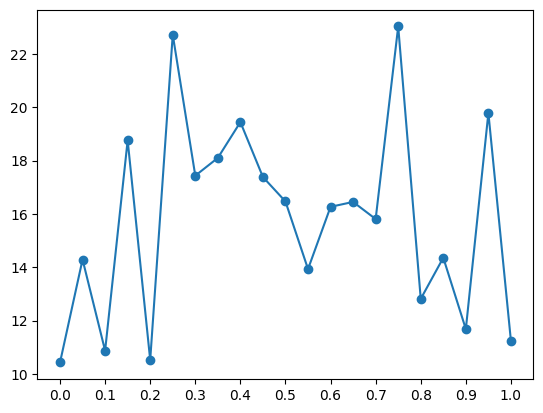

In [15]:
import matplotlib.pyplot as plt

plt.scatter(CXPB, tempos)
plt.plot(CXPB, tempos)
plt.xticks(np.arange(0, 1.05, 0.1)) 
plt.show()

# Gráfico 2: Tempo Total X CXPB (Probabilidade de Crossover)

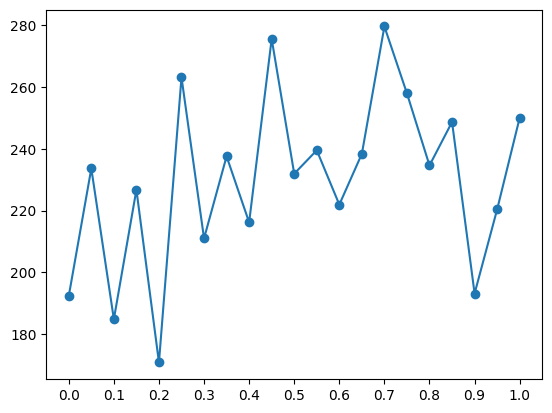

In [16]:
plt.scatter(CXPB, tempoTotal)
plt.plot(CXPB, tempoTotal)
plt.xticks(np.arange(0, 1.05, 0.1)) 
plt.show()

# Gráfico 3: Média de Tempo X CXPB (Probabilidade de Crossover)

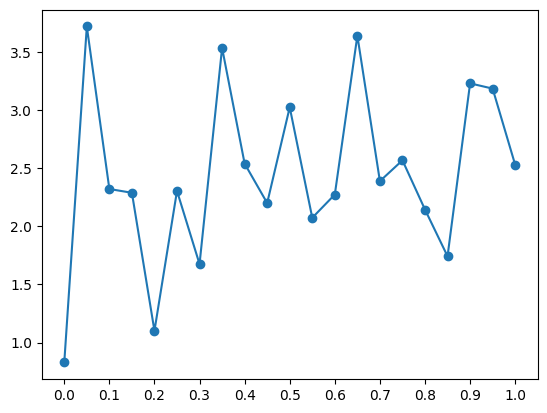

In [17]:
plt.scatter(CXPB, temposMelhorInd)
plt.plot(CXPB, temposMelhorInd)
plt.xticks(np.arange(0, 1.05, 0.1)) 
plt.show()

## Define-se o melhor valor do parâmetro analisado ponderando os valores encontrados nos gráficos seguindo a Ordem de Importância 3 -> 2 -> 1

# Resultado: CXPB = 0.65